In [2]:
import os
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

In [3]:
from configuration3 import config_dict

In [4]:
# Créer l'environnement
env = gym.make("intersection-v0", render_mode="rgb_array")
env.unwrapped.configure(config_dict)

# Tester l'environnement
obs, info = env.reset()
print("Forme de l'observation:", obs.shape)

done = truncated = False
total_reward = 0

for i in range(20):
    action = env.action_space.sample()  # Action aléatoire
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    
    if done or truncated:
        print(f"Épisode terminé après {i+1} pas, récompense totale: {total_reward}")
        break

# Visualiser une observation
if not obs.shape[-1] == 7:  # Si l'observation est aplatie
    print("Observation:", obs)
else:
    # Si l'observation est structurée (présence, x, y, vx, vy, cos_h, sin_h)
    present_vehicles = np.where(obs[:, 0] == 1)[0]
    print(f"Nombre de véhicules visibles: {len(present_vehicles)}")
    if len(present_vehicles) > 0:
        print("Position du premier véhicule visible (x, y):", obs[present_vehicles[0], 1:3])

C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Forme de l'observation: (15, 7)
Épisode terminé après 2 pas, récompense totale: 1.00990099009901
Nombre de véhicules visibles: 6
Position du premier véhicule visible (x, y): [0.02      0.1536151]


In [ ]:
# Création d'un dossier pour les logs
log_dir = "logs/ppo"
os.makedirs(log_dir, exist_ok=True)
os.makedirs("models/ppo", exist_ok=True)

# Créer un environnement monitoré pour le suivi des performances
def make_env():
    env = gym.make("intersection-v0")
    env.unwrapped.configure(config_dict)
    env = Monitor(env, filename=os.path.join(log_dir, "monitor.csv"))  # Spécifier le chemin des logs)
    return env

# Création de l'environnement vectorisé
env = DummyVecEnv([make_env])

# Environnement d'évaluation séparé
eval_env = DummyVecEnv([make_env])

# Callbacks pour sauvegarder le modèle et évaluer périodiquement
checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./models/ppo",
    name_prefix="intersection_model"
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./models/ppo/best/",
    log_path="./logs/ppo",
    eval_freq=1000,
    deterministic=True,
    render=False
)



ppo = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-3,          
    n_steps=256,                  
    batch_size=64,
    gamma=0.85,                   
    gae_lambda=0.90,
    clip_range=0.2,
    ent_coef=0.01,                
    verbose=1
)




# Entraînement du modèle
ppo.learn(
    total_timesteps=10000,
    callback=[checkpoint_callback, eval_callback],
    progress_bar=True
)
# Sauvegarder le modèle final
ppo.save("models/ppo/intersection_ppo_last")

C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: 
DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version 
`v1`.
  logger.deprecation(

C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: 
DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version 
`v1`.
  logger.deprecation(

Using cuda device

C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: 
UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a 
CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See 
https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export 
CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and 
the training might take longer than on CPU.
  warnings.warn(

LiveError: Only one live display may be active at once

In [5]:
model = PPO.load("models/ppo/intersection_ppo_200000")  # Modèle final

# Créer un environnement d'évaluation
eval_env = gym.make("intersection-v0", render_mode="rgb_array")
eval_env.unwrapped.configure(config_dict)

# Évaluer le modèle sur 10 épisodes
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"Récompense moyenne: {mean_reward:.2f} +/- {std_reward:.2f}")

C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``

Récompense moyenne: 3.00 +/- 1.73


In [6]:
from IPython.display import HTML
from base64 import b64encode
import imageio


# Enregistrer une vidéo
test_env = gym.make("intersection-v0", render_mode="rgb_array")
test_env.unwrapped.configure(config_dict)

# Exécuter l'environnement et créer les frames
def record_video(model, env, video_length=100):
    obs, _ = env.reset()
    frames = []
    
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        frame = env.render()
        frames.append(frame)
        
        if done or truncated:
            obs, _ = env.reset()
    
    return frames

frames = record_video(model, test_env)

def show_video(frames, framerate=3):
    height, width, _ = frames[0].shape
    writer = imageio.get_writer('temp_video.mp4', fps=framerate)
    for frame in frames:
        writer.append_data(frame)
    writer.close()
    
    video = open('temp_video.mp4', 'rb').read()
    encoded_video = b64encode(video).decode('ascii')
    return HTML(f'<video width="600" height="400" controls><source src="data:video/mp4;base64,{encoded_video}" type="video/mp4"></video>')

show_video(frames)





C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


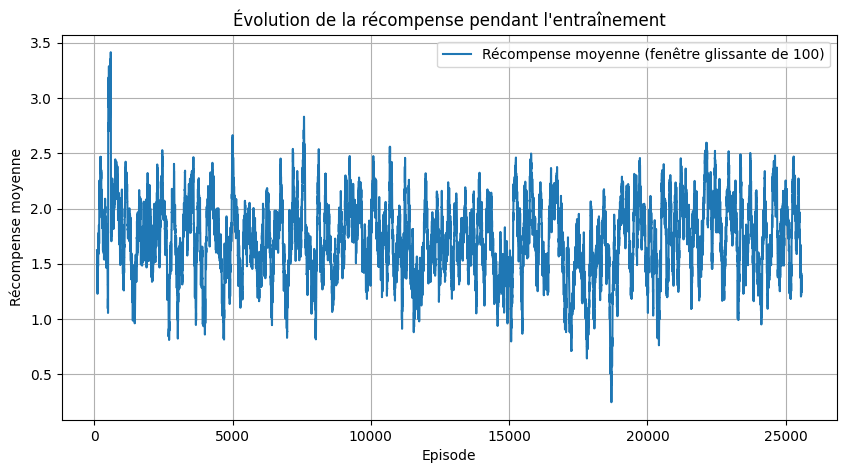

In [10]:
import pandas as pd
import numpy as np
import json
import glob

import matplotlib.pyplot as plt
log_dir = "logs/ppo"
# Charger les fichiers de logs
log_files = glob.glob(os.path.join(log_dir, "*monitor.csv"))
data_frames = []

for log_file in log_files:
    with open(log_file, 'rt') as file_handler:
        first_line = file_handler.readline()
        assert first_line[0] == '#'
        header = json.loads(first_line[1:])
        df = pd.read_csv(file_handler, index_col=None)
        df['t'] += header['t_start']
    data_frames.append(df)

# Concaténer les données
data = pd.concat(data_frames)

# Calculer la récompense moyenne par épisode
data['Episode'] = np.arange(len(data))
data['Reward'] = data['r'].rolling(window=100).mean()  # Moyenne glissante sur 100 épisodes

# Tracer les récompenses
plt.figure(figsize=(10, 5))
plt.plot(data['Episode'], data['Reward'], label="Récompense moyenne (fenêtre glissante de 100)")
plt.xlabel("Episode")
plt.ylabel("Récompense moyenne")
plt.title("Évolution de la récompense pendant l'entraînement")
plt.legend()
plt.grid()
plt.show()

In [19]:
# Création d'un dossier pour les logs
log_dir = "logs/dqn"
os.makedirs(log_dir, exist_ok=True)
os.makedirs("models/dqn", exist_ok=True)

# Créer un environnement monitoré pour le suivi des performances
def make_env():
    env = gym.make("intersection-v0")
    env.unwrapped.configure(config_dict)
    env = Monitor(env, filename=os.path.join(log_dir, "monitor.csv"))  # Spécifier le chemin des logs)
    return env

# Création de l'environnement vectorisé
env = DummyVecEnv([make_env])

# Environnement d'évaluation séparé
eval_env = DummyVecEnv([make_env])

# Callbacks pour sauvegarder le modèle et évaluer périodiquement
checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./models/dqn",
    name_prefix="intersection_model"
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./models/dqn/best/",
    log_path="./logs/dqn",
    eval_freq=1000,
    deterministic=True,
    render=False
)

# DQN (bon pour des espaces d'action discrets comme celui-ci)
dqn = DQN(
    "MlpPolicy", 
    env,
    verbose=1,
    tensorboard_log=log_dir,
    learning_rate=1e-4,
    buffer_size=50000,
    learning_starts=1000
)

dqn.learn(
    total_timesteps=100000,
    callback=[checkpoint_callback, eval_callback],
    progress_bar=True
)
# Sauvegarder le modèle final
dqn.save("models/dqn/intersection_dqn_100000")

C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Using cuda device
Logging to logs/dqn\DQN_1


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 14       |
|    time_elapsed     | 1        |
|    total_timesteps  | 16       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 16       |
|    time_elapsed     | 1        |
|    total_timesteps  | 33       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.25     |
|    ep_rew_mean      | 2.85     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 16       |
|    time_elapsed     | 3        |
|    total_timesteps  | 51       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 16       |
|    time_elapsed     | 4        |
|    total_timesteps  | 66       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 16       |
|    time_elapsed     | 4        |
|    total_timesteps  | 81       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 24       |
|    fps              | 16       |
|    time_elapsed     | 6        |
|    total_timesteps  | 98       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 28       |
|    fps              | 15       |
|    time_elapsed     | 7        |
|    total_timesteps  | 112      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.988    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 15       |
|    time_elapsed     | 8        |
|    total_timesteps  | 126      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.987    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 16       |
|    time_elapsed     | 8        |
|    total_timesteps  | 141      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 40       |
|    fps              | 16       |
|    time_elapsed     | 9        |
|    total_timesteps  | 159      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 44       |
|    fps              | 16       |
|    time_elapsed     | 10       |
|    total_timesteps  | 175      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 48       |
|    fps              | 16       |
|    time_elapsed     | 11       |
|    total_timesteps  | 188      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.981    |
| time/               |          |
|    episodes         | 52       |
|    fps              | 16       |
|    time_elapsed     | 12       |
|    total_timesteps  | 204      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 16       |
|    time_elapsed     | 13       |
|    total_timesteps  | 222      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 60       |
|    fps              | 16       |
|    time_elapsed     | 14       |
|    total_timesteps  | 236      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.976    |
| time/               |          |
|    episodes         | 64       |
|    fps              | 15       |
|    time_elapsed     | 15       |
|    total_timesteps  | 249      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.975    |
| time/               |          |
|    episodes         | 68       |
|    fps              | 15       |
|    time_elapsed     | 16       |
|    total_timesteps  | 266      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 72       |
|    fps              | 15       |
|    time_elapsed     | 17       |
|    total_timesteps  | 279      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 76       |
|    fps              | 15       |
|    time_elapsed     | 18       |
|    total_timesteps  | 299      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.97     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 15       |
|    time_elapsed     | 19       |
|    total_timesteps  | 314      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 15       |
|    time_elapsed     | 20       |
|    total_timesteps  | 330      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 15       |
|    time_elapsed     | 21       |
|    total_timesteps  | 345      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 16       |
|    time_elapsed     | 22       |
|    total_timesteps  | 362      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 16       |
|    time_elapsed     | 23       |
|    total_timesteps  | 380      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.963    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 16       |
|    time_elapsed     | 24       |
|    total_timesteps  | 393      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 104      |
|    fps              | 15       |
|    time_elapsed     | 25       |
|    total_timesteps  | 407      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.96     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 15       |
|    time_elapsed     | 26       |
|    total_timesteps  | 424      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.958    |
| time/               |          |
|    episodes         | 112      |
|    fps              | 16       |
|    time_elapsed     | 27       |
|    total_timesteps  | 441      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 116      |
|    fps              | 16       |
|    time_elapsed     | 28       |
|    total_timesteps  | 457      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.955    |
| time/               |          |
|    episodes         | 120      |
|    fps              | 15       |
|    time_elapsed     | 29       |
|    total_timesteps  | 473      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 124      |
|    fps              | 16       |
|    time_elapsed     | 30       |
|    total_timesteps  | 490      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.952    |
| time/               |          |
|    episodes         | 128      |
|    fps              | 15       |
|    time_elapsed     | 31       |
|    total_timesteps  | 506      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 132      |
|    fps              | 15       |
|    time_elapsed     | 32       |
|    total_timesteps  | 521      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.949    |
| time/               |          |
|    episodes         | 136      |
|    fps              | 15       |
|    time_elapsed     | 34       |
|    total_timesteps  | 540      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 140      |
|    fps              | 15       |
|    time_elapsed     | 34       |
|    total_timesteps  | 553      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 144      |
|    fps              | 15       |
|    time_elapsed     | 35       |
|    total_timesteps  | 568      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 148      |
|    fps              | 16       |
|    time_elapsed     | 36       |
|    total_timesteps  | 588      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.943    |
| time/               |          |
|    episodes         | 152      |
|    fps              | 16       |
|    time_elapsed     | 37       |
|    total_timesteps  | 602      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 156      |
|    fps              | 16       |
|    time_elapsed     | 38       |
|    total_timesteps  | 621      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.939    |
| time/               |          |
|    episodes         | 160      |
|    fps              | 16       |
|    time_elapsed     | 39       |
|    total_timesteps  | 638      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.938    |
| time/               |          |
|    episodes         | 164      |
|    fps              | 16       |
|    time_elapsed     | 40       |
|    total_timesteps  | 656      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 168      |
|    fps              | 16       |
|    time_elapsed     | 41       |
|    total_timesteps  | 670      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.935    |
| time/               |          |
|    episodes         | 172      |
|    fps              | 16       |
|    time_elapsed     | 42       |
|    total_timesteps  | 683      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 176      |
|    fps              | 16       |
|    time_elapsed     | 43       |
|    total_timesteps  | 702      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 180      |
|    fps              | 16       |
|    time_elapsed     | 44       |
|    total_timesteps  | 718      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 15       |
|    time_elapsed     | 45       |
|    total_timesteps  | 730      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes         | 188      |
|    fps              | 15       |
|    time_elapsed     | 46       |
|    total_timesteps  | 747      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.928    |
| time/               |          |
|    episodes         | 192      |
|    fps              | 15       |
|    time_elapsed     | 47       |
|    total_timesteps  | 762      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.926    |
| time/               |          |
|    episodes         | 196      |
|    fps              | 15       |
|    time_elapsed     | 48       |
|    total_timesteps  | 780      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 200      |
|    fps              | 15       |
|    time_elapsed     | 49       |
|    total_timesteps  | 791      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.923    |
| time/               |          |
|    episodes         | 204      |
|    fps              | 15       |
|    time_elapsed     | 50       |
|    total_timesteps  | 808      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 208      |
|    fps              | 15       |
|    time_elapsed     | 51       |
|    total_timesteps  | 826      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 212      |
|    fps              | 15       |
|    time_elapsed     | 52       |
|    total_timesteps  | 841      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 216      |
|    fps              | 15       |
|    time_elapsed     | 53       |
|    total_timesteps  | 858      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.917    |
| time/               |          |
|    episodes         | 220      |
|    fps              | 15       |
|    time_elapsed     | 54       |
|    total_timesteps  | 874      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 224      |
|    fps              | 15       |
|    time_elapsed     | 55       |
|    total_timesteps  | 893      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 228      |
|    fps              | 15       |
|    time_elapsed     | 56       |
|    total_timesteps  | 905      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.912    |
| time/               |          |
|    episodes         | 232      |
|    fps              | 15       |
|    time_elapsed     | 57       |
|    total_timesteps  | 922      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.911    |
| time/               |          |
|    episodes         | 236      |
|    fps              | 15       |
|    time_elapsed     | 58       |
|    total_timesteps  | 936      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 240      |
|    fps              | 16       |
|    time_elapsed     | 59       |
|    total_timesteps  | 954      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.908    |
| time/               |          |
|    episodes         | 244      |
|    fps              | 16       |
|    time_elapsed     | 60       |
|    total_timesteps  | 970      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.906    |
| time/               |          |
|    episodes         | 248      |
|    fps              | 16       |
|    time_elapsed     | 61       |
|    total_timesteps  | 988      |
----------------------------------


Eval num_timesteps=1000, episode_reward=1.40 +/- 2.94

Episode length: 3.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 1.4      |
| rollout/            |          |
|    exploration_rate | 0.905    |
| time/               |          |
|    total_timesteps  | 1000     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 252      |
|    fps              | 15       |
|    time_elapsed     | 63       |
|    total_timesteps  | 1006     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.912    |
|    n_updates        | 1        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes         | 256      |
|    fps              | 15       |
|    time_elapsed     | 64       |
|    total_timesteps  | 1024     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 5        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.901    |
| time/               |          |
|    episodes         | 260      |
|    fps              | 15       |
|    time_elapsed     | 65       |
|    total_timesteps  | 1040     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 9        |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.9      |
| time/               |          |
|    episodes         | 264      |
|    fps              | 15       |
|    time_elapsed     | 66       |
|    total_timesteps  | 1054     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 13       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 15       |
|    time_elapsed     | 67       |
|    total_timesteps  | 1071     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.876    |
|    n_updates        | 17       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 15       |
|    time_elapsed     | 68       |
|    total_timesteps  | 1086     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 21       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.895    |
| time/               |          |
|    episodes         | 276      |
|    fps              | 15       |
|    time_elapsed     | 69       |
|    total_timesteps  | 1102     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 25       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.894    |
| time/               |          |
|    episodes         | 280      |
|    fps              | 15       |
|    time_elapsed     | 71       |
|    total_timesteps  | 1120     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 29       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 284      |
|    fps              | 15       |
|    time_elapsed     | 72       |
|    total_timesteps  | 1137     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 34       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 288      |
|    fps              | 15       |
|    time_elapsed     | 72       |
|    total_timesteps  | 1154     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 38       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 292      |
|    fps              | 15       |
|    time_elapsed     | 73       |
|    total_timesteps  | 1167     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 41       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.888    |
| time/               |          |
|    episodes         | 296      |
|    fps              | 15       |
|    time_elapsed     | 75       |
|    total_timesteps  | 1182     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.909    |
|    n_updates        | 45       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 300      |
|    fps              | 15       |
|    time_elapsed     | 75       |
|    total_timesteps  | 1197     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 49       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.885    |
| time/               |          |
|    episodes         | 304      |
|    fps              | 15       |
|    time_elapsed     | 76       |
|    total_timesteps  | 1211     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 52       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.884    |
| time/               |          |
|    episodes         | 308      |
|    fps              | 15       |
|    time_elapsed     | 77       |
|    total_timesteps  | 1226     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.95     |
|    n_updates        | 56       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 312      |
|    fps              | 15       |
|    time_elapsed     | 78       |
|    total_timesteps  | 1240     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 59       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.881    |
| time/               |          |
|    episodes         | 316      |
|    fps              | 15       |
|    time_elapsed     | 79       |
|    total_timesteps  | 1252     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 62       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.879    |
| time/               |          |
|    episodes         | 320      |
|    fps              | 15       |
|    time_elapsed     | 80       |
|    total_timesteps  | 1270     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 67       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.878    |
| time/               |          |
|    episodes         | 324      |
|    fps              | 15       |
|    time_elapsed     | 81       |
|    total_timesteps  | 1287     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 71       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.876    |
| time/               |          |
|    episodes         | 328      |
|    fps              | 15       |
|    time_elapsed     | 82       |
|    total_timesteps  | 1301     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 75       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes         | 332      |
|    fps              | 15       |
|    time_elapsed     | 83       |
|    total_timesteps  | 1317     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 79       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 336      |
|    fps              | 15       |
|    time_elapsed     | 84       |
|    total_timesteps  | 1335     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.86     |
|    n_updates        | 83       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.872    |
| time/               |          |
|    episodes         | 340      |
|    fps              | 15       |
|    time_elapsed     | 85       |
|    total_timesteps  | 1351     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.538    |
|    n_updates        | 87       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.87     |
| time/               |          |
|    episodes         | 344      |
|    fps              | 15       |
|    time_elapsed     | 86       |
|    total_timesteps  | 1364     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 90       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 348      |
|    fps              | 15       |
|    time_elapsed     | 87       |
|    total_timesteps  | 1380     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 94       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.868    |
| time/               |          |
|    episodes         | 352      |
|    fps              | 15       |
|    time_elapsed     | 88       |
|    total_timesteps  | 1390     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 97       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.867    |
| time/               |          |
|    episodes         | 356      |
|    fps              | 15       |
|    time_elapsed     | 89       |
|    total_timesteps  | 1404     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 100      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.865    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 15       |
|    time_elapsed     | 90       |
|    total_timesteps  | 1422     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 105      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 364      |
|    fps              | 15       |
|    time_elapsed     | 91       |
|    total_timesteps  | 1438     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 109      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.862    |
| time/               |          |
|    episodes         | 368      |
|    fps              | 15       |
|    time_elapsed     | 92       |
|    total_timesteps  | 1455     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 113      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.86     |
| time/               |          |
|    episodes         | 372      |
|    fps              | 15       |
|    time_elapsed     | 93       |
|    total_timesteps  | 1471     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 117      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.859    |
| time/               |          |
|    episodes         | 376      |
|    fps              | 15       |
|    time_elapsed     | 94       |
|    total_timesteps  | 1486     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 121      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.857    |
| time/               |          |
|    episodes         | 380      |
|    fps              | 15       |
|    time_elapsed     | 96       |
|    total_timesteps  | 1504     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 125      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.854    |
| time/               |          |
|    episodes         | 388      |
|    fps              | 15       |
|    time_elapsed     | 97       |
|    total_timesteps  | 1536     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 133      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.853    |
| time/               |          |
|    episodes         | 392      |
|    fps              | 15       |
|    time_elapsed     | 99       |
|    total_timesteps  | 1552     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 137      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes         | 396      |
|    fps              | 15       |
|    time_elapsed     | 100      |
|    total_timesteps  | 1568     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 141      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.85     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 15       |
|    time_elapsed     | 101      |
|    total_timesteps  | 1583     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 145      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 404      |
|    fps              | 15       |
|    time_elapsed     | 102      |
|    total_timesteps  | 1595     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 148      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.847    |
| time/               |          |
|    episodes         | 408      |
|    fps              | 15       |
|    time_elapsed     | 103      |
|    total_timesteps  | 1609     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 152      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 412      |
|    fps              | 15       |
|    time_elapsed     | 104      |
|    total_timesteps  | 1627     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 156      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.844    |
| time/               |          |
|    episodes         | 416      |
|    fps              | 15       |
|    time_elapsed     | 105      |
|    total_timesteps  | 1640     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 159      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.843    |
| time/               |          |
|    episodes         | 420      |
|    fps              | 15       |
|    time_elapsed     | 106      |
|    total_timesteps  | 1656     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 163      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 424      |
|    fps              | 15       |
|    time_elapsed     | 107      |
|    total_timesteps  | 1673     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 168      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes         | 428      |
|    fps              | 15       |
|    time_elapsed     | 109      |
|    total_timesteps  | 1688     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 171      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.838    |
| time/               |          |
|    episodes         | 432      |
|    fps              | 15       |
|    time_elapsed     | 110      |
|    total_timesteps  | 1704     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.866    |
|    n_updates        | 175      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.837    |
| time/               |          |
|    episodes         | 436      |
|    fps              | 15       |
|    time_elapsed     | 111      |
|    total_timesteps  | 1719     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 179      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 440      |
|    fps              | 15       |
|    time_elapsed     | 112      |
|    total_timesteps  | 1734     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 183      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.834    |
| time/               |          |
|    episodes         | 444      |
|    fps              | 15       |
|    time_elapsed     | 113      |
|    total_timesteps  | 1752     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 187      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.832    |
| time/               |          |
|    episodes         | 448      |
|    fps              | 15       |
|    time_elapsed     | 114      |
|    total_timesteps  | 1770     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 192      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 452      |
|    fps              | 15       |
|    time_elapsed     | 115      |
|    total_timesteps  | 1790     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 197      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.829    |
| time/               |          |
|    episodes         | 456      |
|    fps              | 15       |
|    time_elapsed     | 116      |
|    total_timesteps  | 1803     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 200      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.827    |
| time/               |          |
|    episodes         | 460      |
|    fps              | 15       |
|    time_elapsed     | 117      |
|    total_timesteps  | 1818     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 204      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.826    |
| time/               |          |
|    episodes         | 464      |
|    fps              | 15       |
|    time_elapsed     | 118      |
|    total_timesteps  | 1835     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 208      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 468      |
|    fps              | 15       |
|    time_elapsed     | 119      |
|    total_timesteps  | 1852     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 212      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.823    |
| time/               |          |
|    episodes         | 472      |
|    fps              | 15       |
|    time_elapsed     | 120      |
|    total_timesteps  | 1863     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 215      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.822    |
| time/               |          |
|    episodes         | 476      |
|    fps              | 15       |
|    time_elapsed     | 121      |
|    total_timesteps  | 1876     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.179    |
|    n_updates        | 218      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.821    |
| time/               |          |
|    episodes         | 480      |
|    fps              | 15       |
|    time_elapsed     | 122      |
|    total_timesteps  | 1888     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 221      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 484      |
|    fps              | 15       |
|    time_elapsed     | 123      |
|    total_timesteps  | 1903     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 225      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes         | 488      |
|    fps              | 15       |
|    time_elapsed     | 124      |
|    total_timesteps  | 1921     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 230      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 492      |
|    fps              | 15       |
|    time_elapsed     | 125      |
|    total_timesteps  | 1938     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 234      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 496      |
|    fps              | 15       |
|    time_elapsed     | 126      |
|    total_timesteps  | 1953     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 238      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 500      |
|    fps              | 15       |
|    time_elapsed     | 127      |
|    total_timesteps  | 1969     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 242      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.811    |
| time/               |          |
|    episodes         | 504      |
|    fps              | 15       |
|    time_elapsed     | 128      |
|    total_timesteps  | 1986     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 246      |
----------------------------------


Eval num_timesteps=2000, episode_reward=3.00 +/- 2.76

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 3        |
| rollout/            |          |
|    exploration_rate | 0.81     |
| time/               |          |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 249      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 508      |
|    fps              | 15       |
|    time_elapsed     | 131      |
|    total_timesteps  | 2002     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 250      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 512      |
|    fps              | 15       |
|    time_elapsed     | 132      |
|    total_timesteps  | 2017     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 254      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 516      |
|    fps              | 15       |
|    time_elapsed     | 133      |
|    total_timesteps  | 2037     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.764    |
|    n_updates        | 259      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.805    |
| time/               |          |
|    episodes         | 520      |
|    fps              | 15       |
|    time_elapsed     | 134      |
|    total_timesteps  | 2057     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.478    |
|    n_updates        | 264      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.803    |
| time/               |          |
|    episodes         | 524      |
|    fps              | 15       |
|    time_elapsed     | 135      |
|    total_timesteps  | 2069     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 267      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 528      |
|    fps              | 15       |
|    time_elapsed     | 136      |
|    total_timesteps  | 2084     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 270      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.801    |
| time/               |          |
|    episodes         | 532      |
|    fps              | 15       |
|    time_elapsed     | 137      |
|    total_timesteps  | 2096     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 273      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 536      |
|    fps              | 15       |
|    time_elapsed     | 138      |
|    total_timesteps  | 2110     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.342    |
|    n_updates        | 277      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.798    |
| time/               |          |
|    episodes         | 540      |
|    fps              | 15       |
|    time_elapsed     | 139      |
|    total_timesteps  | 2125     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 281      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 544      |
|    fps              | 15       |
|    time_elapsed     | 139      |
|    total_timesteps  | 2136     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.488    |
|    n_updates        | 283      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.796    |
| time/               |          |
|    episodes         | 548      |
|    fps              | 15       |
|    time_elapsed     | 140      |
|    total_timesteps  | 2149     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 287      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.794    |
| time/               |          |
|    episodes         | 552      |
|    fps              | 15       |
|    time_elapsed     | 141      |
|    total_timesteps  | 2165     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 291      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.793    |
| time/               |          |
|    episodes         | 556      |
|    fps              | 15       |
|    time_elapsed     | 142      |
|    total_timesteps  | 2181     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 295      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes         | 560      |
|    fps              | 15       |
|    time_elapsed     | 143      |
|    total_timesteps  | 2199     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.615    |
|    n_updates        | 299      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.79     |
| time/               |          |
|    episodes         | 564      |
|    fps              | 15       |
|    time_elapsed     | 144      |
|    total_timesteps  | 2215     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 303      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.788    |
| time/               |          |
|    episodes         | 568      |
|    fps              | 15       |
|    time_elapsed     | 145      |
|    total_timesteps  | 2230     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.331    |
|    n_updates        | 307      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 572      |
|    fps              | 15       |
|    time_elapsed     | 146      |
|    total_timesteps  | 2245     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 311      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes         | 576      |
|    fps              | 15       |
|    time_elapsed     | 147      |
|    total_timesteps  | 2255     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 313      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.785    |
| time/               |          |
|    episodes         | 580      |
|    fps              | 15       |
|    time_elapsed     | 148      |
|    total_timesteps  | 2267     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 316      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 584      |
|    fps              | 15       |
|    time_elapsed     | 149      |
|    total_timesteps  | 2283     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 320      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.782    |
| time/               |          |
|    episodes         | 588      |
|    fps              | 15       |
|    time_elapsed     | 150      |
|    total_timesteps  | 2298     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 324      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 592      |
|    fps              | 15       |
|    time_elapsed     | 151      |
|    total_timesteps  | 2316     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 328      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.779    |
| time/               |          |
|    episodes         | 596      |
|    fps              | 15       |
|    time_elapsed     | 152      |
|    total_timesteps  | 2330     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.181    |
|    n_updates        | 332      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.778    |
| time/               |          |
|    episodes         | 600      |
|    fps              | 15       |
|    time_elapsed     | 153      |
|    total_timesteps  | 2341     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 335      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 604      |
|    fps              | 15       |
|    time_elapsed     | 154      |
|    total_timesteps  | 2353     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 338      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.775    |
| time/               |          |
|    episodes         | 608      |
|    fps              | 15       |
|    time_elapsed     | 154      |
|    total_timesteps  | 2369     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 342      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.773    |
| time/               |          |
|    episodes         | 612      |
|    fps              | 15       |
|    time_elapsed     | 155      |
|    total_timesteps  | 2387     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 346      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.969    |
|    exploration_rate | 0.772    |
| time/               |          |
|    episodes         | 616      |
|    fps              | 15       |
|    time_elapsed     | 156      |
|    total_timesteps  | 2400     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.463    |
|    n_updates        | 349      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.899    |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 620      |
|    fps              | 15       |
|    time_elapsed     | 157      |
|    total_timesteps  | 2418     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 354      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.981    |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes         | 624      |
|    fps              | 15       |
|    time_elapsed     | 158      |
|    total_timesteps  | 2434     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 358      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 628      |
|    fps              | 15       |
|    time_elapsed     | 159      |
|    total_timesteps  | 2450     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.05     |
|    n_updates        | 362      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.766    |
| time/               |          |
|    episodes         | 632      |
|    fps              | 15       |
|    time_elapsed     | 160      |
|    total_timesteps  | 2467     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 366      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes         | 636      |
|    fps              | 15       |
|    time_elapsed     | 161      |
|    total_timesteps  | 2479     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.323    |
|    n_updates        | 369      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.763    |
| time/               |          |
|    episodes         | 640      |
|    fps              | 15       |
|    time_elapsed     | 162      |
|    total_timesteps  | 2494     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 373      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.762    |
| time/               |          |
|    episodes         | 644      |
|    fps              | 15       |
|    time_elapsed     | 163      |
|    total_timesteps  | 2508     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 376      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.76     |
| time/               |          |
|    episodes         | 648      |
|    fps              | 15       |
|    time_elapsed     | 165      |
|    total_timesteps  | 2526     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 381      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 652      |
|    fps              | 15       |
|    time_elapsed     | 166      |
|    total_timesteps  | 2542     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 385      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.757    |
| time/               |          |
|    episodes         | 656      |
|    fps              | 15       |
|    time_elapsed     | 167      |
|    total_timesteps  | 2559     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.588    |
|    n_updates        | 389      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.755    |
| time/               |          |
|    episodes         | 660      |
|    fps              | 15       |
|    time_elapsed     | 168      |
|    total_timesteps  | 2576     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 393      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 664      |
|    fps              | 15       |
|    time_elapsed     | 169      |
|    total_timesteps  | 2591     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 397      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.753    |
| time/               |          |
|    episodes         | 668      |
|    fps              | 15       |
|    time_elapsed     | 170      |
|    total_timesteps  | 2605     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0161   |
|    n_updates        | 401      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.937    |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 672      |
|    fps              | 15       |
|    time_elapsed     | 171      |
|    total_timesteps  | 2616     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 403      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.75     |
| time/               |          |
|    episodes         | 676      |
|    fps              | 15       |
|    time_elapsed     | 172      |
|    total_timesteps  | 2634     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 408      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 680      |
|    fps              | 15       |
|    time_elapsed     | 173      |
|    total_timesteps  | 2646     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 411      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 684      |
|    fps              | 15       |
|    time_elapsed     | 174      |
|    total_timesteps  | 2663     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.287    |
|    n_updates        | 415      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 0.978    |
|    exploration_rate | 0.746    |
| time/               |          |
|    episodes         | 688      |
|    fps              | 15       |
|    time_elapsed     | 175      |
|    total_timesteps  | 2675     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 418      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.768    |
|    exploration_rate | 0.745    |
| time/               |          |
|    episodes         | 692      |
|    fps              | 15       |
|    time_elapsed     | 176      |
|    total_timesteps  | 2687     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 421      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.818    |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 696      |
|    fps              | 15       |
|    time_elapsed     | 177      |
|    total_timesteps  | 2701     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.968    |
|    n_updates        | 425      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 0.968    |
|    exploration_rate | 0.742    |
| time/               |          |
|    episodes         | 700      |
|    fps              | 15       |
|    time_elapsed     | 178      |
|    total_timesteps  | 2717     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 429      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.74     |
| time/               |          |
|    episodes         | 704      |
|    fps              | 15       |
|    time_elapsed     | 180      |
|    total_timesteps  | 2737     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.484    |
|    n_updates        | 434      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.739    |
| time/               |          |
|    episodes         | 708      |
|    fps              | 15       |
|    time_elapsed     | 180      |
|    total_timesteps  | 2752     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.342    |
|    n_updates        | 437      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.737    |
| time/               |          |
|    episodes         | 712      |
|    fps              | 15       |
|    time_elapsed     | 181      |
|    total_timesteps  | 2765     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 441      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.736    |
| time/               |          |
|    episodes         | 716      |
|    fps              | 15       |
|    time_elapsed     | 182      |
|    total_timesteps  | 2781     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.572    |
|    n_updates        | 445      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 720      |
|    fps              | 15       |
|    time_elapsed     | 183      |
|    total_timesteps  | 2797     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 449      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.733    |
| time/               |          |
|    episodes         | 724      |
|    fps              | 15       |
|    time_elapsed     | 184      |
|    total_timesteps  | 2813     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 453      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 728      |
|    fps              | 15       |
|    time_elapsed     | 185      |
|    total_timesteps  | 2826     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 456      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.73     |
| time/               |          |
|    episodes         | 732      |
|    fps              | 15       |
|    time_elapsed     | 186      |
|    total_timesteps  | 2844     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 460      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.728    |
| time/               |          |
|    episodes         | 736      |
|    fps              | 15       |
|    time_elapsed     | 187      |
|    total_timesteps  | 2861     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.553    |
|    n_updates        | 465      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 740      |
|    fps              | 15       |
|    time_elapsed     | 188      |
|    total_timesteps  | 2878     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 469      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.725    |
| time/               |          |
|    episodes         | 744      |
|    fps              | 15       |
|    time_elapsed     | 189      |
|    total_timesteps  | 2892     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 472      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.724    |
| time/               |          |
|    episodes         | 748      |
|    fps              | 15       |
|    time_elapsed     | 190      |
|    total_timesteps  | 2909     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 477      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.722    |
| time/               |          |
|    episodes         | 752      |
|    fps              | 15       |
|    time_elapsed     | 191      |
|    total_timesteps  | 2925     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 481      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.72     |
| time/               |          |
|    episodes         | 756      |
|    fps              | 15       |
|    time_elapsed     | 192      |
|    total_timesteps  | 2944     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 485      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.719    |
| time/               |          |
|    episodes         | 760      |
|    fps              | 15       |
|    time_elapsed     | 193      |
|    total_timesteps  | 2960     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 489      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.717    |
| time/               |          |
|    episodes         | 764      |
|    fps              | 15       |
|    time_elapsed     | 194      |
|    total_timesteps  | 2978     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.172    |
|    n_updates        | 494      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes         | 768      |
|    fps              | 15       |
|    time_elapsed     | 195      |
|    total_timesteps  | 2996     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.151    |
|    n_updates        | 498      |
----------------------------------


Eval num_timesteps=3000, episode_reward=2.80 +/- 2.71

Episode length: 4.80 +/- 0.40

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.8      |
|    mean_reward      | 2.8      |
| rollout/            |          |
|    exploration_rate | 0.715    |
| time/               |          |
|    total_timesteps  | 3000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 499      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.714    |
| time/               |          |
|    episodes         | 772      |
|    fps              | 15       |
|    time_elapsed     | 197      |
|    total_timesteps  | 3006     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 501      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 776      |
|    fps              | 15       |
|    time_elapsed     | 198      |
|    total_timesteps  | 3021     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 505      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.712    |
| time/               |          |
|    episodes         | 780      |
|    fps              | 15       |
|    time_elapsed     | 199      |
|    total_timesteps  | 3032     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.485    |
|    n_updates        | 507      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 784      |
|    fps              | 15       |
|    time_elapsed     | 200      |
|    total_timesteps  | 3048     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 511      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.709    |
| time/               |          |
|    episodes         | 788      |
|    fps              | 15       |
|    time_elapsed     | 201      |
|    total_timesteps  | 3062     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 515      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.707    |
| time/               |          |
|    episodes         | 792      |
|    fps              | 15       |
|    time_elapsed     | 202      |
|    total_timesteps  | 3081     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.338    |
|    n_updates        | 520      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.706    |
| time/               |          |
|    episodes         | 796      |
|    fps              | 15       |
|    time_elapsed     | 203      |
|    total_timesteps  | 3095     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 523      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 15       |
|    time_elapsed     | 204      |
|    total_timesteps  | 3113     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 528      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.703    |
| time/               |          |
|    episodes         | 804      |
|    fps              | 15       |
|    time_elapsed     | 205      |
|    total_timesteps  | 3129     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 532      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.701    |
| time/               |          |
|    episodes         | 808      |
|    fps              | 15       |
|    time_elapsed     | 206      |
|    total_timesteps  | 3148     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 536      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.7      |
| time/               |          |
|    episodes         | 812      |
|    fps              | 15       |
|    time_elapsed     | 207      |
|    total_timesteps  | 3160     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 539      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 816      |
|    fps              | 15       |
|    time_elapsed     | 208      |
|    total_timesteps  | 3175     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 543      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.697    |
| time/               |          |
|    episodes         | 820      |
|    fps              | 15       |
|    time_elapsed     | 209      |
|    total_timesteps  | 3188     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0361   |
|    n_updates        | 546      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 824      |
|    fps              | 15       |
|    time_elapsed     | 210      |
|    total_timesteps  | 3205     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 551      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.694    |
| time/               |          |
|    episodes         | 828      |
|    fps              | 15       |
|    time_elapsed     | 211      |
|    total_timesteps  | 3222     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 555      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.692    |
| time/               |          |
|    episodes         | 832      |
|    fps              | 15       |
|    time_elapsed     | 212      |
|    total_timesteps  | 3237     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 559      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.691    |
| time/               |          |
|    episodes         | 836      |
|    fps              | 15       |
|    time_elapsed     | 213      |
|    total_timesteps  | 3250     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.028    |
|    n_updates        | 562      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.69     |
| time/               |          |
|    episodes         | 840      |
|    fps              | 15       |
|    time_elapsed     | 214      |
|    total_timesteps  | 3264     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 565      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.689    |
| time/               |          |
|    episodes         | 844      |
|    fps              | 15       |
|    time_elapsed     | 215      |
|    total_timesteps  | 3278     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.285    |
|    n_updates        | 569      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 848      |
|    fps              | 15       |
|    time_elapsed     | 216      |
|    total_timesteps  | 3293     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 573      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.686    |
| time/               |          |
|    episodes         | 852      |
|    fps              | 15       |
|    time_elapsed     | 217      |
|    total_timesteps  | 3303     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 575      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.685    |
| time/               |          |
|    episodes         | 856      |
|    fps              | 15       |
|    time_elapsed     | 218      |
|    total_timesteps  | 3318     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.297    |
|    n_updates        | 579      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.683    |
| time/               |          |
|    episodes         | 860      |
|    fps              | 15       |
|    time_elapsed     | 219      |
|    total_timesteps  | 3336     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 583      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 864      |
|    fps              | 15       |
|    time_elapsed     | 220      |
|    total_timesteps  | 3352     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 587      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.68     |
| time/               |          |
|    episodes         | 868      |
|    fps              | 15       |
|    time_elapsed     | 221      |
|    total_timesteps  | 3370     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.73     |
|    n_updates        | 592      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.679    |
| time/               |          |
|    episodes         | 872      |
|    fps              | 15       |
|    time_elapsed     | 222      |
|    total_timesteps  | 3383     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.453    |
|    n_updates        | 595      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.677    |
| time/               |          |
|    episodes         | 876      |
|    fps              | 15       |
|    time_elapsed     | 223      |
|    total_timesteps  | 3397     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 599      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.676    |
| time/               |          |
|    episodes         | 880      |
|    fps              | 15       |
|    time_elapsed     | 224      |
|    total_timesteps  | 3411     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 602      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.674    |
| time/               |          |
|    episodes         | 884      |
|    fps              | 15       |
|    time_elapsed     | 225      |
|    total_timesteps  | 3427     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 606      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.673    |
| time/               |          |
|    episodes         | 888      |
|    fps              | 15       |
|    time_elapsed     | 226      |
|    total_timesteps  | 3441     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 610      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.672    |
| time/               |          |
|    episodes         | 892      |
|    fps              | 15       |
|    time_elapsed     | 227      |
|    total_timesteps  | 3451     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 612      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.67     |
| time/               |          |
|    episodes         | 896      |
|    fps              | 15       |
|    time_elapsed     | 228      |
|    total_timesteps  | 3470     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 617      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.669    |
| time/               |          |
|    episodes         | 900      |
|    fps              | 15       |
|    time_elapsed     | 228      |
|    total_timesteps  | 3482     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 620      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.667    |
| time/               |          |
|    episodes         | 904      |
|    fps              | 15       |
|    time_elapsed     | 229      |
|    total_timesteps  | 3500     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 624      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 908      |
|    fps              | 15       |
|    time_elapsed     | 231      |
|    total_timesteps  | 3518     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 629      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 912      |
|    fps              | 15       |
|    time_elapsed     | 232      |
|    total_timesteps  | 3536     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.721    |
|    n_updates        | 633      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.663    |
| time/               |          |
|    episodes         | 916      |
|    fps              | 15       |
|    time_elapsed     | 233      |
|    total_timesteps  | 3551     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.466    |
|    n_updates        | 637      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 920      |
|    fps              | 15       |
|    time_elapsed     | 234      |
|    total_timesteps  | 3567     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 641      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.66     |
| time/               |          |
|    episodes         | 924      |
|    fps              | 15       |
|    time_elapsed     | 235      |
|    total_timesteps  | 3582     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.291    |
|    n_updates        | 645      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.658    |
| time/               |          |
|    episodes         | 928      |
|    fps              | 15       |
|    time_elapsed     | 236      |
|    total_timesteps  | 3596     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 648      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.657    |
| time/               |          |
|    episodes         | 932      |
|    fps              | 15       |
|    time_elapsed     | 237      |
|    total_timesteps  | 3614     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 653      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.656    |
| time/               |          |
|    episodes         | 936      |
|    fps              | 15       |
|    time_elapsed     | 238      |
|    total_timesteps  | 3624     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 655      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.654    |
| time/               |          |
|    episodes         | 940      |
|    fps              | 15       |
|    time_elapsed     | 239      |
|    total_timesteps  | 3640     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.165    |
|    n_updates        | 659      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.653    |
| time/               |          |
|    episodes         | 944      |
|    fps              | 15       |
|    time_elapsed     | 240      |
|    total_timesteps  | 3656     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 663      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.651    |
| time/               |          |
|    episodes         | 948      |
|    fps              | 15       |
|    time_elapsed     | 241      |
|    total_timesteps  | 3672     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 667      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 952      |
|    fps              | 15       |
|    time_elapsed     | 243      |
|    total_timesteps  | 3690     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 672      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.648    |
| time/               |          |
|    episodes         | 956      |
|    fps              | 15       |
|    time_elapsed     | 244      |
|    total_timesteps  | 3706     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 676      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.646    |
| time/               |          |
|    episodes         | 960      |
|    fps              | 15       |
|    time_elapsed     | 245      |
|    total_timesteps  | 3722     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 680      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.645    |
| time/               |          |
|    episodes         | 964      |
|    fps              | 15       |
|    time_elapsed     | 246      |
|    total_timesteps  | 3740     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 684      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.644    |
| time/               |          |
|    episodes         | 968      |
|    fps              | 15       |
|    time_elapsed     | 247      |
|    total_timesteps  | 3752     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 687      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.642    |
| time/               |          |
|    episodes         | 972      |
|    fps              | 15       |
|    time_elapsed     | 248      |
|    total_timesteps  | 3764     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 690      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.641    |
| time/               |          |
|    episodes         | 976      |
|    fps              | 15       |
|    time_elapsed     | 249      |
|    total_timesteps  | 3781     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 695      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.639    |
| time/               |          |
|    episodes         | 980      |
|    fps              | 15       |
|    time_elapsed     | 250      |
|    total_timesteps  | 3800     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 699      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.637    |
| time/               |          |
|    episodes         | 984      |
|    fps              | 15       |
|    time_elapsed     | 251      |
|    total_timesteps  | 3818     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 704      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.636    |
| time/               |          |
|    episodes         | 988      |
|    fps              | 15       |
|    time_elapsed     | 252      |
|    total_timesteps  | 3833     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 708      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.634    |
| time/               |          |
|    episodes         | 992      |
|    fps              | 15       |
|    time_elapsed     | 253      |
|    total_timesteps  | 3851     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 712      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.632    |
| time/               |          |
|    episodes         | 996      |
|    fps              | 15       |
|    time_elapsed     | 254      |
|    total_timesteps  | 3869     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 717      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.631    |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 15       |
|    time_elapsed     | 255      |
|    total_timesteps  | 3886     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 721      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.63     |
| time/               |          |
|    episodes         | 1004     |
|    fps              | 15       |
|    time_elapsed     | 256      |
|    total_timesteps  | 3899     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 724      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.628    |
| time/               |          |
|    episodes         | 1008     |
|    fps              | 15       |
|    time_elapsed     | 257      |
|    total_timesteps  | 3913     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 728      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.627    |
| time/               |          |
|    episodes         | 1012     |
|    fps              | 15       |
|    time_elapsed     | 258      |
|    total_timesteps  | 3928     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 731      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.625    |
| time/               |          |
|    episodes         | 1016     |
|    fps              | 15       |
|    time_elapsed     | 259      |
|    total_timesteps  | 3944     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 735      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.624    |
| time/               |          |
|    episodes         | 1020     |
|    fps              | 15       |
|    time_elapsed     | 260      |
|    total_timesteps  | 3963     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 740      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.622    |
| time/               |          |
|    episodes         | 1024     |
|    fps              | 15       |
|    time_elapsed     | 261      |
|    total_timesteps  | 3979     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 744      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 1028     |
|    fps              | 15       |
|    time_elapsed     | 262      |
|    total_timesteps  | 3995     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 748      |
----------------------------------


Eval num_timesteps=4000, episode_reward=3.40 +/- 3.20

Episode length: 4.40 +/- 1.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.4      |
| rollout/            |          |
|    exploration_rate | 0.62     |
| time/               |          |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 749      |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.619    |
| time/               |          |
|    episodes         | 1032     |
|    fps              | 15       |
|    time_elapsed     | 264      |
|    total_timesteps  | 4008     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 751      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.618    |
| time/               |          |
|    episodes         | 1036     |
|    fps              | 15       |
|    time_elapsed     | 265      |
|    total_timesteps  | 4021     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 755      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.617    |
| time/               |          |
|    episodes         | 1040     |
|    fps              | 15       |
|    time_elapsed     | 266      |
|    total_timesteps  | 4031     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 757      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 1044     |
|    fps              | 15       |
|    time_elapsed     | 267      |
|    total_timesteps  | 4046     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 761      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.614    |
| time/               |          |
|    episodes         | 1048     |
|    fps              | 15       |
|    time_elapsed     | 268      |
|    total_timesteps  | 4062     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 765      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.612    |
| time/               |          |
|    episodes         | 1052     |
|    fps              | 15       |
|    time_elapsed     | 269      |
|    total_timesteps  | 4080     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.181    |
|    n_updates        | 769      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.611    |
| time/               |          |
|    episodes         | 1056     |
|    fps              | 15       |
|    time_elapsed     | 270      |
|    total_timesteps  | 4094     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 773      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 15       |
|    time_elapsed     | 271      |
|    total_timesteps  | 4110     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 777      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 15       |
|    time_elapsed     | 272      |
|    total_timesteps  | 4123     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 780      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.607    |
| time/               |          |
|    episodes         | 1068     |
|    fps              | 15       |
|    time_elapsed     | 273      |
|    total_timesteps  | 4134     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.173    |
|    n_updates        | 783      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.606    |
| time/               |          |
|    episodes         | 1072     |
|    fps              | 15       |
|    time_elapsed     | 274      |
|    total_timesteps  | 4150     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 787      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.605    |
| time/               |          |
|    episodes         | 1076     |
|    fps              | 15       |
|    time_elapsed     | 275      |
|    total_timesteps  | 4163     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 790      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.603    |
| time/               |          |
|    episodes         | 1080     |
|    fps              | 15       |
|    time_elapsed     | 276      |
|    total_timesteps  | 4180     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 794      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.602    |
| time/               |          |
|    episodes         | 1084     |
|    fps              | 15       |
|    time_elapsed     | 277      |
|    total_timesteps  | 4193     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 798      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 1088     |
|    fps              | 15       |
|    time_elapsed     | 278      |
|    total_timesteps  | 4210     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 802      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.975    |
|    exploration_rate | 0.599    |
| time/               |          |
|    episodes         | 1092     |
|    fps              | 15       |
|    time_elapsed     | 279      |
|    total_timesteps  | 4220     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 804      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.597    |
| time/               |          |
|    episodes         | 1096     |
|    fps              | 15       |
|    time_elapsed     | 280      |
|    total_timesteps  | 4240     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.426    |
|    n_updates        | 809      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.918    |
|    exploration_rate | 0.596    |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 15       |
|    time_elapsed     | 281      |
|    total_timesteps  | 4254     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0225   |
|    n_updates        | 813      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.988    |
|    exploration_rate | 0.594    |
| time/               |          |
|    episodes         | 1104     |
|    fps              | 15       |
|    time_elapsed     | 282      |
|    total_timesteps  | 4270     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 817      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.593    |
| time/               |          |
|    episodes         | 1108     |
|    fps              | 15       |
|    time_elapsed     | 283      |
|    total_timesteps  | 4288     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.867    |
|    n_updates        | 821      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.591    |
| time/               |          |
|    episodes         | 1112     |
|    fps              | 15       |
|    time_elapsed     | 285      |
|    total_timesteps  | 4303     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 825      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.59     |
| time/               |          |
|    episodes         | 1116     |
|    fps              | 15       |
|    time_elapsed     | 286      |
|    total_timesteps  | 4318     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 829      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.588    |
| time/               |          |
|    episodes         | 1120     |
|    fps              | 15       |
|    time_elapsed     | 287      |
|    total_timesteps  | 4333     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 833      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.587    |
| time/               |          |
|    episodes         | 1124     |
|    fps              | 15       |
|    time_elapsed     | 288      |
|    total_timesteps  | 4348     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 836      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.586    |
| time/               |          |
|    episodes         | 1128     |
|    fps              | 15       |
|    time_elapsed     | 289      |
|    total_timesteps  | 4363     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 840      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.584    |
| time/               |          |
|    episodes         | 1132     |
|    fps              | 15       |
|    time_elapsed     | 290      |
|    total_timesteps  | 4379     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 844      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.583    |
| time/               |          |
|    episodes         | 1136     |
|    fps              | 15       |
|    time_elapsed     | 291      |
|    total_timesteps  | 4393     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 848      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.581    |
| time/               |          |
|    episodes         | 1140     |
|    fps              | 15       |
|    time_elapsed     | 292      |
|    total_timesteps  | 4411     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 852      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.579    |
| time/               |          |
|    episodes         | 1144     |
|    fps              | 15       |
|    time_elapsed     | 294      |
|    total_timesteps  | 4430     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 857      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 15       |
|    time_elapsed     | 295      |
|    total_timesteps  | 4445     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 861      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.576    |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 15       |
|    time_elapsed     | 296      |
|    total_timesteps  | 4460     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 864      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.575    |
| time/               |          |
|    episodes         | 1156     |
|    fps              | 15       |
|    time_elapsed     | 297      |
|    total_timesteps  | 4475     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 868      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 1160     |
|    fps              | 15       |
|    time_elapsed     | 298      |
|    total_timesteps  | 4491     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.291    |
|    n_updates        | 872      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.572    |
| time/               |          |
|    episodes         | 1164     |
|    fps              | 15       |
|    time_elapsed     | 299      |
|    total_timesteps  | 4507     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 876      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.57     |
| time/               |          |
|    episodes         | 1168     |
|    fps              | 15       |
|    time_elapsed     | 301      |
|    total_timesteps  | 4525     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 881      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.569    |
| time/               |          |
|    episodes         | 1172     |
|    fps              | 15       |
|    time_elapsed     | 302      |
|    total_timesteps  | 4535     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0325   |
|    n_updates        | 883      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.568    |
| time/               |          |
|    episodes         | 1176     |
|    fps              | 15       |
|    time_elapsed     | 302      |
|    total_timesteps  | 4547     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 886      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 1180     |
|    fps              | 15       |
|    time_elapsed     | 303      |
|    total_timesteps  | 4563     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 890      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.565    |
| time/               |          |
|    episodes         | 1184     |
|    fps              | 15       |
|    time_elapsed     | 304      |
|    total_timesteps  | 4579     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 894      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.563    |
| time/               |          |
|    episodes         | 1188     |
|    fps              | 15       |
|    time_elapsed     | 306      |
|    total_timesteps  | 4597     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 899      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.562    |
| time/               |          |
|    episodes         | 1192     |
|    fps              | 15       |
|    time_elapsed     | 307      |
|    total_timesteps  | 4613     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 903      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.56     |
| time/               |          |
|    episodes         | 1196     |
|    fps              | 15       |
|    time_elapsed     | 308      |
|    total_timesteps  | 4627     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 906      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.559    |
| time/               |          |
|    episodes         | 1200     |
|    fps              | 15       |
|    time_elapsed     | 308      |
|    total_timesteps  | 4639     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 909      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.557    |
| time/               |          |
|    episodes         | 1204     |
|    fps              | 15       |
|    time_elapsed     | 310      |
|    total_timesteps  | 4658     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 914      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.556    |
| time/               |          |
|    episodes         | 1208     |
|    fps              | 15       |
|    time_elapsed     | 311      |
|    total_timesteps  | 4675     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 918      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.554    |
| time/               |          |
|    episodes         | 1212     |
|    fps              | 15       |
|    time_elapsed     | 312      |
|    total_timesteps  | 4692     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 922      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.553    |
| time/               |          |
|    episodes         | 1216     |
|    fps              | 15       |
|    time_elapsed     | 313      |
|    total_timesteps  | 4708     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 926      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 1220     |
|    fps              | 15       |
|    time_elapsed     | 314      |
|    total_timesteps  | 4725     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.839    |
|    n_updates        | 931      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.55     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 15       |
|    time_elapsed     | 315      |
|    total_timesteps  | 4741     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 935      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.548    |
| time/               |          |
|    episodes         | 1228     |
|    fps              | 15       |
|    time_elapsed     | 316      |
|    total_timesteps  | 4761     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 940      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.546    |
| time/               |          |
|    episodes         | 1232     |
|    fps              | 15       |
|    time_elapsed     | 317      |
|    total_timesteps  | 4780     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 944      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 15       |
|    time_elapsed     | 318      |
|    total_timesteps  | 4796     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 948      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.543    |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 15       |
|    time_elapsed     | 319      |
|    total_timesteps  | 4809     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.572    |
|    n_updates        | 952      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.542    |
| time/               |          |
|    episodes         | 1244     |
|    fps              | 15       |
|    time_elapsed     | 320      |
|    total_timesteps  | 4823     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 955      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.539    |
| time/               |          |
|    episodes         | 1252     |
|    fps              | 15       |
|    time_elapsed     | 322      |
|    total_timesteps  | 4856     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 963      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.537    |
| time/               |          |
|    episodes         | 1256     |
|    fps              | 15       |
|    time_elapsed     | 323      |
|    total_timesteps  | 4870     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 967      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.536    |
| time/               |          |
|    episodes         | 1260     |
|    fps              | 15       |
|    time_elapsed     | 324      |
|    total_timesteps  | 4887     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 971      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.534    |
| time/               |          |
|    episodes         | 1264     |
|    fps              | 15       |
|    time_elapsed     | 325      |
|    total_timesteps  | 4902     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 975      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.533    |
| time/               |          |
|    episodes         | 1268     |
|    fps              | 15       |
|    time_elapsed     | 327      |
|    total_timesteps  | 4921     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 980      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.531    |
| time/               |          |
|    episodes         | 1272     |
|    fps              | 15       |
|    time_elapsed     | 328      |
|    total_timesteps  | 4935     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 983      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.53     |
| time/               |          |
|    episodes         | 1276     |
|    fps              | 15       |
|    time_elapsed     | 329      |
|    total_timesteps  | 4950     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 987      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.528    |
| time/               |          |
|    episodes         | 1280     |
|    fps              | 15       |
|    time_elapsed     | 330      |
|    total_timesteps  | 4968     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 991      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.527    |
| time/               |          |
|    episodes         | 1284     |
|    fps              | 15       |
|    time_elapsed     | 331      |
|    total_timesteps  | 4982     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 995      |
----------------------------------


Eval num_timesteps=5000, episode_reward=-0.99 +/- 3.01

Episode length: 3.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.2      |
|    mean_reward      | -0.988   |
| rollout/            |          |
|    exploration_rate | 0.525    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 999      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.525    |
| time/               |          |
|    episodes         | 1288     |
|    fps              | 14       |
|    time_elapsed     | 333      |
|    total_timesteps  | 5002     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 1000     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.523    |
| time/               |          |
|    episodes         | 1292     |
|    fps              | 14       |
|    time_elapsed     | 334      |
|    total_timesteps  | 5020     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 1004     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 1296     |
|    fps              | 14       |
|    time_elapsed     | 336      |
|    total_timesteps  | 5033     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 1008     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.52     |
| time/               |          |
|    episodes         | 1300     |
|    fps              | 14       |
|    time_elapsed     | 336      |
|    total_timesteps  | 5048     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 1011     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.519    |
| time/               |          |
|    episodes         | 1304     |
|    fps              | 14       |
|    time_elapsed     | 338      |
|    total_timesteps  | 5063     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.423    |
|    n_updates        | 1015     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.518    |
| time/               |          |
|    episodes         | 1308     |
|    fps              | 14       |
|    time_elapsed     | 339      |
|    total_timesteps  | 5077     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 1019     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.516    |
| time/               |          |
|    episodes         | 1312     |
|    fps              | 14       |
|    time_elapsed     | 340      |
|    total_timesteps  | 5093     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.179    |
|    n_updates        | 1023     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.515    |
| time/               |          |
|    episodes         | 1316     |
|    fps              | 14       |
|    time_elapsed     | 340      |
|    total_timesteps  | 5105     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.305    |
|    n_updates        | 1026     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.514    |
| time/               |          |
|    episodes         | 1320     |
|    fps              | 14       |
|    time_elapsed     | 341      |
|    total_timesteps  | 5121     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 1030     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.512    |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 14       |
|    time_elapsed     | 343      |
|    total_timesteps  | 5137     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 1034     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.51     |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 14       |
|    time_elapsed     | 344      |
|    total_timesteps  | 5154     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 1038     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.509    |
| time/               |          |
|    episodes         | 1332     |
|    fps              | 14       |
|    time_elapsed     | 345      |
|    total_timesteps  | 5169     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 1042     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.508    |
| time/               |          |
|    episodes         | 1336     |
|    fps              | 14       |
|    time_elapsed     | 346      |
|    total_timesteps  | 5182     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 1045     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 1340     |
|    fps              | 14       |
|    time_elapsed     | 347      |
|    total_timesteps  | 5201     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 1050     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.505    |
| time/               |          |
|    episodes         | 1344     |
|    fps              | 14       |
|    time_elapsed     | 348      |
|    total_timesteps  | 5212     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 1052     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.504    |
| time/               |          |
|    episodes         | 1348     |
|    fps              | 14       |
|    time_elapsed     | 349      |
|    total_timesteps  | 5226     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 1056     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.502    |
| time/               |          |
|    episodes         | 1352     |
|    fps              | 14       |
|    time_elapsed     | 349      |
|    total_timesteps  | 5242     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.145    |
|    n_updates        | 1060     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 1356     |
|    fps              | 14       |
|    time_elapsed     | 350      |
|    total_timesteps  | 5259     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 1064     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.498    |
| time/               |          |
|    episodes         | 1360     |
|    fps              | 14       |
|    time_elapsed     | 352      |
|    total_timesteps  | 5279     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 1069     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.497    |
| time/               |          |
|    episodes         | 1364     |
|    fps              | 14       |
|    time_elapsed     | 353      |
|    total_timesteps  | 5296     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 1073     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes         | 1368     |
|    fps              | 14       |
|    time_elapsed     | 354      |
|    total_timesteps  | 5309     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 1077     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.494    |
| time/               |          |
|    episodes         | 1372     |
|    fps              | 14       |
|    time_elapsed     | 355      |
|    total_timesteps  | 5328     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 1081     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.492    |
| time/               |          |
|    episodes         | 1376     |
|    fps              | 14       |
|    time_elapsed     | 356      |
|    total_timesteps  | 5343     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 1085     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.491    |
| time/               |          |
|    episodes         | 1380     |
|    fps              | 14       |
|    time_elapsed     | 357      |
|    total_timesteps  | 5354     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 1088     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.489    |
| time/               |          |
|    episodes         | 1384     |
|    fps              | 14       |
|    time_elapsed     | 358      |
|    total_timesteps  | 5374     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.021    |
|    n_updates        | 1093     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.488    |
| time/               |          |
|    episodes         | 1388     |
|    fps              | 14       |
|    time_elapsed     | 360      |
|    total_timesteps  | 5391     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.154    |
|    n_updates        | 1097     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.486    |
| time/               |          |
|    episodes         | 1392     |
|    fps              | 14       |
|    time_elapsed     | 361      |
|    total_timesteps  | 5407     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 1101     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.485    |
| time/               |          |
|    episodes         | 1396     |
|    fps              | 14       |
|    time_elapsed     | 361      |
|    total_timesteps  | 5416     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 1103     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.484    |
| time/               |          |
|    episodes         | 1400     |
|    fps              | 14       |
|    time_elapsed     | 363      |
|    total_timesteps  | 5434     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.286    |
|    n_updates        | 1108     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.482    |
| time/               |          |
|    episodes         | 1404     |
|    fps              | 14       |
|    time_elapsed     | 364      |
|    total_timesteps  | 5451     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 1112     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.481    |
| time/               |          |
|    episodes         | 1408     |
|    fps              | 14       |
|    time_elapsed     | 365      |
|    total_timesteps  | 5467     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 1116     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.479    |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 14       |
|    time_elapsed     | 366      |
|    total_timesteps  | 5482     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 1120     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.477    |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 14       |
|    time_elapsed     | 367      |
|    total_timesteps  | 5502     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 1125     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.476    |
| time/               |          |
|    episodes         | 1420     |
|    fps              | 14       |
|    time_elapsed     | 368      |
|    total_timesteps  | 5517     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 1129     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes         | 1424     |
|    fps              | 14       |
|    time_elapsed     | 369      |
|    total_timesteps  | 5530     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 1132     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.473    |
| time/               |          |
|    episodes         | 1428     |
|    fps              | 14       |
|    time_elapsed     | 370      |
|    total_timesteps  | 5548     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 1136     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.471    |
| time/               |          |
|    episodes         | 1432     |
|    fps              | 14       |
|    time_elapsed     | 371      |
|    total_timesteps  | 5568     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 1141     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.47     |
| time/               |          |
|    episodes         | 1436     |
|    fps              | 14       |
|    time_elapsed     | 372      |
|    total_timesteps  | 5582     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 1145     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.468    |
| time/               |          |
|    episodes         | 1440     |
|    fps              | 14       |
|    time_elapsed     | 373      |
|    total_timesteps  | 5597     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 1149     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.467    |
| time/               |          |
|    episodes         | 1444     |
|    fps              | 14       |
|    time_elapsed     | 374      |
|    total_timesteps  | 5614     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 1153     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.465    |
| time/               |          |
|    episodes         | 1448     |
|    fps              | 14       |
|    time_elapsed     | 375      |
|    total_timesteps  | 5630     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 1157     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.463    |
| time/               |          |
|    episodes         | 1452     |
|    fps              | 15       |
|    time_elapsed     | 376      |
|    total_timesteps  | 5648     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.45     |
|    n_updates        | 1161     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.462    |
| time/               |          |
|    episodes         | 1456     |
|    fps              | 15       |
|    time_elapsed     | 377      |
|    total_timesteps  | 5661     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 1165     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.461    |
| time/               |          |
|    episodes         | 1460     |
|    fps              | 15       |
|    time_elapsed     | 378      |
|    total_timesteps  | 5672     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 1167     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.46     |
| time/               |          |
|    episodes         | 1464     |
|    fps              | 15       |
|    time_elapsed     | 378      |
|    total_timesteps  | 5686     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 1171     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.459    |
| time/               |          |
|    episodes         | 1468     |
|    fps              | 15       |
|    time_elapsed     | 379      |
|    total_timesteps  | 5698     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 1174     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.457    |
| time/               |          |
|    episodes         | 1472     |
|    fps              | 15       |
|    time_elapsed     | 380      |
|    total_timesteps  | 5712     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 1177     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.456    |
| time/               |          |
|    episodes         | 1476     |
|    fps              | 14       |
|    time_elapsed     | 381      |
|    total_timesteps  | 5729     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 1182     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.454    |
| time/               |          |
|    episodes         | 1480     |
|    fps              | 14       |
|    time_elapsed     | 383      |
|    total_timesteps  | 5748     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 1186     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.452    |
| time/               |          |
|    episodes         | 1484     |
|    fps              | 14       |
|    time_elapsed     | 384      |
|    total_timesteps  | 5764     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 1190     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.451    |
| time/               |          |
|    episodes         | 1488     |
|    fps              | 15       |
|    time_elapsed     | 385      |
|    total_timesteps  | 5779     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.298    |
|    n_updates        | 1194     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.45     |
| time/               |          |
|    episodes         | 1492     |
|    fps              | 14       |
|    time_elapsed     | 386      |
|    total_timesteps  | 5793     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 1198     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.448    |
| time/               |          |
|    episodes         | 1496     |
|    fps              | 15       |
|    time_elapsed     | 387      |
|    total_timesteps  | 5811     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 1202     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.447    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 15       |
|    time_elapsed     | 388      |
|    total_timesteps  | 5826     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 1206     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.445    |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 15       |
|    time_elapsed     | 389      |
|    total_timesteps  | 5840     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 1209     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.444    |
| time/               |          |
|    episodes         | 1508     |
|    fps              | 15       |
|    time_elapsed     | 390      |
|    total_timesteps  | 5856     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 1213     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.442    |
| time/               |          |
|    episodes         | 1512     |
|    fps              | 15       |
|    time_elapsed     | 391      |
|    total_timesteps  | 5875     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 1218     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.44     |
| time/               |          |
|    episodes         | 1516     |
|    fps              | 14       |
|    time_elapsed     | 392      |
|    total_timesteps  | 5891     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.297    |
|    n_updates        | 1222     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.439    |
| time/               |          |
|    episodes         | 1520     |
|    fps              | 14       |
|    time_elapsed     | 393      |
|    total_timesteps  | 5907     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 1226     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.437    |
| time/               |          |
|    episodes         | 1524     |
|    fps              | 15       |
|    time_elapsed     | 394      |
|    total_timesteps  | 5922     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.858    |
|    n_updates        | 1230     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.436    |
| time/               |          |
|    episodes         | 1528     |
|    fps              | 15       |
|    time_elapsed     | 395      |
|    total_timesteps  | 5939     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 1234     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.434    |
| time/               |          |
|    episodes         | 1532     |
|    fps              | 15       |
|    time_elapsed     | 397      |
|    total_timesteps  | 5956     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 1238     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.433    |
| time/               |          |
|    episodes         | 1536     |
|    fps              | 14       |
|    time_elapsed     | 398      |
|    total_timesteps  | 5968     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 1241     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.432    |
| time/               |          |
|    episodes         | 1540     |
|    fps              | 14       |
|    time_elapsed     | 398      |
|    total_timesteps  | 5979     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 1244     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.43     |
| time/               |          |
|    episodes         | 1544     |
|    fps              | 14       |
|    time_elapsed     | 399      |
|    total_timesteps  | 5995     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 1248     |
----------------------------------


Eval num_timesteps=6000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.43     |
| time/               |          |
|    total_timesteps  | 6000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 1249     |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.429    |
| time/               |          |
|    episodes         | 1548     |
|    fps              | 14       |
|    time_elapsed     | 402      |
|    total_timesteps  | 6013     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 1253     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.428    |
| time/               |          |
|    episodes         | 1552     |
|    fps              | 14       |
|    time_elapsed     | 403      |
|    total_timesteps  | 6026     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 1256     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.426    |
| time/               |          |
|    episodes         | 1556     |
|    fps              | 14       |
|    time_elapsed     | 404      |
|    total_timesteps  | 6041     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 1260     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.425    |
| time/               |          |
|    episodes         | 1560     |
|    fps              | 14       |
|    time_elapsed     | 405      |
|    total_timesteps  | 6057     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 1264     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.424    |
| time/               |          |
|    episodes         | 1564     |
|    fps              | 14       |
|    time_elapsed     | 406      |
|    total_timesteps  | 6067     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.335    |
|    n_updates        | 1266     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.422    |
| time/               |          |
|    episodes         | 1568     |
|    fps              | 14       |
|    time_elapsed     | 406      |
|    total_timesteps  | 6079     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.544    |
|    n_updates        | 1269     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.421    |
| time/               |          |
|    episodes         | 1572     |
|    fps              | 14       |
|    time_elapsed     | 407      |
|    total_timesteps  | 6095     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 1273     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 1576     |
|    fps              | 14       |
|    time_elapsed     | 408      |
|    total_timesteps  | 6111     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 1277     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.418    |
| time/               |          |
|    episodes         | 1580     |
|    fps              | 14       |
|    time_elapsed     | 409      |
|    total_timesteps  | 6125     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 1281     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.417    |
| time/               |          |
|    episodes         | 1584     |
|    fps              | 14       |
|    time_elapsed     | 411      |
|    total_timesteps  | 6140     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.974    |
|    n_updates        | 1284     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.415    |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 14       |
|    time_elapsed     | 412      |
|    total_timesteps  | 6160     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 1289     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.413    |
| time/               |          |
|    episodes         | 1592     |
|    fps              | 14       |
|    time_elapsed     | 413      |
|    total_timesteps  | 6178     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.156    |
|    n_updates        | 1294     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.412    |
| time/               |          |
|    episodes         | 1596     |
|    fps              | 14       |
|    time_elapsed     | 414      |
|    total_timesteps  | 6190     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.538    |
|    n_updates        | 1297     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.411    |
| time/               |          |
|    episodes         | 1600     |
|    fps              | 14       |
|    time_elapsed     | 415      |
|    total_timesteps  | 6201     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 1300     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.409    |
| time/               |          |
|    episodes         | 1604     |
|    fps              | 14       |
|    time_elapsed     | 416      |
|    total_timesteps  | 6217     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 1304     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.408    |
| time/               |          |
|    episodes         | 1608     |
|    fps              | 14       |
|    time_elapsed     | 417      |
|    total_timesteps  | 6234     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 1308     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.406    |
| time/               |          |
|    episodes         | 1612     |
|    fps              | 14       |
|    time_elapsed     | 418      |
|    total_timesteps  | 6254     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 1313     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.404    |
| time/               |          |
|    episodes         | 1616     |
|    fps              | 14       |
|    time_elapsed     | 420      |
|    total_timesteps  | 6270     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.286    |
|    n_updates        | 1317     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.403    |
| time/               |          |
|    episodes         | 1620     |
|    fps              | 14       |
|    time_elapsed     | 421      |
|    total_timesteps  | 6284     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 1320     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.402    |
| time/               |          |
|    episodes         | 1624     |
|    fps              | 14       |
|    time_elapsed     | 422      |
|    total_timesteps  | 6299     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 1324     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.4      |
| time/               |          |
|    episodes         | 1628     |
|    fps              | 14       |
|    time_elapsed     | 423      |
|    total_timesteps  | 6311     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 1327     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.926    |
|    exploration_rate | 0.399    |
| time/               |          |
|    episodes         | 1632     |
|    fps              | 14       |
|    time_elapsed     | 424      |
|    total_timesteps  | 6324     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 1330     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.398    |
| time/               |          |
|    episodes         | 1636     |
|    fps              | 14       |
|    time_elapsed     | 425      |
|    total_timesteps  | 6339     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 1334     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.396    |
| time/               |          |
|    episodes         | 1640     |
|    fps              | 14       |
|    time_elapsed     | 426      |
|    total_timesteps  | 6353     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 1338     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.395    |
| time/               |          |
|    episodes         | 1644     |
|    fps              | 14       |
|    time_elapsed     | 427      |
|    total_timesteps  | 6367     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 1341     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.892    |
|    exploration_rate | 0.394    |
| time/               |          |
|    episodes         | 1648     |
|    fps              | 14       |
|    time_elapsed     | 428      |
|    total_timesteps  | 6381     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 1345     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.932    |
|    exploration_rate | 0.392    |
| time/               |          |
|    episodes         | 1652     |
|    fps              | 14       |
|    time_elapsed     | 429      |
|    total_timesteps  | 6397     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 1349     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.391    |
| time/               |          |
|    episodes         | 1656     |
|    fps              | 14       |
|    time_elapsed     | 430      |
|    total_timesteps  | 6415     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 1353     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.966    |
|    exploration_rate | 0.389    |
| time/               |          |
|    episodes         | 1660     |
|    fps              | 14       |
|    time_elapsed     | 431      |
|    total_timesteps  | 6427     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 1356     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.388    |
| time/               |          |
|    episodes         | 1664     |
|    fps              | 14       |
|    time_elapsed     | 432      |
|    total_timesteps  | 6446     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 1361     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.386    |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 14       |
|    time_elapsed     | 433      |
|    total_timesteps  | 6462     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 1365     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.385    |
| time/               |          |
|    episodes         | 1672     |
|    fps              | 14       |
|    time_elapsed     | 434      |
|    total_timesteps  | 6474     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 1368     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.936    |
|    exploration_rate | 0.384    |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 14       |
|    time_elapsed     | 435      |
|    total_timesteps  | 6482     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 1370     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.383    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 14       |
|    time_elapsed     | 436      |
|    total_timesteps  | 6498     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 1374     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.381    |
| time/               |          |
|    episodes         | 1684     |
|    fps              | 14       |
|    time_elapsed     | 437      |
|    total_timesteps  | 6513     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 1378     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.818    |
|    exploration_rate | 0.38     |
| time/               |          |
|    episodes         | 1688     |
|    fps              | 14       |
|    time_elapsed     | 438      |
|    total_timesteps  | 6524     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 1380     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.892    |
|    exploration_rate | 0.378    |
| time/               |          |
|    episodes         | 1692     |
|    fps              | 14       |
|    time_elapsed     | 439      |
|    total_timesteps  | 6544     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 1385     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.377    |
| time/               |          |
|    episodes         | 1696     |
|    fps              | 14       |
|    time_elapsed     | 440      |
|    total_timesteps  | 6560     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 1389     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.375    |
| time/               |          |
|    episodes         | 1700     |
|    fps              | 14       |
|    time_elapsed     | 441      |
|    total_timesteps  | 6580     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 1394     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.372    |
| time/               |          |
|    episodes         | 1708     |
|    fps              | 14       |
|    time_elapsed     | 443      |
|    total_timesteps  | 6608     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 1401     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.371    |
| time/               |          |
|    episodes         | 1712     |
|    fps              | 14       |
|    time_elapsed     | 444      |
|    total_timesteps  | 6624     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 1405     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 1716     |
|    fps              | 14       |
|    time_elapsed     | 445      |
|    total_timesteps  | 6640     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.298    |
|    n_updates        | 1409     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.367    |
| time/               |          |
|    episodes         | 1720     |
|    fps              | 14       |
|    time_elapsed     | 447      |
|    total_timesteps  | 6658     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 1414     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.366    |
| time/               |          |
|    episodes         | 1724     |
|    fps              | 14       |
|    time_elapsed     | 448      |
|    total_timesteps  | 6674     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 1418     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.364    |
| time/               |          |
|    episodes         | 1728     |
|    fps              | 14       |
|    time_elapsed     | 449      |
|    total_timesteps  | 6690     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 1422     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.363    |
| time/               |          |
|    episodes         | 1732     |
|    fps              | 14       |
|    time_elapsed     | 449      |
|    total_timesteps  | 6702     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 1425     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.362    |
| time/               |          |
|    episodes         | 1736     |
|    fps              | 14       |
|    time_elapsed     | 450      |
|    total_timesteps  | 6718     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 1429     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.36     |
| time/               |          |
|    episodes         | 1740     |
|    fps              | 14       |
|    time_elapsed     | 452      |
|    total_timesteps  | 6736     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 1433     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.359    |
| time/               |          |
|    episodes         | 1744     |
|    fps              | 14       |
|    time_elapsed     | 453      |
|    total_timesteps  | 6751     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.167    |
|    n_updates        | 1437     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.357    |
| time/               |          |
|    episodes         | 1748     |
|    fps              | 14       |
|    time_elapsed     | 454      |
|    total_timesteps  | 6767     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 1441     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.356    |
| time/               |          |
|    episodes         | 1752     |
|    fps              | 14       |
|    time_elapsed     | 455      |
|    total_timesteps  | 6781     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 1445     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.354    |
| time/               |          |
|    episodes         | 1756     |
|    fps              | 14       |
|    time_elapsed     | 456      |
|    total_timesteps  | 6799     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 1449     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.353    |
| time/               |          |
|    episodes         | 1760     |
|    fps              | 14       |
|    time_elapsed     | 457      |
|    total_timesteps  | 6815     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.286    |
|    n_updates        | 1453     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.351    |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 14       |
|    time_elapsed     | 458      |
|    total_timesteps  | 6833     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 1458     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.349    |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 14       |
|    time_elapsed     | 459      |
|    total_timesteps  | 6851     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 1462     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.348    |
| time/               |          |
|    episodes         | 1772     |
|    fps              | 14       |
|    time_elapsed     | 460      |
|    total_timesteps  | 6866     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 1466     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.346    |
| time/               |          |
|    episodes         | 1776     |
|    fps              | 14       |
|    time_elapsed     | 461      |
|    total_timesteps  | 6880     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 1469     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 1780     |
|    fps              | 14       |
|    time_elapsed     | 463      |
|    total_timesteps  | 6898     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.982    |
|    n_updates        | 1474     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.344    |
| time/               |          |
|    episodes         | 1784     |
|    fps              | 14       |
|    time_elapsed     | 464      |
|    total_timesteps  | 6910     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 1477     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.342    |
| time/               |          |
|    episodes         | 1788     |
|    fps              | 14       |
|    time_elapsed     | 465      |
|    total_timesteps  | 6925     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.152    |
|    n_updates        | 1481     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.341    |
| time/               |          |
|    episodes         | 1792     |
|    fps              | 14       |
|    time_elapsed     | 466      |
|    total_timesteps  | 6939     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 1484     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.339    |
| time/               |          |
|    episodes         | 1796     |
|    fps              | 14       |
|    time_elapsed     | 467      |
|    total_timesteps  | 6956     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.338    |
|    n_updates        | 1488     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.338    |
| time/               |          |
|    episodes         | 1800     |
|    fps              | 14       |
|    time_elapsed     | 468      |
|    total_timesteps  | 6973     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 1493     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.336    |
| time/               |          |
|    episodes         | 1804     |
|    fps              | 14       |
|    time_elapsed     | 469      |
|    total_timesteps  | 6992     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 1497     |
----------------------------------


Eval num_timesteps=7000, episode_reward=2.40 +/- 3.20

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 2.4      |
| rollout/            |          |
|    exploration_rate | 0.335    |
| time/               |          |
|    total_timesteps  | 7000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 1499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.334    |
| time/               |          |
|    episodes         | 1808     |
|    fps              | 14       |
|    time_elapsed     | 472      |
|    total_timesteps  | 7008     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 1501     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.333    |
| time/               |          |
|    episodes         | 1812     |
|    fps              | 14       |
|    time_elapsed     | 473      |
|    total_timesteps  | 7026     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 1506     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.331    |
| time/               |          |
|    episodes         | 1816     |
|    fps              | 14       |
|    time_elapsed     | 474      |
|    total_timesteps  | 7038     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 1509     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.33     |
| time/               |          |
|    episodes         | 1820     |
|    fps              | 14       |
|    time_elapsed     | 475      |
|    total_timesteps  | 7054     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 1513     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.329    |
| time/               |          |
|    episodes         | 1824     |
|    fps              | 14       |
|    time_elapsed     | 476      |
|    total_timesteps  | 7066     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 1516     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.327    |
| time/               |          |
|    episodes         | 1828     |
|    fps              | 14       |
|    time_elapsed     | 477      |
|    total_timesteps  | 7080     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 1519     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.326    |
| time/               |          |
|    episodes         | 1832     |
|    fps              | 14       |
|    time_elapsed     | 478      |
|    total_timesteps  | 7093     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.154    |
|    n_updates        | 1523     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.325    |
| time/               |          |
|    episodes         | 1836     |
|    fps              | 14       |
|    time_elapsed     | 479      |
|    total_timesteps  | 7105     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 1526     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.324    |
| time/               |          |
|    episodes         | 1840     |
|    fps              | 14       |
|    time_elapsed     | 480      |
|    total_timesteps  | 7120     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 1529     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.322    |
| time/               |          |
|    episodes         | 1844     |
|    fps              | 14       |
|    time_elapsed     | 481      |
|    total_timesteps  | 7134     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.426    |
|    n_updates        | 1533     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.321    |
| time/               |          |
|    episodes         | 1848     |
|    fps              | 14       |
|    time_elapsed     | 482      |
|    total_timesteps  | 7149     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 1537     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.319    |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 14       |
|    time_elapsed     | 483      |
|    total_timesteps  | 7165     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 1541     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.318    |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 14       |
|    time_elapsed     | 484      |
|    total_timesteps  | 7179     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 1544     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.317    |
| time/               |          |
|    episodes         | 1860     |
|    fps              | 14       |
|    time_elapsed     | 485      |
|    total_timesteps  | 7190     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 1547     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.315    |
| time/               |          |
|    episodes         | 1864     |
|    fps              | 14       |
|    time_elapsed     | 486      |
|    total_timesteps  | 7208     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 1551     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.314    |
| time/               |          |
|    episodes         | 1868     |
|    fps              | 14       |
|    time_elapsed     | 487      |
|    total_timesteps  | 7224     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.313    |
|    n_updates        | 1555     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.312    |
| time/               |          |
|    episodes         | 1872     |
|    fps              | 14       |
|    time_elapsed     | 488      |
|    total_timesteps  | 7242     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 1560     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.31     |
| time/               |          |
|    episodes         | 1876     |
|    fps              | 14       |
|    time_elapsed     | 490      |
|    total_timesteps  | 7258     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 1564     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 0.991    |
|    exploration_rate | 0.309    |
| time/               |          |
|    episodes         | 1880     |
|    fps              | 14       |
|    time_elapsed     | 490      |
|    total_timesteps  | 7270     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 1567     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.308    |
| time/               |          |
|    episodes         | 1884     |
|    fps              | 14       |
|    time_elapsed     | 492      |
|    total_timesteps  | 7284     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 1570     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.306    |
| time/               |          |
|    episodes         | 1888     |
|    fps              | 14       |
|    time_elapsed     | 493      |
|    total_timesteps  | 7304     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.588    |
|    n_updates        | 1575     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.305    |
| time/               |          |
|    episodes         | 1892     |
|    fps              | 14       |
|    time_elapsed     | 494      |
|    total_timesteps  | 7320     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.277    |
|    n_updates        | 1579     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.304    |
| time/               |          |
|    episodes         | 1896     |
|    fps              | 14       |
|    time_elapsed     | 495      |
|    total_timesteps  | 7331     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 1582     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.302    |
| time/               |          |
|    episodes         | 1900     |
|    fps              | 14       |
|    time_elapsed     | 497      |
|    total_timesteps  | 7350     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 1587     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 0.99     |
|    exploration_rate | 0.3      |
| time/               |          |
|    episodes         | 1904     |
|    fps              | 14       |
|    time_elapsed     | 498      |
|    total_timesteps  | 7368     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 1591     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 0.98     |
|    exploration_rate | 0.299    |
| time/               |          |
|    episodes         | 1908     |
|    fps              | 14       |
|    time_elapsed     | 499      |
|    total_timesteps  | 7383     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 1595     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.91     |
|    exploration_rate | 0.297    |
| time/               |          |
|    episodes         | 1912     |
|    fps              | 14       |
|    time_elapsed     | 500      |
|    total_timesteps  | 7399     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 1599     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.295    |
| time/               |          |
|    episodes         | 1916     |
|    fps              | 14       |
|    time_elapsed     | 501      |
|    total_timesteps  | 7419     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 1604     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.294    |
| time/               |          |
|    episodes         | 1920     |
|    fps              | 14       |
|    time_elapsed     | 502      |
|    total_timesteps  | 7435     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 1608     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.292    |
| time/               |          |
|    episodes         | 1924     |
|    fps              | 14       |
|    time_elapsed     | 503      |
|    total_timesteps  | 7451     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 1612     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.291    |
| time/               |          |
|    episodes         | 1928     |
|    fps              | 14       |
|    time_elapsed     | 504      |
|    total_timesteps  | 7467     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.29     |
|    n_updates        | 1616     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.289    |
| time/               |          |
|    episodes         | 1932     |
|    fps              | 14       |
|    time_elapsed     | 505      |
|    total_timesteps  | 7482     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 1620     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.288    |
| time/               |          |
|    episodes         | 1936     |
|    fps              | 14       |
|    time_elapsed     | 506      |
|    total_timesteps  | 7498     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 1624     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.286    |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 14       |
|    time_elapsed     | 507      |
|    total_timesteps  | 7513     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 1628     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.284    |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 14       |
|    time_elapsed     | 509      |
|    total_timesteps  | 7532     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 1632     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.283    |
| time/               |          |
|    episodes         | 1948     |
|    fps              | 14       |
|    time_elapsed     | 510      |
|    total_timesteps  | 7551     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 1637     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.281    |
| time/               |          |
|    episodes         | 1952     |
|    fps              | 14       |
|    time_elapsed     | 511      |
|    total_timesteps  | 7567     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.285    |
|    n_updates        | 1641     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.28     |
| time/               |          |
|    episodes         | 1956     |
|    fps              | 14       |
|    time_elapsed     | 512      |
|    total_timesteps  | 7584     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 1645     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.278    |
| time/               |          |
|    episodes         | 1960     |
|    fps              | 14       |
|    time_elapsed     | 513      |
|    total_timesteps  | 7599     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.846    |
|    n_updates        | 1649     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.277    |
| time/               |          |
|    episodes         | 1964     |
|    fps              | 14       |
|    time_elapsed     | 514      |
|    total_timesteps  | 7612     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.167    |
|    n_updates        | 1652     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.275    |
| time/               |          |
|    episodes         | 1968     |
|    fps              | 14       |
|    time_elapsed     | 515      |
|    total_timesteps  | 7628     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 1656     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.274    |
| time/               |          |
|    episodes         | 1972     |
|    fps              | 14       |
|    time_elapsed     | 516      |
|    total_timesteps  | 7643     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.166    |
|    n_updates        | 1660     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.272    |
| time/               |          |
|    episodes         | 1976     |
|    fps              | 14       |
|    time_elapsed     | 517      |
|    total_timesteps  | 7659     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 1664     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.271    |
| time/               |          |
|    episodes         | 1980     |
|    fps              | 14       |
|    time_elapsed     | 518      |
|    total_timesteps  | 7675     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 1668     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.269    |
| time/               |          |
|    episodes         | 1984     |
|    fps              | 14       |
|    time_elapsed     | 519      |
|    total_timesteps  | 7693     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 1673     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.268    |
| time/               |          |
|    episodes         | 1988     |
|    fps              | 14       |
|    time_elapsed     | 520      |
|    total_timesteps  | 7706     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 1676     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.266    |
| time/               |          |
|    episodes         | 1992     |
|    fps              | 14       |
|    time_elapsed     | 521      |
|    total_timesteps  | 7722     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.323    |
|    n_updates        | 1680     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.265    |
| time/               |          |
|    episodes         | 1996     |
|    fps              | 14       |
|    time_elapsed     | 523      |
|    total_timesteps  | 7740     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 1684     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.263    |
| time/               |          |
|    episodes         | 2000     |
|    fps              | 14       |
|    time_elapsed     | 524      |
|    total_timesteps  | 7755     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 1688     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.262    |
| time/               |          |
|    episodes         | 2004     |
|    fps              | 14       |
|    time_elapsed     | 525      |
|    total_timesteps  | 7767     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 1691     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.261    |
| time/               |          |
|    episodes         | 2008     |
|    fps              | 14       |
|    time_elapsed     | 526      |
|    total_timesteps  | 7779     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 1694     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.26     |
| time/               |          |
|    episodes         | 2012     |
|    fps              | 14       |
|    time_elapsed     | 527      |
|    total_timesteps  | 7793     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 1698     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes         | 2016     |
|    fps              | 14       |
|    time_elapsed     | 528      |
|    total_timesteps  | 7812     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.148    |
|    n_updates        | 1702     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.256    |
| time/               |          |
|    episodes         | 2020     |
|    fps              | 14       |
|    time_elapsed     | 529      |
|    total_timesteps  | 7828     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 1706     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.255    |
| time/               |          |
|    episodes         | 2024     |
|    fps              | 14       |
|    time_elapsed     | 530      |
|    total_timesteps  | 7845     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 1711     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.253    |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 14       |
|    time_elapsed     | 531      |
|    total_timesteps  | 7863     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 1715     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.251    |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 14       |
|    time_elapsed     | 532      |
|    total_timesteps  | 7880     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates        | 1719     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.25     |
| time/               |          |
|    episodes         | 2036     |
|    fps              | 14       |
|    time_elapsed     | 533      |
|    total_timesteps  | 7894     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 1723     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.249    |
| time/               |          |
|    episodes         | 2040     |
|    fps              | 14       |
|    time_elapsed     | 534      |
|    total_timesteps  | 7910     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 1727     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.247    |
| time/               |          |
|    episodes         | 2044     |
|    fps              | 14       |
|    time_elapsed     | 535      |
|    total_timesteps  | 7925     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 1731     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes         | 2048     |
|    fps              | 14       |
|    time_elapsed     | 536      |
|    total_timesteps  | 7934     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 1733     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.245    |
| time/               |          |
|    episodes         | 2052     |
|    fps              | 14       |
|    time_elapsed     | 537      |
|    total_timesteps  | 7948     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.711    |
|    n_updates        | 1736     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.244    |
| time/               |          |
|    episodes         | 2056     |
|    fps              | 14       |
|    time_elapsed     | 538      |
|    total_timesteps  | 7963     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 1740     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.242    |
| time/               |          |
|    episodes         | 2060     |
|    fps              | 14       |
|    time_elapsed     | 539      |
|    total_timesteps  | 7975     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 1743     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.241    |
| time/               |          |
|    episodes         | 2064     |
|    fps              | 14       |
|    time_elapsed     | 540      |
|    total_timesteps  | 7993     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 1748     |
----------------------------------


Eval num_timesteps=8000, episode_reward=0.82 +/- 3.43

Episode length: 4.00 +/- 0.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 0.82     |
| rollout/            |          |
|    exploration_rate | 0.24     |
| time/               |          |
|    total_timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.17     |
|    n_updates        | 1749     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.239    |
| time/               |          |
|    episodes         | 2068     |
|    fps              | 14       |
|    time_elapsed     | 542      |
|    total_timesteps  | 8010     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 1752     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.236    |
| time/               |          |
|    episodes         | 2076     |
|    fps              | 14       |
|    time_elapsed     | 544      |
|    total_timesteps  | 8039     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 1759     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.235    |
| time/               |          |
|    episodes         | 2080     |
|    fps              | 14       |
|    time_elapsed     | 545      |
|    total_timesteps  | 8053     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 1763     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.829    |
|    exploration_rate | 0.234    |
| time/               |          |
|    episodes         | 2084     |
|    fps              | 14       |
|    time_elapsed     | 546      |
|    total_timesteps  | 8066     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 1766     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 0.816    |
|    exploration_rate | 0.232    |
| time/               |          |
|    episodes         | 2088     |
|    fps              | 14       |
|    time_elapsed     | 547      |
|    total_timesteps  | 8081     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 1770     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 0.876    |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 2092     |
|    fps              | 14       |
|    time_elapsed     | 548      |
|    total_timesteps  | 8098     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.312    |
|    n_updates        | 1774     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.818    |
|    exploration_rate | 0.229    |
| time/               |          |
|    episodes         | 2096     |
|    fps              | 14       |
|    time_elapsed     | 549      |
|    total_timesteps  | 8111     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 1777     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 0.948    |
|    exploration_rate | 0.228    |
| time/               |          |
|    episodes         | 2100     |
|    fps              | 14       |
|    time_elapsed     | 550      |
|    total_timesteps  | 8129     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 1782     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.226    |
| time/               |          |
|    episodes         | 2104     |
|    fps              | 14       |
|    time_elapsed     | 552      |
|    total_timesteps  | 8147     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 1786     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.225    |
| time/               |          |
|    episodes         | 2108     |
|    fps              | 14       |
|    time_elapsed     | 553      |
|    total_timesteps  | 8162     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 1790     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.223    |
| time/               |          |
|    episodes         | 2112     |
|    fps              | 14       |
|    time_elapsed     | 553      |
|    total_timesteps  | 8179     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.423    |
|    n_updates        | 1794     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.221    |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 14       |
|    time_elapsed     | 555      |
|    total_timesteps  | 8196     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 1798     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.22     |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 14       |
|    time_elapsed     | 556      |
|    total_timesteps  | 8210     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 1802     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.218    |
| time/               |          |
|    episodes         | 2124     |
|    fps              | 14       |
|    time_elapsed     | 557      |
|    total_timesteps  | 8229     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 1807     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 0.988    |
|    exploration_rate | 0.217    |
| time/               |          |
|    episodes         | 2128     |
|    fps              | 14       |
|    time_elapsed     | 558      |
|    total_timesteps  | 8243     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.286    |
|    n_updates        | 1810     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 0.866    |
|    exploration_rate | 0.216    |
| time/               |          |
|    episodes         | 2132     |
|    fps              | 14       |
|    time_elapsed     | 559      |
|    total_timesteps  | 8254     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 1813     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.214    |
| time/               |          |
|    episodes         | 2136     |
|    fps              | 14       |
|    time_elapsed     | 560      |
|    total_timesteps  | 8270     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 1817     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 0.961    |
|    exploration_rate | 0.213    |
| time/               |          |
|    episodes         | 2140     |
|    fps              | 14       |
|    time_elapsed     | 561      |
|    total_timesteps  | 8284     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 1820     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 0.991    |
|    exploration_rate | 0.212    |
| time/               |          |
|    episodes         | 2144     |
|    fps              | 14       |
|    time_elapsed     | 562      |
|    total_timesteps  | 8299     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 1824     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.21     |
| time/               |          |
|    episodes         | 2148     |
|    fps              | 14       |
|    time_elapsed     | 563      |
|    total_timesteps  | 8314     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 1828     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.209    |
| time/               |          |
|    episodes         | 2152     |
|    fps              | 14       |
|    time_elapsed     | 564      |
|    total_timesteps  | 8330     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 1832     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.207    |
| time/               |          |
|    episodes         | 2156     |
|    fps              | 14       |
|    time_elapsed     | 565      |
|    total_timesteps  | 8346     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 1836     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.206    |
| time/               |          |
|    episodes         | 2160     |
|    fps              | 14       |
|    time_elapsed     | 566      |
|    total_timesteps  | 8362     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 1840     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.204    |
| time/               |          |
|    episodes         | 2164     |
|    fps              | 14       |
|    time_elapsed     | 567      |
|    total_timesteps  | 8378     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 1844     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.202    |
| time/               |          |
|    episodes         | 2168     |
|    fps              | 14       |
|    time_elapsed     | 568      |
|    total_timesteps  | 8395     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 1848     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.201    |
| time/               |          |
|    episodes         | 2172     |
|    fps              | 14       |
|    time_elapsed     | 569      |
|    total_timesteps  | 8407     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 1851     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.2      |
| time/               |          |
|    episodes         | 2176     |
|    fps              | 14       |
|    time_elapsed     | 570      |
|    total_timesteps  | 8425     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 1856     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.198    |
| time/               |          |
|    episodes         | 2180     |
|    fps              | 14       |
|    time_elapsed     | 571      |
|    total_timesteps  | 8439     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 1859     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.196    |
| time/               |          |
|    episodes         | 2184     |
|    fps              | 14       |
|    time_elapsed     | 572      |
|    total_timesteps  | 8459     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 1864     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.195    |
| time/               |          |
|    episodes         | 2188     |
|    fps              | 14       |
|    time_elapsed     | 573      |
|    total_timesteps  | 8475     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 1868     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.194    |
| time/               |          |
|    episodes         | 2192     |
|    fps              | 14       |
|    time_elapsed     | 574      |
|    total_timesteps  | 8489     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 1872     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.192    |
| time/               |          |
|    episodes         | 2196     |
|    fps              | 14       |
|    time_elapsed     | 575      |
|    total_timesteps  | 8503     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 1875     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.191    |
| time/               |          |
|    episodes         | 2200     |
|    fps              | 14       |
|    time_elapsed     | 576      |
|    total_timesteps  | 8518     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 1879     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.19     |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 14       |
|    time_elapsed     | 577      |
|    total_timesteps  | 8528     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 1881     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.188    |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 14       |
|    time_elapsed     | 578      |
|    total_timesteps  | 8544     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 1885     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.187    |
| time/               |          |
|    episodes         | 2212     |
|    fps              | 14       |
|    time_elapsed     | 579      |
|    total_timesteps  | 8559     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 1889     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.186    |
| time/               |          |
|    episodes         | 2216     |
|    fps              | 14       |
|    time_elapsed     | 580      |
|    total_timesteps  | 8571     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 1892     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.184    |
| time/               |          |
|    episodes         | 2220     |
|    fps              | 14       |
|    time_elapsed     | 581      |
|    total_timesteps  | 8587     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 1896     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.182    |
| time/               |          |
|    episodes         | 2224     |
|    fps              | 14       |
|    time_elapsed     | 582      |
|    total_timesteps  | 8607     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 1901     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.181    |
| time/               |          |
|    episodes         | 2228     |
|    fps              | 14       |
|    time_elapsed     | 583      |
|    total_timesteps  | 8620     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.287    |
|    n_updates        | 1904     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.179    |
| time/               |          |
|    episodes         | 2232     |
|    fps              | 14       |
|    time_elapsed     | 584      |
|    total_timesteps  | 8639     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 1909     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.178    |
| time/               |          |
|    episodes         | 2236     |
|    fps              | 14       |
|    time_elapsed     | 585      |
|    total_timesteps  | 8654     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 1913     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.176    |
| time/               |          |
|    episodes         | 2240     |
|    fps              | 14       |
|    time_elapsed     | 586      |
|    total_timesteps  | 8670     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 1917     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.175    |
| time/               |          |
|    episodes         | 2244     |
|    fps              | 14       |
|    time_elapsed     | 587      |
|    total_timesteps  | 8688     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 1921     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.173    |
| time/               |          |
|    episodes         | 2248     |
|    fps              | 14       |
|    time_elapsed     | 589      |
|    total_timesteps  | 8707     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.167    |
|    n_updates        | 1926     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.172    |
| time/               |          |
|    episodes         | 2252     |
|    fps              | 14       |
|    time_elapsed     | 589      |
|    total_timesteps  | 8719     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.318    |
|    n_updates        | 1929     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.17     |
| time/               |          |
|    episodes         | 2256     |
|    fps              | 14       |
|    time_elapsed     | 591      |
|    total_timesteps  | 8732     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0313   |
|    n_updates        | 1932     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.169    |
| time/               |          |
|    episodes         | 2260     |
|    fps              | 14       |
|    time_elapsed     | 592      |
|    total_timesteps  | 8750     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 1937     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.167    |
| time/               |          |
|    episodes         | 2264     |
|    fps              | 14       |
|    time_elapsed     | 593      |
|    total_timesteps  | 8765     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 1941     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.166    |
| time/               |          |
|    episodes         | 2268     |
|    fps              | 14       |
|    time_elapsed     | 593      |
|    total_timesteps  | 8774     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 1943     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.165    |
| time/               |          |
|    episodes         | 2272     |
|    fps              | 14       |
|    time_elapsed     | 594      |
|    total_timesteps  | 8789     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 1947     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.163    |
| time/               |          |
|    episodes         | 2276     |
|    fps              | 14       |
|    time_elapsed     | 595      |
|    total_timesteps  | 8806     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 1951     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.162    |
| time/               |          |
|    episodes         | 2280     |
|    fps              | 14       |
|    time_elapsed     | 596      |
|    total_timesteps  | 8822     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 1955     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.16     |
| time/               |          |
|    episodes         | 2284     |
|    fps              | 14       |
|    time_elapsed     | 597      |
|    total_timesteps  | 8838     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 1959     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 0.932    |
|    exploration_rate | 0.159    |
| time/               |          |
|    episodes         | 2288     |
|    fps              | 14       |
|    time_elapsed     | 598      |
|    total_timesteps  | 8851     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 1962     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.158    |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 14       |
|    time_elapsed     | 599      |
|    total_timesteps  | 8867     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 1966     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.156    |
| time/               |          |
|    episodes         | 2296     |
|    fps              | 14       |
|    time_elapsed     | 601      |
|    total_timesteps  | 8885     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 1971     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.154    |
| time/               |          |
|    episodes         | 2300     |
|    fps              | 14       |
|    time_elapsed     | 602      |
|    total_timesteps  | 8905     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 1976     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 2304     |
|    fps              | 14       |
|    time_elapsed     | 603      |
|    total_timesteps  | 8918     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 1979     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.152    |
| time/               |          |
|    episodes         | 2308     |
|    fps              | 14       |
|    time_elapsed     | 604      |
|    total_timesteps  | 8928     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 1981     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.15     |
| time/               |          |
|    episodes         | 2312     |
|    fps              | 14       |
|    time_elapsed     | 605      |
|    total_timesteps  | 8945     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 1986     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.149    |
| time/               |          |
|    episodes         | 2316     |
|    fps              | 14       |
|    time_elapsed     | 606      |
|    total_timesteps  | 8962     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 1990     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.147    |
| time/               |          |
|    episodes         | 2320     |
|    fps              | 14       |
|    time_elapsed     | 607      |
|    total_timesteps  | 8974     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 1993     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.146    |
| time/               |          |
|    episodes         | 2324     |
|    fps              | 14       |
|    time_elapsed     | 608      |
|    total_timesteps  | 8987     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 1996     |
----------------------------------


Eval num_timesteps=9000, episode_reward=1.51 +/- 3.49

Episode length: 3.60 +/- 1.02

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 1.51     |
| rollout/            |          |
|    exploration_rate | 0.145    |
| time/               |          |
|    total_timesteps  | 9000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 1999     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.145    |
| time/               |          |
|    episodes         | 2328     |
|    fps              | 14       |
|    time_elapsed     | 610      |
|    total_timesteps  | 9002     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 2000     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.143    |
| time/               |          |
|    episodes         | 2332     |
|    fps              | 14       |
|    time_elapsed     | 611      |
|    total_timesteps  | 9019     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.401    |
|    n_updates        | 2004     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.142    |
| time/               |          |
|    episodes         | 2336     |
|    fps              | 14       |
|    time_elapsed     | 612      |
|    total_timesteps  | 9035     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 2008     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.14     |
| time/               |          |
|    episodes         | 2340     |
|    fps              | 14       |
|    time_elapsed     | 613      |
|    total_timesteps  | 9051     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 2012     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.139    |
| time/               |          |
|    episodes         | 2344     |
|    fps              | 14       |
|    time_elapsed     | 614      |
|    total_timesteps  | 9066     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 2016     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.137    |
| time/               |          |
|    episodes         | 2348     |
|    fps              | 14       |
|    time_elapsed     | 615      |
|    total_timesteps  | 9082     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 2020     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.136    |
| time/               |          |
|    episodes         | 2352     |
|    fps              | 14       |
|    time_elapsed     | 616      |
|    total_timesteps  | 9096     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 2023     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.134    |
| time/               |          |
|    episodes         | 2356     |
|    fps              | 14       |
|    time_elapsed     | 618      |
|    total_timesteps  | 9112     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates        | 2027     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.133    |
| time/               |          |
|    episodes         | 2360     |
|    fps              | 14       |
|    time_elapsed     | 619      |
|    total_timesteps  | 9127     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 2031     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.132    |
| time/               |          |
|    episodes         | 2364     |
|    fps              | 14       |
|    time_elapsed     | 620      |
|    total_timesteps  | 9142     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 2035     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.13     |
| time/               |          |
|    episodes         | 2368     |
|    fps              | 14       |
|    time_elapsed     | 621      |
|    total_timesteps  | 9157     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 2039     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.129    |
| time/               |          |
|    episodes         | 2372     |
|    fps              | 14       |
|    time_elapsed     | 622      |
|    total_timesteps  | 9172     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.938    |
|    n_updates        | 2042     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.127    |
| time/               |          |
|    episodes         | 2376     |
|    fps              | 14       |
|    time_elapsed     | 622      |
|    total_timesteps  | 9191     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.45     |
|    n_updates        | 2047     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.126    |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 14       |
|    time_elapsed     | 623      |
|    total_timesteps  | 9203     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 2050     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.124    |
| time/               |          |
|    episodes         | 2384     |
|    fps              | 14       |
|    time_elapsed     | 624      |
|    total_timesteps  | 9218     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 2054     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.123    |
| time/               |          |
|    episodes         | 2388     |
|    fps              | 14       |
|    time_elapsed     | 625      |
|    total_timesteps  | 9232     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.66     |
|    n_updates        | 2057     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.122    |
| time/               |          |
|    episodes         | 2392     |
|    fps              | 14       |
|    time_elapsed     | 626      |
|    total_timesteps  | 9245     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 2061     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.12     |
| time/               |          |
|    episodes         | 2396     |
|    fps              | 14       |
|    time_elapsed     | 627      |
|    total_timesteps  | 9263     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 2065     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes         | 2400     |
|    fps              | 14       |
|    time_elapsed     | 628      |
|    total_timesteps  | 9276     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 2068     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.117    |
| time/               |          |
|    episodes         | 2404     |
|    fps              | 14       |
|    time_elapsed     | 629      |
|    total_timesteps  | 9294     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.835    |
|    n_updates        | 2073     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.116    |
| time/               |          |
|    episodes         | 2408     |
|    fps              | 14       |
|    time_elapsed     | 630      |
|    total_timesteps  | 9309     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 2077     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.115    |
| time/               |          |
|    episodes         | 2412     |
|    fps              | 14       |
|    time_elapsed     | 631      |
|    total_timesteps  | 9321     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 2080     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.113    |
| time/               |          |
|    episodes         | 2416     |
|    fps              | 14       |
|    time_elapsed     | 632      |
|    total_timesteps  | 9339     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 2084     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.111    |
| time/               |          |
|    episodes         | 2420     |
|    fps              | 14       |
|    time_elapsed     | 633      |
|    total_timesteps  | 9355     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.999    |
|    n_updates        | 2088     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.11     |
| time/               |          |
|    episodes         | 2424     |
|    fps              | 14       |
|    time_elapsed     | 634      |
|    total_timesteps  | 9368     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 2091     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.109    |
| time/               |          |
|    episodes         | 2428     |
|    fps              | 14       |
|    time_elapsed     | 636      |
|    total_timesteps  | 9384     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.179    |
|    n_updates        | 2095     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.107    |
| time/               |          |
|    episodes         | 2432     |
|    fps              | 14       |
|    time_elapsed     | 637      |
|    total_timesteps  | 9399     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 2099     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.105    |
| time/               |          |
|    episodes         | 2436     |
|    fps              | 14       |
|    time_elapsed     | 638      |
|    total_timesteps  | 9416     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 2103     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.104    |
| time/               |          |
|    episodes         | 2440     |
|    fps              | 14       |
|    time_elapsed     | 639      |
|    total_timesteps  | 9433     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.329    |
|    n_updates        | 2108     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.102    |
| time/               |          |
|    episodes         | 2444     |
|    fps              | 14       |
|    time_elapsed     | 640      |
|    total_timesteps  | 9449     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 2112     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.101    |
| time/               |          |
|    episodes         | 2448     |
|    fps              | 14       |
|    time_elapsed     | 641      |
|    total_timesteps  | 9467     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 2116     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.0994   |
| time/               |          |
|    episodes         | 2452     |
|    fps              | 14       |
|    time_elapsed     | 642      |
|    total_timesteps  | 9480     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 2119     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.0981   |
| time/               |          |
|    episodes         | 2456     |
|    fps              | 14       |
|    time_elapsed     | 643      |
|    total_timesteps  | 9494     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 2123     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.0965   |
| time/               |          |
|    episodes         | 2460     |
|    fps              | 14       |
|    time_elapsed     | 644      |
|    total_timesteps  | 9511     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 2127     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.0951   |
| time/               |          |
|    episodes         | 2464     |
|    fps              | 14       |
|    time_elapsed     | 645      |
|    total_timesteps  | 9525     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 2131     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.0932   |
| time/               |          |
|    episodes         | 2468     |
|    fps              | 14       |
|    time_elapsed     | 646      |
|    total_timesteps  | 9545     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.154    |
|    n_updates        | 2136     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.0918   |
| time/               |          |
|    episodes         | 2472     |
|    fps              | 14       |
|    time_elapsed     | 647      |
|    total_timesteps  | 9560     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 2139     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.0901   |
| time/               |          |
|    episodes         | 2476     |
|    fps              | 14       |
|    time_elapsed     | 648      |
|    total_timesteps  | 9578     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 2144     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.0886   |
| time/               |          |
|    episodes         | 2480     |
|    fps              | 14       |
|    time_elapsed     | 649      |
|    total_timesteps  | 9594     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 2148     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.0871   |
| time/               |          |
|    episodes         | 2484     |
|    fps              | 14       |
|    time_elapsed     | 650      |
|    total_timesteps  | 9609     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 2152     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.0854   |
| time/               |          |
|    episodes         | 2488     |
|    fps              | 14       |
|    time_elapsed     | 652      |
|    total_timesteps  | 9627     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 2156     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.0838   |
| time/               |          |
|    episodes         | 2492     |
|    fps              | 14       |
|    time_elapsed     | 653      |
|    total_timesteps  | 9644     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.314    |
|    n_updates        | 2160     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.0823   |
| time/               |          |
|    episodes         | 2496     |
|    fps              | 14       |
|    time_elapsed     | 654      |
|    total_timesteps  | 9660     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 2164     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.0808   |
| time/               |          |
|    episodes         | 2500     |
|    fps              | 14       |
|    time_elapsed     | 655      |
|    total_timesteps  | 9676     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 2168     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.0791   |
| time/               |          |
|    episodes         | 2504     |
|    fps              | 14       |
|    time_elapsed     | 656      |
|    total_timesteps  | 9694     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 2173     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.0776   |
| time/               |          |
|    episodes         | 2508     |
|    fps              | 14       |
|    time_elapsed     | 657      |
|    total_timesteps  | 9710     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 2177     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.0758   |
| time/               |          |
|    episodes         | 2512     |
|    fps              | 14       |
|    time_elapsed     | 658      |
|    total_timesteps  | 9728     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 2181     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.0743   |
| time/               |          |
|    episodes         | 2516     |
|    fps              | 14       |
|    time_elapsed     | 659      |
|    total_timesteps  | 9744     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 2185     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.0726   |
| time/               |          |
|    episodes         | 2520     |
|    fps              | 14       |
|    time_elapsed     | 660      |
|    total_timesteps  | 9762     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 2190     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.0714   |
| time/               |          |
|    episodes         | 2524     |
|    fps              | 14       |
|    time_elapsed     | 661      |
|    total_timesteps  | 9775     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 2193     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.0695   |
| time/               |          |
|    episodes         | 2528     |
|    fps              | 14       |
|    time_elapsed     | 662      |
|    total_timesteps  | 9795     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 2198     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.0681   |
| time/               |          |
|    episodes         | 2532     |
|    fps              | 14       |
|    time_elapsed     | 664      |
|    total_timesteps  | 9810     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 2202     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.0666   |
| time/               |          |
|    episodes         | 2536     |
|    fps              | 14       |
|    time_elapsed     | 665      |
|    total_timesteps  | 9825     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 2206     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.0648   |
| time/               |          |
|    episodes         | 2540     |
|    fps              | 14       |
|    time_elapsed     | 666      |
|    total_timesteps  | 9844     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 2210     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.0632   |
| time/               |          |
|    episodes         | 2544     |
|    fps              | 14       |
|    time_elapsed     | 668      |
|    total_timesteps  | 9861     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 2215     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.0615   |
| time/               |          |
|    episodes         | 2548     |
|    fps              | 14       |
|    time_elapsed     | 669      |
|    total_timesteps  | 9879     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 2219     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.0599   |
| time/               |          |
|    episodes         | 2552     |
|    fps              | 14       |
|    time_elapsed     | 670      |
|    total_timesteps  | 9896     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 2223     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.0586   |
| time/               |          |
|    episodes         | 2556     |
|    fps              | 14       |
|    time_elapsed     | 671      |
|    total_timesteps  | 9909     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 2227     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.0567   |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 14       |
|    time_elapsed     | 672      |
|    total_timesteps  | 9929     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 2232     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.0553   |
| time/               |          |
|    episodes         | 2564     |
|    fps              | 14       |
|    time_elapsed     | 673      |
|    total_timesteps  | 9944     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.153    |
|    n_updates        | 2235     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.054    |
| time/               |          |
|    episodes         | 2568     |
|    fps              | 14       |
|    time_elapsed     | 674      |
|    total_timesteps  | 9958     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 2239     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.0523   |
| time/               |          |
|    episodes         | 2572     |
|    fps              | 14       |
|    time_elapsed     | 675      |
|    total_timesteps  | 9976     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 2243     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.0509   |
| time/               |          |
|    episodes         | 2576     |
|    fps              | 14       |
|    time_elapsed     | 676      |
|    total_timesteps  | 9991     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 2247     |
----------------------------------


Eval num_timesteps=10000, episode_reward=1.60 +/- 4.27

Episode length: 3.80 +/- 1.60

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 1.6      |
| rollout/            |          |
|    exploration_rate | 0.0501   |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 2249     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2580     |
|    fps              | 14       |
|    time_elapsed     | 679      |
|    total_timesteps  | 10008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.998    |
|    n_updates        | 2251     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2584     |
|    fps              | 14       |
|    time_elapsed     | 680      |
|    total_timesteps  | 10026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 2256     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2588     |
|    fps              | 14       |
|    time_elapsed     | 681      |
|    total_timesteps  | 10037    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 2259     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2592     |
|    fps              | 14       |
|    time_elapsed     | 682      |
|    total_timesteps  | 10052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 2262     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2596     |
|    fps              | 14       |
|    time_elapsed     | 683      |
|    total_timesteps  | 10067    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 2266     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2600     |
|    fps              | 14       |
|    time_elapsed     | 684      |
|    total_timesteps  | 10083    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.932    |
|    n_updates        | 2270     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2604     |
|    fps              | 14       |
|    time_elapsed     | 685      |
|    total_timesteps  | 10097    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates        | 2274     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2608     |
|    fps              | 14       |
|    time_elapsed     | 686      |
|    total_timesteps  | 10112    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 2277     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2612     |
|    fps              | 14       |
|    time_elapsed     | 687      |
|    total_timesteps  | 10129    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.248    |
|    n_updates        | 2282     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2616     |
|    fps              | 14       |
|    time_elapsed     | 688      |
|    total_timesteps  | 10148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 2286     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2620     |
|    fps              | 14       |
|    time_elapsed     | 689      |
|    total_timesteps  | 10166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 2291     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2624     |
|    fps              | 14       |
|    time_elapsed     | 691      |
|    total_timesteps  | 10179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 2294     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2628     |
|    fps              | 14       |
|    time_elapsed     | 692      |
|    total_timesteps  | 10196    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.841    |
|    n_updates        | 2298     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2632     |
|    fps              | 14       |
|    time_elapsed     | 693      |
|    total_timesteps  | 10212    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 2302     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2636     |
|    fps              | 14       |
|    time_elapsed     | 694      |
|    total_timesteps  | 10232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 2307     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2640     |
|    fps              | 14       |
|    time_elapsed     | 695      |
|    total_timesteps  | 10246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 2311     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 14       |
|    time_elapsed     | 696      |
|    total_timesteps  | 10258    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 2314     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 14       |
|    time_elapsed     | 697      |
|    total_timesteps  | 10276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.515    |
|    n_updates        | 2318     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2652     |
|    fps              | 14       |
|    time_elapsed     | 697      |
|    total_timesteps  | 10294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 2323     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2656     |
|    fps              | 14       |
|    time_elapsed     | 698      |
|    total_timesteps  | 10306    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 2326     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2660     |
|    fps              | 14       |
|    time_elapsed     | 699      |
|    total_timesteps  | 10319    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 2329     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2664     |
|    fps              | 14       |
|    time_elapsed     | 700      |
|    total_timesteps  | 10333    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 2333     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2668     |
|    fps              | 14       |
|    time_elapsed     | 701      |
|    total_timesteps  | 10351    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 2337     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2672     |
|    fps              | 14       |
|    time_elapsed     | 702      |
|    total_timesteps  | 10371    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.876    |
|    n_updates        | 2342     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2676     |
|    fps              | 14       |
|    time_elapsed     | 703      |
|    total_timesteps  | 10387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.858    |
|    n_updates        | 2346     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2680     |
|    fps              | 14       |
|    time_elapsed     | 704      |
|    total_timesteps  | 10407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 2351     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2684     |
|    fps              | 14       |
|    time_elapsed     | 705      |
|    total_timesteps  | 10422    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.211    |
|    n_updates        | 2355     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2688     |
|    fps              | 14       |
|    time_elapsed     | 706      |
|    total_timesteps  | 10437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.377    |
|    n_updates        | 2359     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2692     |
|    fps              | 14       |
|    time_elapsed     | 707      |
|    total_timesteps  | 10454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 2363     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2696     |
|    fps              | 14       |
|    time_elapsed     | 708      |
|    total_timesteps  | 10472    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 2367     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2700     |
|    fps              | 14       |
|    time_elapsed     | 710      |
|    total_timesteps  | 10488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 2371     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2704     |
|    fps              | 14       |
|    time_elapsed     | 710      |
|    total_timesteps  | 10500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 2374     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2708     |
|    fps              | 14       |
|    time_elapsed     | 711      |
|    total_timesteps  | 10510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 2377     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2712     |
|    fps              | 14       |
|    time_elapsed     | 712      |
|    total_timesteps  | 10525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 2381     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2716     |
|    fps              | 14       |
|    time_elapsed     | 713      |
|    total_timesteps  | 10541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.874    |
|    n_updates        | 2385     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2720     |
|    fps              | 14       |
|    time_elapsed     | 714      |
|    total_timesteps  | 10557    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 2389     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2724     |
|    fps              | 14       |
|    time_elapsed     | 715      |
|    total_timesteps  | 10569    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0434   |
|    n_updates        | 2392     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2728     |
|    fps              | 14       |
|    time_elapsed     | 716      |
|    total_timesteps  | 10586    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 2396     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2732     |
|    fps              | 14       |
|    time_elapsed     | 717      |
|    total_timesteps  | 10600    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.834    |
|    n_updates        | 2399     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2736     |
|    fps              | 14       |
|    time_elapsed     | 718      |
|    total_timesteps  | 10613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 2403     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2740     |
|    fps              | 14       |
|    time_elapsed     | 719      |
|    total_timesteps  | 10631    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.572    |
|    n_updates        | 2407     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2744     |
|    fps              | 14       |
|    time_elapsed     | 720      |
|    total_timesteps  | 10645    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 2411     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2748     |
|    fps              | 14       |
|    time_elapsed     | 722      |
|    total_timesteps  | 10661    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 2415     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2752     |
|    fps              | 14       |
|    time_elapsed     | 722      |
|    total_timesteps  | 10674    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 2418     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2756     |
|    fps              | 14       |
|    time_elapsed     | 723      |
|    total_timesteps  | 10687    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 2421     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2760     |
|    fps              | 14       |
|    time_elapsed     | 724      |
|    total_timesteps  | 10701    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 2425     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2764     |
|    fps              | 14       |
|    time_elapsed     | 725      |
|    total_timesteps  | 10717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.22     |
|    n_updates        | 2429     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2768     |
|    fps              | 14       |
|    time_elapsed     | 726      |
|    total_timesteps  | 10729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 2432     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2772     |
|    fps              | 14       |
|    time_elapsed     | 727      |
|    total_timesteps  | 10744    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 2435     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2776     |
|    fps              | 14       |
|    time_elapsed     | 728      |
|    total_timesteps  | 10759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 2439     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2780     |
|    fps              | 14       |
|    time_elapsed     | 729      |
|    total_timesteps  | 10778    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 2444     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2784     |
|    fps              | 14       |
|    time_elapsed     | 730      |
|    total_timesteps  | 10796    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 2448     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2788     |
|    fps              | 14       |
|    time_elapsed     | 731      |
|    total_timesteps  | 10810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 2452     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2792     |
|    fps              | 14       |
|    time_elapsed     | 732      |
|    total_timesteps  | 10826    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.885    |
|    n_updates        | 2456     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.933    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2796     |
|    fps              | 14       |
|    time_elapsed     | 733      |
|    total_timesteps  | 10840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 2459     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.863    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2800     |
|    fps              | 14       |
|    time_elapsed     | 734      |
|    total_timesteps  | 10854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 2463     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.796    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2804     |
|    fps              | 14       |
|    time_elapsed     | 735      |
|    total_timesteps  | 10868    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.519    |
|    n_updates        | 2466     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2808     |
|    fps              | 14       |
|    time_elapsed     | 737      |
|    total_timesteps  | 10888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 2471     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2812     |
|    fps              | 14       |
|    time_elapsed     | 738      |
|    total_timesteps  | 10904    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 2475     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 0.964    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2816     |
|    fps              | 14       |
|    time_elapsed     | 739      |
|    total_timesteps  | 10915    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.846    |
|    n_updates        | 2478     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 14       |
|    time_elapsed     | 740      |
|    total_timesteps  | 10929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 2482     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 14       |
|    time_elapsed     | 741      |
|    total_timesteps  | 10944    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 2485     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.983    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2828     |
|    fps              | 14       |
|    time_elapsed     | 742      |
|    total_timesteps  | 10955    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.855    |
|    n_updates        | 2488     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2832     |
|    fps              | 14       |
|    time_elapsed     | 743      |
|    total_timesteps  | 10973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 2493     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2836     |
|    fps              | 14       |
|    time_elapsed     | 744      |
|    total_timesteps  | 10991    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 2497     |
----------------------------------


Eval num_timesteps=11000, episode_reward=0.11 +/- 2.97

Episode length: 3.40 +/- 1.02

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | 0.114    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 11000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 2499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2840     |
|    fps              | 14       |
|    time_elapsed     | 747      |
|    total_timesteps  | 11007    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 2501     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2844     |
|    fps              | 14       |
|    time_elapsed     | 748      |
|    total_timesteps  | 11023    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates        | 2505     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2848     |
|    fps              | 14       |
|    time_elapsed     | 749      |
|    total_timesteps  | 11039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 2509     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2852     |
|    fps              | 14       |
|    time_elapsed     | 750      |
|    total_timesteps  | 11052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 2512     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2856     |
|    fps              | 14       |
|    time_elapsed     | 751      |
|    total_timesteps  | 11072    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 2517     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2860     |
|    fps              | 14       |
|    time_elapsed     | 752      |
|    total_timesteps  | 11087    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 2521     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2864     |
|    fps              | 14       |
|    time_elapsed     | 753      |
|    total_timesteps  | 11105    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 2526     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2868     |
|    fps              | 14       |
|    time_elapsed     | 754      |
|    total_timesteps  | 11118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 2529     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2872     |
|    fps              | 14       |
|    time_elapsed     | 755      |
|    total_timesteps  | 11134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 2533     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2876     |
|    fps              | 14       |
|    time_elapsed     | 757      |
|    total_timesteps  | 11152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 2537     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2880     |
|    fps              | 14       |
|    time_elapsed     | 758      |
|    total_timesteps  | 11167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 2541     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2884     |
|    fps              | 14       |
|    time_elapsed     | 759      |
|    total_timesteps  | 11180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 2544     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2888     |
|    fps              | 14       |
|    time_elapsed     | 760      |
|    total_timesteps  | 11193    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0466   |
|    n_updates        | 2548     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2892     |
|    fps              | 14       |
|    time_elapsed     | 761      |
|    total_timesteps  | 11208    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 2551     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2896     |
|    fps              | 14       |
|    time_elapsed     | 761      |
|    total_timesteps  | 11220    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 2554     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2900     |
|    fps              | 14       |
|    time_elapsed     | 763      |
|    total_timesteps  | 11234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 2558     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2904     |
|    fps              | 14       |
|    time_elapsed     | 764      |
|    total_timesteps  | 11251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 2562     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 14       |
|    time_elapsed     | 765      |
|    total_timesteps  | 11265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.834    |
|    n_updates        | 2566     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2912     |
|    fps              | 14       |
|    time_elapsed     | 766      |
|    total_timesteps  | 11280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 2569     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2916     |
|    fps              | 14       |
|    time_elapsed     | 767      |
|    total_timesteps  | 11294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.99     |
|    n_updates        | 2573     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2920     |
|    fps              | 14       |
|    time_elapsed     | 768      |
|    total_timesteps  | 11310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 2577     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2924     |
|    fps              | 14       |
|    time_elapsed     | 769      |
|    total_timesteps  | 11327    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 2581     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2928     |
|    fps              | 14       |
|    time_elapsed     | 770      |
|    total_timesteps  | 11344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.888    |
|    n_updates        | 2585     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2932     |
|    fps              | 14       |
|    time_elapsed     | 772      |
|    total_timesteps  | 11362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 2590     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2936     |
|    fps              | 14       |
|    time_elapsed     | 772      |
|    total_timesteps  | 11376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 2593     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2940     |
|    fps              | 14       |
|    time_elapsed     | 773      |
|    total_timesteps  | 11385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 2596     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2944     |
|    fps              | 14       |
|    time_elapsed     | 774      |
|    total_timesteps  | 11398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 2599     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2948     |
|    fps              | 14       |
|    time_elapsed     | 775      |
|    total_timesteps  | 11414    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 2603     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2952     |
|    fps              | 14       |
|    time_elapsed     | 776      |
|    total_timesteps  | 11430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 2607     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2956     |
|    fps              | 14       |
|    time_elapsed     | 777      |
|    total_timesteps  | 11447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 2611     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2960     |
|    fps              | 14       |
|    time_elapsed     | 778      |
|    total_timesteps  | 11461    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.52     |
|    n_updates        | 2615     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2964     |
|    fps              | 14       |
|    time_elapsed     | 779      |
|    total_timesteps  | 11474    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 2618     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2968     |
|    fps              | 14       |
|    time_elapsed     | 780      |
|    total_timesteps  | 11489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 2622     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2972     |
|    fps              | 14       |
|    time_elapsed     | 781      |
|    total_timesteps  | 11506    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 2626     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2976     |
|    fps              | 14       |
|    time_elapsed     | 783      |
|    total_timesteps  | 11522    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 2630     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2980     |
|    fps              | 14       |
|    time_elapsed     | 784      |
|    total_timesteps  | 11537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 2634     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2984     |
|    fps              | 14       |
|    time_elapsed     | 785      |
|    total_timesteps  | 11553    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 2638     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2988     |
|    fps              | 14       |
|    time_elapsed     | 786      |
|    total_timesteps  | 11566    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 2641     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2992     |
|    fps              | 14       |
|    time_elapsed     | 787      |
|    total_timesteps  | 11583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 2645     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 2996     |
|    fps              | 14       |
|    time_elapsed     | 788      |
|    total_timesteps  | 11597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 2649     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 14       |
|    time_elapsed     | 789      |
|    total_timesteps  | 11614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.338    |
|    n_updates        | 2653     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3004     |
|    fps              | 14       |
|    time_elapsed     | 790      |
|    total_timesteps  | 11629    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.366    |
|    n_updates        | 2657     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3008     |
|    fps              | 14       |
|    time_elapsed     | 791      |
|    total_timesteps  | 11649    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 2662     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3012     |
|    fps              | 14       |
|    time_elapsed     | 792      |
|    total_timesteps  | 11665    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 2666     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3016     |
|    fps              | 14       |
|    time_elapsed     | 793      |
|    total_timesteps  | 11679    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0405   |
|    n_updates        | 2669     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3020     |
|    fps              | 14       |
|    time_elapsed     | 794      |
|    total_timesteps  | 11692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 2672     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3024     |
|    fps              | 14       |
|    time_elapsed     | 796      |
|    total_timesteps  | 11707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 2676     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3028     |
|    fps              | 14       |
|    time_elapsed     | 797      |
|    total_timesteps  | 11722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 2680     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3032     |
|    fps              | 14       |
|    time_elapsed     | 798      |
|    total_timesteps  | 11736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.189    |
|    n_updates        | 2683     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3036     |
|    fps              | 14       |
|    time_elapsed     | 799      |
|    total_timesteps  | 11754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 2688     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3040     |
|    fps              | 14       |
|    time_elapsed     | 800      |
|    total_timesteps  | 11767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 2691     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3044     |
|    fps              | 14       |
|    time_elapsed     | 801      |
|    total_timesteps  | 11785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.35     |
|    n_updates        | 2696     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3048     |
|    fps              | 14       |
|    time_elapsed     | 802      |
|    total_timesteps  | 11804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 2700     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3052     |
|    fps              | 14       |
|    time_elapsed     | 804      |
|    total_timesteps  | 11823    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.228    |
|    n_updates        | 2705     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3056     |
|    fps              | 14       |
|    time_elapsed     | 805      |
|    total_timesteps  | 11841    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.334    |
|    n_updates        | 2710     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3060     |
|    fps              | 14       |
|    time_elapsed     | 806      |
|    total_timesteps  | 11855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 2713     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3064     |
|    fps              | 14       |
|    time_elapsed     | 807      |
|    total_timesteps  | 11872    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.327    |
|    n_updates        | 2717     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3068     |
|    fps              | 14       |
|    time_elapsed     | 808      |
|    total_timesteps  | 11891    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.969    |
|    n_updates        | 2722     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3072     |
|    fps              | 14       |
|    time_elapsed     | 810      |
|    total_timesteps  | 11907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 2726     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3076     |
|    fps              | 14       |
|    time_elapsed     | 811      |
|    total_timesteps  | 11920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 2729     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3080     |
|    fps              | 14       |
|    time_elapsed     | 812      |
|    total_timesteps  | 11935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 2733     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3084     |
|    fps              | 14       |
|    time_elapsed     | 813      |
|    total_timesteps  | 11951    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 2737     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3088     |
|    fps              | 14       |
|    time_elapsed     | 814      |
|    total_timesteps  | 11964    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 2740     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3092     |
|    fps              | 14       |
|    time_elapsed     | 815      |
|    total_timesteps  | 11981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 2745     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3096     |
|    fps              | 14       |
|    time_elapsed     | 816      |
|    total_timesteps  | 11994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 2748     |
----------------------------------


Eval num_timesteps=12000, episode_reward=2.00 +/- 3.69

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 12000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 2749     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3100     |
|    fps              | 14       |
|    time_elapsed     | 818      |
|    total_timesteps  | 12014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 2753     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3104     |
|    fps              | 14       |
|    time_elapsed     | 819      |
|    total_timesteps  | 12033    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 2758     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3108     |
|    fps              | 14       |
|    time_elapsed     | 820      |
|    total_timesteps  | 12049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.971    |
|    n_updates        | 2762     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3112     |
|    fps              | 14       |
|    time_elapsed     | 821      |
|    total_timesteps  | 12058    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 2764     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3116     |
|    fps              | 14       |
|    time_elapsed     | 822      |
|    total_timesteps  | 12070    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.203    |
|    n_updates        | 2767     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3120     |
|    fps              | 14       |
|    time_elapsed     | 823      |
|    total_timesteps  | 12088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 2771     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3124     |
|    fps              | 14       |
|    time_elapsed     | 824      |
|    total_timesteps  | 12101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.544    |
|    n_updates        | 2775     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3128     |
|    fps              | 14       |
|    time_elapsed     | 825      |
|    total_timesteps  | 12113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 2778     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3132     |
|    fps              | 14       |
|    time_elapsed     | 826      |
|    total_timesteps  | 12126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 2781     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3136     |
|    fps              | 14       |
|    time_elapsed     | 827      |
|    total_timesteps  | 12143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 2785     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3140     |
|    fps              | 14       |
|    time_elapsed     | 828      |
|    total_timesteps  | 12157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 2789     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3144     |
|    fps              | 14       |
|    time_elapsed     | 829      |
|    total_timesteps  | 12175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 2793     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3148     |
|    fps              | 14       |
|    time_elapsed     | 830      |
|    total_timesteps  | 12190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.367    |
|    n_updates        | 2797     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3152     |
|    fps              | 14       |
|    time_elapsed     | 832      |
|    total_timesteps  | 12206    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 2801     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3156     |
|    fps              | 14       |
|    time_elapsed     | 833      |
|    total_timesteps  | 12224    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 2805     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3160     |
|    fps              | 14       |
|    time_elapsed     | 834      |
|    total_timesteps  | 12242    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 2810     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3164     |
|    fps              | 14       |
|    time_elapsed     | 835      |
|    total_timesteps  | 12260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.66     |
|    n_updates        | 2814     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3168     |
|    fps              | 14       |
|    time_elapsed     | 836      |
|    total_timesteps  | 12274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 2818     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3172     |
|    fps              | 14       |
|    time_elapsed     | 837      |
|    total_timesteps  | 12289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 2822     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3176     |
|    fps              | 14       |
|    time_elapsed     | 838      |
|    total_timesteps  | 12306    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 2826     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3180     |
|    fps              | 14       |
|    time_elapsed     | 839      |
|    total_timesteps  | 12324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 2830     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3184     |
|    fps              | 14       |
|    time_elapsed     | 841      |
|    total_timesteps  | 12344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 2835     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3188     |
|    fps              | 14       |
|    time_elapsed     | 841      |
|    total_timesteps  | 12358    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 2839     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3192     |
|    fps              | 14       |
|    time_elapsed     | 843      |
|    total_timesteps  | 12376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 2843     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3196     |
|    fps              | 14       |
|    time_elapsed     | 844      |
|    total_timesteps  | 12394    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 2848     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3200     |
|    fps              | 14       |
|    time_elapsed     | 845      |
|    total_timesteps  | 12405    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 2851     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3204     |
|    fps              | 14       |
|    time_elapsed     | 846      |
|    total_timesteps  | 12421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 2855     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3208     |
|    fps              | 14       |
|    time_elapsed     | 847      |
|    total_timesteps  | 12439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 2859     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3212     |
|    fps              | 14       |
|    time_elapsed     | 848      |
|    total_timesteps  | 12455    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 2863     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3216     |
|    fps              | 14       |
|    time_elapsed     | 849      |
|    total_timesteps  | 12470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 2867     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3220     |
|    fps              | 14       |
|    time_elapsed     | 850      |
|    total_timesteps  | 12485    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 2871     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3224     |
|    fps              | 14       |
|    time_elapsed     | 851      |
|    total_timesteps  | 12500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 2874     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3228     |
|    fps              | 14       |
|    time_elapsed     | 852      |
|    total_timesteps  | 12515    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 2878     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3232     |
|    fps              | 14       |
|    time_elapsed     | 853      |
|    total_timesteps  | 12532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 2882     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3236     |
|    fps              | 14       |
|    time_elapsed     | 854      |
|    total_timesteps  | 12545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 2886     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3240     |
|    fps              | 14       |
|    time_elapsed     | 855      |
|    total_timesteps  | 12559    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 2889     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3244     |
|    fps              | 14       |
|    time_elapsed     | 856      |
|    total_timesteps  | 12573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 2893     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3248     |
|    fps              | 14       |
|    time_elapsed     | 857      |
|    total_timesteps  | 12590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 2897     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3252     |
|    fps              | 14       |
|    time_elapsed     | 858      |
|    total_timesteps  | 12606    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 2901     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3256     |
|    fps              | 14       |
|    time_elapsed     | 859      |
|    total_timesteps  | 12621    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 2905     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 14       |
|    time_elapsed     | 861      |
|    total_timesteps  | 12640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 2909     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3264     |
|    fps              | 14       |
|    time_elapsed     | 862      |
|    total_timesteps  | 12654    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 2913     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3268     |
|    fps              | 14       |
|    time_elapsed     | 863      |
|    total_timesteps  | 12670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 2917     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3272     |
|    fps              | 14       |
|    time_elapsed     | 864      |
|    total_timesteps  | 12686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 2921     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3276     |
|    fps              | 14       |
|    time_elapsed     | 865      |
|    total_timesteps  | 12703    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 2925     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3280     |
|    fps              | 14       |
|    time_elapsed     | 866      |
|    total_timesteps  | 12718    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 2929     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3284     |
|    fps              | 14       |
|    time_elapsed     | 867      |
|    total_timesteps  | 12728    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 2931     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3288     |
|    fps              | 14       |
|    time_elapsed     | 868      |
|    total_timesteps  | 12742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 2935     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3292     |
|    fps              | 14       |
|    time_elapsed     | 869      |
|    total_timesteps  | 12759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.2      |
|    n_updates        | 2939     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3296     |
|    fps              | 14       |
|    time_elapsed     | 871      |
|    total_timesteps  | 12775    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 2943     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3300     |
|    fps              | 14       |
|    time_elapsed     | 871      |
|    total_timesteps  | 12789    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 2947     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3304     |
|    fps              | 14       |
|    time_elapsed     | 872      |
|    total_timesteps  | 12802    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates        | 2950     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3308     |
|    fps              | 14       |
|    time_elapsed     | 873      |
|    total_timesteps  | 12819    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 2954     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3312     |
|    fps              | 14       |
|    time_elapsed     | 874      |
|    total_timesteps  | 12833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 2958     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3316     |
|    fps              | 14       |
|    time_elapsed     | 875      |
|    total_timesteps  | 12850    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.964    |
|    n_updates        | 2962     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3320     |
|    fps              | 14       |
|    time_elapsed     | 876      |
|    total_timesteps  | 12863    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 2965     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3324     |
|    fps              | 14       |
|    time_elapsed     | 877      |
|    total_timesteps  | 12878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 2969     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3328     |
|    fps              | 14       |
|    time_elapsed     | 878      |
|    total_timesteps  | 12891    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 2972     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3332     |
|    fps              | 14       |
|    time_elapsed     | 879      |
|    total_timesteps  | 12910    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 2977     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3336     |
|    fps              | 14       |
|    time_elapsed     | 880      |
|    total_timesteps  | 12925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 2981     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3340     |
|    fps              | 14       |
|    time_elapsed     | 881      |
|    total_timesteps  | 12942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 2985     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3344     |
|    fps              | 14       |
|    time_elapsed     | 883      |
|    total_timesteps  | 12960    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 2989     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3348     |
|    fps              | 14       |
|    time_elapsed     | 884      |
|    total_timesteps  | 12974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 2993     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3352     |
|    fps              | 14       |
|    time_elapsed     | 885      |
|    total_timesteps  | 12993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.513    |
|    n_updates        | 2998     |
----------------------------------


Eval num_timesteps=13000, episode_reward=2.20 +/- 3.43

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 2.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 13000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 2999     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3356     |
|    fps              | 14       |
|    time_elapsed     | 888      |
|    total_timesteps  | 13012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.463    |
|    n_updates        | 3002     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3360     |
|    fps              | 14       |
|    time_elapsed     | 890      |
|    total_timesteps  | 13031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 3007     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3364     |
|    fps              | 14       |
|    time_elapsed     | 891      |
|    total_timesteps  | 13049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 3012     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3368     |
|    fps              | 14       |
|    time_elapsed     | 892      |
|    total_timesteps  | 13067    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 3016     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3372     |
|    fps              | 14       |
|    time_elapsed     | 893      |
|    total_timesteps  | 13087    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 3021     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3376     |
|    fps              | 14       |
|    time_elapsed     | 895      |
|    total_timesteps  | 13107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.185    |
|    n_updates        | 3026     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3380     |
|    fps              | 14       |
|    time_elapsed     | 896      |
|    total_timesteps  | 13124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 3030     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3384     |
|    fps              | 14       |
|    time_elapsed     | 897      |
|    total_timesteps  | 13140    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 3034     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3388     |
|    fps              | 14       |
|    time_elapsed     | 898      |
|    total_timesteps  | 13156    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.195    |
|    n_updates        | 3038     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3392     |
|    fps              | 14       |
|    time_elapsed     | 899      |
|    total_timesteps  | 13171    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 3042     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3396     |
|    fps              | 14       |
|    time_elapsed     | 900      |
|    total_timesteps  | 13187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.338    |
|    n_updates        | 3046     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3400     |
|    fps              | 14       |
|    time_elapsed     | 902      |
|    total_timesteps  | 13203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 3050     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3404     |
|    fps              | 14       |
|    time_elapsed     | 903      |
|    total_timesteps  | 13220    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 3054     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3408     |
|    fps              | 14       |
|    time_elapsed     | 904      |
|    total_timesteps  | 13236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 3058     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3412     |
|    fps              | 14       |
|    time_elapsed     | 905      |
|    total_timesteps  | 13250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 3062     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3416     |
|    fps              | 14       |
|    time_elapsed     | 906      |
|    total_timesteps  | 13266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 3066     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3420     |
|    fps              | 14       |
|    time_elapsed     | 907      |
|    total_timesteps  | 13283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.188    |
|    n_updates        | 3070     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.21     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3424     |
|    fps              | 14       |
|    time_elapsed     | 909      |
|    total_timesteps  | 13299    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 3074     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3428     |
|    fps              | 14       |
|    time_elapsed     | 910      |
|    total_timesteps  | 13315    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 3078     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3432     |
|    fps              | 14       |
|    time_elapsed     | 911      |
|    total_timesteps  | 13329    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 3082     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3436     |
|    fps              | 14       |
|    time_elapsed     | 912      |
|    total_timesteps  | 13345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.995    |
|    n_updates        | 3086     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 14       |
|    time_elapsed     | 913      |
|    total_timesteps  | 13356    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.867    |
|    n_updates        | 3088     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3444     |
|    fps              | 14       |
|    time_elapsed     | 914      |
|    total_timesteps  | 13371    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 3092     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3448     |
|    fps              | 14       |
|    time_elapsed     | 915      |
|    total_timesteps  | 13389    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 3097     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3452     |
|    fps              | 14       |
|    time_elapsed     | 917      |
|    total_timesteps  | 13407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 3101     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3456     |
|    fps              | 14       |
|    time_elapsed     | 918      |
|    total_timesteps  | 13425    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 3106     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3460     |
|    fps              | 14       |
|    time_elapsed     | 919      |
|    total_timesteps  | 13438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 3109     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3464     |
|    fps              | 14       |
|    time_elapsed     | 920      |
|    total_timesteps  | 13456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 3113     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3468     |
|    fps              | 14       |
|    time_elapsed     | 921      |
|    total_timesteps  | 13471    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 3117     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3472     |
|    fps              | 14       |
|    time_elapsed     | 922      |
|    total_timesteps  | 13489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 3122     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3476     |
|    fps              | 14       |
|    time_elapsed     | 923      |
|    total_timesteps  | 13505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 3126     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3480     |
|    fps              | 14       |
|    time_elapsed     | 924      |
|    total_timesteps  | 13519    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 3129     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3484     |
|    fps              | 14       |
|    time_elapsed     | 926      |
|    total_timesteps  | 13538    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 3134     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3488     |
|    fps              | 14       |
|    time_elapsed     | 927      |
|    total_timesteps  | 13551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 3137     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3492     |
|    fps              | 14       |
|    time_elapsed     | 928      |
|    total_timesteps  | 13569    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 3142     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3496     |
|    fps              | 14       |
|    time_elapsed     | 929      |
|    total_timesteps  | 13583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 3145     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3500     |
|    fps              | 14       |
|    time_elapsed     | 930      |
|    total_timesteps  | 13596    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 3148     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3504     |
|    fps              | 14       |
|    time_elapsed     | 931      |
|    total_timesteps  | 13612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 3152     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3508     |
|    fps              | 14       |
|    time_elapsed     | 932      |
|    total_timesteps  | 13623    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 3155     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3512     |
|    fps              | 14       |
|    time_elapsed     | 933      |
|    total_timesteps  | 13640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.243    |
|    n_updates        | 3159     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3516     |
|    fps              | 14       |
|    time_elapsed     | 934      |
|    total_timesteps  | 13654    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates        | 3163     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3520     |
|    fps              | 14       |
|    time_elapsed     | 935      |
|    total_timesteps  | 13667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 3166     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3524     |
|    fps              | 14       |
|    time_elapsed     | 936      |
|    total_timesteps  | 13682    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 3170     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3528     |
|    fps              | 14       |
|    time_elapsed     | 937      |
|    total_timesteps  | 13696    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 3173     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3532     |
|    fps              | 14       |
|    time_elapsed     | 938      |
|    total_timesteps  | 13711    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 3177     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3536     |
|    fps              | 14       |
|    time_elapsed     | 939      |
|    total_timesteps  | 13727    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 3181     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3540     |
|    fps              | 14       |
|    time_elapsed     | 939      |
|    total_timesteps  | 13740    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 3184     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3544     |
|    fps              | 14       |
|    time_elapsed     | 940      |
|    total_timesteps  | 13752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 3187     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3548     |
|    fps              | 14       |
|    time_elapsed     | 941      |
|    total_timesteps  | 13769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.882    |
|    n_updates        | 3192     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3552     |
|    fps              | 14       |
|    time_elapsed     | 943      |
|    total_timesteps  | 13785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 3196     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3556     |
|    fps              | 14       |
|    time_elapsed     | 944      |
|    total_timesteps  | 13803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.207    |
|    n_updates        | 3200     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3560     |
|    fps              | 14       |
|    time_elapsed     | 945      |
|    total_timesteps  | 13819    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 3204     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3564     |
|    fps              | 14       |
|    time_elapsed     | 946      |
|    total_timesteps  | 13831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 3207     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3568     |
|    fps              | 14       |
|    time_elapsed     | 947      |
|    total_timesteps  | 13848    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.825    |
|    n_updates        | 3211     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3572     |
|    fps              | 14       |
|    time_elapsed     | 948      |
|    total_timesteps  | 13863    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 3215     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3576     |
|    fps              | 14       |
|    time_elapsed     | 950      |
|    total_timesteps  | 13881    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 3220     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3580     |
|    fps              | 14       |
|    time_elapsed     | 951      |
|    total_timesteps  | 13898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 3224     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3584     |
|    fps              | 14       |
|    time_elapsed     | 952      |
|    total_timesteps  | 13918    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 3229     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3588     |
|    fps              | 14       |
|    time_elapsed     | 953      |
|    total_timesteps  | 13935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 3233     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3592     |
|    fps              | 14       |
|    time_elapsed     | 954      |
|    total_timesteps  | 13951    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.349    |
|    n_updates        | 3237     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3596     |
|    fps              | 14       |
|    time_elapsed     | 955      |
|    total_timesteps  | 13967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 3241     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3600     |
|    fps              | 14       |
|    time_elapsed     | 956      |
|    total_timesteps  | 13981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 3245     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3604     |
|    fps              | 14       |
|    time_elapsed     | 957      |
|    total_timesteps  | 13996    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.321    |
|    n_updates        | 3248     |
----------------------------------


Eval num_timesteps=14000, episode_reward=0.91 +/- 3.34

Episode length: 4.00 +/- 0.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 0.914    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 14000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.237    |
|    n_updates        | 3249     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3608     |
|    fps              | 14       |
|    time_elapsed     | 960      |
|    total_timesteps  | 14016    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.327    |
|    n_updates        | 3253     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3612     |
|    fps              | 14       |
|    time_elapsed     | 961      |
|    total_timesteps  | 14031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 3257     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3616     |
|    fps              | 14       |
|    time_elapsed     | 962      |
|    total_timesteps  | 14048    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 3261     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3620     |
|    fps              | 14       |
|    time_elapsed     | 963      |
|    total_timesteps  | 14064    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.942    |
|    n_updates        | 3265     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3624     |
|    fps              | 14       |
|    time_elapsed     | 964      |
|    total_timesteps  | 14082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 3270     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3628     |
|    fps              | 14       |
|    time_elapsed     | 965      |
|    total_timesteps  | 14098    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 3274     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3632     |
|    fps              | 14       |
|    time_elapsed     | 966      |
|    total_timesteps  | 14111    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.178    |
|    n_updates        | 3277     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3636     |
|    fps              | 14       |
|    time_elapsed     | 968      |
|    total_timesteps  | 14126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 3281     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3640     |
|    fps              | 14       |
|    time_elapsed     | 969      |
|    total_timesteps  | 14139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 3284     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3644     |
|    fps              | 14       |
|    time_elapsed     | 970      |
|    total_timesteps  | 14155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 3288     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3648     |
|    fps              | 14       |
|    time_elapsed     | 971      |
|    total_timesteps  | 14168    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 3291     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3652     |
|    fps              | 14       |
|    time_elapsed     | 972      |
|    total_timesteps  | 14186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 3296     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3656     |
|    fps              | 14       |
|    time_elapsed     | 973      |
|    total_timesteps  | 14203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 3300     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3660     |
|    fps              | 14       |
|    time_elapsed     | 974      |
|    total_timesteps  | 14218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 3304     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3664     |
|    fps              | 14       |
|    time_elapsed     | 975      |
|    total_timesteps  | 14229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.974    |
|    n_updates        | 3307     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3668     |
|    fps              | 14       |
|    time_elapsed     | 975      |
|    total_timesteps  | 14243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 3310     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3672     |
|    fps              | 14       |
|    time_elapsed     | 976      |
|    total_timesteps  | 14259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 3314     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3676     |
|    fps              | 14       |
|    time_elapsed     | 977      |
|    total_timesteps  | 14272    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 3317     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3680     |
|    fps              | 14       |
|    time_elapsed     | 979      |
|    total_timesteps  | 14291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 3322     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3684     |
|    fps              | 14       |
|    time_elapsed     | 979      |
|    total_timesteps  | 14308    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.354    |
|    n_updates        | 3326     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3688     |
|    fps              | 14       |
|    time_elapsed     | 981      |
|    total_timesteps  | 14323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 3330     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3692     |
|    fps              | 14       |
|    time_elapsed     | 982      |
|    total_timesteps  | 14337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 3334     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3696     |
|    fps              | 14       |
|    time_elapsed     | 983      |
|    total_timesteps  | 14355    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 3338     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 14       |
|    time_elapsed     | 984      |
|    total_timesteps  | 14373    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 3343     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3704     |
|    fps              | 14       |
|    time_elapsed     | 985      |
|    total_timesteps  | 14387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.52     |
|    n_updates        | 3346     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3708     |
|    fps              | 14       |
|    time_elapsed     | 986      |
|    total_timesteps  | 14398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 3349     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3712     |
|    fps              | 14       |
|    time_elapsed     | 987      |
|    total_timesteps  | 14412    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 3352     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3716     |
|    fps              | 14       |
|    time_elapsed     | 988      |
|    total_timesteps  | 14428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 3356     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3720     |
|    fps              | 14       |
|    time_elapsed     | 989      |
|    total_timesteps  | 14442    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 3360     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3724     |
|    fps              | 14       |
|    time_elapsed     | 990      |
|    total_timesteps  | 14458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 3364     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3728     |
|    fps              | 14       |
|    time_elapsed     | 991      |
|    total_timesteps  | 14474    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 3368     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3732     |
|    fps              | 14       |
|    time_elapsed     | 992      |
|    total_timesteps  | 14490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 3372     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3736     |
|    fps              | 14       |
|    time_elapsed     | 993      |
|    total_timesteps  | 14508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 3376     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3740     |
|    fps              | 14       |
|    time_elapsed     | 994      |
|    total_timesteps  | 14523    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 3380     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3744     |
|    fps              | 14       |
|    time_elapsed     | 995      |
|    total_timesteps  | 14541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 3385     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3748     |
|    fps              | 14       |
|    time_elapsed     | 996      |
|    total_timesteps  | 14555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 3388     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3752     |
|    fps              | 14       |
|    time_elapsed     | 997      |
|    total_timesteps  | 14570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates        | 3392     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3756     |
|    fps              | 14       |
|    time_elapsed     | 998      |
|    total_timesteps  | 14587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.34     |
|    n_updates        | 3396     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3760     |
|    fps              | 14       |
|    time_elapsed     | 999      |
|    total_timesteps  | 14601    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 3400     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3764     |
|    fps              | 14       |
|    time_elapsed     | 1001     |
|    total_timesteps  | 14620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 3404     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3768     |
|    fps              | 14       |
|    time_elapsed     | 1002     |
|    total_timesteps  | 14635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 3408     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3772     |
|    fps              | 14       |
|    time_elapsed     | 1003     |
|    total_timesteps  | 14654    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.377    |
|    n_updates        | 3413     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3776     |
|    fps              | 14       |
|    time_elapsed     | 1004     |
|    total_timesteps  | 14670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 3417     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3780     |
|    fps              | 14       |
|    time_elapsed     | 1005     |
|    total_timesteps  | 14684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 3420     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3784     |
|    fps              | 14       |
|    time_elapsed     | 1006     |
|    total_timesteps  | 14697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 3424     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3788     |
|    fps              | 14       |
|    time_elapsed     | 1007     |
|    total_timesteps  | 14717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 3429     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3792     |
|    fps              | 14       |
|    time_elapsed     | 1008     |
|    total_timesteps  | 14731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 3432     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3796     |
|    fps              | 14       |
|    time_elapsed     | 1010     |
|    total_timesteps  | 14745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 3436     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3800     |
|    fps              | 14       |
|    time_elapsed     | 1011     |
|    total_timesteps  | 14761    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 3440     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3804     |
|    fps              | 14       |
|    time_elapsed     | 1012     |
|    total_timesteps  | 14777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 3444     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3808     |
|    fps              | 14       |
|    time_elapsed     | 1012     |
|    total_timesteps  | 14790    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0723   |
|    n_updates        | 3447     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3812     |
|    fps              | 14       |
|    time_elapsed     | 1013     |
|    total_timesteps  | 14804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 3450     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3816     |
|    fps              | 14       |
|    time_elapsed     | 1015     |
|    total_timesteps  | 14821    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 3455     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3820     |
|    fps              | 14       |
|    time_elapsed     | 1016     |
|    total_timesteps  | 14837    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.197    |
|    n_updates        | 3459     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3824     |
|    fps              | 14       |
|    time_elapsed     | 1017     |
|    total_timesteps  | 14852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.391    |
|    n_updates        | 3462     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3828     |
|    fps              | 14       |
|    time_elapsed     | 1018     |
|    total_timesteps  | 14869    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 3467     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3832     |
|    fps              | 14       |
|    time_elapsed     | 1019     |
|    total_timesteps  | 14887    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 3471     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3836     |
|    fps              | 14       |
|    time_elapsed     | 1020     |
|    total_timesteps  | 14902    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 3475     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3840     |
|    fps              | 14       |
|    time_elapsed     | 1022     |
|    total_timesteps  | 14917    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 3479     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3844     |
|    fps              | 14       |
|    time_elapsed     | 1023     |
|    total_timesteps  | 14932    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 3482     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3848     |
|    fps              | 14       |
|    time_elapsed     | 1024     |
|    total_timesteps  | 14947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 3486     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3852     |
|    fps              | 14       |
|    time_elapsed     | 1025     |
|    total_timesteps  | 14965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 3491     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3856     |
|    fps              | 14       |
|    time_elapsed     | 1026     |
|    total_timesteps  | 14980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 3494     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3860     |
|    fps              | 14       |
|    time_elapsed     | 1027     |
|    total_timesteps  | 14995    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 3498     |
----------------------------------


Eval num_timesteps=15000, episode_reward=-0.80 +/- 3.06

Episode length: 3.40 +/- 1.02

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | -0.797   |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 15000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 3499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3864     |
|    fps              | 14       |
|    time_elapsed     | 1029     |
|    total_timesteps  | 15013    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.66     |
|    n_updates        | 3503     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3868     |
|    fps              | 14       |
|    time_elapsed     | 1030     |
|    total_timesteps  | 15032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 3507     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3872     |
|    fps              | 14       |
|    time_elapsed     | 1031     |
|    total_timesteps  | 15045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 3511     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3876     |
|    fps              | 14       |
|    time_elapsed     | 1032     |
|    total_timesteps  | 15060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.391    |
|    n_updates        | 3514     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 14       |
|    time_elapsed     | 1033     |
|    total_timesteps  | 15079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 3519     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3884     |
|    fps              | 14       |
|    time_elapsed     | 1035     |
|    total_timesteps  | 15097    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 3524     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3888     |
|    fps              | 14       |
|    time_elapsed     | 1036     |
|    total_timesteps  | 15115    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 3528     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3892     |
|    fps              | 14       |
|    time_elapsed     | 1037     |
|    total_timesteps  | 15131    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 3532     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3896     |
|    fps              | 14       |
|    time_elapsed     | 1038     |
|    total_timesteps  | 15147    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 3536     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3900     |
|    fps              | 14       |
|    time_elapsed     | 1040     |
|    total_timesteps  | 15163    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 3540     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3904     |
|    fps              | 14       |
|    time_elapsed     | 1041     |
|    total_timesteps  | 15178    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 3544     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3908     |
|    fps              | 14       |
|    time_elapsed     | 1042     |
|    total_timesteps  | 15199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 3549     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3912     |
|    fps              | 14       |
|    time_elapsed     | 1044     |
|    total_timesteps  | 15216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 3553     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3916     |
|    fps              | 14       |
|    time_elapsed     | 1045     |
|    total_timesteps  | 15234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 3558     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3920     |
|    fps              | 14       |
|    time_elapsed     | 1046     |
|    total_timesteps  | 15250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 3562     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3924     |
|    fps              | 14       |
|    time_elapsed     | 1047     |
|    total_timesteps  | 15265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 3566     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3928     |
|    fps              | 14       |
|    time_elapsed     | 1048     |
|    total_timesteps  | 15283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.846    |
|    n_updates        | 3570     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3932     |
|    fps              | 14       |
|    time_elapsed     | 1049     |
|    total_timesteps  | 15299    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 3574     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3936     |
|    fps              | 14       |
|    time_elapsed     | 1050     |
|    total_timesteps  | 15317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 3579     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3940     |
|    fps              | 14       |
|    time_elapsed     | 1051     |
|    total_timesteps  | 15331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 3582     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3948     |
|    fps              | 14       |
|    time_elapsed     | 1053     |
|    total_timesteps  | 15361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 3590     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3952     |
|    fps              | 14       |
|    time_elapsed     | 1054     |
|    total_timesteps  | 15379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.488    |
|    n_updates        | 3594     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3956     |
|    fps              | 14       |
|    time_elapsed     | 1055     |
|    total_timesteps  | 15392    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 3597     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3960     |
|    fps              | 14       |
|    time_elapsed     | 1056     |
|    total_timesteps  | 15408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 3601     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3964     |
|    fps              | 14       |
|    time_elapsed     | 1057     |
|    total_timesteps  | 15424    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 3605     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3968     |
|    fps              | 14       |
|    time_elapsed     | 1058     |
|    total_timesteps  | 15439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 3609     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3972     |
|    fps              | 14       |
|    time_elapsed     | 1059     |
|    total_timesteps  | 15453    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 3613     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3976     |
|    fps              | 14       |
|    time_elapsed     | 1060     |
|    total_timesteps  | 15473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 3618     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3980     |
|    fps              | 14       |
|    time_elapsed     | 1061     |
|    total_timesteps  | 15488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 3621     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3984     |
|    fps              | 14       |
|    time_elapsed     | 1062     |
|    total_timesteps  | 15507    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.515    |
|    n_updates        | 3626     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3988     |
|    fps              | 14       |
|    time_elapsed     | 1063     |
|    total_timesteps  | 15520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 3629     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3992     |
|    fps              | 14       |
|    time_elapsed     | 1064     |
|    total_timesteps  | 15535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 3633     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 3996     |
|    fps              | 14       |
|    time_elapsed     | 1065     |
|    total_timesteps  | 15552    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 3637     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4000     |
|    fps              | 14       |
|    time_elapsed     | 1066     |
|    total_timesteps  | 15566    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 3641     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4004     |
|    fps              | 14       |
|    time_elapsed     | 1067     |
|    total_timesteps  | 15578    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 3644     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4008     |
|    fps              | 14       |
|    time_elapsed     | 1068     |
|    total_timesteps  | 15592    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 3647     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4012     |
|    fps              | 14       |
|    time_elapsed     | 1069     |
|    total_timesteps  | 15609    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates        | 3652     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4016     |
|    fps              | 14       |
|    time_elapsed     | 1070     |
|    total_timesteps  | 15627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 3656     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4020     |
|    fps              | 14       |
|    time_elapsed     | 1072     |
|    total_timesteps  | 15646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 3661     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4024     |
|    fps              | 14       |
|    time_elapsed     | 1073     |
|    total_timesteps  | 15660    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 3664     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4028     |
|    fps              | 14       |
|    time_elapsed     | 1074     |
|    total_timesteps  | 15676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 3668     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4032     |
|    fps              | 14       |
|    time_elapsed     | 1075     |
|    total_timesteps  | 15693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 3673     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4036     |
|    fps              | 14       |
|    time_elapsed     | 1076     |
|    total_timesteps  | 15712    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates        | 3677     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4040     |
|    fps              | 14       |
|    time_elapsed     | 1077     |
|    total_timesteps  | 15725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 3681     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4044     |
|    fps              | 14       |
|    time_elapsed     | 1078     |
|    total_timesteps  | 15741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 3685     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4048     |
|    fps              | 14       |
|    time_elapsed     | 1079     |
|    total_timesteps  | 15759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.213    |
|    n_updates        | 3689     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4052     |
|    fps              | 14       |
|    time_elapsed     | 1080     |
|    total_timesteps  | 15773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 3693     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4056     |
|    fps              | 14       |
|    time_elapsed     | 1081     |
|    total_timesteps  | 15788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 3696     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4060     |
|    fps              | 14       |
|    time_elapsed     | 1081     |
|    total_timesteps  | 15802    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 3700     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4064     |
|    fps              | 14       |
|    time_elapsed     | 1083     |
|    total_timesteps  | 15814    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 3703     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4068     |
|    fps              | 14       |
|    time_elapsed     | 1084     |
|    total_timesteps  | 15827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 3706     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4072     |
|    fps              | 14       |
|    time_elapsed     | 1085     |
|    total_timesteps  | 15841    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 3710     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4076     |
|    fps              | 14       |
|    time_elapsed     | 1086     |
|    total_timesteps  | 15854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 3713     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4080     |
|    fps              | 14       |
|    time_elapsed     | 1087     |
|    total_timesteps  | 15871    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 3717     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4084     |
|    fps              | 14       |
|    time_elapsed     | 1088     |
|    total_timesteps  | 15888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.366    |
|    n_updates        | 3721     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4088     |
|    fps              | 14       |
|    time_elapsed     | 1090     |
|    total_timesteps  | 15903    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.262    |
|    n_updates        | 3725     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4092     |
|    fps              | 14       |
|    time_elapsed     | 1091     |
|    total_timesteps  | 15917    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 3729     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4096     |
|    fps              | 14       |
|    time_elapsed     | 1092     |
|    total_timesteps  | 15928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 3731     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4100     |
|    fps              | 14       |
|    time_elapsed     | 1093     |
|    total_timesteps  | 15945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 3736     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4104     |
|    fps              | 14       |
|    time_elapsed     | 1094     |
|    total_timesteps  | 15965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 3741     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4108     |
|    fps              | 14       |
|    time_elapsed     | 1095     |
|    total_timesteps  | 15981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 3745     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4112     |
|    fps              | 14       |
|    time_elapsed     | 1096     |
|    total_timesteps  | 15997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.335    |
|    n_updates        | 3749     |
----------------------------------


Eval num_timesteps=16000, episode_reward=3.40 +/- 2.33

Episode length: 4.60 +/- 0.49

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 16000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4116     |
|    fps              | 14       |
|    time_elapsed     | 1098     |
|    total_timesteps  | 16013    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 3753     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4120     |
|    fps              | 14       |
|    time_elapsed     | 1099     |
|    total_timesteps  | 16024    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 3755     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4124     |
|    fps              | 14       |
|    time_elapsed     | 1100     |
|    total_timesteps  | 16037    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates        | 3759     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4128     |
|    fps              | 14       |
|    time_elapsed     | 1101     |
|    total_timesteps  | 16052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 3762     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4132     |
|    fps              | 14       |
|    time_elapsed     | 1102     |
|    total_timesteps  | 16067    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 3766     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4136     |
|    fps              | 14       |
|    time_elapsed     | 1103     |
|    total_timesteps  | 16084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 3770     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4140     |
|    fps              | 14       |
|    time_elapsed     | 1104     |
|    total_timesteps  | 16100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 3774     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4144     |
|    fps              | 14       |
|    time_elapsed     | 1105     |
|    total_timesteps  | 16113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 3778     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4148     |
|    fps              | 14       |
|    time_elapsed     | 1106     |
|    total_timesteps  | 16127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 3781     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4152     |
|    fps              | 14       |
|    time_elapsed     | 1107     |
|    total_timesteps  | 16146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 3786     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4156     |
|    fps              | 14       |
|    time_elapsed     | 1108     |
|    total_timesteps  | 16162    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 3790     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4160     |
|    fps              | 14       |
|    time_elapsed     | 1109     |
|    total_timesteps  | 16179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 3794     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4164     |
|    fps              | 14       |
|    time_elapsed     | 1111     |
|    total_timesteps  | 16197    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 3799     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4168     |
|    fps              | 14       |
|    time_elapsed     | 1112     |
|    total_timesteps  | 16217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 3804     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4172     |
|    fps              | 14       |
|    time_elapsed     | 1113     |
|    total_timesteps  | 16237    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 3809     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4176     |
|    fps              | 14       |
|    time_elapsed     | 1114     |
|    total_timesteps  | 16257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 3814     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4180     |
|    fps              | 14       |
|    time_elapsed     | 1115     |
|    total_timesteps  | 16270    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 3817     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4184     |
|    fps              | 14       |
|    time_elapsed     | 1116     |
|    total_timesteps  | 16283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 3820     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4188     |
|    fps              | 14       |
|    time_elapsed     | 1117     |
|    total_timesteps  | 16292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 3822     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4192     |
|    fps              | 14       |
|    time_elapsed     | 1118     |
|    total_timesteps  | 16304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 3825     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4196     |
|    fps              | 14       |
|    time_elapsed     | 1119     |
|    total_timesteps  | 16322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 3830     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4200     |
|    fps              | 14       |
|    time_elapsed     | 1120     |
|    total_timesteps  | 16338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 3834     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4204     |
|    fps              | 14       |
|    time_elapsed     | 1121     |
|    total_timesteps  | 16352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 3837     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4208     |
|    fps              | 14       |
|    time_elapsed     | 1122     |
|    total_timesteps  | 16368    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 3841     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4212     |
|    fps              | 14       |
|    time_elapsed     | 1123     |
|    total_timesteps  | 16382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 3845     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4216     |
|    fps              | 14       |
|    time_elapsed     | 1125     |
|    total_timesteps  | 16397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 3849     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4220     |
|    fps              | 14       |
|    time_elapsed     | 1126     |
|    total_timesteps  | 16414    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 3853     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4224     |
|    fps              | 14       |
|    time_elapsed     | 1127     |
|    total_timesteps  | 16430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 3857     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4228     |
|    fps              | 14       |
|    time_elapsed     | 1128     |
|    total_timesteps  | 16447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 3861     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4232     |
|    fps              | 14       |
|    time_elapsed     | 1129     |
|    total_timesteps  | 16465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 3866     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4236     |
|    fps              | 14       |
|    time_elapsed     | 1130     |
|    total_timesteps  | 16481    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 3870     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4240     |
|    fps              | 14       |
|    time_elapsed     | 1131     |
|    total_timesteps  | 16496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 3873     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4244     |
|    fps              | 14       |
|    time_elapsed     | 1133     |
|    total_timesteps  | 16514    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 3878     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4248     |
|    fps              | 14       |
|    time_elapsed     | 1134     |
|    total_timesteps  | 16530    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 3882     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4252     |
|    fps              | 14       |
|    time_elapsed     | 1135     |
|    total_timesteps  | 16545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 3886     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4256     |
|    fps              | 14       |
|    time_elapsed     | 1136     |
|    total_timesteps  | 16563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 3890     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4260     |
|    fps              | 14       |
|    time_elapsed     | 1137     |
|    total_timesteps  | 16577    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 3894     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4264     |
|    fps              | 14       |
|    time_elapsed     | 1138     |
|    total_timesteps  | 16589    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.533    |
|    n_updates        | 3897     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4268     |
|    fps              | 14       |
|    time_elapsed     | 1139     |
|    total_timesteps  | 16607    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 3901     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4272     |
|    fps              | 14       |
|    time_elapsed     | 1140     |
|    total_timesteps  | 16624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 3905     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4276     |
|    fps              | 14       |
|    time_elapsed     | 1141     |
|    total_timesteps  | 16638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 3909     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4280     |
|    fps              | 14       |
|    time_elapsed     | 1143     |
|    total_timesteps  | 16656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.513    |
|    n_updates        | 3913     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4284     |
|    fps              | 14       |
|    time_elapsed     | 1144     |
|    total_timesteps  | 16669    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.331    |
|    n_updates        | 3917     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4288     |
|    fps              | 14       |
|    time_elapsed     | 1145     |
|    total_timesteps  | 16688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 3921     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4292     |
|    fps              | 14       |
|    time_elapsed     | 1146     |
|    total_timesteps  | 16708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 3926     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4296     |
|    fps              | 14       |
|    time_elapsed     | 1147     |
|    total_timesteps  | 16721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0712   |
|    n_updates        | 3930     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4300     |
|    fps              | 14       |
|    time_elapsed     | 1148     |
|    total_timesteps  | 16737    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 3934     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4304     |
|    fps              | 14       |
|    time_elapsed     | 1149     |
|    total_timesteps  | 16752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 3937     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4308     |
|    fps              | 14       |
|    time_elapsed     | 1150     |
|    total_timesteps  | 16768    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 3941     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4312     |
|    fps              | 14       |
|    time_elapsed     | 1150     |
|    total_timesteps  | 16780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 3944     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4316     |
|    fps              | 14       |
|    time_elapsed     | 1152     |
|    total_timesteps  | 16798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 3949     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4320     |
|    fps              | 14       |
|    time_elapsed     | 1153     |
|    total_timesteps  | 16815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 3953     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4324     |
|    fps              | 14       |
|    time_elapsed     | 1154     |
|    total_timesteps  | 16832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 3957     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4328     |
|    fps              | 14       |
|    time_elapsed     | 1156     |
|    total_timesteps  | 16847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 3961     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4332     |
|    fps              | 14       |
|    time_elapsed     | 1157     |
|    total_timesteps  | 16862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 3965     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4336     |
|    fps              | 14       |
|    time_elapsed     | 1158     |
|    total_timesteps  | 16880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 3969     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4340     |
|    fps              | 14       |
|    time_elapsed     | 1159     |
|    total_timesteps  | 16894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 3973     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4344     |
|    fps              | 14       |
|    time_elapsed     | 1160     |
|    total_timesteps  | 16911    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 3977     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4348     |
|    fps              | 14       |
|    time_elapsed     | 1161     |
|    total_timesteps  | 16928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.491    |
|    n_updates        | 3981     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4352     |
|    fps              | 14       |
|    time_elapsed     | 1162     |
|    total_timesteps  | 16940    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0591   |
|    n_updates        | 3984     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4356     |
|    fps              | 14       |
|    time_elapsed     | 1164     |
|    total_timesteps  | 16957    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 3989     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4360     |
|    fps              | 14       |
|    time_elapsed     | 1165     |
|    total_timesteps  | 16974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 3993     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4364     |
|    fps              | 14       |
|    time_elapsed     | 1166     |
|    total_timesteps  | 16988    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 3996     |
----------------------------------


Eval num_timesteps=17000, episode_reward=0.37 +/- 2.87

Episode length: 3.60 +/- 1.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 0.374    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 17000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 3999     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4368     |
|    fps              | 14       |
|    time_elapsed     | 1168     |
|    total_timesteps  | 17000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4372     |
|    fps              | 14       |
|    time_elapsed     | 1169     |
|    total_timesteps  | 17018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 4004     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4376     |
|    fps              | 14       |
|    time_elapsed     | 1170     |
|    total_timesteps  | 17038    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 4009     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4380     |
|    fps              | 14       |
|    time_elapsed     | 1171     |
|    total_timesteps  | 17057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 4014     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4384     |
|    fps              | 14       |
|    time_elapsed     | 1172     |
|    total_timesteps  | 17077    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 4019     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4388     |
|    fps              | 14       |
|    time_elapsed     | 1173     |
|    total_timesteps  | 17094    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 4023     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4392     |
|    fps              | 14       |
|    time_elapsed     | 1175     |
|    total_timesteps  | 17110    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 4027     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4396     |
|    fps              | 14       |
|    time_elapsed     | 1176     |
|    total_timesteps  | 17128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 4031     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4400     |
|    fps              | 14       |
|    time_elapsed     | 1177     |
|    total_timesteps  | 17143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 4035     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4404     |
|    fps              | 14       |
|    time_elapsed     | 1178     |
|    total_timesteps  | 17158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.214    |
|    n_updates        | 4039     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4408     |
|    fps              | 14       |
|    time_elapsed     | 1179     |
|    total_timesteps  | 17175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 4043     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4412     |
|    fps              | 14       |
|    time_elapsed     | 1180     |
|    total_timesteps  | 17189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.188    |
|    n_updates        | 4047     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4416     |
|    fps              | 14       |
|    time_elapsed     | 1181     |
|    total_timesteps  | 17204    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 4050     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4420     |
|    fps              | 14       |
|    time_elapsed     | 1182     |
|    total_timesteps  | 17220    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 4054     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4424     |
|    fps              | 14       |
|    time_elapsed     | 1183     |
|    total_timesteps  | 17235    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 4058     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4428     |
|    fps              | 14       |
|    time_elapsed     | 1184     |
|    total_timesteps  | 17247    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 4061     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4432     |
|    fps              | 14       |
|    time_elapsed     | 1185     |
|    total_timesteps  | 17263    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 4065     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4436     |
|    fps              | 14       |
|    time_elapsed     | 1186     |
|    total_timesteps  | 17276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 4068     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4440     |
|    fps              | 14       |
|    time_elapsed     | 1187     |
|    total_timesteps  | 17290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 4072     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4444     |
|    fps              | 14       |
|    time_elapsed     | 1189     |
|    total_timesteps  | 17308    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 4076     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4448     |
|    fps              | 14       |
|    time_elapsed     | 1189     |
|    total_timesteps  | 17322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 4080     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4452     |
|    fps              | 14       |
|    time_elapsed     | 1190     |
|    total_timesteps  | 17337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 4084     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4456     |
|    fps              | 14       |
|    time_elapsed     | 1191     |
|    total_timesteps  | 17351    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 4087     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4460     |
|    fps              | 14       |
|    time_elapsed     | 1193     |
|    total_timesteps  | 17368    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 4091     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4464     |
|    fps              | 14       |
|    time_elapsed     | 1194     |
|    total_timesteps  | 17385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.214    |
|    n_updates        | 4096     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4468     |
|    fps              | 14       |
|    time_elapsed     | 1195     |
|    total_timesteps  | 17401    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.238    |
|    n_updates        | 4100     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4472     |
|    fps              | 14       |
|    time_elapsed     | 1196     |
|    total_timesteps  | 17419    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 4104     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4476     |
|    fps              | 14       |
|    time_elapsed     | 1197     |
|    total_timesteps  | 17437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 4109     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4480     |
|    fps              | 14       |
|    time_elapsed     | 1198     |
|    total_timesteps  | 17449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 4112     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4484     |
|    fps              | 14       |
|    time_elapsed     | 1199     |
|    total_timesteps  | 17466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 4116     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4488     |
|    fps              | 14       |
|    time_elapsed     | 1200     |
|    total_timesteps  | 17481    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 4120     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4492     |
|    fps              | 14       |
|    time_elapsed     | 1201     |
|    total_timesteps  | 17498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 4124     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4496     |
|    fps              | 14       |
|    time_elapsed     | 1202     |
|    total_timesteps  | 17512    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 4127     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4500     |
|    fps              | 14       |
|    time_elapsed     | 1203     |
|    total_timesteps  | 17528    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 4131     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4504     |
|    fps              | 14       |
|    time_elapsed     | 1204     |
|    total_timesteps  | 17546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 4136     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4508     |
|    fps              | 14       |
|    time_elapsed     | 1205     |
|    total_timesteps  | 17565    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 4141     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4512     |
|    fps              | 14       |
|    time_elapsed     | 1206     |
|    total_timesteps  | 17581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 4145     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4516     |
|    fps              | 14       |
|    time_elapsed     | 1207     |
|    total_timesteps  | 17594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 4148     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4520     |
|    fps              | 14       |
|    time_elapsed     | 1208     |
|    total_timesteps  | 17609    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 4152     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4524     |
|    fps              | 14       |
|    time_elapsed     | 1209     |
|    total_timesteps  | 17625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 4156     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4528     |
|    fps              | 14       |
|    time_elapsed     | 1210     |
|    total_timesteps  | 17638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.632    |
|    n_updates        | 4159     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4532     |
|    fps              | 14       |
|    time_elapsed     | 1211     |
|    total_timesteps  | 17656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 4163     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4536     |
|    fps              | 14       |
|    time_elapsed     | 1212     |
|    total_timesteps  | 17670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 4167     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4540     |
|    fps              | 14       |
|    time_elapsed     | 1213     |
|    total_timesteps  | 17686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 4171     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4544     |
|    fps              | 14       |
|    time_elapsed     | 1215     |
|    total_timesteps  | 17705    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 4176     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4548     |
|    fps              | 14       |
|    time_elapsed     | 1216     |
|    total_timesteps  | 17723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.842    |
|    n_updates        | 4180     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4552     |
|    fps              | 14       |
|    time_elapsed     | 1217     |
|    total_timesteps  | 17738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.52     |
|    n_updates        | 4184     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4556     |
|    fps              | 14       |
|    time_elapsed     | 1218     |
|    total_timesteps  | 17758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 4189     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4560     |
|    fps              | 14       |
|    time_elapsed     | 1219     |
|    total_timesteps  | 17770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 4192     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4564     |
|    fps              | 14       |
|    time_elapsed     | 1220     |
|    total_timesteps  | 17784    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 4195     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4568     |
|    fps              | 14       |
|    time_elapsed     | 1221     |
|    total_timesteps  | 17795    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 4198     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4572     |
|    fps              | 14       |
|    time_elapsed     | 1222     |
|    total_timesteps  | 17810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 4202     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4576     |
|    fps              | 14       |
|    time_elapsed     | 1223     |
|    total_timesteps  | 17829    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 4207     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4580     |
|    fps              | 14       |
|    time_elapsed     | 1225     |
|    total_timesteps  | 17849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 4212     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4584     |
|    fps              | 14       |
|    time_elapsed     | 1226     |
|    total_timesteps  | 17866    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 4216     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4588     |
|    fps              | 14       |
|    time_elapsed     | 1227     |
|    total_timesteps  | 17882    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.179    |
|    n_updates        | 4220     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4592     |
|    fps              | 14       |
|    time_elapsed     | 1228     |
|    total_timesteps  | 17899    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 4224     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4596     |
|    fps              | 14       |
|    time_elapsed     | 1229     |
|    total_timesteps  | 17915    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 4228     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4600     |
|    fps              | 14       |
|    time_elapsed     | 1230     |
|    total_timesteps  | 17933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 4233     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4604     |
|    fps              | 14       |
|    time_elapsed     | 1231     |
|    total_timesteps  | 17947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.043    |
|    n_updates        | 4236     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4608     |
|    fps              | 14       |
|    time_elapsed     | 1232     |
|    total_timesteps  | 17966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 4241     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4612     |
|    fps              | 14       |
|    time_elapsed     | 1233     |
|    total_timesteps  | 17979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 4244     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4616     |
|    fps              | 14       |
|    time_elapsed     | 1234     |
|    total_timesteps  | 17993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 4248     |
----------------------------------


Eval num_timesteps=18000, episode_reward=2.80 +/- 2.48

Episode length: 4.00 +/- 0.63

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 18000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.185    |
|    n_updates        | 4249     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4620     |
|    fps              | 14       |
|    time_elapsed     | 1237     |
|    total_timesteps  | 18006    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 4251     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4624     |
|    fps              | 14       |
|    time_elapsed     | 1238     |
|    total_timesteps  | 18022    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 4255     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4628     |
|    fps              | 14       |
|    time_elapsed     | 1239     |
|    total_timesteps  | 18036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 4258     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4632     |
|    fps              | 14       |
|    time_elapsed     | 1240     |
|    total_timesteps  | 18051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 4262     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4636     |
|    fps              | 14       |
|    time_elapsed     | 1241     |
|    total_timesteps  | 18069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 4267     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4640     |
|    fps              | 14       |
|    time_elapsed     | 1242     |
|    total_timesteps  | 18085    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.988    |
|    n_updates        | 4271     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4644     |
|    fps              | 14       |
|    time_elapsed     | 1243     |
|    total_timesteps  | 18102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 4275     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4648     |
|    fps              | 14       |
|    time_elapsed     | 1244     |
|    total_timesteps  | 18118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.367    |
|    n_updates        | 4279     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4652     |
|    fps              | 14       |
|    time_elapsed     | 1245     |
|    total_timesteps  | 18132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 4282     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4656     |
|    fps              | 14       |
|    time_elapsed     | 1246     |
|    total_timesteps  | 18145    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 4286     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4660     |
|    fps              | 14       |
|    time_elapsed     | 1247     |
|    total_timesteps  | 18161    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.31     |
|    n_updates        | 4290     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4664     |
|    fps              | 14       |
|    time_elapsed     | 1249     |
|    total_timesteps  | 18177    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 4294     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4668     |
|    fps              | 14       |
|    time_elapsed     | 1250     |
|    total_timesteps  | 18193    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.515    |
|    n_updates        | 4298     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4672     |
|    fps              | 14       |
|    time_elapsed     | 1251     |
|    total_timesteps  | 18210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.377    |
|    n_updates        | 4302     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4676     |
|    fps              | 14       |
|    time_elapsed     | 1252     |
|    total_timesteps  | 18229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 4307     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4680     |
|    fps              | 14       |
|    time_elapsed     | 1253     |
|    total_timesteps  | 18247    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 4311     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4684     |
|    fps              | 14       |
|    time_elapsed     | 1254     |
|    total_timesteps  | 18265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 4316     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4688     |
|    fps              | 14       |
|    time_elapsed     | 1255     |
|    total_timesteps  | 18283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.553    |
|    n_updates        | 4320     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4692     |
|    fps              | 14       |
|    time_elapsed     | 1256     |
|    total_timesteps  | 18300    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 4324     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4696     |
|    fps              | 14       |
|    time_elapsed     | 1258     |
|    total_timesteps  | 18317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 4329     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4700     |
|    fps              | 14       |
|    time_elapsed     | 1259     |
|    total_timesteps  | 18335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 4333     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4704     |
|    fps              | 14       |
|    time_elapsed     | 1260     |
|    total_timesteps  | 18348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 4336     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4708     |
|    fps              | 14       |
|    time_elapsed     | 1261     |
|    total_timesteps  | 18364    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 4340     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4712     |
|    fps              | 14       |
|    time_elapsed     | 1262     |
|    total_timesteps  | 18378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 4344     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4716     |
|    fps              | 14       |
|    time_elapsed     | 1263     |
|    total_timesteps  | 18387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 4346     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4720     |
|    fps              | 14       |
|    time_elapsed     | 1264     |
|    total_timesteps  | 18404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 4350     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4724     |
|    fps              | 14       |
|    time_elapsed     | 1265     |
|    total_timesteps  | 18422    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.486    |
|    n_updates        | 4355     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4728     |
|    fps              | 14       |
|    time_elapsed     | 1266     |
|    total_timesteps  | 18435    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.866    |
|    n_updates        | 4358     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4732     |
|    fps              | 14       |
|    time_elapsed     | 1268     |
|    total_timesteps  | 18454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 4363     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4736     |
|    fps              | 14       |
|    time_elapsed     | 1269     |
|    total_timesteps  | 18468    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 4366     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4740     |
|    fps              | 14       |
|    time_elapsed     | 1270     |
|    total_timesteps  | 18487    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 4371     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4744     |
|    fps              | 14       |
|    time_elapsed     | 1271     |
|    total_timesteps  | 18502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.924    |
|    n_updates        | 4375     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4748     |
|    fps              | 14       |
|    time_elapsed     | 1272     |
|    total_timesteps  | 18517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 4379     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4752     |
|    fps              | 14       |
|    time_elapsed     | 1273     |
|    total_timesteps  | 18535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 4383     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4756     |
|    fps              | 14       |
|    time_elapsed     | 1274     |
|    total_timesteps  | 18547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 4386     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4760     |
|    fps              | 14       |
|    time_elapsed     | 1275     |
|    total_timesteps  | 18564    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 4390     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4764     |
|    fps              | 14       |
|    time_elapsed     | 1276     |
|    total_timesteps  | 18574    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 4393     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4768     |
|    fps              | 14       |
|    time_elapsed     | 1277     |
|    total_timesteps  | 18590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 4397     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4772     |
|    fps              | 14       |
|    time_elapsed     | 1278     |
|    total_timesteps  | 18606    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 4401     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4776     |
|    fps              | 14       |
|    time_elapsed     | 1279     |
|    total_timesteps  | 18626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.377    |
|    n_updates        | 4406     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4780     |
|    fps              | 14       |
|    time_elapsed     | 1280     |
|    total_timesteps  | 18640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 4409     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4784     |
|    fps              | 14       |
|    time_elapsed     | 1281     |
|    total_timesteps  | 18656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 4413     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4788     |
|    fps              | 14       |
|    time_elapsed     | 1282     |
|    total_timesteps  | 18669    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 4417     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4792     |
|    fps              | 14       |
|    time_elapsed     | 1283     |
|    total_timesteps  | 18686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 4421     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4796     |
|    fps              | 14       |
|    time_elapsed     | 1284     |
|    total_timesteps  | 18701    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 4425     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4800     |
|    fps              | 14       |
|    time_elapsed     | 1285     |
|    total_timesteps  | 18717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.632    |
|    n_updates        | 4429     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4804     |
|    fps              | 14       |
|    time_elapsed     | 1287     |
|    total_timesteps  | 18736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 4433     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4808     |
|    fps              | 14       |
|    time_elapsed     | 1288     |
|    total_timesteps  | 18749    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 4437     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4812     |
|    fps              | 14       |
|    time_elapsed     | 1289     |
|    total_timesteps  | 18764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 4440     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4816     |
|    fps              | 14       |
|    time_elapsed     | 1290     |
|    total_timesteps  | 18778    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.355    |
|    n_updates        | 4444     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4820     |
|    fps              | 14       |
|    time_elapsed     | 1291     |
|    total_timesteps  | 18795    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 4448     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4824     |
|    fps              | 14       |
|    time_elapsed     | 1292     |
|    total_timesteps  | 18810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 4452     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4828     |
|    fps              | 14       |
|    time_elapsed     | 1294     |
|    total_timesteps  | 18829    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 4457     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4832     |
|    fps              | 14       |
|    time_elapsed     | 1295     |
|    total_timesteps  | 18846    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 4461     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4836     |
|    fps              | 14       |
|    time_elapsed     | 1296     |
|    total_timesteps  | 18865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 4466     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4840     |
|    fps              | 14       |
|    time_elapsed     | 1297     |
|    total_timesteps  | 18880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 4469     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4844     |
|    fps              | 14       |
|    time_elapsed     | 1298     |
|    total_timesteps  | 18897    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 4474     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4848     |
|    fps              | 14       |
|    time_elapsed     | 1299     |
|    total_timesteps  | 18912    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 4477     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4852     |
|    fps              | 14       |
|    time_elapsed     | 1300     |
|    total_timesteps  | 18930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 4482     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4856     |
|    fps              | 14       |
|    time_elapsed     | 1302     |
|    total_timesteps  | 18949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.338    |
|    n_updates        | 4487     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4860     |
|    fps              | 14       |
|    time_elapsed     | 1303     |
|    total_timesteps  | 18968    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 4491     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4864     |
|    fps              | 14       |
|    time_elapsed     | 1304     |
|    total_timesteps  | 18988    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 4496     |
----------------------------------


Eval num_timesteps=19000, episode_reward=1.60 +/- 3.44

Episode length: 3.80 +/- 1.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 1.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 19000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 4499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4868     |
|    fps              | 14       |
|    time_elapsed     | 1307     |
|    total_timesteps  | 19002    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.831    |
|    n_updates        | 4500     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4872     |
|    fps              | 14       |
|    time_elapsed     | 1308     |
|    total_timesteps  | 19019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 4504     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4876     |
|    fps              | 14       |
|    time_elapsed     | 1309     |
|    total_timesteps  | 19035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 4508     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4880     |
|    fps              | 14       |
|    time_elapsed     | 1310     |
|    total_timesteps  | 19053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 4513     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4884     |
|    fps              | 14       |
|    time_elapsed     | 1311     |
|    total_timesteps  | 19068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 4516     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4888     |
|    fps              | 14       |
|    time_elapsed     | 1312     |
|    total_timesteps  | 19086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 4521     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4892     |
|    fps              | 14       |
|    time_elapsed     | 1313     |
|    total_timesteps  | 19101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 4525     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4896     |
|    fps              | 14       |
|    time_elapsed     | 1314     |
|    total_timesteps  | 19116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 4528     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4900     |
|    fps              | 14       |
|    time_elapsed     | 1315     |
|    total_timesteps  | 19133    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 4533     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4904     |
|    fps              | 14       |
|    time_elapsed     | 1316     |
|    total_timesteps  | 19144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 4535     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4908     |
|    fps              | 14       |
|    time_elapsed     | 1317     |
|    total_timesteps  | 19160    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0825   |
|    n_updates        | 4539     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4912     |
|    fps              | 14       |
|    time_elapsed     | 1318     |
|    total_timesteps  | 19180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.346    |
|    n_updates        | 4544     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4916     |
|    fps              | 14       |
|    time_elapsed     | 1319     |
|    total_timesteps  | 19198    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 4549     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4920     |
|    fps              | 14       |
|    time_elapsed     | 1321     |
|    total_timesteps  | 19213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 4553     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4924     |
|    fps              | 14       |
|    time_elapsed     | 1322     |
|    total_timesteps  | 19230    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 4557     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4928     |
|    fps              | 14       |
|    time_elapsed     | 1323     |
|    total_timesteps  | 19246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.826    |
|    n_updates        | 4561     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4932     |
|    fps              | 14       |
|    time_elapsed     | 1324     |
|    total_timesteps  | 19260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 4564     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4936     |
|    fps              | 14       |
|    time_elapsed     | 1325     |
|    total_timesteps  | 19275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 4568     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4940     |
|    fps              | 14       |
|    time_elapsed     | 1326     |
|    total_timesteps  | 19291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 4572     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4944     |
|    fps              | 14       |
|    time_elapsed     | 1327     |
|    total_timesteps  | 19309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.322    |
|    n_updates        | 4577     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4948     |
|    fps              | 14       |
|    time_elapsed     | 1327     |
|    total_timesteps  | 19323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 4580     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4952     |
|    fps              | 14       |
|    time_elapsed     | 1328     |
|    total_timesteps  | 19338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 4584     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4956     |
|    fps              | 14       |
|    time_elapsed     | 1329     |
|    total_timesteps  | 19352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 4587     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4960     |
|    fps              | 14       |
|    time_elapsed     | 1330     |
|    total_timesteps  | 19367    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 4591     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4964     |
|    fps              | 14       |
|    time_elapsed     | 1332     |
|    total_timesteps  | 19386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 4596     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4968     |
|    fps              | 14       |
|    time_elapsed     | 1332     |
|    total_timesteps  | 19398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 4599     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4972     |
|    fps              | 14       |
|    time_elapsed     | 1334     |
|    total_timesteps  | 19411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 4602     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4976     |
|    fps              | 14       |
|    time_elapsed     | 1335     |
|    total_timesteps  | 19430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 4607     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4980     |
|    fps              | 14       |
|    time_elapsed     | 1336     |
|    total_timesteps  | 19448    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 4611     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4984     |
|    fps              | 14       |
|    time_elapsed     | 1337     |
|    total_timesteps  | 19466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 4616     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4988     |
|    fps              | 14       |
|    time_elapsed     | 1338     |
|    total_timesteps  | 19479    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 4619     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4992     |
|    fps              | 14       |
|    time_elapsed     | 1339     |
|    total_timesteps  | 19496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.368    |
|    n_updates        | 4623     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4996     |
|    fps              | 14       |
|    time_elapsed     | 1340     |
|    total_timesteps  | 19513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.151    |
|    n_updates        | 4628     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5000     |
|    fps              | 14       |
|    time_elapsed     | 1341     |
|    total_timesteps  | 19525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.368    |
|    n_updates        | 4631     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5004     |
|    fps              | 14       |
|    time_elapsed     | 1342     |
|    total_timesteps  | 19544    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 4635     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5008     |
|    fps              | 14       |
|    time_elapsed     | 1343     |
|    total_timesteps  | 19556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 4638     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5012     |
|    fps              | 14       |
|    time_elapsed     | 1344     |
|    total_timesteps  | 19571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 4642     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5016     |
|    fps              | 14       |
|    time_elapsed     | 1345     |
|    total_timesteps  | 19586    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 4646     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5020     |
|    fps              | 14       |
|    time_elapsed     | 1346     |
|    total_timesteps  | 19604    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 4650     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5024     |
|    fps              | 14       |
|    time_elapsed     | 1347     |
|    total_timesteps  | 19619    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.192    |
|    n_updates        | 4654     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5028     |
|    fps              | 14       |
|    time_elapsed     | 1349     |
|    total_timesteps  | 19633    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 4658     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5032     |
|    fps              | 14       |
|    time_elapsed     | 1350     |
|    total_timesteps  | 19650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 4662     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5040     |
|    fps              | 14       |
|    time_elapsed     | 1352     |
|    total_timesteps  | 19684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.214    |
|    n_updates        | 4670     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5044     |
|    fps              | 14       |
|    time_elapsed     | 1353     |
|    total_timesteps  | 19699    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 4674     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5048     |
|    fps              | 14       |
|    time_elapsed     | 1354     |
|    total_timesteps  | 19717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 4679     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5052     |
|    fps              | 14       |
|    time_elapsed     | 1355     |
|    total_timesteps  | 19730    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.207    |
|    n_updates        | 4682     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5056     |
|    fps              | 14       |
|    time_elapsed     | 1356     |
|    total_timesteps  | 19745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0743   |
|    n_updates        | 4686     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5060     |
|    fps              | 14       |
|    time_elapsed     | 1357     |
|    total_timesteps  | 19764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 4690     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5064     |
|    fps              | 14       |
|    time_elapsed     | 1358     |
|    total_timesteps  | 19780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 4694     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5068     |
|    fps              | 14       |
|    time_elapsed     | 1359     |
|    total_timesteps  | 19792    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 4697     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5072     |
|    fps              | 14       |
|    time_elapsed     | 1360     |
|    total_timesteps  | 19811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 4702     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5076     |
|    fps              | 14       |
|    time_elapsed     | 1361     |
|    total_timesteps  | 19821    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 4705     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5080     |
|    fps              | 14       |
|    time_elapsed     | 1362     |
|    total_timesteps  | 19836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 4708     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5084     |
|    fps              | 14       |
|    time_elapsed     | 1363     |
|    total_timesteps  | 19853    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 4713     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5088     |
|    fps              | 14       |
|    time_elapsed     | 1364     |
|    total_timesteps  | 19869    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 4717     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5092     |
|    fps              | 14       |
|    time_elapsed     | 1365     |
|    total_timesteps  | 19884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 4720     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5096     |
|    fps              | 14       |
|    time_elapsed     | 1366     |
|    total_timesteps  | 19898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 4724     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5100     |
|    fps              | 14       |
|    time_elapsed     | 1367     |
|    total_timesteps  | 19908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 4726     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5104     |
|    fps              | 14       |
|    time_elapsed     | 1369     |
|    total_timesteps  | 19926    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.491    |
|    n_updates        | 4731     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5108     |
|    fps              | 14       |
|    time_elapsed     | 1370     |
|    total_timesteps  | 19943    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 4735     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5112     |
|    fps              | 14       |
|    time_elapsed     | 1371     |
|    total_timesteps  | 19959    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 4739     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5116     |
|    fps              | 14       |
|    time_elapsed     | 1372     |
|    total_timesteps  | 19974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 4743     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5120     |
|    fps              | 14       |
|    time_elapsed     | 1373     |
|    total_timesteps  | 19991    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 4747     |
----------------------------------


Eval num_timesteps=20000, episode_reward=-1.23 +/- 3.17

Episode length: 3.00 +/- 1.10

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3        |
|    mean_reward      | -1.23    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 4749     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5124     |
|    fps              | 14       |
|    time_elapsed     | 1375     |
|    total_timesteps  | 20009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 4752     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5128     |
|    fps              | 14       |
|    time_elapsed     | 1377     |
|    total_timesteps  | 20025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 4756     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5132     |
|    fps              | 14       |
|    time_elapsed     | 1378     |
|    total_timesteps  | 20042    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 4760     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5136     |
|    fps              | 14       |
|    time_elapsed     | 1379     |
|    total_timesteps  | 20055    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 4763     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5140     |
|    fps              | 14       |
|    time_elapsed     | 1380     |
|    total_timesteps  | 20073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 4768     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5144     |
|    fps              | 14       |
|    time_elapsed     | 1381     |
|    total_timesteps  | 20091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 4772     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5148     |
|    fps              | 14       |
|    time_elapsed     | 1382     |
|    total_timesteps  | 20106    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 4776     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5152     |
|    fps              | 14       |
|    time_elapsed     | 1383     |
|    total_timesteps  | 20122    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 4780     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5156     |
|    fps              | 14       |
|    time_elapsed     | 1384     |
|    total_timesteps  | 20135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 4783     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5160     |
|    fps              | 14       |
|    time_elapsed     | 1385     |
|    total_timesteps  | 20148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 4786     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5164     |
|    fps              | 14       |
|    time_elapsed     | 1386     |
|    total_timesteps  | 20168    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 4791     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5168     |
|    fps              | 14       |
|    time_elapsed     | 1387     |
|    total_timesteps  | 20183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 4795     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5172     |
|    fps              | 14       |
|    time_elapsed     | 1388     |
|    total_timesteps  | 20199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 4799     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5176     |
|    fps              | 14       |
|    time_elapsed     | 1390     |
|    total_timesteps  | 20217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 4804     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5180     |
|    fps              | 14       |
|    time_elapsed     | 1391     |
|    total_timesteps  | 20232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 4807     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5184     |
|    fps              | 14       |
|    time_elapsed     | 1392     |
|    total_timesteps  | 20246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 4811     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5188     |
|    fps              | 14       |
|    time_elapsed     | 1393     |
|    total_timesteps  | 20264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 4815     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5192     |
|    fps              | 14       |
|    time_elapsed     | 1394     |
|    total_timesteps  | 20280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 4819     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5196     |
|    fps              | 14       |
|    time_elapsed     | 1395     |
|    total_timesteps  | 20292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.711    |
|    n_updates        | 4822     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5200     |
|    fps              | 14       |
|    time_elapsed     | 1396     |
|    total_timesteps  | 20310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 4827     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5204     |
|    fps              | 14       |
|    time_elapsed     | 1398     |
|    total_timesteps  | 20328    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 4831     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5208     |
|    fps              | 14       |
|    time_elapsed     | 1399     |
|    total_timesteps  | 20346    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 4836     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5212     |
|    fps              | 14       |
|    time_elapsed     | 1400     |
|    total_timesteps  | 20361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 4840     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5216     |
|    fps              | 14       |
|    time_elapsed     | 1401     |
|    total_timesteps  | 20379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 4844     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5220     |
|    fps              | 14       |
|    time_elapsed     | 1402     |
|    total_timesteps  | 20397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 4849     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5224     |
|    fps              | 14       |
|    time_elapsed     | 1403     |
|    total_timesteps  | 20407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 4851     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5228     |
|    fps              | 14       |
|    time_elapsed     | 1404     |
|    total_timesteps  | 20421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 4855     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5232     |
|    fps              | 14       |
|    time_elapsed     | 1405     |
|    total_timesteps  | 20435    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.123    |
|    n_updates        | 4858     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5236     |
|    fps              | 14       |
|    time_elapsed     | 1406     |
|    total_timesteps  | 20455    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 4863     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5240     |
|    fps              | 14       |
|    time_elapsed     | 1407     |
|    total_timesteps  | 20467    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 4866     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5244     |
|    fps              | 14       |
|    time_elapsed     | 1408     |
|    total_timesteps  | 20482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 4870     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5248     |
|    fps              | 14       |
|    time_elapsed     | 1410     |
|    total_timesteps  | 20500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 4874     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5252     |
|    fps              | 14       |
|    time_elapsed     | 1411     |
|    total_timesteps  | 20516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 4878     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5256     |
|    fps              | 14       |
|    time_elapsed     | 1412     |
|    total_timesteps  | 20533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 4883     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5260     |
|    fps              | 14       |
|    time_elapsed     | 1413     |
|    total_timesteps  | 20548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 4886     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5264     |
|    fps              | 14       |
|    time_elapsed     | 1414     |
|    total_timesteps  | 20564    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 4890     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5268     |
|    fps              | 14       |
|    time_elapsed     | 1415     |
|    total_timesteps  | 20575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 4893     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5272     |
|    fps              | 14       |
|    time_elapsed     | 1416     |
|    total_timesteps  | 20594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 4898     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5276     |
|    fps              | 14       |
|    time_elapsed     | 1418     |
|    total_timesteps  | 20612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 4902     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5280     |
|    fps              | 14       |
|    time_elapsed     | 1419     |
|    total_timesteps  | 20627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 4906     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5284     |
|    fps              | 14       |
|    time_elapsed     | 1420     |
|    total_timesteps  | 20639    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 4909     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5288     |
|    fps              | 14       |
|    time_elapsed     | 1421     |
|    total_timesteps  | 20655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 4913     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5292     |
|    fps              | 14       |
|    time_elapsed     | 1422     |
|    total_timesteps  | 20670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 4917     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5296     |
|    fps              | 14       |
|    time_elapsed     | 1424     |
|    total_timesteps  | 20689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 4922     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5300     |
|    fps              | 14       |
|    time_elapsed     | 1425     |
|    total_timesteps  | 20707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 4926     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5304     |
|    fps              | 14       |
|    time_elapsed     | 1426     |
|    total_timesteps  | 20722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.711    |
|    n_updates        | 4930     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5308     |
|    fps              | 14       |
|    time_elapsed     | 1428     |
|    total_timesteps  | 20740    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 4934     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5312     |
|    fps              | 14       |
|    time_elapsed     | 1429     |
|    total_timesteps  | 20758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.876    |
|    n_updates        | 4939     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5316     |
|    fps              | 14       |
|    time_elapsed     | 1430     |
|    total_timesteps  | 20770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0952   |
|    n_updates        | 4942     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5320     |
|    fps              | 14       |
|    time_elapsed     | 1431     |
|    total_timesteps  | 20786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 4946     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5324     |
|    fps              | 14       |
|    time_elapsed     | 1432     |
|    total_timesteps  | 20803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 4950     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5328     |
|    fps              | 14       |
|    time_elapsed     | 1433     |
|    total_timesteps  | 20815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.264    |
|    n_updates        | 4953     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5332     |
|    fps              | 14       |
|    time_elapsed     | 1434     |
|    total_timesteps  | 20833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.942    |
|    n_updates        | 4958     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5336     |
|    fps              | 14       |
|    time_elapsed     | 1435     |
|    total_timesteps  | 20848    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 4961     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5340     |
|    fps              | 14       |
|    time_elapsed     | 1436     |
|    total_timesteps  | 20865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 4966     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5344     |
|    fps              | 14       |
|    time_elapsed     | 1437     |
|    total_timesteps  | 20883    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 4970     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5348     |
|    fps              | 14       |
|    time_elapsed     | 1438     |
|    total_timesteps  | 20898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 4974     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5352     |
|    fps              | 14       |
|    time_elapsed     | 1439     |
|    total_timesteps  | 20913    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 4978     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5356     |
|    fps              | 14       |
|    time_elapsed     | 1441     |
|    total_timesteps  | 20928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.894    |
|    n_updates        | 4981     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5360     |
|    fps              | 14       |
|    time_elapsed     | 1441     |
|    total_timesteps  | 20941    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 4985     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5364     |
|    fps              | 14       |
|    time_elapsed     | 1443     |
|    total_timesteps  | 20955    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 4988     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5368     |
|    fps              | 14       |
|    time_elapsed     | 1443     |
|    total_timesteps  | 20966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 4991     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5372     |
|    fps              | 14       |
|    time_elapsed     | 1444     |
|    total_timesteps  | 20980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.242    |
|    n_updates        | 4994     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5376     |
|    fps              | 14       |
|    time_elapsed     | 1445     |
|    total_timesteps  | 20992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.754    |
|    n_updates        | 4997     |
----------------------------------


Eval num_timesteps=21000, episode_reward=0.53 +/- 3.66

Episode length: 3.60 +/- 1.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 0.53     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 21000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 4999     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5380     |
|    fps              | 14       |
|    time_elapsed     | 1448     |
|    total_timesteps  | 21011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 5002     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5384     |
|    fps              | 14       |
|    time_elapsed     | 1449     |
|    total_timesteps  | 21025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 5006     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5388     |
|    fps              | 14       |
|    time_elapsed     | 1450     |
|    total_timesteps  | 21039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 5009     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5392     |
|    fps              | 14       |
|    time_elapsed     | 1452     |
|    total_timesteps  | 21056    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.533    |
|    n_updates        | 5013     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5396     |
|    fps              | 14       |
|    time_elapsed     | 1452     |
|    total_timesteps  | 21072    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 5017     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5404     |
|    fps              | 14       |
|    time_elapsed     | 1455     |
|    total_timesteps  | 21100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 5024     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5408     |
|    fps              | 14       |
|    time_elapsed     | 1456     |
|    total_timesteps  | 21116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 5028     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5412     |
|    fps              | 14       |
|    time_elapsed     | 1457     |
|    total_timesteps  | 21128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0833   |
|    n_updates        | 5031     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5416     |
|    fps              | 14       |
|    time_elapsed     | 1458     |
|    total_timesteps  | 21143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 5035     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5420     |
|    fps              | 14       |
|    time_elapsed     | 1459     |
|    total_timesteps  | 21157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 5039     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.997    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5424     |
|    fps              | 14       |
|    time_elapsed     | 1460     |
|    total_timesteps  | 21170    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 5042     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5428     |
|    fps              | 14       |
|    time_elapsed     | 1461     |
|    total_timesteps  | 21184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 5045     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.957    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5432     |
|    fps              | 14       |
|    time_elapsed     | 1462     |
|    total_timesteps  | 21197    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 5049     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.929    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5436     |
|    fps              | 14       |
|    time_elapsed     | 1463     |
|    total_timesteps  | 21209    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 5052     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.969    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5440     |
|    fps              | 14       |
|    time_elapsed     | 1464     |
|    total_timesteps  | 21229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 5057     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58     |
|    ep_rew_mean      | 0.801    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5444     |
|    fps              | 14       |
|    time_elapsed     | 1465     |
|    total_timesteps  | 21241    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.7      |
|    n_updates        | 5060     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 0.949    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5448     |
|    fps              | 14       |
|    time_elapsed     | 1466     |
|    total_timesteps  | 21260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.215    |
|    n_updates        | 5064     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5452     |
|    fps              | 14       |
|    time_elapsed     | 1467     |
|    total_timesteps  | 21276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 5068     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.944    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5456     |
|    fps              | 14       |
|    time_elapsed     | 1468     |
|    total_timesteps  | 21289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 5072     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 0.959    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5460     |
|    fps              | 14       |
|    time_elapsed     | 1469     |
|    total_timesteps  | 21303    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 5075     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5464     |
|    fps              | 14       |
|    time_elapsed     | 1470     |
|    total_timesteps  | 21321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.34     |
|    n_updates        | 5080     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5468     |
|    fps              | 14       |
|    time_elapsed     | 1471     |
|    total_timesteps  | 21337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 5084     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5472     |
|    fps              | 14       |
|    time_elapsed     | 1472     |
|    total_timesteps  | 21352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 5087     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5476     |
|    fps              | 14       |
|    time_elapsed     | 1473     |
|    total_timesteps  | 21367    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 5091     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5480     |
|    fps              | 14       |
|    time_elapsed     | 1474     |
|    total_timesteps  | 21383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 5095     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5484     |
|    fps              | 14       |
|    time_elapsed     | 1475     |
|    total_timesteps  | 21394    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.373    |
|    n_updates        | 5098     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5488     |
|    fps              | 14       |
|    time_elapsed     | 1476     |
|    total_timesteps  | 21411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 5102     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5492     |
|    fps              | 14       |
|    time_elapsed     | 1477     |
|    total_timesteps  | 21429    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 5107     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5496     |
|    fps              | 14       |
|    time_elapsed     | 1478     |
|    total_timesteps  | 21447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 5111     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5500     |
|    fps              | 14       |
|    time_elapsed     | 1480     |
|    total_timesteps  | 21467    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.902    |
|    n_updates        | 5116     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5504     |
|    fps              | 14       |
|    time_elapsed     | 1481     |
|    total_timesteps  | 21483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 5120     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5508     |
|    fps              | 14       |
|    time_elapsed     | 1482     |
|    total_timesteps  | 21499    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 5124     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5512     |
|    fps              | 14       |
|    time_elapsed     | 1483     |
|    total_timesteps  | 21513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 5128     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5516     |
|    fps              | 14       |
|    time_elapsed     | 1484     |
|    total_timesteps  | 21526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 5131     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5520     |
|    fps              | 14       |
|    time_elapsed     | 1485     |
|    total_timesteps  | 21542    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 5135     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5524     |
|    fps              | 14       |
|    time_elapsed     | 1486     |
|    total_timesteps  | 21558    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 5139     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5528     |
|    fps              | 14       |
|    time_elapsed     | 1487     |
|    total_timesteps  | 21574    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 5143     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5532     |
|    fps              | 14       |
|    time_elapsed     | 1488     |
|    total_timesteps  | 21591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.874    |
|    n_updates        | 5147     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5536     |
|    fps              | 14       |
|    time_elapsed     | 1490     |
|    total_timesteps  | 21608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 5151     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5540     |
|    fps              | 14       |
|    time_elapsed     | 1491     |
|    total_timesteps  | 21626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 5156     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5544     |
|    fps              | 14       |
|    time_elapsed     | 1492     |
|    total_timesteps  | 21646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.199    |
|    n_updates        | 5161     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5548     |
|    fps              | 14       |
|    time_elapsed     | 1493     |
|    total_timesteps  | 21661    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 5165     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5552     |
|    fps              | 14       |
|    time_elapsed     | 1494     |
|    total_timesteps  | 21678    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.342    |
|    n_updates        | 5169     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5556     |
|    fps              | 14       |
|    time_elapsed     | 1495     |
|    total_timesteps  | 21689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 5172     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5560     |
|    fps              | 14       |
|    time_elapsed     | 1496     |
|    total_timesteps  | 21709    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 5177     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5564     |
|    fps              | 14       |
|    time_elapsed     | 1498     |
|    total_timesteps  | 21727    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 5181     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5568     |
|    fps              | 14       |
|    time_elapsed     | 1499     |
|    total_timesteps  | 21745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 5186     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5572     |
|    fps              | 14       |
|    time_elapsed     | 1500     |
|    total_timesteps  | 21760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 5189     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5576     |
|    fps              | 14       |
|    time_elapsed     | 1501     |
|    total_timesteps  | 21779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 5194     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5580     |
|    fps              | 14       |
|    time_elapsed     | 1502     |
|    total_timesteps  | 21794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 5198     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5584     |
|    fps              | 14       |
|    time_elapsed     | 1503     |
|    total_timesteps  | 21814    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 5203     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5588     |
|    fps              | 14       |
|    time_elapsed     | 1504     |
|    total_timesteps  | 21826    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.466    |
|    n_updates        | 5206     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5592     |
|    fps              | 14       |
|    time_elapsed     | 1505     |
|    total_timesteps  | 21843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 5210     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5596     |
|    fps              | 14       |
|    time_elapsed     | 1506     |
|    total_timesteps  | 21854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.26     |
|    n_updates        | 5213     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5600     |
|    fps              | 14       |
|    time_elapsed     | 1507     |
|    total_timesteps  | 21866    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 5216     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5604     |
|    fps              | 14       |
|    time_elapsed     | 1508     |
|    total_timesteps  | 21880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 5219     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5608     |
|    fps              | 14       |
|    time_elapsed     | 1509     |
|    total_timesteps  | 21896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.418    |
|    n_updates        | 5223     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5612     |
|    fps              | 14       |
|    time_elapsed     | 1510     |
|    total_timesteps  | 21908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 5226     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5616     |
|    fps              | 14       |
|    time_elapsed     | 1511     |
|    total_timesteps  | 21925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 5231     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5620     |
|    fps              | 14       |
|    time_elapsed     | 1512     |
|    total_timesteps  | 21943    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 5235     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5624     |
|    fps              | 14       |
|    time_elapsed     | 1513     |
|    total_timesteps  | 21959    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 5239     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5628     |
|    fps              | 14       |
|    time_elapsed     | 1514     |
|    total_timesteps  | 21973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 5243     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5632     |
|    fps              | 14       |
|    time_elapsed     | 1516     |
|    total_timesteps  | 21989    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 5247     |
----------------------------------


Eval num_timesteps=22000, episode_reward=2.00 +/- 3.69

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 22000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 5249     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5636     |
|    fps              | 14       |
|    time_elapsed     | 1518     |
|    total_timesteps  | 22003    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 5250     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5640     |
|    fps              | 14       |
|    time_elapsed     | 1520     |
|    total_timesteps  | 22021    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 5255     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5644     |
|    fps              | 14       |
|    time_elapsed     | 1521     |
|    total_timesteps  | 22035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 5258     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5648     |
|    fps              | 14       |
|    time_elapsed     | 1522     |
|    total_timesteps  | 22051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 5262     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5652     |
|    fps              | 14       |
|    time_elapsed     | 1523     |
|    total_timesteps  | 22069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 5267     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5660     |
|    fps              | 14       |
|    time_elapsed     | 1525     |
|    total_timesteps  | 22105    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.234    |
|    n_updates        | 5276     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5664     |
|    fps              | 14       |
|    time_elapsed     | 1526     |
|    total_timesteps  | 22123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 5280     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5668     |
|    fps              | 14       |
|    time_elapsed     | 1527     |
|    total_timesteps  | 22141    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.314    |
|    n_updates        | 5285     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5672     |
|    fps              | 14       |
|    time_elapsed     | 1528     |
|    total_timesteps  | 22155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 5288     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5676     |
|    fps              | 14       |
|    time_elapsed     | 1530     |
|    total_timesteps  | 22174    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 5293     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5680     |
|    fps              | 14       |
|    time_elapsed     | 1531     |
|    total_timesteps  | 22190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 5297     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5684     |
|    fps              | 14       |
|    time_elapsed     | 1532     |
|    total_timesteps  | 22204    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 5300     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5688     |
|    fps              | 14       |
|    time_elapsed     | 1533     |
|    total_timesteps  | 22223    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.265    |
|    n_updates        | 5305     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5692     |
|    fps              | 14       |
|    time_elapsed     | 1534     |
|    total_timesteps  | 22241    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 5310     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5696     |
|    fps              | 14       |
|    time_elapsed     | 1536     |
|    total_timesteps  | 22256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 5313     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5700     |
|    fps              | 14       |
|    time_elapsed     | 1537     |
|    total_timesteps  | 22274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 5318     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5704     |
|    fps              | 14       |
|    time_elapsed     | 1538     |
|    total_timesteps  | 22292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 5322     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5708     |
|    fps              | 14       |
|    time_elapsed     | 1539     |
|    total_timesteps  | 22310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 5327     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5712     |
|    fps              | 14       |
|    time_elapsed     | 1540     |
|    total_timesteps  | 22327    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 5331     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5716     |
|    fps              | 14       |
|    time_elapsed     | 1542     |
|    total_timesteps  | 22343    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 5335     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5720     |
|    fps              | 14       |
|    time_elapsed     | 1543     |
|    total_timesteps  | 22357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 5339     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5724     |
|    fps              | 14       |
|    time_elapsed     | 1544     |
|    total_timesteps  | 22370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 5342     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5728     |
|    fps              | 14       |
|    time_elapsed     | 1545     |
|    total_timesteps  | 22386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.572    |
|    n_updates        | 5346     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5732     |
|    fps              | 14       |
|    time_elapsed     | 1546     |
|    total_timesteps  | 22395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 5348     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5736     |
|    fps              | 14       |
|    time_elapsed     | 1547     |
|    total_timesteps  | 22409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 5352     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5740     |
|    fps              | 14       |
|    time_elapsed     | 1548     |
|    total_timesteps  | 22424    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 5355     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5744     |
|    fps              | 14       |
|    time_elapsed     | 1549     |
|    total_timesteps  | 22439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 5359     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5748     |
|    fps              | 14       |
|    time_elapsed     | 1550     |
|    total_timesteps  | 22454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 5363     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5752     |
|    fps              | 14       |
|    time_elapsed     | 1551     |
|    total_timesteps  | 22470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0673   |
|    n_updates        | 5367     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5756     |
|    fps              | 14       |
|    time_elapsed     | 1553     |
|    total_timesteps  | 22482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 5370     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5760     |
|    fps              | 14       |
|    time_elapsed     | 1554     |
|    total_timesteps  | 22500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 5374     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5764     |
|    fps              | 14       |
|    time_elapsed     | 1555     |
|    total_timesteps  | 22516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 5378     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5768     |
|    fps              | 14       |
|    time_elapsed     | 1556     |
|    total_timesteps  | 22532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 5382     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5772     |
|    fps              | 14       |
|    time_elapsed     | 1557     |
|    total_timesteps  | 22547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 5386     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5776     |
|    fps              | 14       |
|    time_elapsed     | 1558     |
|    total_timesteps  | 22561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 5390     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5780     |
|    fps              | 14       |
|    time_elapsed     | 1559     |
|    total_timesteps  | 22577    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 5394     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5784     |
|    fps              | 14       |
|    time_elapsed     | 1561     |
|    total_timesteps  | 22597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 5399     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5788     |
|    fps              | 14       |
|    time_elapsed     | 1562     |
|    total_timesteps  | 22614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.257    |
|    n_updates        | 5403     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5792     |
|    fps              | 14       |
|    time_elapsed     | 1563     |
|    total_timesteps  | 22634    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 5408     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5796     |
|    fps              | 14       |
|    time_elapsed     | 1564     |
|    total_timesteps  | 22649    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 5412     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5800     |
|    fps              | 14       |
|    time_elapsed     | 1565     |
|    total_timesteps  | 22666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 5416     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5804     |
|    fps              | 14       |
|    time_elapsed     | 1566     |
|    total_timesteps  | 22678    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 5419     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5808     |
|    fps              | 14       |
|    time_elapsed     | 1567     |
|    total_timesteps  | 22697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 5424     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5812     |
|    fps              | 14       |
|    time_elapsed     | 1568     |
|    total_timesteps  | 22716    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 5428     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5816     |
|    fps              | 14       |
|    time_elapsed     | 1569     |
|    total_timesteps  | 22729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 5432     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5824     |
|    fps              | 14       |
|    time_elapsed     | 1571     |
|    total_timesteps  | 22765    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 5441     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5828     |
|    fps              | 14       |
|    time_elapsed     | 1573     |
|    total_timesteps  | 22785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 5446     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5832     |
|    fps              | 14       |
|    time_elapsed     | 1573     |
|    total_timesteps  | 22798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 5449     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5836     |
|    fps              | 14       |
|    time_elapsed     | 1574     |
|    total_timesteps  | 22812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 5452     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5840     |
|    fps              | 14       |
|    time_elapsed     | 1576     |
|    total_timesteps  | 22826    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.46     |
|    n_updates        | 5456     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5844     |
|    fps              | 14       |
|    time_elapsed     | 1577     |
|    total_timesteps  | 22843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 5460     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5848     |
|    fps              | 14       |
|    time_elapsed     | 1578     |
|    total_timesteps  | 22861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 5465     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5852     |
|    fps              | 14       |
|    time_elapsed     | 1579     |
|    total_timesteps  | 22878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 5469     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5856     |
|    fps              | 14       |
|    time_elapsed     | 1580     |
|    total_timesteps  | 22896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 5473     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5860     |
|    fps              | 14       |
|    time_elapsed     | 1581     |
|    total_timesteps  | 22909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.271    |
|    n_updates        | 5477     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5864     |
|    fps              | 14       |
|    time_elapsed     | 1583     |
|    total_timesteps  | 22927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 5481     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5868     |
|    fps              | 14       |
|    time_elapsed     | 1584     |
|    total_timesteps  | 22943    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 5485     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5872     |
|    fps              | 14       |
|    time_elapsed     | 1585     |
|    total_timesteps  | 22962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 5490     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5876     |
|    fps              | 14       |
|    time_elapsed     | 1586     |
|    total_timesteps  | 22980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 5494     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5880     |
|    fps              | 14       |
|    time_elapsed     | 1587     |
|    total_timesteps  | 22993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 5498     |
----------------------------------


Eval num_timesteps=23000, episode_reward=3.20 +/- 2.71

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 23000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.895    |
|    n_updates        | 5499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5884     |
|    fps              | 14       |
|    time_elapsed     | 1589     |
|    total_timesteps  | 23008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.894    |
|    n_updates        | 5501     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5888     |
|    fps              | 14       |
|    time_elapsed     | 1590     |
|    total_timesteps  | 23022    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.255    |
|    n_updates        | 5505     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5892     |
|    fps              | 14       |
|    time_elapsed     | 1591     |
|    total_timesteps  | 23036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.39     |
|    n_updates        | 5508     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5896     |
|    fps              | 14       |
|    time_elapsed     | 1592     |
|    total_timesteps  | 23051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 5512     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5900     |
|    fps              | 14       |
|    time_elapsed     | 1593     |
|    total_timesteps  | 23066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 5516     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5904     |
|    fps              | 14       |
|    time_elapsed     | 1594     |
|    total_timesteps  | 23084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 5520     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5908     |
|    fps              | 14       |
|    time_elapsed     | 1595     |
|    total_timesteps  | 23101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 5525     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5912     |
|    fps              | 14       |
|    time_elapsed     | 1597     |
|    total_timesteps  | 23120    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 5529     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5916     |
|    fps              | 14       |
|    time_elapsed     | 1598     |
|    total_timesteps  | 23136    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 5533     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5920     |
|    fps              | 14       |
|    time_elapsed     | 1599     |
|    total_timesteps  | 23152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 5537     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5924     |
|    fps              | 14       |
|    time_elapsed     | 1600     |
|    total_timesteps  | 23166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.259    |
|    n_updates        | 5541     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5928     |
|    fps              | 14       |
|    time_elapsed     | 1601     |
|    total_timesteps  | 23178    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 5544     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5932     |
|    fps              | 14       |
|    time_elapsed     | 1601     |
|    total_timesteps  | 23194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.212    |
|    n_updates        | 5548     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5936     |
|    fps              | 14       |
|    time_elapsed     | 1602     |
|    total_timesteps  | 23208    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.99     |
|    n_updates        | 5551     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5940     |
|    fps              | 14       |
|    time_elapsed     | 1603     |
|    total_timesteps  | 23222    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 5555     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5944     |
|    fps              | 14       |
|    time_elapsed     | 1604     |
|    total_timesteps  | 23238    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 5559     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5948     |
|    fps              | 14       |
|    time_elapsed     | 1605     |
|    total_timesteps  | 23256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.262    |
|    n_updates        | 5563     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5952     |
|    fps              | 14       |
|    time_elapsed     | 1606     |
|    total_timesteps  | 23272    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.391    |
|    n_updates        | 5567     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5956     |
|    fps              | 14       |
|    time_elapsed     | 1607     |
|    total_timesteps  | 23287    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 5571     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5960     |
|    fps              | 14       |
|    time_elapsed     | 1608     |
|    total_timesteps  | 23300    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 5574     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5964     |
|    fps              | 14       |
|    time_elapsed     | 1609     |
|    total_timesteps  | 23312    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.239    |
|    n_updates        | 5577     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5972     |
|    fps              | 14       |
|    time_elapsed     | 1610     |
|    total_timesteps  | 23335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 5583     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5976     |
|    fps              | 14       |
|    time_elapsed     | 1611     |
|    total_timesteps  | 23347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 5586     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5980     |
|    fps              | 14       |
|    time_elapsed     | 1612     |
|    total_timesteps  | 23362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 5590     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5984     |
|    fps              | 14       |
|    time_elapsed     | 1613     |
|    total_timesteps  | 23379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.884    |
|    n_updates        | 5594     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5988     |
|    fps              | 14       |
|    time_elapsed     | 1614     |
|    total_timesteps  | 23394    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 5598     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5992     |
|    fps              | 14       |
|    time_elapsed     | 1615     |
|    total_timesteps  | 23408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 5601     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 5996     |
|    fps              | 14       |
|    time_elapsed     | 1616     |
|    total_timesteps  | 23426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 5606     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6000     |
|    fps              | 14       |
|    time_elapsed     | 1617     |
|    total_timesteps  | 23441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 5610     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6004     |
|    fps              | 14       |
|    time_elapsed     | 1618     |
|    total_timesteps  | 23454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 5613     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6008     |
|    fps              | 14       |
|    time_elapsed     | 1620     |
|    total_timesteps  | 23469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 5617     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6012     |
|    fps              | 14       |
|    time_elapsed     | 1621     |
|    total_timesteps  | 23489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.245    |
|    n_updates        | 5622     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6016     |
|    fps              | 14       |
|    time_elapsed     | 1622     |
|    total_timesteps  | 23504    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 5625     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.956    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6020     |
|    fps              | 14       |
|    time_elapsed     | 1623     |
|    total_timesteps  | 23517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 5629     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6024     |
|    fps              | 14       |
|    time_elapsed     | 1625     |
|    total_timesteps  | 23536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.902    |
|    n_updates        | 5633     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6028     |
|    fps              | 14       |
|    time_elapsed     | 1625     |
|    total_timesteps  | 23546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 5636     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6032     |
|    fps              | 14       |
|    time_elapsed     | 1627     |
|    total_timesteps  | 23561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 5640     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6036     |
|    fps              | 14       |
|    time_elapsed     | 1628     |
|    total_timesteps  | 23579    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 5644     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6040     |
|    fps              | 14       |
|    time_elapsed     | 1629     |
|    total_timesteps  | 23591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 5647     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.945    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6044     |
|    fps              | 14       |
|    time_elapsed     | 1630     |
|    total_timesteps  | 23603    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 5650     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.798    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6048     |
|    fps              | 14       |
|    time_elapsed     | 1631     |
|    total_timesteps  | 23617    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 5654     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.832    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6052     |
|    fps              | 14       |
|    time_elapsed     | 1632     |
|    total_timesteps  | 23635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 5658     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.797    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6056     |
|    fps              | 14       |
|    time_elapsed     | 1633     |
|    total_timesteps  | 23651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 5662     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.819    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6060     |
|    fps              | 14       |
|    time_elapsed     | 1634     |
|    total_timesteps  | 23667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 5666     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6064     |
|    fps              | 14       |
|    time_elapsed     | 1635     |
|    total_timesteps  | 23684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 5670     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6068     |
|    fps              | 14       |
|    time_elapsed     | 1636     |
|    total_timesteps  | 23700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 5674     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6072     |
|    fps              | 14       |
|    time_elapsed     | 1637     |
|    total_timesteps  | 23716    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 5678     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6076     |
|    fps              | 14       |
|    time_elapsed     | 1638     |
|    total_timesteps  | 23727    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 5681     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6080     |
|    fps              | 14       |
|    time_elapsed     | 1639     |
|    total_timesteps  | 23738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 5684     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6084     |
|    fps              | 14       |
|    time_elapsed     | 1640     |
|    total_timesteps  | 23752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 5687     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.919    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6088     |
|    fps              | 14       |
|    time_elapsed     | 1641     |
|    total_timesteps  | 23763    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 5690     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.916    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6092     |
|    fps              | 14       |
|    time_elapsed     | 1642     |
|    total_timesteps  | 23776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 5693     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.859    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6096     |
|    fps              | 14       |
|    time_elapsed     | 1642     |
|    total_timesteps  | 23793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 5698     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.769    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6100     |
|    fps              | 14       |
|    time_elapsed     | 1643     |
|    total_timesteps  | 23804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 5700     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.779    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6104     |
|    fps              | 14       |
|    time_elapsed     | 1644     |
|    total_timesteps  | 23818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 5704     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.789    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6108     |
|    fps              | 14       |
|    time_elapsed     | 1645     |
|    total_timesteps  | 23834    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 5708     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.719    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6112     |
|    fps              | 14       |
|    time_elapsed     | 1646     |
|    total_timesteps  | 23852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 5712     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.779    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6116     |
|    fps              | 14       |
|    time_elapsed     | 1647     |
|    total_timesteps  | 23868    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 5716     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.859    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6120     |
|    fps              | 14       |
|    time_elapsed     | 1649     |
|    total_timesteps  | 23884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 5720     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.719    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6124     |
|    fps              | 14       |
|    time_elapsed     | 1650     |
|    total_timesteps  | 23899    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 5724     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.938    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6128     |
|    fps              | 14       |
|    time_elapsed     | 1651     |
|    total_timesteps  | 23916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0787   |
|    n_updates        | 5728     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6132     |
|    fps              | 14       |
|    time_elapsed     | 1653     |
|    total_timesteps  | 23934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 5733     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.988    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6136     |
|    fps              | 14       |
|    time_elapsed     | 1654     |
|    total_timesteps  | 23949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.588    |
|    n_updates        | 5737     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6140     |
|    fps              | 14       |
|    time_elapsed     | 1655     |
|    total_timesteps  | 23963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.466    |
|    n_updates        | 5740     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6144     |
|    fps              | 14       |
|    time_elapsed     | 1656     |
|    total_timesteps  | 23973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 5743     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6148     |
|    fps              | 14       |
|    time_elapsed     | 1657     |
|    total_timesteps  | 23990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 5747     |
----------------------------------


Eval num_timesteps=24000, episode_reward=3.20 +/- 2.64

Episode length: 4.20 +/- 0.75

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 3.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 24000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 5749     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6152     |
|    fps              | 14       |
|    time_elapsed     | 1659     |
|    total_timesteps  | 24003    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 5750     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.951    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6156     |
|    fps              | 14       |
|    time_elapsed     | 1660     |
|    total_timesteps  | 24016    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.888    |
|    n_updates        | 5753     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 0.878    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6160     |
|    fps              | 14       |
|    time_elapsed     | 1661     |
|    total_timesteps  | 24029    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 5757     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.818    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6164     |
|    fps              | 14       |
|    time_elapsed     | 1662     |
|    total_timesteps  | 24045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 5761     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6      |
|    ep_rew_mean      | 0.758    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6168     |
|    fps              | 14       |
|    time_elapsed     | 1663     |
|    total_timesteps  | 24060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 5764     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.858    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6172     |
|    fps              | 14       |
|    time_elapsed     | 1664     |
|    total_timesteps  | 24080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 5769     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6176     |
|    fps              | 14       |
|    time_elapsed     | 1666     |
|    total_timesteps  | 24098    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 5774     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6180     |
|    fps              | 14       |
|    time_elapsed     | 1667     |
|    total_timesteps  | 24114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 5778     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6184     |
|    fps              | 14       |
|    time_elapsed     | 1668     |
|    total_timesteps  | 24129    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.249    |
|    n_updates        | 5782     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6188     |
|    fps              | 14       |
|    time_elapsed     | 1670     |
|    total_timesteps  | 24146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.272    |
|    n_updates        | 5786     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6192     |
|    fps              | 14       |
|    time_elapsed     | 1671     |
|    total_timesteps  | 24165    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 5791     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6196     |
|    fps              | 14       |
|    time_elapsed     | 1672     |
|    total_timesteps  | 24179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 5794     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6200     |
|    fps              | 14       |
|    time_elapsed     | 1673     |
|    total_timesteps  | 24194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.519    |
|    n_updates        | 5798     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6204     |
|    fps              | 14       |
|    time_elapsed     | 1674     |
|    total_timesteps  | 24209    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 5802     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6208     |
|    fps              | 14       |
|    time_elapsed     | 1675     |
|    total_timesteps  | 24226    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 5806     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6212     |
|    fps              | 14       |
|    time_elapsed     | 1676     |
|    total_timesteps  | 24241    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 5810     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6216     |
|    fps              | 14       |
|    time_elapsed     | 1677     |
|    total_timesteps  | 24256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.453    |
|    n_updates        | 5813     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6220     |
|    fps              | 14       |
|    time_elapsed     | 1678     |
|    total_timesteps  | 24274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 5818     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6224     |
|    fps              | 14       |
|    time_elapsed     | 1680     |
|    total_timesteps  | 24294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 5823     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6228     |
|    fps              | 14       |
|    time_elapsed     | 1681     |
|    total_timesteps  | 24310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.158    |
|    n_updates        | 5827     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6232     |
|    fps              | 14       |
|    time_elapsed     | 1682     |
|    total_timesteps  | 24326    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 5831     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6236     |
|    fps              | 14       |
|    time_elapsed     | 1683     |
|    total_timesteps  | 24342    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 5835     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6240     |
|    fps              | 14       |
|    time_elapsed     | 1684     |
|    total_timesteps  | 24358    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 5839     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6244     |
|    fps              | 14       |
|    time_elapsed     | 1685     |
|    total_timesteps  | 24374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 5843     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6248     |
|    fps              | 14       |
|    time_elapsed     | 1686     |
|    total_timesteps  | 24386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 5846     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6252     |
|    fps              | 14       |
|    time_elapsed     | 1687     |
|    total_timesteps  | 24399    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 5849     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6256     |
|    fps              | 14       |
|    time_elapsed     | 1688     |
|    total_timesteps  | 24411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 5852     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6260     |
|    fps              | 14       |
|    time_elapsed     | 1689     |
|    total_timesteps  | 24426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 5856     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6264     |
|    fps              | 14       |
|    time_elapsed     | 1690     |
|    total_timesteps  | 24441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 5860     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6268     |
|    fps              | 14       |
|    time_elapsed     | 1691     |
|    total_timesteps  | 24455    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 5863     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6272     |
|    fps              | 14       |
|    time_elapsed     | 1692     |
|    total_timesteps  | 24471    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 5867     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6276     |
|    fps              | 14       |
|    time_elapsed     | 1693     |
|    total_timesteps  | 24489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 5872     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6280     |
|    fps              | 14       |
|    time_elapsed     | 1694     |
|    total_timesteps  | 24503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 5875     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6284     |
|    fps              | 14       |
|    time_elapsed     | 1695     |
|    total_timesteps  | 24523    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 5880     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6288     |
|    fps              | 14       |
|    time_elapsed     | 1697     |
|    total_timesteps  | 24539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.359    |
|    n_updates        | 5884     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6292     |
|    fps              | 14       |
|    time_elapsed     | 1698     |
|    total_timesteps  | 24556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 5888     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6296     |
|    fps              | 14       |
|    time_elapsed     | 1699     |
|    total_timesteps  | 24576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 5893     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6300     |
|    fps              | 14       |
|    time_elapsed     | 1700     |
|    total_timesteps  | 24593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.28     |
|    n_updates        | 5898     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6304     |
|    fps              | 14       |
|    time_elapsed     | 1701     |
|    total_timesteps  | 24611    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.191    |
|    n_updates        | 5902     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6308     |
|    fps              | 14       |
|    time_elapsed     | 1702     |
|    total_timesteps  | 24630    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 5907     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6312     |
|    fps              | 14       |
|    time_elapsed     | 1704     |
|    total_timesteps  | 24648    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 5911     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6316     |
|    fps              | 14       |
|    time_elapsed     | 1705     |
|    total_timesteps  | 24666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 5916     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6320     |
|    fps              | 14       |
|    time_elapsed     | 1706     |
|    total_timesteps  | 24680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 5919     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6324     |
|    fps              | 14       |
|    time_elapsed     | 1707     |
|    total_timesteps  | 24698    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 5924     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6328     |
|    fps              | 14       |
|    time_elapsed     | 1708     |
|    total_timesteps  | 24716    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 5928     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6332     |
|    fps              | 14       |
|    time_elapsed     | 1709     |
|    total_timesteps  | 24736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 5933     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6336     |
|    fps              | 14       |
|    time_elapsed     | 1710     |
|    total_timesteps  | 24752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 5937     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6340     |
|    fps              | 14       |
|    time_elapsed     | 1711     |
|    total_timesteps  | 24770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 5942     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6344     |
|    fps              | 14       |
|    time_elapsed     | 1712     |
|    total_timesteps  | 24783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 5945     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6348     |
|    fps              | 14       |
|    time_elapsed     | 1713     |
|    total_timesteps  | 24798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 5949     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6352     |
|    fps              | 14       |
|    time_elapsed     | 1714     |
|    total_timesteps  | 24811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 5952     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6356     |
|    fps              | 14       |
|    time_elapsed     | 1715     |
|    total_timesteps  | 24827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 5956     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6360     |
|    fps              | 14       |
|    time_elapsed     | 1717     |
|    total_timesteps  | 24845    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 5961     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6364     |
|    fps              | 14       |
|    time_elapsed     | 1717     |
|    total_timesteps  | 24861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 5965     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6368     |
|    fps              | 14       |
|    time_elapsed     | 1719     |
|    total_timesteps  | 24879    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.878    |
|    n_updates        | 5969     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23     |
|    ep_rew_mean      | 2.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6372     |
|    fps              | 14       |
|    time_elapsed     | 1720     |
|    total_timesteps  | 24894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 5973     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.21     |
|    ep_rew_mean      | 2.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6376     |
|    fps              | 14       |
|    time_elapsed     | 1721     |
|    total_timesteps  | 24910    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 5977     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | 2.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6380     |
|    fps              | 14       |
|    time_elapsed     | 1722     |
|    total_timesteps  | 24925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 5981     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6384     |
|    fps              | 14       |
|    time_elapsed     | 1723     |
|    total_timesteps  | 24942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 5985     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6388     |
|    fps              | 14       |
|    time_elapsed     | 1725     |
|    total_timesteps  | 24958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 5989     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6392     |
|    fps              | 14       |
|    time_elapsed     | 1726     |
|    total_timesteps  | 24975    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 5993     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6396     |
|    fps              | 14       |
|    time_elapsed     | 1727     |
|    total_timesteps  | 24990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 5997     |
----------------------------------


Eval num_timesteps=25000, episode_reward=0.60 +/- 3.61

Episode length: 3.60 +/- 1.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 0.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 25000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 5999     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6400     |
|    fps              | 14       |
|    time_elapsed     | 1729     |
|    total_timesteps  | 25004    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 6000     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6404     |
|    fps              | 14       |
|    time_elapsed     | 1730     |
|    total_timesteps  | 25018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 6004     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6408     |
|    fps              | 14       |
|    time_elapsed     | 1731     |
|    total_timesteps  | 25034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 6008     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6412     |
|    fps              | 14       |
|    time_elapsed     | 1732     |
|    total_timesteps  | 25047    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 6011     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6416     |
|    fps              | 14       |
|    time_elapsed     | 1733     |
|    total_timesteps  | 25062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 6015     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6420     |
|    fps              | 14       |
|    time_elapsed     | 1734     |
|    total_timesteps  | 25081    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 6020     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6424     |
|    fps              | 14       |
|    time_elapsed     | 1735     |
|    total_timesteps  | 25100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 6024     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6428     |
|    fps              | 14       |
|    time_elapsed     | 1736     |
|    total_timesteps  | 25114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.243    |
|    n_updates        | 6028     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6432     |
|    fps              | 14       |
|    time_elapsed     | 1737     |
|    total_timesteps  | 25131    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 6032     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6436     |
|    fps              | 14       |
|    time_elapsed     | 1739     |
|    total_timesteps  | 25151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 6037     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6440     |
|    fps              | 14       |
|    time_elapsed     | 1740     |
|    total_timesteps  | 25164    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 6040     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6444     |
|    fps              | 14       |
|    time_elapsed     | 1741     |
|    total_timesteps  | 25179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 6044     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6448     |
|    fps              | 14       |
|    time_elapsed     | 1742     |
|    total_timesteps  | 25194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 6048     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6452     |
|    fps              | 14       |
|    time_elapsed     | 1743     |
|    total_timesteps  | 25210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 6052     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6456     |
|    fps              | 14       |
|    time_elapsed     | 1744     |
|    total_timesteps  | 25224    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.919    |
|    n_updates        | 6055     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6460     |
|    fps              | 14       |
|    time_elapsed     | 1745     |
|    total_timesteps  | 25242    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 6060     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6464     |
|    fps              | 14       |
|    time_elapsed     | 1746     |
|    total_timesteps  | 25258    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 6064     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6468     |
|    fps              | 14       |
|    time_elapsed     | 1747     |
|    total_timesteps  | 25274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 6068     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6472     |
|    fps              | 14       |
|    time_elapsed     | 1749     |
|    total_timesteps  | 25293    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.615    |
|    n_updates        | 6073     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6476     |
|    fps              | 14       |
|    time_elapsed     | 1750     |
|    total_timesteps  | 25313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 6078     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6480     |
|    fps              | 14       |
|    time_elapsed     | 1751     |
|    total_timesteps  | 25331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 6082     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6484     |
|    fps              | 14       |
|    time_elapsed     | 1752     |
|    total_timesteps  | 25345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 6086     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6488     |
|    fps              | 14       |
|    time_elapsed     | 1753     |
|    total_timesteps  | 25361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 6090     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6492     |
|    fps              | 14       |
|    time_elapsed     | 1754     |
|    total_timesteps  | 25375    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.54     |
|    n_updates        | 6093     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6496     |
|    fps              | 14       |
|    time_elapsed     | 1755     |
|    total_timesteps  | 25390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 6097     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6500     |
|    fps              | 14       |
|    time_elapsed     | 1757     |
|    total_timesteps  | 25408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 6101     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6504     |
|    fps              | 14       |
|    time_elapsed     | 1758     |
|    total_timesteps  | 25423    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 6105     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6508     |
|    fps              | 14       |
|    time_elapsed     | 1759     |
|    total_timesteps  | 25438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.234    |
|    n_updates        | 6109     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6512     |
|    fps              | 14       |
|    time_elapsed     | 1760     |
|    total_timesteps  | 25454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 6113     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6516     |
|    fps              | 14       |
|    time_elapsed     | 1761     |
|    total_timesteps  | 25469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 6117     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6520     |
|    fps              | 14       |
|    time_elapsed     | 1762     |
|    total_timesteps  | 25482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 6120     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6524     |
|    fps              | 14       |
|    time_elapsed     | 1763     |
|    total_timesteps  | 25499    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 6124     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6528     |
|    fps              | 14       |
|    time_elapsed     | 1765     |
|    total_timesteps  | 25519    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 6129     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6532     |
|    fps              | 14       |
|    time_elapsed     | 1766     |
|    total_timesteps  | 25537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 6134     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6536     |
|    fps              | 14       |
|    time_elapsed     | 1767     |
|    total_timesteps  | 25550    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 6137     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6540     |
|    fps              | 14       |
|    time_elapsed     | 1768     |
|    total_timesteps  | 25563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 6140     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6544     |
|    fps              | 14       |
|    time_elapsed     | 1769     |
|    total_timesteps  | 25577    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 6144     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6548     |
|    fps              | 14       |
|    time_elapsed     | 1770     |
|    total_timesteps  | 25595    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.215    |
|    n_updates        | 6148     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6552     |
|    fps              | 14       |
|    time_elapsed     | 1771     |
|    total_timesteps  | 25612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 6152     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6556     |
|    fps              | 14       |
|    time_elapsed     | 1772     |
|    total_timesteps  | 25627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 6156     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6560     |
|    fps              | 14       |
|    time_elapsed     | 1773     |
|    total_timesteps  | 25646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 6161     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6564     |
|    fps              | 14       |
|    time_elapsed     | 1774     |
|    total_timesteps  | 25663    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 6165     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6568     |
|    fps              | 14       |
|    time_elapsed     | 1775     |
|    total_timesteps  | 25676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 6168     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6572     |
|    fps              | 14       |
|    time_elapsed     | 1776     |
|    total_timesteps  | 25696    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 6173     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6576     |
|    fps              | 14       |
|    time_elapsed     | 1777     |
|    total_timesteps  | 25714    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 6178     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6580     |
|    fps              | 14       |
|    time_elapsed     | 1779     |
|    total_timesteps  | 25731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.434    |
|    n_updates        | 6182     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6584     |
|    fps              | 14       |
|    time_elapsed     | 1779     |
|    total_timesteps  | 25745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 6186     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6588     |
|    fps              | 14       |
|    time_elapsed     | 1780     |
|    total_timesteps  | 25763    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 6190     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6592     |
|    fps              | 14       |
|    time_elapsed     | 1782     |
|    total_timesteps  | 25780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 6194     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6596     |
|    fps              | 14       |
|    time_elapsed     | 1783     |
|    total_timesteps  | 25794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 6198     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6600     |
|    fps              | 14       |
|    time_elapsed     | 1784     |
|    total_timesteps  | 25812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.765    |
|    n_updates        | 6202     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6604     |
|    fps              | 14       |
|    time_elapsed     | 1785     |
|    total_timesteps  | 25830    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0765   |
|    n_updates        | 6207     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6608     |
|    fps              | 14       |
|    time_elapsed     | 1786     |
|    total_timesteps  | 25847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 6211     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6612     |
|    fps              | 14       |
|    time_elapsed     | 1788     |
|    total_timesteps  | 25865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 6216     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6616     |
|    fps              | 14       |
|    time_elapsed     | 1789     |
|    total_timesteps  | 25877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 6219     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6620     |
|    fps              | 14       |
|    time_elapsed     | 1790     |
|    total_timesteps  | 25894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.918    |
|    n_updates        | 6223     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6624     |
|    fps              | 14       |
|    time_elapsed     | 1791     |
|    total_timesteps  | 25907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 6226     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6628     |
|    fps              | 14       |
|    time_elapsed     | 1792     |
|    total_timesteps  | 25923    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 6230     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6632     |
|    fps              | 14       |
|    time_elapsed     | 1794     |
|    total_timesteps  | 25939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 6234     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6636     |
|    fps              | 14       |
|    time_elapsed     | 1795     |
|    total_timesteps  | 25955    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 6238     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6640     |
|    fps              | 14       |
|    time_elapsed     | 1796     |
|    total_timesteps  | 25969    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 6242     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6644     |
|    fps              | 14       |
|    time_elapsed     | 1797     |
|    total_timesteps  | 25986    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 6246     |
----------------------------------


Eval num_timesteps=26000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 26000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 6249     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6648     |
|    fps              | 14       |
|    time_elapsed     | 1800     |
|    total_timesteps  | 26000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6652     |
|    fps              | 14       |
|    time_elapsed     | 1800     |
|    total_timesteps  | 26014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.894    |
|    n_updates        | 6253     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6656     |
|    fps              | 14       |
|    time_elapsed     | 1802     |
|    total_timesteps  | 26033    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 6258     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6660     |
|    fps              | 14       |
|    time_elapsed     | 1803     |
|    total_timesteps  | 26048    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 6261     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6664     |
|    fps              | 14       |
|    time_elapsed     | 1804     |
|    total_timesteps  | 26064    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0979   |
|    n_updates        | 6265     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6668     |
|    fps              | 14       |
|    time_elapsed     | 1805     |
|    total_timesteps  | 26078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 6269     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6672     |
|    fps              | 14       |
|    time_elapsed     | 1806     |
|    total_timesteps  | 26093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 6273     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6676     |
|    fps              | 14       |
|    time_elapsed     | 1807     |
|    total_timesteps  | 26111    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0516   |
|    n_updates        | 6277     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6680     |
|    fps              | 14       |
|    time_elapsed     | 1808     |
|    total_timesteps  | 26126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 6281     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6684     |
|    fps              | 14       |
|    time_elapsed     | 1810     |
|    total_timesteps  | 26141    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 6285     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6688     |
|    fps              | 14       |
|    time_elapsed     | 1811     |
|    total_timesteps  | 26154    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 6288     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6692     |
|    fps              | 14       |
|    time_elapsed     | 1811     |
|    total_timesteps  | 26166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.765    |
|    n_updates        | 6291     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6696     |
|    fps              | 14       |
|    time_elapsed     | 1813     |
|    total_timesteps  | 26184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 6295     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6700     |
|    fps              | 14       |
|    time_elapsed     | 1814     |
|    total_timesteps  | 26202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 6300     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6704     |
|    fps              | 14       |
|    time_elapsed     | 1815     |
|    total_timesteps  | 26216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.884    |
|    n_updates        | 6303     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6708     |
|    fps              | 14       |
|    time_elapsed     | 1816     |
|    total_timesteps  | 26231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 6307     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6712     |
|    fps              | 14       |
|    time_elapsed     | 1817     |
|    total_timesteps  | 26247    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates        | 6311     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6716     |
|    fps              | 14       |
|    time_elapsed     | 1818     |
|    total_timesteps  | 26260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 6314     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6720     |
|    fps              | 14       |
|    time_elapsed     | 1819     |
|    total_timesteps  | 26275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 6318     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6724     |
|    fps              | 14       |
|    time_elapsed     | 1820     |
|    total_timesteps  | 26291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 6322     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6728     |
|    fps              | 14       |
|    time_elapsed     | 1821     |
|    total_timesteps  | 26309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.45     |
|    n_updates        | 6327     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6732     |
|    fps              | 14       |
|    time_elapsed     | 1822     |
|    total_timesteps  | 26325    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 6331     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6736     |
|    fps              | 14       |
|    time_elapsed     | 1823     |
|    total_timesteps  | 26341    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 6335     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6740     |
|    fps              | 14       |
|    time_elapsed     | 1824     |
|    total_timesteps  | 26357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 6339     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6744     |
|    fps              | 14       |
|    time_elapsed     | 1825     |
|    total_timesteps  | 26371    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 6342     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6748     |
|    fps              | 14       |
|    time_elapsed     | 1826     |
|    total_timesteps  | 26387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 6346     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6752     |
|    fps              | 14       |
|    time_elapsed     | 1827     |
|    total_timesteps  | 26403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.242    |
|    n_updates        | 6350     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6756     |
|    fps              | 14       |
|    time_elapsed     | 1828     |
|    total_timesteps  | 26414    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 6353     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6760     |
|    fps              | 14       |
|    time_elapsed     | 1829     |
|    total_timesteps  | 26431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 6357     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6764     |
|    fps              | 14       |
|    time_elapsed     | 1831     |
|    total_timesteps  | 26450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 6362     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6768     |
|    fps              | 14       |
|    time_elapsed     | 1832     |
|    total_timesteps  | 26465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.212    |
|    n_updates        | 6366     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6772     |
|    fps              | 14       |
|    time_elapsed     | 1833     |
|    total_timesteps  | 26480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 6369     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6776     |
|    fps              | 14       |
|    time_elapsed     | 1834     |
|    total_timesteps  | 26500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 6374     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6780     |
|    fps              | 14       |
|    time_elapsed     | 1835     |
|    total_timesteps  | 26516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 6378     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6784     |
|    fps              | 14       |
|    time_elapsed     | 1836     |
|    total_timesteps  | 26534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 6383     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6788     |
|    fps              | 14       |
|    time_elapsed     | 1837     |
|    total_timesteps  | 26548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 6386     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6792     |
|    fps              | 14       |
|    time_elapsed     | 1839     |
|    total_timesteps  | 26568    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.353    |
|    n_updates        | 6391     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6796     |
|    fps              | 14       |
|    time_elapsed     | 1840     |
|    total_timesteps  | 26587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 6396     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6800     |
|    fps              | 14       |
|    time_elapsed     | 1841     |
|    total_timesteps  | 26598    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates        | 6399     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6804     |
|    fps              | 14       |
|    time_elapsed     | 1842     |
|    total_timesteps  | 26617    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 6404     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6808     |
|    fps              | 14       |
|    time_elapsed     | 1843     |
|    total_timesteps  | 26635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.223    |
|    n_updates        | 6408     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6812     |
|    fps              | 14       |
|    time_elapsed     | 1844     |
|    total_timesteps  | 26651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 6412     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6820     |
|    fps              | 14       |
|    time_elapsed     | 1846     |
|    total_timesteps  | 26684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 6420     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6824     |
|    fps              | 14       |
|    time_elapsed     | 1847     |
|    total_timesteps  | 26697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.237    |
|    n_updates        | 6424     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6828     |
|    fps              | 14       |
|    time_elapsed     | 1848     |
|    total_timesteps  | 26707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 6426     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6832     |
|    fps              | 14       |
|    time_elapsed     | 1849     |
|    total_timesteps  | 26723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 6430     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6836     |
|    fps              | 14       |
|    time_elapsed     | 1851     |
|    total_timesteps  | 26740    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 6434     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6840     |
|    fps              | 14       |
|    time_elapsed     | 1851     |
|    total_timesteps  | 26752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates        | 6437     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6844     |
|    fps              | 14       |
|    time_elapsed     | 1852     |
|    total_timesteps  | 26767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 6441     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6848     |
|    fps              | 14       |
|    time_elapsed     | 1854     |
|    total_timesteps  | 26783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 6445     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6852     |
|    fps              | 14       |
|    time_elapsed     | 1855     |
|    total_timesteps  | 26797    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 6449     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6856     |
|    fps              | 14       |
|    time_elapsed     | 1856     |
|    total_timesteps  | 26811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 6452     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6860     |
|    fps              | 14       |
|    time_elapsed     | 1857     |
|    total_timesteps  | 26827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 6456     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6864     |
|    fps              | 14       |
|    time_elapsed     | 1858     |
|    total_timesteps  | 26842    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.553    |
|    n_updates        | 6460     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6868     |
|    fps              | 14       |
|    time_elapsed     | 1859     |
|    total_timesteps  | 26859    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.902    |
|    n_updates        | 6464     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6872     |
|    fps              | 14       |
|    time_elapsed     | 1861     |
|    total_timesteps  | 26876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 6468     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6876     |
|    fps              | 14       |
|    time_elapsed     | 1861     |
|    total_timesteps  | 26887    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 6471     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6880     |
|    fps              | 14       |
|    time_elapsed     | 1863     |
|    total_timesteps  | 26902    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.2      |
|    n_updates        | 6475     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6884     |
|    fps              | 14       |
|    time_elapsed     | 1864     |
|    total_timesteps  | 26919    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 6479     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6888     |
|    fps              | 14       |
|    time_elapsed     | 1865     |
|    total_timesteps  | 26935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 6483     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6892     |
|    fps              | 14       |
|    time_elapsed     | 1866     |
|    total_timesteps  | 26951    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 6487     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6896     |
|    fps              | 14       |
|    time_elapsed     | 1867     |
|    total_timesteps  | 26965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 6491     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6900     |
|    fps              | 14       |
|    time_elapsed     | 1868     |
|    total_timesteps  | 26981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.754    |
|    n_updates        | 6495     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6904     |
|    fps              | 14       |
|    time_elapsed     | 1869     |
|    total_timesteps  | 26993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 6498     |
----------------------------------


Eval num_timesteps=27000, episode_reward=1.31 +/- 3.80

Episode length: 3.40 +/- 1.36

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | 1.31     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 27000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 6499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6908     |
|    fps              | 14       |
|    time_elapsed     | 1871     |
|    total_timesteps  | 27007    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 6501     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.991    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6912     |
|    fps              | 14       |
|    time_elapsed     | 1872     |
|    total_timesteps  | 27019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 6504     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6916     |
|    fps              | 14       |
|    time_elapsed     | 1873     |
|    total_timesteps  | 27036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 6508     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6920     |
|    fps              | 14       |
|    time_elapsed     | 1874     |
|    total_timesteps  | 27054    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 6513     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6924     |
|    fps              | 14       |
|    time_elapsed     | 1875     |
|    total_timesteps  | 27071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 6517     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6928     |
|    fps              | 14       |
|    time_elapsed     | 1877     |
|    total_timesteps  | 27086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 6521     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6932     |
|    fps              | 14       |
|    time_elapsed     | 1878     |
|    total_timesteps  | 27104    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.314    |
|    n_updates        | 6525     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6936     |
|    fps              | 14       |
|    time_elapsed     | 1879     |
|    total_timesteps  | 27122    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 6530     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6940     |
|    fps              | 14       |
|    time_elapsed     | 1881     |
|    total_timesteps  | 27138    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 6534     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6944     |
|    fps              | 14       |
|    time_elapsed     | 1882     |
|    total_timesteps  | 27153    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 6538     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6948     |
|    fps              | 14       |
|    time_elapsed     | 1883     |
|    total_timesteps  | 27166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 6541     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6952     |
|    fps              | 14       |
|    time_elapsed     | 1884     |
|    total_timesteps  | 27176    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 6543     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6956     |
|    fps              | 14       |
|    time_elapsed     | 1885     |
|    total_timesteps  | 27194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 6548     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6960     |
|    fps              | 14       |
|    time_elapsed     | 1886     |
|    total_timesteps  | 27208    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 6551     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6964     |
|    fps              | 14       |
|    time_elapsed     | 1888     |
|    total_timesteps  | 27225    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 6556     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6968     |
|    fps              | 14       |
|    time_elapsed     | 1889     |
|    total_timesteps  | 27240    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 6559     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6972     |
|    fps              | 14       |
|    time_elapsed     | 1890     |
|    total_timesteps  | 27255    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 6563     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6976     |
|    fps              | 14       |
|    time_elapsed     | 1891     |
|    total_timesteps  | 27273    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 6568     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6980     |
|    fps              | 14       |
|    time_elapsed     | 1892     |
|    total_timesteps  | 27288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.188    |
|    n_updates        | 6571     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6984     |
|    fps              | 14       |
|    time_elapsed     | 1893     |
|    total_timesteps  | 27301    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 6575     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6988     |
|    fps              | 14       |
|    time_elapsed     | 1894     |
|    total_timesteps  | 27315    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 6578     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6992     |
|    fps              | 14       |
|    time_elapsed     | 1895     |
|    total_timesteps  | 27327    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 6581     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6996     |
|    fps              | 14       |
|    time_elapsed     | 1896     |
|    total_timesteps  | 27344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 6585     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7000     |
|    fps              | 14       |
|    time_elapsed     | 1897     |
|    total_timesteps  | 27361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 6590     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7004     |
|    fps              | 14       |
|    time_elapsed     | 1899     |
|    total_timesteps  | 27379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 6594     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7008     |
|    fps              | 14       |
|    time_elapsed     | 1900     |
|    total_timesteps  | 27393    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 6598     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7012     |
|    fps              | 14       |
|    time_elapsed     | 1901     |
|    total_timesteps  | 27410    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 6602     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7016     |
|    fps              | 14       |
|    time_elapsed     | 1902     |
|    total_timesteps  | 27428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 6606     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7020     |
|    fps              | 14       |
|    time_elapsed     | 1903     |
|    total_timesteps  | 27446    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 6611     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7024     |
|    fps              | 14       |
|    time_elapsed     | 1904     |
|    total_timesteps  | 27459    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 6614     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7028     |
|    fps              | 14       |
|    time_elapsed     | 1906     |
|    total_timesteps  | 27473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.794    |
|    n_updates        | 6618     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7032     |
|    fps              | 14       |
|    time_elapsed     | 1907     |
|    total_timesteps  | 27486    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 6621     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7036     |
|    fps              | 14       |
|    time_elapsed     | 1908     |
|    total_timesteps  | 27502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 6625     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7040     |
|    fps              | 14       |
|    time_elapsed     | 1909     |
|    total_timesteps  | 27520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 6629     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7044     |
|    fps              | 14       |
|    time_elapsed     | 1910     |
|    total_timesteps  | 27534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 6633     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7048     |
|    fps              | 14       |
|    time_elapsed     | 1911     |
|    total_timesteps  | 27546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 6636     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7052     |
|    fps              | 14       |
|    time_elapsed     | 1912     |
|    total_timesteps  | 27563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 6640     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7056     |
|    fps              | 14       |
|    time_elapsed     | 1913     |
|    total_timesteps  | 27582    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 6645     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7060     |
|    fps              | 14       |
|    time_elapsed     | 1913     |
|    total_timesteps  | 27594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 6648     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7064     |
|    fps              | 14       |
|    time_elapsed     | 1914     |
|    total_timesteps  | 27612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 6652     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7068     |
|    fps              | 14       |
|    time_elapsed     | 1916     |
|    total_timesteps  | 27625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 6656     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7072     |
|    fps              | 14       |
|    time_elapsed     | 1917     |
|    total_timesteps  | 27639    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 6659     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7076     |
|    fps              | 14       |
|    time_elapsed     | 1918     |
|    total_timesteps  | 27659    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 6664     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7080     |
|    fps              | 14       |
|    time_elapsed     | 1919     |
|    total_timesteps  | 27673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 6668     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7084     |
|    fps              | 14       |
|    time_elapsed     | 1920     |
|    total_timesteps  | 27693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 6673     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7088     |
|    fps              | 14       |
|    time_elapsed     | 1921     |
|    total_timesteps  | 27706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 6676     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7092     |
|    fps              | 14       |
|    time_elapsed     | 1922     |
|    total_timesteps  | 27724    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 6680     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7096     |
|    fps              | 14       |
|    time_elapsed     | 1924     |
|    total_timesteps  | 27742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 6685     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7100     |
|    fps              | 14       |
|    time_elapsed     | 1925     |
|    total_timesteps  | 27762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 6690     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7104     |
|    fps              | 14       |
|    time_elapsed     | 1926     |
|    total_timesteps  | 27778    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 6694     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7108     |
|    fps              | 14       |
|    time_elapsed     | 1927     |
|    total_timesteps  | 27798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 6699     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7112     |
|    fps              | 14       |
|    time_elapsed     | 1928     |
|    total_timesteps  | 27810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 6702     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7116     |
|    fps              | 14       |
|    time_elapsed     | 1929     |
|    total_timesteps  | 27824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 6705     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7120     |
|    fps              | 14       |
|    time_elapsed     | 1930     |
|    total_timesteps  | 27839    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 6709     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7124     |
|    fps              | 14       |
|    time_elapsed     | 1931     |
|    total_timesteps  | 27854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 6713     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7128     |
|    fps              | 14       |
|    time_elapsed     | 1933     |
|    total_timesteps  | 27873    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.912    |
|    n_updates        | 6718     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7132     |
|    fps              | 14       |
|    time_elapsed     | 1934     |
|    total_timesteps  | 27892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 6722     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7136     |
|    fps              | 14       |
|    time_elapsed     | 1935     |
|    total_timesteps  | 27905    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.18     |
|    n_updates        | 6726     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7140     |
|    fps              | 14       |
|    time_elapsed     | 1936     |
|    total_timesteps  | 27920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 6729     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7144     |
|    fps              | 14       |
|    time_elapsed     | 1937     |
|    total_timesteps  | 27934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 6733     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7148     |
|    fps              | 14       |
|    time_elapsed     | 1938     |
|    total_timesteps  | 27952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.255    |
|    n_updates        | 6737     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7152     |
|    fps              | 14       |
|    time_elapsed     | 1940     |
|    total_timesteps  | 27967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 6741     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7156     |
|    fps              | 14       |
|    time_elapsed     | 1941     |
|    total_timesteps  | 27981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 6745     |
----------------------------------


Eval num_timesteps=28000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 28000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 6749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7160     |
|    fps              | 14       |
|    time_elapsed     | 1944     |
|    total_timesteps  | 28000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7164     |
|    fps              | 14       |
|    time_elapsed     | 1945     |
|    total_timesteps  | 28013    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 6753     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7168     |
|    fps              | 14       |
|    time_elapsed     | 1945     |
|    total_timesteps  | 28024    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 6755     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7172     |
|    fps              | 14       |
|    time_elapsed     | 1947     |
|    total_timesteps  | 28039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 6759     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7176     |
|    fps              | 14       |
|    time_elapsed     | 1948     |
|    total_timesteps  | 28055    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 6763     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7180     |
|    fps              | 14       |
|    time_elapsed     | 1949     |
|    total_timesteps  | 28070    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.955    |
|    n_updates        | 6767     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7184     |
|    fps              | 14       |
|    time_elapsed     | 1950     |
|    total_timesteps  | 28088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 6771     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7188     |
|    fps              | 14       |
|    time_elapsed     | 1951     |
|    total_timesteps  | 28103    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 6775     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7196     |
|    fps              | 14       |
|    time_elapsed     | 1953     |
|    total_timesteps  | 28137    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.588    |
|    n_updates        | 6784     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7200     |
|    fps              | 14       |
|    time_elapsed     | 1954     |
|    total_timesteps  | 28155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 6788     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7204     |
|    fps              | 14       |
|    time_elapsed     | 1955     |
|    total_timesteps  | 28173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 6793     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7208     |
|    fps              | 14       |
|    time_elapsed     | 1956     |
|    total_timesteps  | 28185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 6796     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7212     |
|    fps              | 14       |
|    time_elapsed     | 1957     |
|    total_timesteps  | 28199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 6799     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7216     |
|    fps              | 14       |
|    time_elapsed     | 1958     |
|    total_timesteps  | 28215    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 6803     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7220     |
|    fps              | 14       |
|    time_elapsed     | 1959     |
|    total_timesteps  | 28233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 6808     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7224     |
|    fps              | 14       |
|    time_elapsed     | 1960     |
|    total_timesteps  | 28245    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 6811     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7228     |
|    fps              | 14       |
|    time_elapsed     | 1961     |
|    total_timesteps  | 28260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 6814     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7232     |
|    fps              | 14       |
|    time_elapsed     | 1962     |
|    total_timesteps  | 28273    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 6818     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7236     |
|    fps              | 14       |
|    time_elapsed     | 1963     |
|    total_timesteps  | 28290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 6822     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7240     |
|    fps              | 14       |
|    time_elapsed     | 1964     |
|    total_timesteps  | 28304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 6825     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7244     |
|    fps              | 14       |
|    time_elapsed     | 1966     |
|    total_timesteps  | 28322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 6830     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7248     |
|    fps              | 14       |
|    time_elapsed     | 1967     |
|    total_timesteps  | 28340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 6834     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7252     |
|    fps              | 14       |
|    time_elapsed     | 1968     |
|    total_timesteps  | 28359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 6839     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7256     |
|    fps              | 14       |
|    time_elapsed     | 1969     |
|    total_timesteps  | 28373    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0551   |
|    n_updates        | 6843     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7260     |
|    fps              | 14       |
|    time_elapsed     | 1970     |
|    total_timesteps  | 28393    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 6848     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7264     |
|    fps              | 14       |
|    time_elapsed     | 1971     |
|    total_timesteps  | 28411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.397    |
|    n_updates        | 6852     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7268     |
|    fps              | 14       |
|    time_elapsed     | 1973     |
|    total_timesteps  | 28426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 6856     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7272     |
|    fps              | 14       |
|    time_elapsed     | 1974     |
|    total_timesteps  | 28446    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 6861     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7276     |
|    fps              | 14       |
|    time_elapsed     | 1975     |
|    total_timesteps  | 28465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 6866     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7280     |
|    fps              | 14       |
|    time_elapsed     | 1977     |
|    total_timesteps  | 28484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 6870     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7284     |
|    fps              | 14       |
|    time_elapsed     | 1978     |
|    total_timesteps  | 28502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.996    |
|    n_updates        | 6875     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7288     |
|    fps              | 14       |
|    time_elapsed     | 1979     |
|    total_timesteps  | 28515    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.418    |
|    n_updates        | 6878     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7292     |
|    fps              | 14       |
|    time_elapsed     | 1980     |
|    total_timesteps  | 28525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 6881     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7296     |
|    fps              | 14       |
|    time_elapsed     | 1980     |
|    total_timesteps  | 28539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0784   |
|    n_updates        | 6884     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7300     |
|    fps              | 14       |
|    time_elapsed     | 1982     |
|    total_timesteps  | 28556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 6888     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7304     |
|    fps              | 14       |
|    time_elapsed     | 1983     |
|    total_timesteps  | 28576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.911    |
|    n_updates        | 6893     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7308     |
|    fps              | 14       |
|    time_elapsed     | 1984     |
|    total_timesteps  | 28593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 6898     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7312     |
|    fps              | 14       |
|    time_elapsed     | 1985     |
|    total_timesteps  | 28609    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 6902     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7316     |
|    fps              | 14       |
|    time_elapsed     | 1986     |
|    total_timesteps  | 28624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 6905     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7320     |
|    fps              | 14       |
|    time_elapsed     | 1987     |
|    total_timesteps  | 28635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 6908     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7324     |
|    fps              | 14       |
|    time_elapsed     | 1988     |
|    total_timesteps  | 28651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 6912     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7328     |
|    fps              | 14       |
|    time_elapsed     | 1989     |
|    total_timesteps  | 28666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 6916     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7332     |
|    fps              | 14       |
|    time_elapsed     | 1991     |
|    total_timesteps  | 28684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 6920     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7336     |
|    fps              | 14       |
|    time_elapsed     | 1992     |
|    total_timesteps  | 28701    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 6925     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7340     |
|    fps              | 14       |
|    time_elapsed     | 1993     |
|    total_timesteps  | 28715    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 6928     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7344     |
|    fps              | 14       |
|    time_elapsed     | 1994     |
|    total_timesteps  | 28728    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 6931     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7348     |
|    fps              | 14       |
|    time_elapsed     | 1995     |
|    total_timesteps  | 28743    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 6935     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7352     |
|    fps              | 14       |
|    time_elapsed     | 1996     |
|    total_timesteps  | 28758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 6939     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7356     |
|    fps              | 14       |
|    time_elapsed     | 1997     |
|    total_timesteps  | 28770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 6942     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7360     |
|    fps              | 14       |
|    time_elapsed     | 1998     |
|    total_timesteps  | 28787    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 6946     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7364     |
|    fps              | 14       |
|    time_elapsed     | 1999     |
|    total_timesteps  | 28803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 6950     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7368     |
|    fps              | 14       |
|    time_elapsed     | 2000     |
|    total_timesteps  | 28820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 6954     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7372     |
|    fps              | 14       |
|    time_elapsed     | 2001     |
|    total_timesteps  | 28839    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 6959     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7376     |
|    fps              | 14       |
|    time_elapsed     | 2002     |
|    total_timesteps  | 28857    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 6964     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7380     |
|    fps              | 14       |
|    time_elapsed     | 2004     |
|    total_timesteps  | 28872    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 6967     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7384     |
|    fps              | 14       |
|    time_elapsed     | 2005     |
|    total_timesteps  | 28885    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 6971     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7388     |
|    fps              | 14       |
|    time_elapsed     | 2005     |
|    total_timesteps  | 28896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 6973     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7392     |
|    fps              | 14       |
|    time_elapsed     | 2006     |
|    total_timesteps  | 28909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 6977     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7396     |
|    fps              | 14       |
|    time_elapsed     | 2007     |
|    total_timesteps  | 28927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 6981     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7400     |
|    fps              | 14       |
|    time_elapsed     | 2009     |
|    total_timesteps  | 28943    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 6985     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7404     |
|    fps              | 14       |
|    time_elapsed     | 2010     |
|    total_timesteps  | 28958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 6989     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7408     |
|    fps              | 14       |
|    time_elapsed     | 2011     |
|    total_timesteps  | 28978    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 6994     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7412     |
|    fps              | 14       |
|    time_elapsed     | 2012     |
|    total_timesteps  | 28995    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 6998     |
----------------------------------


Eval num_timesteps=29000, episode_reward=2.00 +/- 3.69

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 29000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 6999     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7416     |
|    fps              | 14       |
|    time_elapsed     | 2014     |
|    total_timesteps  | 29010    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 7002     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7420     |
|    fps              | 14       |
|    time_elapsed     | 2015     |
|    total_timesteps  | 29019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 7004     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7424     |
|    fps              | 14       |
|    time_elapsed     | 2016     |
|    total_timesteps  | 29036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 7008     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7428     |
|    fps              | 14       |
|    time_elapsed     | 2018     |
|    total_timesteps  | 29054    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 7013     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7432     |
|    fps              | 14       |
|    time_elapsed     | 2019     |
|    total_timesteps  | 29069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 7017     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7436     |
|    fps              | 14       |
|    time_elapsed     | 2020     |
|    total_timesteps  | 29086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 7021     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7440     |
|    fps              | 14       |
|    time_elapsed     | 2021     |
|    total_timesteps  | 29103    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.924    |
|    n_updates        | 7025     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7444     |
|    fps              | 14       |
|    time_elapsed     | 2022     |
|    total_timesteps  | 29118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 7029     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7448     |
|    fps              | 14       |
|    time_elapsed     | 2023     |
|    total_timesteps  | 29135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 7033     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7452     |
|    fps              | 14       |
|    time_elapsed     | 2025     |
|    total_timesteps  | 29153    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.253    |
|    n_updates        | 7038     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7456     |
|    fps              | 14       |
|    time_elapsed     | 2026     |
|    total_timesteps  | 29169    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 7042     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7460     |
|    fps              | 14       |
|    time_elapsed     | 2027     |
|    total_timesteps  | 29188    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 7046     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7464     |
|    fps              | 14       |
|    time_elapsed     | 2028     |
|    total_timesteps  | 29200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.201    |
|    n_updates        | 7049     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7468     |
|    fps              | 14       |
|    time_elapsed     | 2029     |
|    total_timesteps  | 29218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 7054     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7472     |
|    fps              | 14       |
|    time_elapsed     | 2030     |
|    total_timesteps  | 29232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 7057     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7476     |
|    fps              | 14       |
|    time_elapsed     | 2031     |
|    total_timesteps  | 29248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 7061     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7480     |
|    fps              | 14       |
|    time_elapsed     | 2032     |
|    total_timesteps  | 29265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates        | 7066     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7484     |
|    fps              | 14       |
|    time_elapsed     | 2034     |
|    total_timesteps  | 29282    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 7070     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7488     |
|    fps              | 14       |
|    time_elapsed     | 2035     |
|    total_timesteps  | 29299    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 7074     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7492     |
|    fps              | 14       |
|    time_elapsed     | 2036     |
|    total_timesteps  | 29313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 7078     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7496     |
|    fps              | 14       |
|    time_elapsed     | 2037     |
|    total_timesteps  | 29330    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 7082     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7500     |
|    fps              | 14       |
|    time_elapsed     | 2038     |
|    total_timesteps  | 29348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 7086     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7504     |
|    fps              | 14       |
|    time_elapsed     | 2039     |
|    total_timesteps  | 29360    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.229    |
|    n_updates        | 7089     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7508     |
|    fps              | 14       |
|    time_elapsed     | 2040     |
|    total_timesteps  | 29375    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 7093     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7512     |
|    fps              | 14       |
|    time_elapsed     | 2041     |
|    total_timesteps  | 29387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 7096     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7516     |
|    fps              | 14       |
|    time_elapsed     | 2042     |
|    total_timesteps  | 29401    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 7100     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7520     |
|    fps              | 14       |
|    time_elapsed     | 2043     |
|    total_timesteps  | 29420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 7104     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7524     |
|    fps              | 14       |
|    time_elapsed     | 2045     |
|    total_timesteps  | 29438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.264    |
|    n_updates        | 7109     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7528     |
|    fps              | 14       |
|    time_elapsed     | 2046     |
|    total_timesteps  | 29456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 7113     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7532     |
|    fps              | 14       |
|    time_elapsed     | 2047     |
|    total_timesteps  | 29475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 7118     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7536     |
|    fps              | 14       |
|    time_elapsed     | 2048     |
|    total_timesteps  | 29489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 7122     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7540     |
|    fps              | 14       |
|    time_elapsed     | 2049     |
|    total_timesteps  | 29503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 7125     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7544     |
|    fps              | 14       |
|    time_elapsed     | 2050     |
|    total_timesteps  | 29517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 7129     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7548     |
|    fps              | 14       |
|    time_elapsed     | 2051     |
|    total_timesteps  | 29531    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 7132     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7552     |
|    fps              | 14       |
|    time_elapsed     | 2053     |
|    total_timesteps  | 29547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 7136     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7556     |
|    fps              | 14       |
|    time_elapsed     | 2054     |
|    total_timesteps  | 29561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 7140     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7560     |
|    fps              | 14       |
|    time_elapsed     | 2055     |
|    total_timesteps  | 29575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 7143     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7564     |
|    fps              | 14       |
|    time_elapsed     | 2056     |
|    total_timesteps  | 29594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 7148     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7568     |
|    fps              | 14       |
|    time_elapsed     | 2057     |
|    total_timesteps  | 29609    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 7152     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7572     |
|    fps              | 14       |
|    time_elapsed     | 2058     |
|    total_timesteps  | 29627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.533    |
|    n_updates        | 7156     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7576     |
|    fps              | 14       |
|    time_elapsed     | 2060     |
|    total_timesteps  | 29646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.254    |
|    n_updates        | 7161     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7580     |
|    fps              | 14       |
|    time_elapsed     | 2061     |
|    total_timesteps  | 29657    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 7164     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7584     |
|    fps              | 14       |
|    time_elapsed     | 2062     |
|    total_timesteps  | 29673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 7168     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7588     |
|    fps              | 14       |
|    time_elapsed     | 2063     |
|    total_timesteps  | 29693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 7173     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7592     |
|    fps              | 14       |
|    time_elapsed     | 2064     |
|    total_timesteps  | 29709    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 7177     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7596     |
|    fps              | 14       |
|    time_elapsed     | 2065     |
|    total_timesteps  | 29725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 7181     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7600     |
|    fps              | 14       |
|    time_elapsed     | 2067     |
|    total_timesteps  | 29742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 7185     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7604     |
|    fps              | 14       |
|    time_elapsed     | 2068     |
|    total_timesteps  | 29759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 7189     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7608     |
|    fps              | 14       |
|    time_elapsed     | 2069     |
|    total_timesteps  | 29775    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 7193     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7612     |
|    fps              | 14       |
|    time_elapsed     | 2070     |
|    total_timesteps  | 29786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 7196     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7616     |
|    fps              | 14       |
|    time_elapsed     | 2070     |
|    total_timesteps  | 29802    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.877    |
|    n_updates        | 7200     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7620     |
|    fps              | 14       |
|    time_elapsed     | 2071     |
|    total_timesteps  | 29817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0253   |
|    n_updates        | 7204     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7624     |
|    fps              | 14       |
|    time_elapsed     | 2072     |
|    total_timesteps  | 29833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.987    |
|    n_updates        | 7208     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7628     |
|    fps              | 14       |
|    time_elapsed     | 2073     |
|    total_timesteps  | 29847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 7211     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7632     |
|    fps              | 14       |
|    time_elapsed     | 2075     |
|    total_timesteps  | 29862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 7215     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7636     |
|    fps              | 14       |
|    time_elapsed     | 2076     |
|    total_timesteps  | 29876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.925    |
|    n_updates        | 7218     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7640     |
|    fps              | 14       |
|    time_elapsed     | 2077     |
|    total_timesteps  | 29894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.234    |
|    n_updates        | 7223     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7644     |
|    fps              | 14       |
|    time_elapsed     | 2078     |
|    total_timesteps  | 29907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 7226     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7648     |
|    fps              | 14       |
|    time_elapsed     | 2079     |
|    total_timesteps  | 29923    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 7230     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7652     |
|    fps              | 14       |
|    time_elapsed     | 2080     |
|    total_timesteps  | 29940    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 7234     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7656     |
|    fps              | 14       |
|    time_elapsed     | 2081     |
|    total_timesteps  | 29956    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 7238     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7660     |
|    fps              | 14       |
|    time_elapsed     | 2082     |
|    total_timesteps  | 29976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 7243     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7664     |
|    fps              | 14       |
|    time_elapsed     | 2084     |
|    total_timesteps  | 29992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 7247     |
----------------------------------


Eval num_timesteps=30000, episode_reward=-1.00 +/- 1.55

Episode length: 3.20 +/- 0.40

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.2      |
|    mean_reward      | -1       |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 30000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 7249     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7668     |
|    fps              | 14       |
|    time_elapsed     | 2086     |
|    total_timesteps  | 30007    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 7251     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7672     |
|    fps              | 14       |
|    time_elapsed     | 2087     |
|    total_timesteps  | 30020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 7254     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7676     |
|    fps              | 14       |
|    time_elapsed     | 2088     |
|    total_timesteps  | 30037    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 7259     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7680     |
|    fps              | 14       |
|    time_elapsed     | 2089     |
|    total_timesteps  | 30057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 7264     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7684     |
|    fps              | 14       |
|    time_elapsed     | 2090     |
|    total_timesteps  | 30072    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.229    |
|    n_updates        | 7267     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7688     |
|    fps              | 14       |
|    time_elapsed     | 2091     |
|    total_timesteps  | 30091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 7272     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7692     |
|    fps              | 14       |
|    time_elapsed     | 2092     |
|    total_timesteps  | 30106    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 7276     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7696     |
|    fps              | 14       |
|    time_elapsed     | 2094     |
|    total_timesteps  | 30125    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 7281     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7700     |
|    fps              | 14       |
|    time_elapsed     | 2095     |
|    total_timesteps  | 30142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 7285     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7704     |
|    fps              | 14       |
|    time_elapsed     | 2096     |
|    total_timesteps  | 30158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.97     |
|    n_updates        | 7289     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7708     |
|    fps              | 14       |
|    time_elapsed     | 2097     |
|    total_timesteps  | 30173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 7293     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7712     |
|    fps              | 14       |
|    time_elapsed     | 2098     |
|    total_timesteps  | 30187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 7296     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7716     |
|    fps              | 14       |
|    time_elapsed     | 2099     |
|    total_timesteps  | 30205    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 7301     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7720     |
|    fps              | 14       |
|    time_elapsed     | 2100     |
|    total_timesteps  | 30220    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 7304     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7724     |
|    fps              | 14       |
|    time_elapsed     | 2101     |
|    total_timesteps  | 30240    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 7309     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7728     |
|    fps              | 14       |
|    time_elapsed     | 2102     |
|    total_timesteps  | 30256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 7313     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7732     |
|    fps              | 14       |
|    time_elapsed     | 2103     |
|    total_timesteps  | 30271    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 7317     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7736     |
|    fps              | 14       |
|    time_elapsed     | 2105     |
|    total_timesteps  | 30289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 7322     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7740     |
|    fps              | 14       |
|    time_elapsed     | 2106     |
|    total_timesteps  | 30308    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 7326     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7744     |
|    fps              | 14       |
|    time_elapsed     | 2107     |
|    total_timesteps  | 30324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 7330     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7748     |
|    fps              | 14       |
|    time_elapsed     | 2108     |
|    total_timesteps  | 30335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 7333     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7752     |
|    fps              | 14       |
|    time_elapsed     | 2109     |
|    total_timesteps  | 30350    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 7337     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7756     |
|    fps              | 14       |
|    time_elapsed     | 2110     |
|    total_timesteps  | 30368    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 7341     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7760     |
|    fps              | 14       |
|    time_elapsed     | 2110     |
|    total_timesteps  | 30380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.214    |
|    n_updates        | 7344     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7764     |
|    fps              | 14       |
|    time_elapsed     | 2112     |
|    total_timesteps  | 30396    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 7348     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7768     |
|    fps              | 14       |
|    time_elapsed     | 2112     |
|    total_timesteps  | 30407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.914    |
|    n_updates        | 7351     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7772     |
|    fps              | 14       |
|    time_elapsed     | 2114     |
|    total_timesteps  | 30421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 7355     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7776     |
|    fps              | 14       |
|    time_elapsed     | 2114     |
|    total_timesteps  | 30431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 7357     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7780     |
|    fps              | 14       |
|    time_elapsed     | 2115     |
|    total_timesteps  | 30448    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 7361     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7784     |
|    fps              | 14       |
|    time_elapsed     | 2116     |
|    total_timesteps  | 30465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 7366     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7788     |
|    fps              | 14       |
|    time_elapsed     | 2118     |
|    total_timesteps  | 30482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.29     |
|    n_updates        | 7370     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7792     |
|    fps              | 14       |
|    time_elapsed     | 2119     |
|    total_timesteps  | 30501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 7375     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7796     |
|    fps              | 14       |
|    time_elapsed     | 2121     |
|    total_timesteps  | 30516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 7378     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7800     |
|    fps              | 14       |
|    time_elapsed     | 2122     |
|    total_timesteps  | 30529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.277    |
|    n_updates        | 7382     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7804     |
|    fps              | 14       |
|    time_elapsed     | 2123     |
|    total_timesteps  | 30545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 7386     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7808     |
|    fps              | 14       |
|    time_elapsed     | 2124     |
|    total_timesteps  | 30562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 7390     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7812     |
|    fps              | 14       |
|    time_elapsed     | 2125     |
|    total_timesteps  | 30575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 7393     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7816     |
|    fps              | 14       |
|    time_elapsed     | 2126     |
|    total_timesteps  | 30592    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 7397     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7820     |
|    fps              | 14       |
|    time_elapsed     | 2127     |
|    total_timesteps  | 30606    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.253    |
|    n_updates        | 7401     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7824     |
|    fps              | 14       |
|    time_elapsed     | 2128     |
|    total_timesteps  | 30622    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 7405     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7828     |
|    fps              | 14       |
|    time_elapsed     | 2129     |
|    total_timesteps  | 30637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 7409     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7832     |
|    fps              | 14       |
|    time_elapsed     | 2130     |
|    total_timesteps  | 30653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.131    |
|    n_updates        | 7413     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7836     |
|    fps              | 14       |
|    time_elapsed     | 2132     |
|    total_timesteps  | 30671    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 7417     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7840     |
|    fps              | 14       |
|    time_elapsed     | 2133     |
|    total_timesteps  | 30688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 7421     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7844     |
|    fps              | 14       |
|    time_elapsed     | 2134     |
|    total_timesteps  | 30705    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 7426     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7848     |
|    fps              | 14       |
|    time_elapsed     | 2135     |
|    total_timesteps  | 30720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 7429     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7852     |
|    fps              | 14       |
|    time_elapsed     | 2136     |
|    total_timesteps  | 30738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 7434     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7856     |
|    fps              | 14       |
|    time_elapsed     | 2137     |
|    total_timesteps  | 30755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 7438     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7860     |
|    fps              | 14       |
|    time_elapsed     | 2138     |
|    total_timesteps  | 30766    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 7441     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7864     |
|    fps              | 14       |
|    time_elapsed     | 2139     |
|    total_timesteps  | 30780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 7444     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7868     |
|    fps              | 14       |
|    time_elapsed     | 2141     |
|    total_timesteps  | 30793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 7448     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7872     |
|    fps              | 14       |
|    time_elapsed     | 2142     |
|    total_timesteps  | 30809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 7452     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7876     |
|    fps              | 14       |
|    time_elapsed     | 2143     |
|    total_timesteps  | 30825    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 7456     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7880     |
|    fps              | 14       |
|    time_elapsed     | 2144     |
|    total_timesteps  | 30841    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.23     |
|    n_updates        | 7460     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7884     |
|    fps              | 14       |
|    time_elapsed     | 2145     |
|    total_timesteps  | 30856    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 7463     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7888     |
|    fps              | 14       |
|    time_elapsed     | 2146     |
|    total_timesteps  | 30874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 7468     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7892     |
|    fps              | 14       |
|    time_elapsed     | 2147     |
|    total_timesteps  | 30890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 7472     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7896     |
|    fps              | 14       |
|    time_elapsed     | 2149     |
|    total_timesteps  | 30910    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 7477     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7900     |
|    fps              | 14       |
|    time_elapsed     | 2150     |
|    total_timesteps  | 30929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 7482     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7904     |
|    fps              | 14       |
|    time_elapsed     | 2151     |
|    total_timesteps  | 30945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 7486     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7908     |
|    fps              | 14       |
|    time_elapsed     | 2152     |
|    total_timesteps  | 30958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 7489     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7912     |
|    fps              | 14       |
|    time_elapsed     | 2153     |
|    total_timesteps  | 30975    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 7493     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7916     |
|    fps              | 14       |
|    time_elapsed     | 2154     |
|    total_timesteps  | 30991    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.842    |
|    n_updates        | 7497     |
----------------------------------


Eval num_timesteps=31000, episode_reward=1.85 +/- 3.48

Episode length: 4.00 +/- 0.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 1.85     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 31000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 7499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7920     |
|    fps              | 14       |
|    time_elapsed     | 2157     |
|    total_timesteps  | 31008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 7501     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7924     |
|    fps              | 14       |
|    time_elapsed     | 2158     |
|    total_timesteps  | 31020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 7504     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7928     |
|    fps              | 14       |
|    time_elapsed     | 2159     |
|    total_timesteps  | 31036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 7508     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7932     |
|    fps              | 14       |
|    time_elapsed     | 2160     |
|    total_timesteps  | 31047    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 7511     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7936     |
|    fps              | 14       |
|    time_elapsed     | 2161     |
|    total_timesteps  | 31066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.944    |
|    n_updates        | 7516     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7940     |
|    fps              | 14       |
|    time_elapsed     | 2162     |
|    total_timesteps  | 31079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 7519     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7944     |
|    fps              | 14       |
|    time_elapsed     | 2163     |
|    total_timesteps  | 31091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 7522     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7948     |
|    fps              | 14       |
|    time_elapsed     | 2164     |
|    total_timesteps  | 31109    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 7527     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7952     |
|    fps              | 14       |
|    time_elapsed     | 2165     |
|    total_timesteps  | 31120    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 7529     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7956     |
|    fps              | 14       |
|    time_elapsed     | 2167     |
|    total_timesteps  | 31137    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 7534     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7960     |
|    fps              | 14       |
|    time_elapsed     | 2168     |
|    total_timesteps  | 31152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 7537     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7964     |
|    fps              | 14       |
|    time_elapsed     | 2169     |
|    total_timesteps  | 31168    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 7541     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7968     |
|    fps              | 14       |
|    time_elapsed     | 2170     |
|    total_timesteps  | 31188    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 7546     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7972     |
|    fps              | 14       |
|    time_elapsed     | 2171     |
|    total_timesteps  | 31204    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 7550     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7976     |
|    fps              | 14       |
|    time_elapsed     | 2172     |
|    total_timesteps  | 31219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 7554     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7980     |
|    fps              | 14       |
|    time_elapsed     | 2174     |
|    total_timesteps  | 31231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 7557     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7984     |
|    fps              | 14       |
|    time_elapsed     | 2175     |
|    total_timesteps  | 31251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 7562     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7988     |
|    fps              | 14       |
|    time_elapsed     | 2176     |
|    total_timesteps  | 31264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.36     |
|    n_updates        | 7565     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7992     |
|    fps              | 14       |
|    time_elapsed     | 2177     |
|    total_timesteps  | 31282    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 7570     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 7996     |
|    fps              | 14       |
|    time_elapsed     | 2178     |
|    total_timesteps  | 31298    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 7574     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8000     |
|    fps              | 14       |
|    time_elapsed     | 2179     |
|    total_timesteps  | 31315    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 7578     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8004     |
|    fps              | 14       |
|    time_elapsed     | 2180     |
|    total_timesteps  | 31326    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 7581     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8008     |
|    fps              | 14       |
|    time_elapsed     | 2181     |
|    total_timesteps  | 31342    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 7585     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8012     |
|    fps              | 14       |
|    time_elapsed     | 2182     |
|    total_timesteps  | 31354    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 7588     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8016     |
|    fps              | 14       |
|    time_elapsed     | 2183     |
|    total_timesteps  | 31369    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 7592     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8020     |
|    fps              | 14       |
|    time_elapsed     | 2184     |
|    total_timesteps  | 31383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 7595     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8024     |
|    fps              | 14       |
|    time_elapsed     | 2185     |
|    total_timesteps  | 31400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.812    |
|    n_updates        | 7599     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8028     |
|    fps              | 14       |
|    time_elapsed     | 2186     |
|    total_timesteps  | 31418    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 7604     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8032     |
|    fps              | 14       |
|    time_elapsed     | 2187     |
|    total_timesteps  | 31435    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 7608     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8036     |
|    fps              | 14       |
|    time_elapsed     | 2188     |
|    total_timesteps  | 31451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 7612     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8040     |
|    fps              | 14       |
|    time_elapsed     | 2189     |
|    total_timesteps  | 31466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 7616     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8044     |
|    fps              | 14       |
|    time_elapsed     | 2190     |
|    total_timesteps  | 31480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 7619     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8048     |
|    fps              | 14       |
|    time_elapsed     | 2191     |
|    total_timesteps  | 31497    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 7624     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8052     |
|    fps              | 14       |
|    time_elapsed     | 2192     |
|    total_timesteps  | 31512    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.22     |
|    n_updates        | 7627     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8056     |
|    fps              | 14       |
|    time_elapsed     | 2194     |
|    total_timesteps  | 31529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 7632     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8060     |
|    fps              | 14       |
|    time_elapsed     | 2195     |
|    total_timesteps  | 31546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 7636     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8064     |
|    fps              | 14       |
|    time_elapsed     | 2196     |
|    total_timesteps  | 31560    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 7639     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8068     |
|    fps              | 14       |
|    time_elapsed     | 2197     |
|    total_timesteps  | 31576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 7643     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8072     |
|    fps              | 14       |
|    time_elapsed     | 2198     |
|    total_timesteps  | 31589    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 7647     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8076     |
|    fps              | 14       |
|    time_elapsed     | 2199     |
|    total_timesteps  | 31605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 7651     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8080     |
|    fps              | 14       |
|    time_elapsed     | 2200     |
|    total_timesteps  | 31620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 7654     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8084     |
|    fps              | 14       |
|    time_elapsed     | 2201     |
|    total_timesteps  | 31635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 7658     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8088     |
|    fps              | 14       |
|    time_elapsed     | 2202     |
|    total_timesteps  | 31652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 7662     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8092     |
|    fps              | 14       |
|    time_elapsed     | 2203     |
|    total_timesteps  | 31667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 7666     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8096     |
|    fps              | 14       |
|    time_elapsed     | 2204     |
|    total_timesteps  | 31685    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0647   |
|    n_updates        | 7671     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8100     |
|    fps              | 14       |
|    time_elapsed     | 2205     |
|    total_timesteps  | 31700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 7674     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8104     |
|    fps              | 14       |
|    time_elapsed     | 2206     |
|    total_timesteps  | 31720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 7679     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8108     |
|    fps              | 14       |
|    time_elapsed     | 2208     |
|    total_timesteps  | 31736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 7683     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8112     |
|    fps              | 14       |
|    time_elapsed     | 2208     |
|    total_timesteps  | 31753    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 7688     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8116     |
|    fps              | 14       |
|    time_elapsed     | 2210     |
|    total_timesteps  | 31767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 7691     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8120     |
|    fps              | 14       |
|    time_elapsed     | 2211     |
|    total_timesteps  | 31785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 7696     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8124     |
|    fps              | 14       |
|    time_elapsed     | 2212     |
|    total_timesteps  | 31799    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 7699     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8128     |
|    fps              | 14       |
|    time_elapsed     | 2213     |
|    total_timesteps  | 31811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 7702     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8132     |
|    fps              | 14       |
|    time_elapsed     | 2214     |
|    total_timesteps  | 31824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 7705     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8136     |
|    fps              | 14       |
|    time_elapsed     | 2215     |
|    total_timesteps  | 31844    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 7710     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8140     |
|    fps              | 14       |
|    time_elapsed     | 2216     |
|    total_timesteps  | 31858    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 7714     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8144     |
|    fps              | 14       |
|    time_elapsed     | 2217     |
|    total_timesteps  | 31874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 7718     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8148     |
|    fps              | 14       |
|    time_elapsed     | 2218     |
|    total_timesteps  | 31892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 7722     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8152     |
|    fps              | 14       |
|    time_elapsed     | 2219     |
|    total_timesteps  | 31908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 7726     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8156     |
|    fps              | 14       |
|    time_elapsed     | 2220     |
|    total_timesteps  | 31920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.942    |
|    n_updates        | 7729     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8160     |
|    fps              | 14       |
|    time_elapsed     | 2221     |
|    total_timesteps  | 31938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 7734     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8164     |
|    fps              | 14       |
|    time_elapsed     | 2222     |
|    total_timesteps  | 31951    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 7737     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8168     |
|    fps              | 14       |
|    time_elapsed     | 2223     |
|    total_timesteps  | 31966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 7741     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8172     |
|    fps              | 14       |
|    time_elapsed     | 2224     |
|    total_timesteps  | 31981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 7745     |
----------------------------------


Eval num_timesteps=32000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 32000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 7749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8176     |
|    fps              | 14       |
|    time_elapsed     | 2227     |
|    total_timesteps  | 32000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8180     |
|    fps              | 14       |
|    time_elapsed     | 2228     |
|    total_timesteps  | 32013    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 7753     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8184     |
|    fps              | 14       |
|    time_elapsed     | 2229     |
|    total_timesteps  | 32030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 7757     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8188     |
|    fps              | 14       |
|    time_elapsed     | 2230     |
|    total_timesteps  | 32045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 7761     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8192     |
|    fps              | 14       |
|    time_elapsed     | 2231     |
|    total_timesteps  | 32062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 7765     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8196     |
|    fps              | 14       |
|    time_elapsed     | 2232     |
|    total_timesteps  | 32078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 7769     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8200     |
|    fps              | 14       |
|    time_elapsed     | 2233     |
|    total_timesteps  | 32096    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 7773     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8204     |
|    fps              | 14       |
|    time_elapsed     | 2234     |
|    total_timesteps  | 32109    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 7777     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8208     |
|    fps              | 14       |
|    time_elapsed     | 2235     |
|    total_timesteps  | 32126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.912    |
|    n_updates        | 7781     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8212     |
|    fps              | 14       |
|    time_elapsed     | 2236     |
|    total_timesteps  | 32144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 7785     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8216     |
|    fps              | 14       |
|    time_elapsed     | 2237     |
|    total_timesteps  | 32157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 7789     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8220     |
|    fps              | 14       |
|    time_elapsed     | 2238     |
|    total_timesteps  | 32172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 7792     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8224     |
|    fps              | 14       |
|    time_elapsed     | 2240     |
|    total_timesteps  | 32192    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 7797     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8228     |
|    fps              | 14       |
|    time_elapsed     | 2241     |
|    total_timesteps  | 32212    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.634    |
|    n_updates        | 7802     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8232     |
|    fps              | 14       |
|    time_elapsed     | 2242     |
|    total_timesteps  | 32224    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates        | 7805     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8236     |
|    fps              | 14       |
|    time_elapsed     | 2243     |
|    total_timesteps  | 32241    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.615    |
|    n_updates        | 7810     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8240     |
|    fps              | 14       |
|    time_elapsed     | 2244     |
|    total_timesteps  | 32257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 7814     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8244     |
|    fps              | 14       |
|    time_elapsed     | 2245     |
|    total_timesteps  | 32271    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 7817     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8248     |
|    fps              | 14       |
|    time_elapsed     | 2246     |
|    total_timesteps  | 32287    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 7821     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8252     |
|    fps              | 14       |
|    time_elapsed     | 2248     |
|    total_timesteps  | 32305    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 7826     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8256     |
|    fps              | 14       |
|    time_elapsed     | 2249     |
|    total_timesteps  | 32323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 7830     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8260     |
|    fps              | 14       |
|    time_elapsed     | 2250     |
|    total_timesteps  | 32336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 7833     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8264     |
|    fps              | 14       |
|    time_elapsed     | 2251     |
|    total_timesteps  | 32352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.839    |
|    n_updates        | 7837     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8268     |
|    fps              | 14       |
|    time_elapsed     | 2252     |
|    total_timesteps  | 32369    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 7842     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8272     |
|    fps              | 14       |
|    time_elapsed     | 2253     |
|    total_timesteps  | 32386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 7846     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8276     |
|    fps              | 14       |
|    time_elapsed     | 2254     |
|    total_timesteps  | 32397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 7849     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8280     |
|    fps              | 14       |
|    time_elapsed     | 2255     |
|    total_timesteps  | 32416    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.382    |
|    n_updates        | 7853     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8284     |
|    fps              | 14       |
|    time_elapsed     | 2256     |
|    total_timesteps  | 32430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 7857     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8288     |
|    fps              | 14       |
|    time_elapsed     | 2257     |
|    total_timesteps  | 32445    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 7861     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8292     |
|    fps              | 14       |
|    time_elapsed     | 2258     |
|    total_timesteps  | 32459    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 7864     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8296     |
|    fps              | 14       |
|    time_elapsed     | 2259     |
|    total_timesteps  | 32475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 7868     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8300     |
|    fps              | 14       |
|    time_elapsed     | 2260     |
|    total_timesteps  | 32489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 7872     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8304     |
|    fps              | 14       |
|    time_elapsed     | 2261     |
|    total_timesteps  | 32506    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 7876     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8308     |
|    fps              | 14       |
|    time_elapsed     | 2262     |
|    total_timesteps  | 32522    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.839    |
|    n_updates        | 7880     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8312     |
|    fps              | 14       |
|    time_elapsed     | 2264     |
|    total_timesteps  | 32537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 7884     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8316     |
|    fps              | 14       |
|    time_elapsed     | 2264     |
|    total_timesteps  | 32549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 7887     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8320     |
|    fps              | 14       |
|    time_elapsed     | 2266     |
|    total_timesteps  | 32567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 7891     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8324     |
|    fps              | 14       |
|    time_elapsed     | 2267     |
|    total_timesteps  | 32581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 7895     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8328     |
|    fps              | 14       |
|    time_elapsed     | 2268     |
|    total_timesteps  | 32595    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.28     |
|    n_updates        | 7898     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8332     |
|    fps              | 14       |
|    time_elapsed     | 2269     |
|    total_timesteps  | 32614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 7903     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8336     |
|    fps              | 14       |
|    time_elapsed     | 2270     |
|    total_timesteps  | 32625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 7906     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8340     |
|    fps              | 14       |
|    time_elapsed     | 2271     |
|    total_timesteps  | 32643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.291    |
|    n_updates        | 7910     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8344     |
|    fps              | 14       |
|    time_elapsed     | 2272     |
|    total_timesteps  | 32656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0607   |
|    n_updates        | 7913     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8348     |
|    fps              | 14       |
|    time_elapsed     | 2273     |
|    total_timesteps  | 32668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 7916     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8352     |
|    fps              | 14       |
|    time_elapsed     | 2274     |
|    total_timesteps  | 32684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 7920     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8356     |
|    fps              | 14       |
|    time_elapsed     | 2275     |
|    total_timesteps  | 32702    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 7925     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8360     |
|    fps              | 14       |
|    time_elapsed     | 2276     |
|    total_timesteps  | 32717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 7929     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8364     |
|    fps              | 14       |
|    time_elapsed     | 2277     |
|    total_timesteps  | 32735    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.971    |
|    n_updates        | 7933     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8368     |
|    fps              | 14       |
|    time_elapsed     | 2278     |
|    total_timesteps  | 32749    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 7937     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8372     |
|    fps              | 14       |
|    time_elapsed     | 2279     |
|    total_timesteps  | 32762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.908    |
|    n_updates        | 7940     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8376     |
|    fps              | 14       |
|    time_elapsed     | 2281     |
|    total_timesteps  | 32779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 7944     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8380     |
|    fps              | 14       |
|    time_elapsed     | 2282     |
|    total_timesteps  | 32796    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.89     |
|    n_updates        | 7948     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8384     |
|    fps              | 14       |
|    time_elapsed     | 2283     |
|    total_timesteps  | 32811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 7952     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8388     |
|    fps              | 14       |
|    time_elapsed     | 2284     |
|    total_timesteps  | 32826    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 7956     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8392     |
|    fps              | 14       |
|    time_elapsed     | 2285     |
|    total_timesteps  | 32844    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 7960     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8396     |
|    fps              | 14       |
|    time_elapsed     | 2286     |
|    total_timesteps  | 32855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 7963     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8400     |
|    fps              | 14       |
|    time_elapsed     | 2287     |
|    total_timesteps  | 32873    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 7968     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8404     |
|    fps              | 14       |
|    time_elapsed     | 2288     |
|    total_timesteps  | 32887    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.75     |
|    n_updates        | 7971     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8408     |
|    fps              | 14       |
|    time_elapsed     | 2289     |
|    total_timesteps  | 32903    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.178    |
|    n_updates        | 7975     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8412     |
|    fps              | 14       |
|    time_elapsed     | 2290     |
|    total_timesteps  | 32918    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 7979     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8416     |
|    fps              | 14       |
|    time_elapsed     | 2291     |
|    total_timesteps  | 32936    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 7983     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8420     |
|    fps              | 14       |
|    time_elapsed     | 2292     |
|    total_timesteps  | 32950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 7987     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8424     |
|    fps              | 14       |
|    time_elapsed     | 2294     |
|    total_timesteps  | 32969    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 7992     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8428     |
|    fps              | 14       |
|    time_elapsed     | 2295     |
|    total_timesteps  | 32984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 7995     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8432     |
|    fps              | 14       |
|    time_elapsed     | 2295     |
|    total_timesteps  | 32996    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 7998     |
----------------------------------


Eval num_timesteps=33000, episode_reward=0.20 +/- 3.25

Episode length: 3.40 +/- 1.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | 0.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 33000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 7999     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8436     |
|    fps              | 14       |
|    time_elapsed     | 2298     |
|    total_timesteps  | 33012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.353    |
|    n_updates        | 8002     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8440     |
|    fps              | 14       |
|    time_elapsed     | 2299     |
|    total_timesteps  | 33026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 8006     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8444     |
|    fps              | 14       |
|    time_elapsed     | 2300     |
|    total_timesteps  | 33044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.888    |
|    n_updates        | 8010     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8448     |
|    fps              | 14       |
|    time_elapsed     | 2302     |
|    total_timesteps  | 33062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 8015     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8452     |
|    fps              | 14       |
|    time_elapsed     | 2303     |
|    total_timesteps  | 33082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 8020     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8456     |
|    fps              | 14       |
|    time_elapsed     | 2304     |
|    total_timesteps  | 33098    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 8024     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8460     |
|    fps              | 14       |
|    time_elapsed     | 2305     |
|    total_timesteps  | 33112    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.243    |
|    n_updates        | 8027     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8464     |
|    fps              | 14       |
|    time_elapsed     | 2306     |
|    total_timesteps  | 33126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 8031     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8468     |
|    fps              | 14       |
|    time_elapsed     | 2307     |
|    total_timesteps  | 33146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 8036     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8472     |
|    fps              | 14       |
|    time_elapsed     | 2309     |
|    total_timesteps  | 33162    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 8040     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8476     |
|    fps              | 14       |
|    time_elapsed     | 2310     |
|    total_timesteps  | 33177    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 8044     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8480     |
|    fps              | 14       |
|    time_elapsed     | 2311     |
|    total_timesteps  | 33193    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 8048     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8484     |
|    fps              | 14       |
|    time_elapsed     | 2312     |
|    total_timesteps  | 33209    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.615    |
|    n_updates        | 8052     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8488     |
|    fps              | 14       |
|    time_elapsed     | 2313     |
|    total_timesteps  | 33225    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 8056     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8492     |
|    fps              | 14       |
|    time_elapsed     | 2314     |
|    total_timesteps  | 33241    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 8060     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8496     |
|    fps              | 14       |
|    time_elapsed     | 2315     |
|    total_timesteps  | 33257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 8064     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8500     |
|    fps              | 14       |
|    time_elapsed     | 2317     |
|    total_timesteps  | 33272    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.75     |
|    n_updates        | 8067     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8504     |
|    fps              | 14       |
|    time_elapsed     | 2318     |
|    total_timesteps  | 33285    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.971    |
|    n_updates        | 8071     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8508     |
|    fps              | 14       |
|    time_elapsed     | 2319     |
|    total_timesteps  | 33301    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 8075     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8512     |
|    fps              | 14       |
|    time_elapsed     | 2320     |
|    total_timesteps  | 33315    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 8078     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8516     |
|    fps              | 14       |
|    time_elapsed     | 2321     |
|    total_timesteps  | 33332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 8082     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8520     |
|    fps              | 14       |
|    time_elapsed     | 2322     |
|    total_timesteps  | 33348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 8086     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8524     |
|    fps              | 14       |
|    time_elapsed     | 2323     |
|    total_timesteps  | 33363    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.244    |
|    n_updates        | 8090     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8528     |
|    fps              | 14       |
|    time_elapsed     | 2324     |
|    total_timesteps  | 33379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 8094     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8532     |
|    fps              | 14       |
|    time_elapsed     | 2325     |
|    total_timesteps  | 33394    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 8098     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8536     |
|    fps              | 14       |
|    time_elapsed     | 2326     |
|    total_timesteps  | 33411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 8102     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8540     |
|    fps              | 14       |
|    time_elapsed     | 2327     |
|    total_timesteps  | 33425    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 8106     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8544     |
|    fps              | 14       |
|    time_elapsed     | 2328     |
|    total_timesteps  | 33441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 8110     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8548     |
|    fps              | 14       |
|    time_elapsed     | 2329     |
|    total_timesteps  | 33461    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 8115     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8552     |
|    fps              | 14       |
|    time_elapsed     | 2330     |
|    total_timesteps  | 33477    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 8119     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8556     |
|    fps              | 14       |
|    time_elapsed     | 2331     |
|    total_timesteps  | 33493    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 8123     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8560     |
|    fps              | 14       |
|    time_elapsed     | 2332     |
|    total_timesteps  | 33511    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 8127     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8564     |
|    fps              | 14       |
|    time_elapsed     | 2334     |
|    total_timesteps  | 33526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 8131     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8568     |
|    fps              | 14       |
|    time_elapsed     | 2335     |
|    total_timesteps  | 33542    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 8135     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8572     |
|    fps              | 14       |
|    time_elapsed     | 2336     |
|    total_timesteps  | 33558    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 8139     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8576     |
|    fps              | 14       |
|    time_elapsed     | 2337     |
|    total_timesteps  | 33574    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 8143     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8580     |
|    fps              | 14       |
|    time_elapsed     | 2338     |
|    total_timesteps  | 33592    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 8147     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8584     |
|    fps              | 14       |
|    time_elapsed     | 2339     |
|    total_timesteps  | 33606    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.839    |
|    n_updates        | 8151     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8588     |
|    fps              | 14       |
|    time_elapsed     | 2339     |
|    total_timesteps  | 33623    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 8155     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8592     |
|    fps              | 14       |
|    time_elapsed     | 2340     |
|    total_timesteps  | 33641    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 8160     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8596     |
|    fps              | 14       |
|    time_elapsed     | 2342     |
|    total_timesteps  | 33657    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.827    |
|    n_updates        | 8164     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8600     |
|    fps              | 14       |
|    time_elapsed     | 2343     |
|    total_timesteps  | 33672    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 8167     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8604     |
|    fps              | 14       |
|    time_elapsed     | 2344     |
|    total_timesteps  | 33688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 8171     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8608     |
|    fps              | 14       |
|    time_elapsed     | 2345     |
|    total_timesteps  | 33704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 8175     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8612     |
|    fps              | 14       |
|    time_elapsed     | 2346     |
|    total_timesteps  | 33722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 8180     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8616     |
|    fps              | 14       |
|    time_elapsed     | 2347     |
|    total_timesteps  | 33736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 8183     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8620     |
|    fps              | 14       |
|    time_elapsed     | 2348     |
|    total_timesteps  | 33752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0808   |
|    n_updates        | 8187     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8624     |
|    fps              | 14       |
|    time_elapsed     | 2350     |
|    total_timesteps  | 33772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 8192     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8628     |
|    fps              | 14       |
|    time_elapsed     | 2350     |
|    total_timesteps  | 33786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 8196     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8632     |
|    fps              | 14       |
|    time_elapsed     | 2351     |
|    total_timesteps  | 33802    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 8200     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8636     |
|    fps              | 14       |
|    time_elapsed     | 2352     |
|    total_timesteps  | 33817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.971    |
|    n_updates        | 8204     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8640     |
|    fps              | 14       |
|    time_elapsed     | 2354     |
|    total_timesteps  | 33834    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 8208     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8644     |
|    fps              | 14       |
|    time_elapsed     | 2355     |
|    total_timesteps  | 33849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.905    |
|    n_updates        | 8212     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8648     |
|    fps              | 14       |
|    time_elapsed     | 2356     |
|    total_timesteps  | 33861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 8215     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8652     |
|    fps              | 14       |
|    time_elapsed     | 2357     |
|    total_timesteps  | 33879    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 8219     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8656     |
|    fps              | 14       |
|    time_elapsed     | 2358     |
|    total_timesteps  | 33894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 8223     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8660     |
|    fps              | 14       |
|    time_elapsed     | 2359     |
|    total_timesteps  | 33904    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 8225     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8664     |
|    fps              | 14       |
|    time_elapsed     | 2360     |
|    total_timesteps  | 33921    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 8230     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8668     |
|    fps              | 14       |
|    time_elapsed     | 2361     |
|    total_timesteps  | 33934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.223    |
|    n_updates        | 8233     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8672     |
|    fps              | 14       |
|    time_elapsed     | 2362     |
|    total_timesteps  | 33949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.23     |
|    n_updates        | 8237     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8676     |
|    fps              | 14       |
|    time_elapsed     | 2363     |
|    total_timesteps  | 33964    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 8240     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8680     |
|    fps              | 14       |
|    time_elapsed     | 2364     |
|    total_timesteps  | 33979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 8244     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8684     |
|    fps              | 14       |
|    time_elapsed     | 2365     |
|    total_timesteps  | 33993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 8248     |
----------------------------------


Eval num_timesteps=34000, episode_reward=0.20 +/- 3.12

Episode length: 3.20 +/- 0.75

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.2      |
|    mean_reward      | 0.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 34000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 8249     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8688     |
|    fps              | 14       |
|    time_elapsed     | 2368     |
|    total_timesteps  | 34012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 8252     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8692     |
|    fps              | 14       |
|    time_elapsed     | 2369     |
|    total_timesteps  | 34026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 8256     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8696     |
|    fps              | 14       |
|    time_elapsed     | 2370     |
|    total_timesteps  | 34045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 8261     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8700     |
|    fps              | 14       |
|    time_elapsed     | 2371     |
|    total_timesteps  | 34060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 8264     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8704     |
|    fps              | 14       |
|    time_elapsed     | 2372     |
|    total_timesteps  | 34073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 8268     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8708     |
|    fps              | 14       |
|    time_elapsed     | 2373     |
|    total_timesteps  | 34088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 8271     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8712     |
|    fps              | 14       |
|    time_elapsed     | 2374     |
|    total_timesteps  | 34104    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 8275     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8716     |
|    fps              | 14       |
|    time_elapsed     | 2375     |
|    total_timesteps  | 34119    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 8279     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8720     |
|    fps              | 14       |
|    time_elapsed     | 2376     |
|    total_timesteps  | 34134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 8283     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8724     |
|    fps              | 14       |
|    time_elapsed     | 2377     |
|    total_timesteps  | 34146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 8286     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8728     |
|    fps              | 14       |
|    time_elapsed     | 2378     |
|    total_timesteps  | 34159    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 8289     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8732     |
|    fps              | 14       |
|    time_elapsed     | 2379     |
|    total_timesteps  | 34173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 8293     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8736     |
|    fps              | 14       |
|    time_elapsed     | 2380     |
|    total_timesteps  | 34189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 8297     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8740     |
|    fps              | 14       |
|    time_elapsed     | 2381     |
|    total_timesteps  | 34203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 8300     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8744     |
|    fps              | 14       |
|    time_elapsed     | 2382     |
|    total_timesteps  | 34219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 8304     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8748     |
|    fps              | 14       |
|    time_elapsed     | 2383     |
|    total_timesteps  | 34233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.271    |
|    n_updates        | 8308     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8752     |
|    fps              | 14       |
|    time_elapsed     | 2384     |
|    total_timesteps  | 34248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 8311     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8756     |
|    fps              | 14       |
|    time_elapsed     | 2385     |
|    total_timesteps  | 34264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates        | 8315     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8760     |
|    fps              | 14       |
|    time_elapsed     | 2387     |
|    total_timesteps  | 34278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 8319     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8764     |
|    fps              | 14       |
|    time_elapsed     | 2387     |
|    total_timesteps  | 34292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.265    |
|    n_updates        | 8322     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8768     |
|    fps              | 14       |
|    time_elapsed     | 2388     |
|    total_timesteps  | 34309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.198    |
|    n_updates        | 8327     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8772     |
|    fps              | 14       |
|    time_elapsed     | 2389     |
|    total_timesteps  | 34321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 8330     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8776     |
|    fps              | 14       |
|    time_elapsed     | 2390     |
|    total_timesteps  | 34334    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 8333     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8780     |
|    fps              | 14       |
|    time_elapsed     | 2391     |
|    total_timesteps  | 34352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 8337     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8784     |
|    fps              | 14       |
|    time_elapsed     | 2392     |
|    total_timesteps  | 34363    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 8340     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.977    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8788     |
|    fps              | 14       |
|    time_elapsed     | 2393     |
|    total_timesteps  | 34377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 8344     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8792     |
|    fps              | 14       |
|    time_elapsed     | 2394     |
|    total_timesteps  | 34393    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 8348     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.892    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8796     |
|    fps              | 14       |
|    time_elapsed     | 2395     |
|    total_timesteps  | 34408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 8351     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.853    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8800     |
|    fps              | 14       |
|    time_elapsed     | 2397     |
|    total_timesteps  | 34424    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 8355     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 0.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8804     |
|    fps              | 14       |
|    time_elapsed     | 2397     |
|    total_timesteps  | 34435    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 8358     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.855    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8808     |
|    fps              | 14       |
|    time_elapsed     | 2399     |
|    total_timesteps  | 34451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 8362     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.865    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8812     |
|    fps              | 14       |
|    time_elapsed     | 2400     |
|    total_timesteps  | 34468    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.066    |
|    n_updates        | 8366     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.833    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8816     |
|    fps              | 14       |
|    time_elapsed     | 2401     |
|    total_timesteps  | 34484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.453    |
|    n_updates        | 8370     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.913    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8820     |
|    fps              | 14       |
|    time_elapsed     | 2402     |
|    total_timesteps  | 34502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 8375     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8824     |
|    fps              | 14       |
|    time_elapsed     | 2403     |
|    total_timesteps  | 34521    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 8380     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8828     |
|    fps              | 14       |
|    time_elapsed     | 2405     |
|    total_timesteps  | 34535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 8383     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8832     |
|    fps              | 14       |
|    time_elapsed     | 2406     |
|    total_timesteps  | 34546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 8386     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.937    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8836     |
|    fps              | 14       |
|    time_elapsed     | 2406     |
|    total_timesteps  | 34557    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.908    |
|    n_updates        | 8389     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8840     |
|    fps              | 14       |
|    time_elapsed     | 2407     |
|    total_timesteps  | 34574    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 8393     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8844     |
|    fps              | 14       |
|    time_elapsed     | 2409     |
|    total_timesteps  | 34590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 8397     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8848     |
|    fps              | 14       |
|    time_elapsed     | 2410     |
|    total_timesteps  | 34607    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 8401     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8852     |
|    fps              | 14       |
|    time_elapsed     | 2411     |
|    total_timesteps  | 34621    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 8405     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8856     |
|    fps              | 14       |
|    time_elapsed     | 2412     |
|    total_timesteps  | 34637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.908    |
|    n_updates        | 8409     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8860     |
|    fps              | 14       |
|    time_elapsed     | 2413     |
|    total_timesteps  | 34653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 8413     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8868     |
|    fps              | 14       |
|    time_elapsed     | 2415     |
|    total_timesteps  | 34679    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 8419     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8872     |
|    fps              | 14       |
|    time_elapsed     | 2416     |
|    total_timesteps  | 34692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 8422     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8876     |
|    fps              | 14       |
|    time_elapsed     | 2418     |
|    total_timesteps  | 34710    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 8427     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8880     |
|    fps              | 14       |
|    time_elapsed     | 2419     |
|    total_timesteps  | 34723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 8430     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8884     |
|    fps              | 14       |
|    time_elapsed     | 2420     |
|    total_timesteps  | 34739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 8434     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8888     |
|    fps              | 14       |
|    time_elapsed     | 2421     |
|    total_timesteps  | 34756    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 8438     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8892     |
|    fps              | 14       |
|    time_elapsed     | 2422     |
|    total_timesteps  | 34772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 8442     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8896     |
|    fps              | 14       |
|    time_elapsed     | 2423     |
|    total_timesteps  | 34788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 8446     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8900     |
|    fps              | 14       |
|    time_elapsed     | 2424     |
|    total_timesteps  | 34803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.882    |
|    n_updates        | 8450     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8904     |
|    fps              | 14       |
|    time_elapsed     | 2425     |
|    total_timesteps  | 34820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 8454     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8908     |
|    fps              | 14       |
|    time_elapsed     | 2427     |
|    total_timesteps  | 34837    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 8459     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8912     |
|    fps              | 14       |
|    time_elapsed     | 2428     |
|    total_timesteps  | 34852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 8462     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8916     |
|    fps              | 14       |
|    time_elapsed     | 2429     |
|    total_timesteps  | 34865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 8466     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8920     |
|    fps              | 14       |
|    time_elapsed     | 2430     |
|    total_timesteps  | 34883    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 8470     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8924     |
|    fps              | 14       |
|    time_elapsed     | 2431     |
|    total_timesteps  | 34896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 8473     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8928     |
|    fps              | 14       |
|    time_elapsed     | 2432     |
|    total_timesteps  | 34907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 8476     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8932     |
|    fps              | 14       |
|    time_elapsed     | 2433     |
|    total_timesteps  | 34924    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 8480     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8936     |
|    fps              | 14       |
|    time_elapsed     | 2434     |
|    total_timesteps  | 34942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 8485     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8940     |
|    fps              | 14       |
|    time_elapsed     | 2434     |
|    total_timesteps  | 34953    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 8488     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8944     |
|    fps              | 14       |
|    time_elapsed     | 2435     |
|    total_timesteps  | 34969    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.754    |
|    n_updates        | 8492     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8948     |
|    fps              | 14       |
|    time_elapsed     | 2436     |
|    total_timesteps  | 34983    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 8495     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8952     |
|    fps              | 14       |
|    time_elapsed     | 2437     |
|    total_timesteps  | 34996    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 8498     |
----------------------------------


Eval num_timesteps=35000, episode_reward=1.80 +/- 3.92

Episode length: 3.80 +/- 1.47

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 1.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 35000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.366    |
|    n_updates        | 8499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8956     |
|    fps              | 14       |
|    time_elapsed     | 2440     |
|    total_timesteps  | 35012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 8502     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8960     |
|    fps              | 14       |
|    time_elapsed     | 2441     |
|    total_timesteps  | 35030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 8507     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8964     |
|    fps              | 14       |
|    time_elapsed     | 2442     |
|    total_timesteps  | 35046    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 8511     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8968     |
|    fps              | 14       |
|    time_elapsed     | 2443     |
|    total_timesteps  | 35060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates        | 8514     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8972     |
|    fps              | 14       |
|    time_elapsed     | 2444     |
|    total_timesteps  | 35080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 8519     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8976     |
|    fps              | 14       |
|    time_elapsed     | 2445     |
|    total_timesteps  | 35100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 8524     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8980     |
|    fps              | 14       |
|    time_elapsed     | 2446     |
|    total_timesteps  | 35116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.131    |
|    n_updates        | 8528     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8984     |
|    fps              | 14       |
|    time_elapsed     | 2448     |
|    total_timesteps  | 35134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 8533     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8988     |
|    fps              | 14       |
|    time_elapsed     | 2449     |
|    total_timesteps  | 35153    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.391    |
|    n_updates        | 8538     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8992     |
|    fps              | 14       |
|    time_elapsed     | 2451     |
|    total_timesteps  | 35170    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 8542     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8996     |
|    fps              | 14       |
|    time_elapsed     | 2452     |
|    total_timesteps  | 35183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.213    |
|    n_updates        | 8545     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9000     |
|    fps              | 14       |
|    time_elapsed     | 2453     |
|    total_timesteps  | 35199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 8549     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9004     |
|    fps              | 14       |
|    time_elapsed     | 2454     |
|    total_timesteps  | 35215    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 8553     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9008     |
|    fps              | 14       |
|    time_elapsed     | 2456     |
|    total_timesteps  | 35232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 8557     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9012     |
|    fps              | 14       |
|    time_elapsed     | 2457     |
|    total_timesteps  | 35250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 8562     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9016     |
|    fps              | 14       |
|    time_elapsed     | 2458     |
|    total_timesteps  | 35268    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 8566     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9020     |
|    fps              | 14       |
|    time_elapsed     | 2459     |
|    total_timesteps  | 35285    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 8571     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9024     |
|    fps              | 14       |
|    time_elapsed     | 2460     |
|    total_timesteps  | 35302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 8575     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9028     |
|    fps              | 14       |
|    time_elapsed     | 2461     |
|    total_timesteps  | 35319    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.238    |
|    n_updates        | 8579     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9032     |
|    fps              | 14       |
|    time_elapsed     | 2462     |
|    total_timesteps  | 35332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.95     |
|    n_updates        | 8582     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9036     |
|    fps              | 14       |
|    time_elapsed     | 2464     |
|    total_timesteps  | 35347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 8586     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9040     |
|    fps              | 14       |
|    time_elapsed     | 2465     |
|    total_timesteps  | 35362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.834    |
|    n_updates        | 8590     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9044     |
|    fps              | 14       |
|    time_elapsed     | 2466     |
|    total_timesteps  | 35380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 8594     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9048     |
|    fps              | 14       |
|    time_elapsed     | 2467     |
|    total_timesteps  | 35398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 8599     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9052     |
|    fps              | 14       |
|    time_elapsed     | 2468     |
|    total_timesteps  | 35409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 8602     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9056     |
|    fps              | 14       |
|    time_elapsed     | 2469     |
|    total_timesteps  | 35427    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 8606     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9060     |
|    fps              | 14       |
|    time_elapsed     | 2470     |
|    total_timesteps  | 35443    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 8610     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9064     |
|    fps              | 14       |
|    time_elapsed     | 2471     |
|    total_timesteps  | 35459    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 8614     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9068     |
|    fps              | 14       |
|    time_elapsed     | 2472     |
|    total_timesteps  | 35475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.884    |
|    n_updates        | 8618     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9072     |
|    fps              | 14       |
|    time_elapsed     | 2473     |
|    total_timesteps  | 35491    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 8622     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9076     |
|    fps              | 14       |
|    time_elapsed     | 2474     |
|    total_timesteps  | 35509    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 8627     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9080     |
|    fps              | 14       |
|    time_elapsed     | 2476     |
|    total_timesteps  | 35528    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 8631     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9084     |
|    fps              | 14       |
|    time_elapsed     | 2476     |
|    total_timesteps  | 35543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 8635     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9088     |
|    fps              | 14       |
|    time_elapsed     | 2478     |
|    total_timesteps  | 35563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 8640     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9092     |
|    fps              | 14       |
|    time_elapsed     | 2479     |
|    total_timesteps  | 35582    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 8645     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9096     |
|    fps              | 14       |
|    time_elapsed     | 2480     |
|    total_timesteps  | 35595    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 8648     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9100     |
|    fps              | 14       |
|    time_elapsed     | 2482     |
|    total_timesteps  | 35608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 8651     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9104     |
|    fps              | 14       |
|    time_elapsed     | 2483     |
|    total_timesteps  | 35622    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.918    |
|    n_updates        | 8655     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9108     |
|    fps              | 14       |
|    time_elapsed     | 2484     |
|    total_timesteps  | 35638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 8659     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9112     |
|    fps              | 14       |
|    time_elapsed     | 2485     |
|    total_timesteps  | 35652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 8662     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9116     |
|    fps              | 14       |
|    time_elapsed     | 2486     |
|    total_timesteps  | 35666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 8666     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9120     |
|    fps              | 14       |
|    time_elapsed     | 2487     |
|    total_timesteps  | 35679    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 8669     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9124     |
|    fps              | 14       |
|    time_elapsed     | 2488     |
|    total_timesteps  | 35690    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 8672     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9128     |
|    fps              | 14       |
|    time_elapsed     | 2489     |
|    total_timesteps  | 35706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 8676     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9132     |
|    fps              | 14       |
|    time_elapsed     | 2490     |
|    total_timesteps  | 35721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 8680     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9136     |
|    fps              | 14       |
|    time_elapsed     | 2491     |
|    total_timesteps  | 35735    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates        | 8683     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9140     |
|    fps              | 14       |
|    time_elapsed     | 2493     |
|    total_timesteps  | 35752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 8687     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9144     |
|    fps              | 14       |
|    time_elapsed     | 2494     |
|    total_timesteps  | 35769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 8692     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9148     |
|    fps              | 14       |
|    time_elapsed     | 2495     |
|    total_timesteps  | 35787    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.97     |
|    n_updates        | 8696     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9152     |
|    fps              | 14       |
|    time_elapsed     | 2496     |
|    total_timesteps  | 35804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.093    |
|    n_updates        | 8700     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9156     |
|    fps              | 14       |
|    time_elapsed     | 2497     |
|    total_timesteps  | 35820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 8704     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9160     |
|    fps              | 14       |
|    time_elapsed     | 2499     |
|    total_timesteps  | 35838    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 8709     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9164     |
|    fps              | 14       |
|    time_elapsed     | 2500     |
|    total_timesteps  | 35852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 8712     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9168     |
|    fps              | 14       |
|    time_elapsed     | 2501     |
|    total_timesteps  | 35869    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 8717     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9172     |
|    fps              | 14       |
|    time_elapsed     | 2501     |
|    total_timesteps  | 35884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 8720     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9176     |
|    fps              | 14       |
|    time_elapsed     | 2503     |
|    total_timesteps  | 35898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 8724     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9180     |
|    fps              | 14       |
|    time_elapsed     | 2504     |
|    total_timesteps  | 35911    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 8727     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9184     |
|    fps              | 14       |
|    time_elapsed     | 2505     |
|    total_timesteps  | 35929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.78     |
|    n_updates        | 8732     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9188     |
|    fps              | 14       |
|    time_elapsed     | 2507     |
|    total_timesteps  | 35949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 8737     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9192     |
|    fps              | 14       |
|    time_elapsed     | 2509     |
|    total_timesteps  | 35969    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 8742     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9196     |
|    fps              | 14       |
|    time_elapsed     | 2510     |
|    total_timesteps  | 35985    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 8746     |
----------------------------------


Eval num_timesteps=36000, episode_reward=3.12 +/- 3.28

Episode length: 4.20 +/- 1.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 3.12     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 36000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 8749     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9200     |
|    fps              | 14       |
|    time_elapsed     | 2512     |
|    total_timesteps  | 36000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9204     |
|    fps              | 14       |
|    time_elapsed     | 2514     |
|    total_timesteps  | 36019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 8754     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9208     |
|    fps              | 14       |
|    time_elapsed     | 2515     |
|    total_timesteps  | 36034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 8758     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9212     |
|    fps              | 14       |
|    time_elapsed     | 2516     |
|    total_timesteps  | 36050    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 8762     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9216     |
|    fps              | 14       |
|    time_elapsed     | 2517     |
|    total_timesteps  | 36066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 8766     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9220     |
|    fps              | 14       |
|    time_elapsed     | 2519     |
|    total_timesteps  | 36084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 8770     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9224     |
|    fps              | 14       |
|    time_elapsed     | 2520     |
|    total_timesteps  | 36100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 8774     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9228     |
|    fps              | 14       |
|    time_elapsed     | 2521     |
|    total_timesteps  | 36114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.25     |
|    n_updates        | 8778     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9232     |
|    fps              | 14       |
|    time_elapsed     | 2521     |
|    total_timesteps  | 36127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.623    |
|    n_updates        | 8781     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9236     |
|    fps              | 14       |
|    time_elapsed     | 2523     |
|    total_timesteps  | 36147    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.478    |
|    n_updates        | 8786     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9240     |
|    fps              | 14       |
|    time_elapsed     | 2524     |
|    total_timesteps  | 36164    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 8790     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9244     |
|    fps              | 14       |
|    time_elapsed     | 2525     |
|    total_timesteps  | 36181    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 8795     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9248     |
|    fps              | 14       |
|    time_elapsed     | 2526     |
|    total_timesteps  | 36197    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 8799     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9252     |
|    fps              | 14       |
|    time_elapsed     | 2527     |
|    total_timesteps  | 36213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.932    |
|    n_updates        | 8803     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9256     |
|    fps              | 14       |
|    time_elapsed     | 2528     |
|    total_timesteps  | 36228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 8806     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9260     |
|    fps              | 14       |
|    time_elapsed     | 2529     |
|    total_timesteps  | 36244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 8810     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9264     |
|    fps              | 14       |
|    time_elapsed     | 2531     |
|    total_timesteps  | 36261    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 8815     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9268     |
|    fps              | 14       |
|    time_elapsed     | 2532     |
|    total_timesteps  | 36276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 8818     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9272     |
|    fps              | 14       |
|    time_elapsed     | 2533     |
|    total_timesteps  | 36289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 8822     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9276     |
|    fps              | 14       |
|    time_elapsed     | 2534     |
|    total_timesteps  | 36304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 8825     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9280     |
|    fps              | 14       |
|    time_elapsed     | 2535     |
|    total_timesteps  | 36318    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 8829     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9284     |
|    fps              | 14       |
|    time_elapsed     | 2536     |
|    total_timesteps  | 36335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.572    |
|    n_updates        | 8833     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9288     |
|    fps              | 14       |
|    time_elapsed     | 2537     |
|    total_timesteps  | 36347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 8836     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9292     |
|    fps              | 14       |
|    time_elapsed     | 2538     |
|    total_timesteps  | 36362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 8840     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9296     |
|    fps              | 14       |
|    time_elapsed     | 2539     |
|    total_timesteps  | 36376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.919    |
|    n_updates        | 8843     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9300     |
|    fps              | 14       |
|    time_elapsed     | 2540     |
|    total_timesteps  | 36391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 8847     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9304     |
|    fps              | 14       |
|    time_elapsed     | 2541     |
|    total_timesteps  | 36403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.418    |
|    n_updates        | 8850     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9308     |
|    fps              | 14       |
|    time_elapsed     | 2542     |
|    total_timesteps  | 36417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 8854     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9312     |
|    fps              | 14       |
|    time_elapsed     | 2543     |
|    total_timesteps  | 36435    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 8858     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9316     |
|    fps              | 14       |
|    time_elapsed     | 2544     |
|    total_timesteps  | 36451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 8862     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9320     |
|    fps              | 14       |
|    time_elapsed     | 2545     |
|    total_timesteps  | 36468    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 8866     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9324     |
|    fps              | 14       |
|    time_elapsed     | 2546     |
|    total_timesteps  | 36480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 8869     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9328     |
|    fps              | 14       |
|    time_elapsed     | 2547     |
|    total_timesteps  | 36497    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 8874     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9332     |
|    fps              | 14       |
|    time_elapsed     | 2548     |
|    total_timesteps  | 36516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 8878     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9336     |
|    fps              | 14       |
|    time_elapsed     | 2549     |
|    total_timesteps  | 36533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 8883     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9340     |
|    fps              | 14       |
|    time_elapsed     | 2550     |
|    total_timesteps  | 36550    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 8887     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9344     |
|    fps              | 14       |
|    time_elapsed     | 2551     |
|    total_timesteps  | 36567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 8891     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9348     |
|    fps              | 14       |
|    time_elapsed     | 2552     |
|    total_timesteps  | 36585    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 8896     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9352     |
|    fps              | 14       |
|    time_elapsed     | 2554     |
|    total_timesteps  | 36601    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 8900     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9356     |
|    fps              | 14       |
|    time_elapsed     | 2555     |
|    total_timesteps  | 36618    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 8904     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9360     |
|    fps              | 14       |
|    time_elapsed     | 2556     |
|    total_timesteps  | 36631    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 8907     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9364     |
|    fps              | 14       |
|    time_elapsed     | 2557     |
|    total_timesteps  | 36649    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 8912     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9368     |
|    fps              | 14       |
|    time_elapsed     | 2558     |
|    total_timesteps  | 36669    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 8917     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9372     |
|    fps              | 14       |
|    time_elapsed     | 2559     |
|    total_timesteps  | 36685    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 8921     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9376     |
|    fps              | 14       |
|    time_elapsed     | 2560     |
|    total_timesteps  | 36704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 8925     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9380     |
|    fps              | 14       |
|    time_elapsed     | 2561     |
|    total_timesteps  | 36721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 8930     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9384     |
|    fps              | 14       |
|    time_elapsed     | 2563     |
|    total_timesteps  | 36741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.191    |
|    n_updates        | 8935     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9388     |
|    fps              | 14       |
|    time_elapsed     | 2564     |
|    total_timesteps  | 36757    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 8939     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9392     |
|    fps              | 14       |
|    time_elapsed     | 2565     |
|    total_timesteps  | 36772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 8942     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9396     |
|    fps              | 14       |
|    time_elapsed     | 2566     |
|    total_timesteps  | 36786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.874    |
|    n_updates        | 8946     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9400     |
|    fps              | 14       |
|    time_elapsed     | 2567     |
|    total_timesteps  | 36800    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 8949     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9404     |
|    fps              | 14       |
|    time_elapsed     | 2568     |
|    total_timesteps  | 36819    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 8954     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9408     |
|    fps              | 14       |
|    time_elapsed     | 2569     |
|    total_timesteps  | 36835    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 8958     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9412     |
|    fps              | 14       |
|    time_elapsed     | 2570     |
|    total_timesteps  | 36848    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.51     |
|    n_updates        | 8961     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9416     |
|    fps              | 14       |
|    time_elapsed     | 2571     |
|    total_timesteps  | 36862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 8965     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9420     |
|    fps              | 14       |
|    time_elapsed     | 2572     |
|    total_timesteps  | 36878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 8969     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9424     |
|    fps              | 14       |
|    time_elapsed     | 2573     |
|    total_timesteps  | 36893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.245    |
|    n_updates        | 8973     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9428     |
|    fps              | 14       |
|    time_elapsed     | 2574     |
|    total_timesteps  | 36906    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 8976     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9432     |
|    fps              | 14       |
|    time_elapsed     | 2575     |
|    total_timesteps  | 36922    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 8980     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9436     |
|    fps              | 14       |
|    time_elapsed     | 2576     |
|    total_timesteps  | 36939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 8984     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9440     |
|    fps              | 14       |
|    time_elapsed     | 2577     |
|    total_timesteps  | 36951    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.426    |
|    n_updates        | 8987     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9444     |
|    fps              | 14       |
|    time_elapsed     | 2578     |
|    total_timesteps  | 36967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 8991     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9448     |
|    fps              | 14       |
|    time_elapsed     | 2579     |
|    total_timesteps  | 36981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 8995     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9452     |
|    fps              | 14       |
|    time_elapsed     | 2580     |
|    total_timesteps  | 36997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 8999     |
----------------------------------


Eval num_timesteps=37000, episode_reward=2.40 +/- 3.20

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 2.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 37000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9456     |
|    fps              | 14       |
|    time_elapsed     | 2583     |
|    total_timesteps  | 37014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 9003     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9460     |
|    fps              | 14       |
|    time_elapsed     | 2584     |
|    total_timesteps  | 37028    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 9006     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9464     |
|    fps              | 14       |
|    time_elapsed     | 2585     |
|    total_timesteps  | 37045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 9011     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9468     |
|    fps              | 14       |
|    time_elapsed     | 2586     |
|    total_timesteps  | 37058    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.112    |
|    n_updates        | 9014     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9472     |
|    fps              | 14       |
|    time_elapsed     | 2587     |
|    total_timesteps  | 37078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 9019     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9476     |
|    fps              | 14       |
|    time_elapsed     | 2588     |
|    total_timesteps  | 37093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 9023     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9480     |
|    fps              | 14       |
|    time_elapsed     | 2590     |
|    total_timesteps  | 37108    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 9026     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9484     |
|    fps              | 14       |
|    time_elapsed     | 2591     |
|    total_timesteps  | 37127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 9031     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9488     |
|    fps              | 14       |
|    time_elapsed     | 2592     |
|    total_timesteps  | 37141    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 9035     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9492     |
|    fps              | 14       |
|    time_elapsed     | 2594     |
|    total_timesteps  | 37157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 9039     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9496     |
|    fps              | 14       |
|    time_elapsed     | 2595     |
|    total_timesteps  | 37172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 9042     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9500     |
|    fps              | 14       |
|    time_elapsed     | 2596     |
|    total_timesteps  | 37185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.921    |
|    n_updates        | 9046     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9504     |
|    fps              | 14       |
|    time_elapsed     | 2597     |
|    total_timesteps  | 37204    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 9050     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9508     |
|    fps              | 14       |
|    time_elapsed     | 2598     |
|    total_timesteps  | 37221    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 9055     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9512     |
|    fps              | 14       |
|    time_elapsed     | 2599     |
|    total_timesteps  | 37237    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 9059     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9516     |
|    fps              | 14       |
|    time_elapsed     | 2600     |
|    total_timesteps  | 37254    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.272    |
|    n_updates        | 9063     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9520     |
|    fps              | 14       |
|    time_elapsed     | 2601     |
|    total_timesteps  | 37268    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 9066     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9524     |
|    fps              | 14       |
|    time_elapsed     | 2602     |
|    total_timesteps  | 37284    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.285    |
|    n_updates        | 9070     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9528     |
|    fps              | 14       |
|    time_elapsed     | 2603     |
|    total_timesteps  | 37302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 9075     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9532     |
|    fps              | 14       |
|    time_elapsed     | 2604     |
|    total_timesteps  | 37316    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 9078     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9536     |
|    fps              | 14       |
|    time_elapsed     | 2605     |
|    total_timesteps  | 37330    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 9082     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9540     |
|    fps              | 14       |
|    time_elapsed     | 2606     |
|    total_timesteps  | 37346    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 9086     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9544     |
|    fps              | 14       |
|    time_elapsed     | 2607     |
|    total_timesteps  | 37360    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 9089     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9548     |
|    fps              | 14       |
|    time_elapsed     | 2609     |
|    total_timesteps  | 37380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 9094     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9552     |
|    fps              | 14       |
|    time_elapsed     | 2609     |
|    total_timesteps  | 37397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.992    |
|    n_updates        | 9099     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9556     |
|    fps              | 14       |
|    time_elapsed     | 2611     |
|    total_timesteps  | 37413    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 9103     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9560     |
|    fps              | 14       |
|    time_elapsed     | 2612     |
|    total_timesteps  | 37432    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates        | 9107     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9564     |
|    fps              | 14       |
|    time_elapsed     | 2613     |
|    total_timesteps  | 37446    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 9111     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9568     |
|    fps              | 14       |
|    time_elapsed     | 2614     |
|    total_timesteps  | 37461    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 9115     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9572     |
|    fps              | 14       |
|    time_elapsed     | 2615     |
|    total_timesteps  | 37480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 9119     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9576     |
|    fps              | 14       |
|    time_elapsed     | 2616     |
|    total_timesteps  | 37491    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 9122     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9580     |
|    fps              | 14       |
|    time_elapsed     | 2617     |
|    total_timesteps  | 37502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 9125     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9584     |
|    fps              | 14       |
|    time_elapsed     | 2618     |
|    total_timesteps  | 37520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 9129     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9588     |
|    fps              | 14       |
|    time_elapsed     | 2620     |
|    total_timesteps  | 37539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 9134     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9592     |
|    fps              | 14       |
|    time_elapsed     | 2621     |
|    total_timesteps  | 37558    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 9139     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9596     |
|    fps              | 14       |
|    time_elapsed     | 2622     |
|    total_timesteps  | 37575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 9143     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9600     |
|    fps              | 14       |
|    time_elapsed     | 2623     |
|    total_timesteps  | 37591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 9147     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9604     |
|    fps              | 14       |
|    time_elapsed     | 2624     |
|    total_timesteps  | 37608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 9151     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9608     |
|    fps              | 14       |
|    time_elapsed     | 2625     |
|    total_timesteps  | 37621    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 9155     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9612     |
|    fps              | 14       |
|    time_elapsed     | 2626     |
|    total_timesteps  | 37638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 9159     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9616     |
|    fps              | 14       |
|    time_elapsed     | 2627     |
|    total_timesteps  | 37648    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.327    |
|    n_updates        | 9161     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9620     |
|    fps              | 14       |
|    time_elapsed     | 2628     |
|    total_timesteps  | 37660    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.246    |
|    n_updates        | 9164     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9624     |
|    fps              | 14       |
|    time_elapsed     | 2629     |
|    total_timesteps  | 37680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.911    |
|    n_updates        | 9169     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9628     |
|    fps              | 14       |
|    time_elapsed     | 2630     |
|    total_timesteps  | 37695    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 9173     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9632     |
|    fps              | 14       |
|    time_elapsed     | 2632     |
|    total_timesteps  | 37711    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.18     |
|    n_updates        | 9177     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9636     |
|    fps              | 14       |
|    time_elapsed     | 2632     |
|    total_timesteps  | 37723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 9180     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9640     |
|    fps              | 14       |
|    time_elapsed     | 2634     |
|    total_timesteps  | 37737    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 9184     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9644     |
|    fps              | 14       |
|    time_elapsed     | 2635     |
|    total_timesteps  | 37754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 9188     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9648     |
|    fps              | 14       |
|    time_elapsed     | 2636     |
|    total_timesteps  | 37769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 9192     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9652     |
|    fps              | 14       |
|    time_elapsed     | 2637     |
|    total_timesteps  | 37785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 9196     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9656     |
|    fps              | 14       |
|    time_elapsed     | 2638     |
|    total_timesteps  | 37801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 9200     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9660     |
|    fps              | 14       |
|    time_elapsed     | 2639     |
|    total_timesteps  | 37818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 9204     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9664     |
|    fps              | 14       |
|    time_elapsed     | 2640     |
|    total_timesteps  | 37836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 9208     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9668     |
|    fps              | 14       |
|    time_elapsed     | 2641     |
|    total_timesteps  | 37849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 9212     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9672     |
|    fps              | 14       |
|    time_elapsed     | 2643     |
|    total_timesteps  | 37866    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 9216     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9676     |
|    fps              | 14       |
|    time_elapsed     | 2644     |
|    total_timesteps  | 37882    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 9220     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9680     |
|    fps              | 14       |
|    time_elapsed     | 2645     |
|    total_timesteps  | 37898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.73     |
|    n_updates        | 9224     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9684     |
|    fps              | 14       |
|    time_elapsed     | 2646     |
|    total_timesteps  | 37917    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 9229     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9688     |
|    fps              | 14       |
|    time_elapsed     | 2648     |
|    total_timesteps  | 37931    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 9232     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9692     |
|    fps              | 14       |
|    time_elapsed     | 2648     |
|    total_timesteps  | 37941    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 9235     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9696     |
|    fps              | 14       |
|    time_elapsed     | 2650     |
|    total_timesteps  | 37958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 9239     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9700     |
|    fps              | 14       |
|    time_elapsed     | 2651     |
|    total_timesteps  | 37976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 9243     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9704     |
|    fps              | 14       |
|    time_elapsed     | 2652     |
|    total_timesteps  | 37994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 9248     |
----------------------------------


Eval num_timesteps=38000, episode_reward=2.00 +/- 3.69

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 38000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 9249     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9708     |
|    fps              | 14       |
|    time_elapsed     | 2654     |
|    total_timesteps  | 38009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 9252     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9712     |
|    fps              | 14       |
|    time_elapsed     | 2656     |
|    total_timesteps  | 38025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.25     |
|    n_updates        | 9256     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9716     |
|    fps              | 14       |
|    time_elapsed     | 2657     |
|    total_timesteps  | 38039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 9259     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9720     |
|    fps              | 14       |
|    time_elapsed     | 2658     |
|    total_timesteps  | 38053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 9263     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9724     |
|    fps              | 14       |
|    time_elapsed     | 2659     |
|    total_timesteps  | 38071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 9267     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9728     |
|    fps              | 14       |
|    time_elapsed     | 2660     |
|    total_timesteps  | 38089    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 9272     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9732     |
|    fps              | 14       |
|    time_elapsed     | 2661     |
|    total_timesteps  | 38108    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 9276     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9736     |
|    fps              | 14       |
|    time_elapsed     | 2662     |
|    total_timesteps  | 38124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 9280     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9740     |
|    fps              | 14       |
|    time_elapsed     | 2664     |
|    total_timesteps  | 38142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 9285     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9744     |
|    fps              | 14       |
|    time_elapsed     | 2665     |
|    total_timesteps  | 38158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 9289     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9748     |
|    fps              | 14       |
|    time_elapsed     | 2666     |
|    total_timesteps  | 38177    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 9294     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9752     |
|    fps              | 14       |
|    time_elapsed     | 2667     |
|    total_timesteps  | 38196    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.453    |
|    n_updates        | 9298     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9756     |
|    fps              | 14       |
|    time_elapsed     | 2668     |
|    total_timesteps  | 38210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 9302     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9760     |
|    fps              | 14       |
|    time_elapsed     | 2669     |
|    total_timesteps  | 38228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 9306     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9764     |
|    fps              | 14       |
|    time_elapsed     | 2670     |
|    total_timesteps  | 38240    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.827    |
|    n_updates        | 9309     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9768     |
|    fps              | 14       |
|    time_elapsed     | 2671     |
|    total_timesteps  | 38253    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 9313     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9772     |
|    fps              | 14       |
|    time_elapsed     | 2672     |
|    total_timesteps  | 38272    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 9317     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9776     |
|    fps              | 14       |
|    time_elapsed     | 2673     |
|    total_timesteps  | 38290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.211    |
|    n_updates        | 9322     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9780     |
|    fps              | 14       |
|    time_elapsed     | 2675     |
|    total_timesteps  | 38306    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 9326     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9784     |
|    fps              | 14       |
|    time_elapsed     | 2675     |
|    total_timesteps  | 38320    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 9329     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9788     |
|    fps              | 14       |
|    time_elapsed     | 2676     |
|    total_timesteps  | 38336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 9333     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9792     |
|    fps              | 14       |
|    time_elapsed     | 2677     |
|    total_timesteps  | 38353    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 9338     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9796     |
|    fps              | 14       |
|    time_elapsed     | 2678     |
|    total_timesteps  | 38365    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 9341     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9800     |
|    fps              | 14       |
|    time_elapsed     | 2680     |
|    total_timesteps  | 38382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 9345     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9804     |
|    fps              | 14       |
|    time_elapsed     | 2681     |
|    total_timesteps  | 38399    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 9349     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9808     |
|    fps              | 14       |
|    time_elapsed     | 2682     |
|    total_timesteps  | 38417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 9354     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9812     |
|    fps              | 14       |
|    time_elapsed     | 2683     |
|    total_timesteps  | 38432    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 9357     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9816     |
|    fps              | 14       |
|    time_elapsed     | 2684     |
|    total_timesteps  | 38451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 9362     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9820     |
|    fps              | 14       |
|    time_elapsed     | 2685     |
|    total_timesteps  | 38464    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 9365     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9824     |
|    fps              | 14       |
|    time_elapsed     | 2686     |
|    total_timesteps  | 38481    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 9370     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9828     |
|    fps              | 14       |
|    time_elapsed     | 2687     |
|    total_timesteps  | 38494    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 9373     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9832     |
|    fps              | 14       |
|    time_elapsed     | 2688     |
|    total_timesteps  | 38508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 9376     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9836     |
|    fps              | 14       |
|    time_elapsed     | 2689     |
|    total_timesteps  | 38528    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 9381     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9840     |
|    fps              | 14       |
|    time_elapsed     | 2691     |
|    total_timesteps  | 38546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 9386     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9844     |
|    fps              | 14       |
|    time_elapsed     | 2692     |
|    total_timesteps  | 38562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 9390     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9848     |
|    fps              | 14       |
|    time_elapsed     | 2693     |
|    total_timesteps  | 38573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 9393     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9852     |
|    fps              | 14       |
|    time_elapsed     | 2694     |
|    total_timesteps  | 38593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 9398     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9856     |
|    fps              | 14       |
|    time_elapsed     | 2695     |
|    total_timesteps  | 38610    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 9402     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9860     |
|    fps              | 14       |
|    time_elapsed     | 2696     |
|    total_timesteps  | 38624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.327    |
|    n_updates        | 9405     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9864     |
|    fps              | 14       |
|    time_elapsed     | 2697     |
|    total_timesteps  | 38638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.878    |
|    n_updates        | 9409     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9868     |
|    fps              | 14       |
|    time_elapsed     | 2698     |
|    total_timesteps  | 38656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 9413     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9872     |
|    fps              | 14       |
|    time_elapsed     | 2699     |
|    total_timesteps  | 38669    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 9417     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9876     |
|    fps              | 14       |
|    time_elapsed     | 2701     |
|    total_timesteps  | 38689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 9422     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9880     |
|    fps              | 14       |
|    time_elapsed     | 2702     |
|    total_timesteps  | 38703    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 9425     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9884     |
|    fps              | 14       |
|    time_elapsed     | 2703     |
|    total_timesteps  | 38719    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 9429     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9888     |
|    fps              | 14       |
|    time_elapsed     | 2704     |
|    total_timesteps  | 38736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.228    |
|    n_updates        | 9433     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9892     |
|    fps              | 14       |
|    time_elapsed     | 2705     |
|    total_timesteps  | 38753    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 9438     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9896     |
|    fps              | 14       |
|    time_elapsed     | 2706     |
|    total_timesteps  | 38768    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 9441     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9900     |
|    fps              | 14       |
|    time_elapsed     | 2708     |
|    total_timesteps  | 38785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.254    |
|    n_updates        | 9446     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9904     |
|    fps              | 14       |
|    time_elapsed     | 2709     |
|    total_timesteps  | 38801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 9450     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9908     |
|    fps              | 14       |
|    time_elapsed     | 2710     |
|    total_timesteps  | 38817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.65     |
|    n_updates        | 9454     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9912     |
|    fps              | 14       |
|    time_elapsed     | 2711     |
|    total_timesteps  | 38833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 9458     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9916     |
|    fps              | 14       |
|    time_elapsed     | 2712     |
|    total_timesteps  | 38845    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 9461     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9920     |
|    fps              | 14       |
|    time_elapsed     | 2713     |
|    total_timesteps  | 38861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 9465     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9924     |
|    fps              | 14       |
|    time_elapsed     | 2714     |
|    total_timesteps  | 38877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 9469     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9928     |
|    fps              | 14       |
|    time_elapsed     | 2715     |
|    total_timesteps  | 38892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 9472     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9932     |
|    fps              | 14       |
|    time_elapsed     | 2716     |
|    total_timesteps  | 38907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 9476     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9936     |
|    fps              | 14       |
|    time_elapsed     | 2717     |
|    total_timesteps  | 38920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 9479     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9940     |
|    fps              | 14       |
|    time_elapsed     | 2718     |
|    total_timesteps  | 38928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 9481     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9944     |
|    fps              | 14       |
|    time_elapsed     | 2719     |
|    total_timesteps  | 38941    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 9485     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9948     |
|    fps              | 14       |
|    time_elapsed     | 2720     |
|    total_timesteps  | 38954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 9488     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9952     |
|    fps              | 14       |
|    time_elapsed     | 2721     |
|    total_timesteps  | 38969    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 9492     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9956     |
|    fps              | 14       |
|    time_elapsed     | 2722     |
|    total_timesteps  | 38988    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 9496     |
----------------------------------


Eval num_timesteps=39000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 39000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 9499     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9960     |
|    fps              | 14       |
|    time_elapsed     | 2725     |
|    total_timesteps  | 39002    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 9500     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9964     |
|    fps              | 14       |
|    time_elapsed     | 2726     |
|    total_timesteps  | 39018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 9504     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9968     |
|    fps              | 14       |
|    time_elapsed     | 2727     |
|    total_timesteps  | 39031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 9507     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9972     |
|    fps              | 14       |
|    time_elapsed     | 2729     |
|    total_timesteps  | 39049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 9512     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9976     |
|    fps              | 14       |
|    time_elapsed     | 2730     |
|    total_timesteps  | 39066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 9516     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9980     |
|    fps              | 14       |
|    time_elapsed     | 2731     |
|    total_timesteps  | 39082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 9520     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9984     |
|    fps              | 14       |
|    time_elapsed     | 2732     |
|    total_timesteps  | 39095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 9523     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9988     |
|    fps              | 14       |
|    time_elapsed     | 2734     |
|    total_timesteps  | 39113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 9528     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 0.993    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9992     |
|    fps              | 14       |
|    time_elapsed     | 2735     |
|    total_timesteps  | 39129    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 9532     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 0.956    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 9996     |
|    fps              | 14       |
|    time_elapsed     | 2736     |
|    total_timesteps  | 39142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 9535     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.818    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10000    |
|    fps              | 14       |
|    time_elapsed     | 2737     |
|    total_timesteps  | 39155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.22     |
|    n_updates        | 9538     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.818    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10004    |
|    fps              | 14       |
|    time_elapsed     | 2739     |
|    total_timesteps  | 39171    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 9542     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.798    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10008    |
|    fps              | 14       |
|    time_elapsed     | 2739     |
|    total_timesteps  | 39186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 9546     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.777    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10012    |
|    fps              | 14       |
|    time_elapsed     | 2740     |
|    total_timesteps  | 39200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 9549     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.947    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10016    |
|    fps              | 14       |
|    time_elapsed     | 2742     |
|    total_timesteps  | 39218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 9554     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10020    |
|    fps              | 14       |
|    time_elapsed     | 2743     |
|    total_timesteps  | 39236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.226    |
|    n_updates        | 9558     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.851    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10024    |
|    fps              | 14       |
|    time_elapsed     | 2744     |
|    total_timesteps  | 39248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 9561     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.973    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10028    |
|    fps              | 14       |
|    time_elapsed     | 2745     |
|    total_timesteps  | 39265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 9566     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 0.981    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10032    |
|    fps              | 14       |
|    time_elapsed     | 2746     |
|    total_timesteps  | 39282    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates        | 9570     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10036    |
|    fps              | 14       |
|    time_elapsed     | 2747     |
|    total_timesteps  | 39297    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.826    |
|    n_updates        | 9574     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10040    |
|    fps              | 14       |
|    time_elapsed     | 2748     |
|    total_timesteps  | 39313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0694   |
|    n_updates        | 9578     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10044    |
|    fps              | 14       |
|    time_elapsed     | 2749     |
|    total_timesteps  | 39331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 9582     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10048    |
|    fps              | 14       |
|    time_elapsed     | 2750     |
|    total_timesteps  | 39345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 9586     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10052    |
|    fps              | 14       |
|    time_elapsed     | 2751     |
|    total_timesteps  | 39357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 9589     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10056    |
|    fps              | 14       |
|    time_elapsed     | 2752     |
|    total_timesteps  | 39371    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 9592     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10060    |
|    fps              | 14       |
|    time_elapsed     | 2753     |
|    total_timesteps  | 39386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 9596     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10064    |
|    fps              | 14       |
|    time_elapsed     | 2754     |
|    total_timesteps  | 39400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 9599     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10068    |
|    fps              | 14       |
|    time_elapsed     | 2755     |
|    total_timesteps  | 39412    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 9602     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10072    |
|    fps              | 14       |
|    time_elapsed     | 2756     |
|    total_timesteps  | 39424    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 9605     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10076    |
|    fps              | 14       |
|    time_elapsed     | 2757     |
|    total_timesteps  | 39438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 9609     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10080    |
|    fps              | 14       |
|    time_elapsed     | 2758     |
|    total_timesteps  | 39456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 9613     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10084    |
|    fps              | 14       |
|    time_elapsed     | 2759     |
|    total_timesteps  | 39471    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 9617     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10088    |
|    fps              | 14       |
|    time_elapsed     | 2760     |
|    total_timesteps  | 39485    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.254    |
|    n_updates        | 9621     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10092    |
|    fps              | 14       |
|    time_elapsed     | 2761     |
|    total_timesteps  | 39503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 9625     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10096    |
|    fps              | 14       |
|    time_elapsed     | 2762     |
|    total_timesteps  | 39517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 9629     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10100    |
|    fps              | 14       |
|    time_elapsed     | 2763     |
|    total_timesteps  | 39533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 9633     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10104    |
|    fps              | 14       |
|    time_elapsed     | 2764     |
|    total_timesteps  | 39549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 9637     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10108    |
|    fps              | 14       |
|    time_elapsed     | 2765     |
|    total_timesteps  | 39568    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 9641     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10112    |
|    fps              | 14       |
|    time_elapsed     | 2766     |
|    total_timesteps  | 39583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 9645     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10116    |
|    fps              | 14       |
|    time_elapsed     | 2767     |
|    total_timesteps  | 39597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.933    |
|    n_updates        | 9649     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10120    |
|    fps              | 14       |
|    time_elapsed     | 2768     |
|    total_timesteps  | 39610    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 9652     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10124    |
|    fps              | 14       |
|    time_elapsed     | 2769     |
|    total_timesteps  | 39624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 9655     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10128    |
|    fps              | 14       |
|    time_elapsed     | 2770     |
|    total_timesteps  | 39639    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.499    |
|    n_updates        | 9659     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10132    |
|    fps              | 14       |
|    time_elapsed     | 2772     |
|    total_timesteps  | 39655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 9663     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10136    |
|    fps              | 14       |
|    time_elapsed     | 2773     |
|    total_timesteps  | 39671    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 9667     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10140    |
|    fps              | 14       |
|    time_elapsed     | 2774     |
|    total_timesteps  | 39687    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.982    |
|    n_updates        | 9671     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10144    |
|    fps              | 14       |
|    time_elapsed     | 2775     |
|    total_timesteps  | 39706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 9676     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10148    |
|    fps              | 14       |
|    time_elapsed     | 2776     |
|    total_timesteps  | 39722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.544    |
|    n_updates        | 9680     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10152    |
|    fps              | 14       |
|    time_elapsed     | 2777     |
|    total_timesteps  | 39738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 9684     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10156    |
|    fps              | 14       |
|    time_elapsed     | 2778     |
|    total_timesteps  | 39755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 9688     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10160    |
|    fps              | 14       |
|    time_elapsed     | 2779     |
|    total_timesteps  | 39768    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 9691     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10164    |
|    fps              | 14       |
|    time_elapsed     | 2781     |
|    total_timesteps  | 39786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 9696     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10168    |
|    fps              | 14       |
|    time_elapsed     | 2782     |
|    total_timesteps  | 39801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 9700     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10172    |
|    fps              | 14       |
|    time_elapsed     | 2783     |
|    total_timesteps  | 39817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 9704     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10176    |
|    fps              | 14       |
|    time_elapsed     | 2784     |
|    total_timesteps  | 39830    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 9707     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10180    |
|    fps              | 14       |
|    time_elapsed     | 2785     |
|    total_timesteps  | 39847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.73     |
|    n_updates        | 9711     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10184    |
|    fps              | 14       |
|    time_elapsed     | 2786     |
|    total_timesteps  | 39865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 9716     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10188    |
|    fps              | 14       |
|    time_elapsed     | 2787     |
|    total_timesteps  | 39880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 9719     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10192    |
|    fps              | 14       |
|    time_elapsed     | 2788     |
|    total_timesteps  | 39894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 9723     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10196    |
|    fps              | 14       |
|    time_elapsed     | 2789     |
|    total_timesteps  | 39911    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 9727     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10200    |
|    fps              | 14       |
|    time_elapsed     | 2790     |
|    total_timesteps  | 39928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 9731     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10204    |
|    fps              | 14       |
|    time_elapsed     | 2792     |
|    total_timesteps  | 39945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.623    |
|    n_updates        | 9736     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10208    |
|    fps              | 14       |
|    time_elapsed     | 2792     |
|    total_timesteps  | 39957    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 9739     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10212    |
|    fps              | 14       |
|    time_elapsed     | 2793     |
|    total_timesteps  | 39970    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.26     |
|    n_updates        | 9742     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10216    |
|    fps              | 14       |
|    time_elapsed     | 2794     |
|    total_timesteps  | 39984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 9745     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10220    |
|    fps              | 14       |
|    time_elapsed     | 2795     |
|    total_timesteps  | 39997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 9749     |
----------------------------------


Eval num_timesteps=40000, episode_reward=2.20 +/- 3.43

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 2.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 40000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10224    |
|    fps              | 14       |
|    time_elapsed     | 2798     |
|    total_timesteps  | 40014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.457    |
|    n_updates        | 9753     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10228    |
|    fps              | 14       |
|    time_elapsed     | 2800     |
|    total_timesteps  | 40032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 9757     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10232    |
|    fps              | 14       |
|    time_elapsed     | 2801     |
|    total_timesteps  | 40050    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.23     |
|    n_updates        | 9762     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10236    |
|    fps              | 14       |
|    time_elapsed     | 2802     |
|    total_timesteps  | 40068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 9766     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10240    |
|    fps              | 14       |
|    time_elapsed     | 2803     |
|    total_timesteps  | 40085    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.35     |
|    n_updates        | 9771     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10244    |
|    fps              | 14       |
|    time_elapsed     | 2804     |
|    total_timesteps  | 40101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0556   |
|    n_updates        | 9775     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10248    |
|    fps              | 14       |
|    time_elapsed     | 2806     |
|    total_timesteps  | 40116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 9778     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10252    |
|    fps              | 14       |
|    time_elapsed     | 2807     |
|    total_timesteps  | 40133    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0996   |
|    n_updates        | 9783     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10256    |
|    fps              | 14       |
|    time_elapsed     | 2808     |
|    total_timesteps  | 40142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 9785     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10260    |
|    fps              | 14       |
|    time_elapsed     | 2809     |
|    total_timesteps  | 40159    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 9789     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10264    |
|    fps              | 14       |
|    time_elapsed     | 2810     |
|    total_timesteps  | 40172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 9792     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10268    |
|    fps              | 14       |
|    time_elapsed     | 2811     |
|    total_timesteps  | 40189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 9797     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10272    |
|    fps              | 14       |
|    time_elapsed     | 2812     |
|    total_timesteps  | 40203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 9800     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10276    |
|    fps              | 14       |
|    time_elapsed     | 2813     |
|    total_timesteps  | 40216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 9803     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10280    |
|    fps              | 14       |
|    time_elapsed     | 2814     |
|    total_timesteps  | 40231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 9807     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10284    |
|    fps              | 14       |
|    time_elapsed     | 2815     |
|    total_timesteps  | 40247    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 9811     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10288    |
|    fps              | 14       |
|    time_elapsed     | 2816     |
|    total_timesteps  | 40263    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 9815     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10292    |
|    fps              | 14       |
|    time_elapsed     | 2817     |
|    total_timesteps  | 40280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.828    |
|    n_updates        | 9819     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10296    |
|    fps              | 14       |
|    time_elapsed     | 2818     |
|    total_timesteps  | 40294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 9823     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10300    |
|    fps              | 14       |
|    time_elapsed     | 2819     |
|    total_timesteps  | 40309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 9827     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10304    |
|    fps              | 14       |
|    time_elapsed     | 2820     |
|    total_timesteps  | 40324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 9830     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10308    |
|    fps              | 14       |
|    time_elapsed     | 2821     |
|    total_timesteps  | 40339    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 9834     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10312    |
|    fps              | 14       |
|    time_elapsed     | 2822     |
|    total_timesteps  | 40357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 9839     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10316    |
|    fps              | 14       |
|    time_elapsed     | 2823     |
|    total_timesteps  | 40366    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 9841     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10320    |
|    fps              | 14       |
|    time_elapsed     | 2824     |
|    total_timesteps  | 40379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 9844     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10324    |
|    fps              | 14       |
|    time_elapsed     | 2825     |
|    total_timesteps  | 40396    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 9848     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10328    |
|    fps              | 14       |
|    time_elapsed     | 2826     |
|    total_timesteps  | 40411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 9852     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10332    |
|    fps              | 14       |
|    time_elapsed     | 2827     |
|    total_timesteps  | 40431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 9857     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10336    |
|    fps              | 14       |
|    time_elapsed     | 2829     |
|    total_timesteps  | 40450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.938    |
|    n_updates        | 9862     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10340    |
|    fps              | 14       |
|    time_elapsed     | 2829     |
|    total_timesteps  | 40463    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 9865     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10344    |
|    fps              | 14       |
|    time_elapsed     | 2830     |
|    total_timesteps  | 40477    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 9869     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10348    |
|    fps              | 14       |
|    time_elapsed     | 2831     |
|    total_timesteps  | 40490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 9872     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10352    |
|    fps              | 14       |
|    time_elapsed     | 2833     |
|    total_timesteps  | 40503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 9875     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10356    |
|    fps              | 14       |
|    time_elapsed     | 2833     |
|    total_timesteps  | 40516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 9878     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.957    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10360    |
|    fps              | 14       |
|    time_elapsed     | 2834     |
|    total_timesteps  | 40527    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 9881     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10364    |
|    fps              | 14       |
|    time_elapsed     | 2835     |
|    total_timesteps  | 40543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 9885     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.959    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10368    |
|    fps              | 14       |
|    time_elapsed     | 2836     |
|    total_timesteps  | 40557    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 9889     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.961    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10372    |
|    fps              | 14       |
|    time_elapsed     | 2837     |
|    total_timesteps  | 40571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.855    |
|    n_updates        | 9892     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10376    |
|    fps              | 14       |
|    time_elapsed     | 2838     |
|    total_timesteps  | 40587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 9896     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10380    |
|    fps              | 14       |
|    time_elapsed     | 2839     |
|    total_timesteps  | 40603    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 9900     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10384    |
|    fps              | 14       |
|    time_elapsed     | 2840     |
|    total_timesteps  | 40616    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.68     |
|    n_updates        | 9903     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10388    |
|    fps              | 14       |
|    time_elapsed     | 2841     |
|    total_timesteps  | 40632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 9907     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.986    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10392    |
|    fps              | 14       |
|    time_elapsed     | 2842     |
|    total_timesteps  | 40648    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 9911     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10396    |
|    fps              | 14       |
|    time_elapsed     | 2843     |
|    total_timesteps  | 40664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 9915     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10400    |
|    fps              | 14       |
|    time_elapsed     | 2844     |
|    total_timesteps  | 40676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 9918     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10404    |
|    fps              | 14       |
|    time_elapsed     | 2845     |
|    total_timesteps  | 40689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 9922     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10408    |
|    fps              | 14       |
|    time_elapsed     | 2846     |
|    total_timesteps  | 40707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 9926     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10412    |
|    fps              | 14       |
|    time_elapsed     | 2847     |
|    total_timesteps  | 40722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 9930     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10416    |
|    fps              | 14       |
|    time_elapsed     | 2848     |
|    total_timesteps  | 40738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 9934     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10420    |
|    fps              | 14       |
|    time_elapsed     | 2849     |
|    total_timesteps  | 40755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.262    |
|    n_updates        | 9938     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10424    |
|    fps              | 14       |
|    time_elapsed     | 2850     |
|    total_timesteps  | 40775    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 9943     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10428    |
|    fps              | 14       |
|    time_elapsed     | 2851     |
|    total_timesteps  | 40793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 9948     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10432    |
|    fps              | 14       |
|    time_elapsed     | 2852     |
|    total_timesteps  | 40809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 9952     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10436    |
|    fps              | 14       |
|    time_elapsed     | 2853     |
|    total_timesteps  | 40827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 9956     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10440    |
|    fps              | 14       |
|    time_elapsed     | 2855     |
|    total_timesteps  | 40845    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 9961     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10444    |
|    fps              | 14       |
|    time_elapsed     | 2856     |
|    total_timesteps  | 40863    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 9965     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10448    |
|    fps              | 14       |
|    time_elapsed     | 2857     |
|    total_timesteps  | 40878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 9969     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10452    |
|    fps              | 14       |
|    time_elapsed     | 2858     |
|    total_timesteps  | 40898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 9974     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10456    |
|    fps              | 14       |
|    time_elapsed     | 2859     |
|    total_timesteps  | 40911    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 9977     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10460    |
|    fps              | 14       |
|    time_elapsed     | 2860     |
|    total_timesteps  | 40926    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 9981     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10464    |
|    fps              | 14       |
|    time_elapsed     | 2861     |
|    total_timesteps  | 40941    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 9985     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10468    |
|    fps              | 14       |
|    time_elapsed     | 2862     |
|    total_timesteps  | 40955    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 9988     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10472    |
|    fps              | 14       |
|    time_elapsed     | 2864     |
|    total_timesteps  | 40973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 9993     |
----------------------------------


Eval num_timesteps=41000, episode_reward=0.51 +/- 3.68

Episode length: 3.60 +/- 1.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 0.506    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 41000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 9999     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10480    |
|    fps              | 14       |
|    time_elapsed     | 2867     |
|    total_timesteps  | 41007    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.895    |
|    n_updates        | 10001    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10484    |
|    fps              | 14       |
|    time_elapsed     | 2868     |
|    total_timesteps  | 41019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 10004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10488    |
|    fps              | 14       |
|    time_elapsed     | 2869     |
|    total_timesteps  | 41039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 10009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10492    |
|    fps              | 14       |
|    time_elapsed     | 2870     |
|    total_timesteps  | 41052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.975    |
|    n_updates        | 10012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10496    |
|    fps              | 14       |
|    time_elapsed     | 2871     |
|    total_timesteps  | 41068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 10016    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10500    |
|    fps              | 14       |
|    time_elapsed     | 2872     |
|    total_timesteps  | 41080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 10019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10504    |
|    fps              | 14       |
|    time_elapsed     | 2873     |
|    total_timesteps  | 41097    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 10024    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10508    |
|    fps              | 14       |
|    time_elapsed     | 2875     |
|    total_timesteps  | 41112    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 10027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10512    |
|    fps              | 14       |
|    time_elapsed     | 2876     |
|    total_timesteps  | 41124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 10030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10516    |
|    fps              | 14       |
|    time_elapsed     | 2877     |
|    total_timesteps  | 41144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 10035    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10520    |
|    fps              | 14       |
|    time_elapsed     | 2878     |
|    total_timesteps  | 41162    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 10040    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10524    |
|    fps              | 14       |
|    time_elapsed     | 2879     |
|    total_timesteps  | 41176    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 10043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10528    |
|    fps              | 14       |
|    time_elapsed     | 2881     |
|    total_timesteps  | 41195    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 10048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10532    |
|    fps              | 14       |
|    time_elapsed     | 2882     |
|    total_timesteps  | 41215    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0807   |
|    n_updates        | 10053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10536    |
|    fps              | 14       |
|    time_elapsed     | 2883     |
|    total_timesteps  | 41235    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 10058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10540    |
|    fps              | 14       |
|    time_elapsed     | 2884     |
|    total_timesteps  | 41251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 10062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10544    |
|    fps              | 14       |
|    time_elapsed     | 2885     |
|    total_timesteps  | 41266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 10066    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10548    |
|    fps              | 14       |
|    time_elapsed     | 2886     |
|    total_timesteps  | 41281    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 10070    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10552    |
|    fps              | 14       |
|    time_elapsed     | 2887     |
|    total_timesteps  | 41297    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 10074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10556    |
|    fps              | 14       |
|    time_elapsed     | 2889     |
|    total_timesteps  | 41312    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 10077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10560    |
|    fps              | 14       |
|    time_elapsed     | 2889     |
|    total_timesteps  | 41325    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 10081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10564    |
|    fps              | 14       |
|    time_elapsed     | 2891     |
|    total_timesteps  | 41343    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 10085    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10568    |
|    fps              | 14       |
|    time_elapsed     | 2892     |
|    total_timesteps  | 41357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 10089    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10572    |
|    fps              | 14       |
|    time_elapsed     | 2893     |
|    total_timesteps  | 41374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 10093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10576    |
|    fps              | 14       |
|    time_elapsed     | 2894     |
|    total_timesteps  | 41391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.846    |
|    n_updates        | 10097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10580    |
|    fps              | 14       |
|    time_elapsed     | 2895     |
|    total_timesteps  | 41406    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 10101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10584    |
|    fps              | 14       |
|    time_elapsed     | 2896     |
|    total_timesteps  | 41423    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 10105    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10588    |
|    fps              | 14       |
|    time_elapsed     | 2898     |
|    total_timesteps  | 41437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 10109    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10592    |
|    fps              | 14       |
|    time_elapsed     | 2899     |
|    total_timesteps  | 41453    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.463    |
|    n_updates        | 10113    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10596    |
|    fps              | 14       |
|    time_elapsed     | 2900     |
|    total_timesteps  | 41462    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 10115    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10600    |
|    fps              | 14       |
|    time_elapsed     | 2901     |
|    total_timesteps  | 41477    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.334    |
|    n_updates        | 10119    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10604    |
|    fps              | 14       |
|    time_elapsed     | 2902     |
|    total_timesteps  | 41495    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 10123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10608    |
|    fps              | 14       |
|    time_elapsed     | 2903     |
|    total_timesteps  | 41513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 10128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10612    |
|    fps              | 14       |
|    time_elapsed     | 2904     |
|    total_timesteps  | 41525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.287    |
|    n_updates        | 10131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10616    |
|    fps              | 14       |
|    time_elapsed     | 2905     |
|    total_timesteps  | 41541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 10135    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10620    |
|    fps              | 14       |
|    time_elapsed     | 2906     |
|    total_timesteps  | 41555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 10138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10624    |
|    fps              | 14       |
|    time_elapsed     | 2907     |
|    total_timesteps  | 41571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 10142    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10628    |
|    fps              | 14       |
|    time_elapsed     | 2908     |
|    total_timesteps  | 41584    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 10145    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10632    |
|    fps              | 14       |
|    time_elapsed     | 2910     |
|    total_timesteps  | 41599    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.588    |
|    n_updates        | 10149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10636    |
|    fps              | 14       |
|    time_elapsed     | 2911     |
|    total_timesteps  | 41618    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.401    |
|    n_updates        | 10154    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10640    |
|    fps              | 14       |
|    time_elapsed     | 2912     |
|    total_timesteps  | 41635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 10158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10644    |
|    fps              | 14       |
|    time_elapsed     | 2913     |
|    total_timesteps  | 41652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 10162    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10648    |
|    fps              | 14       |
|    time_elapsed     | 2914     |
|    total_timesteps  | 41664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.97     |
|    n_updates        | 10165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10652    |
|    fps              | 14       |
|    time_elapsed     | 2915     |
|    total_timesteps  | 41676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 10168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10656    |
|    fps              | 14       |
|    time_elapsed     | 2916     |
|    total_timesteps  | 41690    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 10172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10660    |
|    fps              | 14       |
|    time_elapsed     | 2917     |
|    total_timesteps  | 41706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 10176    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10664    |
|    fps              | 14       |
|    time_elapsed     | 2918     |
|    total_timesteps  | 41722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 10180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10668    |
|    fps              | 14       |
|    time_elapsed     | 2920     |
|    total_timesteps  | 41739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 10184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10672    |
|    fps              | 14       |
|    time_elapsed     | 2921     |
|    total_timesteps  | 41757    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 10189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10676    |
|    fps              | 14       |
|    time_elapsed     | 2922     |
|    total_timesteps  | 41771    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 10192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10680    |
|    fps              | 14       |
|    time_elapsed     | 2923     |
|    total_timesteps  | 41788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 10196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10684    |
|    fps              | 14       |
|    time_elapsed     | 2924     |
|    total_timesteps  | 41799    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.235    |
|    n_updates        | 10199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10688    |
|    fps              | 14       |
|    time_elapsed     | 2925     |
|    total_timesteps  | 41818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 10204    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10692    |
|    fps              | 14       |
|    time_elapsed     | 2926     |
|    total_timesteps  | 41831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 10207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10696    |
|    fps              | 14       |
|    time_elapsed     | 2927     |
|    total_timesteps  | 41845    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 10211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10700    |
|    fps              | 14       |
|    time_elapsed     | 2928     |
|    total_timesteps  | 41861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 10215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10704    |
|    fps              | 14       |
|    time_elapsed     | 2929     |
|    total_timesteps  | 41876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 10218    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10708    |
|    fps              | 14       |
|    time_elapsed     | 2930     |
|    total_timesteps  | 41893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 10223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10712    |
|    fps              | 14       |
|    time_elapsed     | 2931     |
|    total_timesteps  | 41909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 10227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10716    |
|    fps              | 14       |
|    time_elapsed     | 2932     |
|    total_timesteps  | 41924    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 10230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10720    |
|    fps              | 14       |
|    time_elapsed     | 2934     |
|    total_timesteps  | 41944    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 10235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10724    |
|    fps              | 14       |
|    time_elapsed     | 2935     |
|    total_timesteps  | 41962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 10240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10728    |
|    fps              | 14       |
|    time_elapsed     | 2936     |
|    total_timesteps  | 41980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 10244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10732    |
|    fps              | 14       |
|    time_elapsed     | 2937     |
|    total_timesteps  | 41996    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 10248    |
----------------------------------


Eval num_timesteps=42000, episode_reward=-1.08 +/- 3.09

Episode length: 3.00 +/- 1.10

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3        |
|    mean_reward      | -1.08    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 42000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates        | 10249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10736    |
|    fps              | 14       |
|    time_elapsed     | 2939     |
|    total_timesteps  | 42012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 10252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10740    |
|    fps              | 14       |
|    time_elapsed     | 2940     |
|    total_timesteps  | 42030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 10257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10744    |
|    fps              | 14       |
|    time_elapsed     | 2941     |
|    total_timesteps  | 42047    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 10261    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10748    |
|    fps              | 14       |
|    time_elapsed     | 2942     |
|    total_timesteps  | 42060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates        | 10264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10752    |
|    fps              | 14       |
|    time_elapsed     | 2943     |
|    total_timesteps  | 42077    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 10269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10756    |
|    fps              | 14       |
|    time_elapsed     | 2944     |
|    total_timesteps  | 42092    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 10272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10760    |
|    fps              | 14       |
|    time_elapsed     | 2945     |
|    total_timesteps  | 42108    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 10276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10764    |
|    fps              | 14       |
|    time_elapsed     | 2946     |
|    total_timesteps  | 42123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 10280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10768    |
|    fps              | 14       |
|    time_elapsed     | 2947     |
|    total_timesteps  | 42139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 10284    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10772    |
|    fps              | 14       |
|    time_elapsed     | 2948     |
|    total_timesteps  | 42155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.426    |
|    n_updates        | 10288    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10776    |
|    fps              | 14       |
|    time_elapsed     | 2949     |
|    total_timesteps  | 42169    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 10292    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10780    |
|    fps              | 14       |
|    time_elapsed     | 2950     |
|    total_timesteps  | 42183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 10295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10784    |
|    fps              | 14       |
|    time_elapsed     | 2951     |
|    total_timesteps  | 42200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.418    |
|    n_updates        | 10299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10788    |
|    fps              | 14       |
|    time_elapsed     | 2952     |
|    total_timesteps  | 42220    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 10304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10792    |
|    fps              | 14       |
|    time_elapsed     | 2953     |
|    total_timesteps  | 42234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 10308    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10796    |
|    fps              | 14       |
|    time_elapsed     | 2954     |
|    total_timesteps  | 42248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 10311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10800    |
|    fps              | 14       |
|    time_elapsed     | 2955     |
|    total_timesteps  | 42261    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 10315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10804    |
|    fps              | 14       |
|    time_elapsed     | 2956     |
|    total_timesteps  | 42276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 10318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10808    |
|    fps              | 14       |
|    time_elapsed     | 2957     |
|    total_timesteps  | 42291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.397    |
|    n_updates        | 10322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10812    |
|    fps              | 14       |
|    time_elapsed     | 2958     |
|    total_timesteps  | 42310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0884   |
|    n_updates        | 10327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10816    |
|    fps              | 14       |
|    time_elapsed     | 2960     |
|    total_timesteps  | 42325    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 10331    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10820    |
|    fps              | 14       |
|    time_elapsed     | 2961     |
|    total_timesteps  | 42340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0792   |
|    n_updates        | 10334    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10824    |
|    fps              | 14       |
|    time_elapsed     | 2962     |
|    total_timesteps  | 42358    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.944    |
|    n_updates        | 10339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10828    |
|    fps              | 14       |
|    time_elapsed     | 2963     |
|    total_timesteps  | 42376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 10343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10832    |
|    fps              | 14       |
|    time_elapsed     | 2964     |
|    total_timesteps  | 42395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 10348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10836    |
|    fps              | 14       |
|    time_elapsed     | 2965     |
|    total_timesteps  | 42406    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 10351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10840    |
|    fps              | 14       |
|    time_elapsed     | 2966     |
|    total_timesteps  | 42420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 10354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10844    |
|    fps              | 14       |
|    time_elapsed     | 2968     |
|    total_timesteps  | 42434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 10358    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10848    |
|    fps              | 14       |
|    time_elapsed     | 2969     |
|    total_timesteps  | 42451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 10362    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10852    |
|    fps              | 14       |
|    time_elapsed     | 2970     |
|    total_timesteps  | 42469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 10367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10856    |
|    fps              | 14       |
|    time_elapsed     | 2971     |
|    total_timesteps  | 42484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.974    |
|    n_updates        | 10370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10860    |
|    fps              | 14       |
|    time_elapsed     | 2972     |
|    total_timesteps  | 42501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 10375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10864    |
|    fps              | 14       |
|    time_elapsed     | 2973     |
|    total_timesteps  | 42517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 10379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10868    |
|    fps              | 14       |
|    time_elapsed     | 2974     |
|    total_timesteps  | 42535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 10383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10872    |
|    fps              | 14       |
|    time_elapsed     | 2975     |
|    total_timesteps  | 42551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 10387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10876    |
|    fps              | 14       |
|    time_elapsed     | 2976     |
|    total_timesteps  | 42562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 10390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10880    |
|    fps              | 14       |
|    time_elapsed     | 2977     |
|    total_timesteps  | 42577    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 10394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10884    |
|    fps              | 14       |
|    time_elapsed     | 2979     |
|    total_timesteps  | 42595    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.822    |
|    n_updates        | 10398    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10888    |
|    fps              | 14       |
|    time_elapsed     | 2980     |
|    total_timesteps  | 42611    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 10402    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10892    |
|    fps              | 14       |
|    time_elapsed     | 2981     |
|    total_timesteps  | 42624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 10405    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10896    |
|    fps              | 14       |
|    time_elapsed     | 2982     |
|    total_timesteps  | 42639    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 10409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10900    |
|    fps              | 14       |
|    time_elapsed     | 2983     |
|    total_timesteps  | 42653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 10413    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10904    |
|    fps              | 14       |
|    time_elapsed     | 2984     |
|    total_timesteps  | 42672    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 10417    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10908    |
|    fps              | 14       |
|    time_elapsed     | 2985     |
|    total_timesteps  | 42687    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 10421    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10912    |
|    fps              | 14       |
|    time_elapsed     | 2987     |
|    total_timesteps  | 42705    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 10426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10916    |
|    fps              | 14       |
|    time_elapsed     | 2988     |
|    total_timesteps  | 42718    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 10429    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10920    |
|    fps              | 14       |
|    time_elapsed     | 2989     |
|    total_timesteps  | 42734    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 10433    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10924    |
|    fps              | 14       |
|    time_elapsed     | 2989     |
|    total_timesteps  | 42747    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 10436    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10928    |
|    fps              | 14       |
|    time_elapsed     | 2990     |
|    total_timesteps  | 42760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 10439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10932    |
|    fps              | 14       |
|    time_elapsed     | 2992     |
|    total_timesteps  | 42774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 10443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10936    |
|    fps              | 14       |
|    time_elapsed     | 2993     |
|    total_timesteps  | 42787    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4      |
|    n_updates        | 10446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10940    |
|    fps              | 14       |
|    time_elapsed     | 2994     |
|    total_timesteps  | 42802    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 10450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10944    |
|    fps              | 14       |
|    time_elapsed     | 2995     |
|    total_timesteps  | 42817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 10454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10948    |
|    fps              | 14       |
|    time_elapsed     | 2996     |
|    total_timesteps  | 42833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 10458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10952    |
|    fps              | 14       |
|    time_elapsed     | 2997     |
|    total_timesteps  | 42849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 10462    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10956    |
|    fps              | 14       |
|    time_elapsed     | 2998     |
|    total_timesteps  | 42864    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 10465    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10960    |
|    fps              | 14       |
|    time_elapsed     | 2999     |
|    total_timesteps  | 42876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 10468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10964    |
|    fps              | 14       |
|    time_elapsed     | 3000     |
|    total_timesteps  | 42891    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 10472    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10968    |
|    fps              | 14       |
|    time_elapsed     | 3001     |
|    total_timesteps  | 42908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 10476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10972    |
|    fps              | 14       |
|    time_elapsed     | 3002     |
|    total_timesteps  | 42923    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 10480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10976    |
|    fps              | 14       |
|    time_elapsed     | 3003     |
|    total_timesteps  | 42937    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 10484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10980    |
|    fps              | 14       |
|    time_elapsed     | 3004     |
|    total_timesteps  | 42950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 10487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.997    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10984    |
|    fps              | 14       |
|    time_elapsed     | 3005     |
|    total_timesteps  | 42963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 10490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10988    |
|    fps              | 14       |
|    time_elapsed     | 3006     |
|    total_timesteps  | 42976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 10493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10992    |
|    fps              | 14       |
|    time_elapsed     | 3008     |
|    total_timesteps  | 42994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.373    |
|    n_updates        | 10498    |
----------------------------------


Eval num_timesteps=43000, episode_reward=2.20 +/- 3.43

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 2.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 43000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 10499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10996    |
|    fps              | 14       |
|    time_elapsed     | 3010     |
|    total_timesteps  | 43009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.486    |
|    n_updates        | 10502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11000    |
|    fps              | 14       |
|    time_elapsed     | 3011     |
|    total_timesteps  | 43022    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 10505    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11004    |
|    fps              | 14       |
|    time_elapsed     | 3012     |
|    total_timesteps  | 43038    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0875   |
|    n_updates        | 10509    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11008    |
|    fps              | 14       |
|    time_elapsed     | 3013     |
|    total_timesteps  | 43053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 10513    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11012    |
|    fps              | 14       |
|    time_elapsed     | 3014     |
|    total_timesteps  | 43071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 10517    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11016    |
|    fps              | 14       |
|    time_elapsed     | 3015     |
|    total_timesteps  | 43088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 10521    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11020    |
|    fps              | 14       |
|    time_elapsed     | 3016     |
|    total_timesteps  | 43106    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 10526    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11024    |
|    fps              | 14       |
|    time_elapsed     | 3017     |
|    total_timesteps  | 43121    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 10530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11028    |
|    fps              | 14       |
|    time_elapsed     | 3018     |
|    total_timesteps  | 43139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 10534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11032    |
|    fps              | 14       |
|    time_elapsed     | 3019     |
|    total_timesteps  | 43156    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 10538    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11036    |
|    fps              | 14       |
|    time_elapsed     | 3020     |
|    total_timesteps  | 43167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 10541    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11040    |
|    fps              | 14       |
|    time_elapsed     | 3021     |
|    total_timesteps  | 43185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 10546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11044    |
|    fps              | 14       |
|    time_elapsed     | 3022     |
|    total_timesteps  | 43201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 10550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11048    |
|    fps              | 14       |
|    time_elapsed     | 3023     |
|    total_timesteps  | 43218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 10554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11052    |
|    fps              | 14       |
|    time_elapsed     | 3024     |
|    total_timesteps  | 43234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 10558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11056    |
|    fps              | 14       |
|    time_elapsed     | 3026     |
|    total_timesteps  | 43250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 10562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11060    |
|    fps              | 14       |
|    time_elapsed     | 3027     |
|    total_timesteps  | 43264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 10565    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11064    |
|    fps              | 14       |
|    time_elapsed     | 3028     |
|    total_timesteps  | 43280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 10569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11068    |
|    fps              | 14       |
|    time_elapsed     | 3029     |
|    total_timesteps  | 43295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 10573    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11072    |
|    fps              | 14       |
|    time_elapsed     | 3030     |
|    total_timesteps  | 43311    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 10577    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11076    |
|    fps              | 14       |
|    time_elapsed     | 3031     |
|    total_timesteps  | 43327    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 10581    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11080    |
|    fps              | 14       |
|    time_elapsed     | 3032     |
|    total_timesteps  | 43344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.94     |
|    n_updates        | 10585    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11084    |
|    fps              | 14       |
|    time_elapsed     | 3033     |
|    total_timesteps  | 43359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates        | 10589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11088    |
|    fps              | 14       |
|    time_elapsed     | 3034     |
|    total_timesteps  | 43374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 10593    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11092    |
|    fps              | 14       |
|    time_elapsed     | 3035     |
|    total_timesteps  | 43388    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 10596    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11096    |
|    fps              | 14       |
|    time_elapsed     | 3036     |
|    total_timesteps  | 43403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 10600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11100    |
|    fps              | 14       |
|    time_elapsed     | 3037     |
|    total_timesteps  | 43417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 10604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11104    |
|    fps              | 14       |
|    time_elapsed     | 3038     |
|    total_timesteps  | 43433    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 10608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11108    |
|    fps              | 14       |
|    time_elapsed     | 3039     |
|    total_timesteps  | 43451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 10612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11112    |
|    fps              | 14       |
|    time_elapsed     | 3040     |
|    total_timesteps  | 43468    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.302    |
|    n_updates        | 10616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11116    |
|    fps              | 14       |
|    time_elapsed     | 3041     |
|    total_timesteps  | 43485    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 10621    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11120    |
|    fps              | 14       |
|    time_elapsed     | 3042     |
|    total_timesteps  | 43502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.228    |
|    n_updates        | 10625    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11124    |
|    fps              | 14       |
|    time_elapsed     | 3044     |
|    total_timesteps  | 43520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 10629    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11128    |
|    fps              | 14       |
|    time_elapsed     | 3045     |
|    total_timesteps  | 43536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates        | 10633    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11132    |
|    fps              | 14       |
|    time_elapsed     | 3046     |
|    total_timesteps  | 43546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 10636    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11136    |
|    fps              | 14       |
|    time_elapsed     | 3047     |
|    total_timesteps  | 43566    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 10641    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11140    |
|    fps              | 14       |
|    time_elapsed     | 3048     |
|    total_timesteps  | 43582    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 10645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11144    |
|    fps              | 14       |
|    time_elapsed     | 3049     |
|    total_timesteps  | 43597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.993    |
|    n_updates        | 10649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11148    |
|    fps              | 14       |
|    time_elapsed     | 3050     |
|    total_timesteps  | 43612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0526   |
|    n_updates        | 10652    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11152    |
|    fps              | 14       |
|    time_elapsed     | 3051     |
|    total_timesteps  | 43624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 10655    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11156    |
|    fps              | 14       |
|    time_elapsed     | 3052     |
|    total_timesteps  | 43642    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.878    |
|    n_updates        | 10660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11160    |
|    fps              | 14       |
|    time_elapsed     | 3053     |
|    total_timesteps  | 43654    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 10663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11164    |
|    fps              | 14       |
|    time_elapsed     | 3054     |
|    total_timesteps  | 43668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 10666    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11168    |
|    fps              | 14       |
|    time_elapsed     | 3055     |
|    total_timesteps  | 43684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 10670    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11172    |
|    fps              | 14       |
|    time_elapsed     | 3057     |
|    total_timesteps  | 43701    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 10675    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11176    |
|    fps              | 14       |
|    time_elapsed     | 3057     |
|    total_timesteps  | 43715    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 10678    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11180    |
|    fps              | 14       |
|    time_elapsed     | 3059     |
|    total_timesteps  | 43730    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 10682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11184    |
|    fps              | 14       |
|    time_elapsed     | 3060     |
|    total_timesteps  | 43746    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 10686    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11188    |
|    fps              | 14       |
|    time_elapsed     | 3061     |
|    total_timesteps  | 43766    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 10691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11192    |
|    fps              | 14       |
|    time_elapsed     | 3062     |
|    total_timesteps  | 43783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 10695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11196    |
|    fps              | 14       |
|    time_elapsed     | 3063     |
|    total_timesteps  | 43798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates        | 10699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11200    |
|    fps              | 14       |
|    time_elapsed     | 3064     |
|    total_timesteps  | 43815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 10703    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11204    |
|    fps              | 14       |
|    time_elapsed     | 3065     |
|    total_timesteps  | 43831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0362   |
|    n_updates        | 10707    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11208    |
|    fps              | 14       |
|    time_elapsed     | 3066     |
|    total_timesteps  | 43846    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 10711    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11212    |
|    fps              | 14       |
|    time_elapsed     | 3067     |
|    total_timesteps  | 43859    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 10714    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11216    |
|    fps              | 14       |
|    time_elapsed     | 3068     |
|    total_timesteps  | 43876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 10718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11220    |
|    fps              | 14       |
|    time_elapsed     | 3068     |
|    total_timesteps  | 43888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 10721    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11224    |
|    fps              | 14       |
|    time_elapsed     | 3069     |
|    total_timesteps  | 43908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.236    |
|    n_updates        | 10726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11228    |
|    fps              | 14       |
|    time_elapsed     | 3070     |
|    total_timesteps  | 43921    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 10730    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11232    |
|    fps              | 14       |
|    time_elapsed     | 3071     |
|    total_timesteps  | 43939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 10734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11236    |
|    fps              | 14       |
|    time_elapsed     | 3072     |
|    total_timesteps  | 43953    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 10738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11240    |
|    fps              | 14       |
|    time_elapsed     | 3073     |
|    total_timesteps  | 43970    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 10742    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11244    |
|    fps              | 14       |
|    time_elapsed     | 3074     |
|    total_timesteps  | 43986    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 10746    |
----------------------------------


Eval num_timesteps=44000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 44000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 10749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11248    |
|    fps              | 14       |
|    time_elapsed     | 3077     |
|    total_timesteps  | 44004    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 10750    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11252    |
|    fps              | 14       |
|    time_elapsed     | 3078     |
|    total_timesteps  | 44018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 10754    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11256    |
|    fps              | 14       |
|    time_elapsed     | 3079     |
|    total_timesteps  | 44034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 10758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11260    |
|    fps              | 14       |
|    time_elapsed     | 3080     |
|    total_timesteps  | 44049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 10762    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11264    |
|    fps              | 14       |
|    time_elapsed     | 3081     |
|    total_timesteps  | 44064    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.36     |
|    n_updates        | 10765    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11268    |
|    fps              | 14       |
|    time_elapsed     | 3082     |
|    total_timesteps  | 44083    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 10770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11272    |
|    fps              | 14       |
|    time_elapsed     | 3084     |
|    total_timesteps  | 44101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 10775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11276    |
|    fps              | 14       |
|    time_elapsed     | 3085     |
|    total_timesteps  | 44115    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 10778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11280    |
|    fps              | 14       |
|    time_elapsed     | 3086     |
|    total_timesteps  | 44129    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 10782    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11284    |
|    fps              | 14       |
|    time_elapsed     | 3087     |
|    total_timesteps  | 44146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 10786    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11288    |
|    fps              | 14       |
|    time_elapsed     | 3088     |
|    total_timesteps  | 44163    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 10790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11292    |
|    fps              | 14       |
|    time_elapsed     | 3089     |
|    total_timesteps  | 44177    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.238    |
|    n_updates        | 10794    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11296    |
|    fps              | 14       |
|    time_elapsed     | 3090     |
|    total_timesteps  | 44195    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.245    |
|    n_updates        | 10798    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11300    |
|    fps              | 14       |
|    time_elapsed     | 3092     |
|    total_timesteps  | 44210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.455    |
|    n_updates        | 10802    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11304    |
|    fps              | 14       |
|    time_elapsed     | 3092     |
|    total_timesteps  | 44226    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.91     |
|    n_updates        | 10806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11308    |
|    fps              | 14       |
|    time_elapsed     | 3094     |
|    total_timesteps  | 44239    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 10809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11312    |
|    fps              | 14       |
|    time_elapsed     | 3095     |
|    total_timesteps  | 44252    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 10812    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11316    |
|    fps              | 14       |
|    time_elapsed     | 3096     |
|    total_timesteps  | 44265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.143    |
|    n_updates        | 10816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11320    |
|    fps              | 14       |
|    time_elapsed     | 3097     |
|    total_timesteps  | 44281    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 10820    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11324    |
|    fps              | 14       |
|    time_elapsed     | 3098     |
|    total_timesteps  | 44297    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 10824    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11328    |
|    fps              | 14       |
|    time_elapsed     | 3099     |
|    total_timesteps  | 44310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 10827    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11332    |
|    fps              | 14       |
|    time_elapsed     | 3100     |
|    total_timesteps  | 44324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 10830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11336    |
|    fps              | 14       |
|    time_elapsed     | 3101     |
|    total_timesteps  | 44340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 10834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11340    |
|    fps              | 14       |
|    time_elapsed     | 3102     |
|    total_timesteps  | 44357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 10839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11344    |
|    fps              | 14       |
|    time_elapsed     | 3103     |
|    total_timesteps  | 44371    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 10842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11348    |
|    fps              | 14       |
|    time_elapsed     | 3104     |
|    total_timesteps  | 44388    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 10846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11352    |
|    fps              | 14       |
|    time_elapsed     | 3105     |
|    total_timesteps  | 44402    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 10850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11356    |
|    fps              | 14       |
|    time_elapsed     | 3106     |
|    total_timesteps  | 44415    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 10853    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11360    |
|    fps              | 14       |
|    time_elapsed     | 3107     |
|    total_timesteps  | 44430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 10857    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11364    |
|    fps              | 14       |
|    time_elapsed     | 3108     |
|    total_timesteps  | 44443    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 10860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11368    |
|    fps              | 14       |
|    time_elapsed     | 3109     |
|    total_timesteps  | 44456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 10863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11372    |
|    fps              | 14       |
|    time_elapsed     | 3110     |
|    total_timesteps  | 44471    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 10867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11376    |
|    fps              | 14       |
|    time_elapsed     | 3111     |
|    total_timesteps  | 44484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 10870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11380    |
|    fps              | 14       |
|    time_elapsed     | 3112     |
|    total_timesteps  | 44499    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.75     |
|    n_updates        | 10874    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11384    |
|    fps              | 14       |
|    time_elapsed     | 3114     |
|    total_timesteps  | 44514    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 10878    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.885    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11388    |
|    fps              | 14       |
|    time_elapsed     | 3115     |
|    total_timesteps  | 44526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.792    |
|    n_updates        | 10881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.885    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11392    |
|    fps              | 14       |
|    time_elapsed     | 3116     |
|    total_timesteps  | 44540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 10884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58     |
|    ep_rew_mean      | 0.679    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11396    |
|    fps              | 14       |
|    time_elapsed     | 3117     |
|    total_timesteps  | 44553    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 10888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.759    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11400    |
|    fps              | 14       |
|    time_elapsed     | 3118     |
|    total_timesteps  | 44571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 10892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.56     |
|    ep_rew_mean      | 0.562    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11404    |
|    fps              | 14       |
|    time_elapsed     | 3119     |
|    total_timesteps  | 44582    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 10895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.56     |
|    ep_rew_mean      | 0.522    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11408    |
|    fps              | 14       |
|    time_elapsed     | 3120     |
|    total_timesteps  | 44595    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 10898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.674    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11412    |
|    fps              | 14       |
|    time_elapsed     | 3121     |
|    total_timesteps  | 44613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 10903    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.844    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11416    |
|    fps              | 14       |
|    time_elapsed     | 3122     |
|    total_timesteps  | 44629    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 10907    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.974    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11420    |
|    fps              | 14       |
|    time_elapsed     | 3124     |
|    total_timesteps  | 44647    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 10911    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11424    |
|    fps              | 14       |
|    time_elapsed     | 3125     |
|    total_timesteps  | 44667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 10916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11428    |
|    fps              | 14       |
|    time_elapsed     | 3126     |
|    total_timesteps  | 44681    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 10920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11432    |
|    fps              | 14       |
|    time_elapsed     | 3127     |
|    total_timesteps  | 44700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 10924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11436    |
|    fps              | 14       |
|    time_elapsed     | 3128     |
|    total_timesteps  | 44718    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 10929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11440    |
|    fps              | 14       |
|    time_elapsed     | 3129     |
|    total_timesteps  | 44735    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 10933    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11444    |
|    fps              | 14       |
|    time_elapsed     | 3130     |
|    total_timesteps  | 44751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 10937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11448    |
|    fps              | 14       |
|    time_elapsed     | 3131     |
|    total_timesteps  | 44766    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 10941    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11452    |
|    fps              | 14       |
|    time_elapsed     | 3132     |
|    total_timesteps  | 44780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.397    |
|    n_updates        | 10944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11456    |
|    fps              | 14       |
|    time_elapsed     | 3134     |
|    total_timesteps  | 44796    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 10948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11460    |
|    fps              | 14       |
|    time_elapsed     | 3135     |
|    total_timesteps  | 44814    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 10953    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11464    |
|    fps              | 14       |
|    time_elapsed     | 3136     |
|    total_timesteps  | 44829    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 10957    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11468    |
|    fps              | 14       |
|    time_elapsed     | 3137     |
|    total_timesteps  | 44843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 10960    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11472    |
|    fps              | 14       |
|    time_elapsed     | 3138     |
|    total_timesteps  | 44855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 10963    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11476    |
|    fps              | 14       |
|    time_elapsed     | 3139     |
|    total_timesteps  | 44871    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 10967    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11480    |
|    fps              | 14       |
|    time_elapsed     | 3140     |
|    total_timesteps  | 44890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.262    |
|    n_updates        | 10972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11484    |
|    fps              | 14       |
|    time_elapsed     | 3141     |
|    total_timesteps  | 44904    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 10975    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11488    |
|    fps              | 14       |
|    time_elapsed     | 3143     |
|    total_timesteps  | 44922    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 10980    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11492    |
|    fps              | 14       |
|    time_elapsed     | 3144     |
|    total_timesteps  | 44935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.628    |
|    n_updates        | 10983    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11496    |
|    fps              | 14       |
|    time_elapsed     | 3144     |
|    total_timesteps  | 44947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 10986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11500    |
|    fps              | 14       |
|    time_elapsed     | 3146     |
|    total_timesteps  | 44964    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.879    |
|    n_updates        | 10990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11504    |
|    fps              | 14       |
|    time_elapsed     | 3147     |
|    total_timesteps  | 44979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 10994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11508    |
|    fps              | 14       |
|    time_elapsed     | 3148     |
|    total_timesteps  | 44998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 10999    |
----------------------------------


Eval num_timesteps=45000, episode_reward=0.80 +/- 3.49

Episode length: 3.80 +/- 1.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 0.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 45000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11512    |
|    fps              | 14       |
|    time_elapsed     | 3151     |
|    total_timesteps  | 45012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 11002    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11516    |
|    fps              | 14       |
|    time_elapsed     | 3152     |
|    total_timesteps  | 45027    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 11006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11520    |
|    fps              | 14       |
|    time_elapsed     | 3154     |
|    total_timesteps  | 45043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 11010    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11524    |
|    fps              | 14       |
|    time_elapsed     | 3155     |
|    total_timesteps  | 45058    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 11014    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11528    |
|    fps              | 14       |
|    time_elapsed     | 3156     |
|    total_timesteps  | 45076    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.185    |
|    n_updates        | 11018    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11532    |
|    fps              | 14       |
|    time_elapsed     | 3157     |
|    total_timesteps  | 45096    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 11023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11536    |
|    fps              | 14       |
|    time_elapsed     | 3159     |
|    total_timesteps  | 45116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 11028    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11540    |
|    fps              | 14       |
|    time_elapsed     | 3160     |
|    total_timesteps  | 45131    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 11032    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11544    |
|    fps              | 14       |
|    time_elapsed     | 3161     |
|    total_timesteps  | 45149    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.239    |
|    n_updates        | 11037    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11548    |
|    fps              | 14       |
|    time_elapsed     | 3162     |
|    total_timesteps  | 45166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 11041    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11552    |
|    fps              | 14       |
|    time_elapsed     | 3163     |
|    total_timesteps  | 45184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates        | 11045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11556    |
|    fps              | 14       |
|    time_elapsed     | 3164     |
|    total_timesteps  | 45199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 11049    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11560    |
|    fps              | 14       |
|    time_elapsed     | 3165     |
|    total_timesteps  | 45213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 11053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11564    |
|    fps              | 14       |
|    time_elapsed     | 3166     |
|    total_timesteps  | 45228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 11056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11568    |
|    fps              | 14       |
|    time_elapsed     | 3167     |
|    total_timesteps  | 45241    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 11060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11572    |
|    fps              | 14       |
|    time_elapsed     | 3168     |
|    total_timesteps  | 45259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.327    |
|    n_updates        | 11064    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11576    |
|    fps              | 14       |
|    time_elapsed     | 3169     |
|    total_timesteps  | 45279    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.245    |
|    n_updates        | 11069    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11580    |
|    fps              | 14       |
|    time_elapsed     | 3171     |
|    total_timesteps  | 45299    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 11074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11584    |
|    fps              | 14       |
|    time_elapsed     | 3172     |
|    total_timesteps  | 45316    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.46     |
|    n_updates        | 11078    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11588    |
|    fps              | 14       |
|    time_elapsed     | 3173     |
|    total_timesteps  | 45332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.412    |
|    n_updates        | 11082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11592    |
|    fps              | 14       |
|    time_elapsed     | 3175     |
|    total_timesteps  | 45348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 11086    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11596    |
|    fps              | 14       |
|    time_elapsed     | 3175     |
|    total_timesteps  | 45360    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 11089    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11600    |
|    fps              | 14       |
|    time_elapsed     | 3176     |
|    total_timesteps  | 45374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 11093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11604    |
|    fps              | 14       |
|    time_elapsed     | 3177     |
|    total_timesteps  | 45390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.792    |
|    n_updates        | 11097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11608    |
|    fps              | 14       |
|    time_elapsed     | 3179     |
|    total_timesteps  | 45408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.473    |
|    n_updates        | 11101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11612    |
|    fps              | 14       |
|    time_elapsed     | 3180     |
|    total_timesteps  | 45426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 11106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11616    |
|    fps              | 14       |
|    time_elapsed     | 3180     |
|    total_timesteps  | 45436    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 11108    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11620    |
|    fps              | 14       |
|    time_elapsed     | 3182     |
|    total_timesteps  | 45451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 11112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11624    |
|    fps              | 14       |
|    time_elapsed     | 3182     |
|    total_timesteps  | 45459    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates        | 11114    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11628    |
|    fps              | 14       |
|    time_elapsed     | 3183     |
|    total_timesteps  | 45475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 11118    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11632    |
|    fps              | 14       |
|    time_elapsed     | 3184     |
|    total_timesteps  | 45494    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 11123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11636    |
|    fps              | 14       |
|    time_elapsed     | 3186     |
|    total_timesteps  | 45510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 11127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11640    |
|    fps              | 14       |
|    time_elapsed     | 3187     |
|    total_timesteps  | 45525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 11131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11644    |
|    fps              | 14       |
|    time_elapsed     | 3188     |
|    total_timesteps  | 45534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 11133    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11648    |
|    fps              | 14       |
|    time_elapsed     | 3189     |
|    total_timesteps  | 45547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 11136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11652    |
|    fps              | 14       |
|    time_elapsed     | 3189     |
|    total_timesteps  | 45561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 11140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11656    |
|    fps              | 14       |
|    time_elapsed     | 3190     |
|    total_timesteps  | 45579    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 11144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11660    |
|    fps              | 14       |
|    time_elapsed     | 3191     |
|    total_timesteps  | 45591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 11147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11664    |
|    fps              | 14       |
|    time_elapsed     | 3192     |
|    total_timesteps  | 45607    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 11151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11668    |
|    fps              | 14       |
|    time_elapsed     | 3193     |
|    total_timesteps  | 45625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.52     |
|    n_updates        | 11156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11672    |
|    fps              | 14       |
|    time_elapsed     | 3194     |
|    total_timesteps  | 45640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.626    |
|    n_updates        | 11159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11676    |
|    fps              | 14       |
|    time_elapsed     | 3196     |
|    total_timesteps  | 45656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.834    |
|    n_updates        | 11163    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11680    |
|    fps              | 14       |
|    time_elapsed     | 3197     |
|    total_timesteps  | 45674    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 11168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11684    |
|    fps              | 14       |
|    time_elapsed     | 3198     |
|    total_timesteps  | 45689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 11172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11688    |
|    fps              | 14       |
|    time_elapsed     | 3199     |
|    total_timesteps  | 45704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 11175    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11692    |
|    fps              | 14       |
|    time_elapsed     | 3200     |
|    total_timesteps  | 45724    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 11180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11696    |
|    fps              | 14       |
|    time_elapsed     | 3201     |
|    total_timesteps  | 45741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.418    |
|    n_updates        | 11185    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11700    |
|    fps              | 14       |
|    time_elapsed     | 3202     |
|    total_timesteps  | 45757    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.52     |
|    n_updates        | 11189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11704    |
|    fps              | 14       |
|    time_elapsed     | 3203     |
|    total_timesteps  | 45771    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 11192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11708    |
|    fps              | 14       |
|    time_elapsed     | 3204     |
|    total_timesteps  | 45791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 11197    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11712    |
|    fps              | 14       |
|    time_elapsed     | 3205     |
|    total_timesteps  | 45804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 11200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11716    |
|    fps              | 14       |
|    time_elapsed     | 3206     |
|    total_timesteps  | 45822    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 11205    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11720    |
|    fps              | 14       |
|    time_elapsed     | 3206     |
|    total_timesteps  | 45834    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 11208    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11724    |
|    fps              | 14       |
|    time_elapsed     | 3208     |
|    total_timesteps  | 45848    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 11211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11728    |
|    fps              | 14       |
|    time_elapsed     | 3209     |
|    total_timesteps  | 45864    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 11215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11732    |
|    fps              | 14       |
|    time_elapsed     | 3210     |
|    total_timesteps  | 45884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0473   |
|    n_updates        | 11220    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11736    |
|    fps              | 14       |
|    time_elapsed     | 3211     |
|    total_timesteps  | 45900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 11224    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11740    |
|    fps              | 14       |
|    time_elapsed     | 3212     |
|    total_timesteps  | 45918    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.269    |
|    n_updates        | 11229    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11744    |
|    fps              | 14       |
|    time_elapsed     | 3214     |
|    total_timesteps  | 45932    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 11232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11748    |
|    fps              | 14       |
|    time_elapsed     | 3215     |
|    total_timesteps  | 45946    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 11236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11752    |
|    fps              | 14       |
|    time_elapsed     | 3216     |
|    total_timesteps  | 45961    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 11240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11756    |
|    fps              | 14       |
|    time_elapsed     | 3217     |
|    total_timesteps  | 45979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 11244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11760    |
|    fps              | 14       |
|    time_elapsed     | 3218     |
|    total_timesteps  | 45995    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 11248    |
----------------------------------


Eval num_timesteps=46000, episode_reward=0.20 +/- 3.19

Episode length: 3.40 +/- 1.02

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | 0.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 46000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 11249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11764    |
|    fps              | 14       |
|    time_elapsed     | 3221     |
|    total_timesteps  | 46010    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 11252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11768    |
|    fps              | 14       |
|    time_elapsed     | 3222     |
|    total_timesteps  | 46028    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 11256    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11772    |
|    fps              | 14       |
|    time_elapsed     | 3223     |
|    total_timesteps  | 46043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 11260    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11776    |
|    fps              | 14       |
|    time_elapsed     | 3225     |
|    total_timesteps  | 46063    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 11265    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11780    |
|    fps              | 14       |
|    time_elapsed     | 3226     |
|    total_timesteps  | 46079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 11269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11784    |
|    fps              | 14       |
|    time_elapsed     | 3227     |
|    total_timesteps  | 46096    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 11273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11788    |
|    fps              | 14       |
|    time_elapsed     | 3228     |
|    total_timesteps  | 46114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 11278    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11792    |
|    fps              | 14       |
|    time_elapsed     | 3230     |
|    total_timesteps  | 46132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 11282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11796    |
|    fps              | 14       |
|    time_elapsed     | 3231     |
|    total_timesteps  | 46146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 11286    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11800    |
|    fps              | 14       |
|    time_elapsed     | 3231     |
|    total_timesteps  | 46158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 11289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11804    |
|    fps              | 14       |
|    time_elapsed     | 3232     |
|    total_timesteps  | 46172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.38     |
|    n_updates        | 11292    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11808    |
|    fps              | 14       |
|    time_elapsed     | 3233     |
|    total_timesteps  | 46187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 11296    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11812    |
|    fps              | 14       |
|    time_elapsed     | 3234     |
|    total_timesteps  | 46201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 11300    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11816    |
|    fps              | 14       |
|    time_elapsed     | 3235     |
|    total_timesteps  | 46217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 11304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11820    |
|    fps              | 14       |
|    time_elapsed     | 3236     |
|    total_timesteps  | 46229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 11307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11824    |
|    fps              | 14       |
|    time_elapsed     | 3238     |
|    total_timesteps  | 46247    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 11311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11828    |
|    fps              | 14       |
|    time_elapsed     | 3239     |
|    total_timesteps  | 46263    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 11315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11832    |
|    fps              | 14       |
|    time_elapsed     | 3240     |
|    total_timesteps  | 46278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.588    |
|    n_updates        | 11319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11836    |
|    fps              | 14       |
|    time_elapsed     | 3241     |
|    total_timesteps  | 46296    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 11323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11840    |
|    fps              | 14       |
|    time_elapsed     | 3242     |
|    total_timesteps  | 46314    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.654    |
|    n_updates        | 11328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11844    |
|    fps              | 14       |
|    time_elapsed     | 3243     |
|    total_timesteps  | 46329    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 11332    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11848    |
|    fps              | 14       |
|    time_elapsed     | 3244     |
|    total_timesteps  | 46347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.489    |
|    n_updates        | 11336    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11852    |
|    fps              | 14       |
|    time_elapsed     | 3245     |
|    total_timesteps  | 46360    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 11339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11856    |
|    fps              | 14       |
|    time_elapsed     | 3246     |
|    total_timesteps  | 46374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 11343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11860    |
|    fps              | 14       |
|    time_elapsed     | 3247     |
|    total_timesteps  | 46391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 11347    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11864    |
|    fps              | 14       |
|    time_elapsed     | 3248     |
|    total_timesteps  | 46406    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 11351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11868    |
|    fps              | 14       |
|    time_elapsed     | 3250     |
|    total_timesteps  | 46426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 11356    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11872    |
|    fps              | 14       |
|    time_elapsed     | 3251     |
|    total_timesteps  | 46440    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 11359    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11876    |
|    fps              | 14       |
|    time_elapsed     | 3251     |
|    total_timesteps  | 46454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 11363    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11880    |
|    fps              | 14       |
|    time_elapsed     | 3252     |
|    total_timesteps  | 46466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 11366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11884    |
|    fps              | 14       |
|    time_elapsed     | 3253     |
|    total_timesteps  | 46484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.231    |
|    n_updates        | 11370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11888    |
|    fps              | 14       |
|    time_elapsed     | 3254     |
|    total_timesteps  | 46501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 11375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11892    |
|    fps              | 14       |
|    time_elapsed     | 3255     |
|    total_timesteps  | 46513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 11378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11896    |
|    fps              | 14       |
|    time_elapsed     | 3256     |
|    total_timesteps  | 46529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 11382    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11900    |
|    fps              | 14       |
|    time_elapsed     | 3257     |
|    total_timesteps  | 46546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.513    |
|    n_updates        | 11386    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11904    |
|    fps              | 14       |
|    time_elapsed     | 3258     |
|    total_timesteps  | 46564    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 11390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11908    |
|    fps              | 14       |
|    time_elapsed     | 3259     |
|    total_timesteps  | 46576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates        | 11393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11912    |
|    fps              | 14       |
|    time_elapsed     | 3260     |
|    total_timesteps  | 46591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 11397    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11916    |
|    fps              | 14       |
|    time_elapsed     | 3262     |
|    total_timesteps  | 46609    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 11402    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11920    |
|    fps              | 14       |
|    time_elapsed     | 3262     |
|    total_timesteps  | 46622    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 11405    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11924    |
|    fps              | 14       |
|    time_elapsed     | 3263     |
|    total_timesteps  | 46636    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 11408    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11928    |
|    fps              | 14       |
|    time_elapsed     | 3265     |
|    total_timesteps  | 46647    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 11411    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11932    |
|    fps              | 14       |
|    time_elapsed     | 3266     |
|    total_timesteps  | 46663    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 11415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11936    |
|    fps              | 14       |
|    time_elapsed     | 3267     |
|    total_timesteps  | 46679    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.082    |
|    n_updates        | 11419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11940    |
|    fps              | 14       |
|    time_elapsed     | 3268     |
|    total_timesteps  | 46692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 11422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11944    |
|    fps              | 14       |
|    time_elapsed     | 3269     |
|    total_timesteps  | 46708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.248    |
|    n_updates        | 11426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11948    |
|    fps              | 14       |
|    time_elapsed     | 3270     |
|    total_timesteps  | 46724    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 11430    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11952    |
|    fps              | 14       |
|    time_elapsed     | 3271     |
|    total_timesteps  | 46744    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 11435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11956    |
|    fps              | 14       |
|    time_elapsed     | 3273     |
|    total_timesteps  | 46758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.884    |
|    n_updates        | 11439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11960    |
|    fps              | 14       |
|    time_elapsed     | 3274     |
|    total_timesteps  | 46774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 11443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11964    |
|    fps              | 14       |
|    time_elapsed     | 3275     |
|    total_timesteps  | 46791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 11447    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11968    |
|    fps              | 14       |
|    time_elapsed     | 3276     |
|    total_timesteps  | 46805    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 11451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11972    |
|    fps              | 14       |
|    time_elapsed     | 3277     |
|    total_timesteps  | 46820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 11454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11976    |
|    fps              | 14       |
|    time_elapsed     | 3278     |
|    total_timesteps  | 46833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 11458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11980    |
|    fps              | 14       |
|    time_elapsed     | 3279     |
|    total_timesteps  | 46849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 11462    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11984    |
|    fps              | 14       |
|    time_elapsed     | 3280     |
|    total_timesteps  | 46860    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.191    |
|    n_updates        | 11464    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11988    |
|    fps              | 14       |
|    time_elapsed     | 3281     |
|    total_timesteps  | 46871    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 11467    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11992    |
|    fps              | 14       |
|    time_elapsed     | 3282     |
|    total_timesteps  | 46885    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 11471    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 11996    |
|    fps              | 14       |
|    time_elapsed     | 3283     |
|    total_timesteps  | 46898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 11474    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12000    |
|    fps              | 14       |
|    time_elapsed     | 3284     |
|    total_timesteps  | 46914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 11478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12004    |
|    fps              | 14       |
|    time_elapsed     | 3285     |
|    total_timesteps  | 46934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 11483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12008    |
|    fps              | 14       |
|    time_elapsed     | 3286     |
|    total_timesteps  | 46952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 11487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12012    |
|    fps              | 14       |
|    time_elapsed     | 3287     |
|    total_timesteps  | 46967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 11491    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12016    |
|    fps              | 14       |
|    time_elapsed     | 3288     |
|    total_timesteps  | 46984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.623    |
|    n_updates        | 11495    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12020    |
|    fps              | 14       |
|    time_elapsed     | 3289     |
|    total_timesteps  | 46998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 11499    |
----------------------------------


Eval num_timesteps=47000, episode_reward=3.40 +/- 2.73

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 47000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12024    |
|    fps              | 14       |
|    time_elapsed     | 3292     |
|    total_timesteps  | 47012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 11502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12028    |
|    fps              | 14       |
|    time_elapsed     | 3293     |
|    total_timesteps  | 47032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 11507    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12032    |
|    fps              | 14       |
|    time_elapsed     | 3294     |
|    total_timesteps  | 47045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 11511    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12036    |
|    fps              | 14       |
|    time_elapsed     | 3295     |
|    total_timesteps  | 47060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 11514    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12040    |
|    fps              | 14       |
|    time_elapsed     | 3296     |
|    total_timesteps  | 47075    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 11518    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12044    |
|    fps              | 14       |
|    time_elapsed     | 3297     |
|    total_timesteps  | 47092    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.237    |
|    n_updates        | 11522    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12048    |
|    fps              | 14       |
|    time_elapsed     | 3299     |
|    total_timesteps  | 47109    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates        | 11527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12052    |
|    fps              | 14       |
|    time_elapsed     | 3300     |
|    total_timesteps  | 47123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 11530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12056    |
|    fps              | 14       |
|    time_elapsed     | 3301     |
|    total_timesteps  | 47139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 11534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12060    |
|    fps              | 14       |
|    time_elapsed     | 3302     |
|    total_timesteps  | 47157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 11539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12064    |
|    fps              | 14       |
|    time_elapsed     | 3303     |
|    total_timesteps  | 47175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0635   |
|    n_updates        | 11543    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12068    |
|    fps              | 14       |
|    time_elapsed     | 3304     |
|    total_timesteps  | 47188    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 11546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12072    |
|    fps              | 14       |
|    time_elapsed     | 3305     |
|    total_timesteps  | 47202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 11550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12076    |
|    fps              | 14       |
|    time_elapsed     | 3306     |
|    total_timesteps  | 47216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.898    |
|    n_updates        | 11553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12080    |
|    fps              | 14       |
|    time_elapsed     | 3307     |
|    total_timesteps  | 47231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 11557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12084    |
|    fps              | 14       |
|    time_elapsed     | 3308     |
|    total_timesteps  | 47244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 11560    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12088    |
|    fps              | 14       |
|    time_elapsed     | 3309     |
|    total_timesteps  | 47263    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 11565    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12092    |
|    fps              | 14       |
|    time_elapsed     | 3310     |
|    total_timesteps  | 47277    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 11569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12096    |
|    fps              | 14       |
|    time_elapsed     | 3311     |
|    total_timesteps  | 47296    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 11573    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12100    |
|    fps              | 14       |
|    time_elapsed     | 3313     |
|    total_timesteps  | 47313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 11578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12104    |
|    fps              | 14       |
|    time_elapsed     | 3314     |
|    total_timesteps  | 47332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 11582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12108    |
|    fps              | 14       |
|    time_elapsed     | 3315     |
|    total_timesteps  | 47350    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 11587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12112    |
|    fps              | 14       |
|    time_elapsed     | 3315     |
|    total_timesteps  | 47363    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 11590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12116    |
|    fps              | 14       |
|    time_elapsed     | 3316     |
|    total_timesteps  | 47380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 11594    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12120    |
|    fps              | 14       |
|    time_elapsed     | 3318     |
|    total_timesteps  | 47397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 11599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12124    |
|    fps              | 14       |
|    time_elapsed     | 3319     |
|    total_timesteps  | 47415    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 11603    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12128    |
|    fps              | 14       |
|    time_elapsed     | 3320     |
|    total_timesteps  | 47428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 11606    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12132    |
|    fps              | 14       |
|    time_elapsed     | 3321     |
|    total_timesteps  | 47445    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 11611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12136    |
|    fps              | 14       |
|    time_elapsed     | 3322     |
|    total_timesteps  | 47463    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 11615    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12140    |
|    fps              | 14       |
|    time_elapsed     | 3323     |
|    total_timesteps  | 47476    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 11618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12144    |
|    fps              | 14       |
|    time_elapsed     | 3324     |
|    total_timesteps  | 47492    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 11622    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12148    |
|    fps              | 14       |
|    time_elapsed     | 3325     |
|    total_timesteps  | 47505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 11626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12152    |
|    fps              | 14       |
|    time_elapsed     | 3326     |
|    total_timesteps  | 47520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 11629    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12156    |
|    fps              | 14       |
|    time_elapsed     | 3327     |
|    total_timesteps  | 47538    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 11634    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12160    |
|    fps              | 14       |
|    time_elapsed     | 3329     |
|    total_timesteps  | 47556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 11638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12164    |
|    fps              | 14       |
|    time_elapsed     | 3330     |
|    total_timesteps  | 47573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 11643    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12168    |
|    fps              | 14       |
|    time_elapsed     | 3331     |
|    total_timesteps  | 47591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 11647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12172    |
|    fps              | 14       |
|    time_elapsed     | 3332     |
|    total_timesteps  | 47608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 11651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12176    |
|    fps              | 14       |
|    time_elapsed     | 3333     |
|    total_timesteps  | 47626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 11656    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12180    |
|    fps              | 14       |
|    time_elapsed     | 3334     |
|    total_timesteps  | 47643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 11660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12184    |
|    fps              | 14       |
|    time_elapsed     | 3335     |
|    total_timesteps  | 47655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 11663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12188    |
|    fps              | 14       |
|    time_elapsed     | 3336     |
|    total_timesteps  | 47672    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 11667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12192    |
|    fps              | 14       |
|    time_elapsed     | 3337     |
|    total_timesteps  | 47689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 11672    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12196    |
|    fps              | 14       |
|    time_elapsed     | 3339     |
|    total_timesteps  | 47705    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 11676    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12200    |
|    fps              | 14       |
|    time_elapsed     | 3340     |
|    total_timesteps  | 47718    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.3      |
|    n_updates        | 11679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12204    |
|    fps              | 14       |
|    time_elapsed     | 3341     |
|    total_timesteps  | 47738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.911    |
|    n_updates        | 11684    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12208    |
|    fps              | 14       |
|    time_elapsed     | 3342     |
|    total_timesteps  | 47754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 11688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12212    |
|    fps              | 14       |
|    time_elapsed     | 3343     |
|    total_timesteps  | 47769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 11692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12216    |
|    fps              | 14       |
|    time_elapsed     | 3344     |
|    total_timesteps  | 47787    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 11696    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12220    |
|    fps              | 14       |
|    time_elapsed     | 3345     |
|    total_timesteps  | 47804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 11700    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12224    |
|    fps              | 14       |
|    time_elapsed     | 3347     |
|    total_timesteps  | 47821    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 11705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12228    |
|    fps              | 14       |
|    time_elapsed     | 3348     |
|    total_timesteps  | 47837    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.444    |
|    n_updates        | 11709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12232    |
|    fps              | 14       |
|    time_elapsed     | 3349     |
|    total_timesteps  | 47852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 11712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12236    |
|    fps              | 14       |
|    time_elapsed     | 3349     |
|    total_timesteps  | 47861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 11715    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12240    |
|    fps              | 14       |
|    time_elapsed     | 3351     |
|    total_timesteps  | 47877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.491    |
|    n_updates        | 11719    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12244    |
|    fps              | 14       |
|    time_elapsed     | 3352     |
|    total_timesteps  | 47893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 11723    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12248    |
|    fps              | 14       |
|    time_elapsed     | 3353     |
|    total_timesteps  | 47909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.359    |
|    n_updates        | 11727    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12252    |
|    fps              | 14       |
|    time_elapsed     | 3354     |
|    total_timesteps  | 47925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 11731    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12256    |
|    fps              | 14       |
|    time_elapsed     | 3355     |
|    total_timesteps  | 47938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.628    |
|    n_updates        | 11734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12260    |
|    fps              | 14       |
|    time_elapsed     | 3356     |
|    total_timesteps  | 47954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 11738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12264    |
|    fps              | 14       |
|    time_elapsed     | 3357     |
|    total_timesteps  | 47970    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 11742    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12268    |
|    fps              | 14       |
|    time_elapsed     | 3358     |
|    total_timesteps  | 47985    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 11746    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12272    |
|    fps              | 14       |
|    time_elapsed     | 3359     |
|    total_timesteps  | 47997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.881    |
|    n_updates        | 11749    |
----------------------------------


Eval num_timesteps=48000, episode_reward=3.00 +/- 2.76

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 3        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 48000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12276    |
|    fps              | 14       |
|    time_elapsed     | 3362     |
|    total_timesteps  | 48015    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 11753    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12280    |
|    fps              | 14       |
|    time_elapsed     | 3363     |
|    total_timesteps  | 48031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 11757    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12284    |
|    fps              | 14       |
|    time_elapsed     | 3364     |
|    total_timesteps  | 48047    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 11761    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12288    |
|    fps              | 14       |
|    time_elapsed     | 3365     |
|    total_timesteps  | 48062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 11765    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12292    |
|    fps              | 14       |
|    time_elapsed     | 3366     |
|    total_timesteps  | 48076    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 11768    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12296    |
|    fps              | 14       |
|    time_elapsed     | 3366     |
|    total_timesteps  | 48087    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.115    |
|    n_updates        | 11771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12300    |
|    fps              | 14       |
|    time_elapsed     | 3368     |
|    total_timesteps  | 48105    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 11776    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12304    |
|    fps              | 14       |
|    time_elapsed     | 3369     |
|    total_timesteps  | 48125    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 11781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12308    |
|    fps              | 14       |
|    time_elapsed     | 3370     |
|    total_timesteps  | 48139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 11784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12312    |
|    fps              | 14       |
|    time_elapsed     | 3371     |
|    total_timesteps  | 48154    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 11788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12316    |
|    fps              | 14       |
|    time_elapsed     | 3372     |
|    total_timesteps  | 48170    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.254    |
|    n_updates        | 11792    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12320    |
|    fps              | 14       |
|    time_elapsed     | 3372     |
|    total_timesteps  | 48185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 11796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12324    |
|    fps              | 14       |
|    time_elapsed     | 3373     |
|    total_timesteps  | 48200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates        | 11799    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12328    |
|    fps              | 14       |
|    time_elapsed     | 3374     |
|    total_timesteps  | 48214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 11803    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12332    |
|    fps              | 14       |
|    time_elapsed     | 3376     |
|    total_timesteps  | 48228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 11806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12336    |
|    fps              | 14       |
|    time_elapsed     | 3377     |
|    total_timesteps  | 48243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 11810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12340    |
|    fps              | 14       |
|    time_elapsed     | 3377     |
|    total_timesteps  | 48258    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 11814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12344    |
|    fps              | 14       |
|    time_elapsed     | 3379     |
|    total_timesteps  | 48274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 11818    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12348    |
|    fps              | 14       |
|    time_elapsed     | 3380     |
|    total_timesteps  | 48288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 11821    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12352    |
|    fps              | 14       |
|    time_elapsed     | 3381     |
|    total_timesteps  | 48306    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 11826    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12356    |
|    fps              | 14       |
|    time_elapsed     | 3382     |
|    total_timesteps  | 48323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 11830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12360    |
|    fps              | 14       |
|    time_elapsed     | 3383     |
|    total_timesteps  | 48338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 11834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12364    |
|    fps              | 14       |
|    time_elapsed     | 3385     |
|    total_timesteps  | 48353    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 11838    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12368    |
|    fps              | 14       |
|    time_elapsed     | 3386     |
|    total_timesteps  | 48366    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 11841    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12372    |
|    fps              | 14       |
|    time_elapsed     | 3387     |
|    total_timesteps  | 48381    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 11845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12376    |
|    fps              | 14       |
|    time_elapsed     | 3388     |
|    total_timesteps  | 48399    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.974    |
|    n_updates        | 11849    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12380    |
|    fps              | 14       |
|    time_elapsed     | 3389     |
|    total_timesteps  | 48414    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 11853    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12384    |
|    fps              | 14       |
|    time_elapsed     | 3390     |
|    total_timesteps  | 48428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.227    |
|    n_updates        | 11856    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12388    |
|    fps              | 14       |
|    time_elapsed     | 3391     |
|    total_timesteps  | 48442    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 11860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12392    |
|    fps              | 14       |
|    time_elapsed     | 3392     |
|    total_timesteps  | 48455    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 11863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12396    |
|    fps              | 14       |
|    time_elapsed     | 3393     |
|    total_timesteps  | 48473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 11868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12400    |
|    fps              | 14       |
|    time_elapsed     | 3394     |
|    total_timesteps  | 48490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 11872    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12404    |
|    fps              | 14       |
|    time_elapsed     | 3395     |
|    total_timesteps  | 48505    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.29     |
|    n_updates        | 11876    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12408    |
|    fps              | 14       |
|    time_elapsed     | 3396     |
|    total_timesteps  | 48521    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.824    |
|    n_updates        | 11880    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12412    |
|    fps              | 14       |
|    time_elapsed     | 3397     |
|    total_timesteps  | 48539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 11884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12416    |
|    fps              | 14       |
|    time_elapsed     | 3398     |
|    total_timesteps  | 48551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 11887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12420    |
|    fps              | 14       |
|    time_elapsed     | 3400     |
|    total_timesteps  | 48571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 11892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12424    |
|    fps              | 14       |
|    time_elapsed     | 3401     |
|    total_timesteps  | 48583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 11895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12428    |
|    fps              | 14       |
|    time_elapsed     | 3402     |
|    total_timesteps  | 48599    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42     |
|    n_updates        | 11899    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12432    |
|    fps              | 14       |
|    time_elapsed     | 3403     |
|    total_timesteps  | 48617    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 11904    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12436    |
|    fps              | 14       |
|    time_elapsed     | 3404     |
|    total_timesteps  | 48627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 11906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12440    |
|    fps              | 14       |
|    time_elapsed     | 3405     |
|    total_timesteps  | 48641    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 11910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12444    |
|    fps              | 14       |
|    time_elapsed     | 3406     |
|    total_timesteps  | 48658    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 11914    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12448    |
|    fps              | 14       |
|    time_elapsed     | 3407     |
|    total_timesteps  | 48673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 11918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12452    |
|    fps              | 14       |
|    time_elapsed     | 3408     |
|    total_timesteps  | 48692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 11922    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12456    |
|    fps              | 14       |
|    time_elapsed     | 3409     |
|    total_timesteps  | 48711    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 11927    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12460    |
|    fps              | 14       |
|    time_elapsed     | 3411     |
|    total_timesteps  | 48731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.078    |
|    n_updates        | 11932    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12464    |
|    fps              | 14       |
|    time_elapsed     | 3412     |
|    total_timesteps  | 48747    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 11936    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12468    |
|    fps              | 14       |
|    time_elapsed     | 3413     |
|    total_timesteps  | 48764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 11940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12472    |
|    fps              | 14       |
|    time_elapsed     | 3414     |
|    total_timesteps  | 48777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 11944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12476    |
|    fps              | 14       |
|    time_elapsed     | 3415     |
|    total_timesteps  | 48789    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 11947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12480    |
|    fps              | 14       |
|    time_elapsed     | 3416     |
|    total_timesteps  | 48806    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.368    |
|    n_updates        | 11951    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12484    |
|    fps              | 14       |
|    time_elapsed     | 3417     |
|    total_timesteps  | 48823    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.715    |
|    n_updates        | 11955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12488    |
|    fps              | 14       |
|    time_elapsed     | 3417     |
|    total_timesteps  | 48835    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 11958    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12492    |
|    fps              | 14       |
|    time_elapsed     | 3418     |
|    total_timesteps  | 48850    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 11962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12496    |
|    fps              | 14       |
|    time_elapsed     | 3419     |
|    total_timesteps  | 48861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 11965    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12500    |
|    fps              | 14       |
|    time_elapsed     | 3420     |
|    total_timesteps  | 48879    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 11969    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12504    |
|    fps              | 14       |
|    time_elapsed     | 3421     |
|    total_timesteps  | 48897    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 11974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12508    |
|    fps              | 14       |
|    time_elapsed     | 3422     |
|    total_timesteps  | 48914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 11978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12512    |
|    fps              | 14       |
|    time_elapsed     | 3423     |
|    total_timesteps  | 48929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 11982    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12516    |
|    fps              | 14       |
|    time_elapsed     | 3424     |
|    total_timesteps  | 48942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 11985    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12520    |
|    fps              | 14       |
|    time_elapsed     | 3425     |
|    total_timesteps  | 48958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 11989    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12524    |
|    fps              | 14       |
|    time_elapsed     | 3426     |
|    total_timesteps  | 48974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 11993    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12528    |
|    fps              | 14       |
|    time_elapsed     | 3427     |
|    total_timesteps  | 48986    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 11996    |
----------------------------------


Eval num_timesteps=49000, episode_reward=1.20 +/- 3.19

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 1.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 49000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 11999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12532    |
|    fps              | 14       |
|    time_elapsed     | 3430     |
|    total_timesteps  | 49002    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 12000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12536    |
|    fps              | 14       |
|    time_elapsed     | 3431     |
|    total_timesteps  | 49018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 12004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12540    |
|    fps              | 14       |
|    time_elapsed     | 3432     |
|    total_timesteps  | 49034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 12008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12544    |
|    fps              | 14       |
|    time_elapsed     | 3433     |
|    total_timesteps  | 49050    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 12012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12548    |
|    fps              | 14       |
|    time_elapsed     | 3434     |
|    total_timesteps  | 49066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 12016    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12552    |
|    fps              | 14       |
|    time_elapsed     | 3435     |
|    total_timesteps  | 49080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 12019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12556    |
|    fps              | 14       |
|    time_elapsed     | 3437     |
|    total_timesteps  | 49095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 12023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12560    |
|    fps              | 14       |
|    time_elapsed     | 3438     |
|    total_timesteps  | 49113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.711    |
|    n_updates        | 12028    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12564    |
|    fps              | 14       |
|    time_elapsed     | 3439     |
|    total_timesteps  | 49130    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 12032    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12568    |
|    fps              | 14       |
|    time_elapsed     | 3441     |
|    total_timesteps  | 49150    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.606    |
|    n_updates        | 12037    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12572    |
|    fps              | 14       |
|    time_elapsed     | 3442     |
|    total_timesteps  | 49166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 12041    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12576    |
|    fps              | 14       |
|    time_elapsed     | 3443     |
|    total_timesteps  | 49180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 12044    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12580    |
|    fps              | 14       |
|    time_elapsed     | 3444     |
|    total_timesteps  | 49196    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 12048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12584    |
|    fps              | 14       |
|    time_elapsed     | 3446     |
|    total_timesteps  | 49215    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 12053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12588    |
|    fps              | 14       |
|    time_elapsed     | 3447     |
|    total_timesteps  | 49231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.276    |
|    n_updates        | 12057    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12592    |
|    fps              | 14       |
|    time_elapsed     | 3448     |
|    total_timesteps  | 49247    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.334    |
|    n_updates        | 12061    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12600    |
|    fps              | 14       |
|    time_elapsed     | 3451     |
|    total_timesteps  | 49284    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 12070    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12604    |
|    fps              | 14       |
|    time_elapsed     | 3452     |
|    total_timesteps  | 49298    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 12074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12608    |
|    fps              | 14       |
|    time_elapsed     | 3453     |
|    total_timesteps  | 49318    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 12079    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12612    |
|    fps              | 14       |
|    time_elapsed     | 3454     |
|    total_timesteps  | 49332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 12082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12616    |
|    fps              | 14       |
|    time_elapsed     | 3455     |
|    total_timesteps  | 49350    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.898    |
|    n_updates        | 12087    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12620    |
|    fps              | 14       |
|    time_elapsed     | 3456     |
|    total_timesteps  | 49367    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 12091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12624    |
|    fps              | 14       |
|    time_elapsed     | 3457     |
|    total_timesteps  | 49381    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 12095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12628    |
|    fps              | 14       |
|    time_elapsed     | 3458     |
|    total_timesteps  | 49401    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 12100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12632    |
|    fps              | 14       |
|    time_elapsed     | 3459     |
|    total_timesteps  | 49421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 12105    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23     |
|    ep_rew_mean      | 2.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12636    |
|    fps              | 14       |
|    time_elapsed     | 3461     |
|    total_timesteps  | 49441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 12110    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | 2.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12640    |
|    fps              | 14       |
|    time_elapsed     | 3462     |
|    total_timesteps  | 49456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 12113    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12644    |
|    fps              | 14       |
|    time_elapsed     | 3463     |
|    total_timesteps  | 49473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 12118    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12648    |
|    fps              | 14       |
|    time_elapsed     | 3464     |
|    total_timesteps  | 49490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 12122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.3      |
|    ep_rew_mean      | 2.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12652    |
|    fps              | 14       |
|    time_elapsed     | 3466     |
|    total_timesteps  | 49510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 12127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32     |
|    ep_rew_mean      | 3        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12656    |
|    fps              | 14       |
|    time_elapsed     | 3467     |
|    total_timesteps  | 49527    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 12131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.32     |
|    ep_rew_mean      | 3        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12660    |
|    fps              | 14       |
|    time_elapsed     | 3468     |
|    total_timesteps  | 49545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 12136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.27     |
|    ep_rew_mean      | 2.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12664    |
|    fps              | 14       |
|    time_elapsed     | 3469     |
|    total_timesteps  | 49557    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 12139    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | 2.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12668    |
|    fps              | 14       |
|    time_elapsed     | 3470     |
|    total_timesteps  | 49572    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 12142    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12672    |
|    fps              | 14       |
|    time_elapsed     | 3471     |
|    total_timesteps  | 49585    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 12146    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12676    |
|    fps              | 14       |
|    time_elapsed     | 3472     |
|    total_timesteps  | 49603    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 12150    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12680    |
|    fps              | 14       |
|    time_elapsed     | 3474     |
|    total_timesteps  | 49620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 12154    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12684    |
|    fps              | 14       |
|    time_elapsed     | 3475     |
|    total_timesteps  | 49634    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 12158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.21     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12688    |
|    fps              | 14       |
|    time_elapsed     | 3476     |
|    total_timesteps  | 49652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 12162    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12692    |
|    fps              | 14       |
|    time_elapsed     | 3476     |
|    total_timesteps  | 49662    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.915    |
|    n_updates        | 12165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12696    |
|    fps              | 14       |
|    time_elapsed     | 3477     |
|    total_timesteps  | 49675    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 12168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12700    |
|    fps              | 14       |
|    time_elapsed     | 3478     |
|    total_timesteps  | 49690    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 12172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12704    |
|    fps              | 14       |
|    time_elapsed     | 3479     |
|    total_timesteps  | 49704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 12175    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12708    |
|    fps              | 14       |
|    time_elapsed     | 3480     |
|    total_timesteps  | 49720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 12179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12712    |
|    fps              | 14       |
|    time_elapsed     | 3482     |
|    total_timesteps  | 49739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.582    |
|    n_updates        | 12184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12716    |
|    fps              | 14       |
|    time_elapsed     | 3483     |
|    total_timesteps  | 49755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 12188    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12720    |
|    fps              | 14       |
|    time_elapsed     | 3484     |
|    total_timesteps  | 49770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 12192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12724    |
|    fps              | 14       |
|    time_elapsed     | 3485     |
|    total_timesteps  | 49785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 12196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12728    |
|    fps              | 14       |
|    time_elapsed     | 3486     |
|    total_timesteps  | 49800    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 12199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12732    |
|    fps              | 14       |
|    time_elapsed     | 3487     |
|    total_timesteps  | 49811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 12202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12736    |
|    fps              | 14       |
|    time_elapsed     | 3488     |
|    total_timesteps  | 49826    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 12206    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12740    |
|    fps              | 14       |
|    time_elapsed     | 3489     |
|    total_timesteps  | 49842    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 12210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12744    |
|    fps              | 14       |
|    time_elapsed     | 3491     |
|    total_timesteps  | 49858    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 12214    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12748    |
|    fps              | 14       |
|    time_elapsed     | 3492     |
|    total_timesteps  | 49874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 12218    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12752    |
|    fps              | 14       |
|    time_elapsed     | 3493     |
|    total_timesteps  | 49893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 12223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12756    |
|    fps              | 14       |
|    time_elapsed     | 3494     |
|    total_timesteps  | 49909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 12227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12760    |
|    fps              | 14       |
|    time_elapsed     | 3495     |
|    total_timesteps  | 49927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.48     |
|    n_updates        | 12231    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12764    |
|    fps              | 14       |
|    time_elapsed     | 3496     |
|    total_timesteps  | 49942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 12235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12768    |
|    fps              | 14       |
|    time_elapsed     | 3498     |
|    total_timesteps  | 49961    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 12240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12772    |
|    fps              | 14       |
|    time_elapsed     | 3499     |
|    total_timesteps  | 49976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 12243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12776    |
|    fps              | 14       |
|    time_elapsed     | 3500     |
|    total_timesteps  | 49992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 12247    |
----------------------------------


Eval num_timesteps=50000, episode_reward=2.00 +/- 3.69

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 50000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 12249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12780    |
|    fps              | 14       |
|    time_elapsed     | 3502     |
|    total_timesteps  | 50006    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 12251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12784    |
|    fps              | 14       |
|    time_elapsed     | 3503     |
|    total_timesteps  | 50019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 12254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12788    |
|    fps              | 14       |
|    time_elapsed     | 3504     |
|    total_timesteps  | 50035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 12258    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12792    |
|    fps              | 14       |
|    time_elapsed     | 3505     |
|    total_timesteps  | 50052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 12262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12796    |
|    fps              | 14       |
|    time_elapsed     | 3506     |
|    total_timesteps  | 50069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 12267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12800    |
|    fps              | 14       |
|    time_elapsed     | 3507     |
|    total_timesteps  | 50083    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 12270    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12804    |
|    fps              | 14       |
|    time_elapsed     | 3508     |
|    total_timesteps  | 50098    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 12274    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12808    |
|    fps              | 14       |
|    time_elapsed     | 3509     |
|    total_timesteps  | 50114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 12278    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12812    |
|    fps              | 14       |
|    time_elapsed     | 3510     |
|    total_timesteps  | 50131    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 12282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12816    |
|    fps              | 14       |
|    time_elapsed     | 3511     |
|    total_timesteps  | 50143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.201    |
|    n_updates        | 12285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12820    |
|    fps              | 14       |
|    time_elapsed     | 3512     |
|    total_timesteps  | 50158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 12289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12824    |
|    fps              | 14       |
|    time_elapsed     | 3514     |
|    total_timesteps  | 50176    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.339    |
|    n_updates        | 12293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12828    |
|    fps              | 14       |
|    time_elapsed     | 3515     |
|    total_timesteps  | 50194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.323    |
|    n_updates        | 12298    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12832    |
|    fps              | 14       |
|    time_elapsed     | 3516     |
|    total_timesteps  | 50213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 12303    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12836    |
|    fps              | 14       |
|    time_elapsed     | 3517     |
|    total_timesteps  | 50230    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 12307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12840    |
|    fps              | 14       |
|    time_elapsed     | 3518     |
|    total_timesteps  | 50246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 12311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12844    |
|    fps              | 14       |
|    time_elapsed     | 3519     |
|    total_timesteps  | 50262    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 12315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12848    |
|    fps              | 14       |
|    time_elapsed     | 3520     |
|    total_timesteps  | 50280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 12319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12852    |
|    fps              | 14       |
|    time_elapsed     | 3521     |
|    total_timesteps  | 50292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 12322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12856    |
|    fps              | 14       |
|    time_elapsed     | 3522     |
|    total_timesteps  | 50309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 12327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12860    |
|    fps              | 14       |
|    time_elapsed     | 3523     |
|    total_timesteps  | 50323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.538    |
|    n_updates        | 12330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12864    |
|    fps              | 14       |
|    time_elapsed     | 3524     |
|    total_timesteps  | 50334    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 12333    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12868    |
|    fps              | 14       |
|    time_elapsed     | 3525     |
|    total_timesteps  | 50348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 12336    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12872    |
|    fps              | 14       |
|    time_elapsed     | 3526     |
|    total_timesteps  | 50363    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 12340    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12876    |
|    fps              | 14       |
|    time_elapsed     | 3527     |
|    total_timesteps  | 50376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 12343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12880    |
|    fps              | 14       |
|    time_elapsed     | 3528     |
|    total_timesteps  | 50386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 12346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12884    |
|    fps              | 14       |
|    time_elapsed     | 3529     |
|    total_timesteps  | 50402    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 12350    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12888    |
|    fps              | 14       |
|    time_elapsed     | 3530     |
|    total_timesteps  | 50416    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 12353    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12892    |
|    fps              | 14       |
|    time_elapsed     | 3531     |
|    total_timesteps  | 50434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 12358    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12896    |
|    fps              | 14       |
|    time_elapsed     | 3532     |
|    total_timesteps  | 50450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 12362    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12900    |
|    fps              | 14       |
|    time_elapsed     | 3533     |
|    total_timesteps  | 50465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 12366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12904    |
|    fps              | 14       |
|    time_elapsed     | 3535     |
|    total_timesteps  | 50483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 12370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12908    |
|    fps              | 14       |
|    time_elapsed     | 3535     |
|    total_timesteps  | 50498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 12374    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12912    |
|    fps              | 14       |
|    time_elapsed     | 3537     |
|    total_timesteps  | 50516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 12378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12916    |
|    fps              | 14       |
|    time_elapsed     | 3538     |
|    total_timesteps  | 50534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 12383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12920    |
|    fps              | 14       |
|    time_elapsed     | 3539     |
|    total_timesteps  | 50548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 12386    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12924    |
|    fps              | 14       |
|    time_elapsed     | 3540     |
|    total_timesteps  | 50563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.628    |
|    n_updates        | 12390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12928    |
|    fps              | 14       |
|    time_elapsed     | 3541     |
|    total_timesteps  | 50579    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 12394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12932    |
|    fps              | 14       |
|    time_elapsed     | 3543     |
|    total_timesteps  | 50597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 12399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12936    |
|    fps              | 14       |
|    time_elapsed     | 3544     |
|    total_timesteps  | 50613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 12403    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12940    |
|    fps              | 14       |
|    time_elapsed     | 3545     |
|    total_timesteps  | 50630    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 12407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12944    |
|    fps              | 14       |
|    time_elapsed     | 3546     |
|    total_timesteps  | 50644    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.942    |
|    n_updates        | 12410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12948    |
|    fps              | 14       |
|    time_elapsed     | 3547     |
|    total_timesteps  | 50662    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 12415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12952    |
|    fps              | 14       |
|    time_elapsed     | 3548     |
|    total_timesteps  | 50678    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 12419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12956    |
|    fps              | 14       |
|    time_elapsed     | 3549     |
|    total_timesteps  | 50694    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 12423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12960    |
|    fps              | 14       |
|    time_elapsed     | 3551     |
|    total_timesteps  | 50711    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 12427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12964    |
|    fps              | 14       |
|    time_elapsed     | 3552     |
|    total_timesteps  | 50731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 12432    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12968    |
|    fps              | 14       |
|    time_elapsed     | 3553     |
|    total_timesteps  | 50746    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 12436    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12972    |
|    fps              | 14       |
|    time_elapsed     | 3554     |
|    total_timesteps  | 50764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 12440    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12976    |
|    fps              | 14       |
|    time_elapsed     | 3555     |
|    total_timesteps  | 50779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 12444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12980    |
|    fps              | 14       |
|    time_elapsed     | 3556     |
|    total_timesteps  | 50791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.911    |
|    n_updates        | 12447    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12984    |
|    fps              | 14       |
|    time_elapsed     | 3557     |
|    total_timesteps  | 50805    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 12451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12988    |
|    fps              | 14       |
|    time_elapsed     | 3558     |
|    total_timesteps  | 50825    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 12456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12992    |
|    fps              | 14       |
|    time_elapsed     | 3559     |
|    total_timesteps  | 50838    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 12459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12996    |
|    fps              | 14       |
|    time_elapsed     | 3560     |
|    total_timesteps  | 50856    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 12463    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13000    |
|    fps              | 14       |
|    time_elapsed     | 3562     |
|    total_timesteps  | 50874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.275    |
|    n_updates        | 12468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13004    |
|    fps              | 14       |
|    time_elapsed     | 3563     |
|    total_timesteps  | 50890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 12472    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13008    |
|    fps              | 14       |
|    time_elapsed     | 3564     |
|    total_timesteps  | 50906    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 12476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13012    |
|    fps              | 14       |
|    time_elapsed     | 3565     |
|    total_timesteps  | 50920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 12479    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13016    |
|    fps              | 14       |
|    time_elapsed     | 3566     |
|    total_timesteps  | 50936    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.86     |
|    n_updates        | 12483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13020    |
|    fps              | 14       |
|    time_elapsed     | 3567     |
|    total_timesteps  | 50954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.354    |
|    n_updates        | 12488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13024    |
|    fps              | 14       |
|    time_elapsed     | 3568     |
|    total_timesteps  | 50967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 12491    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13028    |
|    fps              | 14       |
|    time_elapsed     | 3569     |
|    total_timesteps  | 50979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.858    |
|    n_updates        | 12494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13032    |
|    fps              | 14       |
|    time_elapsed     | 3571     |
|    total_timesteps  | 50998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 12499    |
----------------------------------


Eval num_timesteps=51000, episode_reward=2.20 +/- 3.43

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 2.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 51000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13036    |
|    fps              | 14       |
|    time_elapsed     | 3573     |
|    total_timesteps  | 51014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.772    |
|    n_updates        | 12503    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13040    |
|    fps              | 14       |
|    time_elapsed     | 3574     |
|    total_timesteps  | 51025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.825    |
|    n_updates        | 12506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13044    |
|    fps              | 14       |
|    time_elapsed     | 3575     |
|    total_timesteps  | 51043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 12510    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13048    |
|    fps              | 14       |
|    time_elapsed     | 3577     |
|    total_timesteps  | 51061    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 12515    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13052    |
|    fps              | 14       |
|    time_elapsed     | 3577     |
|    total_timesteps  | 51078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 12519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13056    |
|    fps              | 14       |
|    time_elapsed     | 3579     |
|    total_timesteps  | 51094    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.869    |
|    n_updates        | 12523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13060    |
|    fps              | 14       |
|    time_elapsed     | 3580     |
|    total_timesteps  | 51112    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 12527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13064    |
|    fps              | 14       |
|    time_elapsed     | 3581     |
|    total_timesteps  | 51125    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 12531    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13068    |
|    fps              | 14       |
|    time_elapsed     | 3582     |
|    total_timesteps  | 51136    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 12533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13072    |
|    fps              | 14       |
|    time_elapsed     | 3583     |
|    total_timesteps  | 51152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 12537    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13076    |
|    fps              | 14       |
|    time_elapsed     | 3583     |
|    total_timesteps  | 51171    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 12542    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13080    |
|    fps              | 14       |
|    time_elapsed     | 3585     |
|    total_timesteps  | 51186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 12546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13084    |
|    fps              | 14       |
|    time_elapsed     | 3586     |
|    total_timesteps  | 51200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 12549    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13088    |
|    fps              | 14       |
|    time_elapsed     | 3587     |
|    total_timesteps  | 51214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.513    |
|    n_updates        | 12553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13092    |
|    fps              | 14       |
|    time_elapsed     | 3588     |
|    total_timesteps  | 51229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 12557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13096    |
|    fps              | 14       |
|    time_elapsed     | 3589     |
|    total_timesteps  | 51244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.663    |
|    n_updates        | 12560    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13100    |
|    fps              | 14       |
|    time_elapsed     | 3590     |
|    total_timesteps  | 51260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 12564    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13104    |
|    fps              | 14       |
|    time_elapsed     | 3591     |
|    total_timesteps  | 51273    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 12568    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13108    |
|    fps              | 14       |
|    time_elapsed     | 3592     |
|    total_timesteps  | 51289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.871    |
|    n_updates        | 12572    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13112    |
|    fps              | 14       |
|    time_elapsed     | 3593     |
|    total_timesteps  | 51302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 12575    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13116    |
|    fps              | 14       |
|    time_elapsed     | 3594     |
|    total_timesteps  | 51317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.827    |
|    n_updates        | 12579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13120    |
|    fps              | 14       |
|    time_elapsed     | 3595     |
|    total_timesteps  | 51332    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 12582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13124    |
|    fps              | 14       |
|    time_elapsed     | 3596     |
|    total_timesteps  | 51345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.884    |
|    n_updates        | 12586    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13128    |
|    fps              | 14       |
|    time_elapsed     | 3597     |
|    total_timesteps  | 51364    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 12590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13132    |
|    fps              | 14       |
|    time_elapsed     | 3598     |
|    total_timesteps  | 51377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 12594    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13136    |
|    fps              | 14       |
|    time_elapsed     | 3599     |
|    total_timesteps  | 51391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 12597    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13140    |
|    fps              | 14       |
|    time_elapsed     | 3600     |
|    total_timesteps  | 51405    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 12601    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13144    |
|    fps              | 14       |
|    time_elapsed     | 3602     |
|    total_timesteps  | 51421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.314    |
|    n_updates        | 12605    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13148    |
|    fps              | 14       |
|    time_elapsed     | 3603     |
|    total_timesteps  | 51439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 12609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13152    |
|    fps              | 14       |
|    time_elapsed     | 3603     |
|    total_timesteps  | 51454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 12613    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13156    |
|    fps              | 14       |
|    time_elapsed     | 3604     |
|    total_timesteps  | 51469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.918    |
|    n_updates        | 12617    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.981    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13160    |
|    fps              | 14       |
|    time_elapsed     | 3605     |
|    total_timesteps  | 51482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.868    |
|    n_updates        | 12620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13164    |
|    fps              | 14       |
|    time_elapsed     | 3607     |
|    total_timesteps  | 51501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 12625    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13168    |
|    fps              | 14       |
|    time_elapsed     | 3608     |
|    total_timesteps  | 51517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 12629    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13172    |
|    fps              | 14       |
|    time_elapsed     | 3609     |
|    total_timesteps  | 51531    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.367    |
|    n_updates        | 12632    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13176    |
|    fps              | 14       |
|    time_elapsed     | 3610     |
|    total_timesteps  | 51547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 12636    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13180    |
|    fps              | 14       |
|    time_elapsed     | 3611     |
|    total_timesteps  | 51565    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 12641    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13184    |
|    fps              | 14       |
|    time_elapsed     | 3612     |
|    total_timesteps  | 51583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 12645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13188    |
|    fps              | 14       |
|    time_elapsed     | 3613     |
|    total_timesteps  | 51597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 12649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13192    |
|    fps              | 14       |
|    time_elapsed     | 3614     |
|    total_timesteps  | 51613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 12653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13196    |
|    fps              | 14       |
|    time_elapsed     | 3615     |
|    total_timesteps  | 51624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 12655    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13200    |
|    fps              | 14       |
|    time_elapsed     | 3616     |
|    total_timesteps  | 51636    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 12658    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13204    |
|    fps              | 14       |
|    time_elapsed     | 3617     |
|    total_timesteps  | 51653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.251    |
|    n_updates        | 12663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13208    |
|    fps              | 14       |
|    time_elapsed     | 3618     |
|    total_timesteps  | 51668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 12666    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13212    |
|    fps              | 14       |
|    time_elapsed     | 3619     |
|    total_timesteps  | 51688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 12671    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13216    |
|    fps              | 14       |
|    time_elapsed     | 3621     |
|    total_timesteps  | 51706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 12676    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13220    |
|    fps              | 14       |
|    time_elapsed     | 3622     |
|    total_timesteps  | 51721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 12680    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13224    |
|    fps              | 14       |
|    time_elapsed     | 3623     |
|    total_timesteps  | 51740    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 12684    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13228    |
|    fps              | 14       |
|    time_elapsed     | 3624     |
|    total_timesteps  | 51755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.71     |
|    n_updates        | 12688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13232    |
|    fps              | 14       |
|    time_elapsed     | 3625     |
|    total_timesteps  | 51771    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 12692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13236    |
|    fps              | 14       |
|    time_elapsed     | 3626     |
|    total_timesteps  | 51789    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 12697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13240    |
|    fps              | 14       |
|    time_elapsed     | 3627     |
|    total_timesteps  | 51803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 12700    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13244    |
|    fps              | 14       |
|    time_elapsed     | 3628     |
|    total_timesteps  | 51822    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 12705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13248    |
|    fps              | 14       |
|    time_elapsed     | 3629     |
|    total_timesteps  | 51835    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 12708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13252    |
|    fps              | 14       |
|    time_elapsed     | 3630     |
|    total_timesteps  | 51849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 12712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13256    |
|    fps              | 14       |
|    time_elapsed     | 3631     |
|    total_timesteps  | 51862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 12715    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13260    |
|    fps              | 14       |
|    time_elapsed     | 3632     |
|    total_timesteps  | 51879    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 12719    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13264    |
|    fps              | 14       |
|    time_elapsed     | 3633     |
|    total_timesteps  | 51895    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 12723    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13268    |
|    fps              | 14       |
|    time_elapsed     | 3634     |
|    total_timesteps  | 51915    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.845    |
|    n_updates        | 12728    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13272    |
|    fps              | 14       |
|    time_elapsed     | 3636     |
|    total_timesteps  | 51932    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 12732    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13276    |
|    fps              | 14       |
|    time_elapsed     | 3637     |
|    total_timesteps  | 51946    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 12736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13280    |
|    fps              | 14       |
|    time_elapsed     | 3638     |
|    total_timesteps  | 51959    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 12739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13284    |
|    fps              | 14       |
|    time_elapsed     | 3639     |
|    total_timesteps  | 51971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.328    |
|    n_updates        | 12742    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13288    |
|    fps              | 14       |
|    time_elapsed     | 3640     |
|    total_timesteps  | 51989    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 12747    |
----------------------------------


Eval num_timesteps=52000, episode_reward=-0.74 +/- 2.90

Episode length: 3.40 +/- 1.02

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | -0.74    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 52000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 12749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13292    |
|    fps              | 14       |
|    time_elapsed     | 3643     |
|    total_timesteps  | 52003    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 12750    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13296    |
|    fps              | 14       |
|    time_elapsed     | 3644     |
|    total_timesteps  | 52020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 12754    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13300    |
|    fps              | 14       |
|    time_elapsed     | 3645     |
|    total_timesteps  | 52040    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 12759    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13304    |
|    fps              | 14       |
|    time_elapsed     | 3646     |
|    total_timesteps  | 52059    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 12764    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13308    |
|    fps              | 14       |
|    time_elapsed     | 3648     |
|    total_timesteps  | 52079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 12769    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13312    |
|    fps              | 14       |
|    time_elapsed     | 3649     |
|    total_timesteps  | 52093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.46     |
|    n_updates        | 12773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13316    |
|    fps              | 14       |
|    time_elapsed     | 3650     |
|    total_timesteps  | 52111    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.207    |
|    n_updates        | 12777    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13320    |
|    fps              | 14       |
|    time_elapsed     | 3651     |
|    total_timesteps  | 52127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 12781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13324    |
|    fps              | 14       |
|    time_elapsed     | 3652     |
|    total_timesteps  | 52144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0566   |
|    n_updates        | 12785    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13328    |
|    fps              | 14       |
|    time_elapsed     | 3654     |
|    total_timesteps  | 52163    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.538    |
|    n_updates        | 12790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13332    |
|    fps              | 14       |
|    time_elapsed     | 3655     |
|    total_timesteps  | 52180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 12794    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13336    |
|    fps              | 14       |
|    time_elapsed     | 3656     |
|    total_timesteps  | 52196    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 12798    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13340    |
|    fps              | 14       |
|    time_elapsed     | 3658     |
|    total_timesteps  | 52214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 12803    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13344    |
|    fps              | 14       |
|    time_elapsed     | 3659     |
|    total_timesteps  | 52234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 12808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13348    |
|    fps              | 14       |
|    time_elapsed     | 3660     |
|    total_timesteps  | 52251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 12812    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13352    |
|    fps              | 14       |
|    time_elapsed     | 3661     |
|    total_timesteps  | 52266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.29     |
|    n_updates        | 12816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13356    |
|    fps              | 14       |
|    time_elapsed     | 3662     |
|    total_timesteps  | 52280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.382    |
|    n_updates        | 12819    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13360    |
|    fps              | 14       |
|    time_elapsed     | 3664     |
|    total_timesteps  | 52299    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 12824    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13364    |
|    fps              | 14       |
|    time_elapsed     | 3665     |
|    total_timesteps  | 52313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 12828    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13368    |
|    fps              | 14       |
|    time_elapsed     | 3666     |
|    total_timesteps  | 52331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 12832    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13372    |
|    fps              | 14       |
|    time_elapsed     | 3668     |
|    total_timesteps  | 52348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 12836    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13376    |
|    fps              | 14       |
|    time_elapsed     | 3669     |
|    total_timesteps  | 52365    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.305    |
|    n_updates        | 12841    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13380    |
|    fps              | 14       |
|    time_elapsed     | 3670     |
|    total_timesteps  | 52378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 12844    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13384    |
|    fps              | 14       |
|    time_elapsed     | 3671     |
|    total_timesteps  | 52395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.367    |
|    n_updates        | 12848    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13388    |
|    fps              | 14       |
|    time_elapsed     | 3672     |
|    total_timesteps  | 52404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 12850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13392    |
|    fps              | 14       |
|    time_elapsed     | 3673     |
|    total_timesteps  | 52418    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 12854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13396    |
|    fps              | 14       |
|    time_elapsed     | 3674     |
|    total_timesteps  | 52431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 12857    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13400    |
|    fps              | 14       |
|    time_elapsed     | 3675     |
|    total_timesteps  | 52442    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 12860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13404    |
|    fps              | 14       |
|    time_elapsed     | 3676     |
|    total_timesteps  | 52460    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 12864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13408    |
|    fps              | 14       |
|    time_elapsed     | 3677     |
|    total_timesteps  | 52472    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 12867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13412    |
|    fps              | 14       |
|    time_elapsed     | 3678     |
|    total_timesteps  | 52488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 12871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13416    |
|    fps              | 14       |
|    time_elapsed     | 3679     |
|    total_timesteps  | 52501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 12875    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13420    |
|    fps              | 14       |
|    time_elapsed     | 3680     |
|    total_timesteps  | 52516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 12878    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13424    |
|    fps              | 14       |
|    time_elapsed     | 3681     |
|    total_timesteps  | 52532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 12882    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13428    |
|    fps              | 14       |
|    time_elapsed     | 3682     |
|    total_timesteps  | 52548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 12886    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13432    |
|    fps              | 14       |
|    time_elapsed     | 3684     |
|    total_timesteps  | 52563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 12890    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13436    |
|    fps              | 14       |
|    time_elapsed     | 3685     |
|    total_timesteps  | 52581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 12895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13440    |
|    fps              | 14       |
|    time_elapsed     | 3686     |
|    total_timesteps  | 52594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 12898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13444    |
|    fps              | 14       |
|    time_elapsed     | 3687     |
|    total_timesteps  | 52610    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 12902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13448    |
|    fps              | 14       |
|    time_elapsed     | 3688     |
|    total_timesteps  | 52627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 12906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13452    |
|    fps              | 14       |
|    time_elapsed     | 3689     |
|    total_timesteps  | 52641    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 12910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13456    |
|    fps              | 14       |
|    time_elapsed     | 3690     |
|    total_timesteps  | 52656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 12913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13460    |
|    fps              | 14       |
|    time_elapsed     | 3691     |
|    total_timesteps  | 52673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 12918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13464    |
|    fps              | 14       |
|    time_elapsed     | 3692     |
|    total_timesteps  | 52686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 12921    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13468    |
|    fps              | 14       |
|    time_elapsed     | 3693     |
|    total_timesteps  | 52697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 12924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13472    |
|    fps              | 14       |
|    time_elapsed     | 3694     |
|    total_timesteps  | 52710    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 12927    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13476    |
|    fps              | 14       |
|    time_elapsed     | 3695     |
|    total_timesteps  | 52728    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 12931    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13480    |
|    fps              | 14       |
|    time_elapsed     | 3697     |
|    total_timesteps  | 52745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 12936    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13484    |
|    fps              | 14       |
|    time_elapsed     | 3698     |
|    total_timesteps  | 52760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 12939    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13488    |
|    fps              | 14       |
|    time_elapsed     | 3699     |
|    total_timesteps  | 52774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 12943    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13492    |
|    fps              | 14       |
|    time_elapsed     | 3700     |
|    total_timesteps  | 52789    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 12947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13496    |
|    fps              | 14       |
|    time_elapsed     | 3701     |
|    total_timesteps  | 52805    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.457    |
|    n_updates        | 12951    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13500    |
|    fps              | 14       |
|    time_elapsed     | 3702     |
|    total_timesteps  | 52820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 12954    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13504    |
|    fps              | 14       |
|    time_elapsed     | 3703     |
|    total_timesteps  | 52835    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 12958    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13508    |
|    fps              | 14       |
|    time_elapsed     | 3704     |
|    total_timesteps  | 52850    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.855    |
|    n_updates        | 12962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13512    |
|    fps              | 14       |
|    time_elapsed     | 3705     |
|    total_timesteps  | 52865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 12966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13516    |
|    fps              | 14       |
|    time_elapsed     | 3706     |
|    total_timesteps  | 52880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 12969    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13520    |
|    fps              | 14       |
|    time_elapsed     | 3707     |
|    total_timesteps  | 52900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 12974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13524    |
|    fps              | 14       |
|    time_elapsed     | 3708     |
|    total_timesteps  | 52920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 12979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13528    |
|    fps              | 14       |
|    time_elapsed     | 3709     |
|    total_timesteps  | 52936    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 12983    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13532    |
|    fps              | 14       |
|    time_elapsed     | 3710     |
|    total_timesteps  | 52951    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 12987    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13536    |
|    fps              | 14       |
|    time_elapsed     | 3711     |
|    total_timesteps  | 52962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 12990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13540    |
|    fps              | 14       |
|    time_elapsed     | 3712     |
|    total_timesteps  | 52978    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 12994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13544    |
|    fps              | 14       |
|    time_elapsed     | 3713     |
|    total_timesteps  | 52991    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 12997    |
----------------------------------


Eval num_timesteps=53000, episode_reward=1.56 +/- 2.77

Episode length: 3.80 +/- 0.75

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 1.56     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 53000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.121    |
|    n_updates        | 12999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13548    |
|    fps              | 14       |
|    time_elapsed     | 3715     |
|    total_timesteps  | 53011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 13002    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13552    |
|    fps              | 14       |
|    time_elapsed     | 3716     |
|    total_timesteps  | 53029    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 13007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13556    |
|    fps              | 14       |
|    time_elapsed     | 3718     |
|    total_timesteps  | 53044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 13010    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13560    |
|    fps              | 14       |
|    time_elapsed     | 3719     |
|    total_timesteps  | 53061    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 13015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13564    |
|    fps              | 14       |
|    time_elapsed     | 3720     |
|    total_timesteps  | 53078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 13019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13568    |
|    fps              | 14       |
|    time_elapsed     | 3721     |
|    total_timesteps  | 53093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 13023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13572    |
|    fps              | 14       |
|    time_elapsed     | 3722     |
|    total_timesteps  | 53111    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 13027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13576    |
|    fps              | 14       |
|    time_elapsed     | 3723     |
|    total_timesteps  | 53127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 13031    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13580    |
|    fps              | 14       |
|    time_elapsed     | 3724     |
|    total_timesteps  | 53142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.485    |
|    n_updates        | 13035    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13584    |
|    fps              | 14       |
|    time_elapsed     | 3725     |
|    total_timesteps  | 53155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 13038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13588    |
|    fps              | 14       |
|    time_elapsed     | 3726     |
|    total_timesteps  | 53173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 13043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13592    |
|    fps              | 14       |
|    time_elapsed     | 3727     |
|    total_timesteps  | 53186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 13046    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13596    |
|    fps              | 14       |
|    time_elapsed     | 3728     |
|    total_timesteps  | 53201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.623    |
|    n_updates        | 13050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13600    |
|    fps              | 14       |
|    time_elapsed     | 3729     |
|    total_timesteps  | 53219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 13054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13604    |
|    fps              | 14       |
|    time_elapsed     | 3730     |
|    total_timesteps  | 53234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 13058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13608    |
|    fps              | 14       |
|    time_elapsed     | 3731     |
|    total_timesteps  | 53251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 13062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13612    |
|    fps              | 14       |
|    time_elapsed     | 3732     |
|    total_timesteps  | 53268    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 13066    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13616    |
|    fps              | 14       |
|    time_elapsed     | 3733     |
|    total_timesteps  | 53283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 13070    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13620    |
|    fps              | 14       |
|    time_elapsed     | 3734     |
|    total_timesteps  | 53297    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 13074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13624    |
|    fps              | 14       |
|    time_elapsed     | 3736     |
|    total_timesteps  | 53316    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 13078    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13628    |
|    fps              | 14       |
|    time_elapsed     | 3737     |
|    total_timesteps  | 53331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 13082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13632    |
|    fps              | 14       |
|    time_elapsed     | 3738     |
|    total_timesteps  | 53344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 13085    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13636    |
|    fps              | 14       |
|    time_elapsed     | 3739     |
|    total_timesteps  | 53359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 13089    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13640    |
|    fps              | 14       |
|    time_elapsed     | 3740     |
|    total_timesteps  | 53374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 13093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13644    |
|    fps              | 14       |
|    time_elapsed     | 3741     |
|    total_timesteps  | 53388    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 13096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13648    |
|    fps              | 14       |
|    time_elapsed     | 3742     |
|    total_timesteps  | 53403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 13100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13652    |
|    fps              | 14       |
|    time_elapsed     | 3743     |
|    total_timesteps  | 53417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 13104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13656    |
|    fps              | 14       |
|    time_elapsed     | 3744     |
|    total_timesteps  | 53437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 13109    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13660    |
|    fps              | 14       |
|    time_elapsed     | 3745     |
|    total_timesteps  | 53449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 13112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13664    |
|    fps              | 14       |
|    time_elapsed     | 3746     |
|    total_timesteps  | 53465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 13116    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13668    |
|    fps              | 14       |
|    time_elapsed     | 3747     |
|    total_timesteps  | 53482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 13120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13672    |
|    fps              | 14       |
|    time_elapsed     | 3749     |
|    total_timesteps  | 53496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 13123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13676    |
|    fps              | 14       |
|    time_elapsed     | 3750     |
|    total_timesteps  | 53511    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 13127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13680    |
|    fps              | 14       |
|    time_elapsed     | 3751     |
|    total_timesteps  | 53525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 13131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13684    |
|    fps              | 14       |
|    time_elapsed     | 3752     |
|    total_timesteps  | 53540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 13134    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13688    |
|    fps              | 14       |
|    time_elapsed     | 3753     |
|    total_timesteps  | 53554    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 13138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13692    |
|    fps              | 14       |
|    time_elapsed     | 3754     |
|    total_timesteps  | 53570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 13142    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13696    |
|    fps              | 14       |
|    time_elapsed     | 3755     |
|    total_timesteps  | 53590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 13147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13700    |
|    fps              | 14       |
|    time_elapsed     | 3756     |
|    total_timesteps  | 53604    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 13150    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13704    |
|    fps              | 14       |
|    time_elapsed     | 3757     |
|    total_timesteps  | 53620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 13154    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13708    |
|    fps              | 14       |
|    time_elapsed     | 3758     |
|    total_timesteps  | 53631    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 13157    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13712    |
|    fps              | 14       |
|    time_elapsed     | 3759     |
|    total_timesteps  | 53647    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 13161    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13716    |
|    fps              | 14       |
|    time_elapsed     | 3761     |
|    total_timesteps  | 53663    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 13165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13720    |
|    fps              | 14       |
|    time_elapsed     | 3762     |
|    total_timesteps  | 53680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 13169    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13724    |
|    fps              | 14       |
|    time_elapsed     | 3763     |
|    total_timesteps  | 53696    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 13173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13728    |
|    fps              | 14       |
|    time_elapsed     | 3764     |
|    total_timesteps  | 53712    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 13177    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13732    |
|    fps              | 14       |
|    time_elapsed     | 3765     |
|    total_timesteps  | 53730    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 13182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13736    |
|    fps              | 14       |
|    time_elapsed     | 3766     |
|    total_timesteps  | 53750    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 13187    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13740    |
|    fps              | 14       |
|    time_elapsed     | 3768     |
|    total_timesteps  | 53770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.944    |
|    n_updates        | 13192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13744    |
|    fps              | 14       |
|    time_elapsed     | 3769     |
|    total_timesteps  | 53787    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 13196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13748    |
|    fps              | 14       |
|    time_elapsed     | 3770     |
|    total_timesteps  | 53802    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 13200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13752    |
|    fps              | 14       |
|    time_elapsed     | 3771     |
|    total_timesteps  | 53817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 13204    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13756    |
|    fps              | 14       |
|    time_elapsed     | 3772     |
|    total_timesteps  | 53832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 13207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13760    |
|    fps              | 14       |
|    time_elapsed     | 3774     |
|    total_timesteps  | 53852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 13212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13764    |
|    fps              | 14       |
|    time_elapsed     | 3774     |
|    total_timesteps  | 53867    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.39     |
|    n_updates        | 13216    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13768    |
|    fps              | 14       |
|    time_elapsed     | 3775     |
|    total_timesteps  | 53881    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 13220    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13772    |
|    fps              | 14       |
|    time_elapsed     | 3776     |
|    total_timesteps  | 53896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 13223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13776    |
|    fps              | 14       |
|    time_elapsed     | 3777     |
|    total_timesteps  | 53912    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 13227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13780    |
|    fps              | 14       |
|    time_elapsed     | 3779     |
|    total_timesteps  | 53930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 13232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13784    |
|    fps              | 14       |
|    time_elapsed     | 3780     |
|    total_timesteps  | 53946    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 13236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13788    |
|    fps              | 14       |
|    time_elapsed     | 3781     |
|    total_timesteps  | 53962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.973    |
|    n_updates        | 13240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13792    |
|    fps              | 14       |
|    time_elapsed     | 3782     |
|    total_timesteps  | 53980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 13244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13796    |
|    fps              | 14       |
|    time_elapsed     | 3783     |
|    total_timesteps  | 53995    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 13248    |
----------------------------------


Eval num_timesteps=54000, episode_reward=2.17 +/- 3.51

Episode length: 4.20 +/- 1.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 2.17     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 54000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 13249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13800    |
|    fps              | 14       |
|    time_elapsed     | 3786     |
|    total_timesteps  | 54009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 13252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13804    |
|    fps              | 14       |
|    time_elapsed     | 3787     |
|    total_timesteps  | 54026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.606    |
|    n_updates        | 13256    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13808    |
|    fps              | 14       |
|    time_elapsed     | 3788     |
|    total_timesteps  | 54040    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 13259    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13812    |
|    fps              | 14       |
|    time_elapsed     | 3789     |
|    total_timesteps  | 54057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 13264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13816    |
|    fps              | 14       |
|    time_elapsed     | 3791     |
|    total_timesteps  | 54074    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 13268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13820    |
|    fps              | 14       |
|    time_elapsed     | 3792     |
|    total_timesteps  | 54089    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 13272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13824    |
|    fps              | 14       |
|    time_elapsed     | 3793     |
|    total_timesteps  | 54107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 13276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13828    |
|    fps              | 14       |
|    time_elapsed     | 3794     |
|    total_timesteps  | 54123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 13280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13832    |
|    fps              | 14       |
|    time_elapsed     | 3795     |
|    total_timesteps  | 54143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 13285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13836    |
|    fps              | 14       |
|    time_elapsed     | 3796     |
|    total_timesteps  | 54158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 13289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13840    |
|    fps              | 14       |
|    time_elapsed     | 3798     |
|    total_timesteps  | 54176    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.232    |
|    n_updates        | 13293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13844    |
|    fps              | 14       |
|    time_elapsed     | 3799     |
|    total_timesteps  | 54191    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 13297    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13848    |
|    fps              | 14       |
|    time_elapsed     | 3800     |
|    total_timesteps  | 54210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 13302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13852    |
|    fps              | 14       |
|    time_elapsed     | 3801     |
|    total_timesteps  | 54227    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 13306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13856    |
|    fps              | 14       |
|    time_elapsed     | 3803     |
|    total_timesteps  | 54244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 13310    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13860    |
|    fps              | 14       |
|    time_elapsed     | 3804     |
|    total_timesteps  | 54259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.332    |
|    n_updates        | 13314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13864    |
|    fps              | 14       |
|    time_elapsed     | 3805     |
|    total_timesteps  | 54276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 13318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13868    |
|    fps              | 14       |
|    time_elapsed     | 3806     |
|    total_timesteps  | 54290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 13322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13872    |
|    fps              | 14       |
|    time_elapsed     | 3807     |
|    total_timesteps  | 54304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 13325    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13876    |
|    fps              | 14       |
|    time_elapsed     | 3808     |
|    total_timesteps  | 54319    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 13329    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13880    |
|    fps              | 14       |
|    time_elapsed     | 3809     |
|    total_timesteps  | 54333    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.315    |
|    n_updates        | 13333    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13884    |
|    fps              | 14       |
|    time_elapsed     | 3810     |
|    total_timesteps  | 54350    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 13337    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13888    |
|    fps              | 14       |
|    time_elapsed     | 3811     |
|    total_timesteps  | 54368    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.79     |
|    n_updates        | 13341    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13892    |
|    fps              | 14       |
|    time_elapsed     | 3813     |
|    total_timesteps  | 54385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.515    |
|    n_updates        | 13346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13896    |
|    fps              | 14       |
|    time_elapsed     | 3814     |
|    total_timesteps  | 54400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.924    |
|    n_updates        | 13349    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13900    |
|    fps              | 14       |
|    time_elapsed     | 3815     |
|    total_timesteps  | 54417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 13354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13904    |
|    fps              | 14       |
|    time_elapsed     | 3817     |
|    total_timesteps  | 54434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 13358    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13908    |
|    fps              | 14       |
|    time_elapsed     | 3818     |
|    total_timesteps  | 54451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 13362    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13912    |
|    fps              | 14       |
|    time_elapsed     | 3819     |
|    total_timesteps  | 54470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 13367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13916    |
|    fps              | 14       |
|    time_elapsed     | 3821     |
|    total_timesteps  | 54490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.973    |
|    n_updates        | 13372    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13920    |
|    fps              | 14       |
|    time_elapsed     | 3822     |
|    total_timesteps  | 54508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 13376    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13924    |
|    fps              | 14       |
|    time_elapsed     | 3823     |
|    total_timesteps  | 54523    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 13380    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13928    |
|    fps              | 14       |
|    time_elapsed     | 3824     |
|    total_timesteps  | 54540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 13384    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13932    |
|    fps              | 14       |
|    time_elapsed     | 3825     |
|    total_timesteps  | 54558    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 13389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13936    |
|    fps              | 14       |
|    time_elapsed     | 3827     |
|    total_timesteps  | 54575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 13393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13940    |
|    fps              | 14       |
|    time_elapsed     | 3828     |
|    total_timesteps  | 54588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 13396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13944    |
|    fps              | 14       |
|    time_elapsed     | 3829     |
|    total_timesteps  | 54604    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 13400    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13948    |
|    fps              | 14       |
|    time_elapsed     | 3830     |
|    total_timesteps  | 54624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 13405    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13952    |
|    fps              | 14       |
|    time_elapsed     | 3831     |
|    total_timesteps  | 54643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 13410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13956    |
|    fps              | 14       |
|    time_elapsed     | 3832     |
|    total_timesteps  | 54657    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 13414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13960    |
|    fps              | 14       |
|    time_elapsed     | 3833     |
|    total_timesteps  | 54673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 13418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13964    |
|    fps              | 14       |
|    time_elapsed     | 3834     |
|    total_timesteps  | 54686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.499    |
|    n_updates        | 13421    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13968    |
|    fps              | 14       |
|    time_elapsed     | 3836     |
|    total_timesteps  | 54706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 13426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13972    |
|    fps              | 14       |
|    time_elapsed     | 3837     |
|    total_timesteps  | 54721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 13430    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13976    |
|    fps              | 14       |
|    time_elapsed     | 3838     |
|    total_timesteps  | 54739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.5      |
|    n_updates        | 13434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | 2.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13980    |
|    fps              | 14       |
|    time_elapsed     | 3839     |
|    total_timesteps  | 54755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 13438    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13984    |
|    fps              | 14       |
|    time_elapsed     | 3840     |
|    total_timesteps  | 54770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 13442    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13988    |
|    fps              | 14       |
|    time_elapsed     | 3841     |
|    total_timesteps  | 54784    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 13445    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13992    |
|    fps              | 14       |
|    time_elapsed     | 3842     |
|    total_timesteps  | 54801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 13450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 13996    |
|    fps              | 14       |
|    time_elapsed     | 3843     |
|    total_timesteps  | 54813    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 13453    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14000    |
|    fps              | 14       |
|    time_elapsed     | 3844     |
|    total_timesteps  | 54827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 13456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14004    |
|    fps              | 14       |
|    time_elapsed     | 3846     |
|    total_timesteps  | 54841    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 13460    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14008    |
|    fps              | 14       |
|    time_elapsed     | 3846     |
|    total_timesteps  | 54856    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.62     |
|    n_updates        | 13463    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14012    |
|    fps              | 14       |
|    time_elapsed     | 3848     |
|    total_timesteps  | 54876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 13468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14016    |
|    fps              | 14       |
|    time_elapsed     | 3849     |
|    total_timesteps  | 54888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 13471    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14020    |
|    fps              | 14       |
|    time_elapsed     | 3849     |
|    total_timesteps  | 54901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 13475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14024    |
|    fps              | 14       |
|    time_elapsed     | 3850     |
|    total_timesteps  | 54917    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.134    |
|    n_updates        | 13479    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14028    |
|    fps              | 14       |
|    time_elapsed     | 3851     |
|    total_timesteps  | 54929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 13482    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14032    |
|    fps              | 14       |
|    time_elapsed     | 3852     |
|    total_timesteps  | 54942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 13485    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14040    |
|    fps              | 14       |
|    time_elapsed     | 3854     |
|    total_timesteps  | 54976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 13493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14044    |
|    fps              | 14       |
|    time_elapsed     | 3855     |
|    total_timesteps  | 54992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 13497    |
----------------------------------


Eval num_timesteps=55000, episode_reward=1.80 +/- 3.12

Episode length: 3.80 +/- 0.75

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 1.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 55000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 13499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14048    |
|    fps              | 14       |
|    time_elapsed     | 3858     |
|    total_timesteps  | 55009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.898    |
|    n_updates        | 13502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14052    |
|    fps              | 14       |
|    time_elapsed     | 3859     |
|    total_timesteps  | 55023    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 13505    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14056    |
|    fps              | 14       |
|    time_elapsed     | 3860     |
|    total_timesteps  | 55035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.264    |
|    n_updates        | 13508    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14060    |
|    fps              | 14       |
|    time_elapsed     | 3861     |
|    total_timesteps  | 55052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 13512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14064    |
|    fps              | 14       |
|    time_elapsed     | 3862     |
|    total_timesteps  | 55068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.46     |
|    n_updates        | 13516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14068    |
|    fps              | 14       |
|    time_elapsed     | 3863     |
|    total_timesteps  | 55085    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 13521    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14072    |
|    fps              | 14       |
|    time_elapsed     | 3864     |
|    total_timesteps  | 55101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 13525    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14076    |
|    fps              | 14       |
|    time_elapsed     | 3865     |
|    total_timesteps  | 55118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.222    |
|    n_updates        | 13529    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14080    |
|    fps              | 14       |
|    time_elapsed     | 3866     |
|    total_timesteps  | 55131    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 13532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14084    |
|    fps              | 14       |
|    time_elapsed     | 3867     |
|    total_timesteps  | 55146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 13536    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14088    |
|    fps              | 14       |
|    time_elapsed     | 3869     |
|    total_timesteps  | 55163    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 13540    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14092    |
|    fps              | 14       |
|    time_elapsed     | 3870     |
|    total_timesteps  | 55183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 13545    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14096    |
|    fps              | 14       |
|    time_elapsed     | 3871     |
|    total_timesteps  | 55194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 13548    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14100    |
|    fps              | 14       |
|    time_elapsed     | 3872     |
|    total_timesteps  | 55214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 13553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14104    |
|    fps              | 14       |
|    time_elapsed     | 3873     |
|    total_timesteps  | 55224    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 13555    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14108    |
|    fps              | 14       |
|    time_elapsed     | 3874     |
|    total_timesteps  | 55239    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 13559    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14112    |
|    fps              | 14       |
|    time_elapsed     | 3876     |
|    total_timesteps  | 55252    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 13562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14116    |
|    fps              | 14       |
|    time_elapsed     | 3877     |
|    total_timesteps  | 55267    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.933    |
|    n_updates        | 13566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14120    |
|    fps              | 14       |
|    time_elapsed     | 3878     |
|    total_timesteps  | 55281    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 13570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14124    |
|    fps              | 14       |
|    time_elapsed     | 3879     |
|    total_timesteps  | 55300    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 13574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14128    |
|    fps              | 14       |
|    time_elapsed     | 3880     |
|    total_timesteps  | 55318    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 13579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14132    |
|    fps              | 14       |
|    time_elapsed     | 3881     |
|    total_timesteps  | 55335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.626    |
|    n_updates        | 13583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14136    |
|    fps              | 14       |
|    time_elapsed     | 3882     |
|    total_timesteps  | 55351    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 13587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14140    |
|    fps              | 14       |
|    time_elapsed     | 3883     |
|    total_timesteps  | 55367    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.826    |
|    n_updates        | 13591    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14144    |
|    fps              | 14       |
|    time_elapsed     | 3884     |
|    total_timesteps  | 55382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 13595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14148    |
|    fps              | 14       |
|    time_elapsed     | 3885     |
|    total_timesteps  | 55401    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 13600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14152    |
|    fps              | 14       |
|    time_elapsed     | 3886     |
|    total_timesteps  | 55417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.147    |
|    n_updates        | 13604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14156    |
|    fps              | 14       |
|    time_elapsed     | 3887     |
|    total_timesteps  | 55434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.979    |
|    n_updates        | 13608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14160    |
|    fps              | 14       |
|    time_elapsed     | 3889     |
|    total_timesteps  | 55449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 13612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14164    |
|    fps              | 14       |
|    time_elapsed     | 3890     |
|    total_timesteps  | 55465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 13616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14168    |
|    fps              | 14       |
|    time_elapsed     | 3891     |
|    total_timesteps  | 55480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 13619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14172    |
|    fps              | 14       |
|    time_elapsed     | 3892     |
|    total_timesteps  | 55496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 13623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14176    |
|    fps              | 14       |
|    time_elapsed     | 3893     |
|    total_timesteps  | 55510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.29     |
|    n_updates        | 13627    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14180    |
|    fps              | 14       |
|    time_elapsed     | 3894     |
|    total_timesteps  | 55523    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 13630    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14184    |
|    fps              | 14       |
|    time_elapsed     | 3895     |
|    total_timesteps  | 55540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 13634    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14188    |
|    fps              | 14       |
|    time_elapsed     | 3896     |
|    total_timesteps  | 55555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 13638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14192    |
|    fps              | 14       |
|    time_elapsed     | 3897     |
|    total_timesteps  | 55570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.933    |
|    n_updates        | 13642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14196    |
|    fps              | 14       |
|    time_elapsed     | 3899     |
|    total_timesteps  | 55588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 13646    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14200    |
|    fps              | 14       |
|    time_elapsed     | 3900     |
|    total_timesteps  | 55602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 13650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14204    |
|    fps              | 14       |
|    time_elapsed     | 3901     |
|    total_timesteps  | 55617    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 13654    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14208    |
|    fps              | 14       |
|    time_elapsed     | 3902     |
|    total_timesteps  | 55637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 13659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14212    |
|    fps              | 14       |
|    time_elapsed     | 3903     |
|    total_timesteps  | 55652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 13662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14216    |
|    fps              | 14       |
|    time_elapsed     | 3904     |
|    total_timesteps  | 55666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 13666    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14220    |
|    fps              | 14       |
|    time_elapsed     | 3905     |
|    total_timesteps  | 55679    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 13669    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14224    |
|    fps              | 14       |
|    time_elapsed     | 3906     |
|    total_timesteps  | 55697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 13674    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14228    |
|    fps              | 14       |
|    time_elapsed     | 3907     |
|    total_timesteps  | 55715    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 13678    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14232    |
|    fps              | 14       |
|    time_elapsed     | 3909     |
|    total_timesteps  | 55735    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 13683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14236    |
|    fps              | 14       |
|    time_elapsed     | 3910     |
|    total_timesteps  | 55747    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 13686    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14240    |
|    fps              | 14       |
|    time_elapsed     | 3911     |
|    total_timesteps  | 55761    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 13690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14244    |
|    fps              | 14       |
|    time_elapsed     | 3912     |
|    total_timesteps  | 55779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 13694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14248    |
|    fps              | 14       |
|    time_elapsed     | 3913     |
|    total_timesteps  | 55791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 13697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14252    |
|    fps              | 14       |
|    time_elapsed     | 3914     |
|    total_timesteps  | 55806    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 13701    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14256    |
|    fps              | 14       |
|    time_elapsed     | 3915     |
|    total_timesteps  | 55817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 13704    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14260    |
|    fps              | 14       |
|    time_elapsed     | 3916     |
|    total_timesteps  | 55833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 13708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14264    |
|    fps              | 14       |
|    time_elapsed     | 3917     |
|    total_timesteps  | 55852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 13712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14268    |
|    fps              | 14       |
|    time_elapsed     | 3918     |
|    total_timesteps  | 55867    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 13716    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14272    |
|    fps              | 14       |
|    time_elapsed     | 3919     |
|    total_timesteps  | 55881    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 13720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14276    |
|    fps              | 14       |
|    time_elapsed     | 3920     |
|    total_timesteps  | 55893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 13723    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14280    |
|    fps              | 14       |
|    time_elapsed     | 3921     |
|    total_timesteps  | 55911    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 13727    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14284    |
|    fps              | 14       |
|    time_elapsed     | 3923     |
|    total_timesteps  | 55928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 13731    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14288    |
|    fps              | 14       |
|    time_elapsed     | 3924     |
|    total_timesteps  | 55945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.632    |
|    n_updates        | 13736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14292    |
|    fps              | 14       |
|    time_elapsed     | 3925     |
|    total_timesteps  | 55960    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 13739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14296    |
|    fps              | 14       |
|    time_elapsed     | 3926     |
|    total_timesteps  | 55976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 13743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14300    |
|    fps              | 14       |
|    time_elapsed     | 3927     |
|    total_timesteps  | 55995    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0407   |
|    n_updates        | 13748    |
----------------------------------


Eval num_timesteps=56000, episode_reward=2.92 +/- 3.25

Episode length: 4.20 +/- 1.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 2.92     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 56000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 13749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14304    |
|    fps              | 14       |
|    time_elapsed     | 3930     |
|    total_timesteps  | 56007    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 13751    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14308    |
|    fps              | 14       |
|    time_elapsed     | 3930     |
|    total_timesteps  | 56018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 13754    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14312    |
|    fps              | 14       |
|    time_elapsed     | 3931     |
|    total_timesteps  | 56032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 13757    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14316    |
|    fps              | 14       |
|    time_elapsed     | 3933     |
|    total_timesteps  | 56050    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 13762    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14320    |
|    fps              | 14       |
|    time_elapsed     | 3934     |
|    total_timesteps  | 56063    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 13765    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14324    |
|    fps              | 14       |
|    time_elapsed     | 3935     |
|    total_timesteps  | 56077    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.303    |
|    n_updates        | 13769    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14328    |
|    fps              | 14       |
|    time_elapsed     | 3936     |
|    total_timesteps  | 56095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 13773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14332    |
|    fps              | 14       |
|    time_elapsed     | 3937     |
|    total_timesteps  | 56110    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 13777    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14336    |
|    fps              | 14       |
|    time_elapsed     | 3939     |
|    total_timesteps  | 56128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 13781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14340    |
|    fps              | 14       |
|    time_elapsed     | 3940     |
|    total_timesteps  | 56146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 13786    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14344    |
|    fps              | 14       |
|    time_elapsed     | 3941     |
|    total_timesteps  | 56162    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 13790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14348    |
|    fps              | 14       |
|    time_elapsed     | 3942     |
|    total_timesteps  | 56180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.895    |
|    n_updates        | 13794    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14352    |
|    fps              | 14       |
|    time_elapsed     | 3943     |
|    total_timesteps  | 56195    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.976    |
|    n_updates        | 13798    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14356    |
|    fps              | 14       |
|    time_elapsed     | 3944     |
|    total_timesteps  | 56210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 13802    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14360    |
|    fps              | 14       |
|    time_elapsed     | 3945     |
|    total_timesteps  | 56227    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 13806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14364    |
|    fps              | 14       |
|    time_elapsed     | 3947     |
|    total_timesteps  | 56247    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 13811    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14368    |
|    fps              | 14       |
|    time_elapsed     | 3948     |
|    total_timesteps  | 56261    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 13815    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14372    |
|    fps              | 14       |
|    time_elapsed     | 3949     |
|    total_timesteps  | 56273    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 13818    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14376    |
|    fps              | 14       |
|    time_elapsed     | 3950     |
|    total_timesteps  | 56288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.968    |
|    n_updates        | 13821    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14380    |
|    fps              | 14       |
|    time_elapsed     | 3951     |
|    total_timesteps  | 56307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 13826    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14384    |
|    fps              | 14       |
|    time_elapsed     | 3952     |
|    total_timesteps  | 56321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.305    |
|    n_updates        | 13830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14388    |
|    fps              | 14       |
|    time_elapsed     | 3953     |
|    total_timesteps  | 56337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.329    |
|    n_updates        | 13834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14392    |
|    fps              | 14       |
|    time_elapsed     | 3954     |
|    total_timesteps  | 56357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 13839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14396    |
|    fps              | 14       |
|    time_elapsed     | 3956     |
|    total_timesteps  | 56372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 13842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14400    |
|    fps              | 14       |
|    time_elapsed     | 3956     |
|    total_timesteps  | 56386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 13846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14404    |
|    fps              | 14       |
|    time_elapsed     | 3958     |
|    total_timesteps  | 56404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 13850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14408    |
|    fps              | 14       |
|    time_elapsed     | 3959     |
|    total_timesteps  | 56420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 13854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14412    |
|    fps              | 14       |
|    time_elapsed     | 3960     |
|    total_timesteps  | 56439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.901    |
|    n_updates        | 13859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14416    |
|    fps              | 14       |
|    time_elapsed     | 3961     |
|    total_timesteps  | 56452    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 13862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14420    |
|    fps              | 14       |
|    time_elapsed     | 3962     |
|    total_timesteps  | 56469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 13867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14424    |
|    fps              | 14       |
|    time_elapsed     | 3963     |
|    total_timesteps  | 56483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 13870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14428    |
|    fps              | 14       |
|    time_elapsed     | 3965     |
|    total_timesteps  | 56499    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 13874    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14432    |
|    fps              | 14       |
|    time_elapsed     | 3966     |
|    total_timesteps  | 56513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 13878    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14436    |
|    fps              | 14       |
|    time_elapsed     | 3967     |
|    total_timesteps  | 56530    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 13882    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14440    |
|    fps              | 14       |
|    time_elapsed     | 3968     |
|    total_timesteps  | 56543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 13885    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14444    |
|    fps              | 14       |
|    time_elapsed     | 3969     |
|    total_timesteps  | 56561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 13890    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14448    |
|    fps              | 14       |
|    time_elapsed     | 3971     |
|    total_timesteps  | 56578    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 13894    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14452    |
|    fps              | 14       |
|    time_elapsed     | 3972     |
|    total_timesteps  | 56594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 13898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14456    |
|    fps              | 14       |
|    time_elapsed     | 3973     |
|    total_timesteps  | 56613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 13903    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14464    |
|    fps              | 14       |
|    time_elapsed     | 3975     |
|    total_timesteps  | 56641    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 13910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14468    |
|    fps              | 14       |
|    time_elapsed     | 3976     |
|    total_timesteps  | 56656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.303    |
|    n_updates        | 13913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14472    |
|    fps              | 14       |
|    time_elapsed     | 3978     |
|    total_timesteps  | 56671    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 13917    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14476    |
|    fps              | 14       |
|    time_elapsed     | 3979     |
|    total_timesteps  | 56688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 13921    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14480    |
|    fps              | 14       |
|    time_elapsed     | 3980     |
|    total_timesteps  | 56704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 13925    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14484    |
|    fps              | 14       |
|    time_elapsed     | 3981     |
|    total_timesteps  | 56722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 13930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14488    |
|    fps              | 14       |
|    time_elapsed     | 3982     |
|    total_timesteps  | 56737    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 13934    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14492    |
|    fps              | 14       |
|    time_elapsed     | 3983     |
|    total_timesteps  | 56751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 13937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14496    |
|    fps              | 14       |
|    time_elapsed     | 3984     |
|    total_timesteps  | 56763    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 13940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14500    |
|    fps              | 14       |
|    time_elapsed     | 3986     |
|    total_timesteps  | 56782    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 13945    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14504    |
|    fps              | 14       |
|    time_elapsed     | 3987     |
|    total_timesteps  | 56795    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 13948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14508    |
|    fps              | 14       |
|    time_elapsed     | 3988     |
|    total_timesteps  | 56810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.455    |
|    n_updates        | 13952    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14512    |
|    fps              | 14       |
|    time_elapsed     | 3989     |
|    total_timesteps  | 56825    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 13956    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14516    |
|    fps              | 14       |
|    time_elapsed     | 3990     |
|    total_timesteps  | 56839    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 13959    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14520    |
|    fps              | 14       |
|    time_elapsed     | 3991     |
|    total_timesteps  | 56859    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 13964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14524    |
|    fps              | 14       |
|    time_elapsed     | 3992     |
|    total_timesteps  | 56877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 13969    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14528    |
|    fps              | 14       |
|    time_elapsed     | 3994     |
|    total_timesteps  | 56897    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 13974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14532    |
|    fps              | 14       |
|    time_elapsed     | 3995     |
|    total_timesteps  | 56914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.285    |
|    n_updates        | 13978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14536    |
|    fps              | 14       |
|    time_elapsed     | 3996     |
|    total_timesteps  | 56926    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 13981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14540    |
|    fps              | 14       |
|    time_elapsed     | 3997     |
|    total_timesteps  | 56940    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 13984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14544    |
|    fps              | 14       |
|    time_elapsed     | 3998     |
|    total_timesteps  | 56956    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 13988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14548    |
|    fps              | 14       |
|    time_elapsed     | 4000     |
|    total_timesteps  | 56973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 13993    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14552    |
|    fps              | 14       |
|    time_elapsed     | 4001     |
|    total_timesteps  | 56988    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.242    |
|    n_updates        | 13996    |
----------------------------------


Eval num_timesteps=57000, episode_reward=4.40 +/- 1.20

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 4.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 57000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates        | 13999    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14556    |
|    fps              | 14       |
|    time_elapsed     | 4003     |
|    total_timesteps  | 57005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 14001    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14560    |
|    fps              | 14       |
|    time_elapsed     | 4004     |
|    total_timesteps  | 57019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 14004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14564    |
|    fps              | 14       |
|    time_elapsed     | 4006     |
|    total_timesteps  | 57035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 14008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14568    |
|    fps              | 14       |
|    time_elapsed     | 4007     |
|    total_timesteps  | 57052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 14012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14572    |
|    fps              | 14       |
|    time_elapsed     | 4008     |
|    total_timesteps  | 57068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 14016    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14576    |
|    fps              | 14       |
|    time_elapsed     | 4009     |
|    total_timesteps  | 57087    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 14021    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14580    |
|    fps              | 14       |
|    time_elapsed     | 4010     |
|    total_timesteps  | 57101    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 14025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14584    |
|    fps              | 14       |
|    time_elapsed     | 4011     |
|    total_timesteps  | 57117    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 14029    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14588    |
|    fps              | 14       |
|    time_elapsed     | 4013     |
|    total_timesteps  | 57134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 14033    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14592    |
|    fps              | 14       |
|    time_elapsed     | 4014     |
|    total_timesteps  | 57148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 14036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14596    |
|    fps              | 14       |
|    time_elapsed     | 4014     |
|    total_timesteps  | 57162    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 14040    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14600    |
|    fps              | 14       |
|    time_elapsed     | 4016     |
|    total_timesteps  | 57178    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 14044    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14604    |
|    fps              | 14       |
|    time_elapsed     | 4017     |
|    total_timesteps  | 57191    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 14047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14608    |
|    fps              | 14       |
|    time_elapsed     | 4018     |
|    total_timesteps  | 57206    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 14051    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14612    |
|    fps              | 14       |
|    time_elapsed     | 4019     |
|    total_timesteps  | 57216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 14053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14616    |
|    fps              | 14       |
|    time_elapsed     | 4020     |
|    total_timesteps  | 57229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 14057    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14620    |
|    fps              | 14       |
|    time_elapsed     | 4021     |
|    total_timesteps  | 57238    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.965    |
|    n_updates        | 14059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14624    |
|    fps              | 14       |
|    time_elapsed     | 4022     |
|    total_timesteps  | 57251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 14062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14628    |
|    fps              | 14       |
|    time_elapsed     | 4023     |
|    total_timesteps  | 57266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.286    |
|    n_updates        | 14066    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.943    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14632    |
|    fps              | 14       |
|    time_elapsed     | 4024     |
|    total_timesteps  | 57280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 14069    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14636    |
|    fps              | 14       |
|    time_elapsed     | 4025     |
|    total_timesteps  | 57299    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.244    |
|    n_updates        | 14074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14640    |
|    fps              | 14       |
|    time_elapsed     | 4026     |
|    total_timesteps  | 57314    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 14078    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14644    |
|    fps              | 14       |
|    time_elapsed     | 4028     |
|    total_timesteps  | 57333    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 14083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14648    |
|    fps              | 14       |
|    time_elapsed     | 4029     |
|    total_timesteps  | 57351    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 14087    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14652    |
|    fps              | 14       |
|    time_elapsed     | 4030     |
|    total_timesteps  | 57368    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 14091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14656    |
|    fps              | 14       |
|    time_elapsed     | 4031     |
|    total_timesteps  | 57381    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 14095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14660    |
|    fps              | 14       |
|    time_elapsed     | 4032     |
|    total_timesteps  | 57401    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 14100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14664    |
|    fps              | 14       |
|    time_elapsed     | 4033     |
|    total_timesteps  | 57415    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 14103    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14668    |
|    fps              | 14       |
|    time_elapsed     | 4035     |
|    total_timesteps  | 57429    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 14107    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14672    |
|    fps              | 14       |
|    time_elapsed     | 4035     |
|    total_timesteps  | 57442    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.975    |
|    n_updates        | 14110    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14676    |
|    fps              | 14       |
|    time_elapsed     | 4036     |
|    total_timesteps  | 57451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 14112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14680    |
|    fps              | 14       |
|    time_elapsed     | 4037     |
|    total_timesteps  | 57465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 14116    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14684    |
|    fps              | 14       |
|    time_elapsed     | 4038     |
|    total_timesteps  | 57483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 14120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14688    |
|    fps              | 14       |
|    time_elapsed     | 4039     |
|    total_timesteps  | 57501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 14125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14692    |
|    fps              | 14       |
|    time_elapsed     | 4041     |
|    total_timesteps  | 57520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 14129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14696    |
|    fps              | 14       |
|    time_elapsed     | 4042     |
|    total_timesteps  | 57536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 14133    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14700    |
|    fps              | 14       |
|    time_elapsed     | 4043     |
|    total_timesteps  | 57548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.259    |
|    n_updates        | 14136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14704    |
|    fps              | 14       |
|    time_elapsed     | 4043     |
|    total_timesteps  | 57563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 14140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14708    |
|    fps              | 14       |
|    time_elapsed     | 4045     |
|    total_timesteps  | 57580    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 14144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14712    |
|    fps              | 14       |
|    time_elapsed     | 4046     |
|    total_timesteps  | 57593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.315    |
|    n_updates        | 14148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14716    |
|    fps              | 14       |
|    time_elapsed     | 4047     |
|    total_timesteps  | 57608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.588    |
|    n_updates        | 14151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14720    |
|    fps              | 14       |
|    time_elapsed     | 4048     |
|    total_timesteps  | 57626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 14156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14724    |
|    fps              | 14       |
|    time_elapsed     | 4049     |
|    total_timesteps  | 57638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 14159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14728    |
|    fps              | 14       |
|    time_elapsed     | 4050     |
|    total_timesteps  | 57655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 14163    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14732    |
|    fps              | 14       |
|    time_elapsed     | 4051     |
|    total_timesteps  | 57670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 14167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14736    |
|    fps              | 14       |
|    time_elapsed     | 4053     |
|    total_timesteps  | 57687    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 14171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14740    |
|    fps              | 14       |
|    time_elapsed     | 4054     |
|    total_timesteps  | 57706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 14176    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14744    |
|    fps              | 14       |
|    time_elapsed     | 4055     |
|    total_timesteps  | 57724    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.804    |
|    n_updates        | 14180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14748    |
|    fps              | 14       |
|    time_elapsed     | 4056     |
|    total_timesteps  | 57738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 14184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14752    |
|    fps              | 14       |
|    time_elapsed     | 4057     |
|    total_timesteps  | 57754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 14188    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14756    |
|    fps              | 14       |
|    time_elapsed     | 4058     |
|    total_timesteps  | 57768    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 14191    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14760    |
|    fps              | 14       |
|    time_elapsed     | 4059     |
|    total_timesteps  | 57781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 14195    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14764    |
|    fps              | 14       |
|    time_elapsed     | 4060     |
|    total_timesteps  | 57801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 14200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14768    |
|    fps              | 14       |
|    time_elapsed     | 4061     |
|    total_timesteps  | 57817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 14204    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14772    |
|    fps              | 14       |
|    time_elapsed     | 4062     |
|    total_timesteps  | 57832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 14207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14776    |
|    fps              | 14       |
|    time_elapsed     | 4064     |
|    total_timesteps  | 57849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 14212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14780    |
|    fps              | 14       |
|    time_elapsed     | 4064     |
|    total_timesteps  | 57859    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 14214    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14784    |
|    fps              | 14       |
|    time_elapsed     | 4065     |
|    total_timesteps  | 57874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 14218    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14788    |
|    fps              | 14       |
|    time_elapsed     | 4067     |
|    total_timesteps  | 57894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 14223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14792    |
|    fps              | 14       |
|    time_elapsed     | 4068     |
|    total_timesteps  | 57912    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 14227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14796    |
|    fps              | 14       |
|    time_elapsed     | 4069     |
|    total_timesteps  | 57930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 14232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14800    |
|    fps              | 14       |
|    time_elapsed     | 4070     |
|    total_timesteps  | 57950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 14237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14804    |
|    fps              | 14       |
|    time_elapsed     | 4071     |
|    total_timesteps  | 57965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 14241    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14808    |
|    fps              | 14       |
|    time_elapsed     | 4072     |
|    total_timesteps  | 57984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 14245    |
----------------------------------


Eval num_timesteps=58000, episode_reward=0.80 +/- 3.43

Episode length: 3.80 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 0.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 58000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 14249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14812    |
|    fps              | 14       |
|    time_elapsed     | 4074     |
|    total_timesteps  | 58000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14816    |
|    fps              | 14       |
|    time_elapsed     | 4075     |
|    total_timesteps  | 58014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 14253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14820    |
|    fps              | 14       |
|    time_elapsed     | 4076     |
|    total_timesteps  | 58029    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 14257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14824    |
|    fps              | 14       |
|    time_elapsed     | 4077     |
|    total_timesteps  | 58044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 14260    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14828    |
|    fps              | 14       |
|    time_elapsed     | 4079     |
|    total_timesteps  | 58060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 14264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14832    |
|    fps              | 14       |
|    time_elapsed     | 4080     |
|    total_timesteps  | 58079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 14269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14836    |
|    fps              | 14       |
|    time_elapsed     | 4081     |
|    total_timesteps  | 58099    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.262    |
|    n_updates        | 14274    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14840    |
|    fps              | 14       |
|    time_elapsed     | 4082     |
|    total_timesteps  | 58116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 14278    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14844    |
|    fps              | 14       |
|    time_elapsed     | 4083     |
|    total_timesteps  | 58128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 14281    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14848    |
|    fps              | 14       |
|    time_elapsed     | 4084     |
|    total_timesteps  | 58143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 14285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14852    |
|    fps              | 14       |
|    time_elapsed     | 4084     |
|    total_timesteps  | 58156    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 14288    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14856    |
|    fps              | 14       |
|    time_elapsed     | 4086     |
|    total_timesteps  | 58174    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.952    |
|    n_updates        | 14293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14860    |
|    fps              | 14       |
|    time_elapsed     | 4087     |
|    total_timesteps  | 58191    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 14297    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14864    |
|    fps              | 14       |
|    time_elapsed     | 4088     |
|    total_timesteps  | 58203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.932    |
|    n_updates        | 14300    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14868    |
|    fps              | 14       |
|    time_elapsed     | 4089     |
|    total_timesteps  | 58222    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.29     |
|    n_updates        | 14305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14872    |
|    fps              | 14       |
|    time_elapsed     | 4090     |
|    total_timesteps  | 58236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 14308    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14876    |
|    fps              | 14       |
|    time_elapsed     | 4091     |
|    total_timesteps  | 58248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.377    |
|    n_updates        | 14311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14880    |
|    fps              | 14       |
|    time_elapsed     | 4092     |
|    total_timesteps  | 58264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 14315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14884    |
|    fps              | 14       |
|    time_elapsed     | 4093     |
|    total_timesteps  | 58278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 14319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14888    |
|    fps              | 14       |
|    time_elapsed     | 4094     |
|    total_timesteps  | 58294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 14323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14892    |
|    fps              | 14       |
|    time_elapsed     | 4095     |
|    total_timesteps  | 58308    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 14326    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14896    |
|    fps              | 14       |
|    time_elapsed     | 4096     |
|    total_timesteps  | 58324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 14330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14900    |
|    fps              | 14       |
|    time_elapsed     | 4097     |
|    total_timesteps  | 58344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 14335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14904    |
|    fps              | 14       |
|    time_elapsed     | 4099     |
|    total_timesteps  | 58362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 14340    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14908    |
|    fps              | 14       |
|    time_elapsed     | 4100     |
|    total_timesteps  | 58379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 14344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14912    |
|    fps              | 14       |
|    time_elapsed     | 4101     |
|    total_timesteps  | 58395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 14348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14916    |
|    fps              | 14       |
|    time_elapsed     | 4102     |
|    total_timesteps  | 58412    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 14352    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14920    |
|    fps              | 14       |
|    time_elapsed     | 4103     |
|    total_timesteps  | 58430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 14357    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14924    |
|    fps              | 14       |
|    time_elapsed     | 4104     |
|    total_timesteps  | 58442    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 14360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14928    |
|    fps              | 14       |
|    time_elapsed     | 4105     |
|    total_timesteps  | 58459    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.869    |
|    n_updates        | 14364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14932    |
|    fps              | 14       |
|    time_elapsed     | 4106     |
|    total_timesteps  | 58473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 14368    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14936    |
|    fps              | 14       |
|    time_elapsed     | 4107     |
|    total_timesteps  | 58491    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 14372    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14940    |
|    fps              | 14       |
|    time_elapsed     | 4108     |
|    total_timesteps  | 58500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.374    |
|    n_updates        | 14374    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14944    |
|    fps              | 14       |
|    time_elapsed     | 4109     |
|    total_timesteps  | 58520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 14379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14948    |
|    fps              | 14       |
|    time_elapsed     | 4110     |
|    total_timesteps  | 58534    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 14383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14952    |
|    fps              | 14       |
|    time_elapsed     | 4112     |
|    total_timesteps  | 58549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 14387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14956    |
|    fps              | 14       |
|    time_elapsed     | 4113     |
|    total_timesteps  | 58567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 14391    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14960    |
|    fps              | 14       |
|    time_elapsed     | 4114     |
|    total_timesteps  | 58581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 14395    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14964    |
|    fps              | 14       |
|    time_elapsed     | 4115     |
|    total_timesteps  | 58597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 14399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14968    |
|    fps              | 14       |
|    time_elapsed     | 4116     |
|    total_timesteps  | 58615    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 14403    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14972    |
|    fps              | 14       |
|    time_elapsed     | 4117     |
|    total_timesteps  | 58633    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 14408    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14976    |
|    fps              | 14       |
|    time_elapsed     | 4119     |
|    total_timesteps  | 58648    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 14411    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14980    |
|    fps              | 14       |
|    time_elapsed     | 4120     |
|    total_timesteps  | 58665    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 14416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14984    |
|    fps              | 14       |
|    time_elapsed     | 4121     |
|    total_timesteps  | 58682    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 14420    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14988    |
|    fps              | 14       |
|    time_elapsed     | 4122     |
|    total_timesteps  | 58698    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 14424    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14992    |
|    fps              | 14       |
|    time_elapsed     | 4123     |
|    total_timesteps  | 58710    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 14427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 14996    |
|    fps              | 14       |
|    time_elapsed     | 4124     |
|    total_timesteps  | 58725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 14431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15000    |
|    fps              | 14       |
|    time_elapsed     | 4125     |
|    total_timesteps  | 58739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.297    |
|    n_updates        | 14434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15004    |
|    fps              | 14       |
|    time_elapsed     | 4126     |
|    total_timesteps  | 58756    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 14438    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15008    |
|    fps              | 14       |
|    time_elapsed     | 4128     |
|    total_timesteps  | 58773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 14443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15012    |
|    fps              | 14       |
|    time_elapsed     | 4129     |
|    total_timesteps  | 58792    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 14447    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15016    |
|    fps              | 14       |
|    time_elapsed     | 4130     |
|    total_timesteps  | 58806    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 14451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15020    |
|    fps              | 14       |
|    time_elapsed     | 4131     |
|    total_timesteps  | 58823    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.222    |
|    n_updates        | 14455    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15024    |
|    fps              | 14       |
|    time_elapsed     | 4132     |
|    total_timesteps  | 58836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 14458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15028    |
|    fps              | 14       |
|    time_elapsed     | 4133     |
|    total_timesteps  | 58846    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.401    |
|    n_updates        | 14461    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15032    |
|    fps              | 14       |
|    time_elapsed     | 4134     |
|    total_timesteps  | 58864    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.44     |
|    n_updates        | 14465    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15036    |
|    fps              | 14       |
|    time_elapsed     | 4135     |
|    total_timesteps  | 58878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.397    |
|    n_updates        | 14469    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15040    |
|    fps              | 14       |
|    time_elapsed     | 4136     |
|    total_timesteps  | 58894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 14473    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15044    |
|    fps              | 14       |
|    time_elapsed     | 4137     |
|    total_timesteps  | 58907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 14476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15048    |
|    fps              | 14       |
|    time_elapsed     | 4138     |
|    total_timesteps  | 58923    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 14480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15052    |
|    fps              | 14       |
|    time_elapsed     | 4139     |
|    total_timesteps  | 58939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.635    |
|    n_updates        | 14484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15056    |
|    fps              | 14       |
|    time_elapsed     | 4141     |
|    total_timesteps  | 58957    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 14489    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15060    |
|    fps              | 14       |
|    time_elapsed     | 4142     |
|    total_timesteps  | 58974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 14493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15064    |
|    fps              | 14       |
|    time_elapsed     | 4143     |
|    total_timesteps  | 58990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 14497    |
----------------------------------


Eval num_timesteps=59000, episode_reward=0.20 +/- 3.97

Episode length: 3.40 +/- 1.36

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | 0.203    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 59000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 14499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15068    |
|    fps              | 14       |
|    time_elapsed     | 4146     |
|    total_timesteps  | 59008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 14501    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15072    |
|    fps              | 14       |
|    time_elapsed     | 4147     |
|    total_timesteps  | 59027    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 14506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15076    |
|    fps              | 14       |
|    time_elapsed     | 4148     |
|    total_timesteps  | 59039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 14509    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15080    |
|    fps              | 14       |
|    time_elapsed     | 4149     |
|    total_timesteps  | 59055    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 14513    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15084    |
|    fps              | 14       |
|    time_elapsed     | 4150     |
|    total_timesteps  | 59068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 14516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15088    |
|    fps              | 14       |
|    time_elapsed     | 4151     |
|    total_timesteps  | 59084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 14520    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15092    |
|    fps              | 14       |
|    time_elapsed     | 4152     |
|    total_timesteps  | 59100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 14524    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15096    |
|    fps              | 14       |
|    time_elapsed     | 4153     |
|    total_timesteps  | 59116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 14528    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15100    |
|    fps              | 14       |
|    time_elapsed     | 4154     |
|    total_timesteps  | 59130    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 14532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15104    |
|    fps              | 14       |
|    time_elapsed     | 4156     |
|    total_timesteps  | 59146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.488    |
|    n_updates        | 14536    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15108    |
|    fps              | 14       |
|    time_elapsed     | 4157     |
|    total_timesteps  | 59160    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 14539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15112    |
|    fps              | 14       |
|    time_elapsed     | 4158     |
|    total_timesteps  | 59175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 14543    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15116    |
|    fps              | 14       |
|    time_elapsed     | 4159     |
|    total_timesteps  | 59190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 14547    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15120    |
|    fps              | 14       |
|    time_elapsed     | 4160     |
|    total_timesteps  | 59205    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 14551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15124    |
|    fps              | 14       |
|    time_elapsed     | 4161     |
|    total_timesteps  | 59218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 14554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15128    |
|    fps              | 14       |
|    time_elapsed     | 4162     |
|    total_timesteps  | 59234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 14558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15132    |
|    fps              | 14       |
|    time_elapsed     | 4163     |
|    total_timesteps  | 59250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 14562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15136    |
|    fps              | 14       |
|    time_elapsed     | 4165     |
|    total_timesteps  | 59267    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.713    |
|    n_updates        | 14566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15140    |
|    fps              | 14       |
|    time_elapsed     | 4166     |
|    total_timesteps  | 59283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 14570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15144    |
|    fps              | 14       |
|    time_elapsed     | 4167     |
|    total_timesteps  | 59300    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 14574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15148    |
|    fps              | 14       |
|    time_elapsed     | 4168     |
|    total_timesteps  | 59318    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 14579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15152    |
|    fps              | 14       |
|    time_elapsed     | 4169     |
|    total_timesteps  | 59331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.368    |
|    n_updates        | 14582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15156    |
|    fps              | 14       |
|    time_elapsed     | 4170     |
|    total_timesteps  | 59344    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.203    |
|    n_updates        | 14585    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15160    |
|    fps              | 14       |
|    time_elapsed     | 4171     |
|    total_timesteps  | 59357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 14589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15164    |
|    fps              | 14       |
|    time_elapsed     | 4172     |
|    total_timesteps  | 59374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 14593    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15168    |
|    fps              | 14       |
|    time_elapsed     | 4173     |
|    total_timesteps  | 59390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 14597    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15172    |
|    fps              | 14       |
|    time_elapsed     | 4174     |
|    total_timesteps  | 59409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 14602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15176    |
|    fps              | 14       |
|    time_elapsed     | 4175     |
|    total_timesteps  | 59422    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.224    |
|    n_updates        | 14605    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15180    |
|    fps              | 14       |
|    time_elapsed     | 4176     |
|    total_timesteps  | 59437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 14609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15184    |
|    fps              | 14       |
|    time_elapsed     | 4177     |
|    total_timesteps  | 59449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 14612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15188    |
|    fps              | 14       |
|    time_elapsed     | 4178     |
|    total_timesteps  | 59462    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0977   |
|    n_updates        | 14615    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15196    |
|    fps              | 14       |
|    time_elapsed     | 4180     |
|    total_timesteps  | 59494    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 14623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15200    |
|    fps              | 14       |
|    time_elapsed     | 4182     |
|    total_timesteps  | 59513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 14628    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15204    |
|    fps              | 14       |
|    time_elapsed     | 4182     |
|    total_timesteps  | 59526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 14631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15208    |
|    fps              | 14       |
|    time_elapsed     | 4183     |
|    total_timesteps  | 59538    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 14634    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15212    |
|    fps              | 14       |
|    time_elapsed     | 4185     |
|    total_timesteps  | 59555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 14638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15216    |
|    fps              | 14       |
|    time_elapsed     | 4186     |
|    total_timesteps  | 59572    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 14642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15220    |
|    fps              | 14       |
|    time_elapsed     | 4187     |
|    total_timesteps  | 59588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.582    |
|    n_updates        | 14646    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15224    |
|    fps              | 14       |
|    time_elapsed     | 4188     |
|    total_timesteps  | 59602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.237    |
|    n_updates        | 14650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15228    |
|    fps              | 14       |
|    time_elapsed     | 4189     |
|    total_timesteps  | 59620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 14654    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15232    |
|    fps              | 14       |
|    time_elapsed     | 4190     |
|    total_timesteps  | 59639    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 14659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15236    |
|    fps              | 14       |
|    time_elapsed     | 4191     |
|    total_timesteps  | 59652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 14662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15240    |
|    fps              | 14       |
|    time_elapsed     | 4192     |
|    total_timesteps  | 59668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 14666    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15244    |
|    fps              | 14       |
|    time_elapsed     | 4194     |
|    total_timesteps  | 59685    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 14671    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15248    |
|    fps              | 14       |
|    time_elapsed     | 4195     |
|    total_timesteps  | 59699    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.275    |
|    n_updates        | 14674    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15252    |
|    fps              | 14       |
|    time_elapsed     | 4196     |
|    total_timesteps  | 59717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 14679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15256    |
|    fps              | 14       |
|    time_elapsed     | 4197     |
|    total_timesteps  | 59732    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 14682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15260    |
|    fps              | 14       |
|    time_elapsed     | 4199     |
|    total_timesteps  | 59753    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 14688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15264    |
|    fps              | 14       |
|    time_elapsed     | 4200     |
|    total_timesteps  | 59767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 14691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15268    |
|    fps              | 14       |
|    time_elapsed     | 4201     |
|    total_timesteps  | 59780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.401    |
|    n_updates        | 14694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15272    |
|    fps              | 14       |
|    time_elapsed     | 4202     |
|    total_timesteps  | 59795    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.2      |
|    n_updates        | 14698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15276    |
|    fps              | 14       |
|    time_elapsed     | 4203     |
|    total_timesteps  | 59812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 14702    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15280    |
|    fps              | 14       |
|    time_elapsed     | 4203     |
|    total_timesteps  | 59822    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 14705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15284    |
|    fps              | 14       |
|    time_elapsed     | 4204     |
|    total_timesteps  | 59836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 14708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15288    |
|    fps              | 14       |
|    time_elapsed     | 4205     |
|    total_timesteps  | 59852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 14712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15292    |
|    fps              | 14       |
|    time_elapsed     | 4206     |
|    total_timesteps  | 59870    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 14717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15296    |
|    fps              | 14       |
|    time_elapsed     | 4207     |
|    total_timesteps  | 59880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 14719    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15300    |
|    fps              | 14       |
|    time_elapsed     | 4208     |
|    total_timesteps  | 59897    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 14724    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15304    |
|    fps              | 14       |
|    time_elapsed     | 4209     |
|    total_timesteps  | 59914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 14728    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15308    |
|    fps              | 14       |
|    time_elapsed     | 4210     |
|    total_timesteps  | 59929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0468   |
|    n_updates        | 14732    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15312    |
|    fps              | 14       |
|    time_elapsed     | 4211     |
|    total_timesteps  | 59947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.232    |
|    n_updates        | 14736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15316    |
|    fps              | 14       |
|    time_elapsed     | 4212     |
|    total_timesteps  | 59958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 14739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15320    |
|    fps              | 14       |
|    time_elapsed     | 4213     |
|    total_timesteps  | 59974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 14743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15324    |
|    fps              | 14       |
|    time_elapsed     | 4215     |
|    total_timesteps  | 59994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 14748    |
----------------------------------


Eval num_timesteps=60000, episode_reward=3.40 +/- 2.73

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 14749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15328    |
|    fps              | 14       |
|    time_elapsed     | 4217     |
|    total_timesteps  | 60009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.478    |
|    n_updates        | 14752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15332    |
|    fps              | 14       |
|    time_elapsed     | 4218     |
|    total_timesteps  | 60026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 14756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15336    |
|    fps              | 14       |
|    time_elapsed     | 4220     |
|    total_timesteps  | 60043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 14760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15340    |
|    fps              | 14       |
|    time_elapsed     | 4221     |
|    total_timesteps  | 60058    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.259    |
|    n_updates        | 14764    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15344    |
|    fps              | 14       |
|    time_elapsed     | 4222     |
|    total_timesteps  | 60071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 14767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15348    |
|    fps              | 14       |
|    time_elapsed     | 4223     |
|    total_timesteps  | 60088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 14771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15352    |
|    fps              | 14       |
|    time_elapsed     | 4224     |
|    total_timesteps  | 60107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 14776    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15356    |
|    fps              | 14       |
|    time_elapsed     | 4225     |
|    total_timesteps  | 60124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 14780    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15360    |
|    fps              | 14       |
|    time_elapsed     | 4226     |
|    total_timesteps  | 60142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.22     |
|    n_updates        | 14785    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15364    |
|    fps              | 14       |
|    time_elapsed     | 4227     |
|    total_timesteps  | 60158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 14789    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15368    |
|    fps              | 14       |
|    time_elapsed     | 4228     |
|    total_timesteps  | 60172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.382    |
|    n_updates        | 14792    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15372    |
|    fps              | 14       |
|    time_elapsed     | 4229     |
|    total_timesteps  | 60191    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 14797    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15376    |
|    fps              | 14       |
|    time_elapsed     | 4230     |
|    total_timesteps  | 60207    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 14801    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15380    |
|    fps              | 14       |
|    time_elapsed     | 4231     |
|    total_timesteps  | 60222    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 14805    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15384    |
|    fps              | 14       |
|    time_elapsed     | 4232     |
|    total_timesteps  | 60236    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 14808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15388    |
|    fps              | 14       |
|    time_elapsed     | 4233     |
|    total_timesteps  | 60252    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 14812    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15392    |
|    fps              | 14       |
|    time_elapsed     | 4234     |
|    total_timesteps  | 60259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 14814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15396    |
|    fps              | 14       |
|    time_elapsed     | 4235     |
|    total_timesteps  | 60279    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 14819    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15400    |
|    fps              | 14       |
|    time_elapsed     | 4236     |
|    total_timesteps  | 60292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 14822    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15404    |
|    fps              | 14       |
|    time_elapsed     | 4237     |
|    total_timesteps  | 60304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 14825    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15408    |
|    fps              | 14       |
|    time_elapsed     | 4238     |
|    total_timesteps  | 60321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 14830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15412    |
|    fps              | 14       |
|    time_elapsed     | 4240     |
|    total_timesteps  | 60341    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 14835    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15416    |
|    fps              | 14       |
|    time_elapsed     | 4240     |
|    total_timesteps  | 60356    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.771    |
|    n_updates        | 14838    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15420    |
|    fps              | 14       |
|    time_elapsed     | 4242     |
|    total_timesteps  | 60370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 14842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15424    |
|    fps              | 14       |
|    time_elapsed     | 4243     |
|    total_timesteps  | 60385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 14846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15428    |
|    fps              | 14       |
|    time_elapsed     | 4244     |
|    total_timesteps  | 60397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.276    |
|    n_updates        | 14849    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15432    |
|    fps              | 14       |
|    time_elapsed     | 4245     |
|    total_timesteps  | 60413    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 14853    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15436    |
|    fps              | 14       |
|    time_elapsed     | 4246     |
|    total_timesteps  | 60431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 14857    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15440    |
|    fps              | 14       |
|    time_elapsed     | 4247     |
|    total_timesteps  | 60444    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 14860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15444    |
|    fps              | 14       |
|    time_elapsed     | 4248     |
|    total_timesteps  | 60458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 14864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15448    |
|    fps              | 14       |
|    time_elapsed     | 4249     |
|    total_timesteps  | 60473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 14868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15452    |
|    fps              | 14       |
|    time_elapsed     | 4250     |
|    total_timesteps  | 60484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 14870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15456    |
|    fps              | 14       |
|    time_elapsed     | 4251     |
|    total_timesteps  | 60499    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 14874    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15460    |
|    fps              | 14       |
|    time_elapsed     | 4252     |
|    total_timesteps  | 60516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.426    |
|    n_updates        | 14878    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15464    |
|    fps              | 14       |
|    time_elapsed     | 4254     |
|    total_timesteps  | 60531    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 14882    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15468    |
|    fps              | 14       |
|    time_elapsed     | 4255     |
|    total_timesteps  | 60545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 14886    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15472    |
|    fps              | 14       |
|    time_elapsed     | 4255     |
|    total_timesteps  | 60561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 14890    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15476    |
|    fps              | 14       |
|    time_elapsed     | 4257     |
|    total_timesteps  | 60581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 14895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15480    |
|    fps              | 14       |
|    time_elapsed     | 4258     |
|    total_timesteps  | 60601    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.434    |
|    n_updates        | 14900    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15484    |
|    fps              | 14       |
|    time_elapsed     | 4259     |
|    total_timesteps  | 60612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 14902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15488    |
|    fps              | 14       |
|    time_elapsed     | 4260     |
|    total_timesteps  | 60624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 14905    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15492    |
|    fps              | 14       |
|    time_elapsed     | 4261     |
|    total_timesteps  | 60641    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 14910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15496    |
|    fps              | 14       |
|    time_elapsed     | 4262     |
|    total_timesteps  | 60657    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.748    |
|    n_updates        | 14914    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15500    |
|    fps              | 14       |
|    time_elapsed     | 4263     |
|    total_timesteps  | 60675    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.603    |
|    n_updates        | 14918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15504    |
|    fps              | 14       |
|    time_elapsed     | 4264     |
|    total_timesteps  | 60693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 14923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15508    |
|    fps              | 14       |
|    time_elapsed     | 4265     |
|    total_timesteps  | 60705    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.113    |
|    n_updates        | 14926    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15512    |
|    fps              | 14       |
|    time_elapsed     | 4266     |
|    total_timesteps  | 60720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 14929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15516    |
|    fps              | 14       |
|    time_elapsed     | 4267     |
|    total_timesteps  | 60737    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 14934    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15520    |
|    fps              | 14       |
|    time_elapsed     | 4268     |
|    total_timesteps  | 60754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 14938    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15524    |
|    fps              | 14       |
|    time_elapsed     | 4270     |
|    total_timesteps  | 60772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 14942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15528    |
|    fps              | 14       |
|    time_elapsed     | 4271     |
|    total_timesteps  | 60786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 14946    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15532    |
|    fps              | 14       |
|    time_elapsed     | 4272     |
|    total_timesteps  | 60799    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 14949    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15536    |
|    fps              | 14       |
|    time_elapsed     | 4273     |
|    total_timesteps  | 60816    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.995    |
|    n_updates        | 14953    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15540    |
|    fps              | 14       |
|    time_elapsed     | 4274     |
|    total_timesteps  | 60832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 14957    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15544    |
|    fps              | 14       |
|    time_elapsed     | 4275     |
|    total_timesteps  | 60849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.478    |
|    n_updates        | 14962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15548    |
|    fps              | 14       |
|    time_elapsed     | 4276     |
|    total_timesteps  | 60861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.188    |
|    n_updates        | 14965    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15552    |
|    fps              | 14       |
|    time_elapsed     | 4277     |
|    total_timesteps  | 60875    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 14968    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15556    |
|    fps              | 14       |
|    time_elapsed     | 4278     |
|    total_timesteps  | 60892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 14972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15560    |
|    fps              | 14       |
|    time_elapsed     | 4280     |
|    total_timesteps  | 60910    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 14977    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15564    |
|    fps              | 14       |
|    time_elapsed     | 4281     |
|    total_timesteps  | 60929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 14982    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15568    |
|    fps              | 14       |
|    time_elapsed     | 4282     |
|    total_timesteps  | 60945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.35     |
|    n_updates        | 14986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15572    |
|    fps              | 14       |
|    time_elapsed     | 4283     |
|    total_timesteps  | 60963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 14990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15576    |
|    fps              | 14       |
|    time_elapsed     | 4284     |
|    total_timesteps  | 60980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 14994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15580    |
|    fps              | 14       |
|    time_elapsed     | 4286     |
|    total_timesteps  | 60998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 14999    |
----------------------------------


Eval num_timesteps=61000, episode_reward=0.88 +/- 3.00

Episode length: 4.00 +/- 0.63

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 0.879    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 61000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15584    |
|    fps              | 14       |
|    time_elapsed     | 4288     |
|    total_timesteps  | 61015    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 15003    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15588    |
|    fps              | 14       |
|    time_elapsed     | 4289     |
|    total_timesteps  | 61029    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 15007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15592    |
|    fps              | 14       |
|    time_elapsed     | 4290     |
|    total_timesteps  | 61044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 15010    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15596    |
|    fps              | 14       |
|    time_elapsed     | 4292     |
|    total_timesteps  | 61062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 15015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15600    |
|    fps              | 14       |
|    time_elapsed     | 4293     |
|    total_timesteps  | 61080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 15019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15604    |
|    fps              | 14       |
|    time_elapsed     | 4294     |
|    total_timesteps  | 61095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.23     |
|    n_updates        | 15023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15608    |
|    fps              | 14       |
|    time_elapsed     | 4295     |
|    total_timesteps  | 61110    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 15027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15612    |
|    fps              | 14       |
|    time_elapsed     | 4296     |
|    total_timesteps  | 61126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 15031    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15616    |
|    fps              | 14       |
|    time_elapsed     | 4297     |
|    total_timesteps  | 61143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 15035    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15620    |
|    fps              | 14       |
|    time_elapsed     | 4298     |
|    total_timesteps  | 61161    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 15040    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15624    |
|    fps              | 14       |
|    time_elapsed     | 4299     |
|    total_timesteps  | 61177    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 15044    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15628    |
|    fps              | 14       |
|    time_elapsed     | 4300     |
|    total_timesteps  | 61194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 15048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15632    |
|    fps              | 14       |
|    time_elapsed     | 4301     |
|    total_timesteps  | 61213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 15053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15636    |
|    fps              | 14       |
|    time_elapsed     | 4302     |
|    total_timesteps  | 61231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 15057    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15640    |
|    fps              | 14       |
|    time_elapsed     | 4303     |
|    total_timesteps  | 61245    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 15061    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15644    |
|    fps              | 14       |
|    time_elapsed     | 4305     |
|    total_timesteps  | 61259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.794    |
|    n_updates        | 15064    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15648    |
|    fps              | 14       |
|    time_elapsed     | 4306     |
|    total_timesteps  | 61275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 15068    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15652    |
|    fps              | 14       |
|    time_elapsed     | 4307     |
|    total_timesteps  | 61290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 15072    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15656    |
|    fps              | 14       |
|    time_elapsed     | 4308     |
|    total_timesteps  | 61307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 15076    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15660    |
|    fps              | 14       |
|    time_elapsed     | 4309     |
|    total_timesteps  | 61321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.234    |
|    n_updates        | 15080    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15664    |
|    fps              | 14       |
|    time_elapsed     | 4310     |
|    total_timesteps  | 61337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 15084    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15668    |
|    fps              | 14       |
|    time_elapsed     | 4311     |
|    total_timesteps  | 61353    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.355    |
|    n_updates        | 15088    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15672    |
|    fps              | 14       |
|    time_elapsed     | 4312     |
|    total_timesteps  | 61373    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 15093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15676    |
|    fps              | 14       |
|    time_elapsed     | 4313     |
|    total_timesteps  | 61390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 15097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15680    |
|    fps              | 14       |
|    time_elapsed     | 4315     |
|    total_timesteps  | 61407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 15101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15684    |
|    fps              | 14       |
|    time_elapsed     | 4316     |
|    total_timesteps  | 61424    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 15105    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15688    |
|    fps              | 14       |
|    time_elapsed     | 4317     |
|    total_timesteps  | 61439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 15109    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15692    |
|    fps              | 14       |
|    time_elapsed     | 4318     |
|    total_timesteps  | 61454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 15113    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15696    |
|    fps              | 14       |
|    time_elapsed     | 4319     |
|    total_timesteps  | 61469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 15117    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15700    |
|    fps              | 14       |
|    time_elapsed     | 4320     |
|    total_timesteps  | 61483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.35     |
|    n_updates        | 15120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15704    |
|    fps              | 14       |
|    time_elapsed     | 4321     |
|    total_timesteps  | 61497    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 15124    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15708    |
|    fps              | 14       |
|    time_elapsed     | 4323     |
|    total_timesteps  | 61513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 15128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15712    |
|    fps              | 14       |
|    time_elapsed     | 4324     |
|    total_timesteps  | 61532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 15132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15716    |
|    fps              | 14       |
|    time_elapsed     | 4325     |
|    total_timesteps  | 61548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.25     |
|    n_updates        | 15136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15720    |
|    fps              | 14       |
|    time_elapsed     | 4326     |
|    total_timesteps  | 61562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 15140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15724    |
|    fps              | 14       |
|    time_elapsed     | 4328     |
|    total_timesteps  | 61580    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 15144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15728    |
|    fps              | 14       |
|    time_elapsed     | 4329     |
|    total_timesteps  | 61600    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 15149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15732    |
|    fps              | 14       |
|    time_elapsed     | 4330     |
|    total_timesteps  | 61616    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 15153    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15736    |
|    fps              | 14       |
|    time_elapsed     | 4331     |
|    total_timesteps  | 61632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 15157    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15740    |
|    fps              | 14       |
|    time_elapsed     | 4332     |
|    total_timesteps  | 61643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 15160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15744    |
|    fps              | 14       |
|    time_elapsed     | 4333     |
|    total_timesteps  | 61660    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.123    |
|    n_updates        | 15164    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15748    |
|    fps              | 14       |
|    time_elapsed     | 4333     |
|    total_timesteps  | 61673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 15168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15752    |
|    fps              | 14       |
|    time_elapsed     | 4334     |
|    total_timesteps  | 61692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 15172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15756    |
|    fps              | 14       |
|    time_elapsed     | 4336     |
|    total_timesteps  | 61710    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 15177    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15760    |
|    fps              | 14       |
|    time_elapsed     | 4337     |
|    total_timesteps  | 61729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.822    |
|    n_updates        | 15182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15764    |
|    fps              | 14       |
|    time_elapsed     | 4338     |
|    total_timesteps  | 61746    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 15186    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15768    |
|    fps              | 14       |
|    time_elapsed     | 4339     |
|    total_timesteps  | 61759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.721    |
|    n_updates        | 15189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15772    |
|    fps              | 14       |
|    time_elapsed     | 4340     |
|    total_timesteps  | 61778    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 15194    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15776    |
|    fps              | 14       |
|    time_elapsed     | 4342     |
|    total_timesteps  | 61796    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 15198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15780    |
|    fps              | 14       |
|    time_elapsed     | 4343     |
|    total_timesteps  | 61812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.275    |
|    n_updates        | 15202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15784    |
|    fps              | 14       |
|    time_elapsed     | 4344     |
|    total_timesteps  | 61824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 15205    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15788    |
|    fps              | 14       |
|    time_elapsed     | 4345     |
|    total_timesteps  | 61843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.858    |
|    n_updates        | 15210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15792    |
|    fps              | 14       |
|    time_elapsed     | 4346     |
|    total_timesteps  | 61861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 15215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15796    |
|    fps              | 14       |
|    time_elapsed     | 4347     |
|    total_timesteps  | 61877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 15219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15800    |
|    fps              | 14       |
|    time_elapsed     | 4348     |
|    total_timesteps  | 61893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 15223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15804    |
|    fps              | 14       |
|    time_elapsed     | 4349     |
|    total_timesteps  | 61906    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 15226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15808    |
|    fps              | 14       |
|    time_elapsed     | 4350     |
|    total_timesteps  | 61920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 15229    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15812    |
|    fps              | 14       |
|    time_elapsed     | 4351     |
|    total_timesteps  | 61936    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.104    |
|    n_updates        | 15233    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15816    |
|    fps              | 14       |
|    time_elapsed     | 4352     |
|    total_timesteps  | 61948    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 15236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15820    |
|    fps              | 14       |
|    time_elapsed     | 4353     |
|    total_timesteps  | 61963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 15240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15824    |
|    fps              | 14       |
|    time_elapsed     | 4354     |
|    total_timesteps  | 61979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 15244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15828    |
|    fps              | 14       |
|    time_elapsed     | 4356     |
|    total_timesteps  | 61997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.603    |
|    n_updates        | 15249    |
----------------------------------


Eval num_timesteps=62000, episode_reward=0.97 +/- 3.41

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 0.974    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 62000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15832    |
|    fps              | 14       |
|    time_elapsed     | 4358     |
|    total_timesteps  | 62017    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 15254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15836    |
|    fps              | 14       |
|    time_elapsed     | 4359     |
|    total_timesteps  | 62031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 15257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15840    |
|    fps              | 14       |
|    time_elapsed     | 4361     |
|    total_timesteps  | 62048    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 15261    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15844    |
|    fps              | 14       |
|    time_elapsed     | 4362     |
|    total_timesteps  | 62066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.107    |
|    n_updates        | 15266    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15848    |
|    fps              | 14       |
|    time_elapsed     | 4363     |
|    total_timesteps  | 62080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 15269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15852    |
|    fps              | 14       |
|    time_elapsed     | 4364     |
|    total_timesteps  | 62100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.898    |
|    n_updates        | 15274    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15856    |
|    fps              | 14       |
|    time_elapsed     | 4365     |
|    total_timesteps  | 62116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 15278    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15860    |
|    fps              | 14       |
|    time_elapsed     | 4366     |
|    total_timesteps  | 62132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 15282    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15864    |
|    fps              | 14       |
|    time_elapsed     | 4367     |
|    total_timesteps  | 62147    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 15286    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15868    |
|    fps              | 14       |
|    time_elapsed     | 4369     |
|    total_timesteps  | 62166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 15291    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15872    |
|    fps              | 14       |
|    time_elapsed     | 4370     |
|    total_timesteps  | 62184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 15295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15876    |
|    fps              | 14       |
|    time_elapsed     | 4371     |
|    total_timesteps  | 62199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 15299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15880    |
|    fps              | 14       |
|    time_elapsed     | 4372     |
|    total_timesteps  | 62211    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 15302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15884    |
|    fps              | 14       |
|    time_elapsed     | 4374     |
|    total_timesteps  | 62228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.47     |
|    n_updates        | 15306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15888    |
|    fps              | 14       |
|    time_elapsed     | 4374     |
|    total_timesteps  | 62238    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.877    |
|    n_updates        | 15309    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15892    |
|    fps              | 14       |
|    time_elapsed     | 4376     |
|    total_timesteps  | 62252    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 15312    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15896    |
|    fps              | 14       |
|    time_elapsed     | 4377     |
|    total_timesteps  | 62265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 15316    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15900    |
|    fps              | 14       |
|    time_elapsed     | 4378     |
|    total_timesteps  | 62281    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 15320    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15904    |
|    fps              | 14       |
|    time_elapsed     | 4379     |
|    total_timesteps  | 62294    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 15323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15908    |
|    fps              | 14       |
|    time_elapsed     | 4381     |
|    total_timesteps  | 62309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 15327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15912    |
|    fps              | 14       |
|    time_elapsed     | 4382     |
|    total_timesteps  | 62323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 15330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15916    |
|    fps              | 14       |
|    time_elapsed     | 4383     |
|    total_timesteps  | 62338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 15334    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15920    |
|    fps              | 14       |
|    time_elapsed     | 4384     |
|    total_timesteps  | 62356    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 15338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15924    |
|    fps              | 14       |
|    time_elapsed     | 4385     |
|    total_timesteps  | 62372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.484    |
|    n_updates        | 15342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15928    |
|    fps              | 14       |
|    time_elapsed     | 4387     |
|    total_timesteps  | 62390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 15347    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15932    |
|    fps              | 14       |
|    time_elapsed     | 4388     |
|    total_timesteps  | 62403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 15350    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15936    |
|    fps              | 14       |
|    time_elapsed     | 4389     |
|    total_timesteps  | 62417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.515    |
|    n_updates        | 15354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15940    |
|    fps              | 14       |
|    time_elapsed     | 4391     |
|    total_timesteps  | 62433    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 15358    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15944    |
|    fps              | 14       |
|    time_elapsed     | 4392     |
|    total_timesteps  | 62452    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 15362    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15948    |
|    fps              | 14       |
|    time_elapsed     | 4393     |
|    total_timesteps  | 62468    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 15366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15952    |
|    fps              | 14       |
|    time_elapsed     | 4394     |
|    total_timesteps  | 62480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 15369    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15956    |
|    fps              | 14       |
|    time_elapsed     | 4396     |
|    total_timesteps  | 62500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 15374    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15960    |
|    fps              | 14       |
|    time_elapsed     | 4397     |
|    total_timesteps  | 62520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 15379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15964    |
|    fps              | 14       |
|    time_elapsed     | 4399     |
|    total_timesteps  | 62536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 15383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15968    |
|    fps              | 14       |
|    time_elapsed     | 4400     |
|    total_timesteps  | 62552    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 15387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15972    |
|    fps              | 14       |
|    time_elapsed     | 4401     |
|    total_timesteps  | 62569    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 15392    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15976    |
|    fps              | 14       |
|    time_elapsed     | 4402     |
|    total_timesteps  | 62584    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 15395    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15980    |
|    fps              | 14       |
|    time_elapsed     | 4403     |
|    total_timesteps  | 62596    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 15398    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15984    |
|    fps              | 14       |
|    time_elapsed     | 4404     |
|    total_timesteps  | 62612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 15402    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15988    |
|    fps              | 14       |
|    time_elapsed     | 4406     |
|    total_timesteps  | 62628    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 15406    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15992    |
|    fps              | 14       |
|    time_elapsed     | 4408     |
|    total_timesteps  | 62645    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 15411    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15996    |
|    fps              | 14       |
|    time_elapsed     | 4409     |
|    total_timesteps  | 62660    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.336    |
|    n_updates        | 15414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16000    |
|    fps              | 14       |
|    time_elapsed     | 4410     |
|    total_timesteps  | 62676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 15418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16004    |
|    fps              | 14       |
|    time_elapsed     | 4412     |
|    total_timesteps  | 62693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 15423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16008    |
|    fps              | 14       |
|    time_elapsed     | 4413     |
|    total_timesteps  | 62711    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 15427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16012    |
|    fps              | 14       |
|    time_elapsed     | 4414     |
|    total_timesteps  | 62728    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 15431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16016    |
|    fps              | 14       |
|    time_elapsed     | 4416     |
|    total_timesteps  | 62746    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 15436    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16020    |
|    fps              | 14       |
|    time_elapsed     | 4417     |
|    total_timesteps  | 62759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 15439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16024    |
|    fps              | 14       |
|    time_elapsed     | 4419     |
|    total_timesteps  | 62774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 15443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16028    |
|    fps              | 14       |
|    time_elapsed     | 4421     |
|    total_timesteps  | 62793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 15448    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16032    |
|    fps              | 14       |
|    time_elapsed     | 4423     |
|    total_timesteps  | 62811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 15452    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16040    |
|    fps              | 14       |
|    time_elapsed     | 4425     |
|    total_timesteps  | 62836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 15458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16044    |
|    fps              | 14       |
|    time_elapsed     | 4426     |
|    total_timesteps  | 62851    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.269    |
|    n_updates        | 15462    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16048    |
|    fps              | 14       |
|    time_elapsed     | 4428     |
|    total_timesteps  | 62866    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 15466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16052    |
|    fps              | 14       |
|    time_elapsed     | 4429     |
|    total_timesteps  | 62886    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 15471    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16056    |
|    fps              | 14       |
|    time_elapsed     | 4430     |
|    total_timesteps  | 62904    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 15475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16060    |
|    fps              | 14       |
|    time_elapsed     | 4432     |
|    total_timesteps  | 62922    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 15480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16064    |
|    fps              | 14       |
|    time_elapsed     | 4433     |
|    total_timesteps  | 62942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 15485    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16068    |
|    fps              | 14       |
|    time_elapsed     | 4435     |
|    total_timesteps  | 62958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 15489    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16072    |
|    fps              | 14       |
|    time_elapsed     | 4436     |
|    total_timesteps  | 62976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 15493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16076    |
|    fps              | 14       |
|    time_elapsed     | 4437     |
|    total_timesteps  | 62993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 15498    |
----------------------------------


Eval num_timesteps=63000, episode_reward=5.00 +/- 0.00

Episode length: 5.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 5        |
|    mean_reward      | 5        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 63000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 15499    |
----------------------------------


New best mean reward!

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16080    |
|    fps              | 14       |
|    time_elapsed     | 4441     |
|    total_timesteps  | 63010    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 15502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16084    |
|    fps              | 14       |
|    time_elapsed     | 4442     |
|    total_timesteps  | 63025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 15506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16088    |
|    fps              | 14       |
|    time_elapsed     | 4443     |
|    total_timesteps  | 63043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 15510    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16092    |
|    fps              | 14       |
|    time_elapsed     | 4445     |
|    total_timesteps  | 63061    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 15515    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16096    |
|    fps              | 14       |
|    time_elapsed     | 4446     |
|    total_timesteps  | 63077    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 15519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16100    |
|    fps              | 14       |
|    time_elapsed     | 4447     |
|    total_timesteps  | 63094    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 15523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16104    |
|    fps              | 14       |
|    time_elapsed     | 4449     |
|    total_timesteps  | 63107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 15526    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16108    |
|    fps              | 14       |
|    time_elapsed     | 4450     |
|    total_timesteps  | 63123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 15530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16112    |
|    fps              | 14       |
|    time_elapsed     | 4451     |
|    total_timesteps  | 63135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 15533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16116    |
|    fps              | 14       |
|    time_elapsed     | 4452     |
|    total_timesteps  | 63149    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 15537    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16120    |
|    fps              | 14       |
|    time_elapsed     | 4454     |
|    total_timesteps  | 63167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 15541    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16124    |
|    fps              | 14       |
|    time_elapsed     | 4455     |
|    total_timesteps  | 63181    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 15545    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16128    |
|    fps              | 14       |
|    time_elapsed     | 4456     |
|    total_timesteps  | 63194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 15548    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16132    |
|    fps              | 14       |
|    time_elapsed     | 4457     |
|    total_timesteps  | 63211    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 15552    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16136    |
|    fps              | 14       |
|    time_elapsed     | 4459     |
|    total_timesteps  | 63229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 15557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16140    |
|    fps              | 14       |
|    time_elapsed     | 4460     |
|    total_timesteps  | 63243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 15560    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16144    |
|    fps              | 14       |
|    time_elapsed     | 4461     |
|    total_timesteps  | 63256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.743    |
|    n_updates        | 15563    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16148    |
|    fps              | 14       |
|    time_elapsed     | 4462     |
|    total_timesteps  | 63271    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 15567    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16152    |
|    fps              | 14       |
|    time_elapsed     | 4464     |
|    total_timesteps  | 63289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 15572    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16156    |
|    fps              | 14       |
|    time_elapsed     | 4465     |
|    total_timesteps  | 63307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 15576    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16160    |
|    fps              | 14       |
|    time_elapsed     | 4467     |
|    total_timesteps  | 63323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 15580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16164    |
|    fps              | 14       |
|    time_elapsed     | 4468     |
|    total_timesteps  | 63339    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 15584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16168    |
|    fps              | 14       |
|    time_elapsed     | 4469     |
|    total_timesteps  | 63356    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 15588    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16172    |
|    fps              | 14       |
|    time_elapsed     | 4470     |
|    total_timesteps  | 63370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 15592    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16176    |
|    fps              | 14       |
|    time_elapsed     | 4472     |
|    total_timesteps  | 63390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.995    |
|    n_updates        | 15597    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16180    |
|    fps              | 14       |
|    time_elapsed     | 4473     |
|    total_timesteps  | 63404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 15600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16184    |
|    fps              | 14       |
|    time_elapsed     | 4474     |
|    total_timesteps  | 63418    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.167    |
|    n_updates        | 15604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16188    |
|    fps              | 14       |
|    time_elapsed     | 4475     |
|    total_timesteps  | 63434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 15608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16192    |
|    fps              | 14       |
|    time_elapsed     | 4477     |
|    total_timesteps  | 63450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 15612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16196    |
|    fps              | 14       |
|    time_elapsed     | 4478     |
|    total_timesteps  | 63461    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 15615    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16200    |
|    fps              | 14       |
|    time_elapsed     | 4479     |
|    total_timesteps  | 63476    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 15618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16204    |
|    fps              | 14       |
|    time_elapsed     | 4480     |
|    total_timesteps  | 63493    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 15623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16208    |
|    fps              | 14       |
|    time_elapsed     | 4482     |
|    total_timesteps  | 63511    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.533    |
|    n_updates        | 15627    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16212    |
|    fps              | 14       |
|    time_elapsed     | 4483     |
|    total_timesteps  | 63527    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 15631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16216    |
|    fps              | 14       |
|    time_elapsed     | 4484     |
|    total_timesteps  | 63543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 15635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16220    |
|    fps              | 14       |
|    time_elapsed     | 4485     |
|    total_timesteps  | 63555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 15638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16224    |
|    fps              | 14       |
|    time_elapsed     | 4486     |
|    total_timesteps  | 63567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 15641    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16228    |
|    fps              | 14       |
|    time_elapsed     | 4487     |
|    total_timesteps  | 63582    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 15645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16232    |
|    fps              | 14       |
|    time_elapsed     | 4489     |
|    total_timesteps  | 63597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 15649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16236    |
|    fps              | 14       |
|    time_elapsed     | 4490     |
|    total_timesteps  | 63613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 15653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16240    |
|    fps              | 14       |
|    time_elapsed     | 4491     |
|    total_timesteps  | 63625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.921    |
|    n_updates        | 15656    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16244    |
|    fps              | 14       |
|    time_elapsed     | 4492     |
|    total_timesteps  | 63637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 15659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16248    |
|    fps              | 14       |
|    time_elapsed     | 4493     |
|    total_timesteps  | 63651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 15662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16252    |
|    fps              | 14       |
|    time_elapsed     | 4494     |
|    total_timesteps  | 63668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 15666    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16256    |
|    fps              | 14       |
|    time_elapsed     | 4495     |
|    total_timesteps  | 63683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 15670    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16260    |
|    fps              | 14       |
|    time_elapsed     | 4496     |
|    total_timesteps  | 63697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 15674    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16264    |
|    fps              | 14       |
|    time_elapsed     | 4498     |
|    total_timesteps  | 63713    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 15678    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16268    |
|    fps              | 14       |
|    time_elapsed     | 4499     |
|    total_timesteps  | 63729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 15682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16272    |
|    fps              | 14       |
|    time_elapsed     | 4500     |
|    total_timesteps  | 63744    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 15685    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16276    |
|    fps              | 14       |
|    time_elapsed     | 4501     |
|    total_timesteps  | 63758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 15689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16280    |
|    fps              | 14       |
|    time_elapsed     | 4502     |
|    total_timesteps  | 63773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates        | 15693    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16284    |
|    fps              | 14       |
|    time_elapsed     | 4503     |
|    total_timesteps  | 63788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 15696    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16288    |
|    fps              | 14       |
|    time_elapsed     | 4504     |
|    total_timesteps  | 63803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 15700    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16292    |
|    fps              | 14       |
|    time_elapsed     | 4505     |
|    total_timesteps  | 63821    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 15705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16296    |
|    fps              | 14       |
|    time_elapsed     | 4507     |
|    total_timesteps  | 63837    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 15709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16300    |
|    fps              | 14       |
|    time_elapsed     | 4508     |
|    total_timesteps  | 63856    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.92     |
|    n_updates        | 15713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16304    |
|    fps              | 14       |
|    time_elapsed     | 4509     |
|    total_timesteps  | 63870    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 15717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16308    |
|    fps              | 14       |
|    time_elapsed     | 4510     |
|    total_timesteps  | 63884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 15720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16312    |
|    fps              | 14       |
|    time_elapsed     | 4511     |
|    total_timesteps  | 63899    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 15724    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16316    |
|    fps              | 14       |
|    time_elapsed     | 4512     |
|    total_timesteps  | 63919    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 15729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16320    |
|    fps              | 14       |
|    time_elapsed     | 4514     |
|    total_timesteps  | 63935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 15733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16324    |
|    fps              | 14       |
|    time_elapsed     | 4515     |
|    total_timesteps  | 63948    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 15736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16328    |
|    fps              | 14       |
|    time_elapsed     | 4515     |
|    total_timesteps  | 63962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 15740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16332    |
|    fps              | 14       |
|    time_elapsed     | 4517     |
|    total_timesteps  | 63976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 15743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16336    |
|    fps              | 14       |
|    time_elapsed     | 4518     |
|    total_timesteps  | 63993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 15748    |
----------------------------------


Eval num_timesteps=64000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 64000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.085    |
|    n_updates        | 15749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16340    |
|    fps              | 14       |
|    time_elapsed     | 4520     |
|    total_timesteps  | 64009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 15752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16344    |
|    fps              | 14       |
|    time_elapsed     | 4522     |
|    total_timesteps  | 64025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 15756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16348    |
|    fps              | 14       |
|    time_elapsed     | 4522     |
|    total_timesteps  | 64039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 15759    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16352    |
|    fps              | 14       |
|    time_elapsed     | 4523     |
|    total_timesteps  | 64053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 15763    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16356    |
|    fps              | 14       |
|    time_elapsed     | 4525     |
|    total_timesteps  | 64071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.29     |
|    n_updates        | 15767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16360    |
|    fps              | 14       |
|    time_elapsed     | 4526     |
|    total_timesteps  | 64089    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 15772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16364    |
|    fps              | 14       |
|    time_elapsed     | 4527     |
|    total_timesteps  | 64102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 15775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16368    |
|    fps              | 14       |
|    time_elapsed     | 4528     |
|    total_timesteps  | 64116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.377    |
|    n_updates        | 15778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16372    |
|    fps              | 14       |
|    time_elapsed     | 4529     |
|    total_timesteps  | 64131    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 15782    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16376    |
|    fps              | 14       |
|    time_elapsed     | 4530     |
|    total_timesteps  | 64149    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.977    |
|    n_updates        | 15787    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16380    |
|    fps              | 14       |
|    time_elapsed     | 4531     |
|    total_timesteps  | 64165    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 15791    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16384    |
|    fps              | 14       |
|    time_elapsed     | 4532     |
|    total_timesteps  | 64183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 15795    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16388    |
|    fps              | 14       |
|    time_elapsed     | 4534     |
|    total_timesteps  | 64201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 15800    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16392    |
|    fps              | 14       |
|    time_elapsed     | 4535     |
|    total_timesteps  | 64218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 15804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16396    |
|    fps              | 14       |
|    time_elapsed     | 4536     |
|    total_timesteps  | 64237    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.844    |
|    n_updates        | 15809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16400    |
|    fps              | 14       |
|    time_elapsed     | 4537     |
|    total_timesteps  | 64253    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 15813    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16404    |
|    fps              | 14       |
|    time_elapsed     | 4538     |
|    total_timesteps  | 64271    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.346    |
|    n_updates        | 15817    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16408    |
|    fps              | 14       |
|    time_elapsed     | 4539     |
|    total_timesteps  | 64286    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 15821    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16412    |
|    fps              | 14       |
|    time_elapsed     | 4540     |
|    total_timesteps  | 64302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 15825    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16416    |
|    fps              | 14       |
|    time_elapsed     | 4541     |
|    total_timesteps  | 64317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 15829    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16420    |
|    fps              | 14       |
|    time_elapsed     | 4542     |
|    total_timesteps  | 64336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 15833    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16424    |
|    fps              | 14       |
|    time_elapsed     | 4543     |
|    total_timesteps  | 64348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 15836    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16428    |
|    fps              | 14       |
|    time_elapsed     | 4544     |
|    total_timesteps  | 64361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 15840    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16432    |
|    fps              | 14       |
|    time_elapsed     | 4545     |
|    total_timesteps  | 64377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 15844    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16436    |
|    fps              | 14       |
|    time_elapsed     | 4546     |
|    total_timesteps  | 64392    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 15847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16440    |
|    fps              | 14       |
|    time_elapsed     | 4547     |
|    total_timesteps  | 64408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.47     |
|    n_updates        | 15851    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16444    |
|    fps              | 14       |
|    time_elapsed     | 4548     |
|    total_timesteps  | 64425    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 15856    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16448    |
|    fps              | 14       |
|    time_elapsed     | 4549     |
|    total_timesteps  | 64436    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.127    |
|    n_updates        | 15858    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16452    |
|    fps              | 14       |
|    time_elapsed     | 4550     |
|    total_timesteps  | 64449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 15862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16456    |
|    fps              | 14       |
|    time_elapsed     | 4550     |
|    total_timesteps  | 64460    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.234    |
|    n_updates        | 15864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16460    |
|    fps              | 14       |
|    time_elapsed     | 4551     |
|    total_timesteps  | 64473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 15868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16464    |
|    fps              | 14       |
|    time_elapsed     | 4552     |
|    total_timesteps  | 64486    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 15871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16468    |
|    fps              | 14       |
|    time_elapsed     | 4554     |
|    total_timesteps  | 64504    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.782    |
|    n_updates        | 15875    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16472    |
|    fps              | 14       |
|    time_elapsed     | 4555     |
|    total_timesteps  | 64520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 15879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16476    |
|    fps              | 14       |
|    time_elapsed     | 4556     |
|    total_timesteps  | 64537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 15884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16480    |
|    fps              | 14       |
|    time_elapsed     | 4557     |
|    total_timesteps  | 64551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 15887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16484    |
|    fps              | 14       |
|    time_elapsed     | 4558     |
|    total_timesteps  | 64565    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 15891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16488    |
|    fps              | 14       |
|    time_elapsed     | 4559     |
|    total_timesteps  | 64581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.543    |
|    n_updates        | 15895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16492    |
|    fps              | 14       |
|    time_elapsed     | 4560     |
|    total_timesteps  | 64597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 15899    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16496    |
|    fps              | 14       |
|    time_elapsed     | 4562     |
|    total_timesteps  | 64616    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 15903    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16500    |
|    fps              | 14       |
|    time_elapsed     | 4563     |
|    total_timesteps  | 64631    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 15907    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16504    |
|    fps              | 14       |
|    time_elapsed     | 4564     |
|    total_timesteps  | 64646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.212    |
|    n_updates        | 15911    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16508    |
|    fps              | 14       |
|    time_elapsed     | 4565     |
|    total_timesteps  | 64664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 15915    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16512    |
|    fps              | 14       |
|    time_elapsed     | 4566     |
|    total_timesteps  | 64683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 15920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16516    |
|    fps              | 14       |
|    time_elapsed     | 4567     |
|    total_timesteps  | 64695    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 15923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16520    |
|    fps              | 14       |
|    time_elapsed     | 4568     |
|    total_timesteps  | 64707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 15926    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16524    |
|    fps              | 14       |
|    time_elapsed     | 4569     |
|    total_timesteps  | 64720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.52     |
|    n_updates        | 15929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16528    |
|    fps              | 14       |
|    time_elapsed     | 4570     |
|    total_timesteps  | 64735    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 15933    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16532    |
|    fps              | 14       |
|    time_elapsed     | 4570     |
|    total_timesteps  | 64747    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 15936    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16536    |
|    fps              | 14       |
|    time_elapsed     | 4571     |
|    total_timesteps  | 64761    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 15940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16540    |
|    fps              | 14       |
|    time_elapsed     | 4572     |
|    total_timesteps  | 64781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 15945    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16544    |
|    fps              | 14       |
|    time_elapsed     | 4574     |
|    total_timesteps  | 64794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.457    |
|    n_updates        | 15948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16548    |
|    fps              | 14       |
|    time_elapsed     | 4575     |
|    total_timesteps  | 64813    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 15953    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16552    |
|    fps              | 14       |
|    time_elapsed     | 4575     |
|    total_timesteps  | 64824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 15955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16556    |
|    fps              | 14       |
|    time_elapsed     | 4577     |
|    total_timesteps  | 64840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 15959    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16560    |
|    fps              | 14       |
|    time_elapsed     | 4578     |
|    total_timesteps  | 64858    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 15964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16564    |
|    fps              | 14       |
|    time_elapsed     | 4579     |
|    total_timesteps  | 64873    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 15968    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16568    |
|    fps              | 14       |
|    time_elapsed     | 4580     |
|    total_timesteps  | 64889    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 15972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16572    |
|    fps              | 14       |
|    time_elapsed     | 4581     |
|    total_timesteps  | 64903    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 15975    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16576    |
|    fps              | 14       |
|    time_elapsed     | 4582     |
|    total_timesteps  | 64916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 15978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16580    |
|    fps              | 14       |
|    time_elapsed     | 4583     |
|    total_timesteps  | 64928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.187    |
|    n_updates        | 15981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16584    |
|    fps              | 14       |
|    time_elapsed     | 4584     |
|    total_timesteps  | 64945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 15986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16588    |
|    fps              | 14       |
|    time_elapsed     | 4585     |
|    total_timesteps  | 64962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.942    |
|    n_updates        | 15990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16592    |
|    fps              | 14       |
|    time_elapsed     | 4586     |
|    total_timesteps  | 64975    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 15993    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16596    |
|    fps              | 14       |
|    time_elapsed     | 4587     |
|    total_timesteps  | 64993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.236    |
|    n_updates        | 15998    |
----------------------------------


Eval num_timesteps=65000, episode_reward=1.11 +/- 3.25

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 1.11     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 65000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 15999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16600    |
|    fps              | 14       |
|    time_elapsed     | 4590     |
|    total_timesteps  | 65013    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 16003    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16604    |
|    fps              | 14       |
|    time_elapsed     | 4591     |
|    total_timesteps  | 65032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 16007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16608    |
|    fps              | 14       |
|    time_elapsed     | 4592     |
|    total_timesteps  | 65049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 16012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16612    |
|    fps              | 14       |
|    time_elapsed     | 4593     |
|    total_timesteps  | 65064    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 16015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16616    |
|    fps              | 14       |
|    time_elapsed     | 4594     |
|    total_timesteps  | 65076    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.34     |
|    n_updates        | 16018    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16620    |
|    fps              | 14       |
|    time_elapsed     | 4595     |
|    total_timesteps  | 65094    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 16023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16624    |
|    fps              | 14       |
|    time_elapsed     | 4596     |
|    total_timesteps  | 65107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.969    |
|    n_updates        | 16026    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16628    |
|    fps              | 14       |
|    time_elapsed     | 4597     |
|    total_timesteps  | 65123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 16030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16632    |
|    fps              | 14       |
|    time_elapsed     | 4598     |
|    total_timesteps  | 65139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 16034    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16636    |
|    fps              | 14       |
|    time_elapsed     | 4599     |
|    total_timesteps  | 65156    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 16038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16640    |
|    fps              | 14       |
|    time_elapsed     | 4600     |
|    total_timesteps  | 65168    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.544    |
|    n_updates        | 16041    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16644    |
|    fps              | 14       |
|    time_elapsed     | 4601     |
|    total_timesteps  | 65182    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 16045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16648    |
|    fps              | 14       |
|    time_elapsed     | 4602     |
|    total_timesteps  | 65194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 16048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16652    |
|    fps              | 14       |
|    time_elapsed     | 4603     |
|    total_timesteps  | 65211    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 16052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16656    |
|    fps              | 14       |
|    time_elapsed     | 4604     |
|    total_timesteps  | 65227    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 16056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16660    |
|    fps              | 14       |
|    time_elapsed     | 4606     |
|    total_timesteps  | 65244    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.544    |
|    n_updates        | 16060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16664    |
|    fps              | 14       |
|    time_elapsed     | 4607     |
|    total_timesteps  | 65262    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 16065    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16668    |
|    fps              | 14       |
|    time_elapsed     | 4608     |
|    total_timesteps  | 65274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.16     |
|    n_updates        | 16068    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16672    |
|    fps              | 14       |
|    time_elapsed     | 4609     |
|    total_timesteps  | 65288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 16071    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16676    |
|    fps              | 14       |
|    time_elapsed     | 4610     |
|    total_timesteps  | 65301    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 16075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16680    |
|    fps              | 14       |
|    time_elapsed     | 4611     |
|    total_timesteps  | 65318    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 16079    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16684    |
|    fps              | 14       |
|    time_elapsed     | 4612     |
|    total_timesteps  | 65333    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 16083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16688    |
|    fps              | 14       |
|    time_elapsed     | 4613     |
|    total_timesteps  | 65350    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 16087    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16692    |
|    fps              | 14       |
|    time_elapsed     | 4614     |
|    total_timesteps  | 65365    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 16091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16696    |
|    fps              | 14       |
|    time_elapsed     | 4615     |
|    total_timesteps  | 65382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 16095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16700    |
|    fps              | 14       |
|    time_elapsed     | 4616     |
|    total_timesteps  | 65398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 16099    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16704    |
|    fps              | 14       |
|    time_elapsed     | 4618     |
|    total_timesteps  | 65417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 16104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16708    |
|    fps              | 14       |
|    time_elapsed     | 4619     |
|    total_timesteps  | 65433    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.259    |
|    n_updates        | 16108    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16712    |
|    fps              | 14       |
|    time_elapsed     | 4620     |
|    total_timesteps  | 65449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 16112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16716    |
|    fps              | 14       |
|    time_elapsed     | 4621     |
|    total_timesteps  | 65465    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 16116    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16720    |
|    fps              | 14       |
|    time_elapsed     | 4622     |
|    total_timesteps  | 65480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 16119    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16724    |
|    fps              | 14       |
|    time_elapsed     | 4623     |
|    total_timesteps  | 65495    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.305    |
|    n_updates        | 16123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16728    |
|    fps              | 14       |
|    time_elapsed     | 4624     |
|    total_timesteps  | 65511    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 16127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16732    |
|    fps              | 14       |
|    time_elapsed     | 4625     |
|    total_timesteps  | 65525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.777    |
|    n_updates        | 16131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16736    |
|    fps              | 14       |
|    time_elapsed     | 4626     |
|    total_timesteps  | 65539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 16134    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16740    |
|    fps              | 14       |
|    time_elapsed     | 4627     |
|    total_timesteps  | 65555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.35     |
|    n_updates        | 16138    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16744    |
|    fps              | 14       |
|    time_elapsed     | 4628     |
|    total_timesteps  | 65573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.792    |
|    n_updates        | 16143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16748    |
|    fps              | 14       |
|    time_elapsed     | 4630     |
|    total_timesteps  | 65590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.119    |
|    n_updates        | 16147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16752    |
|    fps              | 14       |
|    time_elapsed     | 4631     |
|    total_timesteps  | 65603    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.457    |
|    n_updates        | 16150    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16756    |
|    fps              | 14       |
|    time_elapsed     | 4633     |
|    total_timesteps  | 65623    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 16155    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16760    |
|    fps              | 14       |
|    time_elapsed     | 4635     |
|    total_timesteps  | 65636    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.488    |
|    n_updates        | 16158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16764    |
|    fps              | 14       |
|    time_elapsed     | 4636     |
|    total_timesteps  | 65653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 16163    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16772    |
|    fps              | 14       |
|    time_elapsed     | 4639     |
|    total_timesteps  | 65683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 16170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16776    |
|    fps              | 14       |
|    time_elapsed     | 4640     |
|    total_timesteps  | 65701    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 16175    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16780    |
|    fps              | 14       |
|    time_elapsed     | 4641     |
|    total_timesteps  | 65719    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 16179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16784    |
|    fps              | 14       |
|    time_elapsed     | 4642     |
|    total_timesteps  | 65737    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.131    |
|    n_updates        | 16184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16788    |
|    fps              | 14       |
|    time_elapsed     | 4643     |
|    total_timesteps  | 65751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 16187    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16792    |
|    fps              | 14       |
|    time_elapsed     | 4644     |
|    total_timesteps  | 65769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.318    |
|    n_updates        | 16192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16796    |
|    fps              | 14       |
|    time_elapsed     | 4646     |
|    total_timesteps  | 65786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.19     |
|    n_updates        | 16196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16800    |
|    fps              | 14       |
|    time_elapsed     | 4647     |
|    total_timesteps  | 65799    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.864    |
|    n_updates        | 16199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16804    |
|    fps              | 14       |
|    time_elapsed     | 4649     |
|    total_timesteps  | 65815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 16203    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16808    |
|    fps              | 14       |
|    time_elapsed     | 4650     |
|    total_timesteps  | 65833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 16208    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16812    |
|    fps              | 14       |
|    time_elapsed     | 4651     |
|    total_timesteps  | 65851    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 16212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16816    |
|    fps              | 14       |
|    time_elapsed     | 4652     |
|    total_timesteps  | 65863    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 16215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16820    |
|    fps              | 14       |
|    time_elapsed     | 4653     |
|    total_timesteps  | 65877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 16219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16824    |
|    fps              | 14       |
|    time_elapsed     | 4655     |
|    total_timesteps  | 65896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 16223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16828    |
|    fps              | 14       |
|    time_elapsed     | 4656     |
|    total_timesteps  | 65912    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 16227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16832    |
|    fps              | 14       |
|    time_elapsed     | 4657     |
|    total_timesteps  | 65929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 16232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16836    |
|    fps              | 14       |
|    time_elapsed     | 4658     |
|    total_timesteps  | 65945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.838    |
|    n_updates        | 16236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16840    |
|    fps              | 14       |
|    time_elapsed     | 4659     |
|    total_timesteps  | 65958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 16239    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16844    |
|    fps              | 14       |
|    time_elapsed     | 4661     |
|    total_timesteps  | 65976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 16243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16848    |
|    fps              | 14       |
|    time_elapsed     | 4662     |
|    total_timesteps  | 65994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 16248    |
----------------------------------


Eval num_timesteps=66000, episode_reward=1.60 +/- 3.77

Episode length: 3.60 +/- 1.36

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 1.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 66000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 16249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16852    |
|    fps              | 14       |
|    time_elapsed     | 4665     |
|    total_timesteps  | 66009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 16252    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16856    |
|    fps              | 14       |
|    time_elapsed     | 4666     |
|    total_timesteps  | 66024    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.412    |
|    n_updates        | 16255    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16860    |
|    fps              | 14       |
|    time_elapsed     | 4668     |
|    total_timesteps  | 66040    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.974    |
|    n_updates        | 16259    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16864    |
|    fps              | 14       |
|    time_elapsed     | 4669     |
|    total_timesteps  | 66058    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 16264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16868    |
|    fps              | 14       |
|    time_elapsed     | 4670     |
|    total_timesteps  | 66077    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 16269    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16872    |
|    fps              | 14       |
|    time_elapsed     | 4671     |
|    total_timesteps  | 66093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 16273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16876    |
|    fps              | 14       |
|    time_elapsed     | 4672     |
|    total_timesteps  | 66108    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 16276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16880    |
|    fps              | 14       |
|    time_elapsed     | 4673     |
|    total_timesteps  | 66126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 16281    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16884    |
|    fps              | 14       |
|    time_elapsed     | 4674     |
|    total_timesteps  | 66134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 16283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16888    |
|    fps              | 14       |
|    time_elapsed     | 4675     |
|    total_timesteps  | 66147    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 16286    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16892    |
|    fps              | 14       |
|    time_elapsed     | 4676     |
|    total_timesteps  | 66162    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 16290    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16896    |
|    fps              | 14       |
|    time_elapsed     | 4678     |
|    total_timesteps  | 66182    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 16295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16900    |
|    fps              | 14       |
|    time_elapsed     | 4679     |
|    total_timesteps  | 66197    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 16299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16904    |
|    fps              | 14       |
|    time_elapsed     | 4681     |
|    total_timesteps  | 66214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851    |
|    n_updates        | 16303    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16908    |
|    fps              | 14       |
|    time_elapsed     | 4682     |
|    total_timesteps  | 66230    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 16307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16912    |
|    fps              | 14       |
|    time_elapsed     | 4683     |
|    total_timesteps  | 66246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 16311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16916    |
|    fps              | 14       |
|    time_elapsed     | 4684     |
|    total_timesteps  | 66261    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 16315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16920    |
|    fps              | 14       |
|    time_elapsed     | 4686     |
|    total_timesteps  | 66277    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.36     |
|    n_updates        | 16319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16924    |
|    fps              | 14       |
|    time_elapsed     | 4687     |
|    total_timesteps  | 66295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.298    |
|    n_updates        | 16323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16928    |
|    fps              | 14       |
|    time_elapsed     | 4688     |
|    total_timesteps  | 66308    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 16326    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16932    |
|    fps              | 14       |
|    time_elapsed     | 4689     |
|    total_timesteps  | 66324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 16330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16936    |
|    fps              | 14       |
|    time_elapsed     | 4690     |
|    total_timesteps  | 66337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 16334    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16940    |
|    fps              | 14       |
|    time_elapsed     | 4691     |
|    total_timesteps  | 66355    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 16338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16944    |
|    fps              | 14       |
|    time_elapsed     | 4693     |
|    total_timesteps  | 66371    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 16342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16948    |
|    fps              | 14       |
|    time_elapsed     | 4694     |
|    total_timesteps  | 66385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 16346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16952    |
|    fps              | 14       |
|    time_elapsed     | 4695     |
|    total_timesteps  | 66402    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 16350    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16956    |
|    fps              | 14       |
|    time_elapsed     | 4696     |
|    total_timesteps  | 66420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.623    |
|    n_updates        | 16354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16960    |
|    fps              | 14       |
|    time_elapsed     | 4698     |
|    total_timesteps  | 66437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 16359    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16964    |
|    fps              | 14       |
|    time_elapsed     | 4699     |
|    total_timesteps  | 66452    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 16362    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16968    |
|    fps              | 14       |
|    time_elapsed     | 4700     |
|    total_timesteps  | 66467    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 16366    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16972    |
|    fps              | 14       |
|    time_elapsed     | 4701     |
|    total_timesteps  | 66482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 16370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16976    |
|    fps              | 14       |
|    time_elapsed     | 4702     |
|    total_timesteps  | 66496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 16373    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16980    |
|    fps              | 14       |
|    time_elapsed     | 4703     |
|    total_timesteps  | 66513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 16378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16984    |
|    fps              | 14       |
|    time_elapsed     | 4705     |
|    total_timesteps  | 66529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.957    |
|    n_updates        | 16382    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16988    |
|    fps              | 14       |
|    time_elapsed     | 4706     |
|    total_timesteps  | 66542    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 16385    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16992    |
|    fps              | 14       |
|    time_elapsed     | 4707     |
|    total_timesteps  | 66557    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 16389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16996    |
|    fps              | 14       |
|    time_elapsed     | 4708     |
|    total_timesteps  | 66570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 16392    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17000    |
|    fps              | 14       |
|    time_elapsed     | 4709     |
|    total_timesteps  | 66586    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.276    |
|    n_updates        | 16396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17004    |
|    fps              | 14       |
|    time_elapsed     | 4710     |
|    total_timesteps  | 66599    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.473    |
|    n_updates        | 16399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17008    |
|    fps              | 14       |
|    time_elapsed     | 4712     |
|    total_timesteps  | 66612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 16402    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17012    |
|    fps              | 14       |
|    time_elapsed     | 4714     |
|    total_timesteps  | 66630    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 16407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17016    |
|    fps              | 14       |
|    time_elapsed     | 4714     |
|    total_timesteps  | 66640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 16409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17020    |
|    fps              | 14       |
|    time_elapsed     | 4716     |
|    total_timesteps  | 66653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 16413    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17024    |
|    fps              | 14       |
|    time_elapsed     | 4717     |
|    total_timesteps  | 66664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 16415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17028    |
|    fps              | 14       |
|    time_elapsed     | 4718     |
|    total_timesteps  | 66680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 16419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17032    |
|    fps              | 14       |
|    time_elapsed     | 4720     |
|    total_timesteps  | 66700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 16424    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17036    |
|    fps              | 14       |
|    time_elapsed     | 4721     |
|    total_timesteps  | 66720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.877    |
|    n_updates        | 16429    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17040    |
|    fps              | 14       |
|    time_elapsed     | 4723     |
|    total_timesteps  | 66738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.842    |
|    n_updates        | 16434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17044    |
|    fps              | 14       |
|    time_elapsed     | 4724     |
|    total_timesteps  | 66752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 16437    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17048    |
|    fps              | 14       |
|    time_elapsed     | 4725     |
|    total_timesteps  | 66772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 16442    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17052    |
|    fps              | 14       |
|    time_elapsed     | 4726     |
|    total_timesteps  | 66788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 16446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17056    |
|    fps              | 14       |
|    time_elapsed     | 4727     |
|    total_timesteps  | 66806    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 16451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17060    |
|    fps              | 14       |
|    time_elapsed     | 4728     |
|    total_timesteps  | 66822    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 16455    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17064    |
|    fps              | 14       |
|    time_elapsed     | 4730     |
|    total_timesteps  | 66836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 16458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17068    |
|    fps              | 14       |
|    time_elapsed     | 4731     |
|    total_timesteps  | 66847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.759    |
|    n_updates        | 16461    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17072    |
|    fps              | 14       |
|    time_elapsed     | 4732     |
|    total_timesteps  | 66864    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 16465    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17076    |
|    fps              | 14       |
|    time_elapsed     | 4734     |
|    total_timesteps  | 66879    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 16469    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17080    |
|    fps              | 14       |
|    time_elapsed     | 4735     |
|    total_timesteps  | 66899    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 16474    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17084    |
|    fps              | 14       |
|    time_elapsed     | 4736     |
|    total_timesteps  | 66912    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 16477    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17088    |
|    fps              | 14       |
|    time_elapsed     | 4737     |
|    total_timesteps  | 66925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 16481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17092    |
|    fps              | 14       |
|    time_elapsed     | 4738     |
|    total_timesteps  | 66938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 16484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17096    |
|    fps              | 14       |
|    time_elapsed     | 4739     |
|    total_timesteps  | 66949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.455    |
|    n_updates        | 16487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17100    |
|    fps              | 14       |
|    time_elapsed     | 4740     |
|    total_timesteps  | 66968    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 16491    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17104    |
|    fps              | 14       |
|    time_elapsed     | 4741     |
|    total_timesteps  | 66986    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 16496    |
----------------------------------


Eval num_timesteps=67000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 67000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.97     |
|    n_updates        | 16499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17108    |
|    fps              | 14       |
|    time_elapsed     | 4744     |
|    total_timesteps  | 67001    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 16500    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17112    |
|    fps              | 14       |
|    time_elapsed     | 4745     |
|    total_timesteps  | 67017    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 16504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17116    |
|    fps              | 14       |
|    time_elapsed     | 4746     |
|    total_timesteps  | 67032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 16507    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17120    |
|    fps              | 14       |
|    time_elapsed     | 4747     |
|    total_timesteps  | 67046    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.576    |
|    n_updates        | 16511    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17124    |
|    fps              | 14       |
|    time_elapsed     | 4748     |
|    total_timesteps  | 67060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 16514    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17128    |
|    fps              | 14       |
|    time_elapsed     | 4749     |
|    total_timesteps  | 67075    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 16518    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17132    |
|    fps              | 14       |
|    time_elapsed     | 4751     |
|    total_timesteps  | 67093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 16523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17136    |
|    fps              | 14       |
|    time_elapsed     | 4752     |
|    total_timesteps  | 67113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.313    |
|    n_updates        | 16528    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17140    |
|    fps              | 14       |
|    time_elapsed     | 4753     |
|    total_timesteps  | 67127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 16531    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17144    |
|    fps              | 14       |
|    time_elapsed     | 4754     |
|    total_timesteps  | 67140    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 16534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17148    |
|    fps              | 14       |
|    time_elapsed     | 4755     |
|    total_timesteps  | 67154    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 16538    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17152    |
|    fps              | 14       |
|    time_elapsed     | 4756     |
|    total_timesteps  | 67167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 16541    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17156    |
|    fps              | 14       |
|    time_elapsed     | 4757     |
|    total_timesteps  | 67180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 16544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17160    |
|    fps              | 14       |
|    time_elapsed     | 4758     |
|    total_timesteps  | 67192    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.189    |
|    n_updates        | 16547    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17164    |
|    fps              | 14       |
|    time_elapsed     | 4759     |
|    total_timesteps  | 67208    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.434    |
|    n_updates        | 16551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17168    |
|    fps              | 14       |
|    time_elapsed     | 4760     |
|    total_timesteps  | 67224    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 16555    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17172    |
|    fps              | 14       |
|    time_elapsed     | 4761     |
|    total_timesteps  | 67240    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 16559    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17176    |
|    fps              | 14       |
|    time_elapsed     | 4763     |
|    total_timesteps  | 67253    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 16563    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17180    |
|    fps              | 14       |
|    time_elapsed     | 4764     |
|    total_timesteps  | 67264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.255    |
|    n_updates        | 16565    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17184    |
|    fps              | 14       |
|    time_elapsed     | 4765     |
|    total_timesteps  | 67277    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 16569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17188    |
|    fps              | 14       |
|    time_elapsed     | 4766     |
|    total_timesteps  | 67292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 16572    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17192    |
|    fps              | 14       |
|    time_elapsed     | 4767     |
|    total_timesteps  | 67311    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 16577    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17196    |
|    fps              | 14       |
|    time_elapsed     | 4768     |
|    total_timesteps  | 67324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 16580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17200    |
|    fps              | 14       |
|    time_elapsed     | 4769     |
|    total_timesteps  | 67343    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 16585    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17204    |
|    fps              | 14       |
|    time_elapsed     | 4771     |
|    total_timesteps  | 67359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 16589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17208    |
|    fps              | 14       |
|    time_elapsed     | 4772     |
|    total_timesteps  | 67372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 16592    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17212    |
|    fps              | 14       |
|    time_elapsed     | 4772     |
|    total_timesteps  | 67383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 16595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17216    |
|    fps              | 14       |
|    time_elapsed     | 4773     |
|    total_timesteps  | 67399    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 16599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17220    |
|    fps              | 14       |
|    time_elapsed     | 4775     |
|    total_timesteps  | 67418    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 16604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17224    |
|    fps              | 14       |
|    time_elapsed     | 4776     |
|    total_timesteps  | 67434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 16608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17228    |
|    fps              | 14       |
|    time_elapsed     | 4777     |
|    total_timesteps  | 67447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 16611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17232    |
|    fps              | 14       |
|    time_elapsed     | 4778     |
|    total_timesteps  | 67466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.39     |
|    n_updates        | 16616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17236    |
|    fps              | 14       |
|    time_elapsed     | 4779     |
|    total_timesteps  | 67480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 16619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17240    |
|    fps              | 14       |
|    time_elapsed     | 4780     |
|    total_timesteps  | 67498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 16624    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17244    |
|    fps              | 14       |
|    time_elapsed     | 4781     |
|    total_timesteps  | 67513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 16628    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17248    |
|    fps              | 14       |
|    time_elapsed     | 4782     |
|    total_timesteps  | 67530    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 16632    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17252    |
|    fps              | 14       |
|    time_elapsed     | 4783     |
|    total_timesteps  | 67544    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 16635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17256    |
|    fps              | 14       |
|    time_elapsed     | 4784     |
|    total_timesteps  | 67564    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.215    |
|    n_updates        | 16640    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17260    |
|    fps              | 14       |
|    time_elapsed     | 4785     |
|    total_timesteps  | 67573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 16643    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17264    |
|    fps              | 14       |
|    time_elapsed     | 4787     |
|    total_timesteps  | 67590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.938    |
|    n_updates        | 16647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17268    |
|    fps              | 14       |
|    time_elapsed     | 4788     |
|    total_timesteps  | 67606    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 16651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17272    |
|    fps              | 14       |
|    time_elapsed     | 4789     |
|    total_timesteps  | 67622    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 16655    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17276    |
|    fps              | 14       |
|    time_elapsed     | 4790     |
|    total_timesteps  | 67638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.992    |
|    n_updates        | 16659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17280    |
|    fps              | 14       |
|    time_elapsed     | 4792     |
|    total_timesteps  | 67650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 16662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17284    |
|    fps              | 14       |
|    time_elapsed     | 4793     |
|    total_timesteps  | 67664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 16665    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17288    |
|    fps              | 14       |
|    time_elapsed     | 4794     |
|    total_timesteps  | 67683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.918    |
|    n_updates        | 16670    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17292    |
|    fps              | 14       |
|    time_elapsed     | 4796     |
|    total_timesteps  | 67696    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.235    |
|    n_updates        | 16673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17296    |
|    fps              | 14       |
|    time_elapsed     | 4797     |
|    total_timesteps  | 67714    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 16678    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17300    |
|    fps              | 14       |
|    time_elapsed     | 4798     |
|    total_timesteps  | 67730    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 16682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17304    |
|    fps              | 14       |
|    time_elapsed     | 4800     |
|    total_timesteps  | 67750    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 16687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17308    |
|    fps              | 14       |
|    time_elapsed     | 4801     |
|    total_timesteps  | 67761    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 16690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17312    |
|    fps              | 14       |
|    time_elapsed     | 4802     |
|    total_timesteps  | 67773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 16693    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17316    |
|    fps              | 14       |
|    time_elapsed     | 4803     |
|    total_timesteps  | 67790    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 16697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17320    |
|    fps              | 14       |
|    time_elapsed     | 4804     |
|    total_timesteps  | 67803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 16700    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17324    |
|    fps              | 14       |
|    time_elapsed     | 4805     |
|    total_timesteps  | 67818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 16704    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17328    |
|    fps              | 14       |
|    time_elapsed     | 4806     |
|    total_timesteps  | 67833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 16708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17332    |
|    fps              | 14       |
|    time_elapsed     | 4808     |
|    total_timesteps  | 67849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 16712    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17336    |
|    fps              | 14       |
|    time_elapsed     | 4809     |
|    total_timesteps  | 67863    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 16715    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17340    |
|    fps              | 14       |
|    time_elapsed     | 4810     |
|    total_timesteps  | 67878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 16719    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17344    |
|    fps              | 14       |
|    time_elapsed     | 4812     |
|    total_timesteps  | 67892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 16722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17348    |
|    fps              | 14       |
|    time_elapsed     | 4813     |
|    total_timesteps  | 67907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 16726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17352    |
|    fps              | 14       |
|    time_elapsed     | 4814     |
|    total_timesteps  | 67927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 16731    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17356    |
|    fps              | 14       |
|    time_elapsed     | 4816     |
|    total_timesteps  | 67939    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 16734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17360    |
|    fps              | 14       |
|    time_elapsed     | 4817     |
|    total_timesteps  | 67953    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 16738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17364    |
|    fps              | 14       |
|    time_elapsed     | 4818     |
|    total_timesteps  | 67971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.945    |
|    n_updates        | 16742    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17368    |
|    fps              | 14       |
|    time_elapsed     | 4820     |
|    total_timesteps  | 67987    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 16746    |
----------------------------------


Eval num_timesteps=68000, episode_reward=0.71 +/- 3.57

Episode length: 3.80 +/- 1.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 0.706    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 68000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.203    |
|    n_updates        | 16749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17372    |
|    fps              | 14       |
|    time_elapsed     | 4823     |
|    total_timesteps  | 68002    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 16750    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17376    |
|    fps              | 14       |
|    time_elapsed     | 4824     |
|    total_timesteps  | 68017    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 16754    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17380    |
|    fps              | 14       |
|    time_elapsed     | 4825     |
|    total_timesteps  | 68035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 16758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17384    |
|    fps              | 14       |
|    time_elapsed     | 4826     |
|    total_timesteps  | 68047    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 16761    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17388    |
|    fps              | 14       |
|    time_elapsed     | 4827     |
|    total_timesteps  | 68065    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 16766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17392    |
|    fps              | 14       |
|    time_elapsed     | 4828     |
|    total_timesteps  | 68079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 16769    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17396    |
|    fps              | 14       |
|    time_elapsed     | 4829     |
|    total_timesteps  | 68095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.8      |
|    n_updates        | 16773    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17400    |
|    fps              | 14       |
|    time_elapsed     | 4831     |
|    total_timesteps  | 68110    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 16777    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17404    |
|    fps              | 14       |
|    time_elapsed     | 4833     |
|    total_timesteps  | 68128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 16781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17408    |
|    fps              | 14       |
|    time_elapsed     | 4834     |
|    total_timesteps  | 68142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 16785    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17412    |
|    fps              | 14       |
|    time_elapsed     | 4835     |
|    total_timesteps  | 68153    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.948    |
|    n_updates        | 16788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17416    |
|    fps              | 14       |
|    time_elapsed     | 4836     |
|    total_timesteps  | 68167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 16791    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17420    |
|    fps              | 14       |
|    time_elapsed     | 4838     |
|    total_timesteps  | 68187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 16796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17424    |
|    fps              | 14       |
|    time_elapsed     | 4839     |
|    total_timesteps  | 68202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 16800    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17428    |
|    fps              | 14       |
|    time_elapsed     | 4841     |
|    total_timesteps  | 68217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 16804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17432    |
|    fps              | 14       |
|    time_elapsed     | 4842     |
|    total_timesteps  | 68234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 16808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17436    |
|    fps              | 14       |
|    time_elapsed     | 4843     |
|    total_timesteps  | 68246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 16811    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17440    |
|    fps              | 14       |
|    time_elapsed     | 4844     |
|    total_timesteps  | 68258    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 16814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17444    |
|    fps              | 14       |
|    time_elapsed     | 4845     |
|    total_timesteps  | 68274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 16818    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17448    |
|    fps              | 14       |
|    time_elapsed     | 4846     |
|    total_timesteps  | 68288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 16821    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17452    |
|    fps              | 14       |
|    time_elapsed     | 4848     |
|    total_timesteps  | 68309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.794    |
|    n_updates        | 16827    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17456    |
|    fps              | 14       |
|    time_elapsed     | 4849     |
|    total_timesteps  | 68323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 16830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17460    |
|    fps              | 14       |
|    time_elapsed     | 4850     |
|    total_timesteps  | 68339    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 16834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17464    |
|    fps              | 14       |
|    time_elapsed     | 4852     |
|    total_timesteps  | 68358    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 16839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17468    |
|    fps              | 14       |
|    time_elapsed     | 4853     |
|    total_timesteps  | 68377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 16844    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17472    |
|    fps              | 14       |
|    time_elapsed     | 4854     |
|    total_timesteps  | 68391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 16847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17476    |
|    fps              | 14       |
|    time_elapsed     | 4855     |
|    total_timesteps  | 68406    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 16851    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17480    |
|    fps              | 14       |
|    time_elapsed     | 4856     |
|    total_timesteps  | 68418    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 16854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17484    |
|    fps              | 14       |
|    time_elapsed     | 4857     |
|    total_timesteps  | 68437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 16859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17488    |
|    fps              | 14       |
|    time_elapsed     | 4859     |
|    total_timesteps  | 68451    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 16862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17492    |
|    fps              | 14       |
|    time_elapsed     | 4859     |
|    total_timesteps  | 68464    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.623    |
|    n_updates        | 16865    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17496    |
|    fps              | 14       |
|    time_elapsed     | 4861     |
|    total_timesteps  | 68483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 16870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17500    |
|    fps              | 14       |
|    time_elapsed     | 4862     |
|    total_timesteps  | 68495    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 16873    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17504    |
|    fps              | 14       |
|    time_elapsed     | 4863     |
|    total_timesteps  | 68513    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 16878    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17508    |
|    fps              | 14       |
|    time_elapsed     | 4863     |
|    total_timesteps  | 68525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 16881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17512    |
|    fps              | 14       |
|    time_elapsed     | 4864     |
|    total_timesteps  | 68541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 16885    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17516    |
|    fps              | 14       |
|    time_elapsed     | 4865     |
|    total_timesteps  | 68559    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 16889    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17520    |
|    fps              | 14       |
|    time_elapsed     | 4867     |
|    total_timesteps  | 68575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 16893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17524    |
|    fps              | 14       |
|    time_elapsed     | 4868     |
|    total_timesteps  | 68593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 16898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17528    |
|    fps              | 14       |
|    time_elapsed     | 4869     |
|    total_timesteps  | 68611    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 16902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17532    |
|    fps              | 14       |
|    time_elapsed     | 4871     |
|    total_timesteps  | 68626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 16906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17536    |
|    fps              | 14       |
|    time_elapsed     | 4872     |
|    total_timesteps  | 68640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 16909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17540    |
|    fps              | 14       |
|    time_elapsed     | 4873     |
|    total_timesteps  | 68655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 16913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17544    |
|    fps              | 14       |
|    time_elapsed     | 4874     |
|    total_timesteps  | 68668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 16916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17548    |
|    fps              | 14       |
|    time_elapsed     | 4875     |
|    total_timesteps  | 68683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 16920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17552    |
|    fps              | 14       |
|    time_elapsed     | 4876     |
|    total_timesteps  | 68700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 16924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17556    |
|    fps              | 14       |
|    time_elapsed     | 4877     |
|    total_timesteps  | 68716    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 16928    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17560    |
|    fps              | 14       |
|    time_elapsed     | 4878     |
|    total_timesteps  | 68729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 16932    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17564    |
|    fps              | 14       |
|    time_elapsed     | 4880     |
|    total_timesteps  | 68749    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.176    |
|    n_updates        | 16937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17568    |
|    fps              | 14       |
|    time_elapsed     | 4881     |
|    total_timesteps  | 68762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 16940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17572    |
|    fps              | 14       |
|    time_elapsed     | 4882     |
|    total_timesteps  | 68779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 16944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17576    |
|    fps              | 14       |
|    time_elapsed     | 4883     |
|    total_timesteps  | 68792    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 16947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17580    |
|    fps              | 14       |
|    time_elapsed     | 4884     |
|    total_timesteps  | 68810    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 16952    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17584    |
|    fps              | 14       |
|    time_elapsed     | 4885     |
|    total_timesteps  | 68824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 16955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17588    |
|    fps              | 14       |
|    time_elapsed     | 4886     |
|    total_timesteps  | 68840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 16959    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17592    |
|    fps              | 14       |
|    time_elapsed     | 4887     |
|    total_timesteps  | 68853    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.229    |
|    n_updates        | 16963    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17596    |
|    fps              | 14       |
|    time_elapsed     | 4888     |
|    total_timesteps  | 68867    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.41     |
|    n_updates        | 16966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17600    |
|    fps              | 14       |
|    time_elapsed     | 4890     |
|    total_timesteps  | 68885    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 16971    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17604    |
|    fps              | 14       |
|    time_elapsed     | 4891     |
|    total_timesteps  | 68900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.291    |
|    n_updates        | 16974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17608    |
|    fps              | 14       |
|    time_elapsed     | 4892     |
|    total_timesteps  | 68920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 16979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17612    |
|    fps              | 14       |
|    time_elapsed     | 4893     |
|    total_timesteps  | 68938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 16984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17616    |
|    fps              | 14       |
|    time_elapsed     | 4895     |
|    total_timesteps  | 68953    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 16988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17620    |
|    fps              | 14       |
|    time_elapsed     | 4895     |
|    total_timesteps  | 68964    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 16990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17624    |
|    fps              | 14       |
|    time_elapsed     | 4897     |
|    total_timesteps  | 68981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 16995    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17628    |
|    fps              | 14       |
|    time_elapsed     | 4898     |
|    total_timesteps  | 68994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 16998    |
----------------------------------


Eval num_timesteps=69000, episode_reward=-1.20 +/- 2.14

Episode length: 3.00 +/- 0.63

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3        |
|    mean_reward      | -1.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 69000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 16999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17632    |
|    fps              | 14       |
|    time_elapsed     | 4900     |
|    total_timesteps  | 69008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.263    |
|    n_updates        | 17001    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17636    |
|    fps              | 14       |
|    time_elapsed     | 4901     |
|    total_timesteps  | 69028    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 17006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17640    |
|    fps              | 14       |
|    time_elapsed     | 4902     |
|    total_timesteps  | 69043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 17010    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17644    |
|    fps              | 14       |
|    time_elapsed     | 4904     |
|    total_timesteps  | 69060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 17014    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17648    |
|    fps              | 14       |
|    time_elapsed     | 4905     |
|    total_timesteps  | 69074    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 17018    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17652    |
|    fps              | 14       |
|    time_elapsed     | 4906     |
|    total_timesteps  | 69091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 17022    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17656    |
|    fps              | 14       |
|    time_elapsed     | 4907     |
|    total_timesteps  | 69111    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.231    |
|    n_updates        | 17027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17660    |
|    fps              | 14       |
|    time_elapsed     | 4908     |
|    total_timesteps  | 69125    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.202    |
|    n_updates        | 17031    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17664    |
|    fps              | 14       |
|    time_elapsed     | 4909     |
|    total_timesteps  | 69143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 17035    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17668    |
|    fps              | 14       |
|    time_elapsed     | 4910     |
|    total_timesteps  | 69153    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 17038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17672    |
|    fps              | 14       |
|    time_elapsed     | 4911     |
|    total_timesteps  | 69165    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 17041    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17676    |
|    fps              | 14       |
|    time_elapsed     | 4913     |
|    total_timesteps  | 69183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.246    |
|    n_updates        | 17045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17680    |
|    fps              | 14       |
|    time_elapsed     | 4914     |
|    total_timesteps  | 69201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 17050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17684    |
|    fps              | 14       |
|    time_elapsed     | 4915     |
|    total_timesteps  | 69219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 17054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17688    |
|    fps              | 14       |
|    time_elapsed     | 4917     |
|    total_timesteps  | 69234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.603    |
|    n_updates        | 17058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17692    |
|    fps              | 14       |
|    time_elapsed     | 4918     |
|    total_timesteps  | 69249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 17062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17696    |
|    fps              | 14       |
|    time_elapsed     | 4919     |
|    total_timesteps  | 69268    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 17066    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17700    |
|    fps              | 14       |
|    time_elapsed     | 4920     |
|    total_timesteps  | 69283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.572    |
|    n_updates        | 17070    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17704    |
|    fps              | 14       |
|    time_elapsed     | 4921     |
|    total_timesteps  | 69298    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 17074    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17708    |
|    fps              | 14       |
|    time_elapsed     | 4922     |
|    total_timesteps  | 69313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 17078    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17712    |
|    fps              | 14       |
|    time_elapsed     | 4924     |
|    total_timesteps  | 69330    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.89     |
|    n_updates        | 17082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17716    |
|    fps              | 14       |
|    time_elapsed     | 4925     |
|    total_timesteps  | 69346    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 17086    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17720    |
|    fps              | 14       |
|    time_elapsed     | 4926     |
|    total_timesteps  | 69364    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 17090    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17724    |
|    fps              | 14       |
|    time_elapsed     | 4927     |
|    total_timesteps  | 69378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 17094    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17728    |
|    fps              | 14       |
|    time_elapsed     | 4928     |
|    total_timesteps  | 69392    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 17097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17732    |
|    fps              | 14       |
|    time_elapsed     | 4929     |
|    total_timesteps  | 69408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 17101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17736    |
|    fps              | 14       |
|    time_elapsed     | 4930     |
|    total_timesteps  | 69428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 17106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17740    |
|    fps              | 14       |
|    time_elapsed     | 4931     |
|    total_timesteps  | 69442    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates        | 17110    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17744    |
|    fps              | 14       |
|    time_elapsed     | 4933     |
|    total_timesteps  | 69458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 17114    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17748    |
|    fps              | 14       |
|    time_elapsed     | 4934     |
|    total_timesteps  | 69473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 17118    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17752    |
|    fps              | 14       |
|    time_elapsed     | 4935     |
|    total_timesteps  | 69486    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 17121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17756    |
|    fps              | 14       |
|    time_elapsed     | 4936     |
|    total_timesteps  | 69502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 17125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17760    |
|    fps              | 14       |
|    time_elapsed     | 4937     |
|    total_timesteps  | 69515    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 17128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17764    |
|    fps              | 14       |
|    time_elapsed     | 4938     |
|    total_timesteps  | 69528    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.245    |
|    n_updates        | 17131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17768    |
|    fps              | 14       |
|    time_elapsed     | 4939     |
|    total_timesteps  | 69547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 17136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17772    |
|    fps              | 14       |
|    time_elapsed     | 4940     |
|    total_timesteps  | 69565    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 17141    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17776    |
|    fps              | 14       |
|    time_elapsed     | 4941     |
|    total_timesteps  | 69580    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 17144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17780    |
|    fps              | 14       |
|    time_elapsed     | 4942     |
|    total_timesteps  | 69593    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 17148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17784    |
|    fps              | 14       |
|    time_elapsed     | 4943     |
|    total_timesteps  | 69607    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 17151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17788    |
|    fps              | 14       |
|    time_elapsed     | 4944     |
|    total_timesteps  | 69625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 17156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17792    |
|    fps              | 14       |
|    time_elapsed     | 4946     |
|    total_timesteps  | 69640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.368    |
|    n_updates        | 17159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17796    |
|    fps              | 14       |
|    time_elapsed     | 4947     |
|    total_timesteps  | 69657    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 17164    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17800    |
|    fps              | 14       |
|    time_elapsed     | 4948     |
|    total_timesteps  | 69672    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 17167    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17804    |
|    fps              | 14       |
|    time_elapsed     | 4949     |
|    total_timesteps  | 69688    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 17171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17808    |
|    fps              | 14       |
|    time_elapsed     | 4950     |
|    total_timesteps  | 69703    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 17175    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17812    |
|    fps              | 14       |
|    time_elapsed     | 4951     |
|    total_timesteps  | 69715    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 17178    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17816    |
|    fps              | 14       |
|    time_elapsed     | 4952     |
|    total_timesteps  | 69730    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 17182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17820    |
|    fps              | 14       |
|    time_elapsed     | 4953     |
|    total_timesteps  | 69742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 17185    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17824    |
|    fps              | 14       |
|    time_elapsed     | 4954     |
|    total_timesteps  | 69759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 17189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17828    |
|    fps              | 14       |
|    time_elapsed     | 4956     |
|    total_timesteps  | 69777    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 17194    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17832    |
|    fps              | 14       |
|    time_elapsed     | 4957     |
|    total_timesteps  | 69794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 17198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17836    |
|    fps              | 14       |
|    time_elapsed     | 4958     |
|    total_timesteps  | 69813    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 17203    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17840    |
|    fps              | 14       |
|    time_elapsed     | 4959     |
|    total_timesteps  | 69831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 17207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17844    |
|    fps              | 14       |
|    time_elapsed     | 4960     |
|    total_timesteps  | 69848    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 17211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17848    |
|    fps              | 14       |
|    time_elapsed     | 4962     |
|    total_timesteps  | 69867    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.978    |
|    n_updates        | 17216    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17852    |
|    fps              | 14       |
|    time_elapsed     | 4963     |
|    total_timesteps  | 69880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 17219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17856    |
|    fps              | 14       |
|    time_elapsed     | 4964     |
|    total_timesteps  | 69899    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates        | 17224    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17860    |
|    fps              | 14       |
|    time_elapsed     | 4965     |
|    total_timesteps  | 69916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 17228    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17864    |
|    fps              | 14       |
|    time_elapsed     | 4966     |
|    total_timesteps  | 69933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 17233    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17868    |
|    fps              | 14       |
|    time_elapsed     | 4967     |
|    total_timesteps  | 69950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 17237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17872    |
|    fps              | 14       |
|    time_elapsed     | 4968     |
|    total_timesteps  | 69966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.313    |
|    n_updates        | 17241    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17876    |
|    fps              | 14       |
|    time_elapsed     | 4969     |
|    total_timesteps  | 69981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 17245    |
----------------------------------


Eval num_timesteps=70000, episode_reward=1.85 +/- 3.86

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 1.85     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 70000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 17249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17880    |
|    fps              | 14       |
|    time_elapsed     | 4972     |
|    total_timesteps  | 70000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17884    |
|    fps              | 14       |
|    time_elapsed     | 4973     |
|    total_timesteps  | 70018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 17254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17888    |
|    fps              | 14       |
|    time_elapsed     | 4974     |
|    total_timesteps  | 70036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 17258    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17892    |
|    fps              | 14       |
|    time_elapsed     | 4976     |
|    total_timesteps  | 70053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 17263    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17896    |
|    fps              | 14       |
|    time_elapsed     | 4977     |
|    total_timesteps  | 70073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 17268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17900    |
|    fps              | 14       |
|    time_elapsed     | 4978     |
|    total_timesteps  | 70090    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 17272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17904    |
|    fps              | 14       |
|    time_elapsed     | 4979     |
|    total_timesteps  | 70106    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 17276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.21     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17908    |
|    fps              | 14       |
|    time_elapsed     | 4980     |
|    total_timesteps  | 70124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.473    |
|    n_updates        | 17280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23     |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17912    |
|    fps              | 14       |
|    time_elapsed     | 4981     |
|    total_timesteps  | 70138    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 17284    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.23     |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17916    |
|    fps              | 14       |
|    time_elapsed     | 4982     |
|    total_timesteps  | 70153    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 17288    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.27     |
|    ep_rew_mean      | 2.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17920    |
|    fps              | 14       |
|    time_elapsed     | 4983     |
|    total_timesteps  | 70169    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 17292    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17924    |
|    fps              | 14       |
|    time_elapsed     | 4984     |
|    total_timesteps  | 70183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 17295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.25     |
|    ep_rew_mean      | 2.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17928    |
|    fps              | 14       |
|    time_elapsed     | 4985     |
|    total_timesteps  | 70202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.489    |
|    n_updates        | 17300    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.25     |
|    ep_rew_mean      | 2.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17932    |
|    fps              | 14       |
|    time_elapsed     | 4987     |
|    total_timesteps  | 70219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.332    |
|    n_updates        | 17304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17936    |
|    fps              | 14       |
|    time_elapsed     | 4988     |
|    total_timesteps  | 70237    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 17309    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.2      |
|    ep_rew_mean      | 2.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17940    |
|    fps              | 14       |
|    time_elapsed     | 4989     |
|    total_timesteps  | 70251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 17312    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17944    |
|    fps              | 14       |
|    time_elapsed     | 4990     |
|    total_timesteps  | 70264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.336    |
|    n_updates        | 17315    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17948    |
|    fps              | 14       |
|    time_elapsed     | 4991     |
|    total_timesteps  | 70280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.817    |
|    n_updates        | 17319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17952    |
|    fps              | 14       |
|    time_elapsed     | 4992     |
|    total_timesteps  | 70295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 17323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17956    |
|    fps              | 14       |
|    time_elapsed     | 4993     |
|    total_timesteps  | 70313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 17328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17960    |
|    fps              | 14       |
|    time_elapsed     | 4994     |
|    total_timesteps  | 70329    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 17332    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17964    |
|    fps              | 14       |
|    time_elapsed     | 4996     |
|    total_timesteps  | 70347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 17336    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17968    |
|    fps              | 14       |
|    time_elapsed     | 4997     |
|    total_timesteps  | 70365    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 17341    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17972    |
|    fps              | 14       |
|    time_elapsed     | 4998     |
|    total_timesteps  | 70378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 17344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17976    |
|    fps              | 14       |
|    time_elapsed     | 4999     |
|    total_timesteps  | 70391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.114    |
|    n_updates        | 17347    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17980    |
|    fps              | 14       |
|    time_elapsed     | 5001     |
|    total_timesteps  | 70406    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 17351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17984    |
|    fps              | 14       |
|    time_elapsed     | 5001     |
|    total_timesteps  | 70424    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 17355    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17988    |
|    fps              | 14       |
|    time_elapsed     | 5003     |
|    total_timesteps  | 70443    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 17360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17992    |
|    fps              | 14       |
|    time_elapsed     | 5004     |
|    total_timesteps  | 70460    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 17364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17996    |
|    fps              | 14       |
|    time_elapsed     | 5005     |
|    total_timesteps  | 70475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 17368    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18000    |
|    fps              | 14       |
|    time_elapsed     | 5007     |
|    total_timesteps  | 70490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 17372    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18004    |
|    fps              | 14       |
|    time_elapsed     | 5008     |
|    total_timesteps  | 70507    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 17376    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18008    |
|    fps              | 14       |
|    time_elapsed     | 5009     |
|    total_timesteps  | 70521    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 17380    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18012    |
|    fps              | 14       |
|    time_elapsed     | 5010     |
|    total_timesteps  | 70536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 17383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18016    |
|    fps              | 14       |
|    time_elapsed     | 5011     |
|    total_timesteps  | 70549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 17387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18020    |
|    fps              | 14       |
|    time_elapsed     | 5012     |
|    total_timesteps  | 70567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 17391    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18024    |
|    fps              | 14       |
|    time_elapsed     | 5013     |
|    total_timesteps  | 70580    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 17394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18028    |
|    fps              | 14       |
|    time_elapsed     | 5014     |
|    total_timesteps  | 70598    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.972    |
|    n_updates        | 17399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18032    |
|    fps              | 14       |
|    time_elapsed     | 5015     |
|    total_timesteps  | 70612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 17402    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18036    |
|    fps              | 14       |
|    time_elapsed     | 5017     |
|    total_timesteps  | 70629    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 17407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18040    |
|    fps              | 14       |
|    time_elapsed     | 5018     |
|    total_timesteps  | 70644    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 17410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18044    |
|    fps              | 14       |
|    time_elapsed     | 5019     |
|    total_timesteps  | 70660    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 17414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18048    |
|    fps              | 14       |
|    time_elapsed     | 5021     |
|    total_timesteps  | 70676    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.909    |
|    n_updates        | 17418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18052    |
|    fps              | 14       |
|    time_elapsed     | 5022     |
|    total_timesteps  | 70693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 17423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18056    |
|    fps              | 14       |
|    time_elapsed     | 5023     |
|    total_timesteps  | 70708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.887    |
|    n_updates        | 17426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18060    |
|    fps              | 14       |
|    time_elapsed     | 5024     |
|    total_timesteps  | 70725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.615    |
|    n_updates        | 17431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18064    |
|    fps              | 14       |
|    time_elapsed     | 5026     |
|    total_timesteps  | 70740    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 17434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18068    |
|    fps              | 14       |
|    time_elapsed     | 5028     |
|    total_timesteps  | 70758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 17439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18072    |
|    fps              | 14       |
|    time_elapsed     | 5029     |
|    total_timesteps  | 70772    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 17442    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18076    |
|    fps              | 14       |
|    time_elapsed     | 5030     |
|    total_timesteps  | 70787    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 17446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18080    |
|    fps              | 14       |
|    time_elapsed     | 5031     |
|    total_timesteps  | 70801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.303    |
|    n_updates        | 17450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18084    |
|    fps              | 14       |
|    time_elapsed     | 5032     |
|    total_timesteps  | 70818    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 17454    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18088    |
|    fps              | 14       |
|    time_elapsed     | 5034     |
|    total_timesteps  | 70834    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 17458    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18092    |
|    fps              | 14       |
|    time_elapsed     | 5035     |
|    total_timesteps  | 70847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 17461    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18096    |
|    fps              | 14       |
|    time_elapsed     | 5036     |
|    total_timesteps  | 70862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 17465    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18100    |
|    fps              | 14       |
|    time_elapsed     | 5037     |
|    total_timesteps  | 70880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 17469    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18104    |
|    fps              | 14       |
|    time_elapsed     | 5038     |
|    total_timesteps  | 70898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 17474    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18108    |
|    fps              | 14       |
|    time_elapsed     | 5040     |
|    total_timesteps  | 70916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 17478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18112    |
|    fps              | 14       |
|    time_elapsed     | 5041     |
|    total_timesteps  | 70934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 17483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18116    |
|    fps              | 14       |
|    time_elapsed     | 5042     |
|    total_timesteps  | 70950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 17487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18120    |
|    fps              | 14       |
|    time_elapsed     | 5043     |
|    total_timesteps  | 70962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.827    |
|    n_updates        | 17490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18124    |
|    fps              | 14       |
|    time_elapsed     | 5044     |
|    total_timesteps  | 70980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 17494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18128    |
|    fps              | 14       |
|    time_elapsed     | 5045     |
|    total_timesteps  | 70993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 17498    |
----------------------------------


Eval num_timesteps=71000, episode_reward=3.40 +/- 3.20

Episode length: 4.40 +/- 1.20

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 71000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 17499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18132    |
|    fps              | 14       |
|    time_elapsed     | 5048     |
|    total_timesteps  | 71006    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 17501    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18136    |
|    fps              | 14       |
|    time_elapsed     | 5049     |
|    total_timesteps  | 71020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 17504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18140    |
|    fps              | 14       |
|    time_elapsed     | 5050     |
|    total_timesteps  | 71031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.953    |
|    n_updates        | 17507    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18144    |
|    fps              | 14       |
|    time_elapsed     | 5051     |
|    total_timesteps  | 71048    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 17511    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18148    |
|    fps              | 14       |
|    time_elapsed     | 5052     |
|    total_timesteps  | 71065    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.925    |
|    n_updates        | 17516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18152    |
|    fps              | 14       |
|    time_elapsed     | 5053     |
|    total_timesteps  | 71078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 17519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18156    |
|    fps              | 14       |
|    time_elapsed     | 5054     |
|    total_timesteps  | 71092    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 17522    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18160    |
|    fps              | 14       |
|    time_elapsed     | 5054     |
|    total_timesteps  | 71102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 17525    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18164    |
|    fps              | 14       |
|    time_elapsed     | 5055     |
|    total_timesteps  | 71118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 17529    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18168    |
|    fps              | 14       |
|    time_elapsed     | 5057     |
|    total_timesteps  | 71132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 17532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.964    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18172    |
|    fps              | 14       |
|    time_elapsed     | 5058     |
|    total_timesteps  | 71143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 17535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.881    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18176    |
|    fps              | 14       |
|    time_elapsed     | 5058     |
|    total_timesteps  | 71155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 17538    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18180    |
|    fps              | 14       |
|    time_elapsed     | 5060     |
|    total_timesteps  | 71172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.24     |
|    n_updates        | 17542    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.926    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18184    |
|    fps              | 14       |
|    time_elapsed     | 5061     |
|    total_timesteps  | 71185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 17546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.996    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18188    |
|    fps              | 14       |
|    time_elapsed     | 5062     |
|    total_timesteps  | 71203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 17550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18192    |
|    fps              | 14       |
|    time_elapsed     | 5064     |
|    total_timesteps  | 71220    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.582    |
|    n_updates        | 17554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18196    |
|    fps              | 14       |
|    time_elapsed     | 5065     |
|    total_timesteps  | 71238    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 17559    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18200    |
|    fps              | 14       |
|    time_elapsed     | 5066     |
|    total_timesteps  | 71253    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 17563    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18204    |
|    fps              | 14       |
|    time_elapsed     | 5068     |
|    total_timesteps  | 71269    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 17567    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18208    |
|    fps              | 14       |
|    time_elapsed     | 5069     |
|    total_timesteps  | 71283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates        | 17570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18212    |
|    fps              | 14       |
|    time_elapsed     | 5070     |
|    total_timesteps  | 71295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 17573    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.936    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18216    |
|    fps              | 14       |
|    time_elapsed     | 5071     |
|    total_timesteps  | 71313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 17578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18220    |
|    fps              | 14       |
|    time_elapsed     | 5072     |
|    total_timesteps  | 71329    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 17582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18224    |
|    fps              | 14       |
|    time_elapsed     | 5073     |
|    total_timesteps  | 71349    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 17587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18228    |
|    fps              | 14       |
|    time_elapsed     | 5075     |
|    total_timesteps  | 71367    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 17591    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18232    |
|    fps              | 14       |
|    time_elapsed     | 5076     |
|    total_timesteps  | 71382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 17595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18236    |
|    fps              | 14       |
|    time_elapsed     | 5077     |
|    total_timesteps  | 71398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.841    |
|    n_updates        | 17599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18240    |
|    fps              | 14       |
|    time_elapsed     | 5078     |
|    total_timesteps  | 71413    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.885    |
|    n_updates        | 17603    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18244    |
|    fps              | 14       |
|    time_elapsed     | 5079     |
|    total_timesteps  | 71425    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.332    |
|    n_updates        | 17606    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18248    |
|    fps              | 14       |
|    time_elapsed     | 5080     |
|    total_timesteps  | 71441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 17610    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18252    |
|    fps              | 14       |
|    time_elapsed     | 5081     |
|    total_timesteps  | 71453    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 17613    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18256    |
|    fps              | 14       |
|    time_elapsed     | 5082     |
|    total_timesteps  | 71473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 17618    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18260    |
|    fps              | 14       |
|    time_elapsed     | 5083     |
|    total_timesteps  | 71488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 17621    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18264    |
|    fps              | 14       |
|    time_elapsed     | 5084     |
|    total_timesteps  | 71508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 17626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18268    |
|    fps              | 14       |
|    time_elapsed     | 5086     |
|    total_timesteps  | 71524    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 17630    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18272    |
|    fps              | 14       |
|    time_elapsed     | 5087     |
|    total_timesteps  | 71537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 17634    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18276    |
|    fps              | 14       |
|    time_elapsed     | 5088     |
|    total_timesteps  | 71552    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 17637    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18280    |
|    fps              | 14       |
|    time_elapsed     | 5089     |
|    total_timesteps  | 71571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.774    |
|    n_updates        | 17642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18284    |
|    fps              | 14       |
|    time_elapsed     | 5090     |
|    total_timesteps  | 71587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 17646    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18288    |
|    fps              | 14       |
|    time_elapsed     | 5091     |
|    total_timesteps  | 71599    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.832    |
|    n_updates        | 17649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18292    |
|    fps              | 14       |
|    time_elapsed     | 5092     |
|    total_timesteps  | 71611    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 17652    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18296    |
|    fps              | 14       |
|    time_elapsed     | 5093     |
|    total_timesteps  | 71629    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.986    |
|    n_updates        | 17657    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18300    |
|    fps              | 14       |
|    time_elapsed     | 5095     |
|    total_timesteps  | 71646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 17661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18304    |
|    fps              | 14       |
|    time_elapsed     | 5096     |
|    total_timesteps  | 71664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.743    |
|    n_updates        | 17665    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18308    |
|    fps              | 14       |
|    time_elapsed     | 5097     |
|    total_timesteps  | 71681    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 17670    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18312    |
|    fps              | 14       |
|    time_elapsed     | 5098     |
|    total_timesteps  | 71695    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 17673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18316    |
|    fps              | 14       |
|    time_elapsed     | 5099     |
|    total_timesteps  | 71714    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 17678    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18320    |
|    fps              | 14       |
|    time_elapsed     | 5101     |
|    total_timesteps  | 71729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 17682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18324    |
|    fps              | 14       |
|    time_elapsed     | 5102     |
|    total_timesteps  | 71741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 17685    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18328    |
|    fps              | 14       |
|    time_elapsed     | 5103     |
|    total_timesteps  | 71754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 17688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18332    |
|    fps              | 14       |
|    time_elapsed     | 5105     |
|    total_timesteps  | 71767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.553    |
|    n_updates        | 17691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18336    |
|    fps              | 14       |
|    time_elapsed     | 5106     |
|    total_timesteps  | 71781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 17695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18340    |
|    fps              | 14       |
|    time_elapsed     | 5107     |
|    total_timesteps  | 71797    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 17699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18344    |
|    fps              | 14       |
|    time_elapsed     | 5108     |
|    total_timesteps  | 71816    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 17703    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18348    |
|    fps              | 14       |
|    time_elapsed     | 5110     |
|    total_timesteps  | 71832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.818    |
|    n_updates        | 17707    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18352    |
|    fps              | 14       |
|    time_elapsed     | 5111     |
|    total_timesteps  | 71848    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.246    |
|    n_updates        | 17711    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18356    |
|    fps              | 14       |
|    time_elapsed     | 5112     |
|    total_timesteps  | 71866    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.203    |
|    n_updates        | 17716    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18360    |
|    fps              | 14       |
|    time_elapsed     | 5113     |
|    total_timesteps  | 71881    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 17720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18364    |
|    fps              | 14       |
|    time_elapsed     | 5114     |
|    total_timesteps  | 71892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 17722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18368    |
|    fps              | 14       |
|    time_elapsed     | 5115     |
|    total_timesteps  | 71909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 17727    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18372    |
|    fps              | 14       |
|    time_elapsed     | 5117     |
|    total_timesteps  | 71926    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 17731    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18376    |
|    fps              | 14       |
|    time_elapsed     | 5118     |
|    total_timesteps  | 71946    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.326    |
|    n_updates        | 17736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18380    |
|    fps              | 14       |
|    time_elapsed     | 5119     |
|    total_timesteps  | 71963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 17740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18384    |
|    fps              | 14       |
|    time_elapsed     | 5120     |
|    total_timesteps  | 71981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 17745    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18388    |
|    fps              | 14       |
|    time_elapsed     | 5121     |
|    total_timesteps  | 71994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 17748    |
----------------------------------


Eval num_timesteps=72000, episode_reward=0.60 +/- 3.20

Episode length: 3.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 0.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 72000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 17749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18392    |
|    fps              | 14       |
|    time_elapsed     | 5124     |
|    total_timesteps  | 72012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.877    |
|    n_updates        | 17752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18396    |
|    fps              | 14       |
|    time_elapsed     | 5125     |
|    total_timesteps  | 72022    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 17755    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18400    |
|    fps              | 14       |
|    time_elapsed     | 5126     |
|    total_timesteps  | 72036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 17758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18404    |
|    fps              | 14       |
|    time_elapsed     | 5127     |
|    total_timesteps  | 72053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 17763    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18408    |
|    fps              | 14       |
|    time_elapsed     | 5128     |
|    total_timesteps  | 72069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.855    |
|    n_updates        | 17767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18412    |
|    fps              | 14       |
|    time_elapsed     | 5130     |
|    total_timesteps  | 72086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.606    |
|    n_updates        | 17771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18416    |
|    fps              | 14       |
|    time_elapsed     | 5131     |
|    total_timesteps  | 72099    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 17774    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18420    |
|    fps              | 14       |
|    time_elapsed     | 5132     |
|    total_timesteps  | 72117    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 17779    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18424    |
|    fps              | 14       |
|    time_elapsed     | 5133     |
|    total_timesteps  | 72133    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.906    |
|    n_updates        | 17783    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18428    |
|    fps              | 14       |
|    time_elapsed     | 5134     |
|    total_timesteps  | 72148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.264    |
|    n_updates        | 17786    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18432    |
|    fps              | 14       |
|    time_elapsed     | 5135     |
|    total_timesteps  | 72164    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 17790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18436    |
|    fps              | 14       |
|    time_elapsed     | 5136     |
|    total_timesteps  | 72180    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 17794    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18440    |
|    fps              | 14       |
|    time_elapsed     | 5137     |
|    total_timesteps  | 72198    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 17799    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18444    |
|    fps              | 14       |
|    time_elapsed     | 5139     |
|    total_timesteps  | 72212    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 17802    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18448    |
|    fps              | 14       |
|    time_elapsed     | 5140     |
|    total_timesteps  | 72228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 17806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18452    |
|    fps              | 14       |
|    time_elapsed     | 5141     |
|    total_timesteps  | 72243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 17810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18456    |
|    fps              | 14       |
|    time_elapsed     | 5142     |
|    total_timesteps  | 72260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 17814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18460    |
|    fps              | 14       |
|    time_elapsed     | 5143     |
|    total_timesteps  | 72275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 17818    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18464    |
|    fps              | 14       |
|    time_elapsed     | 5144     |
|    total_timesteps  | 72291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 17822    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18468    |
|    fps              | 14       |
|    time_elapsed     | 5145     |
|    total_timesteps  | 72310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 17827    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18472    |
|    fps              | 14       |
|    time_elapsed     | 5146     |
|    total_timesteps  | 72325    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.484    |
|    n_updates        | 17831    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18476    |
|    fps              | 14       |
|    time_elapsed     | 5147     |
|    total_timesteps  | 72340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 17834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18480    |
|    fps              | 14       |
|    time_elapsed     | 5149     |
|    total_timesteps  | 72357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 17839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18484    |
|    fps              | 14       |
|    time_elapsed     | 5150     |
|    total_timesteps  | 72372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 17842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18488    |
|    fps              | 14       |
|    time_elapsed     | 5151     |
|    total_timesteps  | 72390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 17847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18492    |
|    fps              | 14       |
|    time_elapsed     | 5152     |
|    total_timesteps  | 72410    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 17852    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18496    |
|    fps              | 14       |
|    time_elapsed     | 5154     |
|    total_timesteps  | 72428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 17856    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18500    |
|    fps              | 14       |
|    time_elapsed     | 5154     |
|    total_timesteps  | 72446    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates        | 17861    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18504    |
|    fps              | 14       |
|    time_elapsed     | 5156     |
|    total_timesteps  | 72464    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 17865    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18508    |
|    fps              | 14       |
|    time_elapsed     | 5157     |
|    total_timesteps  | 72480    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.519    |
|    n_updates        | 17869    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18512    |
|    fps              | 14       |
|    time_elapsed     | 5158     |
|    total_timesteps  | 72495    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 17873    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18516    |
|    fps              | 14       |
|    time_elapsed     | 5159     |
|    total_timesteps  | 72511    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 17877    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18520    |
|    fps              | 14       |
|    time_elapsed     | 5160     |
|    total_timesteps  | 72529    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 17882    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18524    |
|    fps              | 14       |
|    time_elapsed     | 5161     |
|    total_timesteps  | 72546    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.915    |
|    n_updates        | 17886    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18528    |
|    fps              | 14       |
|    time_elapsed     | 5162     |
|    total_timesteps  | 72562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 17890    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18532    |
|    fps              | 14       |
|    time_elapsed     | 5163     |
|    total_timesteps  | 72572    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 17892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18536    |
|    fps              | 14       |
|    time_elapsed     | 5164     |
|    total_timesteps  | 72587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 17896    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18540    |
|    fps              | 14       |
|    time_elapsed     | 5165     |
|    total_timesteps  | 72605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.85     |
|    n_updates        | 17901    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18544    |
|    fps              | 14       |
|    time_elapsed     | 5167     |
|    total_timesteps  | 72621    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 17905    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18548    |
|    fps              | 14       |
|    time_elapsed     | 5167     |
|    total_timesteps  | 72634    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 17908    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18552    |
|    fps              | 14       |
|    time_elapsed     | 5168     |
|    total_timesteps  | 72652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 17912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18556    |
|    fps              | 14       |
|    time_elapsed     | 5169     |
|    total_timesteps  | 72668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 17916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18560    |
|    fps              | 14       |
|    time_elapsed     | 5171     |
|    total_timesteps  | 72685    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 17921    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18564    |
|    fps              | 14       |
|    time_elapsed     | 5172     |
|    total_timesteps  | 72705    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0795   |
|    n_updates        | 17926    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18568    |
|    fps              | 14       |
|    time_elapsed     | 5173     |
|    total_timesteps  | 72720    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 17929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18572    |
|    fps              | 14       |
|    time_elapsed     | 5174     |
|    total_timesteps  | 72732    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 17932    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18576    |
|    fps              | 14       |
|    time_elapsed     | 5175     |
|    total_timesteps  | 72750    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.912    |
|    n_updates        | 17937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18580    |
|    fps              | 14       |
|    time_elapsed     | 5177     |
|    total_timesteps  | 72766    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 17941    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18584    |
|    fps              | 14       |
|    time_elapsed     | 5178     |
|    total_timesteps  | 72780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 17944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18588    |
|    fps              | 14       |
|    time_elapsed     | 5178     |
|    total_timesteps  | 72789    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 17947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18592    |
|    fps              | 14       |
|    time_elapsed     | 5179     |
|    total_timesteps  | 72801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 17950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18596    |
|    fps              | 14       |
|    time_elapsed     | 5180     |
|    total_timesteps  | 72817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 17954    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18600    |
|    fps              | 14       |
|    time_elapsed     | 5181     |
|    total_timesteps  | 72834    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.866    |
|    n_updates        | 17958    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18604    |
|    fps              | 14       |
|    time_elapsed     | 5182     |
|    total_timesteps  | 72847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 17961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18608    |
|    fps              | 14       |
|    time_elapsed     | 5183     |
|    total_timesteps  | 72862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 17965    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18612    |
|    fps              | 14       |
|    time_elapsed     | 5184     |
|    total_timesteps  | 72876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 17968    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18616    |
|    fps              | 14       |
|    time_elapsed     | 5185     |
|    total_timesteps  | 72889    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 17972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18620    |
|    fps              | 14       |
|    time_elapsed     | 5186     |
|    total_timesteps  | 72903    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.958    |
|    n_updates        | 17975    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18624    |
|    fps              | 14       |
|    time_elapsed     | 5188     |
|    total_timesteps  | 72918    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 17979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18628    |
|    fps              | 14       |
|    time_elapsed     | 5189     |
|    total_timesteps  | 72934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 17983    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18632    |
|    fps              | 14       |
|    time_elapsed     | 5190     |
|    total_timesteps  | 72952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 17987    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18636    |
|    fps              | 14       |
|    time_elapsed     | 5191     |
|    total_timesteps  | 72966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 17991    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18640    |
|    fps              | 14       |
|    time_elapsed     | 5192     |
|    total_timesteps  | 72980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 17994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18644    |
|    fps              | 14       |
|    time_elapsed     | 5193     |
|    total_timesteps  | 72998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 17999    |
----------------------------------


Eval num_timesteps=73000, episode_reward=4.60 +/- 0.49

Episode length: 4.60 +/- 0.49

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 4.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 73000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18648    |
|    fps              | 14       |
|    time_elapsed     | 5196     |
|    total_timesteps  | 73012    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.217    |
|    n_updates        | 18002    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18652    |
|    fps              | 14       |
|    time_elapsed     | 5197     |
|    total_timesteps  | 73026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.322    |
|    n_updates        | 18006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18656    |
|    fps              | 14       |
|    time_elapsed     | 5198     |
|    total_timesteps  | 73038    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.344    |
|    n_updates        | 18009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.898    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18660    |
|    fps              | 14       |
|    time_elapsed     | 5199     |
|    total_timesteps  | 73053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.457    |
|    n_updates        | 18013    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.828    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18664    |
|    fps              | 14       |
|    time_elapsed     | 5201     |
|    total_timesteps  | 73071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.192    |
|    n_updates        | 18017    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.879    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18668    |
|    fps              | 14       |
|    time_elapsed     | 5202     |
|    total_timesteps  | 73086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 18021    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.929    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18672    |
|    fps              | 14       |
|    time_elapsed     | 5203     |
|    total_timesteps  | 73103    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 18025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.825    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18676    |
|    fps              | 14       |
|    time_elapsed     | 5204     |
|    total_timesteps  | 73117    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.187    |
|    n_updates        | 18029    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.895    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18680    |
|    fps              | 14       |
|    time_elapsed     | 5205     |
|    total_timesteps  | 73135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 18033    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 0.976    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18684    |
|    fps              | 14       |
|    time_elapsed     | 5207     |
|    total_timesteps  | 73152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 18037    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18688    |
|    fps              | 14       |
|    time_elapsed     | 5208     |
|    total_timesteps  | 73166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 18041    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18692    |
|    fps              | 14       |
|    time_elapsed     | 5209     |
|    total_timesteps  | 73184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 18045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18696    |
|    fps              | 14       |
|    time_elapsed     | 5211     |
|    total_timesteps  | 73204    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 18050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18700    |
|    fps              | 14       |
|    time_elapsed     | 5212     |
|    total_timesteps  | 73222    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 18055    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18704    |
|    fps              | 14       |
|    time_elapsed     | 5214     |
|    total_timesteps  | 73237    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.324    |
|    n_updates        | 18059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18708    |
|    fps              | 14       |
|    time_elapsed     | 5215     |
|    total_timesteps  | 73250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 18062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18712    |
|    fps              | 14       |
|    time_elapsed     | 5216     |
|    total_timesteps  | 73264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.305    |
|    n_updates        | 18065    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18716    |
|    fps              | 14       |
|    time_elapsed     | 5217     |
|    total_timesteps  | 73278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 18069    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18720    |
|    fps              | 14       |
|    time_elapsed     | 5218     |
|    total_timesteps  | 73290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 18072    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18724    |
|    fps              | 14       |
|    time_elapsed     | 5219     |
|    total_timesteps  | 73309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.689    |
|    n_updates        | 18077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18728    |
|    fps              | 14       |
|    time_elapsed     | 5220     |
|    total_timesteps  | 73325    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 18081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18732    |
|    fps              | 14       |
|    time_elapsed     | 5222     |
|    total_timesteps  | 73343    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 18085    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18736    |
|    fps              | 14       |
|    time_elapsed     | 5223     |
|    total_timesteps  | 73356    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 18088    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18740    |
|    fps              | 14       |
|    time_elapsed     | 5224     |
|    total_timesteps  | 73372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 18092    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18744    |
|    fps              | 14       |
|    time_elapsed     | 5225     |
|    total_timesteps  | 73385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 18096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18748    |
|    fps              | 14       |
|    time_elapsed     | 5226     |
|    total_timesteps  | 73396    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.703    |
|    n_updates        | 18098    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18752    |
|    fps              | 14       |
|    time_elapsed     | 5227     |
|    total_timesteps  | 73407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 18101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18756    |
|    fps              | 14       |
|    time_elapsed     | 5228     |
|    total_timesteps  | 73425    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 18106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18760    |
|    fps              | 14       |
|    time_elapsed     | 5229     |
|    total_timesteps  | 73440    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.806    |
|    n_updates        | 18109    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18764    |
|    fps              | 14       |
|    time_elapsed     | 5230     |
|    total_timesteps  | 73457    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.933    |
|    n_updates        | 18114    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18768    |
|    fps              | 14       |
|    time_elapsed     | 5231     |
|    total_timesteps  | 73472    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 18117    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18772    |
|    fps              | 14       |
|    time_elapsed     | 5232     |
|    total_timesteps  | 73486    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 18121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18776    |
|    fps              | 14       |
|    time_elapsed     | 5234     |
|    total_timesteps  | 73501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.652    |
|    n_updates        | 18125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18780    |
|    fps              | 14       |
|    time_elapsed     | 5235     |
|    total_timesteps  | 73516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 18128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18784    |
|    fps              | 14       |
|    time_elapsed     | 5236     |
|    total_timesteps  | 73531    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.424    |
|    n_updates        | 18132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18788    |
|    fps              | 14       |
|    time_elapsed     | 5237     |
|    total_timesteps  | 73547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 18136    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18792    |
|    fps              | 14       |
|    time_elapsed     | 5238     |
|    total_timesteps  | 73563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 18140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18796    |
|    fps              | 14       |
|    time_elapsed     | 5240     |
|    total_timesteps  | 73579    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 18144    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18800    |
|    fps              | 14       |
|    time_elapsed     | 5241     |
|    total_timesteps  | 73594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 18148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18804    |
|    fps              | 14       |
|    time_elapsed     | 5242     |
|    total_timesteps  | 73610    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 18152    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18808    |
|    fps              | 14       |
|    time_elapsed     | 5243     |
|    total_timesteps  | 73626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 18156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18812    |
|    fps              | 14       |
|    time_elapsed     | 5245     |
|    total_timesteps  | 73637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 18159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18816    |
|    fps              | 14       |
|    time_elapsed     | 5246     |
|    total_timesteps  | 73651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 18162    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18820    |
|    fps              | 14       |
|    time_elapsed     | 5247     |
|    total_timesteps  | 73662    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 18165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.894    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18824    |
|    fps              | 14       |
|    time_elapsed     | 5248     |
|    total_timesteps  | 73677    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 18169    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.892    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18828    |
|    fps              | 14       |
|    time_elapsed     | 5249     |
|    total_timesteps  | 73692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.786    |
|    n_updates        | 18172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.892    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18832    |
|    fps              | 14       |
|    time_elapsed     | 5251     |
|    total_timesteps  | 73710    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.385    |
|    n_updates        | 18177    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.992    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18836    |
|    fps              | 14       |
|    time_elapsed     | 5252     |
|    total_timesteps  | 73727    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 18181    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.922    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18840    |
|    fps              | 14       |
|    time_elapsed     | 5253     |
|    total_timesteps  | 73741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 18185    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.892    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18844    |
|    fps              | 14       |
|    time_elapsed     | 5254     |
|    total_timesteps  | 73754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 18188    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18848    |
|    fps              | 14       |
|    time_elapsed     | 5255     |
|    total_timesteps  | 73769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 18192    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18852    |
|    fps              | 14       |
|    time_elapsed     | 5257     |
|    total_timesteps  | 73786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 18196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18856    |
|    fps              | 14       |
|    time_elapsed     | 5257     |
|    total_timesteps  | 73797    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.236    |
|    n_updates        | 18199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18860    |
|    fps              | 14       |
|    time_elapsed     | 5258     |
|    total_timesteps  | 73812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 18202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18864    |
|    fps              | 14       |
|    time_elapsed     | 5260     |
|    total_timesteps  | 73832    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.17     |
|    n_updates        | 18207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18868    |
|    fps              | 14       |
|    time_elapsed     | 5261     |
|    total_timesteps  | 73843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 18210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18872    |
|    fps              | 14       |
|    time_elapsed     | 5262     |
|    total_timesteps  | 73855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 18213    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18876    |
|    fps              | 14       |
|    time_elapsed     | 5264     |
|    total_timesteps  | 73873    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 18218    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18880    |
|    fps              | 14       |
|    time_elapsed     | 5265     |
|    total_timesteps  | 73889    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 18222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18884    |
|    fps              | 14       |
|    time_elapsed     | 5266     |
|    total_timesteps  | 73905    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 18226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18888    |
|    fps              | 14       |
|    time_elapsed     | 5267     |
|    total_timesteps  | 73917    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 18229    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18892    |
|    fps              | 14       |
|    time_elapsed     | 5268     |
|    total_timesteps  | 73933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.265    |
|    n_updates        | 18233    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.963    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18896    |
|    fps              | 14       |
|    time_elapsed     | 5269     |
|    total_timesteps  | 73947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates        | 18236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.938    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18900    |
|    fps              | 14       |
|    time_elapsed     | 5271     |
|    total_timesteps  | 73961    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 18240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.935    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18904    |
|    fps              | 14       |
|    time_elapsed     | 5272     |
|    total_timesteps  | 73976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 18243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.858    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18908    |
|    fps              | 14       |
|    time_elapsed     | 5273     |
|    total_timesteps  | 73990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 18247    |
----------------------------------


Eval num_timesteps=74000, episode_reward=3.56 +/- 2.87

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.56     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 74000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.841    |
|    n_updates        | 18249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18912    |
|    fps              | 14       |
|    time_elapsed     | 5275     |
|    total_timesteps  | 74006    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.873    |
|    n_updates        | 18251    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18916    |
|    fps              | 14       |
|    time_elapsed     | 5276     |
|    total_timesteps  | 74018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 18254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18920    |
|    fps              | 14       |
|    time_elapsed     | 5277     |
|    total_timesteps  | 74030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 18257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18924    |
|    fps              | 14       |
|    time_elapsed     | 5278     |
|    total_timesteps  | 74043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 18260    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18928    |
|    fps              | 14       |
|    time_elapsed     | 5279     |
|    total_timesteps  | 74058    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 18264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.946    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18932    |
|    fps              | 14       |
|    time_elapsed     | 5280     |
|    total_timesteps  | 74071    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 18267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.57     |
|    ep_rew_mean      | 0.806    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18936    |
|    fps              | 14       |
|    time_elapsed     | 5281     |
|    total_timesteps  | 74084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 18270    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.56     |
|    ep_rew_mean      | 0.796    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18940    |
|    fps              | 14       |
|    time_elapsed     | 5282     |
|    total_timesteps  | 74097    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.17     |
|    n_updates        | 18274    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.55     |
|    ep_rew_mean      | 0.828    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18944    |
|    fps              | 14       |
|    time_elapsed     | 5283     |
|    total_timesteps  | 74109    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 18277    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.56     |
|    ep_rew_mean      | 0.838    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18948    |
|    fps              | 14       |
|    time_elapsed     | 5284     |
|    total_timesteps  | 74125    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.246    |
|    n_updates        | 18281    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.56     |
|    ep_rew_mean      | 0.748    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18952    |
|    fps              | 14       |
|    time_elapsed     | 5285     |
|    total_timesteps  | 74142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.846    |
|    n_updates        | 18285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.858    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18956    |
|    fps              | 14       |
|    time_elapsed     | 5286     |
|    total_timesteps  | 74158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 18289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.928    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18960    |
|    fps              | 14       |
|    time_elapsed     | 5288     |
|    total_timesteps  | 74175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 18293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.55     |
|    ep_rew_mean      | 0.698    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18964    |
|    fps              | 14       |
|    time_elapsed     | 5289     |
|    total_timesteps  | 74187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.11     |
|    n_updates        | 18296    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.57     |
|    ep_rew_mean      | 0.738    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18968    |
|    fps              | 14       |
|    time_elapsed     | 5290     |
|    total_timesteps  | 74200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 18299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.883    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18972    |
|    fps              | 14       |
|    time_elapsed     | 5291     |
|    total_timesteps  | 74216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.39     |
|    n_updates        | 18303    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.59     |
|    ep_rew_mean      | 0.893    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18976    |
|    fps              | 14       |
|    time_elapsed     | 5292     |
|    total_timesteps  | 74232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 18307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.6      |
|    ep_rew_mean      | 0.958    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18980    |
|    fps              | 14       |
|    time_elapsed     | 5293     |
|    total_timesteps  | 74249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.249    |
|    n_updates        | 18312    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18984    |
|    fps              | 14       |
|    time_elapsed     | 5294     |
|    total_timesteps  | 74266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 18316    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18988    |
|    fps              | 14       |
|    time_elapsed     | 5296     |
|    total_timesteps  | 74280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.507    |
|    n_updates        | 18319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18992    |
|    fps              | 14       |
|    time_elapsed     | 5297     |
|    total_timesteps  | 74296    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 18323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18996    |
|    fps              | 14       |
|    time_elapsed     | 5298     |
|    total_timesteps  | 74314    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.88     |
|    n_updates        | 18328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19000    |
|    fps              | 14       |
|    time_elapsed     | 5299     |
|    total_timesteps  | 74334    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 18333    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19004    |
|    fps              | 14       |
|    time_elapsed     | 5300     |
|    total_timesteps  | 74349    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 18337    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19008    |
|    fps              | 14       |
|    time_elapsed     | 5301     |
|    total_timesteps  | 74362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0782   |
|    n_updates        | 18340    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19012    |
|    fps              | 14       |
|    time_elapsed     | 5302     |
|    total_timesteps  | 74380    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.346    |
|    n_updates        | 18344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19016    |
|    fps              | 14       |
|    time_elapsed     | 5303     |
|    total_timesteps  | 74397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.47     |
|    n_updates        | 18349    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19020    |
|    fps              | 14       |
|    time_elapsed     | 5305     |
|    total_timesteps  | 74414    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.593    |
|    n_updates        | 18353    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19024    |
|    fps              | 14       |
|    time_elapsed     | 5306     |
|    total_timesteps  | 74432    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 18357    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19028    |
|    fps              | 14       |
|    time_elapsed     | 5307     |
|    total_timesteps  | 74450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.359    |
|    n_updates        | 18362    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19032    |
|    fps              | 14       |
|    time_elapsed     | 5308     |
|    total_timesteps  | 74469    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.607    |
|    n_updates        | 18367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19036    |
|    fps              | 14       |
|    time_elapsed     | 5310     |
|    total_timesteps  | 74484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 18370    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19040    |
|    fps              | 14       |
|    time_elapsed     | 5311     |
|    total_timesteps  | 74501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.328    |
|    n_updates        | 18375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19044    |
|    fps              | 14       |
|    time_elapsed     | 5312     |
|    total_timesteps  | 74515    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 18378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19048    |
|    fps              | 14       |
|    time_elapsed     | 5313     |
|    total_timesteps  | 74532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 18382    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19052    |
|    fps              | 14       |
|    time_elapsed     | 5314     |
|    total_timesteps  | 74545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 18386    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19056    |
|    fps              | 14       |
|    time_elapsed     | 5315     |
|    total_timesteps  | 74560    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.794    |
|    n_updates        | 18389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19060    |
|    fps              | 14       |
|    time_elapsed     | 5316     |
|    total_timesteps  | 74575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 18393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19064    |
|    fps              | 14       |
|    time_elapsed     | 5317     |
|    total_timesteps  | 74588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 18396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19068    |
|    fps              | 14       |
|    time_elapsed     | 5318     |
|    total_timesteps  | 74605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 18401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19072    |
|    fps              | 14       |
|    time_elapsed     | 5319     |
|    total_timesteps  | 74618    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.711    |
|    n_updates        | 18404    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19076    |
|    fps              | 14       |
|    time_elapsed     | 5320     |
|    total_timesteps  | 74632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 18407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19080    |
|    fps              | 14       |
|    time_elapsed     | 5321     |
|    total_timesteps  | 74649    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 18412    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19084    |
|    fps              | 14       |
|    time_elapsed     | 5322     |
|    total_timesteps  | 74665    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 18416    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19088    |
|    fps              | 14       |
|    time_elapsed     | 5323     |
|    total_timesteps  | 74678    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 18419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19092    |
|    fps              | 14       |
|    time_elapsed     | 5324     |
|    total_timesteps  | 74693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 18423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19096    |
|    fps              | 14       |
|    time_elapsed     | 5325     |
|    total_timesteps  | 74707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 18426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19100    |
|    fps              | 14       |
|    time_elapsed     | 5326     |
|    total_timesteps  | 74723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 18430    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19104    |
|    fps              | 14       |
|    time_elapsed     | 5328     |
|    total_timesteps  | 74741    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 18435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19108    |
|    fps              | 14       |
|    time_elapsed     | 5329     |
|    total_timesteps  | 74758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.596    |
|    n_updates        | 18439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19112    |
|    fps              | 14       |
|    time_elapsed     | 5329     |
|    total_timesteps  | 74773    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.23     |
|    n_updates        | 18443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19116    |
|    fps              | 14       |
|    time_elapsed     | 5330     |
|    total_timesteps  | 74791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 18447    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19120    |
|    fps              | 14       |
|    time_elapsed     | 5332     |
|    total_timesteps  | 74809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 18452    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19124    |
|    fps              | 14       |
|    time_elapsed     | 5333     |
|    total_timesteps  | 74825    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 18456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19128    |
|    fps              | 14       |
|    time_elapsed     | 5334     |
|    total_timesteps  | 74841    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.322    |
|    n_updates        | 18460    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19132    |
|    fps              | 14       |
|    time_elapsed     | 5335     |
|    total_timesteps  | 74859    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 18464    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19136    |
|    fps              | 14       |
|    time_elapsed     | 5336     |
|    total_timesteps  | 74874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 18468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19140    |
|    fps              | 14       |
|    time_elapsed     | 5337     |
|    total_timesteps  | 74891    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 18472    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19144    |
|    fps              | 14       |
|    time_elapsed     | 5338     |
|    total_timesteps  | 74907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.35     |
|    n_updates        | 18476    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19148    |
|    fps              | 14       |
|    time_elapsed     | 5340     |
|    total_timesteps  | 74922    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 18480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19152    |
|    fps              | 14       |
|    time_elapsed     | 5341     |
|    total_timesteps  | 74937    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.78     |
|    n_updates        | 18484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19156    |
|    fps              | 14       |
|    time_elapsed     | 5342     |
|    total_timesteps  | 74954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 18488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19160    |
|    fps              | 14       |
|    time_elapsed     | 5343     |
|    total_timesteps  | 74971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 18492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19164    |
|    fps              | 14       |
|    time_elapsed     | 5344     |
|    total_timesteps  | 74990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 18497    |
----------------------------------


Eval num_timesteps=75000, episode_reward=3.20 +/- 2.40

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 75000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 18499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19168    |
|    fps              | 14       |
|    time_elapsed     | 5348     |
|    total_timesteps  | 75005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 18501    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19172    |
|    fps              | 14       |
|    time_elapsed     | 5349     |
|    total_timesteps  | 75018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 18504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19176    |
|    fps              | 14       |
|    time_elapsed     | 5350     |
|    total_timesteps  | 75036    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 18508    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19180    |
|    fps              | 14       |
|    time_elapsed     | 5351     |
|    total_timesteps  | 75052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 18512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19184    |
|    fps              | 14       |
|    time_elapsed     | 5352     |
|    total_timesteps  | 75068    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 18516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19188    |
|    fps              | 14       |
|    time_elapsed     | 5353     |
|    total_timesteps  | 75082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 18520    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19192    |
|    fps              | 14       |
|    time_elapsed     | 5354     |
|    total_timesteps  | 75102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.389    |
|    n_updates        | 18525    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19196    |
|    fps              | 14       |
|    time_elapsed     | 5355     |
|    total_timesteps  | 75120    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 18529    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19200    |
|    fps              | 14       |
|    time_elapsed     | 5356     |
|    total_timesteps  | 75134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 18533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19204    |
|    fps              | 14       |
|    time_elapsed     | 5357     |
|    total_timesteps  | 75151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.89     |
|    n_updates        | 18537    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19208    |
|    fps              | 14       |
|    time_elapsed     | 5359     |
|    total_timesteps  | 75171    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0646   |
|    n_updates        | 18542    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19212    |
|    fps              | 14       |
|    time_elapsed     | 5360     |
|    total_timesteps  | 75182    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 18545    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19216    |
|    fps              | 14       |
|    time_elapsed     | 5361     |
|    total_timesteps  | 75202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.368    |
|    n_updates        | 18550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19220    |
|    fps              | 14       |
|    time_elapsed     | 5362     |
|    total_timesteps  | 75218    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 18554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19224    |
|    fps              | 14       |
|    time_elapsed     | 5363     |
|    total_timesteps  | 75230    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.485    |
|    n_updates        | 18557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19228    |
|    fps              | 14       |
|    time_elapsed     | 5364     |
|    total_timesteps  | 75249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 18562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19232    |
|    fps              | 14       |
|    time_elapsed     | 5365     |
|    total_timesteps  | 75265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 18566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19236    |
|    fps              | 14       |
|    time_elapsed     | 5366     |
|    total_timesteps  | 75283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 18570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19240    |
|    fps              | 14       |
|    time_elapsed     | 5368     |
|    total_timesteps  | 75298    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 18574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19244    |
|    fps              | 14       |
|    time_elapsed     | 5369     |
|    total_timesteps  | 75314    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 18578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19248    |
|    fps              | 14       |
|    time_elapsed     | 5370     |
|    total_timesteps  | 75329    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 18582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19252    |
|    fps              | 14       |
|    time_elapsed     | 5371     |
|    total_timesteps  | 75345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.192    |
|    n_updates        | 18586    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19256    |
|    fps              | 14       |
|    time_elapsed     | 5372     |
|    total_timesteps  | 75360    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 18589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19260    |
|    fps              | 14       |
|    time_elapsed     | 5373     |
|    total_timesteps  | 75378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 18594    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19264    |
|    fps              | 14       |
|    time_elapsed     | 5374     |
|    total_timesteps  | 75392    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 18597    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19268    |
|    fps              | 14       |
|    time_elapsed     | 5375     |
|    total_timesteps  | 75406    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 18601    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19272    |
|    fps              | 14       |
|    time_elapsed     | 5376     |
|    total_timesteps  | 75422    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 18605    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19276    |
|    fps              | 14       |
|    time_elapsed     | 5377     |
|    total_timesteps  | 75437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 18609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19280    |
|    fps              | 14       |
|    time_elapsed     | 5378     |
|    total_timesteps  | 75448    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 18611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19284    |
|    fps              | 14       |
|    time_elapsed     | 5379     |
|    total_timesteps  | 75466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.753    |
|    n_updates        | 18616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19288    |
|    fps              | 14       |
|    time_elapsed     | 5380     |
|    total_timesteps  | 75481    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0565   |
|    n_updates        | 18620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19292    |
|    fps              | 14       |
|    time_elapsed     | 5381     |
|    total_timesteps  | 75498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 18624    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19296    |
|    fps              | 14       |
|    time_elapsed     | 5383     |
|    total_timesteps  | 75516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 18628    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19300    |
|    fps              | 14       |
|    time_elapsed     | 5384     |
|    total_timesteps  | 75533    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 18633    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19304    |
|    fps              | 14       |
|    time_elapsed     | 5385     |
|    total_timesteps  | 75543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.519    |
|    n_updates        | 18635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19308    |
|    fps              | 14       |
|    time_elapsed     | 5385     |
|    total_timesteps  | 75555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 18638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19312    |
|    fps              | 14       |
|    time_elapsed     | 5387     |
|    total_timesteps  | 75573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 18643    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19316    |
|    fps              | 14       |
|    time_elapsed     | 5388     |
|    total_timesteps  | 75590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 18647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19320    |
|    fps              | 14       |
|    time_elapsed     | 5389     |
|    total_timesteps  | 75602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 18650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19324    |
|    fps              | 14       |
|    time_elapsed     | 5390     |
|    total_timesteps  | 75618    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 18654    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19328    |
|    fps              | 14       |
|    time_elapsed     | 5392     |
|    total_timesteps  | 75636    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 18658    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19332    |
|    fps              | 14       |
|    time_elapsed     | 5393     |
|    total_timesteps  | 75650    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.746    |
|    n_updates        | 18662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19336    |
|    fps              | 14       |
|    time_elapsed     | 5394     |
|    total_timesteps  | 75667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 18666    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19340    |
|    fps              | 14       |
|    time_elapsed     | 5395     |
|    total_timesteps  | 75686    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.22     |
|    n_updates        | 18671    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19344    |
|    fps              | 14       |
|    time_elapsed     | 5397     |
|    total_timesteps  | 75706    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 18676    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19348    |
|    fps              | 14       |
|    time_elapsed     | 5398     |
|    total_timesteps  | 75723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 18680    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19352    |
|    fps              | 14       |
|    time_elapsed     | 5399     |
|    total_timesteps  | 75742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 18685    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19356    |
|    fps              | 14       |
|    time_elapsed     | 5400     |
|    total_timesteps  | 75760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 18689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19360    |
|    fps              | 14       |
|    time_elapsed     | 5402     |
|    total_timesteps  | 75779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 18694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19364    |
|    fps              | 14       |
|    time_elapsed     | 5402     |
|    total_timesteps  | 75791    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 18697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19368    |
|    fps              | 14       |
|    time_elapsed     | 5403     |
|    total_timesteps  | 75805    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 18701    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19372    |
|    fps              | 14       |
|    time_elapsed     | 5404     |
|    total_timesteps  | 75819    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 18704    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19376    |
|    fps              | 14       |
|    time_elapsed     | 5405     |
|    total_timesteps  | 75833    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 18708    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19380    |
|    fps              | 14       |
|    time_elapsed     | 5406     |
|    total_timesteps  | 75847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.434    |
|    n_updates        | 18711    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19384    |
|    fps              | 14       |
|    time_elapsed     | 5408     |
|    total_timesteps  | 75861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 18715    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19388    |
|    fps              | 14       |
|    time_elapsed     | 5409     |
|    total_timesteps  | 75874    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.45     |
|    n_updates        | 18718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19392    |
|    fps              | 14       |
|    time_elapsed     | 5410     |
|    total_timesteps  | 75888    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 18721    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19396    |
|    fps              | 14       |
|    time_elapsed     | 5411     |
|    total_timesteps  | 75906    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.917    |
|    n_updates        | 18726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19400    |
|    fps              | 14       |
|    time_elapsed     | 5412     |
|    total_timesteps  | 75920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.636    |
|    n_updates        | 18729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19404    |
|    fps              | 14       |
|    time_elapsed     | 5413     |
|    total_timesteps  | 75940    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 18734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19408    |
|    fps              | 14       |
|    time_elapsed     | 5414     |
|    total_timesteps  | 75954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 18738    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19412    |
|    fps              | 14       |
|    time_elapsed     | 5415     |
|    total_timesteps  | 75972    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 18742    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19416    |
|    fps              | 14       |
|    time_elapsed     | 5416     |
|    total_timesteps  | 75986    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 18746    |
----------------------------------


Eval num_timesteps=76000, episode_reward=3.00 +/- 2.76

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 3        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 76000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 18749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19420    |
|    fps              | 14       |
|    time_elapsed     | 5418     |
|    total_timesteps  | 76002    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 18750    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19424    |
|    fps              | 14       |
|    time_elapsed     | 5419     |
|    total_timesteps  | 76019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 18754    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19428    |
|    fps              | 14       |
|    time_elapsed     | 5420     |
|    total_timesteps  | 76034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 18758    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19432    |
|    fps              | 14       |
|    time_elapsed     | 5422     |
|    total_timesteps  | 76049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.35     |
|    n_updates        | 18762    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19436    |
|    fps              | 14       |
|    time_elapsed     | 5423     |
|    total_timesteps  | 76065    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 18766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19440    |
|    fps              | 14       |
|    time_elapsed     | 5424     |
|    total_timesteps  | 76081    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.15     |
|    n_updates        | 18770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19444    |
|    fps              | 14       |
|    time_elapsed     | 5424     |
|    total_timesteps  | 76091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 18772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19448    |
|    fps              | 14       |
|    time_elapsed     | 5425     |
|    total_timesteps  | 76108    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 18776    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19452    |
|    fps              | 14       |
|    time_elapsed     | 5427     |
|    total_timesteps  | 76126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 18781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19456    |
|    fps              | 14       |
|    time_elapsed     | 5428     |
|    total_timesteps  | 76140    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 18784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19460    |
|    fps              | 14       |
|    time_elapsed     | 5429     |
|    total_timesteps  | 76155    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.662    |
|    n_updates        | 18788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19464    |
|    fps              | 14       |
|    time_elapsed     | 5430     |
|    total_timesteps  | 76169    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 18792    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19468    |
|    fps              | 14       |
|    time_elapsed     | 5431     |
|    total_timesteps  | 76183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 18795    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19472    |
|    fps              | 14       |
|    time_elapsed     | 5432     |
|    total_timesteps  | 76199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 18799    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19476    |
|    fps              | 14       |
|    time_elapsed     | 5433     |
|    total_timesteps  | 76212    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.653    |
|    n_updates        | 18802    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19480    |
|    fps              | 14       |
|    time_elapsed     | 5434     |
|    total_timesteps  | 76226    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.418    |
|    n_updates        | 18806    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19484    |
|    fps              | 14       |
|    time_elapsed     | 5434     |
|    total_timesteps  | 76238    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 18809    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19488    |
|    fps              | 14       |
|    time_elapsed     | 5435     |
|    total_timesteps  | 76255    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 18813    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19492    |
|    fps              | 14       |
|    time_elapsed     | 5436     |
|    total_timesteps  | 76273    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 18818    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19496    |
|    fps              | 14       |
|    time_elapsed     | 5438     |
|    total_timesteps  | 76289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 18822    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19500    |
|    fps              | 14       |
|    time_elapsed     | 5439     |
|    total_timesteps  | 76307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.155    |
|    n_updates        | 18826    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19504    |
|    fps              | 14       |
|    time_elapsed     | 5440     |
|    total_timesteps  | 76320    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 18829    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19508    |
|    fps              | 14       |
|    time_elapsed     | 5441     |
|    total_timesteps  | 76337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 18834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19512    |
|    fps              | 14       |
|    time_elapsed     | 5442     |
|    total_timesteps  | 76353    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 18838    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19516    |
|    fps              | 14       |
|    time_elapsed     | 5443     |
|    total_timesteps  | 76370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 18842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19520    |
|    fps              | 14       |
|    time_elapsed     | 5444     |
|    total_timesteps  | 76385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.868    |
|    n_updates        | 18846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19524    |
|    fps              | 14       |
|    time_elapsed     | 5445     |
|    total_timesteps  | 76404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.222    |
|    n_updates        | 18850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19528    |
|    fps              | 14       |
|    time_elapsed     | 5446     |
|    total_timesteps  | 76417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 18854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19532    |
|    fps              | 14       |
|    time_elapsed     | 5447     |
|    total_timesteps  | 76430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 18857    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19536    |
|    fps              | 14       |
|    time_elapsed     | 5448     |
|    total_timesteps  | 76441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 18860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19540    |
|    fps              | 14       |
|    time_elapsed     | 5449     |
|    total_timesteps  | 76459    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.332    |
|    n_updates        | 18864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19544    |
|    fps              | 14       |
|    time_elapsed     | 5450     |
|    total_timesteps  | 76470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 18867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19548    |
|    fps              | 14       |
|    time_elapsed     | 5451     |
|    total_timesteps  | 76486    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.321    |
|    n_updates        | 18871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19552    |
|    fps              | 14       |
|    time_elapsed     | 5452     |
|    total_timesteps  | 76504    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.073    |
|    n_updates        | 18875    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19556    |
|    fps              | 14       |
|    time_elapsed     | 5454     |
|    total_timesteps  | 76522    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 18880    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19560    |
|    fps              | 14       |
|    time_elapsed     | 5455     |
|    total_timesteps  | 76539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 18884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19564    |
|    fps              | 14       |
|    time_elapsed     | 5455     |
|    total_timesteps  | 76551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.938    |
|    n_updates        | 18887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19568    |
|    fps              | 14       |
|    time_elapsed     | 5456     |
|    total_timesteps  | 76569    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 18892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19572    |
|    fps              | 14       |
|    time_elapsed     | 5458     |
|    total_timesteps  | 76587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 18896    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19576    |
|    fps              | 14       |
|    time_elapsed     | 5459     |
|    total_timesteps  | 76604    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 18900    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19580    |
|    fps              | 14       |
|    time_elapsed     | 5460     |
|    total_timesteps  | 76619    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 18904    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19584    |
|    fps              | 14       |
|    time_elapsed     | 5461     |
|    total_timesteps  | 76637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 18909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19588    |
|    fps              | 14       |
|    time_elapsed     | 5462     |
|    total_timesteps  | 76651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 18912    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19592    |
|    fps              | 14       |
|    time_elapsed     | 5464     |
|    total_timesteps  | 76665    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 18916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19596    |
|    fps              | 14       |
|    time_elapsed     | 5465     |
|    total_timesteps  | 76681    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 18920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19600    |
|    fps              | 14       |
|    time_elapsed     | 5466     |
|    total_timesteps  | 76698    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 18924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19604    |
|    fps              | 14       |
|    time_elapsed     | 5467     |
|    total_timesteps  | 76713    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.967    |
|    n_updates        | 18928    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19608    |
|    fps              | 14       |
|    time_elapsed     | 5468     |
|    total_timesteps  | 76726    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.117    |
|    n_updates        | 18931    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19612    |
|    fps              | 14       |
|    time_elapsed     | 5468     |
|    total_timesteps  | 76739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.409    |
|    n_updates        | 18934    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19616    |
|    fps              | 14       |
|    time_elapsed     | 5470     |
|    total_timesteps  | 76752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 18937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19620    |
|    fps              | 14       |
|    time_elapsed     | 5471     |
|    total_timesteps  | 76766    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 18941    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19624    |
|    fps              | 14       |
|    time_elapsed     | 5472     |
|    total_timesteps  | 76785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 18946    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19628    |
|    fps              | 14       |
|    time_elapsed     | 5473     |
|    total_timesteps  | 76803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 18950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19632    |
|    fps              | 14       |
|    time_elapsed     | 5474     |
|    total_timesteps  | 76815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 18953    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19636    |
|    fps              | 14       |
|    time_elapsed     | 5475     |
|    total_timesteps  | 76827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.102    |
|    n_updates        | 18956    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19640    |
|    fps              | 14       |
|    time_elapsed     | 5476     |
|    total_timesteps  | 76843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.886    |
|    n_updates        | 18960    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19644    |
|    fps              | 14       |
|    time_elapsed     | 5477     |
|    total_timesteps  | 76860    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 18964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19648    |
|    fps              | 14       |
|    time_elapsed     | 5479     |
|    total_timesteps  | 76878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 18969    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19652    |
|    fps              | 14       |
|    time_elapsed     | 5480     |
|    total_timesteps  | 76891    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 18972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19656    |
|    fps              | 14       |
|    time_elapsed     | 5481     |
|    total_timesteps  | 76907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 18976    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19660    |
|    fps              | 14       |
|    time_elapsed     | 5482     |
|    total_timesteps  | 76920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 18979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19664    |
|    fps              | 14       |
|    time_elapsed     | 5483     |
|    total_timesteps  | 76937    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 18984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19668    |
|    fps              | 14       |
|    time_elapsed     | 5484     |
|    total_timesteps  | 76953    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 18988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19672    |
|    fps              | 14       |
|    time_elapsed     | 5485     |
|    total_timesteps  | 76966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 18991    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19676    |
|    fps              | 14       |
|    time_elapsed     | 5486     |
|    total_timesteps  | 76984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 18995    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19680    |
|    fps              | 14       |
|    time_elapsed     | 5487     |
|    total_timesteps  | 76998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 18999    |
----------------------------------


Eval num_timesteps=77000, episode_reward=2.40 +/- 3.20

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 2.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 77000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19684    |
|    fps              | 14       |
|    time_elapsed     | 5490     |
|    total_timesteps  | 77014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 19003    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19688    |
|    fps              | 14       |
|    time_elapsed     | 5491     |
|    total_timesteps  | 77032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 19007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19692    |
|    fps              | 14       |
|    time_elapsed     | 5492     |
|    total_timesteps  | 77046    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 19011    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19696    |
|    fps              | 14       |
|    time_elapsed     | 5493     |
|    total_timesteps  | 77062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 19015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19700    |
|    fps              | 14       |
|    time_elapsed     | 5494     |
|    total_timesteps  | 77082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 19020    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19704    |
|    fps              | 14       |
|    time_elapsed     | 5496     |
|    total_timesteps  | 77102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.759    |
|    n_updates        | 19025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19708    |
|    fps              | 14       |
|    time_elapsed     | 5497     |
|    total_timesteps  | 77116    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.254    |
|    n_updates        | 19028    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19712    |
|    fps              | 14       |
|    time_elapsed     | 5498     |
|    total_timesteps  | 77130    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.765    |
|    n_updates        | 19032    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19716    |
|    fps              | 14       |
|    time_elapsed     | 5500     |
|    total_timesteps  | 77148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 19036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19720    |
|    fps              | 14       |
|    time_elapsed     | 5501     |
|    total_timesteps  | 77164    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 19040    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19724    |
|    fps              | 14       |
|    time_elapsed     | 5502     |
|    total_timesteps  | 77179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.831    |
|    n_updates        | 19044    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19728    |
|    fps              | 14       |
|    time_elapsed     | 5503     |
|    total_timesteps  | 77190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.322    |
|    n_updates        | 19047    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19732    |
|    fps              | 14       |
|    time_elapsed     | 5504     |
|    total_timesteps  | 77203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 19050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19736    |
|    fps              | 14       |
|    time_elapsed     | 5505     |
|    total_timesteps  | 77213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 19053    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19740    |
|    fps              | 14       |
|    time_elapsed     | 5506     |
|    total_timesteps  | 77226    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.84     |
|    n_updates        | 19056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19744    |
|    fps              | 14       |
|    time_elapsed     | 5508     |
|    total_timesteps  | 77239    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 19059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19748    |
|    fps              | 14       |
|    time_elapsed     | 5509     |
|    total_timesteps  | 77254    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 19063    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19752    |
|    fps              | 14       |
|    time_elapsed     | 5510     |
|    total_timesteps  | 77271    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 19067    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19756    |
|    fps              | 14       |
|    time_elapsed     | 5511     |
|    total_timesteps  | 77288    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.974    |
|    n_updates        | 19071    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19760    |
|    fps              | 14       |
|    time_elapsed     | 5512     |
|    total_timesteps  | 77302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.333    |
|    n_updates        | 19075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19764    |
|    fps              | 14       |
|    time_elapsed     | 5513     |
|    total_timesteps  | 77312    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 19077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19768    |
|    fps              | 14       |
|    time_elapsed     | 5515     |
|    total_timesteps  | 77330    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.822    |
|    n_updates        | 19082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19772    |
|    fps              | 14       |
|    time_elapsed     | 5515     |
|    total_timesteps  | 77348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 19086    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19776    |
|    fps              | 14       |
|    time_elapsed     | 5516     |
|    total_timesteps  | 77362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 19090    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19780    |
|    fps              | 14       |
|    time_elapsed     | 5518     |
|    total_timesteps  | 77379    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 19094    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19784    |
|    fps              | 14       |
|    time_elapsed     | 5519     |
|    total_timesteps  | 77396    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 19098    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19788    |
|    fps              | 14       |
|    time_elapsed     | 5520     |
|    total_timesteps  | 77410    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 19102    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19792    |
|    fps              | 14       |
|    time_elapsed     | 5521     |
|    total_timesteps  | 77428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 19106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19796    |
|    fps              | 14       |
|    time_elapsed     | 5523     |
|    total_timesteps  | 77447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 19111    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19800    |
|    fps              | 14       |
|    time_elapsed     | 5524     |
|    total_timesteps  | 77459    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 19114    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19804    |
|    fps              | 14       |
|    time_elapsed     | 5525     |
|    total_timesteps  | 77473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.554    |
|    n_updates        | 19118    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19808    |
|    fps              | 14       |
|    time_elapsed     | 5526     |
|    total_timesteps  | 77488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 19121    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19812    |
|    fps              | 14       |
|    time_elapsed     | 5527     |
|    total_timesteps  | 77501    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 19125    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.956    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19816    |
|    fps              | 14       |
|    time_elapsed     | 5528     |
|    total_timesteps  | 77517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 19129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19820    |
|    fps              | 14       |
|    time_elapsed     | 5529     |
|    total_timesteps  | 77530    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.208    |
|    n_updates        | 19132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.859    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19824    |
|    fps              | 14       |
|    time_elapsed     | 5530     |
|    total_timesteps  | 77543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.499    |
|    n_updates        | 19135    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.959    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19828    |
|    fps              | 14       |
|    time_elapsed     | 5531     |
|    total_timesteps  | 77559    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 19139    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.969    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19832    |
|    fps              | 14       |
|    time_elapsed     | 5532     |
|    total_timesteps  | 77573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 19143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19836    |
|    fps              | 14       |
|    time_elapsed     | 5533     |
|    total_timesteps  | 77590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.37     |
|    n_updates        | 19147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19840    |
|    fps              | 14       |
|    time_elapsed     | 5534     |
|    total_timesteps  | 77605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 19151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19844    |
|    fps              | 14       |
|    time_elapsed     | 5535     |
|    total_timesteps  | 77619    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 19154    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19848    |
|    fps              | 14       |
|    time_elapsed     | 5536     |
|    total_timesteps  | 77633    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 19158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19852    |
|    fps              | 14       |
|    time_elapsed     | 5538     |
|    total_timesteps  | 77651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 19162    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19856    |
|    fps              | 14       |
|    time_elapsed     | 5539     |
|    total_timesteps  | 77665    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 19166    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19860    |
|    fps              | 14       |
|    time_elapsed     | 5540     |
|    total_timesteps  | 77681    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.185    |
|    n_updates        | 19170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19864    |
|    fps              | 14       |
|    time_elapsed     | 5541     |
|    total_timesteps  | 77694    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.672    |
|    n_updates        | 19173    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19868    |
|    fps              | 14       |
|    time_elapsed     | 5542     |
|    total_timesteps  | 77705    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 19176    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19872    |
|    fps              | 14       |
|    time_elapsed     | 5543     |
|    total_timesteps  | 77718    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 19179    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19876    |
|    fps              | 14       |
|    time_elapsed     | 5544     |
|    total_timesteps  | 77735    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 19183    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19880    |
|    fps              | 14       |
|    time_elapsed     | 5545     |
|    total_timesteps  | 77745    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 19186    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19884    |
|    fps              | 14       |
|    time_elapsed     | 5546     |
|    total_timesteps  | 77762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.765    |
|    n_updates        | 19190    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19888    |
|    fps              | 14       |
|    time_elapsed     | 5547     |
|    total_timesteps  | 77778    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.253    |
|    n_updates        | 19194    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19892    |
|    fps              | 14       |
|    time_elapsed     | 5549     |
|    total_timesteps  | 77796    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.433    |
|    n_updates        | 19198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19896    |
|    fps              | 14       |
|    time_elapsed     | 5550     |
|    total_timesteps  | 77813    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.937    |
|    n_updates        | 19203    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19900    |
|    fps              | 14       |
|    time_elapsed     | 5551     |
|    total_timesteps  | 77830    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 19207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19904    |
|    fps              | 14       |
|    time_elapsed     | 5552     |
|    total_timesteps  | 77847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 19211    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19908    |
|    fps              | 14       |
|    time_elapsed     | 5554     |
|    total_timesteps  | 77864    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 19215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19912    |
|    fps              | 14       |
|    time_elapsed     | 5555     |
|    total_timesteps  | 77878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 19219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19916    |
|    fps              | 14       |
|    time_elapsed     | 5556     |
|    total_timesteps  | 77890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 19222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19920    |
|    fps              | 14       |
|    time_elapsed     | 5557     |
|    total_timesteps  | 77904    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.603    |
|    n_updates        | 19225    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19924    |
|    fps              | 14       |
|    time_elapsed     | 5558     |
|    total_timesteps  | 77922    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 19230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19928    |
|    fps              | 14       |
|    time_elapsed     | 5559     |
|    total_timesteps  | 77938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.373    |
|    n_updates        | 19234    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19932    |
|    fps              | 14       |
|    time_elapsed     | 5560     |
|    total_timesteps  | 77956    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 19238    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19936    |
|    fps              | 14       |
|    time_elapsed     | 5562     |
|    total_timesteps  | 77971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 19242    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19940    |
|    fps              | 14       |
|    time_elapsed     | 5563     |
|    total_timesteps  | 77987    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 19246    |
----------------------------------


Eval num_timesteps=78000, episode_reward=3.00 +/- 2.76

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 3        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 78000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 19249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19944    |
|    fps              | 14       |
|    time_elapsed     | 5565     |
|    total_timesteps  | 78004    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 19250    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19948    |
|    fps              | 14       |
|    time_elapsed     | 5567     |
|    total_timesteps  | 78019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 19254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19952    |
|    fps              | 14       |
|    time_elapsed     | 5567     |
|    total_timesteps  | 78035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 19258    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19956    |
|    fps              | 14       |
|    time_elapsed     | 5569     |
|    total_timesteps  | 78053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 19263    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19960    |
|    fps              | 14       |
|    time_elapsed     | 5571     |
|    total_timesteps  | 78072    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 19267    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19964    |
|    fps              | 14       |
|    time_elapsed     | 5573     |
|    total_timesteps  | 78087    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 19271    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19968    |
|    fps              | 14       |
|    time_elapsed     | 5575     |
|    total_timesteps  | 78105    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.989    |
|    n_updates        | 19276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19972    |
|    fps              | 14       |
|    time_elapsed     | 5576     |
|    total_timesteps  | 78117    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 19279    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19976    |
|    fps              | 14       |
|    time_elapsed     | 5578     |
|    total_timesteps  | 78134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 19283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19980    |
|    fps              | 14       |
|    time_elapsed     | 5579     |
|    total_timesteps  | 78152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 19287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19984    |
|    fps              | 14       |
|    time_elapsed     | 5581     |
|    total_timesteps  | 78170    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.96     |
|    n_updates        | 19292    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19988    |
|    fps              | 14       |
|    time_elapsed     | 5582     |
|    total_timesteps  | 78184    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.237    |
|    n_updates        | 19295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19992    |
|    fps              | 14       |
|    time_elapsed     | 5583     |
|    total_timesteps  | 78195    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 19298    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19996    |
|    fps              | 14       |
|    time_elapsed     | 5584     |
|    total_timesteps  | 78210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 19302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20000    |
|    fps              | 14       |
|    time_elapsed     | 5585     |
|    total_timesteps  | 78230    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 19307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20004    |
|    fps              | 14       |
|    time_elapsed     | 5587     |
|    total_timesteps  | 78246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 19311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20008    |
|    fps              | 14       |
|    time_elapsed     | 5589     |
|    total_timesteps  | 78259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.495    |
|    n_updates        | 19314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20012    |
|    fps              | 13       |
|    time_elapsed     | 5591     |
|    total_timesteps  | 78274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 19318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20016    |
|    fps              | 13       |
|    time_elapsed     | 5592     |
|    total_timesteps  | 78289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 19322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20020    |
|    fps              | 13       |
|    time_elapsed     | 5594     |
|    total_timesteps  | 78309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 19327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20024    |
|    fps              | 13       |
|    time_elapsed     | 5595     |
|    total_timesteps  | 78327    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 19331    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20028    |
|    fps              | 13       |
|    time_elapsed     | 5597     |
|    total_timesteps  | 78342    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 19335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20032    |
|    fps              | 13       |
|    time_elapsed     | 5598     |
|    total_timesteps  | 78359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 19339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20036    |
|    fps              | 13       |
|    time_elapsed     | 5600     |
|    total_timesteps  | 78374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.67     |
|    n_updates        | 19343    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20040    |
|    fps              | 13       |
|    time_elapsed     | 5601     |
|    total_timesteps  | 78390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 19347    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20044    |
|    fps              | 13       |
|    time_elapsed     | 5602     |
|    total_timesteps  | 78408    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 19351    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20048    |
|    fps              | 13       |
|    time_elapsed     | 5603     |
|    total_timesteps  | 78423    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 19355    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20052    |
|    fps              | 13       |
|    time_elapsed     | 5605     |
|    total_timesteps  | 78441    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 19360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20056    |
|    fps              | 13       |
|    time_elapsed     | 5606     |
|    total_timesteps  | 78456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 19363    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20060    |
|    fps              | 13       |
|    time_elapsed     | 5607     |
|    total_timesteps  | 78472    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 19367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20064    |
|    fps              | 13       |
|    time_elapsed     | 5608     |
|    total_timesteps  | 78490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.367    |
|    n_updates        | 19372    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20068    |
|    fps              | 13       |
|    time_elapsed     | 5609     |
|    total_timesteps  | 78508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.985    |
|    n_updates        | 19376    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20072    |
|    fps              | 13       |
|    time_elapsed     | 5610     |
|    total_timesteps  | 78520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 19379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20076    |
|    fps              | 13       |
|    time_elapsed     | 5611     |
|    total_timesteps  | 78536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 19383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20080    |
|    fps              | 13       |
|    time_elapsed     | 5612     |
|    total_timesteps  | 78549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 19387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20084    |
|    fps              | 13       |
|    time_elapsed     | 5613     |
|    total_timesteps  | 78563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.784    |
|    n_updates        | 19390    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20088    |
|    fps              | 13       |
|    time_elapsed     | 5614     |
|    total_timesteps  | 78576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0797   |
|    n_updates        | 19393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20092    |
|    fps              | 13       |
|    time_elapsed     | 5615     |
|    total_timesteps  | 78589    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.821    |
|    n_updates        | 19397    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20096    |
|    fps              | 13       |
|    time_elapsed     | 5617     |
|    total_timesteps  | 78605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 19401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20100    |
|    fps              | 13       |
|    time_elapsed     | 5618     |
|    total_timesteps  | 78623    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.16     |
|    n_updates        | 19405    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20104    |
|    fps              | 13       |
|    time_elapsed     | 5619     |
|    total_timesteps  | 78637    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 19409    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20108    |
|    fps              | 13       |
|    time_elapsed     | 5620     |
|    total_timesteps  | 78653    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.277    |
|    n_updates        | 19413    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20112    |
|    fps              | 13       |
|    time_elapsed     | 5621     |
|    total_timesteps  | 78664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 19415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20116    |
|    fps              | 13       |
|    time_elapsed     | 5622     |
|    total_timesteps  | 78677    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.468    |
|    n_updates        | 19419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20120    |
|    fps              | 13       |
|    time_elapsed     | 5624     |
|    total_timesteps  | 78694    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 19423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20124    |
|    fps              | 13       |
|    time_elapsed     | 5625     |
|    total_timesteps  | 78704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 19425    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20128    |
|    fps              | 13       |
|    time_elapsed     | 5626     |
|    total_timesteps  | 78721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 19430    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20132    |
|    fps              | 13       |
|    time_elapsed     | 5627     |
|    total_timesteps  | 78733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.296    |
|    n_updates        | 19433    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20136    |
|    fps              | 13       |
|    time_elapsed     | 5628     |
|    total_timesteps  | 78746    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.697    |
|    n_updates        | 19436    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20140    |
|    fps              | 13       |
|    time_elapsed     | 5629     |
|    total_timesteps  | 78762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.386    |
|    n_updates        | 19440    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.851    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20144    |
|    fps              | 13       |
|    time_elapsed     | 5630     |
|    total_timesteps  | 78774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 19443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.763    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20148    |
|    fps              | 13       |
|    time_elapsed     | 5631     |
|    total_timesteps  | 78786    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 19446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.763    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20152    |
|    fps              | 13       |
|    time_elapsed     | 5632     |
|    total_timesteps  | 78804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 19450    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.883    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20156    |
|    fps              | 13       |
|    time_elapsed     | 5633     |
|    total_timesteps  | 78822    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.355    |
|    n_updates        | 19455    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.919    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20160    |
|    fps              | 13       |
|    time_elapsed     | 5635     |
|    total_timesteps  | 78838    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 19459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.61     |
|    ep_rew_mean      | 0.809    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20164    |
|    fps              | 13       |
|    time_elapsed     | 5636     |
|    total_timesteps  | 78851    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 19462    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.57     |
|    ep_rew_mean      | 0.654    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20168    |
|    fps              | 13       |
|    time_elapsed     | 5637     |
|    total_timesteps  | 78865    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 19466    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.864    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20172    |
|    fps              | 13       |
|    time_elapsed     | 5638     |
|    total_timesteps  | 78883    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.866    |
|    n_updates        | 19470    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.934    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20176    |
|    fps              | 13       |
|    time_elapsed     | 5639     |
|    total_timesteps  | 78901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 19475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20180    |
|    fps              | 13       |
|    time_elapsed     | 5641     |
|    total_timesteps  | 78916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 19478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20184    |
|    fps              | 13       |
|    time_elapsed     | 5642     |
|    total_timesteps  | 78933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 19483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20188    |
|    fps              | 13       |
|    time_elapsed     | 5643     |
|    total_timesteps  | 78949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.363    |
|    n_updates        | 19487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20192    |
|    fps              | 13       |
|    time_elapsed     | 5644     |
|    total_timesteps  | 78963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.251    |
|    n_updates        | 19490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20196    |
|    fps              | 13       |
|    time_elapsed     | 5645     |
|    total_timesteps  | 78980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 19494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20200    |
|    fps              | 13       |
|    time_elapsed     | 5646     |
|    total_timesteps  | 78994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.846    |
|    n_updates        | 19498    |
----------------------------------


Eval num_timesteps=79000, episode_reward=0.51 +/- 3.79

Episode length: 3.60 +/- 1.50

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 0.506    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 79000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.918    |
|    n_updates        | 19499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20204    |
|    fps              | 13       |
|    time_elapsed     | 5649     |
|    total_timesteps  | 79011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 19502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20208    |
|    fps              | 13       |
|    time_elapsed     | 5650     |
|    total_timesteps  | 79025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 19506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20212    |
|    fps              | 13       |
|    time_elapsed     | 5651     |
|    total_timesteps  | 79042    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates        | 19510    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20216    |
|    fps              | 13       |
|    time_elapsed     | 5652     |
|    total_timesteps  | 79060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 19514    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20220    |
|    fps              | 13       |
|    time_elapsed     | 5654     |
|    total_timesteps  | 79078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 19519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20224    |
|    fps              | 13       |
|    time_elapsed     | 5655     |
|    total_timesteps  | 79095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.626    |
|    n_updates        | 19523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20228    |
|    fps              | 13       |
|    time_elapsed     | 5656     |
|    total_timesteps  | 79110    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 19527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20232    |
|    fps              | 13       |
|    time_elapsed     | 5657     |
|    total_timesteps  | 79127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 19531    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20236    |
|    fps              | 13       |
|    time_elapsed     | 5659     |
|    total_timesteps  | 79143    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.297    |
|    n_updates        | 19535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20240    |
|    fps              | 13       |
|    time_elapsed     | 5660     |
|    total_timesteps  | 79160    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.675    |
|    n_updates        | 19539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20244    |
|    fps              | 13       |
|    time_elapsed     | 5661     |
|    total_timesteps  | 79179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 19544    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20248    |
|    fps              | 13       |
|    time_elapsed     | 5663     |
|    total_timesteps  | 79196    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 19548    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20252    |
|    fps              | 13       |
|    time_elapsed     | 5664     |
|    total_timesteps  | 79214    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 19553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20256    |
|    fps              | 13       |
|    time_elapsed     | 5665     |
|    total_timesteps  | 79231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 19557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20260    |
|    fps              | 13       |
|    time_elapsed     | 5666     |
|    total_timesteps  | 79246    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.651    |
|    n_updates        | 19561    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20264    |
|    fps              | 13       |
|    time_elapsed     | 5667     |
|    total_timesteps  | 79260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 19564    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20268    |
|    fps              | 13       |
|    time_elapsed     | 5668     |
|    total_timesteps  | 79276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 19568    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20272    |
|    fps              | 13       |
|    time_elapsed     | 5670     |
|    total_timesteps  | 79291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 19572    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20276    |
|    fps              | 13       |
|    time_elapsed     | 5671     |
|    total_timesteps  | 79307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.67     |
|    n_updates        | 19576    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20280    |
|    fps              | 13       |
|    time_elapsed     | 5672     |
|    total_timesteps  | 79323    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 19580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20284    |
|    fps              | 13       |
|    time_elapsed     | 5673     |
|    total_timesteps  | 79340    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.794    |
|    n_updates        | 19584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20288    |
|    fps              | 13       |
|    time_elapsed     | 5674     |
|    total_timesteps  | 79357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.766    |
|    n_updates        | 19589    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20292    |
|    fps              | 13       |
|    time_elapsed     | 5676     |
|    total_timesteps  | 79371    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 19592    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20296    |
|    fps              | 13       |
|    time_elapsed     | 5677     |
|    total_timesteps  | 79385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 19596    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20300    |
|    fps              | 13       |
|    time_elapsed     | 5678     |
|    total_timesteps  | 79403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 19600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20304    |
|    fps              | 13       |
|    time_elapsed     | 5680     |
|    total_timesteps  | 79420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 19604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20308    |
|    fps              | 13       |
|    time_elapsed     | 5681     |
|    total_timesteps  | 79437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 19609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20312    |
|    fps              | 13       |
|    time_elapsed     | 5682     |
|    total_timesteps  | 79450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 19612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20316    |
|    fps              | 13       |
|    time_elapsed     | 5683     |
|    total_timesteps  | 79467    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.496    |
|    n_updates        | 19616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20320    |
|    fps              | 13       |
|    time_elapsed     | 5684     |
|    total_timesteps  | 79483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 19620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20324    |
|    fps              | 13       |
|    time_elapsed     | 5685     |
|    total_timesteps  | 79499    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 19624    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20328    |
|    fps              | 13       |
|    time_elapsed     | 5686     |
|    total_timesteps  | 79517    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 19629    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20332    |
|    fps              | 13       |
|    time_elapsed     | 5688     |
|    total_timesteps  | 79532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.733    |
|    n_updates        | 19632    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20336    |
|    fps              | 13       |
|    time_elapsed     | 5689     |
|    total_timesteps  | 79547    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 19636    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20340    |
|    fps              | 13       |
|    time_elapsed     | 5690     |
|    total_timesteps  | 79563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.26     |
|    n_updates        | 19640    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20344    |
|    fps              | 13       |
|    time_elapsed     | 5691     |
|    total_timesteps  | 79581    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 19645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20348    |
|    fps              | 13       |
|    time_elapsed     | 5693     |
|    total_timesteps  | 79598    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 19649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20352    |
|    fps              | 13       |
|    time_elapsed     | 5694     |
|    total_timesteps  | 79614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 19653    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20356    |
|    fps              | 13       |
|    time_elapsed     | 5695     |
|    total_timesteps  | 79632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.761    |
|    n_updates        | 19657    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20360    |
|    fps              | 13       |
|    time_elapsed     | 5696     |
|    total_timesteps  | 79648    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 19661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20364    |
|    fps              | 13       |
|    time_elapsed     | 5697     |
|    total_timesteps  | 79664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 19665    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20368    |
|    fps              | 13       |
|    time_elapsed     | 5699     |
|    total_timesteps  | 79677    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.772    |
|    n_updates        | 19669    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20372    |
|    fps              | 13       |
|    time_elapsed     | 5700     |
|    total_timesteps  | 79694    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.985    |
|    n_updates        | 19673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20376    |
|    fps              | 13       |
|    time_elapsed     | 5701     |
|    total_timesteps  | 79707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 19676    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20380    |
|    fps              | 13       |
|    time_elapsed     | 5703     |
|    total_timesteps  | 79725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 19681    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20384    |
|    fps              | 13       |
|    time_elapsed     | 5704     |
|    total_timesteps  | 79737    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 19684    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20388    |
|    fps              | 13       |
|    time_elapsed     | 5705     |
|    total_timesteps  | 79752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 19687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20392    |
|    fps              | 13       |
|    time_elapsed     | 5707     |
|    total_timesteps  | 79768    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 19691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20396    |
|    fps              | 13       |
|    time_elapsed     | 5708     |
|    total_timesteps  | 79780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 19694    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20400    |
|    fps              | 13       |
|    time_elapsed     | 5709     |
|    total_timesteps  | 79793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 19698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20404    |
|    fps              | 13       |
|    time_elapsed     | 5710     |
|    total_timesteps  | 79809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 19702    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20408    |
|    fps              | 13       |
|    time_elapsed     | 5711     |
|    total_timesteps  | 79821    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.869    |
|    n_updates        | 19705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20412    |
|    fps              | 13       |
|    time_elapsed     | 5712     |
|    total_timesteps  | 79840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 19709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20416    |
|    fps              | 13       |
|    time_elapsed     | 5713     |
|    total_timesteps  | 79855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 19713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20420    |
|    fps              | 13       |
|    time_elapsed     | 5714     |
|    total_timesteps  | 79868    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.846    |
|    n_updates        | 19716    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20424    |
|    fps              | 13       |
|    time_elapsed     | 5715     |
|    total_timesteps  | 79881    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 19720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20428    |
|    fps              | 13       |
|    time_elapsed     | 5717     |
|    total_timesteps  | 79898    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 19724    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20432    |
|    fps              | 13       |
|    time_elapsed     | 5718     |
|    total_timesteps  | 79912    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.36     |
|    n_updates        | 19727    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20436    |
|    fps              | 13       |
|    time_elapsed     | 5719     |
|    total_timesteps  | 79930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 19732    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20440    |
|    fps              | 13       |
|    time_elapsed     | 5720     |
|    total_timesteps  | 79950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.39     |
|    n_updates        | 19737    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20444    |
|    fps              | 13       |
|    time_elapsed     | 5721     |
|    total_timesteps  | 79968    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.223    |
|    n_updates        | 19741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20448    |
|    fps              | 13       |
|    time_elapsed     | 5722     |
|    total_timesteps  | 79980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 19744    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20452    |
|    fps              | 13       |
|    time_elapsed     | 5723     |
|    total_timesteps  | 79996    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 19748    |
----------------------------------


Eval num_timesteps=80000, episode_reward=1.60 +/- 3.83

Episode length: 3.60 +/- 1.50

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.6      |
|    mean_reward      | 1.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 80000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.31     |
|    n_updates        | 19749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20456    |
|    fps              | 13       |
|    time_elapsed     | 5725     |
|    total_timesteps  | 80011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 19752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20460    |
|    fps              | 13       |
|    time_elapsed     | 5726     |
|    total_timesteps  | 80026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 19756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20464    |
|    fps              | 13       |
|    time_elapsed     | 5727     |
|    total_timesteps  | 80039    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.489    |
|    n_updates        | 19759    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20468    |
|    fps              | 13       |
|    time_elapsed     | 5729     |
|    total_timesteps  | 80057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 19764    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20472    |
|    fps              | 13       |
|    time_elapsed     | 5730     |
|    total_timesteps  | 80073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 19768    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20476    |
|    fps              | 13       |
|    time_elapsed     | 5731     |
|    total_timesteps  | 80089    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 19772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20480    |
|    fps              | 13       |
|    time_elapsed     | 5732     |
|    total_timesteps  | 80104    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.788    |
|    n_updates        | 19775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20484    |
|    fps              | 13       |
|    time_elapsed     | 5733     |
|    total_timesteps  | 80122    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 19780    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20488    |
|    fps              | 13       |
|    time_elapsed     | 5734     |
|    total_timesteps  | 80138    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 19784    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20492    |
|    fps              | 13       |
|    time_elapsed     | 5736     |
|    total_timesteps  | 80152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 19787    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20496    |
|    fps              | 13       |
|    time_elapsed     | 5737     |
|    total_timesteps  | 80167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.718    |
|    n_updates        | 19791    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20500    |
|    fps              | 13       |
|    time_elapsed     | 5738     |
|    total_timesteps  | 80182    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 19795    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20504    |
|    fps              | 13       |
|    time_elapsed     | 5739     |
|    total_timesteps  | 80198    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 19799    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20508    |
|    fps              | 13       |
|    time_elapsed     | 5740     |
|    total_timesteps  | 80217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 19804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20512    |
|    fps              | 13       |
|    time_elapsed     | 5741     |
|    total_timesteps  | 80233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 19808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20516    |
|    fps              | 13       |
|    time_elapsed     | 5742     |
|    total_timesteps  | 80251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 19812    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20520    |
|    fps              | 13       |
|    time_elapsed     | 5743     |
|    total_timesteps  | 80264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 19815    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20524    |
|    fps              | 13       |
|    time_elapsed     | 5745     |
|    total_timesteps  | 80279    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.47     |
|    n_updates        | 19819    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20528    |
|    fps              | 13       |
|    time_elapsed     | 5746     |
|    total_timesteps  | 80292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.765    |
|    n_updates        | 19822    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20532    |
|    fps              | 13       |
|    time_elapsed     | 5747     |
|    total_timesteps  | 80307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 19826    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20536    |
|    fps              | 13       |
|    time_elapsed     | 5748     |
|    total_timesteps  | 80321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.312    |
|    n_updates        | 19830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20540    |
|    fps              | 13       |
|    time_elapsed     | 5749     |
|    total_timesteps  | 80335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 19833    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20544    |
|    fps              | 13       |
|    time_elapsed     | 5750     |
|    total_timesteps  | 80352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 19837    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20548    |
|    fps              | 13       |
|    time_elapsed     | 5751     |
|    total_timesteps  | 80366    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 19841    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20552    |
|    fps              | 13       |
|    time_elapsed     | 5753     |
|    total_timesteps  | 80383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 19845    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20556    |
|    fps              | 13       |
|    time_elapsed     | 5754     |
|    total_timesteps  | 80403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 19850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20560    |
|    fps              | 13       |
|    time_elapsed     | 5755     |
|    total_timesteps  | 80420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 19854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20564    |
|    fps              | 13       |
|    time_elapsed     | 5756     |
|    total_timesteps  | 80437    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 19859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20568    |
|    fps              | 13       |
|    time_elapsed     | 5757     |
|    total_timesteps  | 80450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 19862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20572    |
|    fps              | 13       |
|    time_elapsed     | 5758     |
|    total_timesteps  | 80468    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.56     |
|    n_updates        | 19866    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20576    |
|    fps              | 13       |
|    time_elapsed     | 5760     |
|    total_timesteps  | 80484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 19870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20580    |
|    fps              | 13       |
|    time_elapsed     | 5761     |
|    total_timesteps  | 80500    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 19874    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20584    |
|    fps              | 13       |
|    time_elapsed     | 5762     |
|    total_timesteps  | 80518    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates        | 19879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20588    |
|    fps              | 13       |
|    time_elapsed     | 5763     |
|    total_timesteps  | 80536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.38     |
|    n_updates        | 19883    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20592    |
|    fps              | 13       |
|    time_elapsed     | 5765     |
|    total_timesteps  | 80549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 19887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20596    |
|    fps              | 13       |
|    time_elapsed     | 5766     |
|    total_timesteps  | 80562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 19890    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20600    |
|    fps              | 13       |
|    time_elapsed     | 5767     |
|    total_timesteps  | 80580    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 19894    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20604    |
|    fps              | 13       |
|    time_elapsed     | 5768     |
|    total_timesteps  | 80591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 19897    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20608    |
|    fps              | 13       |
|    time_elapsed     | 5770     |
|    total_timesteps  | 80608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 19901    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20612    |
|    fps              | 13       |
|    time_elapsed     | 5771     |
|    total_timesteps  | 80625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 19906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20616    |
|    fps              | 13       |
|    time_elapsed     | 5772     |
|    total_timesteps  | 80640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.198    |
|    n_updates        | 19909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20620    |
|    fps              | 13       |
|    time_elapsed     | 5774     |
|    total_timesteps  | 80656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 19913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20624    |
|    fps              | 13       |
|    time_elapsed     | 5774     |
|    total_timesteps  | 80670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.382    |
|    n_updates        | 19917    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20628    |
|    fps              | 13       |
|    time_elapsed     | 5775     |
|    total_timesteps  | 80684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 19920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20632    |
|    fps              | 13       |
|    time_elapsed     | 5777     |
|    total_timesteps  | 80700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.298    |
|    n_updates        | 19924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20636    |
|    fps              | 13       |
|    time_elapsed     | 5778     |
|    total_timesteps  | 80715    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 19928    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20640    |
|    fps              | 13       |
|    time_elapsed     | 5779     |
|    total_timesteps  | 80733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.24     |
|    n_updates        | 19933    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20644    |
|    fps              | 13       |
|    time_elapsed     | 5781     |
|    total_timesteps  | 80750    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.267    |
|    n_updates        | 19937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20648    |
|    fps              | 13       |
|    time_elapsed     | 5782     |
|    total_timesteps  | 80762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.68     |
|    n_updates        | 19940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20656    |
|    fps              | 13       |
|    time_elapsed     | 5784     |
|    total_timesteps  | 80793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 19948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20660    |
|    fps              | 13       |
|    time_elapsed     | 5785     |
|    total_timesteps  | 80809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 19952    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20664    |
|    fps              | 13       |
|    time_elapsed     | 5786     |
|    total_timesteps  | 80823    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 19955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20668    |
|    fps              | 13       |
|    time_elapsed     | 5788     |
|    total_timesteps  | 80841    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 19960    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20672    |
|    fps              | 13       |
|    time_elapsed     | 5789     |
|    total_timesteps  | 80858    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 19964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20676    |
|    fps              | 13       |
|    time_elapsed     | 5790     |
|    total_timesteps  | 80872    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.768    |
|    n_updates        | 19967    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20680    |
|    fps              | 13       |
|    time_elapsed     | 5791     |
|    total_timesteps  | 80890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 19972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20684    |
|    fps              | 13       |
|    time_elapsed     | 5792     |
|    total_timesteps  | 80907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.677    |
|    n_updates        | 19976    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20688    |
|    fps              | 13       |
|    time_elapsed     | 5793     |
|    total_timesteps  | 80920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.547    |
|    n_updates        | 19979    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20692    |
|    fps              | 13       |
|    time_elapsed     | 5794     |
|    total_timesteps  | 80937    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.631    |
|    n_updates        | 19984    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20696    |
|    fps              | 13       |
|    time_elapsed     | 5795     |
|    total_timesteps  | 80954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 19988    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20700    |
|    fps              | 13       |
|    time_elapsed     | 5796     |
|    total_timesteps  | 80971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 19992    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20704    |
|    fps              | 13       |
|    time_elapsed     | 5798     |
|    total_timesteps  | 80987    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 19996    |
----------------------------------


Eval num_timesteps=81000, episode_reward=3.20 +/- 2.71

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 81000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.414    |
|    n_updates        | 19999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20708    |
|    fps              | 13       |
|    time_elapsed     | 5800     |
|    total_timesteps  | 81000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20712    |
|    fps              | 13       |
|    time_elapsed     | 5801     |
|    total_timesteps  | 81017    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.835    |
|    n_updates        | 20004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20716    |
|    fps              | 13       |
|    time_elapsed     | 5802     |
|    total_timesteps  | 81031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.759    |
|    n_updates        | 20007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20720    |
|    fps              | 13       |
|    time_elapsed     | 5803     |
|    total_timesteps  | 81046    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 20011    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20724    |
|    fps              | 13       |
|    time_elapsed     | 5804     |
|    total_timesteps  | 81057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.171    |
|    n_updates        | 20014    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20728    |
|    fps              | 13       |
|    time_elapsed     | 5805     |
|    total_timesteps  | 81069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 20017    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20732    |
|    fps              | 13       |
|    time_elapsed     | 5806     |
|    total_timesteps  | 81082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.622    |
|    n_updates        | 20020    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20736    |
|    fps              | 13       |
|    time_elapsed     | 5807     |
|    total_timesteps  | 81098    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.488    |
|    n_updates        | 20024    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20740    |
|    fps              | 13       |
|    time_elapsed     | 5808     |
|    total_timesteps  | 81113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699    |
|    n_updates        | 20028    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20744    |
|    fps              | 13       |
|    time_elapsed     | 5809     |
|    total_timesteps  | 81127    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.291    |
|    n_updates        | 20031    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20748    |
|    fps              | 13       |
|    time_elapsed     | 5811     |
|    total_timesteps  | 81147    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 20036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20752    |
|    fps              | 13       |
|    time_elapsed     | 5812     |
|    total_timesteps  | 81160    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 20039    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20756    |
|    fps              | 13       |
|    time_elapsed     | 5813     |
|    total_timesteps  | 81176    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.895    |
|    n_updates        | 20043    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20760    |
|    fps              | 13       |
|    time_elapsed     | 5814     |
|    total_timesteps  | 81194    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.12     |
|    n_updates        | 20048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20764    |
|    fps              | 13       |
|    time_elapsed     | 5815     |
|    total_timesteps  | 81210    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 20052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20768    |
|    fps              | 13       |
|    time_elapsed     | 5816     |
|    total_timesteps  | 81227    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 20056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20772    |
|    fps              | 13       |
|    time_elapsed     | 5818     |
|    total_timesteps  | 81242    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 20060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20776    |
|    fps              | 13       |
|    time_elapsed     | 5819     |
|    total_timesteps  | 81259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 20064    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20780    |
|    fps              | 13       |
|    time_elapsed     | 5820     |
|    total_timesteps  | 81275    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.661    |
|    n_updates        | 20068    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20784    |
|    fps              | 13       |
|    time_elapsed     | 5821     |
|    total_timesteps  | 81293    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 20073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20788    |
|    fps              | 13       |
|    time_elapsed     | 5822     |
|    total_timesteps  | 81307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 20076    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20792    |
|    fps              | 13       |
|    time_elapsed     | 5824     |
|    total_timesteps  | 81327    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 20081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20796    |
|    fps              | 13       |
|    time_elapsed     | 5825     |
|    total_timesteps  | 81343    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.298    |
|    n_updates        | 20085    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20800    |
|    fps              | 13       |
|    time_elapsed     | 5826     |
|    total_timesteps  | 81357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.393    |
|    n_updates        | 20089    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20804    |
|    fps              | 13       |
|    time_elapsed     | 5827     |
|    total_timesteps  | 81370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates        | 20092    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20808    |
|    fps              | 13       |
|    time_elapsed     | 5828     |
|    total_timesteps  | 81389    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.269    |
|    n_updates        | 20097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20812    |
|    fps              | 13       |
|    time_elapsed     | 5829     |
|    total_timesteps  | 81402    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 20100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20816    |
|    fps              | 13       |
|    time_elapsed     | 5830     |
|    total_timesteps  | 81418    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 20104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20820    |
|    fps              | 13       |
|    time_elapsed     | 5831     |
|    total_timesteps  | 81429    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 20107    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20824    |
|    fps              | 13       |
|    time_elapsed     | 5832     |
|    total_timesteps  | 81447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 20111    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20828    |
|    fps              | 13       |
|    time_elapsed     | 5833     |
|    total_timesteps  | 81462    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.443    |
|    n_updates        | 20115    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20832    |
|    fps              | 13       |
|    time_elapsed     | 5834     |
|    total_timesteps  | 81476    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 20118    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20836    |
|    fps              | 13       |
|    time_elapsed     | 5835     |
|    total_timesteps  | 81490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 20122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20840    |
|    fps              | 13       |
|    time_elapsed     | 5836     |
|    total_timesteps  | 81506    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 20126    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20844    |
|    fps              | 13       |
|    time_elapsed     | 5837     |
|    total_timesteps  | 81519    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.322    |
|    n_updates        | 20129    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20848    |
|    fps              | 13       |
|    time_elapsed     | 5839     |
|    total_timesteps  | 81536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 20133    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20852    |
|    fps              | 13       |
|    time_elapsed     | 5840     |
|    total_timesteps  | 81551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.39     |
|    n_updates        | 20137    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20856    |
|    fps              | 13       |
|    time_elapsed     | 5841     |
|    total_timesteps  | 81567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 20141    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20860    |
|    fps              | 13       |
|    time_elapsed     | 5842     |
|    total_timesteps  | 81583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.865    |
|    n_updates        | 20145    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20864    |
|    fps              | 13       |
|    time_elapsed     | 5843     |
|    total_timesteps  | 81599    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 20149    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20868    |
|    fps              | 13       |
|    time_elapsed     | 5844     |
|    total_timesteps  | 81617    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 20154    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20872    |
|    fps              | 13       |
|    time_elapsed     | 5845     |
|    total_timesteps  | 81632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 20157    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20876    |
|    fps              | 13       |
|    time_elapsed     | 5846     |
|    total_timesteps  | 81642    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 20160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20880    |
|    fps              | 13       |
|    time_elapsed     | 5847     |
|    total_timesteps  | 81654    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 20163    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20884    |
|    fps              | 13       |
|    time_elapsed     | 5848     |
|    total_timesteps  | 81674    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 20168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20888    |
|    fps              | 13       |
|    time_elapsed     | 5849     |
|    total_timesteps  | 81689    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 20172    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20892    |
|    fps              | 13       |
|    time_elapsed     | 5850     |
|    total_timesteps  | 81707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.942    |
|    n_updates        | 20176    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20896    |
|    fps              | 13       |
|    time_elapsed     | 5852     |
|    total_timesteps  | 81724    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.573    |
|    n_updates        | 20180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20900    |
|    fps              | 13       |
|    time_elapsed     | 5853     |
|    total_timesteps  | 81738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 20184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20904    |
|    fps              | 13       |
|    time_elapsed     | 5854     |
|    total_timesteps  | 81756    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 20188    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20908    |
|    fps              | 13       |
|    time_elapsed     | 5856     |
|    total_timesteps  | 81774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.565    |
|    n_updates        | 20193    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20912    |
|    fps              | 13       |
|    time_elapsed     | 5857     |
|    total_timesteps  | 81793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 20198    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20916    |
|    fps              | 13       |
|    time_elapsed     | 5858     |
|    total_timesteps  | 81807    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.997    |
|    n_updates        | 20201    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20920    |
|    fps              | 13       |
|    time_elapsed     | 5860     |
|    total_timesteps  | 81822    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 20205    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20924    |
|    fps              | 13       |
|    time_elapsed     | 5861     |
|    total_timesteps  | 81838    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 20209    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20928    |
|    fps              | 13       |
|    time_elapsed     | 5862     |
|    total_timesteps  | 81856    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 20213    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20932    |
|    fps              | 13       |
|    time_elapsed     | 5863     |
|    total_timesteps  | 81873    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 20218    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20936    |
|    fps              | 13       |
|    time_elapsed     | 5864     |
|    total_timesteps  | 81891    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.669    |
|    n_updates        | 20222    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20940    |
|    fps              | 13       |
|    time_elapsed     | 5866     |
|    total_timesteps  | 81906    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 20226    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20944    |
|    fps              | 13       |
|    time_elapsed     | 5867     |
|    total_timesteps  | 81922    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 20230    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20948    |
|    fps              | 13       |
|    time_elapsed     | 5869     |
|    total_timesteps  | 81938    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 20234    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20952    |
|    fps              | 13       |
|    time_elapsed     | 5870     |
|    total_timesteps  | 81949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.444    |
|    n_updates        | 20237    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20956    |
|    fps              | 13       |
|    time_elapsed     | 5871     |
|    total_timesteps  | 81966    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 20241    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20960    |
|    fps              | 13       |
|    time_elapsed     | 5872     |
|    total_timesteps  | 81980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.572    |
|    n_updates        | 20244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20964    |
|    fps              | 13       |
|    time_elapsed     | 5873     |
|    total_timesteps  | 81998    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.213    |
|    n_updates        | 20249    |
----------------------------------


Eval num_timesteps=82000, episode_reward=3.40 +/- 2.73

Episode length: 4.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.4      |
|    mean_reward      | 3.4      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 82000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20968    |
|    fps              | 13       |
|    time_elapsed     | 5876     |
|    total_timesteps  | 82014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.985    |
|    n_updates        | 20253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20972    |
|    fps              | 13       |
|    time_elapsed     | 5877     |
|    total_timesteps  | 82032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.261    |
|    n_updates        | 20257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20976    |
|    fps              | 13       |
|    time_elapsed     | 5878     |
|    total_timesteps  | 82046    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 20261    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20980    |
|    fps              | 13       |
|    time_elapsed     | 5879     |
|    total_timesteps  | 82061    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 20265    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20984    |
|    fps              | 13       |
|    time_elapsed     | 5880     |
|    total_timesteps  | 82076    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 20268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20988    |
|    fps              | 13       |
|    time_elapsed     | 5881     |
|    total_timesteps  | 82090    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.907    |
|    n_updates        | 20272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20992    |
|    fps              | 13       |
|    time_elapsed     | 5882     |
|    total_timesteps  | 82108    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.47     |
|    n_updates        | 20276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20996    |
|    fps              | 13       |
|    time_elapsed     | 5883     |
|    total_timesteps  | 82126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 20281    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21000    |
|    fps              | 13       |
|    time_elapsed     | 5885     |
|    total_timesteps  | 82144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 20285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21004    |
|    fps              | 13       |
|    time_elapsed     | 5886     |
|    total_timesteps  | 82159    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 20289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21008    |
|    fps              | 13       |
|    time_elapsed     | 5887     |
|    total_timesteps  | 82175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.297    |
|    n_updates        | 20293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21012    |
|    fps              | 13       |
|    time_elapsed     | 5888     |
|    total_timesteps  | 82192    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.251    |
|    n_updates        | 20297    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21016    |
|    fps              | 13       |
|    time_elapsed     | 5890     |
|    total_timesteps  | 82207    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.898    |
|    n_updates        | 20301    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21020    |
|    fps              | 13       |
|    time_elapsed     | 5891     |
|    total_timesteps  | 82223    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 20305    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21024    |
|    fps              | 13       |
|    time_elapsed     | 5892     |
|    total_timesteps  | 82240    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 20309    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21028    |
|    fps              | 13       |
|    time_elapsed     | 5893     |
|    total_timesteps  | 82257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 20314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21032    |
|    fps              | 13       |
|    time_elapsed     | 5894     |
|    total_timesteps  | 82271    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 20317    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21036    |
|    fps              | 13       |
|    time_elapsed     | 5896     |
|    total_timesteps  | 82287    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 20321    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21040    |
|    fps              | 13       |
|    time_elapsed     | 5897     |
|    total_timesteps  | 82304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 20325    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21044    |
|    fps              | 13       |
|    time_elapsed     | 5898     |
|    total_timesteps  | 82322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.418    |
|    n_updates        | 20330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21048    |
|    fps              | 13       |
|    time_elapsed     | 5899     |
|    total_timesteps  | 82336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 20333    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21052    |
|    fps              | 13       |
|    time_elapsed     | 5900     |
|    total_timesteps  | 82346    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 20336    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21056    |
|    fps              | 13       |
|    time_elapsed     | 5901     |
|    total_timesteps  | 82359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.456    |
|    n_updates        | 20339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21060    |
|    fps              | 13       |
|    time_elapsed     | 5902     |
|    total_timesteps  | 82372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 20342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21064    |
|    fps              | 13       |
|    time_elapsed     | 5903     |
|    total_timesteps  | 82387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 20346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21068    |
|    fps              | 13       |
|    time_elapsed     | 5904     |
|    total_timesteps  | 82400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.912    |
|    n_updates        | 20349    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21072    |
|    fps              | 13       |
|    time_elapsed     | 5906     |
|    total_timesteps  | 82415    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 20353    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21076    |
|    fps              | 13       |
|    time_elapsed     | 5907     |
|    total_timesteps  | 82431    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.73     |
|    n_updates        | 20357    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21080    |
|    fps              | 13       |
|    time_elapsed     | 5908     |
|    total_timesteps  | 82445    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 20361    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21084    |
|    fps              | 13       |
|    time_elapsed     | 5909     |
|    total_timesteps  | 82457    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.944    |
|    n_updates        | 20364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21088    |
|    fps              | 13       |
|    time_elapsed     | 5910     |
|    total_timesteps  | 82472    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 20367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21092    |
|    fps              | 13       |
|    time_elapsed     | 5911     |
|    total_timesteps  | 82488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 20371    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21096    |
|    fps              | 13       |
|    time_elapsed     | 5912     |
|    total_timesteps  | 82502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 20375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21100    |
|    fps              | 13       |
|    time_elapsed     | 5913     |
|    total_timesteps  | 82519    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 20379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21104    |
|    fps              | 13       |
|    time_elapsed     | 5914     |
|    total_timesteps  | 82535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 20383    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21108    |
|    fps              | 13       |
|    time_elapsed     | 5915     |
|    total_timesteps  | 82548    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.439    |
|    n_updates        | 20386    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21112    |
|    fps              | 13       |
|    time_elapsed     | 5916     |
|    total_timesteps  | 82565    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 20391    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21116    |
|    fps              | 13       |
|    time_elapsed     | 5917     |
|    total_timesteps  | 82578    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 20394    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 0.939    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21120    |
|    fps              | 13       |
|    time_elapsed     | 5918     |
|    total_timesteps  | 82591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 20397    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 0.879    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21124    |
|    fps              | 13       |
|    time_elapsed     | 5919     |
|    total_timesteps  | 82607    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.747    |
|    n_updates        | 20401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 0.959    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21128    |
|    fps              | 13       |
|    time_elapsed     | 5920     |
|    total_timesteps  | 82627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 20406    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 0.971    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21132    |
|    fps              | 13       |
|    time_elapsed     | 5921     |
|    total_timesteps  | 82643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 20410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21136    |
|    fps              | 13       |
|    time_elapsed     | 5923     |
|    total_timesteps  | 82663    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 20415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21140    |
|    fps              | 13       |
|    time_elapsed     | 5924     |
|    total_timesteps  | 82679    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.12     |
|    n_updates        | 20419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.965    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21144    |
|    fps              | 13       |
|    time_elapsed     | 5925     |
|    total_timesteps  | 82693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.616    |
|    n_updates        | 20423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21148    |
|    fps              | 13       |
|    time_elapsed     | 5926     |
|    total_timesteps  | 82709    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 20427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21152    |
|    fps              | 13       |
|    time_elapsed     | 5927     |
|    total_timesteps  | 82719    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 20429    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21156    |
|    fps              | 13       |
|    time_elapsed     | 5929     |
|    total_timesteps  | 82734    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.913    |
|    n_updates        | 20433    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21160    |
|    fps              | 13       |
|    time_elapsed     | 5930     |
|    total_timesteps  | 82752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 20437    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21164    |
|    fps              | 13       |
|    time_elapsed     | 5931     |
|    total_timesteps  | 82770    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.299    |
|    n_updates        | 20442    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21168    |
|    fps              | 13       |
|    time_elapsed     | 5932     |
|    total_timesteps  | 82785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.26     |
|    n_updates        | 20446    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21172    |
|    fps              | 13       |
|    time_elapsed     | 5933     |
|    total_timesteps  | 82800    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.679    |
|    n_updates        | 20449    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21176    |
|    fps              | 13       |
|    time_elapsed     | 5934     |
|    total_timesteps  | 82811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 20452    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21180    |
|    fps              | 13       |
|    time_elapsed     | 5935     |
|    total_timesteps  | 82829    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.688    |
|    n_updates        | 20457    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21184    |
|    fps              | 13       |
|    time_elapsed     | 5937     |
|    total_timesteps  | 82844    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.606    |
|    n_updates        | 20460    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21188    |
|    fps              | 13       |
|    time_elapsed     | 5937     |
|    total_timesteps  | 82859    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 20464    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21192    |
|    fps              | 13       |
|    time_elapsed     | 5938     |
|    total_timesteps  | 82871    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.354    |
|    n_updates        | 20467    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21196    |
|    fps              | 13       |
|    time_elapsed     | 5939     |
|    total_timesteps  | 82884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 20470    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21200    |
|    fps              | 13       |
|    time_elapsed     | 5940     |
|    total_timesteps  | 82901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.773    |
|    n_updates        | 20475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21204    |
|    fps              | 13       |
|    time_elapsed     | 5942     |
|    total_timesteps  | 82919    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.405    |
|    n_updates        | 20479    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21208    |
|    fps              | 13       |
|    time_elapsed     | 5943     |
|    total_timesteps  | 82933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 20483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21212    |
|    fps              | 13       |
|    time_elapsed     | 5944     |
|    total_timesteps  | 82953    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 20488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21216    |
|    fps              | 13       |
|    time_elapsed     | 5946     |
|    total_timesteps  | 82973    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 20493    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21220    |
|    fps              | 13       |
|    time_elapsed     | 5947     |
|    total_timesteps  | 82988    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 20496    |
----------------------------------


Eval num_timesteps=83000, episode_reward=1.80 +/- 3.54

Episode length: 3.80 +/- 1.17

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 1.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 83000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 20499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21224    |
|    fps              | 13       |
|    time_elapsed     | 5950     |
|    total_timesteps  | 83005    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.839    |
|    n_updates        | 20501    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21228    |
|    fps              | 13       |
|    time_elapsed     | 5951     |
|    total_timesteps  | 83020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.847    |
|    n_updates        | 20504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21232    |
|    fps              | 13       |
|    time_elapsed     | 5953     |
|    total_timesteps  | 83038    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 20509    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21236    |
|    fps              | 13       |
|    time_elapsed     | 5954     |
|    total_timesteps  | 83053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.935    |
|    n_updates        | 20513    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21240    |
|    fps              | 13       |
|    time_elapsed     | 5955     |
|    total_timesteps  | 83066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 20516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21244    |
|    fps              | 13       |
|    time_elapsed     | 5956     |
|    total_timesteps  | 83080    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.168    |
|    n_updates        | 20519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21248    |
|    fps              | 13       |
|    time_elapsed     | 5957     |
|    total_timesteps  | 83094    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.423    |
|    n_updates        | 20523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21252    |
|    fps              | 13       |
|    time_elapsed     | 5959     |
|    total_timesteps  | 83105    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 20526    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21256    |
|    fps              | 13       |
|    time_elapsed     | 5960     |
|    total_timesteps  | 83122    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 20530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21260    |
|    fps              | 13       |
|    time_elapsed     | 5961     |
|    total_timesteps  | 83132    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 20532    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21264    |
|    fps              | 13       |
|    time_elapsed     | 5962     |
|    total_timesteps  | 83148    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 20536    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21268    |
|    fps              | 13       |
|    time_elapsed     | 5963     |
|    total_timesteps  | 83162    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 20540    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21272    |
|    fps              | 13       |
|    time_elapsed     | 5964     |
|    total_timesteps  | 83176    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 20543    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21276    |
|    fps              | 13       |
|    time_elapsed     | 5965     |
|    total_timesteps  | 83187    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.841    |
|    n_updates        | 20546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21280    |
|    fps              | 13       |
|    time_elapsed     | 5966     |
|    total_timesteps  | 83203    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 20550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21284    |
|    fps              | 13       |
|    time_elapsed     | 5967     |
|    total_timesteps  | 83219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 20554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21288    |
|    fps              | 13       |
|    time_elapsed     | 5968     |
|    total_timesteps  | 83233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 20558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21292    |
|    fps              | 13       |
|    time_elapsed     | 5969     |
|    total_timesteps  | 83251    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 20562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21296    |
|    fps              | 13       |
|    time_elapsed     | 5970     |
|    total_timesteps  | 83263    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.603    |
|    n_updates        | 20565    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21300    |
|    fps              | 13       |
|    time_elapsed     | 5971     |
|    total_timesteps  | 83280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 20569    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21304    |
|    fps              | 13       |
|    time_elapsed     | 5972     |
|    total_timesteps  | 83298    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 20574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21308    |
|    fps              | 13       |
|    time_elapsed     | 5973     |
|    total_timesteps  | 83316    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.486    |
|    n_updates        | 20578    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21312    |
|    fps              | 13       |
|    time_elapsed     | 5974     |
|    total_timesteps  | 83330    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 20582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21316    |
|    fps              | 13       |
|    time_elapsed     | 5976     |
|    total_timesteps  | 83346    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.936    |
|    n_updates        | 20586    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21320    |
|    fps              | 13       |
|    time_elapsed     | 5977     |
|    total_timesteps  | 83366    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.374    |
|    n_updates        | 20591    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21324    |
|    fps              | 13       |
|    time_elapsed     | 5978     |
|    total_timesteps  | 83383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 20595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21328    |
|    fps              | 13       |
|    time_elapsed     | 5979     |
|    total_timesteps  | 83398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 20599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21332    |
|    fps              | 13       |
|    time_elapsed     | 5980     |
|    total_timesteps  | 83413    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 20603    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21336    |
|    fps              | 13       |
|    time_elapsed     | 5981     |
|    total_timesteps  | 83426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.486    |
|    n_updates        | 20606    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 0.986    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21340    |
|    fps              | 13       |
|    time_elapsed     | 5982     |
|    total_timesteps  | 83438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 20609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21344    |
|    fps              | 13       |
|    time_elapsed     | 5983     |
|    total_timesteps  | 83454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.239    |
|    n_updates        | 20613    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 0.994    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21348    |
|    fps              | 13       |
|    time_elapsed     | 5984     |
|    total_timesteps  | 83466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 20616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21352    |
|    fps              | 13       |
|    time_elapsed     | 5986     |
|    total_timesteps  | 83484    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 20620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21356    |
|    fps              | 13       |
|    time_elapsed     | 5987     |
|    total_timesteps  | 83499    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 20624    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21360    |
|    fps              | 13       |
|    time_elapsed     | 5988     |
|    total_timesteps  | 83514    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.325    |
|    n_updates        | 20628    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21364    |
|    fps              | 13       |
|    time_elapsed     | 5989     |
|    total_timesteps  | 83526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 20631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21368    |
|    fps              | 13       |
|    time_elapsed     | 5991     |
|    total_timesteps  | 83543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.861    |
|    n_updates        | 20635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21372    |
|    fps              | 13       |
|    time_elapsed     | 5992     |
|    total_timesteps  | 83560    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 20639    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21376    |
|    fps              | 13       |
|    time_elapsed     | 5993     |
|    total_timesteps  | 83575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.334    |
|    n_updates        | 20643    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21380    |
|    fps              | 13       |
|    time_elapsed     | 5994     |
|    total_timesteps  | 83591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 20647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21384    |
|    fps              | 13       |
|    time_elapsed     | 5995     |
|    total_timesteps  | 83608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 20651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21388    |
|    fps              | 13       |
|    time_elapsed     | 5996     |
|    total_timesteps  | 83626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 20656    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21392    |
|    fps              | 13       |
|    time_elapsed     | 5997     |
|    total_timesteps  | 83643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 20660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21396    |
|    fps              | 13       |
|    time_elapsed     | 5999     |
|    total_timesteps  | 83656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 20663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21400    |
|    fps              | 13       |
|    time_elapsed     | 6000     |
|    total_timesteps  | 83669    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 20667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21404    |
|    fps              | 13       |
|    time_elapsed     | 6001     |
|    total_timesteps  | 83684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.334    |
|    n_updates        | 20670    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21408    |
|    fps              | 13       |
|    time_elapsed     | 6002     |
|    total_timesteps  | 83695    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 20673    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21412    |
|    fps              | 13       |
|    time_elapsed     | 6003     |
|    total_timesteps  | 83708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 20676    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21416    |
|    fps              | 13       |
|    time_elapsed     | 6004     |
|    total_timesteps  | 83722    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 20680    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21420    |
|    fps              | 13       |
|    time_elapsed     | 6005     |
|    total_timesteps  | 83733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 20683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21424    |
|    fps              | 13       |
|    time_elapsed     | 6007     |
|    total_timesteps  | 83747    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.66     |
|    n_updates        | 20686    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21428    |
|    fps              | 13       |
|    time_elapsed     | 6008     |
|    total_timesteps  | 83764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.31     |
|    n_updates        | 20690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 0.967    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21432    |
|    fps              | 13       |
|    time_elapsed     | 6009     |
|    total_timesteps  | 83775    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.485    |
|    n_updates        | 20693    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21436    |
|    fps              | 13       |
|    time_elapsed     | 6010     |
|    total_timesteps  | 83793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 20698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21440    |
|    fps              | 13       |
|    time_elapsed     | 6011     |
|    total_timesteps  | 83811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.826    |
|    n_updates        | 20702    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21444    |
|    fps              | 13       |
|    time_elapsed     | 6013     |
|    total_timesteps  | 83825    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates        | 20706    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21448    |
|    fps              | 13       |
|    time_elapsed     | 6014     |
|    total_timesteps  | 83839    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.159    |
|    n_updates        | 20709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21452    |
|    fps              | 13       |
|    time_elapsed     | 6015     |
|    total_timesteps  | 83855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 20713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21456    |
|    fps              | 13       |
|    time_elapsed     | 6016     |
|    total_timesteps  | 83870    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 20717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21460    |
|    fps              | 13       |
|    time_elapsed     | 6017     |
|    total_timesteps  | 83887    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 20721    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21464    |
|    fps              | 13       |
|    time_elapsed     | 6018     |
|    total_timesteps  | 83901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 20725    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21468    |
|    fps              | 13       |
|    time_elapsed     | 6019     |
|    total_timesteps  | 83917    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.862    |
|    n_updates        | 20729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21472    |
|    fps              | 13       |
|    time_elapsed     | 6021     |
|    total_timesteps  | 83935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 20733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21476    |
|    fps              | 13       |
|    time_elapsed     | 6021     |
|    total_timesteps  | 83948    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.904    |
|    n_updates        | 20736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21480    |
|    fps              | 13       |
|    time_elapsed     | 6022     |
|    total_timesteps  | 83962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.7      |
|    n_updates        | 20740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21484    |
|    fps              | 13       |
|    time_elapsed     | 6023     |
|    total_timesteps  | 83981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.834    |
|    n_updates        | 20745    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21488    |
|    fps              | 13       |
|    time_elapsed     | 6024     |
|    total_timesteps  | 83994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 20748    |
----------------------------------


Eval num_timesteps=84000, episode_reward=2.00 +/- 3.69

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 84000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 20749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.68     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21492    |
|    fps              | 13       |
|    time_elapsed     | 6027     |
|    total_timesteps  | 84011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.459    |
|    n_updates        | 20752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21496    |
|    fps              | 13       |
|    time_elapsed     | 6028     |
|    total_timesteps  | 84028    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 20756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21500    |
|    fps              | 13       |
|    time_elapsed     | 6029     |
|    total_timesteps  | 84044    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.984    |
|    n_updates        | 20760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21504    |
|    fps              | 13       |
|    time_elapsed     | 6031     |
|    total_timesteps  | 84059    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.594    |
|    n_updates        | 20764    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21508    |
|    fps              | 13       |
|    time_elapsed     | 6032     |
|    total_timesteps  | 84073    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 20768    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21512    |
|    fps              | 13       |
|    time_elapsed     | 6033     |
|    total_timesteps  | 84086    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 20771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21516    |
|    fps              | 13       |
|    time_elapsed     | 6034     |
|    total_timesteps  | 84106    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 20776    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21520    |
|    fps              | 13       |
|    time_elapsed     | 6035     |
|    total_timesteps  | 84122    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 20780    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21524    |
|    fps              | 13       |
|    time_elapsed     | 6036     |
|    total_timesteps  | 84133    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 20783    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21528    |
|    fps              | 13       |
|    time_elapsed     | 6037     |
|    total_timesteps  | 84150    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 20787    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21532    |
|    fps              | 13       |
|    time_elapsed     | 6038     |
|    total_timesteps  | 84164    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 20790    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21536    |
|    fps              | 13       |
|    time_elapsed     | 6040     |
|    total_timesteps  | 84183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.138    |
|    n_updates        | 20795    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21540    |
|    fps              | 13       |
|    time_elapsed     | 6041     |
|    total_timesteps  | 84202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.939    |
|    n_updates        | 20800    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21544    |
|    fps              | 13       |
|    time_elapsed     | 6042     |
|    total_timesteps  | 84217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 20804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21548    |
|    fps              | 13       |
|    time_elapsed     | 6043     |
|    total_timesteps  | 84232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 20807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21552    |
|    fps              | 13       |
|    time_elapsed     | 6044     |
|    total_timesteps  | 84248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 20811    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21556    |
|    fps              | 13       |
|    time_elapsed     | 6045     |
|    total_timesteps  | 84265    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.298    |
|    n_updates        | 20816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21560    |
|    fps              | 13       |
|    time_elapsed     | 6046     |
|    total_timesteps  | 84281    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 20820    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21564    |
|    fps              | 13       |
|    time_elapsed     | 6047     |
|    total_timesteps  | 84297    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.453    |
|    n_updates        | 20824    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21568    |
|    fps              | 13       |
|    time_elapsed     | 6048     |
|    total_timesteps  | 84315    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 20828    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21572    |
|    fps              | 13       |
|    time_elapsed     | 6050     |
|    total_timesteps  | 84330    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 20832    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21576    |
|    fps              | 13       |
|    time_elapsed     | 6051     |
|    total_timesteps  | 84345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 20836    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21580    |
|    fps              | 13       |
|    time_elapsed     | 6052     |
|    total_timesteps  | 84360    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.49     |
|    n_updates        | 20839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21584    |
|    fps              | 13       |
|    time_elapsed     | 6053     |
|    total_timesteps  | 84376    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 20843    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21588    |
|    fps              | 13       |
|    time_elapsed     | 6054     |
|    total_timesteps  | 84391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 20847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21592    |
|    fps              | 13       |
|    time_elapsed     | 6056     |
|    total_timesteps  | 84404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 20850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21596    |
|    fps              | 13       |
|    time_elapsed     | 6057     |
|    total_timesteps  | 84422    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.271    |
|    n_updates        | 20855    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21600    |
|    fps              | 13       |
|    time_elapsed     | 6059     |
|    total_timesteps  | 84440    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 20859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21604    |
|    fps              | 13       |
|    time_elapsed     | 6060     |
|    total_timesteps  | 84457    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 20864    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21608    |
|    fps              | 13       |
|    time_elapsed     | 6061     |
|    total_timesteps  | 84473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 20868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21612    |
|    fps              | 13       |
|    time_elapsed     | 6062     |
|    total_timesteps  | 84488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 20871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21616    |
|    fps              | 13       |
|    time_elapsed     | 6063     |
|    total_timesteps  | 84503    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 20875    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21620    |
|    fps              | 13       |
|    time_elapsed     | 6065     |
|    total_timesteps  | 84520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 20879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21624    |
|    fps              | 13       |
|    time_elapsed     | 6066     |
|    total_timesteps  | 84536    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.767    |
|    n_updates        | 20883    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21628    |
|    fps              | 13       |
|    time_elapsed     | 6067     |
|    total_timesteps  | 84550    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.656    |
|    n_updates        | 20887    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21632    |
|    fps              | 13       |
|    time_elapsed     | 6068     |
|    total_timesteps  | 84566    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 20891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21636    |
|    fps              | 13       |
|    time_elapsed     | 6069     |
|    total_timesteps  | 84582    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.382    |
|    n_updates        | 20895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21640    |
|    fps              | 13       |
|    time_elapsed     | 6070     |
|    total_timesteps  | 84594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.831    |
|    n_updates        | 20898    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21644    |
|    fps              | 13       |
|    time_elapsed     | 6071     |
|    total_timesteps  | 84612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.96     |
|    n_updates        | 20902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21648    |
|    fps              | 13       |
|    time_elapsed     | 6072     |
|    total_timesteps  | 84624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 20905    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21652    |
|    fps              | 13       |
|    time_elapsed     | 6073     |
|    total_timesteps  | 84640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 20909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21656    |
|    fps              | 13       |
|    time_elapsed     | 6074     |
|    total_timesteps  | 84658    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 20914    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21660    |
|    fps              | 13       |
|    time_elapsed     | 6076     |
|    total_timesteps  | 84675    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 20918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21664    |
|    fps              | 13       |
|    time_elapsed     | 6077     |
|    total_timesteps  | 84693    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 20923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21668    |
|    fps              | 13       |
|    time_elapsed     | 6078     |
|    total_timesteps  | 84707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 20926    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21672    |
|    fps              | 13       |
|    time_elapsed     | 6080     |
|    total_timesteps  | 84723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 20930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21676    |
|    fps              | 13       |
|    time_elapsed     | 6081     |
|    total_timesteps  | 84740    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.34     |
|    n_updates        | 20934    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21680    |
|    fps              | 13       |
|    time_elapsed     | 6083     |
|    total_timesteps  | 84752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 20937    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21684    |
|    fps              | 13       |
|    time_elapsed     | 6085     |
|    total_timesteps  | 84769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 20942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21688    |
|    fps              | 13       |
|    time_elapsed     | 6086     |
|    total_timesteps  | 84785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 20946    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21692    |
|    fps              | 13       |
|    time_elapsed     | 6087     |
|    total_timesteps  | 84803    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 20950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21696    |
|    fps              | 13       |
|    time_elapsed     | 6089     |
|    total_timesteps  | 84821    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0772   |
|    n_updates        | 20955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21700    |
|    fps              | 13       |
|    time_elapsed     | 6090     |
|    total_timesteps  | 84838    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 20959    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21704    |
|    fps              | 13       |
|    time_elapsed     | 6091     |
|    total_timesteps  | 84857    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 20964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21708    |
|    fps              | 13       |
|    time_elapsed     | 6092     |
|    total_timesteps  | 84875    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 20968    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21712    |
|    fps              | 13       |
|    time_elapsed     | 6093     |
|    total_timesteps  | 84889    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.271    |
|    n_updates        | 20972    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21716    |
|    fps              | 13       |
|    time_elapsed     | 6094     |
|    total_timesteps  | 84901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates        | 20975    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21720    |
|    fps              | 13       |
|    time_elapsed     | 6095     |
|    total_timesteps  | 84914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 20978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21724    |
|    fps              | 13       |
|    time_elapsed     | 6097     |
|    total_timesteps  | 84930    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.23     |
|    n_updates        | 20982    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21728    |
|    fps              | 13       |
|    time_elapsed     | 6098     |
|    total_timesteps  | 84946    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.478    |
|    n_updates        | 20986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21732    |
|    fps              | 13       |
|    time_elapsed     | 6099     |
|    total_timesteps  | 84964    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 20990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21736    |
|    fps              | 13       |
|    time_elapsed     | 6100     |
|    total_timesteps  | 84980    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 20994    |
----------------------------------


Eval num_timesteps=85000, episode_reward=-1.20 +/- 2.64

Episode length: 2.80 +/- 0.75

----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.8      |
|    mean_reward      | -1.2     |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 85000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 20999    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21740    |
|    fps              | 13       |
|    time_elapsed     | 6102     |
|    total_timesteps  | 85000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21744    |
|    fps              | 13       |
|    time_elapsed     | 6103     |
|    total_timesteps  | 85015    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 21003    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21748    |
|    fps              | 13       |
|    time_elapsed     | 6104     |
|    total_timesteps  | 85028    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.286    |
|    n_updates        | 21006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21752    |
|    fps              | 13       |
|    time_elapsed     | 6106     |
|    total_timesteps  | 85043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.757    |
|    n_updates        | 21010    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21756    |
|    fps              | 13       |
|    time_elapsed     | 6107     |
|    total_timesteps  | 85056    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 21013    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21760    |
|    fps              | 13       |
|    time_elapsed     | 6108     |
|    total_timesteps  | 85074    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.69     |
|    n_updates        | 21018    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21764    |
|    fps              | 13       |
|    time_elapsed     | 6109     |
|    total_timesteps  | 85087    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 21021    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21768    |
|    fps              | 13       |
|    time_elapsed     | 6111     |
|    total_timesteps  | 85102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 21025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21772    |
|    fps              | 13       |
|    time_elapsed     | 6112     |
|    total_timesteps  | 85118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.81     |
|    n_updates        | 21029    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21776    |
|    fps              | 13       |
|    time_elapsed     | 6114     |
|    total_timesteps  | 85135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 21033    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21780    |
|    fps              | 13       |
|    time_elapsed     | 6115     |
|    total_timesteps  | 85151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 21037    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21784    |
|    fps              | 13       |
|    time_elapsed     | 6116     |
|    total_timesteps  | 85167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 21041    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21788    |
|    fps              | 13       |
|    time_elapsed     | 6117     |
|    total_timesteps  | 85182    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.762    |
|    n_updates        | 21045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21792    |
|    fps              | 13       |
|    time_elapsed     | 6119     |
|    total_timesteps  | 85200    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.866    |
|    n_updates        | 21049    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21796    |
|    fps              | 13       |
|    time_elapsed     | 6120     |
|    total_timesteps  | 85217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 21054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21800    |
|    fps              | 13       |
|    time_elapsed     | 6121     |
|    total_timesteps  | 85234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 21058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21804    |
|    fps              | 13       |
|    time_elapsed     | 6122     |
|    total_timesteps  | 85248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.779    |
|    n_updates        | 21061    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21808    |
|    fps              | 13       |
|    time_elapsed     | 6123     |
|    total_timesteps  | 85261    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 21065    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21812    |
|    fps              | 13       |
|    time_elapsed     | 6124     |
|    total_timesteps  | 85278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 21069    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21816    |
|    fps              | 13       |
|    time_elapsed     | 6125     |
|    total_timesteps  | 85293    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 21073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21820    |
|    fps              | 13       |
|    time_elapsed     | 6126     |
|    total_timesteps  | 85306    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.31     |
|    n_updates        | 21076    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21824    |
|    fps              | 13       |
|    time_elapsed     | 6127     |
|    total_timesteps  | 85320    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.707    |
|    n_updates        | 21079    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21828    |
|    fps              | 13       |
|    time_elapsed     | 6128     |
|    total_timesteps  | 85336    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 21083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21832    |
|    fps              | 13       |
|    time_elapsed     | 6129     |
|    total_timesteps  | 85356    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.571    |
|    n_updates        | 21088    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21836    |
|    fps              | 13       |
|    time_elapsed     | 6130     |
|    total_timesteps  | 85373    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 21093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21840    |
|    fps              | 13       |
|    time_elapsed     | 6131     |
|    total_timesteps  | 85389    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 21097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21844    |
|    fps              | 13       |
|    time_elapsed     | 6132     |
|    total_timesteps  | 85401    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 21100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21848    |
|    fps              | 13       |
|    time_elapsed     | 6133     |
|    total_timesteps  | 85419    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.776    |
|    n_updates        | 21104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21852    |
|    fps              | 13       |
|    time_elapsed     | 6134     |
|    total_timesteps  | 85430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 21107    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21856    |
|    fps              | 13       |
|    time_elapsed     | 6135     |
|    total_timesteps  | 85448    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.499    |
|    n_updates        | 21111    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21860    |
|    fps              | 13       |
|    time_elapsed     | 6136     |
|    total_timesteps  | 85462    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.696    |
|    n_updates        | 21115    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21864    |
|    fps              | 13       |
|    time_elapsed     | 6137     |
|    total_timesteps  | 85474    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.655    |
|    n_updates        | 21118    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21868    |
|    fps              | 13       |
|    time_elapsed     | 6138     |
|    total_timesteps  | 85492    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 21122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21872    |
|    fps              | 13       |
|    time_elapsed     | 6139     |
|    total_timesteps  | 85510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.962    |
|    n_updates        | 21127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21876    |
|    fps              | 13       |
|    time_elapsed     | 6141     |
|    total_timesteps  | 85526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 21131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21880    |
|    fps              | 13       |
|    time_elapsed     | 6142     |
|    total_timesteps  | 85541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 21135    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21884    |
|    fps              | 13       |
|    time_elapsed     | 6143     |
|    total_timesteps  | 85558    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 21139    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21888    |
|    fps              | 13       |
|    time_elapsed     | 6144     |
|    total_timesteps  | 85573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 21143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21892    |
|    fps              | 13       |
|    time_elapsed     | 6145     |
|    total_timesteps  | 85587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 21146    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21896    |
|    fps              | 13       |
|    time_elapsed     | 6147     |
|    total_timesteps  | 85607    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 21151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21900    |
|    fps              | 13       |
|    time_elapsed     | 6148     |
|    total_timesteps  | 85622    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 21155    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21904    |
|    fps              | 13       |
|    time_elapsed     | 6149     |
|    total_timesteps  | 85640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.398    |
|    n_updates        | 21159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21908    |
|    fps              | 13       |
|    time_elapsed     | 6150     |
|    total_timesteps  | 85656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 21163    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21912    |
|    fps              | 13       |
|    time_elapsed     | 6151     |
|    total_timesteps  | 85668    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 21166    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21916    |
|    fps              | 13       |
|    time_elapsed     | 6152     |
|    total_timesteps  | 85683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 21170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21920    |
|    fps              | 13       |
|    time_elapsed     | 6153     |
|    total_timesteps  | 85698    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 21174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21924    |
|    fps              | 13       |
|    time_elapsed     | 6154     |
|    total_timesteps  | 85712    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.659    |
|    n_updates        | 21177    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21928    |
|    fps              | 13       |
|    time_elapsed     | 6155     |
|    total_timesteps  | 85730    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.415    |
|    n_updates        | 21182    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21932    |
|    fps              | 13       |
|    time_elapsed     | 6156     |
|    total_timesteps  | 85743    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 21185    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21936    |
|    fps              | 13       |
|    time_elapsed     | 6157     |
|    total_timesteps  | 85757    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.26     |
|    n_updates        | 21189    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21940    |
|    fps              | 13       |
|    time_elapsed     | 6158     |
|    total_timesteps  | 85774    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.827    |
|    n_updates        | 21193    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21944    |
|    fps              | 13       |
|    time_elapsed     | 6160     |
|    total_timesteps  | 85788    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 21196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21948    |
|    fps              | 13       |
|    time_elapsed     | 6161     |
|    total_timesteps  | 85801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 21200    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21952    |
|    fps              | 13       |
|    time_elapsed     | 6162     |
|    total_timesteps  | 85820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 21204    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21956    |
|    fps              | 13       |
|    time_elapsed     | 6163     |
|    total_timesteps  | 85836    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 21208    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21960    |
|    fps              | 13       |
|    time_elapsed     | 6164     |
|    total_timesteps  | 85852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.916    |
|    n_updates        | 21212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21964    |
|    fps              | 13       |
|    time_elapsed     | 6165     |
|    total_timesteps  | 85867    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 21216    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21968    |
|    fps              | 13       |
|    time_elapsed     | 6166     |
|    total_timesteps  | 85883    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 21220    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21972    |
|    fps              | 13       |
|    time_elapsed     | 6167     |
|    total_timesteps  | 85897    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 21224    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21976    |
|    fps              | 13       |
|    time_elapsed     | 6169     |
|    total_timesteps  | 85914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 21228    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21980    |
|    fps              | 13       |
|    time_elapsed     | 6170     |
|    total_timesteps  | 85929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 21232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21984    |
|    fps              | 13       |
|    time_elapsed     | 6171     |
|    total_timesteps  | 85947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 21236    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21988    |
|    fps              | 13       |
|    time_elapsed     | 6172     |
|    total_timesteps  | 85963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.837    |
|    n_updates        | 21240    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21992    |
|    fps              | 13       |
|    time_elapsed     | 6173     |
|    total_timesteps  | 85978    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 21244    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21996    |
|    fps              | 13       |
|    time_elapsed     | 6174     |
|    total_timesteps  | 85996    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.553    |
|    n_updates        | 21248    |
----------------------------------


Eval num_timesteps=86000, episode_reward=-1.78 +/- 0.51

Episode length: 3.40 +/- 0.49

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | -1.78    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 86000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 21249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22000    |
|    fps              | 13       |
|    time_elapsed     | 6177     |
|    total_timesteps  | 86014    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 21253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22004    |
|    fps              | 13       |
|    time_elapsed     | 6178     |
|    total_timesteps  | 86027    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 21256    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22008    |
|    fps              | 13       |
|    time_elapsed     | 6179     |
|    total_timesteps  | 86042    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 21260    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22012    |
|    fps              | 13       |
|    time_elapsed     | 6181     |
|    total_timesteps  | 86060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 21264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22016    |
|    fps              | 13       |
|    time_elapsed     | 6182     |
|    total_timesteps  | 86075    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.36     |
|    n_updates        | 21268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22020    |
|    fps              | 13       |
|    time_elapsed     | 6183     |
|    total_timesteps  | 86089    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.382    |
|    n_updates        | 21272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22024    |
|    fps              | 13       |
|    time_elapsed     | 6184     |
|    total_timesteps  | 86103    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 21275    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22028    |
|    fps              | 13       |
|    time_elapsed     | 6185     |
|    total_timesteps  | 86119    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 21279    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22032    |
|    fps              | 13       |
|    time_elapsed     | 6186     |
|    total_timesteps  | 86135    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.276    |
|    n_updates        | 21283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22036    |
|    fps              | 13       |
|    time_elapsed     | 6187     |
|    total_timesteps  | 86152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.961    |
|    n_updates        | 21287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22040    |
|    fps              | 13       |
|    time_elapsed     | 6188     |
|    total_timesteps  | 86166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 21291    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22044    |
|    fps              | 13       |
|    time_elapsed     | 6189     |
|    total_timesteps  | 86181    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 21295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22048    |
|    fps              | 13       |
|    time_elapsed     | 6191     |
|    total_timesteps  | 86199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.595    |
|    n_updates        | 21299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22052    |
|    fps              | 13       |
|    time_elapsed     | 6192     |
|    total_timesteps  | 86211    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.893    |
|    n_updates        | 21302    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22056    |
|    fps              | 13       |
|    time_elapsed     | 6193     |
|    total_timesteps  | 86228    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.705    |
|    n_updates        | 21306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22060    |
|    fps              | 13       |
|    time_elapsed     | 6194     |
|    total_timesteps  | 86243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.423    |
|    n_updates        | 21310    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22064    |
|    fps              | 13       |
|    time_elapsed     | 6195     |
|    total_timesteps  | 86260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 21314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22068    |
|    fps              | 13       |
|    time_elapsed     | 6197     |
|    total_timesteps  | 86278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.921    |
|    n_updates        | 21319    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22072    |
|    fps              | 13       |
|    time_elapsed     | 6198     |
|    total_timesteps  | 86293    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.379    |
|    n_updates        | 21323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22076    |
|    fps              | 13       |
|    time_elapsed     | 6199     |
|    total_timesteps  | 86311    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 21327    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22080    |
|    fps              | 13       |
|    time_elapsed     | 6200     |
|    total_timesteps  | 86326    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 21331    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22084    |
|    fps              | 13       |
|    time_elapsed     | 6202     |
|    total_timesteps  | 86341    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 21335    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22088    |
|    fps              | 13       |
|    time_elapsed     | 6203     |
|    total_timesteps  | 86359    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 21339    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22092    |
|    fps              | 13       |
|    time_elapsed     | 6204     |
|    total_timesteps  | 86377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.923    |
|    n_updates        | 21344    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22096    |
|    fps              | 13       |
|    time_elapsed     | 6205     |
|    total_timesteps  | 86395    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.549    |
|    n_updates        | 21348    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22100    |
|    fps              | 13       |
|    time_elapsed     | 6206     |
|    total_timesteps  | 86409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 21352    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22104    |
|    fps              | 13       |
|    time_elapsed     | 6207     |
|    total_timesteps  | 86428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.381    |
|    n_updates        | 21356    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22108    |
|    fps              | 13       |
|    time_elapsed     | 6208     |
|    total_timesteps  | 86445    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.63     |
|    n_updates        | 21361    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22112    |
|    fps              | 13       |
|    time_elapsed     | 6209     |
|    total_timesteps  | 86457    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 21364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22116    |
|    fps              | 13       |
|    time_elapsed     | 6211     |
|    total_timesteps  | 86475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.801    |
|    n_updates        | 21368    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22120    |
|    fps              | 13       |
|    time_elapsed     | 6212     |
|    total_timesteps  | 86490    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 21372    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22124    |
|    fps              | 13       |
|    time_elapsed     | 6213     |
|    total_timesteps  | 86510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 21377    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22128    |
|    fps              | 13       |
|    time_elapsed     | 6214     |
|    total_timesteps  | 86523    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.07     |
|    n_updates        | 21380    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22132    |
|    fps              | 13       |
|    time_elapsed     | 6216     |
|    total_timesteps  | 86540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.343    |
|    n_updates        | 21384    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22136    |
|    fps              | 13       |
|    time_elapsed     | 6217     |
|    total_timesteps  | 86560    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 21389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22140    |
|    fps              | 13       |
|    time_elapsed     | 6218     |
|    total_timesteps  | 86576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 21393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22144    |
|    fps              | 13       |
|    time_elapsed     | 6219     |
|    total_timesteps  | 86592    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 21397    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22148    |
|    fps              | 13       |
|    time_elapsed     | 6220     |
|    total_timesteps  | 86608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 21401    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22152    |
|    fps              | 13       |
|    time_elapsed     | 6222     |
|    total_timesteps  | 86626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 21406    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22156    |
|    fps              | 13       |
|    time_elapsed     | 6223     |
|    total_timesteps  | 86644    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.951    |
|    n_updates        | 21410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22160    |
|    fps              | 13       |
|    time_elapsed     | 6224     |
|    total_timesteps  | 86661    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 21415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22164    |
|    fps              | 13       |
|    time_elapsed     | 6225     |
|    total_timesteps  | 86677    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 21419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22168    |
|    fps              | 13       |
|    time_elapsed     | 6226     |
|    total_timesteps  | 86694    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 21423    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22172    |
|    fps              | 13       |
|    time_elapsed     | 6227     |
|    total_timesteps  | 86708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.562    |
|    n_updates        | 21426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22176    |
|    fps              | 13       |
|    time_elapsed     | 6229     |
|    total_timesteps  | 86726    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 21431    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22180    |
|    fps              | 13       |
|    time_elapsed     | 6230     |
|    total_timesteps  | 86742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 21435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22184    |
|    fps              | 13       |
|    time_elapsed     | 6231     |
|    total_timesteps  | 86758    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 21439    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22188    |
|    fps              | 13       |
|    time_elapsed     | 6233     |
|    total_timesteps  | 86776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.896    |
|    n_updates        | 21443    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22192    |
|    fps              | 13       |
|    time_elapsed     | 6234     |
|    total_timesteps  | 86793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.577    |
|    n_updates        | 21448    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22196    |
|    fps              | 13       |
|    time_elapsed     | 6235     |
|    total_timesteps  | 86811    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 21452    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22200    |
|    fps              | 13       |
|    time_elapsed     | 6236     |
|    total_timesteps  | 86824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 21455    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22204    |
|    fps              | 13       |
|    time_elapsed     | 6237     |
|    total_timesteps  | 86842    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 21460    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22208    |
|    fps              | 13       |
|    time_elapsed     | 6238     |
|    total_timesteps  | 86856    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 21463    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.16     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22212    |
|    fps              | 13       |
|    time_elapsed     | 6240     |
|    total_timesteps  | 86873    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 21468    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22216    |
|    fps              | 13       |
|    time_elapsed     | 6241     |
|    total_timesteps  | 86887    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.981    |
|    n_updates        | 21471    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22220    |
|    fps              | 13       |
|    time_elapsed     | 6242     |
|    total_timesteps  | 86901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.852    |
|    n_updates        | 21475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22224    |
|    fps              | 13       |
|    time_elapsed     | 6243     |
|    total_timesteps  | 86916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 21478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22228    |
|    fps              | 13       |
|    time_elapsed     | 6244     |
|    total_timesteps  | 86927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.31     |
|    n_updates        | 21481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22232    |
|    fps              | 13       |
|    time_elapsed     | 6245     |
|    total_timesteps  | 86942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 21485    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22236    |
|    fps              | 13       |
|    time_elapsed     | 6247     |
|    total_timesteps  | 86955    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 21488    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22240    |
|    fps              | 13       |
|    time_elapsed     | 6248     |
|    total_timesteps  | 86971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.74     |
|    n_updates        | 21492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22244    |
|    fps              | 13       |
|    time_elapsed     | 6249     |
|    total_timesteps  | 86984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 21495    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22248    |
|    fps              | 13       |
|    time_elapsed     | 6250     |
|    total_timesteps  | 86999    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 21499    |
----------------------------------


Eval num_timesteps=87000, episode_reward=1.65 +/- 3.71

Episode length: 3.80 +/- 1.17

---------------------------------
| eval/              |          |
|    mean_ep_length  | 3.8      |
|    mean_reward     | 1.65     |
| time/              |          |
|    total_timesteps | 87000    |
---------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22252    |
|    fps              | 13       |
|    time_elapsed     | 6253     |
|    total_timesteps  | 87015    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.122    |
|    n_updates        | 21503    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22256    |
|    fps              | 13       |
|    time_elapsed     | 6254     |
|    total_timesteps  | 87031    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 21507    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22260    |
|    fps              | 13       |
|    time_elapsed     | 6255     |
|    total_timesteps  | 87050    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.634    |
|    n_updates        | 21512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22264    |
|    fps              | 13       |
|    time_elapsed     | 6256     |
|    total_timesteps  | 87069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.226    |
|    n_updates        | 21517    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22268    |
|    fps              | 13       |
|    time_elapsed     | 6257     |
|    total_timesteps  | 87085    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 21521    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22272    |
|    fps              | 13       |
|    time_elapsed     | 6259     |
|    total_timesteps  | 87100    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.992    |
|    n_updates        | 21524    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22276    |
|    fps              | 13       |
|    time_elapsed     | 6260     |
|    total_timesteps  | 87112    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates        | 21527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22280    |
|    fps              | 13       |
|    time_elapsed     | 6261     |
|    total_timesteps  | 87124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 21530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22284    |
|    fps              | 13       |
|    time_elapsed     | 6262     |
|    total_timesteps  | 87139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 21534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22288    |
|    fps              | 13       |
|    time_elapsed     | 6263     |
|    total_timesteps  | 87157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 21539    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22292    |
|    fps              | 13       |
|    time_elapsed     | 6265     |
|    total_timesteps  | 87173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.169    |
|    n_updates        | 21543    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22296    |
|    fps              | 13       |
|    time_elapsed     | 6266     |
|    total_timesteps  | 87189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.39     |
|    n_updates        | 21547    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22300    |
|    fps              | 13       |
|    time_elapsed     | 6267     |
|    total_timesteps  | 87207    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.374    |
|    n_updates        | 21551    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22304    |
|    fps              | 13       |
|    time_elapsed     | 6268     |
|    total_timesteps  | 87224    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.43     |
|    n_updates        | 21555    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22308    |
|    fps              | 13       |
|    time_elapsed     | 6270     |
|    total_timesteps  | 87237    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.931    |
|    n_updates        | 21559    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22312    |
|    fps              | 13       |
|    time_elapsed     | 6271     |
|    total_timesteps  | 87250    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 21562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22316    |
|    fps              | 13       |
|    time_elapsed     | 6272     |
|    total_timesteps  | 87267    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 21566    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22320    |
|    fps              | 13       |
|    time_elapsed     | 6273     |
|    total_timesteps  | 87284    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 21570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22324    |
|    fps              | 13       |
|    time_elapsed     | 6275     |
|    total_timesteps  | 87302    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 21575    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22328    |
|    fps              | 13       |
|    time_elapsed     | 6276     |
|    total_timesteps  | 87319    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.755    |
|    n_updates        | 21579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22332    |
|    fps              | 13       |
|    time_elapsed     | 6277     |
|    total_timesteps  | 87334    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.94     |
|    n_updates        | 21583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22336    |
|    fps              | 13       |
|    time_elapsed     | 6278     |
|    total_timesteps  | 87349    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 21587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22340    |
|    fps              | 13       |
|    time_elapsed     | 6279     |
|    total_timesteps  | 87362    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 21590    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22344    |
|    fps              | 13       |
|    time_elapsed     | 6280     |
|    total_timesteps  | 87378    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.293    |
|    n_updates        | 21594    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22348    |
|    fps              | 13       |
|    time_elapsed     | 6281     |
|    total_timesteps  | 87390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 21597    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22352    |
|    fps              | 13       |
|    time_elapsed     | 6282     |
|    total_timesteps  | 87404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.313    |
|    n_updates        | 21600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22356    |
|    fps              | 13       |
|    time_elapsed     | 6283     |
|    total_timesteps  | 87420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 21604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22360    |
|    fps              | 13       |
|    time_elapsed     | 6284     |
|    total_timesteps  | 87433    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 21608    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22364    |
|    fps              | 13       |
|    time_elapsed     | 6285     |
|    total_timesteps  | 87447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.802    |
|    n_updates        | 21611    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22368    |
|    fps              | 13       |
|    time_elapsed     | 6286     |
|    total_timesteps  | 87462    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 21615    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22372    |
|    fps              | 13       |
|    time_elapsed     | 6287     |
|    total_timesteps  | 87478    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.666    |
|    n_updates        | 21619    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22376    |
|    fps              | 13       |
|    time_elapsed     | 6288     |
|    total_timesteps  | 87492    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.195    |
|    n_updates        | 21622    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22380    |
|    fps              | 13       |
|    time_elapsed     | 6289     |
|    total_timesteps  | 87511    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 21627    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22384    |
|    fps              | 13       |
|    time_elapsed     | 6290     |
|    total_timesteps  | 87527    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 21631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22388    |
|    fps              | 13       |
|    time_elapsed     | 6292     |
|    total_timesteps  | 87542    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 21635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22392    |
|    fps              | 13       |
|    time_elapsed     | 6293     |
|    total_timesteps  | 87556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 21638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22396    |
|    fps              | 13       |
|    time_elapsed     | 6294     |
|    total_timesteps  | 87570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.174    |
|    n_updates        | 21642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22400    |
|    fps              | 13       |
|    time_elapsed     | 6295     |
|    total_timesteps  | 87590    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 21647    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22404    |
|    fps              | 13       |
|    time_elapsed     | 6296     |
|    total_timesteps  | 87602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.568    |
|    n_updates        | 21650    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22408    |
|    fps              | 13       |
|    time_elapsed     | 6298     |
|    total_timesteps  | 87620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 21654    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22412    |
|    fps              | 13       |
|    time_elapsed     | 6300     |
|    total_timesteps  | 87632    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.27     |
|    n_updates        | 21657    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22416    |
|    fps              | 13       |
|    time_elapsed     | 6302     |
|    total_timesteps  | 87646    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.498    |
|    n_updates        | 21661    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22420    |
|    fps              | 13       |
|    time_elapsed     | 6303     |
|    total_timesteps  | 87658    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.432    |
|    n_updates        | 21664    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22424    |
|    fps              | 13       |
|    time_elapsed     | 6304     |
|    total_timesteps  | 87671    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.463    |
|    n_updates        | 21667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22428    |
|    fps              | 13       |
|    time_elapsed     | 6306     |
|    total_timesteps  | 87690    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 21672    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22432    |
|    fps              | 13       |
|    time_elapsed     | 6307     |
|    total_timesteps  | 87704    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375    |
|    n_updates        | 21675    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22436    |
|    fps              | 13       |
|    time_elapsed     | 6308     |
|    total_timesteps  | 87718    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 21679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22440    |
|    fps              | 13       |
|    time_elapsed     | 6309     |
|    total_timesteps  | 87736    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.586    |
|    n_updates        | 21683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22444    |
|    fps              | 13       |
|    time_elapsed     | 6310     |
|    total_timesteps  | 87752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 21687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22448    |
|    fps              | 13       |
|    time_elapsed     | 6311     |
|    total_timesteps  | 87766    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 21691    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22452    |
|    fps              | 13       |
|    time_elapsed     | 6312     |
|    total_timesteps  | 87783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 21695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22456    |
|    fps              | 13       |
|    time_elapsed     | 6313     |
|    total_timesteps  | 87797    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 21699    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22460    |
|    fps              | 13       |
|    time_elapsed     | 6314     |
|    total_timesteps  | 87813    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.1      |
|    n_updates        | 21703    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22464    |
|    fps              | 13       |
|    time_elapsed     | 6315     |
|    total_timesteps  | 87831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.34     |
|    n_updates        | 21707    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22468    |
|    fps              | 13       |
|    time_elapsed     | 6317     |
|    total_timesteps  | 87847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 21711    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22472    |
|    fps              | 13       |
|    time_elapsed     | 6318     |
|    total_timesteps  | 87862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 21715    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22476    |
|    fps              | 13       |
|    time_elapsed     | 6319     |
|    total_timesteps  | 87878    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.819    |
|    n_updates        | 21719    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22480    |
|    fps              | 13       |
|    time_elapsed     | 6320     |
|    total_timesteps  | 87890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 21722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22484    |
|    fps              | 13       |
|    time_elapsed     | 6321     |
|    total_timesteps  | 87907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates        | 21726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22488    |
|    fps              | 13       |
|    time_elapsed     | 6322     |
|    total_timesteps  | 87920    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 21729    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22492    |
|    fps              | 13       |
|    time_elapsed     | 6323     |
|    total_timesteps  | 87933    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 21733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22496    |
|    fps              | 13       |
|    time_elapsed     | 6324     |
|    total_timesteps  | 87945    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.357    |
|    n_updates        | 21736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22500    |
|    fps              | 13       |
|    time_elapsed     | 6325     |
|    total_timesteps  | 87961    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 21740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22504    |
|    fps              | 13       |
|    time_elapsed     | 6327     |
|    total_timesteps  | 87976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.863    |
|    n_updates        | 21743    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22508    |
|    fps              | 13       |
|    time_elapsed     | 6328     |
|    total_timesteps  | 87992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.911    |
|    n_updates        | 21747    |
----------------------------------


Eval num_timesteps=88000, episode_reward=1.80 +/- 3.19

Episode length: 4.00 +/- 0.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 1.8      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 88000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.559    |
|    n_updates        | 21749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22512    |
|    fps              | 13       |
|    time_elapsed     | 6331     |
|    total_timesteps  | 88008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.693    |
|    n_updates        | 21751    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22516    |
|    fps              | 13       |
|    time_elapsed     | 6333     |
|    total_timesteps  | 88027    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 21756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22520    |
|    fps              | 13       |
|    time_elapsed     | 6334     |
|    total_timesteps  | 88041    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.315    |
|    n_updates        | 21760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22524    |
|    fps              | 13       |
|    time_elapsed     | 6335     |
|    total_timesteps  | 88057    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 21764    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22528    |
|    fps              | 13       |
|    time_elapsed     | 6337     |
|    total_timesteps  | 88072    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 21767    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22532    |
|    fps              | 13       |
|    time_elapsed     | 6339     |
|    total_timesteps  | 88088    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.204    |
|    n_updates        | 21771    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22536    |
|    fps              | 13       |
|    time_elapsed     | 6340     |
|    total_timesteps  | 88102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 21775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22540    |
|    fps              | 13       |
|    time_elapsed     | 6341     |
|    total_timesteps  | 88114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.633    |
|    n_updates        | 21778    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22544    |
|    fps              | 13       |
|    time_elapsed     | 6343     |
|    total_timesteps  | 88128    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 21781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22548    |
|    fps              | 13       |
|    time_elapsed     | 6344     |
|    total_timesteps  | 88144    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 21785    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22552    |
|    fps              | 13       |
|    time_elapsed     | 6345     |
|    total_timesteps  | 88157    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 21789    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22556    |
|    fps              | 13       |
|    time_elapsed     | 6346     |
|    total_timesteps  | 88172    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 21792    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22560    |
|    fps              | 13       |
|    time_elapsed     | 6347     |
|    total_timesteps  | 88188    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.721    |
|    n_updates        | 21796    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22564    |
|    fps              | 13       |
|    time_elapsed     | 6348     |
|    total_timesteps  | 88206    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.364    |
|    n_updates        | 21801    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22568    |
|    fps              | 13       |
|    time_elapsed     | 6349     |
|    total_timesteps  | 88220    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 21804    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22572    |
|    fps              | 13       |
|    time_elapsed     | 6350     |
|    total_timesteps  | 88234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.46     |
|    n_updates        | 21808    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22576    |
|    fps              | 13       |
|    time_elapsed     | 6352     |
|    total_timesteps  | 88253    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 21813    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22580    |
|    fps              | 13       |
|    time_elapsed     | 6353     |
|    total_timesteps  | 88267    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.55     |
|    n_updates        | 21816    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22584    |
|    fps              | 13       |
|    time_elapsed     | 6354     |
|    total_timesteps  | 88280    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.756    |
|    n_updates        | 21819    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22588    |
|    fps              | 13       |
|    time_elapsed     | 6354     |
|    total_timesteps  | 88295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 21823    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22592    |
|    fps              | 13       |
|    time_elapsed     | 6356     |
|    total_timesteps  | 88313    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 21828    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22596    |
|    fps              | 13       |
|    time_elapsed     | 6357     |
|    total_timesteps  | 88326    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 21831    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22600    |
|    fps              | 13       |
|    time_elapsed     | 6358     |
|    total_timesteps  | 88339    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.308    |
|    n_updates        | 21834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22604    |
|    fps              | 13       |
|    time_elapsed     | 6359     |
|    total_timesteps  | 88355    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 21838    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22608    |
|    fps              | 13       |
|    time_elapsed     | 6360     |
|    total_timesteps  | 88372    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.91     |
|    n_updates        | 21842    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22612    |
|    fps              | 13       |
|    time_elapsed     | 6361     |
|    total_timesteps  | 88391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 21847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22616    |
|    fps              | 13       |
|    time_elapsed     | 6362     |
|    total_timesteps  | 88409    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.732    |
|    n_updates        | 21852    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22620    |
|    fps              | 13       |
|    time_elapsed     | 6363     |
|    total_timesteps  | 88428    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 21856    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22624    |
|    fps              | 13       |
|    time_elapsed     | 6364     |
|    total_timesteps  | 88442    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 21860    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22628    |
|    fps              | 13       |
|    time_elapsed     | 6365     |
|    total_timesteps  | 88456    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 21863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22632    |
|    fps              | 13       |
|    time_elapsed     | 6366     |
|    total_timesteps  | 88473    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 21868    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22636    |
|    fps              | 13       |
|    time_elapsed     | 6367     |
|    total_timesteps  | 88489    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.216    |
|    n_updates        | 21872    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22640    |
|    fps              | 13       |
|    time_elapsed     | 6368     |
|    total_timesteps  | 88508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 21876    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22644    |
|    fps              | 13       |
|    time_elapsed     | 6369     |
|    total_timesteps  | 88519    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 21879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22648    |
|    fps              | 13       |
|    time_elapsed     | 6370     |
|    total_timesteps  | 88535    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 21883    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22652    |
|    fps              | 13       |
|    time_elapsed     | 6371     |
|    total_timesteps  | 88553    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 21888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22656    |
|    fps              | 13       |
|    time_elapsed     | 6372     |
|    total_timesteps  | 88571    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.325    |
|    n_updates        | 21892    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22660    |
|    fps              | 13       |
|    time_elapsed     | 6373     |
|    total_timesteps  | 88585    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.723    |
|    n_updates        | 21896    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22664    |
|    fps              | 13       |
|    time_elapsed     | 6375     |
|    total_timesteps  | 88602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 21900    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22668    |
|    fps              | 13       |
|    time_elapsed     | 6376     |
|    total_timesteps  | 88620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.665    |
|    n_updates        | 21904    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22672    |
|    fps              | 13       |
|    time_elapsed     | 6377     |
|    total_timesteps  | 88638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 21909    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22676    |
|    fps              | 13       |
|    time_elapsed     | 6378     |
|    total_timesteps  | 88655    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.473    |
|    n_updates        | 21913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22680    |
|    fps              | 13       |
|    time_elapsed     | 6379     |
|    total_timesteps  | 88666    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.737    |
|    n_updates        | 21916    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22684    |
|    fps              | 13       |
|    time_elapsed     | 6380     |
|    total_timesteps  | 88680    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.33     |
|    n_updates        | 21919    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22688    |
|    fps              | 13       |
|    time_elapsed     | 6381     |
|    total_timesteps  | 88696    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.222    |
|    n_updates        | 21923    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22692    |
|    fps              | 13       |
|    time_elapsed     | 6382     |
|    total_timesteps  | 88708    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 21926    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22696    |
|    fps              | 13       |
|    time_elapsed     | 6384     |
|    total_timesteps  | 88725    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.531    |
|    n_updates        | 21931    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22700    |
|    fps              | 13       |
|    time_elapsed     | 6385     |
|    total_timesteps  | 88738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.271    |
|    n_updates        | 21934    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22704    |
|    fps              | 13       |
|    time_elapsed     | 6386     |
|    total_timesteps  | 88754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 21938    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22708    |
|    fps              | 13       |
|    time_elapsed     | 6387     |
|    total_timesteps  | 88769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.545    |
|    n_updates        | 21942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22712    |
|    fps              | 13       |
|    time_elapsed     | 6388     |
|    total_timesteps  | 88783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.101    |
|    n_updates        | 21945    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22716    |
|    fps              | 13       |
|    time_elapsed     | 6390     |
|    total_timesteps  | 88801    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.157    |
|    n_updates        | 21950    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22720    |
|    fps              | 13       |
|    time_elapsed     | 6391     |
|    total_timesteps  | 88817    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 21954    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22724    |
|    fps              | 13       |
|    time_elapsed     | 6392     |
|    total_timesteps  | 88830    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 21957    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22728    |
|    fps              | 13       |
|    time_elapsed     | 6393     |
|    total_timesteps  | 88845    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.477    |
|    n_updates        | 21961    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22732    |
|    fps              | 13       |
|    time_elapsed     | 6394     |
|    total_timesteps  | 88860    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 21964    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22736    |
|    fps              | 13       |
|    time_elapsed     | 6395     |
|    total_timesteps  | 88870    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 21967    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22740    |
|    fps              | 13       |
|    time_elapsed     | 6396     |
|    total_timesteps  | 88882    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 21970    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22744    |
|    fps              | 13       |
|    time_elapsed     | 6397     |
|    total_timesteps  | 88893    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 21973    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22748    |
|    fps              | 13       |
|    time_elapsed     | 6398     |
|    total_timesteps  | 88910    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.407    |
|    n_updates        | 21977    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22752    |
|    fps              | 13       |
|    time_elapsed     | 6399     |
|    total_timesteps  | 88926    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 21981    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22756    |
|    fps              | 13       |
|    time_elapsed     | 6401     |
|    total_timesteps  | 88946    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 21986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22760    |
|    fps              | 13       |
|    time_elapsed     | 6402     |
|    total_timesteps  | 88964    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 21990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22764    |
|    fps              | 13       |
|    time_elapsed     | 6403     |
|    total_timesteps  | 88979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 21994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22768    |
|    fps              | 13       |
|    time_elapsed     | 6404     |
|    total_timesteps  | 88995    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.582    |
|    n_updates        | 21998    |
----------------------------------


Eval num_timesteps=89000, episode_reward=2.00 +/- 3.69

Episode length: 4.00 +/- 1.26

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 89000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.929    |
|    n_updates        | 21999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22772    |
|    fps              | 13       |
|    time_elapsed     | 6407     |
|    total_timesteps  | 89008    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 22001    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.7      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22776    |
|    fps              | 13       |
|    time_elapsed     | 6408     |
|    total_timesteps  | 89025    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 22006    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22780    |
|    fps              | 13       |
|    time_elapsed     | 6409     |
|    total_timesteps  | 89040    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.772    |
|    n_updates        | 22009    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22784    |
|    fps              | 13       |
|    time_elapsed     | 6410     |
|    total_timesteps  | 89055    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 22013    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.991    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22788    |
|    fps              | 13       |
|    time_elapsed     | 6412     |
|    total_timesteps  | 89069    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.922    |
|    n_updates        | 22017    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22792    |
|    fps              | 13       |
|    time_elapsed     | 6413     |
|    total_timesteps  | 89082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.429    |
|    n_updates        | 22020    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.948    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22796    |
|    fps              | 13       |
|    time_elapsed     | 6414     |
|    total_timesteps  | 89098    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.45     |
|    n_updates        | 22024    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.945    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22800    |
|    fps              | 13       |
|    time_elapsed     | 6414     |
|    total_timesteps  | 89111    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.384    |
|    n_updates        | 22027    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 0.975    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22804    |
|    fps              | 13       |
|    time_elapsed     | 6415     |
|    total_timesteps  | 89129    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 22032    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 0.985    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22808    |
|    fps              | 13       |
|    time_elapsed     | 6416     |
|    total_timesteps  | 89145    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 22036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 0.957    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22812    |
|    fps              | 13       |
|    time_elapsed     | 6417     |
|    total_timesteps  | 89156    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.271    |
|    n_updates        | 22038    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.867    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22816    |
|    fps              | 13       |
|    time_elapsed     | 6418     |
|    total_timesteps  | 89170    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 22042    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 0.827    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22820    |
|    fps              | 13       |
|    time_elapsed     | 6419     |
|    total_timesteps  | 89183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 22045    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 0.809    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22824    |
|    fps              | 13       |
|    time_elapsed     | 6420     |
|    total_timesteps  | 89193    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.625    |
|    n_updates        | 22048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.863    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22828    |
|    fps              | 13       |
|    time_elapsed     | 6421     |
|    total_timesteps  | 89209    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 22052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.59     |
|    ep_rew_mean      | 0.795    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22832    |
|    fps              | 13       |
|    time_elapsed     | 6422     |
|    total_timesteps  | 89219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 22054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.67     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22836    |
|    fps              | 13       |
|    time_elapsed     | 6423     |
|    total_timesteps  | 89237    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.795    |
|    n_updates        | 22059    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22840    |
|    fps              | 13       |
|    time_elapsed     | 6425     |
|    total_timesteps  | 89255    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 22063    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22844    |
|    fps              | 13       |
|    time_elapsed     | 6426     |
|    total_timesteps  | 89273    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.524    |
|    n_updates        | 22068    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22848    |
|    fps              | 13       |
|    time_elapsed     | 6427     |
|    total_timesteps  | 89286    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 22071    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22852    |
|    fps              | 13       |
|    time_elapsed     | 6427     |
|    total_timesteps  | 89295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.66     |
|    n_updates        | 22073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22856    |
|    fps              | 13       |
|    time_elapsed     | 6428     |
|    total_timesteps  | 89312    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.617    |
|    n_updates        | 22077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.64     |
|    ep_rew_mean      | 0.955    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22860    |
|    fps              | 13       |
|    time_elapsed     | 6430     |
|    total_timesteps  | 89328    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.891    |
|    n_updates        | 22081    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22864    |
|    fps              | 13       |
|    time_elapsed     | 6431     |
|    total_timesteps  | 89345    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.466    |
|    n_updates        | 22086    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 0.885    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22868    |
|    fps              | 13       |
|    time_elapsed     | 6432     |
|    total_timesteps  | 89357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 22089    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 0.912    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22872    |
|    fps              | 13       |
|    time_elapsed     | 6433     |
|    total_timesteps  | 89373    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.251    |
|    n_updates        | 22093    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58     |
|    ep_rew_mean      | 0.789    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22876    |
|    fps              | 13       |
|    time_elapsed     | 6434     |
|    total_timesteps  | 89383    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 22095    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | 0.929    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22880    |
|    fps              | 13       |
|    time_elapsed     | 6435     |
|    total_timesteps  | 89402    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.318    |
|    n_updates        | 22100    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22884    |
|    fps              | 13       |
|    time_elapsed     | 6436     |
|    total_timesteps  | 89420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 22104    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22888    |
|    fps              | 13       |
|    time_elapsed     | 6437     |
|    total_timesteps  | 89434    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.211    |
|    n_updates        | 22108    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22892    |
|    fps              | 13       |
|    time_elapsed     | 6438     |
|    total_timesteps  | 89447    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.499    |
|    n_updates        | 22111    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.66     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22896    |
|    fps              | 13       |
|    time_elapsed     | 6439     |
|    total_timesteps  | 89464    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 22115    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22900    |
|    fps              | 13       |
|    time_elapsed     | 6441     |
|    total_timesteps  | 89482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 22120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.65     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22904    |
|    fps              | 13       |
|    time_elapsed     | 6441     |
|    total_timesteps  | 89494    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.752    |
|    n_updates        | 22123    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.63     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22908    |
|    fps              | 13       |
|    time_elapsed     | 6442     |
|    total_timesteps  | 89508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.943    |
|    n_updates        | 22126    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22912    |
|    fps              | 13       |
|    time_elapsed     | 6444     |
|    total_timesteps  | 89528    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.462    |
|    n_updates        | 22131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22916    |
|    fps              | 13       |
|    time_elapsed     | 6445     |
|    total_timesteps  | 89544    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.735    |
|    n_updates        | 22135    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22920    |
|    fps              | 13       |
|    time_elapsed     | 6446     |
|    total_timesteps  | 89562    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.256    |
|    n_updates        | 22140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22924    |
|    fps              | 13       |
|    time_elapsed     | 6448     |
|    total_timesteps  | 89576    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.521    |
|    n_updates        | 22143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22928    |
|    fps              | 13       |
|    time_elapsed     | 6449     |
|    total_timesteps  | 89594    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 22148    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22932    |
|    fps              | 13       |
|    time_elapsed     | 6450     |
|    total_timesteps  | 89611    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 22152    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22936    |
|    fps              | 13       |
|    time_elapsed     | 6451     |
|    total_timesteps  | 89624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 22155    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22940    |
|    fps              | 13       |
|    time_elapsed     | 6452     |
|    total_timesteps  | 89641    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 22160    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22944    |
|    fps              | 13       |
|    time_elapsed     | 6454     |
|    total_timesteps  | 89661    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 22165    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22948    |
|    fps              | 13       |
|    time_elapsed     | 6455     |
|    total_timesteps  | 89674    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.325    |
|    n_updates        | 22168    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22952    |
|    fps              | 13       |
|    time_elapsed     | 6456     |
|    total_timesteps  | 89685    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.555    |
|    n_updates        | 22171    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22956    |
|    fps              | 13       |
|    time_elapsed     | 6457     |
|    total_timesteps  | 89703    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 22175    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22960    |
|    fps              | 13       |
|    time_elapsed     | 6458     |
|    total_timesteps  | 89721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.268    |
|    n_updates        | 22180    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22964    |
|    fps              | 13       |
|    time_elapsed     | 6459     |
|    total_timesteps  | 89737    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 22184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22968    |
|    fps              | 13       |
|    time_elapsed     | 6460     |
|    total_timesteps  | 89749    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.24     |
|    n_updates        | 22187    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22972    |
|    fps              | 13       |
|    time_elapsed     | 6461     |
|    total_timesteps  | 89767    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 22191    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22976    |
|    fps              | 13       |
|    time_elapsed     | 6462     |
|    total_timesteps  | 89781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 22195    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22980    |
|    fps              | 13       |
|    time_elapsed     | 6463     |
|    total_timesteps  | 89797    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 22199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.52     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22984    |
|    fps              | 13       |
|    time_elapsed     | 6464     |
|    total_timesteps  | 89809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 22202    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22988    |
|    fps              | 13       |
|    time_elapsed     | 6465     |
|    total_timesteps  | 89826    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 22206    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22992    |
|    fps              | 13       |
|    time_elapsed     | 6466     |
|    total_timesteps  | 89844    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.431    |
|    n_updates        | 22210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22996    |
|    fps              | 13       |
|    time_elapsed     | 6467     |
|    total_timesteps  | 89860    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.808    |
|    n_updates        | 22214    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23000    |
|    fps              | 13       |
|    time_elapsed     | 6468     |
|    total_timesteps  | 89879    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 22219    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23004    |
|    fps              | 13       |
|    time_elapsed     | 6469     |
|    total_timesteps  | 89894    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.93     |
|    n_updates        | 22223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23008    |
|    fps              | 13       |
|    time_elapsed     | 6471     |
|    total_timesteps  | 89913    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 22228    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23012    |
|    fps              | 13       |
|    time_elapsed     | 6472     |
|    total_timesteps  | 89928    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 22231    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23016    |
|    fps              | 13       |
|    time_elapsed     | 6473     |
|    total_timesteps  | 89941    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 22235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23020    |
|    fps              | 13       |
|    time_elapsed     | 6474     |
|    total_timesteps  | 89957    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.612    |
|    n_updates        | 22239    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23024    |
|    fps              | 13       |
|    time_elapsed     | 6475     |
|    total_timesteps  | 89974    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.813    |
|    n_updates        | 22243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23028    |
|    fps              | 13       |
|    time_elapsed     | 6476     |
|    total_timesteps  | 89985    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.47     |
|    n_updates        | 22246    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23032    |
|    fps              | 13       |
|    time_elapsed     | 6477     |
|    total_timesteps  | 89997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.21     |
|    n_updates        | 22249    |
----------------------------------


Eval num_timesteps=90000, episode_reward=5.00 +/- 0.00

Episode length: 5.00 +/- 0.00

----------------------------------
| eval/               |          |
|    mean_ep_length   | 5        |
|    mean_reward      | 5        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 90000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23036    |
|    fps              | 13       |
|    time_elapsed     | 6480     |
|    total_timesteps  | 90013    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 22253    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23040    |
|    fps              | 13       |
|    time_elapsed     | 6481     |
|    total_timesteps  | 90032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.823    |
|    n_updates        | 22257    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23044    |
|    fps              | 13       |
|    time_elapsed     | 6482     |
|    total_timesteps  | 90045    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.186    |
|    n_updates        | 22261    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23048    |
|    fps              | 13       |
|    time_elapsed     | 6484     |
|    total_timesteps  | 90060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.9      |
|    n_updates        | 22264    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23052    |
|    fps              | 13       |
|    time_elapsed     | 6485     |
|    total_timesteps  | 90074    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 22268    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23056    |
|    fps              | 13       |
|    time_elapsed     | 6486     |
|    total_timesteps  | 90092    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.73     |
|    n_updates        | 22272    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23060    |
|    fps              | 13       |
|    time_elapsed     | 6487     |
|    total_timesteps  | 90107    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 22276    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23064    |
|    fps              | 13       |
|    time_elapsed     | 6489     |
|    total_timesteps  | 90123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 22280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23068    |
|    fps              | 13       |
|    time_elapsed     | 6490     |
|    total_timesteps  | 90138    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 22284    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23072    |
|    fps              | 13       |
|    time_elapsed     | 6491     |
|    total_timesteps  | 90152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 22287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23076    |
|    fps              | 13       |
|    time_elapsed     | 6492     |
|    total_timesteps  | 90167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 22291    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23080    |
|    fps              | 13       |
|    time_elapsed     | 6494     |
|    total_timesteps  | 90183    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 22295    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23084    |
|    fps              | 13       |
|    time_elapsed     | 6495     |
|    total_timesteps  | 90199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.396    |
|    n_updates        | 22299    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23088    |
|    fps              | 13       |
|    time_elapsed     | 6496     |
|    total_timesteps  | 90217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 22304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23092    |
|    fps              | 13       |
|    time_elapsed     | 6497     |
|    total_timesteps  | 90232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 22307    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23096    |
|    fps              | 13       |
|    time_elapsed     | 6498     |
|    total_timesteps  | 90248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 22311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23100    |
|    fps              | 13       |
|    time_elapsed     | 6499     |
|    total_timesteps  | 90257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 22314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23104    |
|    fps              | 13       |
|    time_elapsed     | 6500     |
|    total_timesteps  | 90271    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 22317    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23108    |
|    fps              | 13       |
|    time_elapsed     | 6502     |
|    total_timesteps  | 90291    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.919    |
|    n_updates        | 22322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23112    |
|    fps              | 13       |
|    time_elapsed     | 6503     |
|    total_timesteps  | 90307    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.437    |
|    n_updates        | 22326    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23116    |
|    fps              | 13       |
|    time_elapsed     | 6504     |
|    total_timesteps  | 90322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.46     |
|    n_updates        | 22330    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23120    |
|    fps              | 13       |
|    time_elapsed     | 6505     |
|    total_timesteps  | 90338    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 22334    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23124    |
|    fps              | 13       |
|    time_elapsed     | 6506     |
|    total_timesteps  | 90354    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 22338    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23128    |
|    fps              | 13       |
|    time_elapsed     | 6507     |
|    total_timesteps  | 90370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 22342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23132    |
|    fps              | 13       |
|    time_elapsed     | 6508     |
|    total_timesteps  | 90386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 22346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23136    |
|    fps              | 13       |
|    time_elapsed     | 6510     |
|    total_timesteps  | 90404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 22350    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23140    |
|    fps              | 13       |
|    time_elapsed     | 6510     |
|    total_timesteps  | 90418    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 22354    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23144    |
|    fps              | 13       |
|    time_elapsed     | 6512     |
|    total_timesteps  | 90438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.532    |
|    n_updates        | 22359    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23148    |
|    fps              | 13       |
|    time_elapsed     | 6513     |
|    total_timesteps  | 90453    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.166    |
|    n_updates        | 22363    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23152    |
|    fps              | 13       |
|    time_elapsed     | 6514     |
|    total_timesteps  | 90470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 22367    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23156    |
|    fps              | 13       |
|    time_elapsed     | 6515     |
|    total_timesteps  | 90486    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 22371    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23160    |
|    fps              | 13       |
|    time_elapsed     | 6516     |
|    total_timesteps  | 90504    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 22375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23164    |
|    fps              | 13       |
|    time_elapsed     | 6517     |
|    total_timesteps  | 90514    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.305    |
|    n_updates        | 22378    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23168    |
|    fps              | 13       |
|    time_elapsed     | 6518     |
|    total_timesteps  | 90527    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.551    |
|    n_updates        | 22381    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23172    |
|    fps              | 13       |
|    time_elapsed     | 6520     |
|    total_timesteps  | 90542    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.514    |
|    n_updates        | 22385    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23176    |
|    fps              | 13       |
|    time_elapsed     | 6521     |
|    total_timesteps  | 90559    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.201    |
|    n_updates        | 22389    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23180    |
|    fps              | 13       |
|    time_elapsed     | 6522     |
|    total_timesteps  | 90573    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.925    |
|    n_updates        | 22393    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23184    |
|    fps              | 13       |
|    time_elapsed     | 6523     |
|    total_timesteps  | 90583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.78     |
|    n_updates        | 22395    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23188    |
|    fps              | 13       |
|    time_elapsed     | 6524     |
|    total_timesteps  | 90596    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.342    |
|    n_updates        | 22398    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23192    |
|    fps              | 13       |
|    time_elapsed     | 6526     |
|    total_timesteps  | 90613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 22403    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23196    |
|    fps              | 13       |
|    time_elapsed     | 6527     |
|    total_timesteps  | 90629    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.62     |
|    n_updates        | 22407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23200    |
|    fps              | 13       |
|    time_elapsed     | 6528     |
|    total_timesteps  | 90645    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.47     |
|    n_updates        | 22411    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23204    |
|    fps              | 13       |
|    time_elapsed     | 6529     |
|    total_timesteps  | 90662    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 22415    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23208    |
|    fps              | 13       |
|    time_elapsed     | 6530     |
|    total_timesteps  | 90677    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.287    |
|    n_updates        | 22419    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23212    |
|    fps              | 13       |
|    time_elapsed     | 6531     |
|    total_timesteps  | 90692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 22422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23216    |
|    fps              | 13       |
|    time_elapsed     | 6533     |
|    total_timesteps  | 90712    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.606    |
|    n_updates        | 22427    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23220    |
|    fps              | 13       |
|    time_elapsed     | 6534     |
|    total_timesteps  | 90729    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.428    |
|    n_updates        | 22432    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23224    |
|    fps              | 13       |
|    time_elapsed     | 6535     |
|    total_timesteps  | 90742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 22435    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23228    |
|    fps              | 13       |
|    time_elapsed     | 6536     |
|    total_timesteps  | 90762    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 22440    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23232    |
|    fps              | 13       |
|    time_elapsed     | 6538     |
|    total_timesteps  | 90779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.584    |
|    n_updates        | 22444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23236    |
|    fps              | 13       |
|    time_elapsed     | 6539     |
|    total_timesteps  | 90797    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 22449    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23240    |
|    fps              | 13       |
|    time_elapsed     | 6540     |
|    total_timesteps  | 90813    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.599    |
|    n_updates        | 22453    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23244    |
|    fps              | 13       |
|    time_elapsed     | 6541     |
|    total_timesteps  | 90830    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.643    |
|    n_updates        | 22457    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23248    |
|    fps              | 13       |
|    time_elapsed     | 6542     |
|    total_timesteps  | 90847    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.639    |
|    n_updates        | 22461    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23252    |
|    fps              | 13       |
|    time_elapsed     | 6544     |
|    total_timesteps  | 90862    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 22465    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23256    |
|    fps              | 13       |
|    time_elapsed     | 6545     |
|    total_timesteps  | 90880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.383    |
|    n_updates        | 22469    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23260    |
|    fps              | 13       |
|    time_elapsed     | 6546     |
|    total_timesteps  | 90896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.764    |
|    n_updates        | 22473    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23264    |
|    fps              | 13       |
|    time_elapsed     | 6547     |
|    total_timesteps  | 90913    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 22478    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23268    |
|    fps              | 13       |
|    time_elapsed     | 6548     |
|    total_timesteps  | 90927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 22481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23272    |
|    fps              | 13       |
|    time_elapsed     | 6549     |
|    total_timesteps  | 90944    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.829    |
|    n_updates        | 22485    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23276    |
|    fps              | 13       |
|    time_elapsed     | 6551     |
|    total_timesteps  | 90958    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.421    |
|    n_updates        | 22489    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23280    |
|    fps              | 13       |
|    time_elapsed     | 6552     |
|    total_timesteps  | 90971    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 22492    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23284    |
|    fps              | 13       |
|    time_elapsed     | 6553     |
|    total_timesteps  | 90982    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 22495    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23288    |
|    fps              | 13       |
|    time_elapsed     | 6554     |
|    total_timesteps  | 90997    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 22499    |
----------------------------------


Eval num_timesteps=91000, episode_reward=-0.09 +/- 3.10

Episode length: 3.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.2      |
|    mean_reward      | -0.0938  |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 91000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23292    |
|    fps              | 13       |
|    time_elapsed     | 6556     |
|    total_timesteps  | 91015    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 22503    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23296    |
|    fps              | 13       |
|    time_elapsed     | 6557     |
|    total_timesteps  | 91032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.231    |
|    n_updates        | 22507    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23300    |
|    fps              | 13       |
|    time_elapsed     | 6558     |
|    total_timesteps  | 91046    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 22511    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23304    |
|    fps              | 13       |
|    time_elapsed     | 6559     |
|    total_timesteps  | 91060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1        |
|    n_updates        | 22514    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23308    |
|    fps              | 13       |
|    time_elapsed     | 6560     |
|    total_timesteps  | 91078    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.809    |
|    n_updates        | 22519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23312    |
|    fps              | 13       |
|    time_elapsed     | 6561     |
|    total_timesteps  | 91095    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 22523    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23316    |
|    fps              | 13       |
|    time_elapsed     | 6562     |
|    total_timesteps  | 91108    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 22526    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23320    |
|    fps              | 13       |
|    time_elapsed     | 6564     |
|    total_timesteps  | 91126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.36     |
|    n_updates        | 22531    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23324    |
|    fps              | 13       |
|    time_elapsed     | 6565     |
|    total_timesteps  | 91141    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 22535    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23328    |
|    fps              | 13       |
|    time_elapsed     | 6566     |
|    total_timesteps  | 91161    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 22540    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23332    |
|    fps              | 13       |
|    time_elapsed     | 6567     |
|    total_timesteps  | 91175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.82     |
|    n_updates        | 22543    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23336    |
|    fps              | 13       |
|    time_elapsed     | 6568     |
|    total_timesteps  | 91189    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.983    |
|    n_updates        | 22547    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23340    |
|    fps              | 13       |
|    time_elapsed     | 6569     |
|    total_timesteps  | 91201    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.512    |
|    n_updates        | 22550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23344    |
|    fps              | 13       |
|    time_elapsed     | 6570     |
|    total_timesteps  | 91215    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 22553    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23348    |
|    fps              | 13       |
|    time_elapsed     | 6571     |
|    total_timesteps  | 91231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 22557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23352    |
|    fps              | 13       |
|    time_elapsed     | 6572     |
|    total_timesteps  | 91243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 22560    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23356    |
|    fps              | 13       |
|    time_elapsed     | 6573     |
|    total_timesteps  | 91256    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.553    |
|    n_updates        | 22563    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23360    |
|    fps              | 13       |
|    time_elapsed     | 6574     |
|    total_timesteps  | 91270    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 22567    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23364    |
|    fps              | 13       |
|    time_elapsed     | 6575     |
|    total_timesteps  | 91284    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.306    |
|    n_updates        | 22570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.999    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23368    |
|    fps              | 13       |
|    time_elapsed     | 6577     |
|    total_timesteps  | 91298    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.86     |
|    n_updates        | 22574    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23372    |
|    fps              | 13       |
|    time_elapsed     | 6578     |
|    total_timesteps  | 91317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.517    |
|    n_updates        | 22579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23376    |
|    fps              | 13       |
|    time_elapsed     | 6579     |
|    total_timesteps  | 91335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.803    |
|    n_updates        | 22583    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23380    |
|    fps              | 13       |
|    time_elapsed     | 6581     |
|    total_timesteps  | 91355    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.597    |
|    n_updates        | 22588    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23384    |
|    fps              | 13       |
|    time_elapsed     | 6582     |
|    total_timesteps  | 91370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 22592    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23388    |
|    fps              | 13       |
|    time_elapsed     | 6583     |
|    total_timesteps  | 91390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 22597    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23392    |
|    fps              | 13       |
|    time_elapsed     | 6584     |
|    total_timesteps  | 91403    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 22600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23396    |
|    fps              | 13       |
|    time_elapsed     | 6585     |
|    total_timesteps  | 91421    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 22605    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23400    |
|    fps              | 13       |
|    time_elapsed     | 6586     |
|    total_timesteps  | 91439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.974    |
|    n_updates        | 22609    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23404    |
|    fps              | 13       |
|    time_elapsed     | 6587     |
|    total_timesteps  | 91454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.328    |
|    n_updates        | 22613    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23408    |
|    fps              | 13       |
|    time_elapsed     | 6589     |
|    total_timesteps  | 91472    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.76     |
|    n_updates        | 22617    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23412    |
|    fps              | 13       |
|    time_elapsed     | 6590     |
|    total_timesteps  | 91488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.716    |
|    n_updates        | 22621    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23416    |
|    fps              | 13       |
|    time_elapsed     | 6591     |
|    total_timesteps  | 91506    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 22626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23420    |
|    fps              | 13       |
|    time_elapsed     | 6592     |
|    total_timesteps  | 91524    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 22630    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23424    |
|    fps              | 13       |
|    time_elapsed     | 6593     |
|    total_timesteps  | 91542    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 22635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23428    |
|    fps              | 13       |
|    time_elapsed     | 6594     |
|    total_timesteps  | 91558    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.758    |
|    n_updates        | 22639    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23432    |
|    fps              | 13       |
|    time_elapsed     | 6596     |
|    total_timesteps  | 91577    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 22644    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23436    |
|    fps              | 13       |
|    time_elapsed     | 6597     |
|    total_timesteps  | 91595    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.638    |
|    n_updates        | 22648    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23440    |
|    fps              | 13       |
|    time_elapsed     | 6598     |
|    total_timesteps  | 91605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 22651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23444    |
|    fps              | 13       |
|    time_elapsed     | 6599     |
|    total_timesteps  | 91624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 22655    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23448    |
|    fps              | 13       |
|    time_elapsed     | 6600     |
|    total_timesteps  | 91638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.682    |
|    n_updates        | 22659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23452    |
|    fps              | 13       |
|    time_elapsed     | 6601     |
|    total_timesteps  | 91651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.33     |
|    n_updates        | 22662    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23456    |
|    fps              | 13       |
|    time_elapsed     | 6602     |
|    total_timesteps  | 91664    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.366    |
|    n_updates        | 22665    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23460    |
|    fps              | 13       |
|    time_elapsed     | 6603     |
|    total_timesteps  | 91682    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 22670    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23464    |
|    fps              | 13       |
|    time_elapsed     | 6604     |
|    total_timesteps  | 91697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.346    |
|    n_updates        | 22674    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23468    |
|    fps              | 13       |
|    time_elapsed     | 6605     |
|    total_timesteps  | 91712    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 22677    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23472    |
|    fps              | 13       |
|    time_elapsed     | 6606     |
|    total_timesteps  | 91731    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 22682    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23476    |
|    fps              | 13       |
|    time_elapsed     | 6608     |
|    total_timesteps  | 91742    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.799    |
|    n_updates        | 22685    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23480    |
|    fps              | 13       |
|    time_elapsed     | 6609     |
|    total_timesteps  | 91760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 22689    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23484    |
|    fps              | 13       |
|    time_elapsed     | 6610     |
|    total_timesteps  | 91776    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.566    |
|    n_updates        | 22693    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23488    |
|    fps              | 13       |
|    time_elapsed     | 6611     |
|    total_timesteps  | 91792    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.01     |
|    n_updates        | 22697    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23492    |
|    fps              | 13       |
|    time_elapsed     | 6612     |
|    total_timesteps  | 91807    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.798    |
|    n_updates        | 22701    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23496    |
|    fps              | 13       |
|    time_elapsed     | 6613     |
|    total_timesteps  | 91824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.708    |
|    n_updates        | 22705    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23500    |
|    fps              | 13       |
|    time_elapsed     | 6614     |
|    total_timesteps  | 91840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 22709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23504    |
|    fps              | 13       |
|    time_elapsed     | 6615     |
|    total_timesteps  | 91855    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.132    |
|    n_updates        | 22713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23508    |
|    fps              | 13       |
|    time_elapsed     | 6617     |
|    total_timesteps  | 91873    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.488    |
|    n_updates        | 22718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23512    |
|    fps              | 13       |
|    time_elapsed     | 6618     |
|    total_timesteps  | 91890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 22722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23516    |
|    fps              | 13       |
|    time_elapsed     | 6619     |
|    total_timesteps  | 91908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.318    |
|    n_updates        | 22726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23520    |
|    fps              | 13       |
|    time_elapsed     | 6620     |
|    total_timesteps  | 91926    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.726    |
|    n_updates        | 22731    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23524    |
|    fps              | 13       |
|    time_elapsed     | 6621     |
|    total_timesteps  | 91940    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 22734    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23528    |
|    fps              | 13       |
|    time_elapsed     | 6622     |
|    total_timesteps  | 91957    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.954    |
|    n_updates        | 22739    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23532    |
|    fps              | 13       |
|    time_elapsed     | 6623     |
|    total_timesteps  | 91977    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.08     |
|    n_updates        | 22744    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23536    |
|    fps              | 13       |
|    time_elapsed     | 6624     |
|    total_timesteps  | 91990    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.65     |
|    n_updates        | 22747    |
----------------------------------


Eval num_timesteps=92000, episode_reward=2.00 +/- 3.29

Episode length: 4.00 +/- 0.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 92000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 22749    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23540    |
|    fps              | 13       |
|    time_elapsed     | 6627     |
|    total_timesteps  | 92010    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.14     |
|    n_updates        | 22752    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23544    |
|    fps              | 13       |
|    time_elapsed     | 6628     |
|    total_timesteps  | 92030    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 22757    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23548    |
|    fps              | 13       |
|    time_elapsed     | 6629     |
|    total_timesteps  | 92049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.453    |
|    n_updates        | 22762    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.12     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23552    |
|    fps              | 13       |
|    time_elapsed     | 6630     |
|    total_timesteps  | 92063    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.269    |
|    n_updates        | 22765    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23556    |
|    fps              | 13       |
|    time_elapsed     | 6631     |
|    total_timesteps  | 92077    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 22769    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23560    |
|    fps              | 13       |
|    time_elapsed     | 6632     |
|    total_timesteps  | 92089    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 22772    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23564    |
|    fps              | 13       |
|    time_elapsed     | 6633     |
|    total_timesteps  | 92103    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 22775    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23568    |
|    fps              | 13       |
|    time_elapsed     | 6635     |
|    total_timesteps  | 92118    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 22779    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23572    |
|    fps              | 13       |
|    time_elapsed     | 6636     |
|    total_timesteps  | 92134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 22783    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23576    |
|    fps              | 13       |
|    time_elapsed     | 6637     |
|    total_timesteps  | 92151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 22787    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23580    |
|    fps              | 13       |
|    time_elapsed     | 6638     |
|    total_timesteps  | 92167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.158    |
|    n_updates        | 22791    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23584    |
|    fps              | 13       |
|    time_elapsed     | 6639     |
|    total_timesteps  | 92182    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.592    |
|    n_updates        | 22795    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23588    |
|    fps              | 13       |
|    time_elapsed     | 6640     |
|    total_timesteps  | 92199    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.223    |
|    n_updates        | 22799    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23592    |
|    fps              | 13       |
|    time_elapsed     | 6641     |
|    total_timesteps  | 92216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.975    |
|    n_updates        | 22803    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23596    |
|    fps              | 13       |
|    time_elapsed     | 6642     |
|    total_timesteps  | 92229    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.484    |
|    n_updates        | 22807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23600    |
|    fps              | 13       |
|    time_elapsed     | 6643     |
|    total_timesteps  | 92243    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.738    |
|    n_updates        | 22810    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23604    |
|    fps              | 13       |
|    time_elapsed     | 6644     |
|    total_timesteps  | 92257    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 22814    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23608    |
|    fps              | 13       |
|    time_elapsed     | 6645     |
|    total_timesteps  | 92274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.319    |
|    n_updates        | 22818    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23612    |
|    fps              | 13       |
|    time_elapsed     | 6646     |
|    total_timesteps  | 92289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 22822    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23616    |
|    fps              | 13       |
|    time_elapsed     | 6647     |
|    total_timesteps  | 92304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.231    |
|    n_updates        | 22825    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23620    |
|    fps              | 13       |
|    time_elapsed     | 6648     |
|    total_timesteps  | 92322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.684    |
|    n_updates        | 22830    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23624    |
|    fps              | 13       |
|    time_elapsed     | 6649     |
|    total_timesteps  | 92337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 22834    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23628    |
|    fps              | 13       |
|    time_elapsed     | 6650     |
|    total_timesteps  | 92355    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 22838    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23632    |
|    fps              | 13       |
|    time_elapsed     | 6652     |
|    total_timesteps  | 92374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 22843    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23636    |
|    fps              | 13       |
|    time_elapsed     | 6653     |
|    total_timesteps  | 92390    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 22847    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23640    |
|    fps              | 13       |
|    time_elapsed     | 6654     |
|    total_timesteps  | 92407    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 22851    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23644    |
|    fps              | 13       |
|    time_elapsed     | 6655     |
|    total_timesteps  | 92423    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 22855    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23648    |
|    fps              | 13       |
|    time_elapsed     | 6656     |
|    total_timesteps  | 92439    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.883    |
|    n_updates        | 22859    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23652    |
|    fps              | 13       |
|    time_elapsed     | 6657     |
|    total_timesteps  | 92454    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.618    |
|    n_updates        | 22863    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23656    |
|    fps              | 13       |
|    time_elapsed     | 6658     |
|    total_timesteps  | 92470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 22867    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23660    |
|    fps              | 13       |
|    time_elapsed     | 6659     |
|    total_timesteps  | 92488    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.769    |
|    n_updates        | 22871    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23664    |
|    fps              | 13       |
|    time_elapsed     | 6660     |
|    total_timesteps  | 92504    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.492    |
|    n_updates        | 22875    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23668    |
|    fps              | 13       |
|    time_elapsed     | 6661     |
|    total_timesteps  | 92520    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.464    |
|    n_updates        | 22879    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23672    |
|    fps              | 13       |
|    time_elapsed     | 6663     |
|    total_timesteps  | 92540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.681    |
|    n_updates        | 22884    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23676    |
|    fps              | 13       |
|    time_elapsed     | 6664     |
|    total_timesteps  | 92556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.282    |
|    n_updates        | 22888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23680    |
|    fps              | 13       |
|    time_elapsed     | 6665     |
|    total_timesteps  | 92567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.645    |
|    n_updates        | 22891    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23684    |
|    fps              | 13       |
|    time_elapsed     | 6666     |
|    total_timesteps  | 92584    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.64     |
|    n_updates        | 22895    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23688    |
|    fps              | 13       |
|    time_elapsed     | 6667     |
|    total_timesteps  | 92598    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.491    |
|    n_updates        | 22899    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23692    |
|    fps              | 13       |
|    time_elapsed     | 6668     |
|    total_timesteps  | 92612    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 22902    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23696    |
|    fps              | 13       |
|    time_elapsed     | 6669     |
|    total_timesteps  | 92627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 22906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23700    |
|    fps              | 13       |
|    time_elapsed     | 6670     |
|    total_timesteps  | 92643    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.772    |
|    n_updates        | 22910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23704    |
|    fps              | 13       |
|    time_elapsed     | 6671     |
|    total_timesteps  | 92656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates        | 22913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23708    |
|    fps              | 13       |
|    time_elapsed     | 6672     |
|    total_timesteps  | 92670    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.354    |
|    n_updates        | 22917    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23712    |
|    fps              | 13       |
|    time_elapsed     | 6673     |
|    total_timesteps  | 92683    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 22920    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23716    |
|    fps              | 13       |
|    time_elapsed     | 6675     |
|    total_timesteps  | 92700    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.797    |
|    n_updates        | 22924    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23720    |
|    fps              | 13       |
|    time_elapsed     | 6676     |
|    total_timesteps  | 92717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.518    |
|    n_updates        | 22929    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23724    |
|    fps              | 13       |
|    time_elapsed     | 6677     |
|    total_timesteps  | 92733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 22933    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23728    |
|    fps              | 13       |
|    time_elapsed     | 6678     |
|    total_timesteps  | 92747    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.254    |
|    n_updates        | 22936    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23732    |
|    fps              | 13       |
|    time_elapsed     | 6679     |
|    total_timesteps  | 92764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.301    |
|    n_updates        | 22940    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23736    |
|    fps              | 13       |
|    time_elapsed     | 6680     |
|    total_timesteps  | 92779    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.648    |
|    n_updates        | 22944    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23740    |
|    fps              | 13       |
|    time_elapsed     | 6681     |
|    total_timesteps  | 92796    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.83     |
|    n_updates        | 22948    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23744    |
|    fps              | 13       |
|    time_elapsed     | 6682     |
|    total_timesteps  | 92814    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.749    |
|    n_updates        | 22953    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23748    |
|    fps              | 13       |
|    time_elapsed     | 6683     |
|    total_timesteps  | 92827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.826    |
|    n_updates        | 22956    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23752    |
|    fps              | 13       |
|    time_elapsed     | 6684     |
|    total_timesteps  | 92838    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.947    |
|    n_updates        | 22959    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23756    |
|    fps              | 13       |
|    time_elapsed     | 6685     |
|    total_timesteps  | 92852    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 22962    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23760    |
|    fps              | 13       |
|    time_elapsed     | 6686     |
|    total_timesteps  | 92866    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.471    |
|    n_updates        | 22966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23764    |
|    fps              | 13       |
|    time_elapsed     | 6687     |
|    total_timesteps  | 92882    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.466    |
|    n_updates        | 22970    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23768    |
|    fps              | 13       |
|    time_elapsed     | 6688     |
|    total_timesteps  | 92900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 22974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23772    |
|    fps              | 13       |
|    time_elapsed     | 6689     |
|    total_timesteps  | 92914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.336    |
|    n_updates        | 22978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23776    |
|    fps              | 13       |
|    time_elapsed     | 6690     |
|    total_timesteps  | 92931    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 22982    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23780    |
|    fps              | 13       |
|    time_elapsed     | 6691     |
|    total_timesteps  | 92947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.46     |
|    n_updates        | 22986    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23784    |
|    fps              | 13       |
|    time_elapsed     | 6693     |
|    total_timesteps  | 92962    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 22990    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23788    |
|    fps              | 13       |
|    time_elapsed     | 6694     |
|    total_timesteps  | 92978    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.427    |
|    n_updates        | 22994    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23792    |
|    fps              | 13       |
|    time_elapsed     | 6695     |
|    total_timesteps  | 92992    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.448    |
|    n_updates        | 22997    |
----------------------------------


Eval num_timesteps=93000, episode_reward=1.00 +/- 2.68

Episode length: 3.40 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.4      |
|    mean_reward      | 1        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 93000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.442    |
|    n_updates        | 22999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23796    |
|    fps              | 13       |
|    time_elapsed     | 6697     |
|    total_timesteps  | 93004    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.362    |
|    n_updates        | 23000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23800    |
|    fps              | 13       |
|    time_elapsed     | 6698     |
|    total_timesteps  | 93019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.836    |
|    n_updates        | 23004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23804    |
|    fps              | 13       |
|    time_elapsed     | 6699     |
|    total_timesteps  | 93033    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.28     |
|    n_updates        | 23008    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23808    |
|    fps              | 13       |
|    time_elapsed     | 6701     |
|    total_timesteps  | 93051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 23012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23812    |
|    fps              | 13       |
|    time_elapsed     | 6701     |
|    total_timesteps  | 93065    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.903    |
|    n_updates        | 23016    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23816    |
|    fps              | 13       |
|    time_elapsed     | 6703     |
|    total_timesteps  | 93083    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 23020    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23820    |
|    fps              | 13       |
|    time_elapsed     | 6703     |
|    total_timesteps  | 93091    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.487    |
|    n_updates        | 23022    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23824    |
|    fps              | 13       |
|    time_elapsed     | 6704     |
|    total_timesteps  | 93104    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.317    |
|    n_updates        | 23025    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23828    |
|    fps              | 13       |
|    time_elapsed     | 6706     |
|    total_timesteps  | 93123    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.994    |
|    n_updates        | 23030    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23832    |
|    fps              | 13       |
|    time_elapsed     | 6706     |
|    total_timesteps  | 93136    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.261    |
|    n_updates        | 23033    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23836    |
|    fps              | 13       |
|    time_elapsed     | 6707     |
|    total_timesteps  | 93151    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.889    |
|    n_updates        | 23037    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23840    |
|    fps              | 13       |
|    time_elapsed     | 6709     |
|    total_timesteps  | 93170    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 23042    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23844    |
|    fps              | 13       |
|    time_elapsed     | 6710     |
|    total_timesteps  | 93185    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.32     |
|    n_updates        | 23046    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23848    |
|    fps              | 13       |
|    time_elapsed     | 6711     |
|    total_timesteps  | 93202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 23050    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23852    |
|    fps              | 13       |
|    time_elapsed     | 6712     |
|    total_timesteps  | 93217    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.991    |
|    n_updates        | 23054    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23856    |
|    fps              | 13       |
|    time_elapsed     | 6713     |
|    total_timesteps  | 93234    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.895    |
|    n_updates        | 23058    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23860    |
|    fps              | 13       |
|    time_elapsed     | 6714     |
|    total_timesteps  | 93252    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.734    |
|    n_updates        | 23062    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23864    |
|    fps              | 13       |
|    time_elapsed     | 6715     |
|    total_timesteps  | 93269    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 23067    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23868    |
|    fps              | 13       |
|    time_elapsed     | 6716     |
|    total_timesteps  | 93285    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 23071    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23872    |
|    fps              | 13       |
|    time_elapsed     | 6717     |
|    total_timesteps  | 93301    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.966    |
|    n_updates        | 23075    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23876    |
|    fps              | 13       |
|    time_elapsed     | 6719     |
|    total_timesteps  | 93317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.739    |
|    n_updates        | 23079    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23880    |
|    fps              | 13       |
|    time_elapsed     | 6720     |
|    total_timesteps  | 93330    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.328    |
|    n_updates        | 23082    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23884    |
|    fps              | 13       |
|    time_elapsed     | 6721     |
|    total_timesteps  | 93348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.928    |
|    n_updates        | 23086    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23888    |
|    fps              | 13       |
|    time_elapsed     | 6722     |
|    total_timesteps  | 93366    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 23091    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23892    |
|    fps              | 13       |
|    time_elapsed     | 6723     |
|    total_timesteps  | 93377    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.435    |
|    n_updates        | 23094    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23896    |
|    fps              | 13       |
|    time_elapsed     | 6724     |
|    total_timesteps  | 93391    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.212    |
|    n_updates        | 23097    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23900    |
|    fps              | 13       |
|    time_elapsed     | 6725     |
|    total_timesteps  | 93405    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.332    |
|    n_updates        | 23101    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23904    |
|    fps              | 13       |
|    time_elapsed     | 6726     |
|    total_timesteps  | 93422    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 23105    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23908    |
|    fps              | 13       |
|    time_elapsed     | 6727     |
|    total_timesteps  | 93436    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.376    |
|    n_updates        | 23108    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23912    |
|    fps              | 13       |
|    time_elapsed     | 6728     |
|    total_timesteps  | 93450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.805    |
|    n_updates        | 23112    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23916    |
|    fps              | 13       |
|    time_elapsed     | 6729     |
|    total_timesteps  | 93464    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.742    |
|    n_updates        | 23115    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23920    |
|    fps              | 13       |
|    time_elapsed     | 6730     |
|    total_timesteps  | 93482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 23120    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23924    |
|    fps              | 13       |
|    time_elapsed     | 6731     |
|    total_timesteps  | 93498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.872    |
|    n_updates        | 23124    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23928    |
|    fps              | 13       |
|    time_elapsed     | 6732     |
|    total_timesteps  | 93516    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 23128    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23932    |
|    fps              | 13       |
|    time_elapsed     | 6734     |
|    total_timesteps  | 93532    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.968    |
|    n_updates        | 23132    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23936    |
|    fps              | 13       |
|    time_elapsed     | 6735     |
|    total_timesteps  | 93549    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 23137    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23940    |
|    fps              | 13       |
|    time_elapsed     | 6735     |
|    total_timesteps  | 93560    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.558    |
|    n_updates        | 23139    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23944    |
|    fps              | 13       |
|    time_elapsed     | 6737     |
|    total_timesteps  | 93572    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.399    |
|    n_updates        | 23142    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23948    |
|    fps              | 13       |
|    time_elapsed     | 6738     |
|    total_timesteps  | 93591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 23147    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23952    |
|    fps              | 13       |
|    time_elapsed     | 6739     |
|    total_timesteps  | 93608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 23151    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23956    |
|    fps              | 13       |
|    time_elapsed     | 6740     |
|    total_timesteps  | 93625    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 23156    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23960    |
|    fps              | 13       |
|    time_elapsed     | 6741     |
|    total_timesteps  | 93638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.946    |
|    n_updates        | 23159    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23964    |
|    fps              | 13       |
|    time_elapsed     | 6742     |
|    total_timesteps  | 93652    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 23162    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23968    |
|    fps              | 13       |
|    time_elapsed     | 6743     |
|    total_timesteps  | 93667    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.899    |
|    n_updates        | 23166    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23972    |
|    fps              | 13       |
|    time_elapsed     | 6744     |
|    total_timesteps  | 93682    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.619    |
|    n_updates        | 23170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23976    |
|    fps              | 13       |
|    time_elapsed     | 6745     |
|    total_timesteps  | 93697    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.535    |
|    n_updates        | 23174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23980    |
|    fps              | 13       |
|    time_elapsed     | 6747     |
|    total_timesteps  | 93710    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 23177    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23984    |
|    fps              | 13       |
|    time_elapsed     | 6748     |
|    total_timesteps  | 93726    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.37     |
|    n_updates        | 23181    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23988    |
|    fps              | 13       |
|    time_elapsed     | 6749     |
|    total_timesteps  | 93738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 23184    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23992    |
|    fps              | 13       |
|    time_elapsed     | 6751     |
|    total_timesteps  | 93755    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.53     |
|    n_updates        | 23188    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23996    |
|    fps              | 13       |
|    time_elapsed     | 6752     |
|    total_timesteps  | 93768    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.479    |
|    n_updates        | 23191    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24000    |
|    fps              | 13       |
|    time_elapsed     | 6753     |
|    total_timesteps  | 93785    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 23196    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24004    |
|    fps              | 13       |
|    time_elapsed     | 6754     |
|    total_timesteps  | 93798    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.476    |
|    n_updates        | 23199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24008    |
|    fps              | 13       |
|    time_elapsed     | 6756     |
|    total_timesteps  | 93816    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 23203    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24012    |
|    fps              | 13       |
|    time_elapsed     | 6757     |
|    total_timesteps  | 93829    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.199    |
|    n_updates        | 23207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24016    |
|    fps              | 13       |
|    time_elapsed     | 6759     |
|    total_timesteps  | 93849    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.971    |
|    n_updates        | 23212    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24020    |
|    fps              | 13       |
|    time_elapsed     | 6760     |
|    total_timesteps  | 93863    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 23215    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24024    |
|    fps              | 13       |
|    time_elapsed     | 6761     |
|    total_timesteps  | 93881    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 23220    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24028    |
|    fps              | 13       |
|    time_elapsed     | 6763     |
|    total_timesteps  | 93896    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.918    |
|    n_updates        | 23223    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24032    |
|    fps              | 13       |
|    time_elapsed     | 6764     |
|    total_timesteps  | 93910    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.673    |
|    n_updates        | 23227    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24036    |
|    fps              | 13       |
|    time_elapsed     | 6765     |
|    total_timesteps  | 93927    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.461    |
|    n_updates        | 23231    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24040    |
|    fps              | 13       |
|    time_elapsed     | 6766     |
|    total_timesteps  | 93942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.486    |
|    n_updates        | 23235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24044    |
|    fps              | 13       |
|    time_elapsed     | 6767     |
|    total_timesteps  | 93956    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 23238    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24048    |
|    fps              | 13       |
|    time_elapsed     | 6768     |
|    total_timesteps  | 93968    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.472    |
|    n_updates        | 23241    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24052    |
|    fps              | 13       |
|    time_elapsed     | 6769     |
|    total_timesteps  | 93986    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 23246    |
----------------------------------


Eval num_timesteps=94000, episode_reward=2.00 +/- 3.29

Episode length: 4.00 +/- 0.89

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 94000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 23249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24056    |
|    fps              | 13       |
|    time_elapsed     | 6772     |
|    total_timesteps  | 94004    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.793    |
|    n_updates        | 23250    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24060    |
|    fps              | 13       |
|    time_elapsed     | 6772     |
|    total_timesteps  | 94019    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.212    |
|    n_updates        | 23254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24064    |
|    fps              | 13       |
|    time_elapsed     | 6773     |
|    total_timesteps  | 94034    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 23258    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.39     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24068    |
|    fps              | 13       |
|    time_elapsed     | 6774     |
|    total_timesteps  | 94051    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 23262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24072    |
|    fps              | 13       |
|    time_elapsed     | 6775     |
|    total_timesteps  | 94067    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.4      |
|    n_updates        | 23266    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24076    |
|    fps              | 13       |
|    time_elapsed     | 6776     |
|    total_timesteps  | 94081    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.982    |
|    n_updates        | 23270    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24080    |
|    fps              | 13       |
|    time_elapsed     | 6777     |
|    total_timesteps  | 94096    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.332    |
|    n_updates        | 23273    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24084    |
|    fps              | 13       |
|    time_elapsed     | 6778     |
|    total_timesteps  | 94109    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 23277    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24088    |
|    fps              | 13       |
|    time_elapsed     | 6779     |
|    total_timesteps  | 94124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.585    |
|    n_updates        | 23280    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24092    |
|    fps              | 13       |
|    time_elapsed     | 6780     |
|    total_timesteps  | 94142    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 23285    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24096    |
|    fps              | 13       |
|    time_elapsed     | 6781     |
|    total_timesteps  | 94158    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.608    |
|    n_updates        | 23289    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24100    |
|    fps              | 13       |
|    time_elapsed     | 6782     |
|    total_timesteps  | 94175    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.856    |
|    n_updates        | 23293    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24104    |
|    fps              | 13       |
|    time_elapsed     | 6784     |
|    total_timesteps  | 94190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.556    |
|    n_updates        | 23297    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24108    |
|    fps              | 13       |
|    time_elapsed     | 6785     |
|    total_timesteps  | 94208    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 23301    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24112    |
|    fps              | 13       |
|    time_elapsed     | 6786     |
|    total_timesteps  | 94219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.875    |
|    n_updates        | 23304    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24116    |
|    fps              | 13       |
|    time_elapsed     | 6787     |
|    total_timesteps  | 94233    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 23308    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24120    |
|    fps              | 13       |
|    time_elapsed     | 6788     |
|    total_timesteps  | 94248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 23311    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24124    |
|    fps              | 13       |
|    time_elapsed     | 6789     |
|    total_timesteps  | 94266    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 23316    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24128    |
|    fps              | 13       |
|    time_elapsed     | 6790     |
|    total_timesteps  | 94283    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 23320    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24132    |
|    fps              | 13       |
|    time_elapsed     | 6791     |
|    total_timesteps  | 94296    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.731    |
|    n_updates        | 23323    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24136    |
|    fps              | 13       |
|    time_elapsed     | 6792     |
|    total_timesteps  | 94314    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.949    |
|    n_updates        | 23328    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24140    |
|    fps              | 13       |
|    time_elapsed     | 6793     |
|    total_timesteps  | 94327    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 23331    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24144    |
|    fps              | 13       |
|    time_elapsed     | 6794     |
|    total_timesteps  | 94347    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 23336    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24148    |
|    fps              | 13       |
|    time_elapsed     | 6795     |
|    total_timesteps  | 94365    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.634    |
|    n_updates        | 23341    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24152    |
|    fps              | 13       |
|    time_elapsed     | 6797     |
|    total_timesteps  | 94385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 23346    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24156    |
|    fps              | 13       |
|    time_elapsed     | 6798     |
|    total_timesteps  | 94398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.229    |
|    n_updates        | 23349    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24160    |
|    fps              | 13       |
|    time_elapsed     | 6798     |
|    total_timesteps  | 94412    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 23352    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24164    |
|    fps              | 13       |
|    time_elapsed     | 6799     |
|    total_timesteps  | 94429    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.927    |
|    n_updates        | 23357    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24168    |
|    fps              | 13       |
|    time_elapsed     | 6800     |
|    total_timesteps  | 94444    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 23360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24172    |
|    fps              | 13       |
|    time_elapsed     | 6801     |
|    total_timesteps  | 94458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.506    |
|    n_updates        | 23364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24176    |
|    fps              | 13       |
|    time_elapsed     | 6803     |
|    total_timesteps  | 94474    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.848    |
|    n_updates        | 23368    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24180    |
|    fps              | 13       |
|    time_elapsed     | 6804     |
|    total_timesteps  | 94487    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 23371    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24184    |
|    fps              | 13       |
|    time_elapsed     | 6805     |
|    total_timesteps  | 94502    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 23375    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24188    |
|    fps              | 13       |
|    time_elapsed     | 6806     |
|    total_timesteps  | 94518    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.419    |
|    n_updates        | 23379    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24192    |
|    fps              | 13       |
|    time_elapsed     | 6808     |
|    total_timesteps  | 94537    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.31     |
|    n_updates        | 23384    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24196    |
|    fps              | 13       |
|    time_elapsed     | 6809     |
|    total_timesteps  | 94551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.869    |
|    n_updates        | 23387    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24200    |
|    fps              | 13       |
|    time_elapsed     | 6810     |
|    total_timesteps  | 94569    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.356    |
|    n_updates        | 23392    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24204    |
|    fps              | 13       |
|    time_elapsed     | 6811     |
|    total_timesteps  | 94583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates        | 23395    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24208    |
|    fps              | 13       |
|    time_elapsed     | 6812     |
|    total_timesteps  | 94597    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 23399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24212    |
|    fps              | 13       |
|    time_elapsed     | 6813     |
|    total_timesteps  | 94613    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.353    |
|    n_updates        | 23403    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24216    |
|    fps              | 13       |
|    time_elapsed     | 6814     |
|    total_timesteps  | 94627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 23406    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24220    |
|    fps              | 13       |
|    time_elapsed     | 6815     |
|    total_timesteps  | 94641    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.724    |
|    n_updates        | 23410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24224    |
|    fps              | 13       |
|    time_elapsed     | 6816     |
|    total_timesteps  | 94660    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 23414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24228    |
|    fps              | 13       |
|    time_elapsed     | 6817     |
|    total_timesteps  | 94674    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.637    |
|    n_updates        | 23418    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24232    |
|    fps              | 13       |
|    time_elapsed     | 6818     |
|    total_timesteps  | 94692    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 23422    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24236    |
|    fps              | 13       |
|    time_elapsed     | 6819     |
|    total_timesteps  | 94707    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0728   |
|    n_updates        | 23426    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24240    |
|    fps              | 13       |
|    time_elapsed     | 6820     |
|    total_timesteps  | 94723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 23430    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24244    |
|    fps              | 13       |
|    time_elapsed     | 6821     |
|    total_timesteps  | 94738    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.685    |
|    n_updates        | 23434    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24248    |
|    fps              | 13       |
|    time_elapsed     | 6822     |
|    total_timesteps  | 94752    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.634    |
|    n_updates        | 23437    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24252    |
|    fps              | 13       |
|    time_elapsed     | 6823     |
|    total_timesteps  | 94764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.522    |
|    n_updates        | 23440    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24256    |
|    fps              | 13       |
|    time_elapsed     | 6824     |
|    total_timesteps  | 94778    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.78     |
|    n_updates        | 23444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24260    |
|    fps              | 13       |
|    time_elapsed     | 6825     |
|    total_timesteps  | 94794    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 23448    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24264    |
|    fps              | 13       |
|    time_elapsed     | 6826     |
|    total_timesteps  | 94808    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.21     |
|    n_updates        | 23451    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24268    |
|    fps              | 13       |
|    time_elapsed     | 6827     |
|    total_timesteps  | 94821    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.451    |
|    n_updates        | 23455    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24272    |
|    fps              | 13       |
|    time_elapsed     | 6828     |
|    total_timesteps  | 94837    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 23459    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24276    |
|    fps              | 13       |
|    time_elapsed     | 6829     |
|    total_timesteps  | 94854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 23463    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24280    |
|    fps              | 13       |
|    time_elapsed     | 6830     |
|    total_timesteps  | 94871    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 23467    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24284    |
|    fps              | 13       |
|    time_elapsed     | 6831     |
|    total_timesteps  | 94883    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.523    |
|    n_updates        | 23470    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24288    |
|    fps              | 13       |
|    time_elapsed     | 6833     |
|    total_timesteps  | 94903    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.422    |
|    n_updates        | 23475    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24292    |
|    fps              | 13       |
|    time_elapsed     | 6834     |
|    total_timesteps  | 94921    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 23480    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24296    |
|    fps              | 13       |
|    time_elapsed     | 6835     |
|    total_timesteps  | 94934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.678    |
|    n_updates        | 23483    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24300    |
|    fps              | 13       |
|    time_elapsed     | 6836     |
|    total_timesteps  | 94950    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.796    |
|    n_updates        | 23487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24304    |
|    fps              | 13       |
|    time_elapsed     | 6837     |
|    total_timesteps  | 94967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.192    |
|    n_updates        | 23491    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24308    |
|    fps              | 13       |
|    time_elapsed     | 6838     |
|    total_timesteps  | 94985    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.58     |
|    n_updates        | 23496    |
----------------------------------


Eval num_timesteps=95000, episode_reward=2.00 +/- 3.35

Episode length: 4.00 +/- 1.10

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4        |
|    mean_reward      | 2        |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 95000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.57     |
|    n_updates        | 23499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24312    |
|    fps              | 13       |
|    time_elapsed     | 6841     |
|    total_timesteps  | 95003    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.534    |
|    n_updates        | 23500    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24316    |
|    fps              | 13       |
|    time_elapsed     | 6842     |
|    total_timesteps  | 95020    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 23504    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24320    |
|    fps              | 13       |
|    time_elapsed     | 6843     |
|    total_timesteps  | 95035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 23508    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24324    |
|    fps              | 13       |
|    time_elapsed     | 6844     |
|    total_timesteps  | 95050    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.609    |
|    n_updates        | 23512    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24328    |
|    fps              | 13       |
|    time_elapsed     | 6845     |
|    total_timesteps  | 95067    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.119    |
|    n_updates        | 23516    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24332    |
|    fps              | 13       |
|    time_elapsed     | 6847     |
|    total_timesteps  | 95082    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.736    |
|    n_updates        | 23520    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24336    |
|    fps              | 13       |
|    time_elapsed     | 6848     |
|    total_timesteps  | 95098    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.417    |
|    n_updates        | 23524    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24340    |
|    fps              | 13       |
|    time_elapsed     | 6849     |
|    total_timesteps  | 95110    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.221    |
|    n_updates        | 23527    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24344    |
|    fps              | 13       |
|    time_elapsed     | 6850     |
|    total_timesteps  | 95124    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.815    |
|    n_updates        | 23530    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24348    |
|    fps              | 13       |
|    time_elapsed     | 6851     |
|    total_timesteps  | 95140    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.783    |
|    n_updates        | 23534    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24352    |
|    fps              | 13       |
|    time_elapsed     | 6852     |
|    total_timesteps  | 95153    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.657    |
|    n_updates        | 23538    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24356    |
|    fps              | 13       |
|    time_elapsed     | 6853     |
|    total_timesteps  | 95173    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 23543    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24360    |
|    fps              | 13       |
|    time_elapsed     | 6854     |
|    total_timesteps  | 95186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 23546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24364    |
|    fps              | 13       |
|    time_elapsed     | 6855     |
|    total_timesteps  | 95202    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.289    |
|    n_updates        | 23550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24368    |
|    fps              | 13       |
|    time_elapsed     | 6856     |
|    total_timesteps  | 95222    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 23555    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24372    |
|    fps              | 13       |
|    time_elapsed     | 6857     |
|    total_timesteps  | 95235    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 23558    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24376    |
|    fps              | 13       |
|    time_elapsed     | 6859     |
|    total_timesteps  | 95252    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.694    |
|    n_updates        | 23562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24380    |
|    fps              | 13       |
|    time_elapsed     | 6860     |
|    total_timesteps  | 95270    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 23567    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24384    |
|    fps              | 13       |
|    time_elapsed     | 6861     |
|    total_timesteps  | 95282    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.751    |
|    n_updates        | 23570    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24388    |
|    fps              | 13       |
|    time_elapsed     | 6862     |
|    total_timesteps  | 95301    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.279    |
|    n_updates        | 23575    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24392    |
|    fps              | 13       |
|    time_elapsed     | 6863     |
|    total_timesteps  | 95317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 23579    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24396    |
|    fps              | 13       |
|    time_elapsed     | 6864     |
|    total_timesteps  | 95331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 23582    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24400    |
|    fps              | 13       |
|    time_elapsed     | 6865     |
|    total_timesteps  | 95348    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.544    |
|    n_updates        | 23586    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24404    |
|    fps              | 13       |
|    time_elapsed     | 6867     |
|    total_timesteps  | 95368    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.581    |
|    n_updates        | 23591    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24408    |
|    fps              | 13       |
|    time_elapsed     | 6868     |
|    total_timesteps  | 95386    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.441    |
|    n_updates        | 23596    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24412    |
|    fps              | 13       |
|    time_elapsed     | 6869     |
|    total_timesteps  | 95402    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.458    |
|    n_updates        | 23600    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24416    |
|    fps              | 13       |
|    time_elapsed     | 6870     |
|    total_timesteps  | 95420    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.272    |
|    n_updates        | 23604    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24420    |
|    fps              | 13       |
|    time_elapsed     | 6871     |
|    total_timesteps  | 95432    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.287    |
|    n_updates        | 23607    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24424    |
|    fps              | 13       |
|    time_elapsed     | 6872     |
|    total_timesteps  | 95452    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.209    |
|    n_updates        | 23612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24428    |
|    fps              | 13       |
|    time_elapsed     | 6873     |
|    total_timesteps  | 95466    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 23616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24432    |
|    fps              | 13       |
|    time_elapsed     | 6875     |
|    total_timesteps  | 95483    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 23620    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24436    |
|    fps              | 13       |
|    time_elapsed     | 6876     |
|    total_timesteps  | 95495    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.233    |
|    n_updates        | 23623    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24440    |
|    fps              | 13       |
|    time_elapsed     | 6877     |
|    total_timesteps  | 95509    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.327    |
|    n_updates        | 23627    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24444    |
|    fps              | 13       |
|    time_elapsed     | 6877     |
|    total_timesteps  | 95521    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.575    |
|    n_updates        | 23630    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24448    |
|    fps              | 13       |
|    time_elapsed     | 6879     |
|    total_timesteps  | 95540    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 23634    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24452    |
|    fps              | 13       |
|    time_elapsed     | 6880     |
|    total_timesteps  | 95554    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 23638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24456    |
|    fps              | 13       |
|    time_elapsed     | 6881     |
|    total_timesteps  | 95569    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 23642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24460    |
|    fps              | 13       |
|    time_elapsed     | 6882     |
|    total_timesteps  | 95583    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.438    |
|    n_updates        | 23645    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24464    |
|    fps              | 13       |
|    time_elapsed     | 6883     |
|    total_timesteps  | 95598    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 23649    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24468    |
|    fps              | 13       |
|    time_elapsed     | 6884     |
|    total_timesteps  | 95608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 23651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24472    |
|    fps              | 13       |
|    time_elapsed     | 6885     |
|    total_timesteps  | 95622    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 23655    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24476    |
|    fps              | 13       |
|    time_elapsed     | 6886     |
|    total_timesteps  | 95640    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.408    |
|    n_updates        | 23659    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24480    |
|    fps              | 13       |
|    time_elapsed     | 6888     |
|    total_timesteps  | 95658    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 23664    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24484    |
|    fps              | 13       |
|    time_elapsed     | 6889     |
|    total_timesteps  | 95671    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.629    |
|    n_updates        | 23667    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24488    |
|    fps              | 13       |
|    time_elapsed     | 6890     |
|    total_timesteps  | 95687    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.513    |
|    n_updates        | 23671    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24492    |
|    fps              | 13       |
|    time_elapsed     | 6891     |
|    total_timesteps  | 95702    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 23675    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24496    |
|    fps              | 13       |
|    time_elapsed     | 6892     |
|    total_timesteps  | 95717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 23679    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24500    |
|    fps              | 13       |
|    time_elapsed     | 6894     |
|    total_timesteps  | 95734    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.66     |
|    n_updates        | 23683    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24504    |
|    fps              | 13       |
|    time_elapsed     | 6895     |
|    total_timesteps  | 95751    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.219    |
|    n_updates        | 23687    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24508    |
|    fps              | 13       |
|    time_elapsed     | 6897     |
|    total_timesteps  | 95764    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.528    |
|    n_updates        | 23690    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24512    |
|    fps              | 13       |
|    time_elapsed     | 6899     |
|    total_timesteps  | 95781    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.5      |
|    n_updates        | 23695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24516    |
|    fps              | 13       |
|    time_elapsed     | 6901     |
|    total_timesteps  | 95795    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.976    |
|    n_updates        | 23698    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24520    |
|    fps              | 13       |
|    time_elapsed     | 6902     |
|    total_timesteps  | 95815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.525    |
|    n_updates        | 23703    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24524    |
|    fps              | 13       |
|    time_elapsed     | 6903     |
|    total_timesteps  | 95831    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.45     |
|    n_updates        | 23707    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24528    |
|    fps              | 13       |
|    time_elapsed     | 6904     |
|    total_timesteps  | 95843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.712    |
|    n_updates        | 23710    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24532    |
|    fps              | 13       |
|    time_elapsed     | 6906     |
|    total_timesteps  | 95860    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.915    |
|    n_updates        | 23714    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24536    |
|    fps              | 13       |
|    time_elapsed     | 6907     |
|    total_timesteps  | 95876    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.342    |
|    n_updates        | 23718    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24540    |
|    fps              | 13       |
|    time_elapsed     | 6908     |
|    total_timesteps  | 95890    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.309    |
|    n_updates        | 23722    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24544    |
|    fps              | 13       |
|    time_elapsed     | 6910     |
|    total_timesteps  | 95907    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.161    |
|    n_updates        | 23726    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24548    |
|    fps              | 13       |
|    time_elapsed     | 6911     |
|    total_timesteps  | 95924    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 23730    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24552    |
|    fps              | 13       |
|    time_elapsed     | 6912     |
|    total_timesteps  | 95935    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.486    |
|    n_updates        | 23733    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24556    |
|    fps              | 13       |
|    time_elapsed     | 6913     |
|    total_timesteps  | 95952    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.605    |
|    n_updates        | 23737    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24560    |
|    fps              | 13       |
|    time_elapsed     | 6915     |
|    total_timesteps  | 95965    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.513    |
|    n_updates        | 23741    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24564    |
|    fps              | 13       |
|    time_elapsed     | 6916     |
|    total_timesteps  | 95981    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.728    |
|    n_updates        | 23745    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24568    |
|    fps              | 13       |
|    time_elapsed     | 6917     |
|    total_timesteps  | 95999    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 23749    |
----------------------------------


Eval num_timesteps=96000, episode_reward=3.05 +/- 3.00

Episode length: 4.40 +/- 0.80

---------------------------------
| eval/              |          |
|    mean_ep_length  | 4.4      |
|    mean_reward     | 3.05     |
| time/              |          |
|    total_timesteps | 96000    |
---------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24572    |
|    fps              | 13       |
|    time_elapsed     | 6922     |
|    total_timesteps  | 96015    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.854    |
|    n_updates        | 23753    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24576    |
|    fps              | 13       |
|    time_elapsed     | 6922     |
|    total_timesteps  | 96026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.722    |
|    n_updates        | 23756    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24580    |
|    fps              | 13       |
|    time_elapsed     | 6924     |
|    total_timesteps  | 96041    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.117    |
|    n_updates        | 23760    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24584    |
|    fps              | 13       |
|    time_elapsed     | 6925     |
|    total_timesteps  | 96055    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.361    |
|    n_updates        | 23763    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24588    |
|    fps              | 13       |
|    time_elapsed     | 6926     |
|    total_timesteps  | 96067    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.644    |
|    n_updates        | 23766    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24592    |
|    fps              | 13       |
|    time_elapsed     | 6927     |
|    total_timesteps  | 96084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.537    |
|    n_updates        | 23770    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24596    |
|    fps              | 13       |
|    time_elapsed     | 6929     |
|    total_timesteps  | 96097    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 23774    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24600    |
|    fps              | 13       |
|    time_elapsed     | 6930     |
|    total_timesteps  | 96111    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.365    |
|    n_updates        | 23777    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24604    |
|    fps              | 13       |
|    time_elapsed     | 6931     |
|    total_timesteps  | 96126    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.15     |
|    n_updates        | 23781    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24608    |
|    fps              | 13       |
|    time_elapsed     | 6932     |
|    total_timesteps  | 96141    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.702    |
|    n_updates        | 23785    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 0.995    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24612    |
|    fps              | 13       |
|    time_elapsed     | 6933     |
|    total_timesteps  | 96156    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.416    |
|    n_updates        | 23788    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 0.948    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24616    |
|    fps              | 13       |
|    time_elapsed     | 6934     |
|    total_timesteps  | 96170    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 23792    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 0.998    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24620    |
|    fps              | 13       |
|    time_elapsed     | 6935     |
|    total_timesteps  | 96190    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.413    |
|    n_updates        | 23797    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24624    |
|    fps              | 13       |
|    time_elapsed     | 6936     |
|    total_timesteps  | 96205    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.494    |
|    n_updates        | 23801    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.73     |
|    ep_rew_mean      | 1.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24628    |
|    fps              | 13       |
|    time_elapsed     | 6937     |
|    total_timesteps  | 96216    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.248    |
|    n_updates        | 23803    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24632    |
|    fps              | 13       |
|    time_elapsed     | 6938     |
|    total_timesteps  | 96232    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.574    |
|    n_updates        | 23807    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24636    |
|    fps              | 13       |
|    time_elapsed     | 6939     |
|    total_timesteps  | 96248    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.721    |
|    n_updates        | 23811    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.74     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24640    |
|    fps              | 13       |
|    time_elapsed     | 6940     |
|    total_timesteps  | 96264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.606    |
|    n_updates        | 23815    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.71     |
|    ep_rew_mean      | 0.969    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24644    |
|    fps              | 13       |
|    time_elapsed     | 6941     |
|    total_timesteps  | 96278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.402    |
|    n_updates        | 23819    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.69     |
|    ep_rew_mean      | 0.939    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24648    |
|    fps              | 13       |
|    time_elapsed     | 6942     |
|    total_timesteps  | 96293    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 23823    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24652    |
|    fps              | 13       |
|    time_elapsed     | 6944     |
|    total_timesteps  | 96311    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.61     |
|    n_updates        | 23827    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24656    |
|    fps              | 13       |
|    time_elapsed     | 6945     |
|    total_timesteps  | 96329    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.719    |
|    n_updates        | 23832    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24660    |
|    fps              | 13       |
|    time_elapsed     | 6946     |
|    total_timesteps  | 96342    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.676    |
|    n_updates        | 23835    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24664    |
|    fps              | 13       |
|    time_elapsed     | 6947     |
|    total_timesteps  | 96358    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.602    |
|    n_updates        | 23839    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24668    |
|    fps              | 13       |
|    time_elapsed     | 6948     |
|    total_timesteps  | 96374    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.557    |
|    n_updates        | 23843    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.72     |
|    ep_rew_mean      | 1.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24672    |
|    fps              | 13       |
|    time_elapsed     | 6949     |
|    total_timesteps  | 96387    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.687    |
|    n_updates        | 23846    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24676    |
|    fps              | 13       |
|    time_elapsed     | 6950     |
|    total_timesteps  | 96404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.539    |
|    n_updates        | 23850    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.76     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24680    |
|    fps              | 13       |
|    time_elapsed     | 6951     |
|    total_timesteps  | 96417    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.411    |
|    n_updates        | 23854    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24684    |
|    fps              | 13       |
|    time_elapsed     | 6953     |
|    total_timesteps  | 96435    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.833    |
|    n_updates        | 23858    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24688    |
|    fps              | 13       |
|    time_elapsed     | 6954     |
|    total_timesteps  | 96449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.483    |
|    n_updates        | 23862    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24696    |
|    fps              | 13       |
|    time_elapsed     | 6956     |
|    total_timesteps  | 96482    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 23870    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24700    |
|    fps              | 13       |
|    time_elapsed     | 6957     |
|    total_timesteps  | 96498    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 23874    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24704    |
|    fps              | 13       |
|    time_elapsed     | 6958     |
|    total_timesteps  | 96508    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.601    |
|    n_updates        | 23876    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24708    |
|    fps              | 13       |
|    time_elapsed     | 6959     |
|    total_timesteps  | 96526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 23881    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24712    |
|    fps              | 13       |
|    time_elapsed     | 6960     |
|    total_timesteps  | 96541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.232    |
|    n_updates        | 23885    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24716    |
|    fps              | 13       |
|    time_elapsed     | 6961     |
|    total_timesteps  | 96556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 23888    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24720    |
|    fps              | 13       |
|    time_elapsed     | 6963     |
|    total_timesteps  | 96574    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 23893    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24724    |
|    fps              | 13       |
|    time_elapsed     | 6964     |
|    total_timesteps  | 96591    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.2      |
|    n_updates        | 23897    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24728    |
|    fps              | 13       |
|    time_elapsed     | 6965     |
|    total_timesteps  | 96608    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 23901    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24732    |
|    fps              | 13       |
|    time_elapsed     | 6966     |
|    total_timesteps  | 96626    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.206    |
|    n_updates        | 23906    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24736    |
|    fps              | 13       |
|    time_elapsed     | 6968     |
|    total_timesteps  | 96642    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.516    |
|    n_updates        | 23910    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24740    |
|    fps              | 13       |
|    time_elapsed     | 6968     |
|    total_timesteps  | 96656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.533    |
|    n_updates        | 23913    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24744    |
|    fps              | 13       |
|    time_elapsed     | 6969     |
|    total_timesteps  | 96673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.701    |
|    n_updates        | 23918    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24748    |
|    fps              | 13       |
|    time_elapsed     | 6971     |
|    total_timesteps  | 96690    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.388    |
|    n_updates        | 23922    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24752    |
|    fps              | 13       |
|    time_elapsed     | 6971     |
|    total_timesteps  | 96702    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.963    |
|    n_updates        | 23925    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24756    |
|    fps              | 13       |
|    time_elapsed     | 6972     |
|    total_timesteps  | 96721    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.527    |
|    n_updates        | 23930    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24760    |
|    fps              | 13       |
|    time_elapsed     | 6974     |
|    total_timesteps  | 96740    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.604    |
|    n_updates        | 23934    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24764    |
|    fps              | 13       |
|    time_elapsed     | 6975     |
|    total_timesteps  | 96754    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.941    |
|    n_updates        | 23938    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24768    |
|    fps              | 13       |
|    time_elapsed     | 6976     |
|    total_timesteps  | 96771    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.59     |
|    n_updates        | 23942    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24772    |
|    fps              | 13       |
|    time_elapsed     | 6977     |
|    total_timesteps  | 96790    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 23947    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24776    |
|    fps              | 13       |
|    time_elapsed     | 6979     |
|    total_timesteps  | 96809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.61     |
|    n_updates        | 23952    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24780    |
|    fps              | 13       |
|    time_elapsed     | 6980     |
|    total_timesteps  | 96824    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.474    |
|    n_updates        | 23955    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24784    |
|    fps              | 13       |
|    time_elapsed     | 6982     |
|    total_timesteps  | 96842    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.741    |
|    n_updates        | 23960    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24788    |
|    fps              | 13       |
|    time_elapsed     | 6983     |
|    total_timesteps  | 96854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 23963    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.26     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24792    |
|    fps              | 13       |
|    time_elapsed     | 6984     |
|    total_timesteps  | 96867    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.499    |
|    n_updates        | 23966    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24796    |
|    fps              | 13       |
|    time_elapsed     | 6985     |
|    total_timesteps  | 96881    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.926    |
|    n_updates        | 23970    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24800    |
|    fps              | 13       |
|    time_elapsed     | 6986     |
|    total_timesteps  | 96900    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.403    |
|    n_updates        | 23974    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24804    |
|    fps              | 13       |
|    time_elapsed     | 6987     |
|    total_timesteps  | 96914    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.395    |
|    n_updates        | 23978    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24808    |
|    fps              | 13       |
|    time_elapsed     | 6988     |
|    total_timesteps  | 96934    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.467    |
|    n_updates        | 23983    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24812    |
|    fps              | 13       |
|    time_elapsed     | 6990     |
|    total_timesteps  | 96949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.509    |
|    n_updates        | 23987    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24816    |
|    fps              | 13       |
|    time_elapsed     | 6991     |
|    total_timesteps  | 96967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 23991    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.36     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24820    |
|    fps              | 13       |
|    time_elapsed     | 6992     |
|    total_timesteps  | 96984    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.03     |
|    n_updates        | 23995    |
----------------------------------


Eval num_timesteps=97000, episode_reward=2.20 +/- 3.43

Episode length: 4.20 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.2      |
|    mean_reward      | 2.2      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 97000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.54     |
|    n_updates        | 23999    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24824    |
|    fps              | 13       |
|    time_elapsed     | 6995     |
|    total_timesteps  | 97001    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.542    |
|    n_updates        | 24000    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24828    |
|    fps              | 13       |
|    time_elapsed     | 6996     |
|    total_timesteps  | 97017    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.72     |
|    n_updates        | 24004    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24832    |
|    fps              | 13       |
|    time_elapsed     | 6997     |
|    total_timesteps  | 97032    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.503    |
|    n_updates        | 24007    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24836    |
|    fps              | 13       |
|    time_elapsed     | 6998     |
|    total_timesteps  | 97049    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 24012    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24840    |
|    fps              | 13       |
|    time_elapsed     | 6999     |
|    total_timesteps  | 97064    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.646    |
|    n_updates        | 24015    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24844    |
|    fps              | 13       |
|    time_elapsed     | 7000     |
|    total_timesteps  | 97079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 24019    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24848    |
|    fps              | 13       |
|    time_elapsed     | 7002     |
|    total_timesteps  | 97096    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.897    |
|    n_updates        | 24023    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.13     |
|    ep_rew_mean      | 2.47     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24852    |
|    fps              | 13       |
|    time_elapsed     | 7003     |
|    total_timesteps  | 97115    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.658    |
|    n_updates        | 24028    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24856    |
|    fps              | 13       |
|    time_elapsed     | 7004     |
|    total_timesteps  | 97131    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 24032    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24860    |
|    fps              | 13       |
|    time_elapsed     | 7006     |
|    total_timesteps  | 97146    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.332    |
|    n_updates        | 24036    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24864    |
|    fps              | 13       |
|    time_elapsed     | 7007     |
|    total_timesteps  | 97160    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 24039    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24868    |
|    fps              | 13       |
|    time_elapsed     | 7008     |
|    total_timesteps  | 97178    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.147    |
|    n_updates        | 24044    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24872    |
|    fps              | 13       |
|    time_elapsed     | 7009     |
|    total_timesteps  | 97193    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.394    |
|    n_updates        | 24048    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24876    |
|    fps              | 13       |
|    time_elapsed     | 7010     |
|    total_timesteps  | 97209    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.316    |
|    n_updates        | 24052    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24880    |
|    fps              | 13       |
|    time_elapsed     | 7011     |
|    total_timesteps  | 97225    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 24056    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24884    |
|    fps              | 13       |
|    time_elapsed     | 7012     |
|    total_timesteps  | 97242    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.921    |
|    n_updates        | 24060    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24888    |
|    fps              | 13       |
|    time_elapsed     | 7014     |
|    total_timesteps  | 97260    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 24064    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24892    |
|    fps              | 13       |
|    time_elapsed     | 7015     |
|    total_timesteps  | 97277    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.391    |
|    n_updates        | 24069    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24896    |
|    fps              | 13       |
|    time_elapsed     | 7016     |
|    total_timesteps  | 97295    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.536    |
|    n_updates        | 24073    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24900    |
|    fps              | 13       |
|    time_elapsed     | 7017     |
|    total_timesteps  | 97309    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.238    |
|    n_updates        | 24077    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24904    |
|    fps              | 13       |
|    time_elapsed     | 7018     |
|    total_timesteps  | 97321    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.02     |
|    n_updates        | 24080    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24908    |
|    fps              | 13       |
|    time_elapsed     | 7019     |
|    total_timesteps  | 97334    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.226    |
|    n_updates        | 24083    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24912    |
|    fps              | 13       |
|    time_elapsed     | 7019     |
|    total_timesteps  | 97350    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.05     |
|    n_updates        | 24087    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24916    |
|    fps              | 13       |
|    time_elapsed     | 7020     |
|    total_timesteps  | 97370    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.436    |
|    n_updates        | 24092    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24920    |
|    fps              | 13       |
|    time_elapsed     | 7021     |
|    total_timesteps  | 97385    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.579    |
|    n_updates        | 24096    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24924    |
|    fps              | 13       |
|    time_elapsed     | 7022     |
|    total_timesteps  | 97397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 24099    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24928    |
|    fps              | 13       |
|    time_elapsed     | 7023     |
|    total_timesteps  | 97413    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.763    |
|    n_updates        | 24103    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24932    |
|    fps              | 13       |
|    time_elapsed     | 7024     |
|    total_timesteps  | 97426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.727    |
|    n_updates        | 24106    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24936    |
|    fps              | 13       |
|    time_elapsed     | 7025     |
|    total_timesteps  | 97438    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 24109    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24940    |
|    fps              | 13       |
|    time_elapsed     | 7026     |
|    total_timesteps  | 97457    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.194    |
|    n_updates        | 24114    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24944    |
|    fps              | 13       |
|    time_elapsed     | 7028     |
|    total_timesteps  | 97477    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.794    |
|    n_updates        | 24119    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.96     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24948    |
|    fps              | 13       |
|    time_elapsed     | 7029     |
|    total_timesteps  | 97492    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 24122    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24952    |
|    fps              | 13       |
|    time_elapsed     | 7030     |
|    total_timesteps  | 97510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.295    |
|    n_updates        | 24127    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24956    |
|    fps              | 13       |
|    time_elapsed     | 7031     |
|    total_timesteps  | 97525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.706    |
|    n_updates        | 24131    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24960    |
|    fps              | 13       |
|    time_elapsed     | 7032     |
|    total_timesteps  | 97543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 24135    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24964    |
|    fps              | 13       |
|    time_elapsed     | 7034     |
|    total_timesteps  | 97561    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.302    |
|    n_updates        | 24140    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24968    |
|    fps              | 13       |
|    time_elapsed     | 7035     |
|    total_timesteps  | 97575    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.934    |
|    n_updates        | 24143    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.61     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24972    |
|    fps              | 13       |
|    time_elapsed     | 7036     |
|    total_timesteps  | 97588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.497    |
|    n_updates        | 24146    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24976    |
|    fps              | 13       |
|    time_elapsed     | 7037     |
|    total_timesteps  | 97602    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.649    |
|    n_updates        | 24150    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24980    |
|    fps              | 13       |
|    time_elapsed     | 7038     |
|    total_timesteps  | 97620    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.77     |
|    n_updates        | 24154    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24984    |
|    fps              | 13       |
|    time_elapsed     | 7039     |
|    total_timesteps  | 97635    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.193    |
|    n_updates        | 24158    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24988    |
|    fps              | 13       |
|    time_elapsed     | 7040     |
|    total_timesteps  | 97651    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.621    |
|    n_updates        | 24162    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24992    |
|    fps              | 13       |
|    time_elapsed     | 7041     |
|    total_timesteps  | 97665    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.502    |
|    n_updates        | 24166    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24996    |
|    fps              | 13       |
|    time_elapsed     | 7043     |
|    total_timesteps  | 97684    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 24170    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25000    |
|    fps              | 13       |
|    time_elapsed     | 7044     |
|    total_timesteps  | 97699    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.475    |
|    n_updates        | 24174    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25004    |
|    fps              | 13       |
|    time_elapsed     | 7045     |
|    total_timesteps  | 97713    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.49     |
|    n_updates        | 24178    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25008    |
|    fps              | 13       |
|    time_elapsed     | 7046     |
|    total_timesteps  | 97727    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.371    |
|    n_updates        | 24181    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25012    |
|    fps              | 13       |
|    time_elapsed     | 7047     |
|    total_timesteps  | 97747    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.304    |
|    n_updates        | 24186    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25016    |
|    fps              | 13       |
|    time_elapsed     | 7048     |
|    total_timesteps  | 97763    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.544    |
|    n_updates        | 24190    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25020    |
|    fps              | 13       |
|    time_elapsed     | 7050     |
|    total_timesteps  | 97783    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.642    |
|    n_updates        | 24195    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25024    |
|    fps              | 13       |
|    time_elapsed     | 7051     |
|    total_timesteps  | 97800    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.529    |
|    n_updates        | 24199    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25028    |
|    fps              | 13       |
|    time_elapsed     | 7052     |
|    total_timesteps  | 97815    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.182    |
|    n_updates        | 24203    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25032    |
|    fps              | 13       |
|    time_elapsed     | 7053     |
|    total_timesteps  | 97830    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.859    |
|    n_updates        | 24207    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25036    |
|    fps              | 13       |
|    time_elapsed     | 7055     |
|    total_timesteps  | 97843    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.455    |
|    n_updates        | 24210    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25040    |
|    fps              | 13       |
|    time_elapsed     | 7056     |
|    total_timesteps  | 97857    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.546    |
|    n_updates        | 24214    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25044    |
|    fps              | 13       |
|    time_elapsed     | 7057     |
|    total_timesteps  | 97869    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.26     |
|    n_updates        | 24217    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25048    |
|    fps              | 13       |
|    time_elapsed     | 7058     |
|    total_timesteps  | 97887    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.692    |
|    n_updates        | 24221    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25052    |
|    fps              | 13       |
|    time_elapsed     | 7059     |
|    total_timesteps  | 97901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.41     |
|    n_updates        | 24225    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25056    |
|    fps              | 13       |
|    time_elapsed     | 7060     |
|    total_timesteps  | 97915    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.52     |
|    n_updates        | 24228    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25060    |
|    fps              | 13       |
|    time_elapsed     | 7061     |
|    total_timesteps  | 97929    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 24232    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25064    |
|    fps              | 13       |
|    time_elapsed     | 7063     |
|    total_timesteps  | 97942    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.857    |
|    n_updates        | 24235    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25068    |
|    fps              | 13       |
|    time_elapsed     | 7064     |
|    total_timesteps  | 97960    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.541    |
|    n_updates        | 24239    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 1.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25072    |
|    fps              | 13       |
|    time_elapsed     | 7065     |
|    total_timesteps  | 97976    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.745    |
|    n_updates        | 24243    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25076    |
|    fps              | 13       |
|    time_elapsed     | 7066     |
|    total_timesteps  | 97991    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.976    |
|    n_updates        | 24247    |
----------------------------------


Eval num_timesteps=98000, episode_reward=0.57 +/- 2.66

Episode length: 3.80 +/- 0.98

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.8      |
|    mean_reward      | 0.574    |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 98000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.491    |
|    n_updates        | 24249    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25080    |
|    fps              | 13       |
|    time_elapsed     | 7069     |
|    total_timesteps  | 98003    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.484    |
|    n_updates        | 24250    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25084    |
|    fps              | 13       |
|    time_elapsed     | 7070     |
|    total_timesteps  | 98018    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.493    |
|    n_updates        | 24254    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25088    |
|    fps              | 13       |
|    time_elapsed     | 7071     |
|    total_timesteps  | 98035    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.278    |
|    n_updates        | 24258    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25092    |
|    fps              | 13       |
|    time_elapsed     | 7072     |
|    total_timesteps  | 98052    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.269    |
|    n_updates        | 24262    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25096    |
|    fps              | 13       |
|    time_elapsed     | 7073     |
|    total_timesteps  | 98066    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 24266    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25100    |
|    fps              | 13       |
|    time_elapsed     | 7074     |
|    total_timesteps  | 98084    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.35     |
|    n_updates        | 24270    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.44     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25104    |
|    fps              | 13       |
|    time_elapsed     | 7075     |
|    total_timesteps  | 98102    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.505    |
|    n_updates        | 24275    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25108    |
|    fps              | 13       |
|    time_elapsed     | 7077     |
|    total_timesteps  | 98117    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.373    |
|    n_updates        | 24279    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25112    |
|    fps              | 13       |
|    time_elapsed     | 7078     |
|    total_timesteps  | 98134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 24283    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.37     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25116    |
|    fps              | 13       |
|    time_elapsed     | 7079     |
|    total_timesteps  | 98150    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.28     |
|    n_updates        | 24287    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25120    |
|    fps              | 13       |
|    time_elapsed     | 7081     |
|    total_timesteps  | 98166    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583    |
|    n_updates        | 24291    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25124    |
|    fps              | 13       |
|    time_elapsed     | 7082     |
|    total_timesteps  | 98179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.611    |
|    n_updates        | 24294    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25128    |
|    fps              | 13       |
|    time_elapsed     | 7083     |
|    total_timesteps  | 98195    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.469    |
|    n_updates        | 24298    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25132    |
|    fps              | 13       |
|    time_elapsed     | 7084     |
|    total_timesteps  | 98213    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.789    |
|    n_updates        | 24303    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25136    |
|    fps              | 13       |
|    time_elapsed     | 7085     |
|    total_timesteps  | 98227    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18     |
|    n_updates        | 24306    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25140    |
|    fps              | 13       |
|    time_elapsed     | 7086     |
|    total_timesteps  | 98240    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.695    |
|    n_updates        | 24309    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25144    |
|    fps              | 13       |
|    time_elapsed     | 7088     |
|    total_timesteps  | 98259    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.634    |
|    n_updates        | 24314    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25148    |
|    fps              | 13       |
|    time_elapsed     | 7089     |
|    total_timesteps  | 98274    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.51     |
|    n_updates        | 24318    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.35     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25152    |
|    fps              | 13       |
|    time_elapsed     | 7091     |
|    total_timesteps  | 98292    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.578    |
|    n_updates        | 24322    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25156    |
|    fps              | 13       |
|    time_elapsed     | 7092     |
|    total_timesteps  | 98305    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.614    |
|    n_updates        | 24326    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25160    |
|    fps              | 13       |
|    time_elapsed     | 7092     |
|    total_timesteps  | 98320    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.351    |
|    n_updates        | 24329    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.46     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25164    |
|    fps              | 13       |
|    time_elapsed     | 7094     |
|    total_timesteps  | 98335    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.312    |
|    n_updates        | 24333    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25168    |
|    fps              | 13       |
|    time_elapsed     | 7095     |
|    total_timesteps  | 98352    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.959    |
|    n_updates        | 24337    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25172    |
|    fps              | 13       |
|    time_elapsed     | 7096     |
|    total_timesteps  | 98369    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.321    |
|    n_updates        | 24342    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25176    |
|    fps              | 13       |
|    time_elapsed     | 7097     |
|    total_timesteps  | 98382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.288    |
|    n_updates        | 24345    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.94     |
|    ep_rew_mean      | 1.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25180    |
|    fps              | 13       |
|    time_elapsed     | 7098     |
|    total_timesteps  | 98397    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.561    |
|    n_updates        | 24349    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25184    |
|    fps              | 13       |
|    time_elapsed     | 7099     |
|    total_timesteps  | 98411    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.446    |
|    n_updates        | 24352    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.53     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25188    |
|    fps              | 13       |
|    time_elapsed     | 7101     |
|    total_timesteps  | 98426    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.548    |
|    n_updates        | 24356    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.58     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25192    |
|    fps              | 13       |
|    time_elapsed     | 7102     |
|    total_timesteps  | 98443    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.276    |
|    n_updates        | 24360    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25196    |
|    fps              | 13       |
|    time_elapsed     | 7103     |
|    total_timesteps  | 98458    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.341    |
|    n_updates        | 24364    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25200    |
|    fps              | 13       |
|    time_elapsed     | 7104     |
|    total_timesteps  | 98475    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.714    |
|    n_updates        | 24368    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25204    |
|    fps              | 13       |
|    time_elapsed     | 7105     |
|    total_timesteps  | 98495    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.501    |
|    n_updates        | 24373    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25208    |
|    fps              | 13       |
|    time_elapsed     | 7107     |
|    total_timesteps  | 98510    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.781    |
|    n_updates        | 24377    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 1.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25212    |
|    fps              | 13       |
|    time_elapsed     | 7108     |
|    total_timesteps  | 98526    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.508    |
|    n_updates        | 24381    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25216    |
|    fps              | 13       |
|    time_elapsed     | 7109     |
|    total_timesteps  | 98541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.337    |
|    n_updates        | 24385    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.63     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25220    |
|    fps              | 13       |
|    time_elapsed     | 7110     |
|    total_timesteps  | 98556    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 24388    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.91     |
|    ep_rew_mean      | 1.64     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25224    |
|    fps              | 13       |
|    time_elapsed     | 7111     |
|    total_timesteps  | 98570    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 24392    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25228    |
|    fps              | 13       |
|    time_elapsed     | 7113     |
|    total_timesteps  | 98588    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.709    |
|    n_updates        | 24396    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25232    |
|    fps              | 13       |
|    time_elapsed     | 7114     |
|    total_timesteps  | 98599    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 24399    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.87     |
|    ep_rew_mean      | 1.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25236    |
|    fps              | 13       |
|    time_elapsed     | 7115     |
|    total_timesteps  | 98614    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.98     |
|    n_updates        | 24403    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.89     |
|    ep_rew_mean      | 1.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25240    |
|    fps              | 13       |
|    time_elapsed     | 7116     |
|    total_timesteps  | 98629    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.641    |
|    n_updates        | 24407    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.43     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25244    |
|    fps              | 13       |
|    time_elapsed     | 7117     |
|    total_timesteps  | 98644    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.526    |
|    n_updates        | 24410    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25248    |
|    fps              | 13       |
|    time_elapsed     | 7118     |
|    total_timesteps  | 98658    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.647    |
|    n_updates        | 24414    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25252    |
|    fps              | 13       |
|    time_elapsed     | 7119     |
|    total_timesteps  | 98672    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.348    |
|    n_updates        | 24417    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.77     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25256    |
|    fps              | 13       |
|    time_elapsed     | 7120     |
|    total_timesteps  | 98682    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.791    |
|    n_updates        | 24420    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.78     |
|    ep_rew_mean      | 1.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25260    |
|    fps              | 13       |
|    time_elapsed     | 7121     |
|    total_timesteps  | 98698    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.444    |
|    n_updates        | 24424    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25264    |
|    fps              | 13       |
|    time_elapsed     | 7123     |
|    total_timesteps  | 98716    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.406    |
|    n_updates        | 24428    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25268    |
|    fps              | 13       |
|    time_elapsed     | 7124     |
|    total_timesteps  | 98733    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.425    |
|    n_updates        | 24433    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25272    |
|    fps              | 13       |
|    time_elapsed     | 7125     |
|    total_timesteps  | 98749    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.426    |
|    n_updates        | 24437    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25276    |
|    fps              | 13       |
|    time_elapsed     | 7127     |
|    total_timesteps  | 98765    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.48     |
|    n_updates        | 24441    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25280    |
|    fps              | 13       |
|    time_elapsed     | 7128     |
|    total_timesteps  | 98780    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.511    |
|    n_updates        | 24444    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25284    |
|    fps              | 13       |
|    time_elapsed     | 7130     |
|    total_timesteps  | 98793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.269    |
|    n_updates        | 24448    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25288    |
|    fps              | 13       |
|    time_elapsed     | 7131     |
|    total_timesteps  | 98809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.664    |
|    n_updates        | 24452    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25292    |
|    fps              | 13       |
|    time_elapsed     | 7133     |
|    total_timesteps  | 98827    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.843    |
|    n_updates        | 24456    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25296    |
|    fps              | 13       |
|    time_elapsed     | 7134     |
|    total_timesteps  | 98844    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.481    |
|    n_updates        | 24460    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.86     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25300    |
|    fps              | 13       |
|    time_elapsed     | 7136     |
|    total_timesteps  | 98861    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.691    |
|    n_updates        | 24465    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25304    |
|    fps              | 13       |
|    time_elapsed     | 7137     |
|    total_timesteps  | 98877    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.768    |
|    n_updates        | 24469    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25308    |
|    fps              | 13       |
|    time_elapsed     | 7138     |
|    total_timesteps  | 98892    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.504    |
|    n_updates        | 24472    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.83     |
|    ep_rew_mean      | 1.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25312    |
|    fps              | 13       |
|    time_elapsed     | 7139     |
|    total_timesteps  | 98909    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.569    |
|    n_updates        | 24477    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.84     |
|    ep_rew_mean      | 1.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25316    |
|    fps              | 13       |
|    time_elapsed     | 7141     |
|    total_timesteps  | 98925    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.849    |
|    n_updates        | 24481    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.81     |
|    ep_rew_mean      | 1.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25320    |
|    fps              | 13       |
|    time_elapsed     | 7142     |
|    total_timesteps  | 98937    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.598    |
|    n_updates        | 24484    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25324    |
|    fps              | 13       |
|    time_elapsed     | 7142     |
|    total_timesteps  | 98949    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.352    |
|    n_updates        | 24487    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25328    |
|    fps              | 13       |
|    time_elapsed     | 7143     |
|    total_timesteps  | 98963    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 24490    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.8      |
|    ep_rew_mean      | 1.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25332    |
|    fps              | 13       |
|    time_elapsed     | 7144     |
|    total_timesteps  | 98979    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.778    |
|    n_updates        | 24494    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.79     |
|    ep_rew_mean      | 1.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25336    |
|    fps              | 13       |
|    time_elapsed     | 7145     |
|    total_timesteps  | 98993    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 24498    |
----------------------------------


Eval num_timesteps=99000, episode_reward=3.60 +/- 2.80

Episode length: 4.60 +/- 0.80

----------------------------------
| eval/               |          |
|    mean_ep_length   | 4.6      |
|    mean_reward      | 3.6      |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 99000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.667    |
|    n_updates        | 24499    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25340    |
|    fps              | 13       |
|    time_elapsed     | 7148     |
|    total_timesteps  | 99011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.785    |
|    n_updates        | 24502    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.82     |
|    ep_rew_mean      | 1.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25344    |
|    fps              | 13       |
|    time_elapsed     | 7149     |
|    total_timesteps  | 99026    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.668    |
|    n_updates        | 24506    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.85     |
|    ep_rew_mean      | 1.41     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25348    |
|    fps              | 13       |
|    time_elapsed     | 7150     |
|    total_timesteps  | 99043    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.683    |
|    n_updates        | 24510    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.9      |
|    ep_rew_mean      | 1.56     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25352    |
|    fps              | 13       |
|    time_elapsed     | 7151     |
|    total_timesteps  | 99062    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.704    |
|    n_updates        | 24515    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25356    |
|    fps              | 13       |
|    time_elapsed     | 7152     |
|    total_timesteps  | 99079    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.567    |
|    n_updates        | 24519    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25360    |
|    fps              | 13       |
|    time_elapsed     | 7153     |
|    total_timesteps  | 99097    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.564    |
|    n_updates        | 24524    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25364    |
|    fps              | 13       |
|    time_elapsed     | 7155     |
|    total_timesteps  | 99114    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.445    |
|    n_updates        | 24528    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25368    |
|    fps              | 13       |
|    time_elapsed     | 7156     |
|    total_timesteps  | 99134    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.28     |
|    n_updates        | 24533    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25372    |
|    fps              | 13       |
|    time_elapsed     | 7158     |
|    total_timesteps  | 99150    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.816    |
|    n_updates        | 24537    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25376    |
|    fps              | 13       |
|    time_elapsed     | 7158     |
|    total_timesteps  | 99167    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.834    |
|    n_updates        | 24541    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25380    |
|    fps              | 13       |
|    time_elapsed     | 7160     |
|    total_timesteps  | 99186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.589    |
|    n_updates        | 24546    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25384    |
|    fps              | 13       |
|    time_elapsed     | 7161     |
|    total_timesteps  | 99204    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.252    |
|    n_updates        | 24550    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25388    |
|    fps              | 13       |
|    time_elapsed     | 7162     |
|    total_timesteps  | 99219    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 24554    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25392    |
|    fps              | 13       |
|    time_elapsed     | 7163     |
|    total_timesteps  | 99231    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.775    |
|    n_updates        | 24557    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25396    |
|    fps              | 13       |
|    time_elapsed     | 7164     |
|    total_timesteps  | 99249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.04     |
|    n_updates        | 24562    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25400    |
|    fps              | 13       |
|    time_elapsed     | 7165     |
|    total_timesteps  | 99264    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.354    |
|    n_updates        | 24565    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.99     |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25404    |
|    fps              | 13       |
|    time_elapsed     | 7166     |
|    total_timesteps  | 99276    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.814    |
|    n_updates        | 24568    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.98     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25408    |
|    fps              | 13       |
|    time_elapsed     | 7167     |
|    total_timesteps  | 99290    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.878    |
|    n_updates        | 24572    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.95     |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25412    |
|    fps              | 13       |
|    time_elapsed     | 7168     |
|    total_timesteps  | 99304    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.538    |
|    n_updates        | 24575    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25416    |
|    fps              | 13       |
|    time_elapsed     | 7169     |
|    total_timesteps  | 99322    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.717    |
|    n_updates        | 24580    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25420    |
|    fps              | 13       |
|    time_elapsed     | 7170     |
|    total_timesteps  | 99337    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.473    |
|    n_updates        | 24584    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.02     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25424    |
|    fps              | 13       |
|    time_elapsed     | 7171     |
|    total_timesteps  | 99351    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.624    |
|    n_updates        | 24587    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25428    |
|    fps              | 13       |
|    time_elapsed     | 7172     |
|    total_timesteps  | 99366    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 24591    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.03     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25432    |
|    fps              | 13       |
|    time_elapsed     | 7174     |
|    total_timesteps  | 99382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.345    |
|    n_updates        | 24595    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25436    |
|    fps              | 13       |
|    time_elapsed     | 7175     |
|    total_timesteps  | 99398    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.892    |
|    n_updates        | 24599    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25440    |
|    fps              | 13       |
|    time_elapsed     | 7176     |
|    total_timesteps  | 99412    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.807    |
|    n_updates        | 24602    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25444    |
|    fps              | 13       |
|    time_elapsed     | 7177     |
|    total_timesteps  | 99430    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.563    |
|    n_updates        | 24607    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25448    |
|    fps              | 13       |
|    time_elapsed     | 7178     |
|    total_timesteps  | 99450    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.627    |
|    n_updates        | 24612    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25452    |
|    fps              | 13       |
|    time_elapsed     | 7180     |
|    total_timesteps  | 99467    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.11     |
|    n_updates        | 24616    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 2.31     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25456    |
|    fps              | 13       |
|    time_elapsed     | 7181     |
|    total_timesteps  | 99487    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.273    |
|    n_updates        | 24621    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.1      |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25460    |
|    fps              | 13       |
|    time_elapsed     | 7182     |
|    total_timesteps  | 99507    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.281    |
|    n_updates        | 24626    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.4      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25464    |
|    fps              | 13       |
|    time_elapsed     | 7183     |
|    total_timesteps  | 99525    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.87     |
|    n_updates        | 24631    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25468    |
|    fps              | 13       |
|    time_elapsed     | 7185     |
|    total_timesteps  | 99543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.698    |
|    n_updates        | 24635    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25472    |
|    fps              | 13       |
|    time_elapsed     | 7185     |
|    total_timesteps  | 99555    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.686    |
|    n_updates        | 24638    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25476    |
|    fps              | 13       |
|    time_elapsed     | 7187     |
|    total_timesteps  | 99572    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.215    |
|    n_updates        | 24642    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25480    |
|    fps              | 13       |
|    time_elapsed     | 7188     |
|    total_timesteps  | 99587    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.447    |
|    n_updates        | 24646    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.01     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25484    |
|    fps              | 13       |
|    time_elapsed     | 7190     |
|    total_timesteps  | 99605    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.811    |
|    n_updates        | 24651    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25488    |
|    fps              | 13       |
|    time_elapsed     | 7192     |
|    total_timesteps  | 99624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.347    |
|    n_updates        | 24655    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.11     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25492    |
|    fps              | 13       |
|    time_elapsed     | 7193     |
|    total_timesteps  | 99642    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.404    |
|    n_updates        | 24660    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25496    |
|    fps              | 13       |
|    time_elapsed     | 7194     |
|    total_timesteps  | 99656    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.275    |
|    n_updates        | 24663    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25500    |
|    fps              | 13       |
|    time_elapsed     | 7195     |
|    total_timesteps  | 99673    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates        | 24668    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.15     |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25504    |
|    fps              | 13       |
|    time_elapsed     | 7196     |
|    total_timesteps  | 99691    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.392    |
|    n_updates        | 24672    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25508    |
|    fps              | 13       |
|    time_elapsed     | 7197     |
|    total_timesteps  | 99709    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.853    |
|    n_updates        | 24677    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25512    |
|    fps              | 13       |
|    time_elapsed     | 7198     |
|    total_timesteps  | 99723    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.42     |
|    n_updates        | 24680    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25516    |
|    fps              | 13       |
|    time_elapsed     | 7199     |
|    total_timesteps  | 99739    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.591    |
|    n_updates        | 24684    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.19     |
|    ep_rew_mean      | 2.6      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25520    |
|    fps              | 13       |
|    time_elapsed     | 7201     |
|    total_timesteps  | 99756    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.671    |
|    n_updates        | 24688    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.54     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25524    |
|    fps              | 13       |
|    time_elapsed     | 7201     |
|    total_timesteps  | 99769    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.27     |
|    n_updates        | 24692    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.18     |
|    ep_rew_mean      | 2.59     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25528    |
|    fps              | 13       |
|    time_elapsed     | 7203     |
|    total_timesteps  | 99784    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.552    |
|    n_updates        | 24695    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | 2.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25532    |
|    fps              | 13       |
|    time_elapsed     | 7204     |
|    total_timesteps  | 99804    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.454    |
|    n_updates        | 24700    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | 2.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25536    |
|    fps              | 13       |
|    time_elapsed     | 7205     |
|    total_timesteps  | 99820    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.449    |
|    n_updates        | 24704    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.28     |
|    ep_rew_mean      | 2.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25540    |
|    fps              | 13       |
|    time_elapsed     | 7206     |
|    total_timesteps  | 99840    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.6      |
|    n_updates        | 24709    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.24     |
|    ep_rew_mean      | 2.72     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25544    |
|    fps              | 13       |
|    time_elapsed     | 7207     |
|    total_timesteps  | 99854    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.372    |
|    n_updates        | 24713    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.22     |
|    ep_rew_mean      | 2.65     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25548    |
|    fps              | 13       |
|    time_elapsed     | 7208     |
|    total_timesteps  | 99872    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.378    |
|    n_updates        | 24717    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.17     |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25552    |
|    fps              | 13       |
|    time_elapsed     | 7209     |
|    total_timesteps  | 99884    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.729    |
|    n_updates        | 24720    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.14     |
|    ep_rew_mean      | 2.42     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25556    |
|    fps              | 13       |
|    time_elapsed     | 7210     |
|    total_timesteps  | 99901    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.674    |
|    n_updates        | 24725    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.09     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25560    |
|    fps              | 13       |
|    time_elapsed     | 7211     |
|    total_timesteps  | 99916    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.744    |
|    n_updates        | 24728    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25564    |
|    fps              | 13       |
|    time_elapsed     | 7212     |
|    total_timesteps  | 99931    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.307    |
|    n_updates        | 24732    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.04     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25568    |
|    fps              | 13       |
|    time_elapsed     | 7213     |
|    total_timesteps  | 99947    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.587    |
|    n_updates        | 24736    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.06     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25572    |
|    fps              | 13       |
|    time_elapsed     | 7214     |
|    total_timesteps  | 99961    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.06     |
|    n_updates        | 24740    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.05     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25576    |
|    fps              | 13       |
|    time_elapsed     | 7215     |
|    total_timesteps  | 99977    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.787    |
|    n_updates        | 24744    |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.07     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25580    |
|    fps              | 13       |
|    time_elapsed     | 7216     |
|    total_timesteps  | 99994    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.354    |
|    n_updates        | 24748    |
----------------------------------


Eval num_timesteps=100000, episode_reward=-0.50 +/- 3.82

Episode length: 3.20 +/- 1.33

----------------------------------
| eval/               |          |
|    mean_ep_length   | 3.2      |
|    mean_reward      | -0.497   |
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    total_timesteps  | 100000   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.359    |
|    n_updates        | 24749    |
----------------------------------


In [38]:
# Charger le meilleur modèle
best_model_path = "./models/dqn/best/best_model.zip"
if os.path.exists(best_model_path):
    model = DQN.load(best_model_path)  # Adaptez selon l'algorithme choisi
else:
    model = DQN.load("models/ppo/intersection_dqn_100000")  # Modèle final

# Créer un environnement d'évaluation
eval_env = gym.make("intersection-v0", render_mode="rgb_array")
eval_env.unwrapped.configure(config_dict)

# Évaluer le modèle sur 10 épisodes
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"Récompense moyenne: {mean_reward:.2f} +/- {std_reward:.2f}")

C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Récompense moyenne: -0.11 +/- 3.15


In [39]:
def record_video(model, env, video_length=100):
    obs, _ = env.reset()
    # Préparer un tableau pour stocker les frames
    frames = []
    
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        frame = env.render()
        frames.append(frame)
        
        if done or truncated:
            obs, _ = env.reset()
    
    return frames

# Enregistrer une vidéo
test_env = gym.make("intersection-v0", render_mode="rgb_array")
test_env.unwrapped.configure(config_dict)
frames = record_video(model, test_env)

def show_video(frames, framerate=3):
    height, width, _ = frames[0].shape
    writer = imageio.get_writer('temp_video.mp4', fps=framerate)
    for frame in frames:
        writer.append_data(frame)
    writer.close()
    
    video = open('temp_video.mp4', 'rb').read()
    encoded_video = b64encode(video).decode('ascii')
    return HTML(f'<video width="600" height="400" controls><source src="data:video/mp4;base64,{encoded_video}" type="video/mp4"></video>')

show_video(frames)



C:\Users\guill\AppData\Roaming\Python\Python312\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


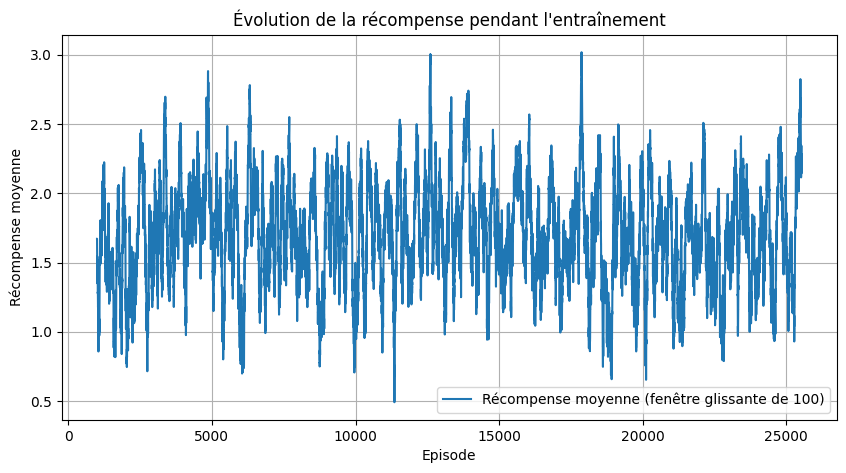

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import glob

log_files = glob.glob(os.path.join("logs/dqn", "*monitor.csv"))
data_frames = []

for log_file in log_files:
    with open(log_file, 'rt') as file_handler:
        first_line = file_handler.readline()
        assert first_line[0] == '#'
        header = json.loads(first_line[1:])
        df = pd.read_csv(file_handler, index_col=None)
        df['t'] += header['t_start']
    data_frames.append(df)

data = pd.concat(data_frames)

# Tracer la récompense moyenne par épisode
data['Episode'] = np.arange(len(data))
data['Reward'] = data['r'].rolling(window=100).mean()  # Moyenne glissante sur 100 épisodes

plt.figure(figsize=(10, 5))
plt.plot(data['Episode'][1000:], data['Reward'][1000:], label="Récompense moyenne (fenêtre glissante de 100)")
plt.xlabel("Episode")
plt.ylabel("Récompense moyenne")
plt.title("Évolution de la récompense pendant l'entraînement")
plt.legend()
plt.grid()
plt.show()